# Search STAC Assets

> For this demo we will require a few spatial libraries that can be easily installed via pip install. We will be using gdal, rasterio, pystac and databricks-mosaic for data download and data manipulation. We will use Microsoft [Planetary Computer](https://planetarycomputer.microsoft.com/) as the [STAC](https://stacspec.org/en) source of the raster data. __Note: Because we are using the free tier of MPC, downloads might be throttled.__ 

---
__Last Update:__ 18 JAN 2024 [Mosaic 0.3.14]

## Setup

<p/>

1. Import Databricks columnar functions (including H3) for DBR with `from pyspark.databricks.sql.functions import *`
2. To use Databricks Labs [Mosaic](https://databrickslabs.github.io/mosaic/index.html) library for geospatial data engineering, analysis, and visualization functionality:
  * Configure Init Script to install GDAL on your cluster [[1](https://databrickslabs.github.io/mosaic/usage/install-gdal.html)]
  * Install with `%pip install databricks-mosaic`
  * Import and use with the following:
  ```
  import mosaic as mos
  mos.enable_mosaic(spark, dbutils)
  mos.enable_gdal(spark)
  ```
<p/>

3. To use [KeplerGl](https://kepler.gl/) OSS library for map layer rendering:
  * Already installed with Mosaic, use `%%mosaic_kepler` magic [[Mosaic Docs](https://databrickslabs.github.io/mosaicusage/kepler.html)]
  * Import with `from keplergl import KeplerGl` to use directly

If you have trouble with Volume access:

* For Mosaic 0.3 series (< DBR 13)     - you can copy resources to DBFS as a workaround
* For Mosaic 0.4 series (DBR 13.3 LTS) - you will need to either copy resources to DBFS or setup for Unity Catalog +Shared Access which will involve your workspace admin. Instructions, as updated, will be [here](https://databrickslabsgithub.io/mosaic/usage/install-gdal.html).

The search and download phase was run on AWS [m5d.xlarge](https://www.databricks.com/product/pricing/product-pricing/instance-types) instances (2-16 workers auto-scaling for up to 64 concurrent downloads).

### Imports + Config

In [0]:
%pip install --quiet 'databricks-mosaic<0.4,>=0.3'
%pip install --quiet rasterio==1.3.5 gdal==3.4.3 pystac pystac_client planetary_computer tenacity rich pandas==1.5.3

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
# -- configure AQE for more compute heavy operations
#  - choose option-1 or option-2 below, essential for REPARTITION!
# spark.conf.set("spark.databricks.optimizer.adaptive.enabled", False) # <- option-1: turn off completely for full control
spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", False) # <- option-2: just tweak partition management
spark.conf.set("spark.sql.shuffle.partitions", 512)

# -- import databricks + delta + spark functions
from delta.tables import *
from pyspark.databricks.sql import functions as dbf
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql.types import *

# -- setup mosaic
import mosaic as mos

mos.enable_mosaic(spark, dbutils)
mos.enable_gdal(spark)

# -- other imports
from datetime import datetime
import library
import os
import pathlib
import planetary_computer
import pystac_client
import requests
import warnings

warnings.simplefilter("ignore")

GDAL enabled.

GDAL 3.4.3, released 2022/04/22




In [0]:
mos.__version__

Out[2]: '0.3.14'

In [0]:
%reload_ext autoreload
%autoreload 2
%reload_ext library

### Databricks Catalog + Schema

> This is for writing out table(s).

In [0]:
# adjust to your preferred catalog + schema
catalog_name = "geospatial_docs"
db_name = "eo_alaska"

sql(f"""USE CATALOG {catalog_name}""")

# uncomment to cleanup prior
# sql(f"""DROP DATABASE IF EXISTS {db_name} CASCADE""")

sql(f"""CREATE DATABASE IF NOT EXISTS {db_name}""")
sql(f"""USE DATABASE {db_name}""")

Out[4]: DataFrame[]

### Data `ETL_DIR`

In [0]:
# Adjust this path to suit your needs...
user_name = dbutils.notebook.entry_point.getDbutils().notebook().getContext().userName().get()

ETL_DIR = f"/home/{user_name}/stac/eo-series"
ETL_DIR_FUSE = f"/dbfs/{ETL_DIR}"

os.environ['ETL_DIR'] = ETL_DIR
os.environ['ETL_DIR_FUSE'] = ETL_DIR_FUSE

# dbutils.fs.rm(ETL_DIR, True) # <- uncomment to clean out
dbutils.fs.mkdirs(ETL_DIR)
print(f"...ETL_DIR: '{ETL_DIR}', ETL_DIR_FUSE: '{ETL_DIR_FUSE}' (create)")

...ETL_DIR: '/home/mjohns@databricks.com/stac/eo-series', ETL_DIR_FUSE: '/dbfs//home/mjohns@databricks.com/stac/eo-series' (create)


## Download Alaska County Shapefile Data

> We will download census data from [TIGER](https://www2.census.gov/geo/tiger/TIGER2021/COUNTY/tl_2021_us_county.zip) feed for this demo. The data can be downloaded as a zip to dbfs (or managed volumes).

In [0]:
# Set TIGER_DIR to census subfolder of ETL_DIR
TIGER_DIR = f"{ETL_DIR}/census"
TIGER_DIR_FUSE = f"/dbfs{TIGER_DIR}"

os.environ['TIGER_DIR'] = TIGER_DIR
os.environ['TIGER_DIR_FUSE'] = TIGER_DIR_FUSE

# dbutils.fs.rm(TIGER_DIR, True) # <- uncomment to clean out
dbutils.fs.mkdirs(TIGER_DIR)
print(f"...TIGER_DIR: '{TIGER_DIR}', TIGER_DIR_FUSE: '{TIGER_DIR_FUSE}' (create)")

...TIGER_DIR: '/home/mjohns@databricks.com/stac/eo-series/census', TIGER_DIR_FUSE: '/dbfs/home/mjohns@databricks.com/stac/eo-series/census' (create)


In [0]:
tiger_url = 'https://www2.census.gov/geo/tiger/TIGER2021/COUNTY/tl_2021_us_county.zip'

tiger_dir_fuse_path = pathlib.Path(TIGER_DIR_FUSE)
tiger_dir_fuse_path.mkdir(parents=True, exist_ok=True)

tiger_zip_fuse_path = tiger_dir_fuse_path / 'tiger_us_county.zip'
if not tiger_zip_fuse_path.exists():
  req = requests.get(tiger_url)
  with open(tiger_zip_fuse_path, 'wb') as f:
    f.write(req.content)
else:
  print(f"...skipping '{tiger_zip_fuse_path}', already exits.")

display(dbutils.fs.ls(TIGER_DIR))

...skipping '/dbfs/home/mjohns@databricks.com/stac/eo-series/census/tiger_us_county.zip', already exits.


path,name,size,modificationTime
dbfs:/home/mjohns@databricks.com/stac/eo-series/census/tiger_us_county.zip,tiger_us_county.zip,82328531,1702588227000



> Mosaic has specialised readers for shape files and other GDAL supported formats. We dont need to unzip the data zip file. Just need to pass "vsizip" option to the reader.

In [0]:
census_df = (
  mos.read().format("multi_read_ogr")
  .option("vsizip", "true")
  .option("chunkSize", "50")
  .load(f"dbfs:{TIGER_DIR}")
  .cache() # We will cache the loaded data to avoid schema inference being done repeatedly for each query
)

print(f"count? {census_df.count():,}")

count? 3,234


> For this example we will focus on Alaska counties. Alska state code is 02 so we will apply a filter to our ingested data. __Note: field `geom_0` has our geometries.__

In [0]:
census_df.where("STATEFP == 2").limit(1).show(vertical=True) # <- show + limiting for ipynb only

-RECORD 0---------------------------
 STATEFP     | 2                    
 COUNTYFP    | 188                  
 COUNTYNS    | 1419979              
 GEOID       | 2188                 
 NAME        | Northwest Arctic     
 NAMELSAD    | Northwest Arctic ... 
 LSAD        | 4                    
 CLASSFP     | H1                   
 MTFCC       | G4020                
 CSAFP       | 0                    
 CBSAFP      | 0                    
 METDIVFP    | 0                    
 FUNCSTAT    | A                    
 ALAND       | 92367472817          
 AWATER      | 12837268666          
 INTPTLAT    | 67.0050655           
 INTPTLON    | -160.0210864         
 geom_0      | POLYGON ((-165.59... 
 geom_0_srid | 4269                 



##### Render Alaska Shape Data with Kepler

In [0]:
(
  census_df
    .where("STATEFP == 2")
    .withColumn(
      "geom_0",
      mos.st_updatesrid("geom_0", "geom_0_srid", F.lit(4326))
    )
    .select("geom_0")
  .createOrReplaceTempView("kepler_alaska")
)


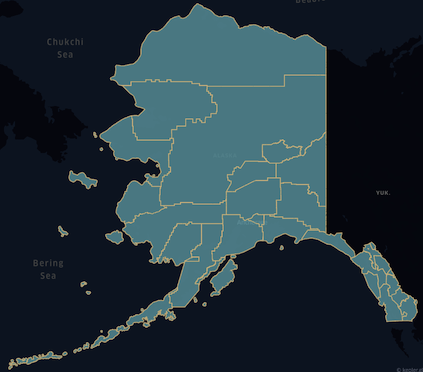

In [0]:
displayHTML("""<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAacAAAF0CAYAAACHRfYZAAABeWlDQ1BrQ0dDb2xvclNwYWNlSVRVUl8yMDIwAAAokXWQv0tCURTHv9oPqYQIhJaGO0mFT0ojHP0RSNAgplBtz6c9BX1eni/CJWhuEfoPKpp0aWqoaK+moCkiKKg9cCm7nfteoRady+F8+HLu9557AHdA5bw8CKBiWGY6GWdr6xvM84JhjNBZhF/VajyWSq1QC35qf7Tv4JL1VpFerH5zPjOxczIePVbaexelv/19MZov1DSqH5RLGjctwBUlTm1bXHKD2GfSUMRHknWHTyXnHL62ezLpBPEjMdOKah5wS/9ArkfXe7hS3tK+Z5DTewtGdpXqNOUU0ihAQxAMy8ggC4UUhjhxECHM2alg/h+PBdsjgSo46jBRgo4iLHKIkcJRJnfpbNhvBIgdz7Dc/e+ddrUm7TJZFULsdrVZ0ppPgKfV1dgAMNYCrj65aqq2RArckWfglf4+SX2SfWe1zXDImd4bB4YehHjzk9c+0GkI8X4gROeQLt8Dl8YXM3lsJwPHewUAAACWZVhJZk1NACoAAAAIAAUBEgADAAAAAQABAAABGgAFAAAAAQAAAEoBGwAFAAAAAQAAAFIBKAADAAAAAQACAACHaQAEAAAAAQAAAFoAAAAAAAAASAAAAAEAAABIAAAAAQADkoYABwAAABIAAACEoAIABAAAAAEAAAGnoAMABAAAAAEAAAF0AAAAAEFTQ0lJAAAAU2NyZWVuc2hvdGQzoPcAAAAJcEhZcwAACxMAAAsTAQCanBgAAAI9aVRYdFhNTDpjb20uYWRvYmUueG1wAAAAAAA8eDp4bXBtZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJYTVAgQ29yZSA2LjAuMCI+CiAgIDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3ludGF4LW5zIyI+CiAgICAgIDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiCiAgICAgICAgICAgIHhtbG5zOmV4aWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20vZXhpZi8xLjAvIgogICAgICAgICAgICB4bWxuczp0aWZmPSJodHRwOi8vbnMuYWRvYmUuY29tL3RpZmYvMS4wLyI+CiAgICAgICAgIDxleGlmOlBpeGVsWURpbWVuc2lvbj43NDQ8L2V4aWY6UGl4ZWxZRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICAgICA8ZXhpZjpQaXhlbFhEaW1lbnNpb24+ODQ2PC9leGlmOlBpeGVsWERpbWVuc2lvbj4KICAgICAgICAgPHRpZmY6T3JpZW50YXRpb24+MTwvdGlmZjpPcmllbnRhdGlvbj4KICAgICAgPC9yZGY6RGVzY3JpcHRpb24+CiAgIDwvcmRmOlJERj4KPC94OnhtcG1ldGE+CmKVG4AAAEAASURBVHgB7L0JgKRHdSb48j4q676r77vVh45uSUhCIAkEQmAOD9eAATN47OWwMTNjr23Gs+M9jD0zuzsznrHHZm3AxvYYI2MbgywQSEhgdCO1jr7Pqu7quu+svDP3++LPqPorKzMrqyqzKrMqojvrv+KP4/0R74v34sULR6h1R0YQHA4HD5LJZCSdSuLaad1zOiWTSkkqEZVMOm3dwzOXxycOPMObfIuvmmAoYChgKFBWChzev1X6h8YlGkvKnu2dcv7ydUkk03IE96dmZlVeM7NR6R+YkMMHtsrYxIy4XU4J1fnlxMleOYJ7LlwPDE/Kbrx/+vw1Cc/GcH+bjE/NyLWBcfG4XdLd0SR1QZ9MTUdkcHRKcbWyVsQktmwKuPUbyVhEnaYScYBQEucAHfx3ur2STvIegElHxjEVjwCc3OLx14nDjWQAaiYYCtQ6BbxuDMow5mJzTiTSZti1zh/UiY/hdbkk5UoBRJwKeAguiWRKgczYZFiBjyomPlo9QInBiYGz1+uWwZFJ2bGlXf3GxqcAcglxI53rw+P4vilxqQG2SN/1MTXG5hidYGbC+lPAEWrbmUnMTgNsohSf+B/BBkPspVmpKre4mUxagZc3UF8wTu475tpQoFop4PU4ZWyAo/EUfm5paPeLx+WQOEbqZuy1Pl9tz45O8Xk9yDyjpBqCCLU7rc0h6WpvUnxneGRCrg9NSkN9QDpbG2QaklQEIBSJxCSVyihtj9PpkCQATQNPGoNt8jneZ5jnexnzrRVF1v+PI9DQlUlGZvTXWXGJXF6/uCFFmS+7YhKaF9eJAmRMfgDT8PVp+cQHj8pNR7bJ2XPX5fe/+grac1r8zQEJ+pwShyRlwtpSQA0K8H2s6YaMknpYglTKmmJwQsoh0DjxERmHEhWlIU5TaOBhfKZDIUmlh2t+c33O5yZUHwUcHm/96vVx+MpU/3mCkKBMMBSoMQp43A4ZH4zIx969R971nrvkx2NNstM7Lcmxfrlwvl/+6pELMjoclaYOvyQxEjdhfShgBxT7ub001ty5kX7sNKnV8/KAU7b2CqACoVqlhSn3JqSADxLTKFR5v/q/3CbH7zgs3+0LyskJpzR4HbI9lJE7O6MSSk7Kj54+J//tz1+Vzi6fpIFPMUhRaZ6YYChgKFARCrhcLt9vlSvldCqhDCdcHm+5kjTpGApUjAIBqOpGoMr73MdvkWN33yJ/fqFOhmcd0ozmy5mIYdgIvTTqlvF0ndx/rENafDF54senBVO0Eoc6qSHgMqqhin0dk/Bmp8CctV45CEHz81QiBhWfR9y+gAKqcqRr0jAUKDcF3DB0GB5PyB23dMltdx6S7/T5JRJNSx16RDIDwyD8A/ZgLkPk1JgD0pJf7n/DYdmzu10mYfX1re+fl5dOw8LL75PGBo8CM6PyK/dXMultZgqUVa1nJ6TLGwBA0ayTY1ATDAWqiwLaMu8PvvA2GavfLf9wUaTdh4n2OU3dvOUqASoOA76tDRnZAq11hy8l6ei4jFy4IE880ytPvgiQApC1t3phJWaMJqrrS5vS1CoFKgZOmXQK1nshrIMKQvUx1+NrlU6m3BuIAgGvZZn3uY/fLDfefbt86YxfGp1YfF6gjmpBOp7FAFDEnjCa88FGkTvb4xJyRWV2dFj+/OvPy1MvDkhbd73E4mZ9VAFSmtuGAiVToKxzTvZc2aHdkJ4cWEBngqFAtVCAJsczQJh9W0PygffdKT8YbpLZWEag5SsY+AiaPsHaTfGjOTfBum8qJvKTMZecm/ZBYmqSB+7oka1tbnn8R1elvtGjjCYKJmgeGAoYCixJgcoshaZpucstThpGGKlpyY9gIqwdBfwwgkhMzsj7HzwoQ9IiJ8czam6pmGwPw2TVjtVaG7TnJC5h5CetWBvqwvm3LzvlHwdb5A333Sqf//RtsP6bgTcDzlqZYChgKLBSClQAnNBbMTp1+YIrLZN5z1CgIhQgYAyNxWEE0SP7D+2WZwfd0gx0WYlFOFp5dn4qo+aqrk875EunA3LktpsAUHfA00RUghCz7AtBK1Ipk6ihwAalQNnAiaNK/hwur3jrmpTFnpGaNmirqaJqcTGmCzq5gM8l9ItXKLhg1aAWaEbi8i8+cEx6Uy1ybSYN90QQigq9VMJ9tvkkfkFY+SUgUv3leZ/ccueN8ksfOyKD14YUgPkxx0WQYlmpVuSRP97nOisfjiw/jyynCYYChgLs19l1TgpYVL8osXMQjPCPHZ4/l8cvtNCjAQTnm1bX5c2nMRQoTAEydlrbeT0OiSYyMjOdlNmJsETCKfHDFjwXbCgx8d7E4Ix89hPHJLTrBvnHXo/UQ2rKjVs41+wTtvcFCjsrhTT6A1V9swmR6xGPvH5/vezo9MtA/6Rc7ZuSJDxfe7A2KorFu3RgSmltcghlnomr3yy8YUdmEoKFGFIXcMPBqQViK5HqlqyDiWAoUAMUcHg8WAYPp1MEF7WIFttlKImHHCAn0NGr5R4EfqtcHiUdcU2T2jpDARJeQCc1wVCgUhSgtBGBNVx4lF70U9LSEpRjh1rljpt65Er/tPzVY1ekKeiCs1YOnABiAIKhcVgvQGL6nV+9W1r23iBfu+QXH7g+ny+rtS4AJmoKWMuFKSiz87RTGrGK4pbWuDSnxmTgcp/89bdPyQV4otje4ZML/VGpw9zXL7z3oPRs61QOSZPxuAyPTstLrw7Ik88NIl0UDoDW2OJTxhp0PmuCocBmooDDF2zNeAJw2EpwYW/DLwkP5dwSQ0lToIYlIQHA4NxVGToAmNizCVSMY4KhQKUpQPVXCm2N0k99U1A+9MBO2bWrQ9o7WmUw3SB+f0CanWF56Os/lIcfPy0Sgq13BLbfqbjccqRDfu6DxyTRulse7fMop6G0ziu15SpJiUhmCxyoFQrc5oFGExDkZFvIIcfaEwqk4rMRLNgNyvDYDPYO8kqqrkPOTHlgkAGjDDckKkdamtOTkALHsYdaUr73xCl5+IlryMYlLZ0+uEyyALVQvua+ocBGooBDbzZorxRBJ5VISCoZAwBZKjon5pLolkgpQgwg2cllzitMAcv/XRgTNi757EcPyS3H9kvC3yJDMa+cn3RKf9ghsHOQPfVxucnZJ8OXeuWFk8PS1uiTG26A8cO+LTLs7pCvnXdKK4CA0k2pwKSqxoGYTZVXtA9k4xLKiGdcvDuN3w74RA4AESNQ+9X7MmrN1IUpWvup1GCqjj6HQsHCXToCiF+XhqFFWEYGhuSZp07LQ49ckWZIXZzXMsFQYDNQIC84qYqzZ+UGA0q5FDHXFaaABUwR+dTPHJabbtotqfpOOTHmk1fHlZAvdRg7wZZAAQ759v7mtOxvSIgrHVN791yPBuQcAKwX/vBC2TmmlbB3a5A2X9lCklNuPPYigmEMyJOEKpESG0GI3cvPcR8jZAPf5a4cXOwbR18LYU7tYAsW+7ZMydcf+qF84/u90gTHf8ZNkqaYOW5kChQGp41ca1O3qqcAASQEU+zBazPyqQ8fkTc9cLs8ei0kr4xmxA/1F33gURXN8ZIdbGYxZZoAw4e7OwUGYUgqQXh/wFTVgnjLJQCBQ6m35/Kz57owtVyAUk/zqAHzpUCthYVXVkZXow55cIfI9sgF+fS/fQQeKIISxZybCYYCG50CHLuZYChQVRQg4NDF0GB/RG67qV1e/8Yb5e+vBOXVkZS0eVKYnxG4GrIs3ggYnPdUP5zXuTPS5ALzhgGBG/ebPasHJhJHSUrMB/+WgjlLqrLKZL07/5Z+m8d8gXXHzJKy5mOcLVDxnRh2SGNXl3zyw4fhRX1GmZ3ne9fcMxTYSBQw4LSRvuYGqAsZMlV5I5hEOnqwWT7382+U5yab5fKESAscjtBjuGLgkEQIApZBDt8iV+eC2uyi2qy6jKbYfLrWQZdLA1Xp+dtADSDFdVFRSIM/GAjJ3XcekNb2OpmKJFe1uJcqxSx5Si+WiWkosMYUMOC0xgQ32RWngBsTNGS+W9r88uuffqOcT3XJc0MOafJm1FxN8ber+SnUdVAN6l9xeLDglCo+gitVmKcxx9bv6JDPfeyYxMYj4sParVICgYjm91zkS2mUe1hxQbAL7wdxj2uuGMcEQ4Fqo4DLG2z6rWorlCnP5qUAGenMSER++1fukcn6HfKNi05p3xDAtBABCDxFA57bZp8EG/PK+WmXvOlgSJyJKXnuxRFpbPJKAtYV9pSYrOUyyaH8+yVgXDE5HMYGiRGZxYLf2emYxLDsK4qFy+HpGYnCxbrT55Y6zO9ZEmnhUjHtpYpd+G3zxFBgeRTgtLIJhgLrTgEyxgYsnr1+dUJ+5edulfotO+WLp13SVfPARIZuh495Ulv3rWeW+m/+mUIK23twLgEz9Iw8PRKUd7ztZnnkn67J8GRCmkLuOes9AvssPK7HgEgEqMRIXNq7gvLJT9wMickj3oBfPF63BOuCWOuVkngkLCdODshjz1yTIXiycNQFpBPWgHHkw0W/dKVE7xqU3lhKAiFlOnqJMhaDtm9lTitCAWOtVxGymkSXQwECE0fuQ/1hedebtso/e/898p2hZhnF0ib6vuM8kmLWy0m0iuLOWfotkHFyCzg/1zT3BOCkpSfeoxn6GKwP37YNas/ENfnN33tCpmbjEvS6YCCSkRHQr7HFD5WoT5mv97QG5J77bpSm7bulEYYk43EYmcC10njMAfP7jHQGYK6O/aga01PS1zsof/PIaXn+RC9yCsIqMCBj0wlJz0RxndX+Q8Jy4FtkoJ5swrYguVIby2iCoUC5KGDAqVyUNOmsmAIN8Jra3zcjD7yxRz72M2+UJ0ZasTW6gKFa80yKuecxxV5xhmv+IiDGJgXly17JJAThuTAvbc2d4YRgRbj4wK5Z+fZff1+++f2LuCJ4JOUT7z8q973xsLixWH54Ni3BgFeiTr/8BZzRwpYEHigyMpt0qD2pKA0hCubyRDC9J6/rhneK+KBc7b0uZy+NyVceOim33twlH3jHEeU85vy5QTlwwzZxer1y4sQl+fJfvSTbdjQpX4FRrDReUHTkZYKhwGopYNR6q6Wgeb8oBTRPzse86NyUlnn9fRPy+ls6sfnfXfLjsTZ5bRSMEkyTi1UthVLRLGrgoaUOs0tBLLQFSNbZ4krMA9XcGU64wqkOdGv3JaQbqHLfHVvkrfcewMaeXunZsUWeGAzJeATeJhAvMgIagohtlD5xzdkpP7xT6G8BpxUq3vCsQ/7yjFNu6+iUHTs75YFDMemBVeCWnjaJd+6TydmUPHhwu7w86persx65/96gXLw4KE88exkp+CTYHFSOeOm9Qn9vPDDBUGBVFDCS06rIZ14uRgE9X8E4dMCawDyGmr+ABODFXMbwOHwORaLy2Y/dLDe/7qg8M9Eqr41hnVJWYrLSptwwx56tWzX9V0tRBInl1UvPUWEqSG5rh2ovGJWAMyUXIg0yAEC6MglpCGbnlJDoh93anoP0ywaa3utz25ExGHc25ZBxqA13whf0/Vtjsr0hKd84H8COv27Z34g5KjwbijnlfXtjssUBb+uXrkL1F5M//MYZGYMFYXurH/Ndlnn/MqtmK405NRSwKGDAybSEilBAuR0aogIqG+BOSNzQH9HXEECKJmN3He+W9z14WLr37pJv9QaldzIzp8rTr5njQgoogALCjEE91wjpMgByXp+1vGBwHonzUhwA6ECVqJLRSkALgp4L8elCaQjp39WakK66lDx+zQfAs1LktiCTAMC7u1Kyq9HKKD5wQX7n/3tG+q7AWWDAI431mJtCdCNJ6a9gjiuhgAGnlVDNvFOQAlTrUEriVuXvf/teufuug2BUaem/OiQnzw1L/+C0NIY88oa79sne/dvlerpZHrmCHWPBPH1wM2Sp8gombx5kKUAQIq0IRAQMHi2oWD2JCICEtGia81OU8Cxk0unzKoYLOttl3u/dlZTu1KD87cMvythkRH7w/Ig4sJ6qi5Z/KCTTikHll7aj5uqLaVLY4BQw4LTBP/BaVm8emMIwBz8mx++6UX4wVC9BMLieYEpCziicnSYwMnfJQLxOTiuHrA616R/VUJr5rWWZaz0vAkWl6EZVH3ZwU1JQLp2YLwGSAtkQJKmP7ItJIp7EAAOOpSYH5f/90jNy7nw/Yvnwg1l6fVCalENEyyTdAFUuRc11LgUMOOVSxFyviAIEJuV26Pq0fP7Td8ixO47KX18IyPUZh9CZQQRMrB66IW5nHsVs/UwcW5sDtLyQlsyAekUkX5OXKEVZGkFCoJ4vW5g1QYpb1ScgYSUR51274AMxfFlePXMNBhLW1vPffOwirmGCieBpDEgj1rStxoEtsrQ8XSBzlo/tj+uyYnCKq5YeqJzMn1qmgAGnWv56VVR2GjiMYSPAf/eLd8ihW2+Uhy76ldVYEE5Yyda4AR9BiKooJybs6eO7nKqoKiLFhi+KNY+1uJoEDAJFGB/2rVtS0uiD1WAaUhPmxYLJCah6h+XK1RH5/o8uy6nz49LcGYKqD21iGaMTF8BIGdek0jIxBZENOxzPbZQqCfE3hZSbJqoTWR4TapcCBpxq99tVTcmV8cNARH7tU7fJgeM3yd9c9GH9C+bG4SHcYjxgE1nOpQ5VU3JTkJVRIL8EpdPiHNM49i2BcAypGftY4XiwCR7WQ2k47wVoJcfk1ZfOyn/7ysuQorxQ91lSlCWh6VQWHrnswIsJriFaeM7CAkQ8cvdtHXJgT7tMT2MhMVSGne318sW/OytDQ2HpaPcDt8z6q4VUrK0rA0619b2qrrQcxY4NRuS9D+6S93/wHvnK2TrsogwV3xwwVV2RTYHKRoF52cQyc9cJW0YQeiDCI40ruIki11/1YOv6+3piMn35tHzhD5+VSZihN7QHlVo4AYmIa7M0UBGQGMYISrEwLDy3yTvefEAaGuok0NImV7CZ5NY6zGMm3eKFi6bA7HX5gy//SJ56cRBphuBhBPnS/NCEqqdAPDwpLm8Aa/Z8+P6QfPNt0171tcgpoO4Yy103opPRnUhfm2NpFKCenyESScuffOHt8pNoj7w07Mxu9GcYgkUd85cUYFNhe9FbgMRw54EtcdniHJFTp6/Kf/gfz0EniFGNwyuNbV61izHfGR2glJSWB+7eIve+fp9s2dopg652uTTlUPOZo1ihQDuLMNZohSGivWtHSvb4JuSFZ0/Jf/mrU5KZjUk7N2hU66+QlAnrSwE0An7XXF6dSWMdXRj74uCpt64Jmlp4y691cKLVTzLJ8RgEfThiI1DxnuoIqGAuEVTEnD9UPXEyNV9gOnoUx7R47oIXTnu6+lyDZL50NuI9Ohrl5nef/dhNcvzeO+SPT/mkEfMLKUUwEMoEQ4E8FFDMCffjGXicDzrkLVvgKX2kD4uyZ+VK35h86WungUcAKsxL/sKHjspNR7ZJqLVNeuMN8B7ikKszVBdCOodloAf9lvOYEJAU0xvFazvqnXJPV1g8M0Py7UdflW985zLmtwLLnt/KU3Rza8UUsHhnKoHRBILL41MAxHPyzURkVlKQjBnc/jpx+wK1DU4EIfoP62htUJPugyOTUEfHZFtPK1azJ6V/YFx8EPV1YHxrOwGN3NjXBq16W3erDODdCCdXEXQcniehZuBojwDU2hySuqBfLvcNK4AiSCUAjJ3IP+D3Sm//6IJ3+f5GDQRtjgCmsfXCV//jT8kLkR55ETu2hqDOM9ZSG/Wrl7deHA9GIPEQYPY2c30cNpR0x6QjckX+8funpLujQe6471b5yUSDXJzIyHAEnuvRvqjp48IDNQbKKRJBitagSRjg3NyWkde1heXsK2fk3//nf1JWgiG/U3ldV+03511zWQEKgNDpJNSus9PW6AEWMPx2DqcLAOVXwMRcCVqUnvhRnQAuT7AeKr4a3c+JQBOq88mB3T0KEJyQkiKxuMyEAU4AG7cbQ3g0VBIiRYBBBwgEfHMLAf0+r9o2gO9thw+xyakwGi3W4tT5FSARjChatjQBxZHWLICrraVeGuoDCpA8HrfE4c+FQiqfM34kGp8jdgU+c1UlyY3qxrGg9l995Ii079knD/d5wDi4GNRITFX1oaq4MGwp9DzBNW7XMWjum4ZLq4hbtnU0y9Ej2+WGAz3yd70hOT2KJQcwrODAh6FYC+MzSlV04XQZ/PD0tFdu2d0mdx8KynMvD8o4/AQ2wgDDeK9QpFyTP8noDPhuiuxYDWi1hikD0Eol4wAvSyjQhaHkpMCrFsFJiYGQjHZsaVOg88Irl2VsAgQACJE3tsKcNBQMSEMoIO3NDTIyMa3u79vVpQDEBdDZs6NDRsfRehHaATrXhyZlx9ZWuF4JCiUwgs+BPd3S0hhS4DM2EVbA1YiJ2KDfJ13t8MgMMJyaiUhnWyNAKyjDY9NKEtNE3qhHqkDHw0k5tL1e3g9nrd8fbMBeQ5BCwRCKMY6NSg9Tr9VTgNIQvVEwPDXilIsAlZNjHrUejnNKfLLctkXXTmAT8vK4W47uaZO3394mT8NZ7Qj2uWpt8WIQuvw0VQHNn9IoAKkplYhLKh7JP2jHc/JyCgGKQQO93AFKTFy4bRnVlJZRFcaiyi4G6cUNizE/dQIcg6EFs7JT02F56eQVnDukAdKQkp5ICMbCHwKUfZDf09WkVHbXBschXkKFR4kJCzROnO5VazP4otrALZGQF1+7DJCLSXNjnZrvIrN258xDVSG5ylYkN4amGYDyJz96m/QmW+T8JKRSMAKQzQRDgRVRgE2H7YcaiB5vWtxwUkuXR5SCVtquOBcF1iB1mJv687NuGfRulf/782+RWw81ycBVqPFhJMF5U/IDE8pEARAzQ9VdVlLKlYry5aLiuj1Q5TVawJRlzPh0tRuoQiLc0PSURg1KFcfq4L5aX8MjpCnV+Eg0NNYUGj1VgiqurVE2NgRxPy0zmLMimvsAdpy3SnDoxTEb/jOod3FkujrwEdPbDIGdeRRGEJ/5mSNS17NTvtPnklZM69FDwByRNgMhTB0rRgGui2Lg/NFqexXfZ0/tBuB967JLzslW+dxn3iL/2y/dKbvbfTDosbQqXEe1SbowSVuxkMEOy4nINCzvJq15pBT4p2LAebLMEtztqxNvsEGcACj7R6hZcCKAzISjlqoN80BeqOE82bkfPqMRA4N1tNCckk8Qc00BvwdSEDwWAKQYlxLXxctDkKZc0tPRCHE/hfmrBLa29sLgAruKUuxENMa14mfPeROtX6WQzU9lukH/kH7jM0k5crBFboPfvCcHAspzmlLmmZ69Qb/6+lVrtcBkLzkBrwMA9fhVh3x3sFV6jh6TX/vcg/L5z9wp0Si8TUBNHYSz2k3Qje1kKds5+SINH2gOrgwbkHIiMgOsmR/E2zPjfYeSlhrE4w9aj8hDNI/FsSbBiVIKzcYHhmGdB0OFG/ZuEc4n0XKPzwgu/JFgcSiWyTwJROOTM9LT2SJbu9tkFPNQtMRjoMVdIpmUkfEpacKcktfrwXxUGGnHVNrbYf1HAGJ8mq1Tjcd3VB44p5TGawVc5exRqnTV84f7M6WwGv/+O7fJlKNJXhunrzxjnVc9X8iUpBgFCFDN2CusH6bof3rGI98eapcdN98if/y/v0VaQz4Zxt4j3M3FB+0A+/gG7srFyLT8ZwQmaJ2SMaxJW2qQmn1ul5aoBlSB6WCOKhHFd4iEa9uUnEAEXMBcESbQcM75J9ZdSTpZQKK5t1bjEUQoNRFoZuFfhw2QwYpDdZ+1VooqOxKbaTFtXjNtzlMRgOgvzMrDUu/RHJ3yE9/ZyIGr9ccGwvK7v3m/jDYdlGcHJGs6vpFrbeq20SjA3squT48V0/Bc8c92p2RbekC++cgJ+eGLA3K1H6aDQS/mqj2Kd2y0+q+mPmoAjgTmpjHID+MxoUVeKcHhdGMdU1BckJrsaRCgktEwwAkm5fjH6ZqaX4RLghB8GKh2YiCogGbZc626s9RvnKfic/vIqFB8JmCp/pje4rStHKy/9jTs9zfKOUkbxdCzu94lv/3rPyUPD3fK8CwWQRoLvY3yiTddPbIsQiax1urNcFS7PYj55nhYhvuH5KFHTsmL58YkFHBb89cbhTrkY4pdWjxzudVKxrDYDIGLZMlklaQzi00mNcMtliCYpAfeH1xutwIm8lQCFC36FLjlMFGauNV80KCkK2KnkwYVPuPn4DWf2z9Nofh8p1jafK6DPQ19byMdafUYxx7gB460SMQJj+Pc2DaHjhupvqYuG58Cmgc0wYT98WsY0bvc0uEPyV07muXgniF5HlKUE9KTMq7aIOQgmCjXQJhfLzUoEEFkpX4DgKRh5JDEnBGvlTVeicyPi2udWavmNKZR0nDCmUFac2nkpFOTc06lEtXEKx8FlAoUm8nt3NooUwmfTMJNDNc1mWAoUOsUoDK+0Z2Weuwtdn4qLWPTOPezVpiUp8pgjmla59YAd944alH9KQGsS0D5igSWm4BAS7rlBEpLGYAJU6dKjgPVJNYupVNYPDtHm0IpUjrCtinwBuGF1wfSlKorWvQl4a5oDpjyvL4hJKc89Vp0S6H/ujWaRcWpuRtudlKJy46eRniP9qjtt2XTtJ6a+1ymwMukANdEUZ9CV0oNXpERMl6ZAgPFnDXUfg5uSoXpA3o6sKzRLA2MywsUI4PO8hZKE7RYc7o8WFAawiP2mzUIyD+dTiLfpToly8PK8mep1QqWEWXnfBKt7tRCWVVP1oXLc3LkGuTPfwzz6ZEuVlwHyqXmmFSaUQVY9AKh6aZezPmzVE1yotfuZQKuiYj4JAaJp9V1mpBzk3Ooor7H2trv127tV19ytktQQy14nmujq0/WpGAoUDUUIGulsgtW5RLmhmRCxhwWbuMBBT9+iDHHhC0mT/Np5W4H4GXdAf8A03UAnOx8BC9XPCwCjJwcCaypeBR3yQf5MKOA1AOvDLlrjPhU1QfvoCK8VHW3TrLX+h6eE6RZb/JLAqRl4DBj+cmDOyJ7GvSjp5JE3GJhU4ATjRq2b2mFR4eQsrS7en0UHiRmAVBwAglVFQlK/3gasPQ9XisffcUouKmecaRlVdjWPDcVBUxlNy4F2KYTaN/1WAvaCNNyMm/l3FmJVbrhQ2JSbJt0gJoMfuHiQDN62WYMWqF56xr5cG0DuL0FTtlyqtwt6U4XhEBLSYbIQLUaAxfNct6Ha47sb+p3WEfSwTrO31VnYAaUiAjOCtxsjy1gxnuUsLhOVOXrVJIY85sDK9s7uacbGpxIVq5NaoL3hw74vyMoKSu9LIclAXdubcO6JrfySh6G01g2RvrYo/+8mdmo8rmHaCYoCsw33/kzQxpDgY1DAXZ1yknaAnjJdq6YAyzOMAfDkIrPwpKtTi0sXXutCy2RaaRAsIQZPEBAAQHKxbJQytOgMHdekLmx5gvBjfWbDwAmAjE8O6g050atoCDOk5DQSBPmm8L6Jw3Yao5pPpGiZxsanHTNLTJbH+jKtTF4k3CpxrdrW6va6iIcicqure1y8tw1y6MEXggDmDrh3JUujIZGp+F9YqEvPp32Zjlabc+g9Gb53pu1nppXzAlHpRIiy+QpVZEpU7Xl9GDySjPtUtNZZTxKTzQ0SHLbJOQ976GBQGPrv7q8iM9yKiDFPcbIwpJSzRFMrLs5BUMkzqvZgYlpZOjoFWq7/IYOtPSbB8icFBddbmhwIpEpCU1NR+BNYgJbY7RLd3uznLsyIJSSuMA2Ct3ybCQhzQ31UgdXRZNQ981i6wu6Q6I3CD+cyyoTSqWNZoqbM1g1x+Sw2yvXI3D0CsumzUuNzdkGTK1LpYBljeZ1cUfX4pP+paZYSjxKSgoUVMe0emfxeShMZ8B0XpURGVCa4k/PP9HjQ34VHNT7Sr605u/VOiXGpRMCqu8YbEDoyUpXSXh+WA5Y55hcWOlutL/0r3fxypA8/eI5NULY2tms3A1RbCWLpWeHvusjMgN3RdxQcCv2g4pyLoqLe9U3to04NhpxSqgP597GZhKyd1ezdPZ0ytkJuC0iOFntv4QUTBRDgc1EAYtfxGcmlccDO6OuBBWURAQeR+avAMBiWqVnhX5sLaadVFJXAotq+cvA+i9/2QlKkLhckLjAIwlmyggikzWesAETmQRBjhZ/Sag8lxM2tOREQlB3XIdNCWkQEQb4cBEYNxUkIEWx7QU3HUwkpy1VH+anKGnxY9NXngtGEvw4m11G8GK17dRwTD7+87fKpKtZ6N2F27Fnx0jLaW8mrqHAJqIAJCjsAOupAyMHA6/IaI7MH/M7NG8nmCiT75IpTECbUdujK7UeFXgaWPTRnhbVdvhHdd7cXFMWCPl+XvUf0qFLIobiUpw9I+t8w0tOpDF943HzwI5WLCCF2u7qwJhyEnulf0zty7SlqwWbE/oVMHFTwUnsBdXd3qgcxXLuiYCVFaEWU3CD36E/vZGBqLz3wd2y59B+tZKe++MYoWmDf3hTvbJRQDlERWppWsZptVcZUieQEJhoeWeZiK8sUQuYir1r9XaXLyhub0BZ5ykLPAIPVImx6TGoAwFAZLb5Au8XepYvfvbehpec+AFj2P7i9IV+ZexA33oerknA/SSsWs5dHlT3SX5uGMhw8cqwoiXv0bovd2NCFWkT/KE6NJHdse09b7tJnh6pk4loRhowCKTG0wRDAUOBJSiAPsTtyC01GRxGQ4LywPR6aUAoni75F4GBoKTnjIq/sZqnDuFaKO5Qa82/Iy3OLyHQWauSCFGecocND04kGD8kLfTUcJ+NBQA1f187IZyXuj3cM5pRQO9sVBV/s/0JYH+bwWtT8r/+wm0SDrbLiasiDWgxBpg2W0sw9V0VBQgksGJj4GanymkqmcsKg1rgSlNtpS6r7CiRkh5N49U6LgCSMrpAvipvAhIZJI8VCBteradpRhryM2pgmr9vfVw7CM3H1bE215ESEzdeIzB97D375djrjsh3+7yC6U9Fw81FDVPbzUiBvPMnqyEEGTh/YPA0DlBhBUydA20CA83FLY62mkIt9a41B6U8P6Dnc86I1nxzKkQ701wqqRU8p9hQMeRbQXnMK+tAAXp1YqPnYI4+9KjKG+qflF//5J1yy+2H5Nt9IRmHoU3QSE3r8HVMlmtJAXQBxRK5kajqENbYtXxFQD+jFBVPT6q5mwX7GpWQCwfXbrgKsjx608USS1yZkIH1HfmCk34FEayFtXB/RF6xBsFNf0tLOwtcg5KYLMpCATc2PtSSH08saXE+aYVBbHBoX9zZlqrj6UgKbpzQGblVKBYdw2eT/NtP3i433XFUHroclCEM9ELY8dZyjjmfljkzFNhoFLDACT7nsJSEjL8iugL0P64fSszC1NwTEBf2RlJWduy4JQTGpcVckgtkKwgUHqyB4rop5fgV+cx5lSihjOWI4nZykRgCK5mr8ipHBiaNtaMA7TkmxrjREr4p0MfjwWJZbDlNEGIb5lxRCghDMMpECUY08XTJjm110tNWJy2NAWlvC8m9dx+UWLBTHrroxoaCGQATdeVrVw+Tk6HAelFANXOor4LcXVt5366QlJAFFXqToJqO/ulc9CjB+0uAFMtIgWK5ptnLoak2gEinvBKfmbCwIVvm5aSzmrjuWNa9u3Lgl+P+fTUJm3fXmgIZmYR7r5+6d7tEZsLwCwi3SxMxuTSIiVhYK7KjoUmLwI/gsX0N2PqiQW7Y2yKt7S3S0dEqKTiuHIvCrRO2UT4V88qTZx0Swn5NVOUZYFrrb2nyWw8KkOlD8SCzGLclqEVgyB6siwr8VQwfa5VgDp5OeCBFBS1NlgaCfECFe0rbVQKQraTESpUHq0LL40M2BV2elSS4wnfUnJPatz0RVYullIfZrMvz5S3oWmEJzGurpgDXIo0NhOWTHz8ut9x1swxPxKU7lBG/JGRsYlb6B8fFjXVeLq9HOrCLmh+umsbi6AjugIym3PLCCBbZAsMiwK8kxCt6yW+BGo/90ljmrfrzmARqhAKUkYgFUDjM7VBQwSmdhVQB87fcB00qh6rUaKmdY7l4l0GDFOIRPJSKTd+zYpTtLzVotNKjZMa8uB3GnBFE2XJZOiGMixFYYepXlR50ShWIBfQEGkAgrmzmqJufzoRqowDnjsJQ0W3pqZN7X7dPvjVQJ73hOmmazCjX/0FoCvw92y1v7Cj8QMIhg9cdMk31HjWAgKCAC+aiSMeHn5+f2axjqrbPbMqzRhQgp3PTNRdHaOR5lZac7PUCH2bIwDmqmk+CwEAeTP6s3RI54dtyAThl37Ens6pz8H0Fitm9mSigUGBRpuMVAsNC5bXAST/VxGEh8OPKZq+7AcSgR+61/Eq6QOa4FAX4VWgEMQU13thURFz4Tl5YGsUzACFIQykYM6jPme1lTqjquIzLi37Q7qV0xLlGqw8yLfWV1Z+lcjbPDQU2FgXY7DlIi8IWYpZ/2Dey/WZta2pJR8xT77ukOinKlorB5yf+UZggaJU9IElKTdyanWubUjAdV1LUOtBiITjZa4qKE8HjcADoAlorxOamUSZUFQUILH6gzejorExMzcBxbUYuTTkEy5QEA8CFgW0Z93ibvxQAzARDAUMBiwLsDdxsMATNgbXZIFVbVdJHdDlQHAVMFfto4Pv0aAErvST3qFIjVxBF51+xfBcnXBicGDcLUAkU1uHAzrEwX/QE6xenYu6sKwUINAzK3RD0EuxOWhpSD/QfHVFfm6OhgKHAAgqw71C1pzcbXPBws1yA7ysAJBNhWAdgYrYliEIoZrZwKZgez61u5tsmrDsF+GnisCwK1HnF5Q9IBNoIWhyZYChgKLB8CpAdq+5j+tDyiVfmN0oAp/kcLfcV8Xnnf/OPzNk6UYB9KJZIS0+7T7qbgzIbtxbYrlNxTLaGAjVNgTlMMlqG+e+IEbDeMHD+ZuXPiqv18ubPz2e+XF7SrNNNenmgUUSd34NFtusmha9T7U22tUSBapPq5yQlENEFYyFav5LDcYNNE0gB+tSDWTtM2l0emJTDSK7caj499Q3yLwgrACfYikAXyfkNY8G3gJbrcsFOlAIidbfXSTTtlBg+8LLE4XUptcl0s1JgHEsZaHSwHqyfvI/+cDinxMB+wnLQaJyBlnrDCaey1uM+boyx6Xkc+QlsDRR9/EF1LBdA8XvYGwJByg5QywcnABNdbii3R7Te05Nmqtjmz1pSwIVhaNDvkomhcbnz+C1yLV4ng5GMtJh1Smv5GUxeJVCAjIjM/809CanzcIA7/xJPCRJrEZLggJbDNlqrWsAED18IGHDj72jMIVsbM3LV58dVFVnrsYjrEJQpPQQRfh+alNPhbDk+lpaWFlTJ1iZ4f/nghILSq24sNaHEPK4edgKkNv0IYwGVK39Bf3njM0mZHJqVY4e6sQ19s1yOOtU6p8rnbnIwFCidAmRslJaaAUp3bUnIlQm3cjgMVqKCC4vAUynwEFxVCqQIhm5XRqJgsBYYYT0TRKYYxKgmDOZYFuZNhwyNwCU3vOQolZYqoflDAiWj8CKknM0qNF8xUfICE1LL/fbLBycWiV8SX5uLdFNYxUwX7tRHllsXueLab4IXx4ejcvxwi7zvp26Ubbu2yqWwT04OO+AVAu6HckYgm4AcpopVTgEFDmAbExhA/ck5D7ZlmTfc4VwP19xVutlyGsnLvLK0ogTFe/FsxrwexcNP7sVmepQQwC4rXaZsUar6QGvtDKYOqDFbrbPZgsCUh9ArA6csKZWJOVpdAlv1puIx8dY1GoCqcDOj4cPESFx+41O3S8+eXfLybIu8cNUlI9g+PWBX2Fa4HPbk0b/VqIfti+e6nfFc6/dxOjcXZo+n4/K5PdjT5H2dbqH49nfNefVSgB5Kun0ACDQMflMGqz2szZdle7Tny8w51mYgOFH1yD3N9PIZ9WAT/yEY0a9eChKT/lLlIsdS7GpV4KQLqd0bWY0Md7OSlX5ujuWhAI0fuN3Fgd1BuePWvfKN/lZ5ZSwDn3jwoweVhR7nrU03t+rEfk0jDKptKOwzb3Zw6vN5HsRNxuF52IZUPKWDTfrz4zN7YHyOZvnTCgSOdun3j+/kxre/a86rnwJsG0mCEz90NQRbg1JSFcU8E+YowLkmZQY8B+tzj1Z0shQo6UTLAk5MjCMNPdpIJ+BRArsn6mudmTmujgKc1+P26Wf7o9I/MCG3tQXkhlBKXC6fvDbult5pTvbCtx78Fi1XtUc+wd9yuiWBAwKbvGVbXLbVp4X7FdJUOIyFwLDTQGIO+fsLPpmChVZHMCXv3xFXz1k2L573TTvlu71e5WpJ58vXJpMOua8rITe0JzC3aal/mO4/9XvkNOoZABDbcA5vrCAgw6phjisovnmlQhRQDZE9wYSFFFg9TajSKxWYmHfZwImcTYl/2DiLHn199S3o/NZY2hhLLPzMK73igI4m/CTr7//503LLgXaZmo7IkYOd8tYbdkisu0Ee6fPLUBhWfNjyolSAYrOjlELphyCg+ucSheQ7/E0BJbYDmEZnAZoTLgkgX040N2Bi+YEdCVWOcYBVA+bCOgIZeeKqB6a6DtnXlFLvpdFaqUbRZaVHaG7fsRcWU34Y2jx51S0+gNF925OyC/m8BEmxHnFW7RcQhSfAKZryiJ8JhgKGApWhQKG5pmK5lQ2cuDFVIjoDhoVeD+5Jr7ZacnJih8fVTqQVq8RmepYGNw1BLDndOy2vvjYKtHLK3z96WYINJ+SzHzokP/26G+Vvr9TJGHw2lqICIxhNQLJ5U3dCDrQlJYJ5YGBFyYFMvQFzCI/3ueQno26pBzgl0BKbcHzj1qS87wBcXgEF/ACYMEDpuWG3kqRoJfXu5pR8+kjMkmCy6MDyDGGJSVdDRs4MeeTxIbfyor6/KS3HupKyvTEFMLNApeRCFojoAsj9EGD5wrBHbUOvAVJHN5KVpoQ5GgqsjgKFJKZi0lTZwIlFnwcgWvKFFVBRX+mReuwJErTMzTlUNWFVFCAT5fomV9CiKY0kYvCv97t/9JT8KhT673n9LfInp4OgPyISaIqQnEA0BUlnD8DAg5by930eacNWGpwXKDVE0w4ZjTilEyBFhk5Jmcc/O02VHefCWAhrh9E66O2CuDeE+F8/61PzU7n5MO+n+7HfFBZE7oG0xfD4NYIIVqpn08p9ZznXnJQfh5und+5MyJa6jDw9DOmNqkJbnXmaBj0KdSrmZ4u+nOxNXEMBQwFQgMDEUAigygpOVlbWXwuo0LnBpZSlBxa3MXCPEBNWTwF6Tdaek5Pg5jSWaOtukf/0xyfki/u2yPGOXfJwL/ZsgjqNAFRICuBcpzJowDEOM99nxl2yH4BAaWepwC9KBk1ph3tEqessxybADISdC+aGOJ9EqYchCmmtDwDBbPieDnw9G0UBl5biphF3LMYUVh9osNGH9nj3bFpu6khID9SF7hwUUvRCYb562i9YTqbqmJsz663Kl61z7nNzbVGAtFQ/QxBDgWVQoGLgZJXB6rXcYTfJTavwj9sLe7CzYkFuuYzCm6jzFCBQJSEBOerc8uWHXpCf/2hQ2va3yRnMA80CfeIEMNCfDFVJCDgykFHHgRBeSA5JSEBNaBEBYABVgssJ+fizXuxoT0fHI7Oipd5SQcdnufkrV9jpz8hj/W55ZhASaE66EEKlEXNmH7ohJh2QBrkxo1Il2jLnK9NQUxK4CKa6nLYoi075jo5nP18UsQI3dH48kvZsA/peqdnp+ARkKkBYF32vWBrML4a2xblIXf9i8c2z2qeAlopyxnwLKsZnOt6CB9mLCoOTLUu0UP5Lw2AiDemJ81CqhduimNPVUYASVCPA6alXRmTqv39X3nn/fjm+vVN272uGGtCjQIgA5tKiSTY7Mqo6qPJegDUcGbFmPKsrzdKMaDmMajlxSy13FKAchjWgXdNMRkqpcRZ0ImgToDQj1+ny2o85tUuTTnkM6sZgjkpQxyt0LIWhF3p3tfdJRxqTeMAZVkJTlp1zilw4y/NSA90GtaKN0UpzJfmWmo+JVx0U0MBD8OF5vqBvF3q+duCkS4cJfCddg9g5gn5mjqumQAIA1QRTudPXI/LaHzwlTr9futt88oG37JM33nez/MOVgIyHIR3hE1D1NsdhcM65o1aoASk5bIZAjFZSUw6XJQMlQP3Ry/B8gvkxe6BicRIqyXvgI+5oR1JeD0MSWhiWGghsChwAaOvBpfnNKcXUAVxzQXepOrCWlJpo2MK5xFyJs9j7fJfxr81wMECOVSy2ebaRKMDPzZALQuo2G0aBsPbgBKs+uj1yB0JWkQxIFfg0K7vND04Jqg4GE95QA9zEZGR4Oin/+cvPi9frlgfuPCr/80JAegFQ3I6aQKT5BBlPjlC1skLU0FtF+oZMQWWXKx+QwQ5ivorSQy/Waf3eKZ/0QAlQCqCTzmzuwD3FqIvlXSkSsgz8xhAMVxwI0KzDcsrPfFW9caR0zmsTDAUKUYCAtvbgBL0J/fGlsRbK7QsulKKoUzGhLBTgHFQUi5dI0gAmfxp7GuQ//NGz8nlcf+SuG+VrF/wyCoAKogVwBM2wHGZjvbGx/3I+LjcQnLAOWi105pxaA34B3AOOlRR0E9+MtCY5We/NWPeSGscGi2SXlAg2/O5sA6UGDqLWIUC0h2FEYnZKYjPjEgtPSDw8idKbZlvuj0GSphRQpWHNF5Iv/OGz8sJTr8gH9kSlBduzzEJFoya4y53xBkiPrTH3RyCnGq+7PiWTkKBmMGelpYjcuPmuGXc58fOlUav3dL03QNPYUFVQwLEc1Fhh7ZebxTqBE2o3N4REV+NWrrzO/a2QCOa1xRQgSHE7dwLU7/yPp+UnAKgP7osKdnbH5P+8h+jFb5o7uRRQ6s9sc729JQkVnWWunxvPXBsKVDsFCEw62M/1vXId7VJUqWmuHzjZSki7Ie62yDVR9MtHiSoNL+fLEwJtCZrTvBSYB6h6BVAvAqDetzsqQUwCxGjFZ2uoeRMwN5UkRTP7K1NYdFyXln9+IA4/kpjXgxRlyGcaSC1TYCUAouubAe8uJ7ixLFUBTp5Ag7h8AdXxudMiffQlItPqZ/zy6c9fnqMdoL7wB0/La8+9LO8FQHkwgUIHrQagitOZKjWuz3q0zyt/dNKHtTsOuX9LUu3w6oOlAKUqEwwFao0CKwUmegDiXn5++FJ1uX3g4ewh5QlVAU70JsHddCk5KX989GyKH9dExTEfpVy2l6e+JhVQwA5Q/9fvPyOnnjshP7t3Rm5qz8gIXAaRvxoeW7ipsPv50USDaK8nR53SgPU7b4GT23H4JaQln6FdYdqZJ9VHgZUCE2vC1q6XBqVT3POpfK3fhe0WfouZrGdIJ+nJ3PIekeEOlPSpw4DOz0CXRw4HDVhNKCcFaCgRqvfK957olUxsUt50uF52wEri7CS2OwGCGSlgaWr/ZMwl57CNx5vg5HZPCIYScP3UO1MVY76lC29iLKAAv1oErOcIHBKP9V2RZ1/pxfILP7YyKp80sCDDarggi8VvxZBCdR48AKUgSAgssMs5NKuaXsQtgOkslmq9BaQCk1QVXzH1qqEFVGcZKEHFsUCntTsgf/PIJfnl/+MRSVx5WR7cGpV4dWh8q5Nw2VKRZbXCFJ/ObJ+Hdw328KOd2MsMxw3Mzqr6m5jCLY8ClJpWIzkxN2q2Mmkupigvk64acGKP1s5iF5AX9zkHxT3sTagMBWLw09PWHYTngLT8xn/8vjhHLsIDAkyl6TeuvO2tMhVYx1QJQtz+4/85x40Q0Z1wgwNtQ7Z1/Cgm63WgQPlbfPWA0xLk5AaGaki6RDzzeGUUiAKgglxV6qyTp5+/JD2BGHbYRYMj9zWhKAXYibbCQez+lpQMhl0G1ItSyzw0FFiaArT8qxlwmgMm6kxMqAgFuA4q2OSR7z57XVyRCbmh0aEcoBqKFyc38ZvSUhSS5iC2CaHvOEOz4jQzTw0FilGAqsbqBydMjDjgKNbl9ijVXjoBixADUMW+64qfcQ6qDr55xoZn5JUT5+VIS1xiaCJGtVcaSdks6T2CwKR/pb1pYlUDBTjIyA3lXLuTm7a5Lk6B6gcnlN/pdMFQAntCRcMSn52EibkBqOKfdeVPaSAhgYC88OoA/MZFpBV7QyazxpMrT3XzvMndczkHlQAZ+TOhdijAAYX1yRau1iFAqV/tVGVDlLT6wYkGEWq9E0AJdvQ0mlCGE6bjV6QBpiE+1XNPqNfGJDo1JR0Ba18jdlwTilOANPLDW0QX5p9asPVIU3YX4uJvmadVSYF8DT4PSM0BV774VVmx2inU2nslXxVt0AIAVg4X1zwZdFoVKQu8TNWeH+6Mpmdj0n9tSHbv6pGTYw7lvXwjL/coQI6Sb3OUF4MT3du6k3KkLaU2dExBgvr9E34J40hbE9NiSybn+kcs9rEIUjklXK05dk5yNXFJYNahEvWvMXDiFhBmMa5uEJU4OjHBNDWblN1722T3zg7pQzd0wXuHcSNVmNoEbW5v/51erzx5DSohXINk8LsXk10NKTmHfZ/S2ODPhNqlAJkvmbE+siaVYMi1QqFKAxPpUP1qPfvXQgNxYP7JhMpRwA3z8fhkTO67pVMyDR3y9V43GC+9llueyw2LzU970iWK1Q6jcYeMwUchHcFen3XIO/fF5DgkqSlIVcZvYX7aVftdDUL2oz6v9rJXonx2YKpE+jrN2gInVeoc9kgTKdhGzfvlyz7n8JU/PmUcFU9dmj9FKJCEQYS/2S/f/vFVyUwOy8/sycg0yDgIG5QJ/LAcSlmikdFmKV0ktc31iFaN9FjOXwA964/P+OTyhEupREvZKXdzUas2aruZQaikL2Sx2JKiLjdSjan1wBDJAQg0AB6qmrhpIa/p34nBcqUBdxpwg0RsoqTlhBk6Lf54NCBVvInQIMLvccrAaFR+70s/kl/40K3ywR1dkhAfpAG3XJ5ySH8YgIVddqnK8kKQ5QZ8JlgU0KTgEVbl2Y0F9V1DpZqhAFiMCYspoKWmtQDtmgMn5caIqIOgJCIYR9B6L4H9n+ibjyCUfagOmXQC92Hlh3+eYIM4Pd45icqKiL8AN7ZFlWo27blnm/AkgWF+c4NHXjw/IZ/6d4/Km25vkztv2SL1TY3y1u5WSXQ1wHu5X14acQKoHPAtR8pZg4V5cnEQwf9WL7fmrDYZk7ZIME8Sc1b1FLBaK9rtJmuqpX6YtaRLbYETQCSdjOOXmAMZ7Y/P4w8qKSmViOSAD+ZKMDvtDtQXnK9SvvvgV05LWbqBblYpi4JpHLP8TfVY+IxW+9hPRuWxp67hzCHt7XXy1ju3yM1HtsgbWtvlaqhVXhzxKhBSg4UCrVw/M4YVBQhkbq87BebxaI4DrHuZNnMBagucsl8qGZsVL1V0cwHNChzV7YN7e3g3zw1sdAQe7rDr8gawBQekJ3JgSElUA3JxL4/W3FR2Gg7P3P4Q4mMV6iaUptg9kwAokqkRUpTX7VVANR1Ny188fEX+4psvyf137pfP//KbZSTukgvjLrXGhyo+DUT272BAyU4Nc16NFDCQVF1fpfbACdwyAylHAQY5Z07gGii1J1RWnaQfk2EqgIpgC/gERvrYFp5SmEoLkSwJDCdZICJYcV8p5gAIYwz8Nl8gOVL4E8EcE6lQj1324ilsUV7fIx9+7zF5eigol7D/k1/NPTEGSUhQm7e1sd60nqkIG/SP1VaslqLPFVhv0rZTa595voVaLbbWyr/RyjvPQWqoZnkwSZWeAOR0YYSfBZi5KuGa7o8YOAeiXCFB+rL2IJlvknPxdTyoD1VaNkZrj7OZzknSAAwlhsfj0hzwyO/+m3tkNLhd/gFre2idtpiKtju532ODEg7DGTW2Yc1jMCvfEkhLT31anZsFENX/0fWAQvGRChTX1iMqkPrGS7L2JCd8AwIGPzQb0+KQvwlQpac4RxbZ8qmeFqSFeJSs4uFJqPfqrK2IF0TYmBca+O30SWM8eyT7AABAAElEQVT4H4RD2OHhqBza2yy/+Zk3SJ+zS75xwSUd0K7O77Slu7f1jexpbExqLawVDUmdWcevcZg1dfkzMos1T8+PuKTBjQFS/qa5MBFztW4U4OfhN0ziQyXo3oMcppzfLJvcWhoVrBsxy5BxTYIT543yMT62I6rutIXYIvpozrvoQYEbiE8T9cTstPhCTUgcrWuDBVaJC2w9WGjL8yjUd5xriidTc/2yIeCS4aGoHN7XJL/5S/dIr3TK317MBSaLPNwuwgocQNBDt77eYITLVofrvbjw9p3bEnK4IykRgJET3IcOYAPwrTcEa8YJ3GuAjoLszoTqpgC/JxdTz8aoaUH/n+sFqyu37hYGmEqnY02BE+eB3L468UCSUXNCufUEOjndqFI5QYRpbUD+ymr5oKajF/LJGXTESFRR0xvyS2PQKW1wR04XPBwEnOqblZsONsuvfeoeOZPskoevYM4JdiJ027MwWADHe9TkbVRg4uhaBzIzeh9vC2TkChbcfr/PI03eeSkpnHJIyACTJldVH/lZsaWZhKCnbqxDA8dwIt8geKWVMMC0PMrVFDjNVU0xB/zJM5eRjM5mOaOKNPfKqk4AiglY9HkCoVUlUw0v0z0Rf7PY12Hk+gw2IPLI3Te3yBuOb5Ud2zok4fRIMOCThhDACcDEkePoeBjXHjkT65CHe53wug3VxyJgWlg7e6emcUTewQTStwAMueT5lgtTrJ6rCFwRQcBUwQOOMwxs50B7Gr/LUYd0gsFp4IZAqlRF1VN6U5JCFOAn5aCNC9HTNLoqY1gKmChZLRWnjMWpiaRqCpzI5FIJa4RP9Z0yCc+SmcyP6jeugXJwyF/WwG07mG8GAFVf1pTXKjECElV3w8MxDA/j0tAUkF/++M1y9PB2cdc3y3gqKLs6MvLjfpecHMHmjuPzo//mQIt4JtJyYtSSmJYCpnx1IljZAcgCLz2AoMRlAaF1h3HLxxwo3eic8pWNQKKxlmBiD/ZnjMO09jcnpQEqOwa2tENwUtIRSsvslFNgzCiYnpsDJ8bRafPchOqlgPr0+FhqyESUqnDQqj6djQEoTQnrWFPgpIqMUQ09QTCkk36l4lPDHTQpJ9biEMBoyGDdU9HK8scCRjB2hFoBKDJFgpLXTWMGglJU3nb3Nrn37n3S0dUmsUCbvDrpkStXMWk/lZFfdURlaFrk4rRD2pRqiqAhMhKF5AM23EjjhxVzWistO0ApYtr+kCnMB57rzOzn8zFKOeObnPPhthUEEp2ifpf3uPcSQYl168f8EePwPYYmGDIQbPQ9AvObMb80g3hw3j4nFU2iyV2B9/E6GEQQVhnfBEOBQhTIBaZC8Tbz/doDJ3wtAgXZBz07OLGFu9uHHfEQPAHORYE5QDJIRMBlyxxqDaBCWHw0BK6ZmYnI/Xdtlbe/+QZp27ZNrkRD8sNJp5wDKGGPYQm50rID65J9aA13dafk0rQb1J33oo2pKQVSK7c206ydAGVJRfxOlvSU/yMRFBFFZaxBqxiw5UuFAEP125u6E7IthEENUQM3eV+XiPeeGnLJwKxTmrBJ4Lt3JNReTLquL8LS7hJAxwdbcE6Ud9elJQA6ffWUT64C7ykpsZxML4Q41novXJhgKFCAAoUkJN7XoGVUfBhYF6BfDdwGO1CMzioqGRfnm9weH9R9PrW4NhnFnAq5XBlDLQAUpSUXfoPXxuWmw93ysz99t7Rv3yaXIvXy6GVYj0FDic1uIRXAQS7ZKv5TOnhp2C0fPhBXO7iOQDLAnoOK6ZJ8CihWSEcNKhYokI1bgao7a6Ch79iPVmwLSnhfX9vjFD/nGzRW2N+ahKNaJ6zqnOKBZMO6sFlw8vtGWNhdmXHIuSmX7MbeS7sQ9+UhN4DIIcc6E5C6RH4w6pIDMHhIgXM0+tIAKwyM8G4PAN0eCGjztbM/MeeGAktTgICkwYnHzQ5QqwAndkN2//UMLAN+4DQpOn6NTitJyqV2yuWTypgyWwAFPU5mGs5kq2sOiuuRhsbAUTHM/8WPHpM77zgog852+VOYfochRhCQWsFUKURoFR2/ImXR4bBLmUIr5o1rFcoG7tbX0MnqYyGA0oBGLx38iisJbB2cI4pC/fajfre8BGu6ekg3vM/6ToII3SHLZJ4gxrhXMG/0Py95ZBRGD7+BRbTHu5LSHkzLd694lck4FyqkAVxjSLN1VWrOldTIvLMRKFAIdDQwsY6F4myE+pdahyXACT2WPXkRg4LFF8y5U/SysJohdamlLBJPqYZQhnQSOhaUU22dgbknzjtpdVCR11f8iPkyDy7uVU5lF9FoxUmv6EU1twT929C1Kbn7eJd86KePibtju/xg2CevjaWlAao7ghIBSYNSbkZuSBV2M2k+XxksLEx5oXRkpWi1GzYuNDFl/KBzsu4tTCHfvYUxCl3xTdaJBgzdmEfDki2rSeM+MAeSlNW8ufUH4/ngYb0ddNqCuAS0ywCrt+5MSKM/LVeg+qv3UK2n5M1CWZr7hgIrowAba7YbGMmpmFoPDF/tf6RGihiJK6pRJYK1Rt4gHKL6YZgAs+0qCKk4PJVjsayy4MP8UxJzUZUwilhUVWU9GAedYooec/qiRRErd4OYyPVKI9Q/RWblX3/iVjl6/JBcTrTIo+cc4gcrbsYInyqnQqCkSzcHAdkOwvu2/qKjleWo5p5UBjpXfSxL8osSYf1pzEAaMCdKTjxPQAp6w5ak3NKRkjoA2Ah2r6W6j3NMwxGn9AGQ+OwdAKh7Ea8d6r0LEzQQMcFQoLIU0JLUZpWiCktOlEJg6889kGiazfkcevzmKJhWcYoRV/bbLJk6y5KM0Qt5dnIdHEOXc7G0t2RyK4iAfEGbVIJ7Sc0qj+dubN2xFrShwOqFiRkZ7Mj1WXn98XZ5/zvulradu+XbfQG5OAnzZrVQdt4kfMkKZjmuDZv0QG7JV0uNYFe1Mp9slqW+vigepR17ee0ReN/ewO3xqNakMcO3LvlgyDBfihmAFe+TrpSqOO/20FkfJC5Lucj7XFjbjIR5bsLGokClPulmB5qVtBJ7351/n5yPaqt0UlnEeYIhePF2g+dCmoI3b6cH+/yUeZHafObLPbM3J5qZz6Lodja03PSWHz+Tpnc5TJjDVJsSJfePqqS6k5/H78UE/zSkJdhI/+anj8veIwekN9Es3zqDuuM5PThY65FICzuNitdPSRjpLP0UHctHS63KK5dSjCWLgPQEi3yB0tEUKkRJiCGXCnyL5uBTMDXXgSblWrXJ+KQ1F9fSHJ2BJIFQNRdH3TR/NgQF+L3nW0J5q0TpRwNUwZRtma+3tKTLupxy6Hfs9VvO+/b3eJ4XnOi7LoU5HDVng95IpsIFrw5IURAVVBprDQC5BS90vX7lQsuCypMm7G6ftfEhOVv5FwTDZBkTJ4PXI3Jkf5P865+7UxKNW+Q7/V45N5mBtGRJkfMLZefNtwvRjPdVx0QV/JhPaQ+mZBzWa9m7xV5b5jPmUp7Afkwz8YNNKdkOM/HclNFq8Y8tOCPb6jPy7EB+QKERBH/2kJsWAYs/HXKf6/vmWNsU4Cfmt63k2JYMvBDD5v18DH6tqWovQ7Hy5pZL12ul7+emtxCcCEIAJq4XciYBRpAA1GQ2h48ITr3xHq7VnE72fm6im/carBAeKhJJ6NRIO/zz1jWWrbWz03B+afDatNxxS4f84ifukT5Hpzx02iktMHjozkpLilUzcolclNHIfMcgHQxFYEIN8+qfYPPAANVbWRa/2m9aTkkSRVWAQomGZaU1Xf8MzcQXlpL14q2rANoJmpHzxZxQColKiZOTrLmsYQpUkq1pBl6IPBqg7Ax+qXcKpbWS+/Z8V/I+39HlXW1aC8EJDI1qKTISLm5dFPjVEIdm25QQ1k9KWVSy6rkB+hDQqerLECDKFJzQNdEij/NLn/sXt8iNtx6Sp6Za5YVhWqGllcHDvLSETJfZwwhOgzGHnBx1S0/WvFoVHemQObMm80w6e0fdtO6qQYx6Yf6Pll2sO/Nvz8dY/hmrxUbPDsDsqbJ7rNcj37rukXYYNGQ1eHMJM1fGa8la45WnFHPJm5MNRAHdVipVJc20l0qf8VQ7ZcNF0O3duir/X51+ITBZKV10fe3p6nul1GIhApGZlsBQlbl2KalvpjhZ4KZrI1o5KsmS9S+BnkuRie6Hkkh/bGAKnsHvkuN3HpW/uxSQXmxR1Q6T5wWgtFRiRZ4rU2qYky8OFkAtvK97kHXXMgdfGINXqmHmS3Jx1CXvMBlXVjpS6jics//SK8M22Og0oDXngpNO1BgvaEqYYyEKZLEAj9ney9RoC2W2xH2WZS1KoIFDH/MWa5WF0YDEPPjT13nzst1cCE54wHIUDg5JRsKY+KfVXvGYhdPYgE8AHNwe3u0PiQvApCRPeKlQgaCVE6wxAA1OFj+zR3UBLeisdWQEC34TKfmtX75Lth+9Ub540q9MxZogKZQLmHS+hZi7fr7sY576LzsNvEBKvW9vTFphyk1piTRk0iHQ4DV4cGCgWcoSJFXxzB9DgXwU0L2RvI1GTZshECg0MOWChr5fLjrkpr9UuovAaakXOEIm8zXgpCkFFSiMRTwAJs4zzc2tFGHKKQzjY+CwoaBLeJ4buFUFVXhjU1y7lJR7b++Qn/3ArTIZ3CJ/cxHWkmDOyoy8gpyY7L5ahh8kpQum3C3YWfZH2C+JrpW4VQVLSIlyPEZv4Mswmc8luLk2FGBrQoOn9iAO31QzYe5CACfSRfpxxYlmNfGyZKOBJhcg7NwnV6phXP2ePtoLk5uW/Vk5zheCEz4EwcfhsEaiizLAh3N5/PMqq0URNuENzC8pYKIVYwkNmVECfrfs6vTKaxenJFSPFbLZwGc0eJiNp2RqJCG33dgiD967Rw7dtF9OTtXJ9+CCqAGfhv7hUhUEJkomgzCOaAAgsLNWS0jAxP3qjEuuYs8kBUYoGMe3NHQgYzHBUGClFGDzYZeKoO03YaFbHfY0o5LYsY4dgGVCkUpWgyHqkiEXgHJfyAdCuXH09VJp6XgrPS4AJwIT90Nywz31nARgTxnckybl3KpCrSfaJKKv4nwKeFRTsVPEds5nxQOBZ3QgLJ/59J3yptfvl4cfOym/9yfPS0tnEJvVpcULLjs2FhMvwOu3fvk2OXBkn/RGA/KNXq/0TWfgy82a8K8gLilpqQd7E72zx9oW4hr87VUD32cZuP25D8BMF0RqG4ssyZemfPHvYp4aCpAC09ALf/pgXI62p+TZDFkjFyOsbyiXdFKudOzUKEeaxQBuATjR9JnglIHFXqHAiUJ6iHCmEE8tPi0Uc6PcpwrTDU8ZIWWhqIxBVjhMt15LSVODT16daZDjx/fLjT8+JyevRbA1ultGR6LywOt75J//9O1qr6VvXsNeSzCRrgdDboXhQx4NYNmITAbPvYh6kV8LbMhvbktJCHl++aSrFIGwbOXIlxDpFofUBIESkiXoAHN3NmoDSvmoZe4tlwI0rhmFBv3j++LSU5+SFwbBB+EOjWrjghY2y83ExC9IgULS2sJZP3CBFJ2ZFtsLCRKE0+0Wb6hJrYnKK2EVLEZ1PrAszQqxOjBCADE5tNpkUCFMobjF62eBE9RQbpdswUJXAh2lqWQcOm54ET+8p0E++L675PnoFvnyWXjBhp+3FjgadVGNt7IsixfI9pTSGK3ezk265L9jr6JvXsS2I2g17LjrHdhIQSLlDYLSU4VJsd7VNfmvIQWotZsBDr0Og7HtjSn5Ty/5saUM9u/Sw/YqaP+VJEc1V28hOIEKNHSgr7hEBHshFWEDrJRlFFEqq7Dms4qlWcmPkJs2AYkLjr11TWrOiG6ZCooIqGwCe0PxHV99C6zyrG0yFKgpdV9u6vmvkzSt8/nluZeviX9mUJobA/KzH7pb9m2BWm8ijF1qt0vY1Sz/NJiRLkgtblg+cG5prQYA/JL0JdcNUljzTRno4GG8AWBY70ZMkGRjJcCv4zRA/g9r7tYsBYhBA5hfvaElJRew8PwsnP3SM33VeGdbIWULSSO5yZUaL/e9tbheBE7MlAsq0wCo+Aw8HRRgvmSYVAFSFbhkQFyHkzvWwkcfjkzTklaWfLNiEVjuDHwH0gsGnbUSqBTM5q2vtag2Hp5QjmbdABhPoAH1qVPm44pjllDSBMSfjjaf/PU3X5CzVyfk5Gyj1LW1y6Gd8CIhcQkGPMpLtgVGpFEJiZY5CrMEFqmJYdpq/NwNMXkDdpKdgUptPUCBrYtS4yzy5zEOP3r8mWAosBIK6JbDIxee92GVxnvhbX5/S1LOYb+vdmgPqEVgP1Bh7kTfqJ1jKcCj543UMVtXfa9YTUuJU+x9/Uyno4/6Po95wUlFwBAV7NEed8G5AifqZbWuasFTfYE0wGE5R+WFXz6Pn5JKo/J0zm03+K7FiHX8NTwiby6UjU2PKY8XXDjLNUpOrk9S5aLJvP6BMyIQ0OjcNZ1KKee3HgVq2fVMJRY9wX3BPQ1y+vygdMX65cyJ0/LIc4Mw4WuUHz53VToDETncAhdF2J6K5F9rQOAXZ6edBQD8wateGYeKY1cDfAZm71OCWcsfmQjnvvZjl9pmkLq7LiVd+BVtdnjHhOqgANsvf2xTa92W7RRge2G75aaSSgLHw0E06g/uSMi79sWUl5HXAE51kJq4vlAv9i5l7G3PpxbPNTCAPHOWgbxX7FfOes7lT+ZjC1qzarulTxmTxS0WiklAeFepznzWXA2S0UDEdUH8udJwMIu9l8jw6eV87ddOERyhOoOUSHDi9iAKmAA+BC4tubBh052TtU8U2bSqTBHotqLk+5uAaq+h0Stf/sZp+fp3zsrMZFICTV5phgnaD14YkZsOvSxvu+2gDLQ0yBPY7G4WI7s6OGOt9JxTvrJegaXeGG1rMT/WC9dGmPoq+6LffPnqe1zLdBZm479xICk3QnobgyHEHd04x/5KX8ZC5KVap07HHNeHApRAOMhhGMf4rhmMn148yr1wvFjtCIgsAb3Xz6Ipb8dauatoy1y8/YuH47KnMS3fueSVh6+5scGkFceJjh+LouMBxjQPKJZHtT0rRWKqtjLnK08RcMJCx+zC0nxfiEBCjwi02OO5/SOSmfOaR/rqWxSykfmelj7or49AZSmV2JzWKkAecsJcmgtoqWhG2ZSqD5sW2gOh2qO2DVk9iLLTNjV7ocLDRoAdAD0cCVpNLV75r19+UXZ+7yy2WL9VPrpvt3zvakBeHXPAWs/Kl+XQtOZ5JQMdv3J33C0wLf/5XQm1pxEohLA23wdfBFtaOGRXMxzRDrjlTy945c62pLxnN8qCsoUhuHNEXmk6VJLGGzVtfhN6MNkC6zcOrI7D4ODUmEu+NeCSrQABtqBKfzfmMY32w/HVXviLfNv2pGyHBD4MQ6N6eO+fxVzTbz8XUCrjbpSJ5aRURfBMYCGuFSpdymw25rCIAnnBiRKOG8yZa5q0tLPoTdxwwUv5Umyq2PtMk885x2XN+/jgHmkGajNKJ0ulzLdXHwigzC8ZjaA+aKHZfAuVO5+D05WUgoDEUR1BSQfea+sOSi92tf2VLzwpH35nnzz49tulJdgmTw844SwCFoN4B1s5qQ3xWPZKBZYqkDUtbws6ZSuYzFoGBcCoXysyHYH0dBHbpTdjPiAC7xDWOqeMwPXwWhbJ5FWAAvwK9rZI9dkgvtkuAMEHD8ZgdeqUCUgr9+2ApAKV9SNXvDKF71jJgQXbL7vW69oTEgRIUuK+DLXdl0555daWDKxjM/Kday41wKkHF9TAxD4Zx+gxpcWP+e5ZoPbmdrkooEmu08sLThzTlMSEwUHK9u2gXnPCWILzUzRnp1S1NgHjc4IT5s8IxmvJ7xQDzqlkFDbT9bDp9oTc8pf/cE5GJuPy7rcdlX17umUci5+pnuC2Fldgq5JEJ6oUlSjdadPy5zHiXe/QhCJwN9p4CjsPo2ykXaXqvt51rZX8SX8y8zDaZBLr0Li9ClsK+L7sgrT9ACQVWsD92WmfnMcc6m8cjsn+5rQ8fKWyNVRlglT9RgDS8a6EGsy9CK/1fwnv9V0Aqq9OwqgGghEtYtHNVHtiichyuJ7ODy1KHRu/4oOsZW0FzuHkMvpaqEFuuQuA03p8EObJOSxQdq2CAtesomrNwHDpytF8PIWd9Nq76+W7T12X7z7ZJx999145dKALagenHG5ukDcf6pCHLvplBPNCcFpOyqkJzDIOF5Ci5RqoY97D0tKFr1AMNgsyPa75IvOpos9VoRqvb7K5vXBuMGB10ywjt7wq3NyUliDUzvswf3M97ITRSloOtyelb9KNNuqBdOKQe2ANtwfxvviKTxnZ1AMklNIgN6NVVpttg7sbcxPKt0BS+/pZn5zA4Ip9ZAfmm5hdFwY5rAYHORyE2QOvMwCotLIlx3SF/WENnWtGT5Diea0Ee1nzghOlFmtb9rWv0ppJTOhtytMFJDUV2FqrLMxigVEz5qGwOEq++vcXcTyL36T8m0/cK/72LULXQvXodIRXWhJa/9mh2MPK0yKZCjvxegZUkbvRy7t3WRPYNHhc7zKtJz0qnTe7Aq3VyKh5zs9P5q5pTjeS9L/YiU0eP7ItIQ2Yv2Ecxt0FUJjAWqEnoLr7WxgZdILD0AJuCvM7s9DW39yakjPwQhKGJFUP4US5ocJ7OqiBBy4USOibODLtucLgtFiTpNAzhjIkIGWP4Ej1IdzlzQFRIQU10+Q6v3GoHKFGwRV7Vu0GO6OvxVosBicwNQc+jLXZYLEmUP7qUmqiAQWt51bjJqjkkrHFcwgOlaJaf0VfgWVi6iWXoUhEFs2ak4JH7q6A8iZxfdgvu/dukVfHPfBojpct7YNKZb3XjhWpyqofsSW2B9LyIgwjnhlyq89WyTmLVRe4BhNgd6A00+hPy7swEIBHLQVIBAw4x1c7DSspHXH4PTwAnXPYnPJrFxARQ/QoeHkI7XEYhm70LrIVajMCGtvxMEDiL8/45CNYN7cbBi6DcOD7wrBbueeaAyjEJYjR3LsBFqqcW2U+DDG0dUIFbimTcO56rMGSzxk418WBy3nMb72ji4YYmFuC1MZ52lK7NevK96aVV3K67tIlsPIwf9eOAgvBiR8CH4fGCRbTXvsPQ8mJC2KTxVwolYM+yCediCsgtJLDlurBRrV+qeSWXI5y5KTBNRY+9Mo4hqa05sPnUIHroyKQpDobXeILBKUfevM68oTsJ8rbiVBHvq/izJ1kE6yhA6vI4nO0PgbGNwEG1gzGZ0L5KUBwooFAHQSHRy5hAASQodVkHEcyf4IDKU83UtGEUy6EYfkGQCJTD+BH/4dtSg08v9cY2x/b6gAMI/7wFb8chnR1CFaX79sfk//yYkDG8T29TA/p3g11YDPA8ScjbrkMqzpaZTqQ97b6tJLAIpC+ZmCePgCwozWgDgQy7uS8HWvgPrM9Jccw1/QUfFMSKFtRnlwg0+/Zj2xjrD/noYJea9S3Zpoce0HMuaIAPkM2oAVRlef216k1P3NcTz9fyyPKwmbHxlLRoJg3csGRJvG02nN5sFlgRTMtnDiKIVNQmGeGw9B3BKQJ66EoOfE+O3gQuonB6zMyMTomRzq6oM9Hp4UenR3KYhk5aSsiAqCyhLSomhOnBi5ZfFaFo/ZGMBpdnxooes0VkXQmGFECuTDtUm58SG/9DVSTQhy2RwJSM74Hz3mfPwJYPiCgms4Hfh+GyuzJQbccgWn5OAx7OiEN3wz1IFVpb92eUNIYh1S3wphhEMD3GkBqAs/eB6eslJaiADKW5wWk8aNBSDaYH2I4i7TeD08P9++MKynv5QEP3IC5BWO5vOVRL+X5w76ETQGwZQbV6Vy+kSeSubUmFFDgRHWQC54R5hybsrWtU6AEkE7GKg9M9vqtY311MdgHYtBn3HagSX76TbfK489fhSHENWlu982Zm6uNCf1e+cbDr8qn/mWn3NPdIq+M0IptXp+u07OONjiqgjouLFvpV2QQVPWQ+3FETwZieEbp9FtOTE1XHmkdmQLxCUKFmg9Bxx5yLu2PrDSQ1i6AUTNAiXNDHzsEFT5eYjoX4XT4e9hMchQS0FEYT9zQmpT7AFiM9wwWpD+LHY/vxnYWrwMI0VlrBCo7H9Jzopyf3ZeQg5C6nofa9+9glUcjjA5I18sBF5ad6Y0h/6g14itY7wUVMxcVoYACJ7oSUqo8ZlGoFVYk+8WJEiiVu/rltKrFySz7DsV3eoko1rmWnWiJL1CVNzmZkLfe1ib3v/Me8Te1yYe3dsvzrw1jpEh3KtZn4TqoVniT+PFPRqTxr38k//Ijd0NH3yJnxzCCxUAv34h1vb9niSQoGo1NMgJVzghcKVG1B3KYsAYU4LwR+0MuAK00a6bF+Z9+qvde9ckDPViYO+HEBpKwQcVH7YP0Q0mHqrwT4075p1GfbIWKjyrBU1jndivA6kao6x4F+Dx+3a3UdUNQ830Ci7Jv7krKf33RLxeQViviN8JII4svJRcXRYP6EouHAWrASRXWmA2VXNbNENHJ+R1PAFuMV0ng+iolwa1ReZQRAbifB77t6FtvPZi56gDoSaE6rzTATPzverF/VCgkR3Y2yCw8nnLbdh24DqoTXsz/8QeX5LEnT8nbt0dld5NDjSTnY+nYG+PIkfteLALuwIibaiPgkwk1SgECFOeHonGnfOm8R14ecyujBS7KbUf300YunPfpBkhEIQENY0FvD8CmD2bqM4jXioEY28AUpKe3Qf13A1SED2EtFfc+62QXxrPlApMmJ99le7N1Of3IHNeYAk56gqg2Ky8uhp0HKDaXPGGlEh7e04DEFkip0ZM1hMhrVJAn63Lf4rqmQCN06NDRRa5fkc/tH5Pnnz0jT54YxcaE7gVbsrPThLH3U3t3o/z+n70sj377x/Lm1hHZWQ8XSOixeLxhApkEqio7GpLycVh5BWHBNYxZc5oFF2gVG6bu61kR0pbtTLWlChCaSfLbdgFk6DeSgMQfJX+dHaU1XnMwQjCjREO/fFTxnYRUVYd7BCDOQ16dcchjQy7sfZZV/66CeMhOBSRtwjpTAJ+7+gJBgo5hva4mta9UBltz2IcyBBeX24fJWgydlgVSSBem6jSTpwGEy5M9n+sS60MLVsGDXjgGRfq/+p3H5IZtATl1JSzBEM3F83eTSFaC+uLXXpTGhoDcevy4nJ/xCRxOrXNtSqOh5YGEA4X89dOp0FqMap0+qHW+cs6nVDZBzDGUS9Wk8zFHiwJkzknQnKot0nkcBgfg+WVvU/zqpUg3jMcy0XPDVvjH43zQhSlYrGbBCZ6+lJq3E+VluVcbirfG1aZu3l8OBfCJqzQQoODOiCDE1qlMOtVwjtKOpYq0DKWXU35a+lhVZhpOl0uZksfDk2rbjOUB3XLyXToumW0QPa6hwSNnsF9GE/aH4FxUoc7CbhijSZU7JJ097XJx2idOJrL6/rl0YVcZY948d/57FEpyFu2AxhCKDrVRvUJVWXA/dwihQDoHqBfGURRYkEYlLijRxGARx3VLPK+GwB7LNtAG1V4TfgGYkPNeFIDVDulrJzxTtAdg7r7BNAfVQPv1LENVSk6aIEpCgjNWl6dF3WL3VP2FHsSxApXSj12i0u8VOyZjMNNGcGAHXM7lJGanlJpPbcWOHW7pzHa9QMrCFsw9QXdB44eiAYTgIlwvzIv8AT9GlNZkcw5/K5rEmj0EnfmPDJjji1wEJVjlSlC69h/Zi0WbsNzqn3Za337NCr26jFwY+BBSk0nMGaK9OsHpU3OervGt3G7lIoeSMZ95PJDmQR/G57spfFzG4TWDC+f0mp9eA5GxmtoQmwslLKqsFfhgPRTXWEXg/SGD4z7sYHsR/vtOQ7LmnNVS3UYR0/ypCQpUr+Q0Rz40T3I0MrjskeDBcxpzqLCM3kQmyR1sXXRbhPe4rovzW95QM0DQujeX9TqcsCqlMCDG80JRHw8nJBaekV113FLd0uWvQ7ELZGl9M9KcwZKYrPOFL+S7R9YusrMhIyfgEeLJfo9gWq5mmA8BxgX1sWqyAB+Ciw6q7eI5JXfW0o1nvEd/bvoZwYpSvgXoaLMqvawJmU6oQkeWmbSnM1fO+axlYHacf2K+/BGQWmCxtxV7inGLFC9oeQCbXzpdaXn31qSkAVB/eg77oYE0a4Dba0mKTZ/XfI+pNVKgB7kDABm6O4pHoJ7j+nI27eKBqhL7fAffJ0PIHbkXT6W6np4+c1WO3bdXZjE70AzUQv9VYSWdVb9L5kQORUbF5HhdSnqMyzSoeFFp4HqpsFB9NR+baZE5ncHIuBfubhqhzimlDPMprMMZ6Z8FHVLOib3CSAi2L93GCEY8dwJ82PaSyaQCKKVmxjlpzvficUyoILiwloDxGXct2irn+Who0Iq1SL2gPdcLVVIi4XdmYLuBExS5Dos8N0BHbY2Ce37Mff3sobiEoW6kyvEo1jO9EcDEdvPNi15sowJ1ONpGJctoldD8XUsK1C44kUrssFCZ0BSe/gCT0Wnc1E09Pxk5ik+n4pA4sNMt1IKeYD16xdqMSPOXaOV345hzCrUF5Cv/eEVuO35NPrhzqzx6FZ8UHZzbabBzs8NzBEqgALnUMV+OjMMprGmMTpUVVPY9Mgv8Vw4xad5rkZcC9zyztafH7RPo6oY+1mhZtVqGgWJIABZdPngjZ/mrPbCIlkrPKinPuR0LVXuUhigduXCehlEP7/E51dcEH4IQtu5U51Tn6fgErQy+J9V/jJNIEMBImcoEen53ABzeuScm3VjU+lhWai3FgKHUElktyGqPTJeDDrol2oMlA+/anpI6zC05nWlpxV6lrOl5eBY/MeJSbovovmoXPJ/PoK2NY+0bPZyvtp2VWm4Tb+0oUNvglKWT6ticK0JIRmeydwsc0Km56y4DLQLV9vA1Ck5k1jSa4P7pn/k/vydf/Pdvlp/atU1OjcLsFva357GSMIJ5jhH4FyN1CBY0yyVf0xIIOz6TGKUPMj/cxrTzXSxCxOiVu9Buh4UUgWsIvsxeGMZcCV70YSQL9qXSIe0ZmE4UoPTgzqS0waXS96965coUVDLUlOKZFYsxFwamtBTqMItC7y9Mbf2vCBppDHr0/BKBiIVPKkCxypeAdMQ5JafT2kValzqRSChg4jP9PtNLIb6eu+I1f5UIpDFBg/M7f3XGK+34jnQHxHZ0EWuImq1xz6qyZltj6ac5X4qTIAcxHi60tQZT78COy1Noi9ygsG8GYI5CeRDncYCkB29yA0yakfdizRPVf7Ta0215VQUzL1cdBTYEOCmqcuQJsEnFqALhWL9AQMempEUvFGl4P0/ATN0TbFBAtRSTLJDiut7m/BSt/KYo8mAR8dkpD3TyMCLwDctNMDGPZNwCBzDSN+tW60GuY+8J8Ek40bQYPk10I+j0b9mWkn3BaRnuH4A6KY49b9wwtvBJajACJ7RJ6fH75Ya92zCK5h5S8BitAAqc4f9n7z0A67iuM+EPeBW9F4IkQLBXiSKpSonqkiVZstwtx1Zc4iROtF5vnLX/bP5NnLYpm3jj2FYiJ+5xW9uyZUu2GtUpsaiRFHsTSZDovT4AD9jvu/MuOHh8D3jo9UrgzJu5c8uZO+e759xzzyGDSCbtWznrvW1RD9IbTuB0dTNuXbcSB9NzsbuaTIgUSuFIc2a3giNyHAKZk8QSh07D5xj6+cm+a4FF9YZNXCCCEwFGyQEWR0UnYLfgHqZfRws69vkwx6gILKMJ3XPnN4XF+UcAMNKkCYCSJiKalBwjIO1t5F4kbnz+3Q1dePJtP17h2h/nL6PaBG1BSetGLazro5TK9tD/3XF6hfgCgxBqu4DiMDV0ePDlg35TR4qAmG1S03IoHelM7dSZ9rop6Xw+zU4KzB5w0vvhYFaMpt5QB9V95L7uoct7nNKa0BjyI5jMv25G3JXkZBnETHzF+jjVtX7GFDj+di0uX5+PrtY2/MM3X0AbXTgvKcnEZQxMmJGRiRsLs5G0IAdvNaXgBCPp6tMvT0tijB1ucO2sxg++/yoef6EiQjcWqrUTwyBVSx/+5PeuwDuvuBT/fphe6wlGcpDZR5AR2Ci8QmlqF772rTewa+9p3HljFe66dQMDJC7E85VBrhtRMiNKyWeZHD47TyVAcTaD/7vfZAIPTb8sFnjitSz2ffV85KmVaq+RMm0fJRKr/lWtWnPK4MnXj/vxF/QIfllhLx6hf7ulfIcDpv0JNk3lae6kYJGbaXl5LScxi6m+W0ZjlxDHUYDI9cMjPqrsJOkzNAqt7tQWfpkDNURLRxfuDGSZP5llFJhd4MQRK+DR5lxt3BXTlPGDrPP6CER9/QIjWbc1IUBTcm+Qbpu0oXcaWOmNZVxpZp1Kd91/8/XduHdrBepbQth5oBEeosdbJ9rw6LOnWDxN1LNScfe2xbju6lXYsiSf0mMfutpacXj3GfzT9w9yeh9G3oI0AwZiBvJc4fUEySi0sA/87UMv4UsF2Qx1sAaPsch6akdlQafZ8NJs0jkcQlVjCPkLivHrHVX49bNn8dmPb8QNm1dhJf0FPnMumcHonB39pmwyIFYTN0n+1QTZWVOQOsuZOcd9YI7fkFQhJ6ibaTAg5p5oUtYGrt200LDAIxpHHtT0Lo0FPc/QE/fSpP/Di3vxzbd9WEl1nyZEiSRlk5PW2xZyosRQGdqP1My6vnkggJUEp4UM5/6fR/1opMZDm37T+cJV/3iubyXSzvk8048CSel5ZXYsTr/WjaZFRoyQZ3OCEVUp2rckFZ72MymgYH+/4xnC+BNkXn08M1lysiRSP5I4A21RwCMuLOUwKI+21QhU5H1C3KSDpm/tdZ2cFtO788Y8tDOg2punOtDf1YO0vBRjmu4EN3RKjZDS/PCyjA5KZ6sXZ+LT920hiBXiTGcqXtZaAJnKHSVt2P3SXjz43TeRW5RKBuMs4NdXtmDLhiJ8/L7LkZpfjFQqERvDafjVmVSzriJ1T6wBqP50sP0fX9OF/bUKMOgzFlnRM2inpfP/6hU30Ljvw8u7sYBSSSP90SnERCzaWmqJxgI0ORZeENmVYe+5j1LHStqVdHWMhgk/oDTVTolH4KXyTTk8WtWd8uuaxg93I2I5AegT60N4pcKHU3Q1tL+JHh54X2uUesfFVNlJUpvqdysa1nCt9UNcZzu1+zl85T93ID09CyEFqZpPk06B2QdOloQWePSbqruernYDWPpifNxsm8y4TebLtPlnyVEgIoYjySQ6iVn4yAV0r1l6FubNoEmfn0dZ/um5eEm3BHLNFJP6+Xfr1mK84/oVyFxQglTGvtnx3Bt48D/3I6cwxQRJtOWkMohPTSMBk6FU7721FCfOt+OeG5agYP1m/OiED7ncrxKrWvIqE5r9YwSnt+bByZIz5pGvxQRgvJwS082l3fjXt4KUghxz8KHeqQoT7UXrAhrBxJwoMIOu93BtUlLZb68OMfaSE09J4GeSCmEeWXvKDF2m3xp+ur+U0tLizDAqW7xUBzMsDyUzWX1GHjEgJjDT76lOouM8OE31W7hQ/+xS613olwGegQEvQKIRhGOZxxGoz3G4r9Zd1gw6H8qzhLqsCLsCqSxyCNFHUqPiSA2XRDVJVZlcXEqmz7+ndtfgqR1nKRUVIjM9gGderUV2FDCpzHZKW9kKrcq/XzxbQQ7Wg3NVrfj7zxfg7tJSPHXWg1S9jqgGRP+Ouj3/M0IB814ICpn+PtxEYNp+xo8mqshyI+bVetfxkmis2zoqGu1QSXd7mecf3gziDq4Zrc0LSwtsCjD32IaCVFrSsd636a1BwNRLw4q36rx4g5OLI5SWMmiRJwAQGM2neQoMR4HZC04xeq49UU6a21+HQCo8CnAWo5PUpb9sBpDyeQJ49SRN93tbkMWQqLGc1BrGRW7kk90v///vv381tl6xAucqarAou53MLIs2FxevYeg5m3SutZC5nkQHN12IB842AKrzPrm8B5XcqLyD3rkdJ6gOtYajmr2vOEvDJQGOJKJfMp6S6raPCHDOUlL7JM3Aixkm/R8OBVFGkJIn8QBzSfLSepKSnp8LyRqjzg/b0b/tOQVOoyfT/JPRFJCEpr9MblRJSpIvuPhcR3uxGqlGvGJNFq64YhV+ej4bH1jiQUvI2TxpmZy7DluaMFSmzfWctVsG5843V86txKE1GgGD6CJjlGbS5Rpa0i3gfrR/3R80e5GGeBVxyWXpHTdDpE7dV2h29ztT29QeP9ekBESLKCHlsm0SrKx5xVwBJdHHApPOJzK565mNIDgPThM5euZA2Yn4Aewj5wpyL9bZ2k7U1zfjhuIgKipqkZGTTS8WXBQnN7UyrSWZmJ8YpvZTyYyZmkTG8fHMuphVtr/DHWsYKiKfPuY+sqLbxLVq4u8fn2CIFG+fWWeSOk/WdtkRdd5w5Y3lfiygkXWdBTiuZhpgGg1IjqVd0+VZAYWAYzIBY7LrmwxaR/OEyahzvo45RgHNqgM0xKhk8J1//o8XsPvpF/Ev33oZLU0tNC12/OcJjNxJjE6qpkO1PoYCScYd5d3GO4AYXnRe93Oz7VxAoBARN5X04BOru03AvdervViT24ePrgjhY6u6UdHqwSu1nkkBptlG34nqz2QA06A69MEkmNwSl30k1jV7b6qO85JTHMr7qWCXOqqLZqRirvNpbBSQr79Mij8nK9tx+NgR6qY60NzQhDXLerG/gXtciDhuOovkjAaCpyppQl7bj8/T4ksqo7mU1F9tSl1DlZ02rtbSZc8RmnL/hr7uFHDvegIWaGX369P02E677lgSzVyi12zuqwUPNyDZa6Ppd6xndc1d/mjKHc9n5sEpippiij5yhYaqDp71IDUnnR6jHfPreLzRWkS5mWtUsXP+p2gnFWCQpuXZBKma+mQ8v/MEPrpyKfICGbTsutgoQmsreZQaFGRONJ6L9A3RhFv6suMMTf6PRwJYzQ1CS7mRVR66f3iCviF5W+s7Zt1nzo+y6UkACwRjYfx6VuXYsqJ7ylsJJ1tWwg9MUcZ5tV4U4bUZsInqp4+/fw3+7IFrkJHqQxudfnljTNslWQVkwkTOqQ2vAW5+VQDD+RSfAgKoTkqjivj7xK4atDc2YiEdw8v7eTTlxHBl4lxB/2uSCuYaaQXGeYE+GjvQiwlpsYzrbikcblrfkfGjosAW8po+Yl6a8jQXJw9uoscDDptnuPs2X7zjUOA21rLj1TmV1zWu51OEAtqg2lwbwn13LMGt77gKZZs2488fuAGZ3KgqU2htcLUMNEggauHG0vqqdrS19tDDcj/qK9tM6HSB1nRgFpP1YhXKQSAtmmjTrdkI7KpcoOIGFjGxgBaUGK+oubEZq7L6TfgDN/5rYCr8xnU0hvjESkqwVF/NFeanMSYwaiVgv5PeCjYVhemTkBMgXrfjSketv+nPXuOlKU3udzylDZmCyocCB4GK/Rtr0+KVo+ujSbY8+/xQ/RhN+WN5Zl6t56KemCo5JlYtyWEIiQD++ogXf7cuH5eWpeP5184iia5MsujOW4v71efasHFdHm7fugTlyxea2DunTlbioZ/uN6AVJLOO5aXBVd2MPxVYCLQlCbUQ1B02SRYaoElzlp9ATSevvC/PAQIeQbZdF7EwL+8SFFSNJCCCWIDSq1C8nrX0epBLNdYuur6Rikv3R/kdzhh6q3+GTjwJ0Cz7iVM+7ORG1pkUCXjGEHuaNVTgYIEi0aaNNL/KjfWMrs2DU6JUn+R8HBcmKaS23LUs5r6Npm4P7r/vKlxzeSme2Xkau/bRvXZfCH/0icuxbtNqdHgy8VazD02t3G9ySTH+Z34aPvPnjyNYmGmkhdk82xcwNbX1oLQgDfd9cD0K2efenjA9R5zC03uqUFIYxPmqTko9TiA5D0Fd4T0E3DXnW/HJ965EsLgUTxxPMh4NBGJd+qPftgXczPk5Wqfl0MnoU3Q2+hOC03qGop/Voj4HoEBJwCwQ5oqS8bSgQZlkuIZgaz7NVgpYYLBH00++csuXBl2PECEWyIyWPrZ8e1Q57vJ13f17tPUk+ty85BShlFQSIXFHXwqy83Nwsp2bPvkmfn0miEvyylB+6UL8183rUFdVg6TeLuSWLcevK1JwrEnBz8Q0+/Gd5mR8ZPlS/I8/vBb/699eRU5+gBtVh/ZZl+iLmm75tLYWoiuk3HQ/1+auQ1/2QtQxFk82o2l8tKQAT7/8K5w/U4sbrluJe+/cRDzvwpe//bKhcVVFOz7+vjW4/c4r8ejZAAJEcDqPNxFvV9EyTQAkaSmDqjwFvWumO54NBKbZuG9GjEdrSPI3d9/qLhOWnpjvSJo85tAY5GWq9BS2fD5NfwrEY+xDtdz9zEX5NEAir15DYMi8Fz08wguqR/W5kq1vKobfPDhFXoTi6TRTCrh8Qy7ScvNx6iyjbnIDqDzQ7alOwkvVPhQGs7A6OxNLGN/mxyfoAZzT/CJKBWbvDV+qhydPnwvgQ5etxIqyQzhW04UCLvz3EPR6eC/qvbuGwMw79XPNqKWuHZ//7LXozFyMfzvADaAE6UaO5j9YlYsHv7gNT790ApddWobWrFIs8LShjL73Xtj9NgJZ+bjtxvXYUZeBo4wrVchF/9MMo3B1Ph2XltFkuiPJROw90aRoqB7j/dpoXGcemRJqscZPmsYaB8jTlBB7KbU7q5acAHC+pHAWimJsVaIJFToBmew7iOZhuq622/EtpiKP5faC+jfbk2Xelpkn2t+R5k+03InIZ/s4EWXHKnMenCJUMetNtMq7dHkOA6P5UEvPywxRZFzFKJ5QJkGK6/fYWQVsP5eEQoJSGi2lNOtVkvqO9gCoI2A19vrx4TuW4y++tge1bSyIcaYLC4LoUvxrk99x6jKTVX5Ot5PR2tqJxUmM00NDiABHL8M14RmGaF+ftwp3v78c/rYaSkQ1aGlpx9LF2Vi/YgvWrijA2f587GKUXHnD7uUX+kEu/K+hM9Fzrcn4Cr1XLyBtlRTxVEzZqc+5Nlv/VVRi7V8SOCVHOIGkSFmQWsY/lX1vousH+QgW8PBTGGiTgOltDnMFDtT3cIoWlnpjyqPIuekGqfhjDiS9tkQBJzqfm/m775lzfQAxBoE7nyWvuxx7LZGj89aGzhldn7u/o603Xo3z4BShjGNp1If0NGn6PYYhmmscFHbGKiYhwDIenzlS7HVLXEKP+Rhfqwng6ksuxdf+biE6Ozqx/cWj+M2zx/iVMlQHR4Cs+dK49qI1G/mnc8dQsmVN92OIsaGyC9PwpW/sw9/kZ+H+5cvM7P5Umxe/oSudp88S0AMpuHNhLvyUHHtTgth00zZ+YMmGie04TxUgpQUxM9FkbX4Ye6s9DDOfjDICv5iyvsdoGk93uoymfeq/1tqK0/qwmdLjbho/0GXhQN9Fh4lIYkYJJ2a+lxOITE4mtDHYhr2wz0sjbr2Sf3F9l7Nuxpv1dLOkycqcmF1EiGEZthj5UAzb5rM0dOePvucGpovu2QLGeIwGHndx8e65r7vb7352tOfz4BShnOMjzovKmjas9vbSdY6m7mILzidsGAhnjl36TdQSoMh6igKDYSLKqT9iDk61cibZnorSjDKQN+PD78/D6rJMGlNU0XCiy4SoOHGaQf8YmRfJfq5xBaaF2k9g7GXkOcVtkj889byb/dR5LClP1ogZbPuf/v1L+K13VuAD77uGa3ApSOHXEyQ/6mEcrV9VpDuOSkkd2koY33gqK4dWaKKpwCeJ6sAuzrb3MqBgHddX0glaAvq5kDRm/KRDNZm4pMY0jqk6evjOYPgJ3ZsIcNZ71bsWoPCVuPkef12c9L7k0H9FTh/OcF21iWrGTr4jt6Jaasg6qmOVV8EnJf1l0xfgqpwwFClF71P1zpVkAcQyb/0eKsW6774WXY69Z6+7yx4OJOLdV5n2nmkuX5i95i5/ss7nwSlCaUkwKbmc8e+qxB23NTGseCr21iahyHgnSDKhphkEFpfnM9Q7Q7uHGAxgT00SzhCIsshopXfXC9Uft0UxTz/ONvdjbx0dmxblYeVVV2P9lZ3G/1mouxe1Dc2or23EgSPV+Nn2CmRlM+TERHCiBEaS2ixAEhC1KlIue+fILjyk0kBE02Sm6HUzMaIsctNWdKB8aSGtFtNwoNGhmZGISI1kZYokbSClA3OT1FV7p49fhJcMrYiSQxMlp7mWNHYaCcqtnckmON86AsA5uioS1c1YGieCaDLA/43kI/Uch5xZ6zLDTjdiJF3WKxQ4SSu9g5GPDzV7YrZLb075BUTao7YuK4z38J3aok1ZvDdX0lAAYmlg89jf8Y7x8o0UPAQ+ShaEnF8X/rX1mGyRDzRWHbGuXShlfM7mwSlCR32AUrXVVbbilV1Hcfvt2ZzFBrGXbna4xxaXUgK6u7QNO1/ci6q6NqxbVYzbFy5EfUE2Xqr00Aefszag92kxRmtQJTSFfq0eeLnOj4JgwOzw91BSWJCeh4Jl/XjPJSEUF76Gr333DeQVpxsLuPF5tYmVon5r82x9UzfSU3z48DvLsXplEfxsa2tTK83C38buvQ0kjhf5NO7opDpPA1czb6knz52pwwfvWIOtV63BNw57qPJUZFtnF1NkbA80xPx2XVQ5+kgYW9eAeRoD5vX0ifHFltQGCpplJ2Lm2QTtc5Q8LqE3iAcu6cIu+s87RpDSGpT2K7vINuLei84CpjZK/p2sbG0mQ6fn9mBVNq0t6Q5JBgvKEy+pbgGP3ix3AaCYEzaN7XhtUlm0GYLWap269T4dE494z6gwjanZmCzDH2vfLLCoHFum+1oi5VtQsc8n8kx0nqGejdeeoZ6JLt/+ngcnSwkeu8h4c4rS8dDDR1BNALrn9g1Yt7SAC7t0PtrfjMd/8xYe+uEbzEmdFQ5heXkuPvm+S/C+1Svx05MMT86PXx+YFRb0IerDl+CRwYu9nK428ZruV7czBARnyp9dk4LyxVm82muYPU8mLQ0AU20XtqzLwWc+eR1CKbloCAUYJygZi2k59982rUFTTT2++p97cOBgDQpL0tFBEzJ5hZBq808fuB4b1pdRNZeM+1Z0ElyS8J2DQWNlJmMG0SBWEh8iubEoI4y7GaQum0xScZvmosm0xoiixL5U4+VmWw/eURJGaXYvMmjF+AbDhBRQwlGekSYHGCjFcFy2k9YbCUZb6SzWT9A4QGe7vz7pRxvVqQKu4YpXWVIDdtDoQfklGcdLyqv2anwpWxPr0G8GUTbOfGM+x4dYvAFB9309P2zj3A+MPHvU0zPjpxsEDOCo2aThaEBgtD029Ubq1HvSe3e3y5Y72jbNg5OlYOQo1VYOF5N+8eTb+MVzFXj/zYuwqjwP395xBnv2ijlnmfDUPm8qKuja4E/+95N48C8D2LpgFb5zNAllQUcFYqUnFatzvTh90PqTdVM6mdGqNM5Cg9148SjN1giA8tw9mUm+AOube3Dpmhz8/iduxCkU4UnabfSRk2jfVn+Sl/tssrFtYSb+5wOp+PEvXsPPSZeyJRk4/XYDPvepq7Du8o34zWkGDjzbx/AX/XjXUprj0+XQEZqBtzK+kBmwMTolEJfHh0JKlh2UTH94NMA9UNPDZDpGcyf8kt68LNu0f+xLx3y4vwxYQrXYaJJoLlWhVGstBJONLOe6hT1IpzHDXoLfgUYv6rsckFG+RJMtN9H8kpskaW3leFhMiXBZbphaCJYSNcz1U/mqKTl+j+PASw4noFJ9mqxwGTShZIsVU5sqKUzMebTMOKFOxskkWkXTNU5Wc1m0Ms8Mlcl1T32K1TfbV1uW/e16dNSn8+AURToRWRJBbnGqOf7k8TN8K8eRlJZCtVsa2ik1KA+XjZBFk6quxlQcOFqDrbcsx9ZiL5q4XCOpSOaz9mPRt6WQ1fmMC5FJ8KJNBA63JOHWhZSmGivxrcdO0rBAkpc+yclJMp1v5L6u1KCPIHMdxDkRfQAAQABJREFU9nYXYXtFPxaxfbIVtoNXbfr5CeCmhYX48H03oHTB6/jyd3bi0nWluGxjORe7PThMrV8uVaLHuGdpf30Y2xZ3o4Ti4l8f9GMjy4vVK9HQDuhmGgOc5H6mBWSeczlZmi+mFKn1twbSRUt0iVJFEo2SJKWmCCjdsriHXvX7cbjOi1combUQHDL5W9aAo0mJtkVNkbQkFe0aWmKquirGndpR6TXqQeu+Sr3TVgIFSbx7eTeuLeqlH0FnW4bGTSuNQ5ppgGE0EnEarLrULn1nOhcoa+ITIQevTG4SE7dpPJm1LdN9jFW+rT/WPT0b77q73Fjno30uVlmJXJsHpzhU6ubqrz6I7IIATb5TuMeJRhC65srf3kXv2oyW9/VfHYc34MeiolxcW1qAt0NZePacx3iYUBnyrH1Zfj+uy63H6YoGlC3MQRn99AW5/6mWa1x9NDcPcnNvp3ZcTkLS7FwSYj+D+P3V71+GpkARXjoNlFLy6dHIdnEgMTx5v95ekYyTrWm45/pN+KfFecgvysHezkIcJTBxC5eRDgXIP2B01k6qBK+k+ujzDIS3/Ry9upPJygxfah6bVK7WPyQsamYsJiZaueu2eefKUd0XY11JVWcZpZ0fHQ4iNYpusWghWooxt5KpSzK/hOq7zcVURpOmlQSEZ7h+pTGYQwDI4wRANHe9ilhFjvmaRrKkHoHhN7lvTSpc1ZuitqqjrmRUfhw7G2kMsyq314QDkcm6LGELOSb7CDRDJfVFOdR3AduPjvnRSclQGoqJ7md0uywDtwCho70WnXekv1WOLTfes+779jxW/faeu5xY+dz3J/t8HpyGoLiYqaz4esPkGHESraUZqRT48jde4yhMxtbLCvDAJ65BT9ECPF9J02AaPyznAvQ1+S145JHd+OGjr+OB37oGm27cSq/TBAmjs0g2H26cKsb1sgBAroI6qM77P396M9IWLsHjp73I5kjQDDZW0kdfyEXwGkqE//dkGi4rWEP3TpyN09BDps9iLkrKt4j59tV7qDYCbuWa1Qou6J/p93APFMHQyWb+VU2ZZD6yRtP5JGs0XS2ZPqdi2l0k0juXduNEgxcnaLFXRCZt6RvdUjcotVJSupJqsxVk7otpjXCSa1UvMFBjFScG2uicHyknXlnRZY/1t96p3rd9z8IXjT2B1qCBoN+R9E3Gq1J+/elZbcvQuNSGZPfYiWQfOCi/1joLU8O4jWOuie6udG0q00QxepUb5zM13Y11f6j8bhopn7vd0b/deSfjfB6cxoHKYqx5C7iAxE9ix+vVyMrYg/fedwt2e9NRQ8vsbYuB2jNnCUyHma8E25mnfMUZ+Kla+/kTh8mh/SbY3jg0JaEiQjTMKM7zIyc3A4+f99M9jkCmb0iAEPDIwKGT+sknTkvtQt+DBJZYTEN7lvbUe7E8O4ytjOB6ebgnJrPQmkQp1yK0DmKYVkKtn52ZBDQyHLiG6zNaB3r0jI+GELGByQ1KbWTKm0nna7mmlEYA2kVT78e5CbqBZSlQoyzrBEiTBUr27WhcsBtGKha0hPmL87SY48U+kyHxj8k+qzHRyPVIpyQdYyfVI6VDgKJSEfeH3bs0hB8eDyCdN1TWSJLKMs+M9MGRVDLGvG4AigaQRIEoXhOin48uP95zE3F9HpzGiarymCALtmBOCo6eaWaQOM1gpSvv4zGME6eob6DyRUELj1a04HN//RSnkfwUyPEzKX5M5h4nL0Glrrmbhg/0iEGJxsPR7la5xSOJvlcxzpzIhv9Yz5hvmnnyKU0+dYaLJzx3jIgHl6qZbgEZ5yfpTWAnGWo6GdOclp5EOL6HTUU9eJlqOLkykr89N6hI8uCrM+o7gdIWgtI1BKVM0vFwnQfPUVJqo8WjLP+sxOV+fvAbmNhfYixtlOb8RKQ8tq+CjpQlCQ2V3BMUiw0yo08kBVnhUUqaRym1F6dyS4ItIJGHXXn0mJqpb3mmpIkGkPEq3w18bgktHp3nwSkeZUZxXV4mNHs7URPC088fxNYtq+ArCuDt/SfwHz/dh5ScNJphh5HOLykpxSG9GPzkAhMNIeq78b5bFyMjOwO1tY71YKLd1ccbC5SinxfQKK/5xz0qeUkAJ6utKykliOFKDaNrczWp7zVc+H9PaY9Zj5E5udaH3MAi8nCJ01jfRYPS94/6jKSUz2ey+Cfau5+dbLrqvRvrO26VqGUU4yxKdG+3RczIzaBIvEWJZBdttH5ZQhDMY6iV5876KaXxqhExRlaXwJB2QnQC7WxE12b66ZjczF1djfrEBrqeRJAd6EOEJBf6wwvmA71wjKdAteS88KxzFu+6zRfdLns9keM8OCVCpRHkEdCkcyHlq99+DWt2nEBZSSYef6kKybQTTudGDwFYmANeTFlpMse+Uycr7g0zlMV67KrPRDMlvnjqOaeFo/830kUjPblLUTu0ipfKGf5Rqv/OcV3EzvTd+ebCuWgkY4HFnO1vpBHDz7juIunIgrulodSqZZTAbyjpRRbN7yUpuUHJ0k/PTYekdqstAl6tN8oLiCToiWie6uogDT+9JoSGTg9+SUl8NWmkulS/myZD1a9yBOoyxEiRKMYSps7mj9UnmAwGq/GRZIFLl3p6ZK3J2ApkNNKU2NU4RWHo44K5h/sTw31UJXvocLiXeT3sd6SsaGCxv6Prs/VGH23+6OuJ/h5G0E60mPl8bgoIcOTt4Vh1CI+/XInsPN8AMNl8yjOZwGTrbW7vwcbV2cgkULZR9+Ea0zbLpB75vRiGMNXtmNROuyqT9qiRGt/rFvTgND1CHKB/vSyqRAXgYqw66k/unbSHTGbVX9kXxMNcV9LHK1BSmkpJyTQgxj8ChTpazUnFxi5MWBIFZNV4kCq9LPrz+91l3Wjl7KeZdK2nhC5HtVqTSoRGzGakPh+ZtZEqJrLhY6BINOMfACRnOAyUXFxUYMZPgNbEOTlZSE9P5V+aidydk5MJBQDNz8814FVcXGB+G1R39Vtl2/JVcHTdA5W5ThLJ48oe83RecopJlrFflNm5or4m0wNqmF9F1JgZewUjLMHHQdhY3Ynf++iluOWGDfSe50V7Sx+NMsTipq51YrxzNanrUtWtodm4vLK3UbX3Wbou0nXRhUOIXjNosSaHJPwtDwsylLCgJGkqEYY7FfRV+yUdS00mkJ3oESaabKfEdEUxpQCet7HyD9ByTxaop2ii3sOZYBu3OHRxTU6gGa89bKq5N/VfLBsSJ1nGr6MbNNznyZSIQl2tWL3qcoa1aUOQ7sja2toISj4OpSTU1NZj5YpleOvAQXp4WYvz56uwcFEJnnh8OwKMJkDzqDi1X3zZtufiO2O7Mg9OY6PfkE9LhZf4Kx6yqDHfNHpnDuay0nw8V5eFg3XODNHZEjnm4kdcgJiDZQQjfni2PEACCGAy+BW2c4b/GMPRO+HYnQ6KRmKkDnPvNxtLZVSgZ/Q33ZPaLh98kg4nsrkqv5brRB9b3ss1X+Cx815cxdhgNy/pQSMlt/Jsqo0ZSXkvDUb+/IgP12do429s6sW5HDvzFF91g1F0UxRJAPINuu8gtl17lVHv7XhpB7ZuvQYdnV383UujDwJYqIcSVQ4yMzPw4os7WQyBvJf3NGnVB8o0HPioHe480e1y33NKjOTnc5Eq7OVBx3lwGkSO2flDm25liFFezki+ZTkId/XgAN0l+WlJOFUzbw1KzawnlGtN99fJj1OMtYtWbXIOcpobZnXUNZt0qgmOjpIOZGgwU5L6IZWeQMrVpQlpviS0JgKR1nM/R+lTdHrxLM3qaRxRR+D6/ZU9WEcDnD8jMZ+nhHUB9CekORNaaDTzj1WZJL+A30/jpyoCUIiApGgDdN3Ld5GdxdCpXG9SHp/fiy7e7+L9FSuWorq6CgUFBWhqaiGAD3Y6EKsee80CVLy2ua8PgBXfGZszSPqz5ek4g4a6u9nz5yOhgHzodTe34/23LUMNcrGnykMzZQ3ViWYZsVspQEyjMUQ5TaHnkyjgzORlOKBNyfrTnjL9SVJSqBGdSwqZKUlMR82VsYdhQBPYcI0nbdZ9hqDz3YMB7K3yYTfN8R9jyHvDjEnPndUevFHjwWX0XFIUMZZQu2ZzMtITJ6GVVdWoqaGqhKr8o8dOUrXnx4IFC3D06HE6o+5FNe/vefVNYziRkZmJJWWL4PfL27CmRRcnAY37z+ZwA5C9ZoEo+mjv62jvua/pfF5yiqbILPwtLxdkbViyOJ/xp7yoonlvIT1ea/Y4FUkMQ8xW1vSv0EFshqy5pqIh06BOTQ9kyUY7FXPUK5mq9zKe5FC/ZIQg444QTbxD7BjDoU1YEt0CrPQsfTQebnYmXYpYrfmXXGedakvGPq49lWb24aPruvDDI346J6aLMY5BN731pMqaDUnSkY/rR/v3Hzb7tvyBVDQ0NOHJJ7ezeyQKNSqy5Nu9+02jxnvuuR0IcG1qz6t7jfWe1H4iRjzwSIRGAiz7vD3qOTeQ6bq9574+D06JUHgG59Fmwhauqq9dmYlAVg4OM0BiDmMuTZU6z5CSg1FMoJuCk0I2mDWV2cIRRjhW1G1tgs7hfmWpwchPHOKMsJzpll3vV6DbTU/zMo6YjCRaGkmTkx0lO8Y1GdJ1ha751qEAPrA8hAxaOTruupy85gH+o1/MOkU6BduKsR8tKGit2ZqS2/MkGkWYNWhWY675HFNzfyBgtrrIrNydbFnua2M5dwPQUOXoPcynWUyBFOqCwq0d+K27ViPky8R5+sSbLusW4lnymzaXkxinWKEclso6b7IY+UTRXACrP/XDHFnRZL5h1SVQssBk+2mvyx2SJkUae7HapYmSYlYNBAiIlckWOs2P+rRMP51BZlorMNL+JnMkBSSxaPVJyQKW+RH1jylrlLQY6hO3ElNUdebnvOQUiyqz5Joi3Faf68B73rECS9evxi/PeJFJdzJuNcZUd1UMbC4mdVvqJi69cbLACQMnq6KF+MhMJYna3i7Grj6RI9UQCMTkp1N/NDEbaszp25DLpYE806nx4/yhCDQsOOg4FIjYqhPJY/O6j/Y5W5/uuc/12+bRudI8ODl0mHX/+sn52riJJiMvBe++6zK8UpdGazDHL96UgxM/CnEsHZqp1gtzlCZxZLomeKN+H6PhJWrHZCW1T1IFjSfNBtHD3cB7yhl6hesjsmzjEs2MTHp3fiLtiozeAU/za/huCxiXqp1rPZNJ46EI6B5jscaK2inpaQCchipsEu/FAg/L3KOZum1WrGfsvck+2raqXvf5UO2YB6ehqDND7ymQYBPXmfqozvvi569Hg7cAr3KtKZd69mh1x5R0kR+/llYUb+i2Rb345dtSa0XWnsbYIM3aR8oIFfdnMpLaJfpr4+1KhrXYUhA2QSiXMP6SAHqm6thFPgXTXEDvDLdzb1GFC4zoX5iTomQ69pXh8tQnjTuzx4mNidUeOxRi3Zv61jstcDP3eMBk26q8w+UZTV77TCJHd3sTyW/zzIOTpcQsOXo45Wulv5aljAD4e//lahQtXYnvH6c6TxZx0+SLMwyAbXmW3g5uorPTQtpOH2/2mBl3oq9Bs9tYSZ68jdOLWDejrqkIgUUnVVHjlUTiWKXpukAwle2TtLiWm0RLsnvxGs2eexvosoiM3fRJGWdgMs0mF+qnt/SfMOCkAh9KbakxpyCUQf5N5fjTOxEoyVv+Ym7CPd4k6ehiYl98ZXq8jBhNTQh0Yj2nHo0EtCaDArHaOQ9Ok0H5SapDqrwGuii69x1Lcf/7r0RTfyq+x7g2SVwAFeObTh+epISdtV6sJ5O2EoPUXW61Syyyiclo9qvIrtZnm65pP43iF33m0pABJzFCXY+XRAvVSyEGX93vx5l2BkTkhbHQSG0XndU+lWPr17VaShD3LOzFO+n3rZtSYirbqn03/3TCh3vpuuguBhi07bHPsYgZk9THDr4TmWYXU0Kn332zL0t00LvQcaqTJiIKUa89fgpKyIAB+OVZn4kOPC00CgkSKBYjj/eoG4RiSTDxynLnjZcnVp32uZE8E6scXZsHp3iUmWHXxdi7uWnOn+7DXbesw8uNuXit2tnQKS45HZiDm6RqTyZHn9eoe+jvjI2UtZBpZ7zGsh9iIilkMFdwt7828tqsAgRtXlXAvW/uD9LbujNzt/fddbMYAxwKs/ChVV24o7SX3qz7nLbEesD98BDnegeyutOiu6Q3C7S63klA2lDQizOMUPu9434yxn5ahQFXMTievLMPWFCqfjVwJia2XUBEEhiA1rtSd6ZDUjskuUpK/stXg/idVd0oYAj4Tt7Q+pKdzGiCMJOTG4wEEPptAcPdr+HAwz6rZ9xlusuIPo/3rt1l6Znh6rblzoOTpcQsOGpDdybdCWifQhNNxuXgUWEKxLinY5LUIsbtkbWaQIqjVi795YFbjD16sDMruqg2yk/pw7WMsHuKocwNU9EHyMwq61V6BqiiGxut6wy1qK2ytDH0QI0PpVTzaD2OVev/USW1Vc/KT56Oaou9pgIVALCR0tnhBo8BpTqGCVEevRv1Qckc9PAMTKavbLtpfqQ/07EbalozJwr1HCM6l8dyLs8alZ/AS97M4zhGmHbdsaARDT72uhpsgMGcXGh+ouBg86k8d5kXSoo6My/fuRad37TDdT/qyZg/58EpJllm3kUx53TuNKytbEF1LSPx5pXgGPXq0zVpnKrNfQSbO7iIvo1uVCRBaLYtKUP3tWYRYdk6MUkMRfF2GhjI7qFjXEDg8xYIlEHqJQXd06bL4ZL8sT3HNZ+2846KT2WPNalalRNdlvqjvmWxjzlstvquTup6D7/kTq3R8Ie8Kqg/My2pyQJZ9dH9PqZbP/R+NCHIo0ovxd+HS+lCKz9iKKTJTBFVk4osbM1TpvurEAhclDS2XElZ3JfsMxZ8XFljng6Xz5YX8+EYF9WWWM2OzjoPTtEUmaG/ZQhR29KDy9YVoJyex39JlZ7jiy16aE6PDopBaI3n0VMBw7AVXvxaxjTKY9C9PdVeJ3oqjSRiJQ1uqWcWKpTEoM/OyZ2oxZ7KUeTYbOexSfnXLSmZ2SRrlYcIP7tqVUuT0pBxrkSjTHTX2l8ijGecq0+4ONE/i7Q+3pKEVfm0Fl3MtT5Xg3W/JA3Yb1YANUKmb3KDhhsgXN0xjXffG+/eJFr2oHxqoIu09p67P2rnPDiN99uaovJ8mna3d+H9d12FuqRcVDAsdgY/wgurMlPUsCGq1RjVfp/jVHE1EJyqab33X9Z34b7VIcPk/v2tAM2QvZFIqoMLkoSkv7EmzfSnMql6zebVF9OUcejTVPRHTN24CKJUmEQVraMHmoqWDF2n3reMIl6u8eJ5ToIG6M7H9B6aOB4/uKSbVoc8IcyadzJ0kdPirpnoxBg7lvFHNzIaCKLvj/fveO1z16O2uts1D05u6szQc6lROjllTc0MIr8wDy9SVeXtD1N1NH2hSd+R/hSpdD1VK5fSaq8wPYxGqut2cN0onQykJeQxR+WLNR2fKYxDzY+XTN9406j54mWaAdfF2LUe2E71ZJDvTmA1XZPGjZ+El6NY9xgSUEnyo+c5hpGgRQ3haia9FwsA8QBpst+HG2wSbZP7mXlwmuw3NgH1JRGdOimCrFuYCk8giK5mWYxp1uf+9Cag4qgixWiHq1EqFOXTDLaejOy+pSGUZvWhml6jX2aQuD31XgKrM2OVNV4iZUY1Y/7nJFNA71zvVetlMi6QUct0T2pz9Fi1xjUykugxO3XVi+hc071nk9s+C4jxak0UlNzPW4CaByc3VWbouSSnPk75CnNTkMQAYx3k/AowqOtDOXMcj+5aNqRP2Ljf4QWn3guftQUk+VlrMsYO3AfDqfbvre5GOhejf3QkgAMEp0KOxlwCkgVVa8U2Hu2cL2PiKaCxoHd/4c1PfJ3jWYOaLkzSpCjZyH68Mo9Nw5J4OICKVYAFLbcaz51P9+fByU2RGXou5q9pa352CppCXu7O70cG3/p4M3dVY+ri0Xyz/EdqEE6WzR6jbH7UNVw/6qF6R4HztAYhdU87AamHTyi+zg3c65NBbwhZjCclN0sPHQgY1cky7jkRY5jqNSA2d9KSw8gdWupctFX/RWdD3wluidRYGiOqS3WPdryovXrPKm8mJ9HBxxfRSoe1ze1S62n/3exMVjoZr96NBqBUtwWpWO2YB6dYVJnB11JpwSY9eZK4hdjcOCnNxXe0L0huaZI4orR5VsyoPL0Pt5V2M1heEpZRPfdGrQf1XDeqY0DDig6P2TeyJZ8uiugAdDnvN3Yl4zylpFe5R+kYfa5pt75imilcxFxLAgPFPNKr6iBDlDqJ9gSyjh8+6R0zn7LydERJ700gWN2dZCwlBUwyTNFkQmWpPWqbyjdl6x9VpBS5bk4j13WQitaAnXmPM8eQQP1wp15+L2ncEV1SqNCIvdyDRy/r7gzT/Hy0IDEe3XLXrXObhgIgm8ce3c/Ng5Olygw+KtJtSq4f2/dU4s53NGNdXjrequ1DNoHKkURcIyXBfooX2ae0H6iRX+ht3Pi6MieMQ3VelBCUAgxaKAb2Fn8fZlTRGxb2oDyLntCpqttYRIOG7h7jxqaPI+4NWkYdJyAdolNQMWT5mHOsCUc/Y0+wK9MzG+kmE3KSwYCz1JwC/ETXa0R32ZNZT+b2XQ3XWQFPnUCJY+P9dOFTRv9+ikj85Nt+RpBNNgCltSP5wrNSnMBrIPFc+KNyPGy83mWQ7X730h7jyDebIdDDZPC6P9OSuilQ1oZwjwg8Q5MY/HCA4AaB8exmrHJjXXPXOdDWqEE8D05uKs3QcwlHqdzUVFfVgV8+sQ8330YT2bxchqFOplWSXcFJvHP6LOVlWtbpSqcoBV1Dddzmol7UtHpowBBGM9V3u6r9aOPxHKUhMajfnPYbZim3PArPXZoWNr7WjnG/UislKzHfbJkaE/aM1OAUP2f+FTklIRZwL9e76WNP/E90kMSRR6b+qXUh83tIgqgQPsP/jcujt+o82H6O1o0RMBnqWYGM3s2d9AR/aVEPminhPkffclct6MW7GB32Or5LFRziHjL5/hPAqLoB24BI4SpHXhSUT0nMPCcI7KOvwDMtHrT0OCCnfqmdNjkTJftr+h3V1gA7V0+fRifPNfKXD+HRNlovlx9mf78mcJMP1QKEAaY//Ug9qEW2rc5ounBrHpwu0GJGn3XJIGJhGn722AHDKK6+Yxv2NQYR5JsPD+hkhu+iGE8bpaRNNO2+rJi6JqYTlIouL+hDM0HoC9x7tIySkT43DR75hNNGVgGk+bj5fAoBSN+0PI33sm4jJUXyiBnP5SRpR/Tw8+/Rk36CkfNJau1Om6ajP9BYtFLsqw6u463NDaOIQNfBZ9OG4X96T9UEHwHTlgXdePhYAPv4XmVSfbI9meEuaKRiKnf8/Cnv+8odhdbPTnmNc1TdltT1fl4voNn//nqtLbLNZMSv1SXje5ycpDFTHtceVZZGj5qlV65nczhgDGCNYgyM4hHWOLKkOhQksYETKXi1w5uEVcNHmvgxeHxBYzkb7g4h3N3FEiajB4Mbapn+4Kvs0uQ3JboJF/2O1aZ5cLqITDPzgiZqnXQol1WYhR9uP4NrtzViVXYJfblRhUOwGAko9JJhZtGFi0IKPF/hxwYywdqufjx5xo/LyMTE6FSeHePusnXNTjYdxhWRkmzmmUnecW21DOTloukUpVBJIHp3YuI8TSgpbyOfL6KPwVxKLHofWrcz78FFZ000xFt1vZGgkk13PZs54fjZ0QD2EphK+I4FlnIhdbbNWSfS4wKW45SW71Q8c6bXmXcFDVZUThsbuY8hPpbxJQdZAQUDA7S30XnuasalUn2SDqUa1HqixoLaQcf4eI771860eSidxJfmNckRgCk5tTu0cbydONcn6l9VK2fAC4mw4aJ004JRrTnxhYZ7ughQAfiCqeZ84GOZqMbHKDee5KR3HCFxjKemz6V5cJo+72LMLdGg8/HLbm7qxCu7juL227PR2h3kxlaq1Ag0up9IEvM71ZqETcU0gAgl49vHvLTGo/ds3tD6U7SaJ16Zqk/MZj4NpoA1FxCoSHIxnGIEdBKzzyRhtd5UltmHz9CrRpBf8hGCxmOcQGQRXQQQCisiKSuL95YzuOEtZd04w3UlrfstIDDpeZvcvgi1/qVnVI+SzjXR0FaAfB530rvCU5VUHfMeL5k+3FRM34iSjtkZvXNd79CYI4eUkcFlVAmv4WZrjS15ldf16KTm6L4Mb5QMbViiJkvVHbozsUktEpjKu32sWE8jql3vp6sN3qBATt8BKaNZyCQmkj+2ak/NiNB4uOboNamcqUgcdvNpNlFA6r2CBel46Af7kc9V75s3bcZ3OVPO5mzVzmLFPOKNN81wC2nqvY7SkmbK6Zxt55HZ2QXyeM/NJhpOdF/EuLMJDnk0p68i05VUMBK66j0KTE5T8vrJsSSGSqGXjTyq2lKoduv1GHWrAOBmriWVUP0WpOFKNh2dnqU/uV/S8EFgEz3BcNev8aE6xMP0p3M7ZnSewotplMZ5apKO2ysZNDFywT6nfgpS2vlwBvu6gZF/V1FdrPvRSXl1XVKTTLmVMiLqYalAf8K9cDVUKxta2YqZx3VqnhnLPypLgBzmwO/oHKOHCAKRXCD1tDdRvZdqmhXu7hxL80b8bAz8N2UkCjb2+akCqHlwGvErn/4PdHHanJaXgr/91j58Y3U5lmQswFl6jdDH3hp2jCSkW7cfoxiPOIO0OMVcw7h/Tci4ofn2oQDau5ON2sgynunf+6FbKObD/weSAFjdn6wkybOOTFa0LqRazqi5yHzNOxhBI5LZkR6C0llKuCGq5WSc8IGVXfgQpaNzHUm4eVHISCiKK/XwsaAx6z/LpY8SgpakAkcBJ9AZ7IXDmd3zGomidy4Tcy8p5IwWh3ICEtHNnXIoNcVLebzx1BnuZ+PRTXt3fntPR6kVla+LFckP3gdWhYw5t/bLhUkrJd0X8Dme63Vl/JJqSJaedJxGRl+4B4G0LBbX56w/TZIEpXdoAcZNnUTBxv18os+46xnLueqbB6exUHCaPitGF6TOqJ2R746fOI/L1xbSAsmDZjKaq/JpcUcrrfNkYFL1yReaZqs2CqzUQVIR7aAFWCX3KRVEwglM066OqFliaNpL1B6xMpNaSnGW1H+H5Y2ouFFlFjNtorqtlqpWAeVo6hWgpKSmwufzobW52ZiCN/X68eszXrxrSTvWs9TnK1NxiGtFd5aGcduSEOvqxtF6D1VyfCYcoIsomn6z/iTG/lIyoESm2dvTw3PuPwtIEupFCxEqnV5HkpN70Uu9XpJp9MWtlkQ1VBrm9qBHtV4l/q31OEFEMde7FjEoY4Y3zHclDQCBmQUqXwuBfiRlD6oo6ofKMdsmKDR1yEKFEDjmstmR/t4errmJdg7MOwFhoiqfoJ8CGJvE8G0aDdiM5hlbX6JHdxvnwSlRqs2wfPINFqBa79s/fwt/kp+Bjy4tQkvYi6VctP7Z8VRaeHkYV4j++DLDZmNtBdVL2ttRoH0q/CSdD9U1sqd5/43kYT8+Ndt1LkannzKPX8V1j9J0p18C4oNcp6kngxNoxOutno13byRkURnUrpq2SKIZbdKsPjnZYxiex+s15/kpQTQQeH98ymekmo6kINdOQni2Nh0Lg1yc5zNLgm24d2Uvmrp92FMTpMk3jRN8XvSEOs279xOEulmen8RI4T2vPww/ex5k2SmUjMIdHegLs5IEkgBOZtQ22ddhfw91tO9LOKgS3uZm7dW5tPskp/XyovbRCZxEwu8eCjpGJTwf6zsyY4QV5tEjbGMG9aCsXW0Yj9Tb1W5AfzKBKbrdAio3808EbKKfcZfpLst93X3uBkf39Vjn0eXNg1MsKs2Ca33k1gEGCapp6cYDf/UMNixLx21Xl6Lohk3G5dA95R1U4fVzfcnxc9dOay4xBYU3337KjzfogFVRXYebEU81qdRmMSVJPwMpck2/7X2piuq5lrGF4d21z+gMjQKWckNxY7cf1QQn7dOyZt0D5UROxCAd+SL6zsh/q5nWu8bIn2Zf+V4FIpJg+iha+AMBhHvDCHHDM3q60R2gf0XeS+poRReloCxKQEdqqVYiwBxpyUKhvxcb0xtxY4kXJ9tSGTY+RI/23ejx06pME5qIJNUrsYV1eTxeMn9NV5JMhOVwr0DCTexIL3hNVzVJiHl/hJ2171SqvG8fDgyAkYxIVMdyTqq2cVO4pCdp+mI1aYRVOu3nQ5KX3MA60nIuys/G9fWGTMnj0tCLKhj9hUQAyl16NIC47yVyHq++WOXOKXCSWagGfV+0wjwRqs7APFrYTeEKcjqtGfafasP+M8ew9fLleM8KD16vScbrVdw0yVmpFuavLAzjTDs31nJTZyvXmXJkKmWmTaLY9Eua0SpA4QbOqG+i+6Swy+eP7jUSZNM4ug0zY/N3sq8fyOtDET1bPHPah7+lhPGVDSHcXNqDq2hpFm+JQUxPwKb1FzHF8UgqU5tuXznvqFZHWqYAiUWY5KVqT6mf77qfBUvtJQDzMY9+ixkKeINE7yRKMu1hH351PhOldB9yaXY7Ni/tMmV1E4CeOZ+GeoK1aJHKiU0nQS+cpJhHXCPjfp3eKGBypCMRRdDltEhVKjmyt3M+ln9VukJbBCPlqizukeXmb0q7vCYr0t7Iu7cTCH3eem6kSc+o/ebZ0RQwZIWuDgyZb2JvDiUJRdccCzCi8wz324KRuyz3+VDPzxlwEjA1c4FFs8pM2oqKcc/2pM9BQKy/fLo3qqsN4es/2oVPfOwW7KjMQCd1I9oQ2swd/a9yfSKNtNGG2nxqNCQxGYajj3VivtYxkV9t0nxewNJFMH2YYJNn1sccJqD2y3OB9vfcXdaL6xdqOzDoAd1v/PvdmdGPF7iutpe+ANXTi5OztpFBerxneQ8ePs61Gq4VifnHzn9xCRdfcZh4J9/H3eXdRoX6Jr/U1BGwUkklAomuri4DSJKI1Pow1W1a1whRCpJ0ozUpL1V0IeaTFN2t68zjJ5gVpvlR3xrCo81+qvz4NNeWtpWEceOCNvzL4XSqgLuwiCDuS+rDrvNSnzE+GMvqlnSmxDZcACPVHot+Jue4/COK609JNQmUJDHJPdf9DEype8/S08WLNHHX+JUlo/JI7TeSpLLFFqQ69BpLC72vmZssCJghy27Y39E9stdtPt2316Lzxvs9HOgNdz9WuXMCnKTfb6bbgytWZqKbCw0HK9oRDEhnb4d8LNLMrmvdnPqncQ3qREUzGVs3cikZNZKZSR2mv8U0be7jZ67PUQvOFxLZkPlJqdOg1NTTTIxH60fyalBOZ7KP0tvBSW7ubKZxg1ZE1EIxJjW7mdLVmwxZvyGfjmgpGZ6iex0teqvPzQSuui5PpH/M7Ep6tpszchmEdNPaqoJm27XM7yfgjYUCalcNQe46GqsspFpVmz5lzcZDwqmzs5NtpkEFRZzuLjFnp0Vqs6N2o2TR2jpQnvJ2h0LmmU4ClwyalTeV/9SSJvVcX8phP7cUM2R5bxehqBt7qlJwjBOWDgJSUl872qWV4lOJuuIx4MV6Tduc2Y0KGHNST/XuJDV/kx7t5XD4Xvr1u5pm87kcDzKdl+m56v8Jx4X6mWhS2TIMquNLqagW/ei+aAbziJGCjT57+8xIwCTWM/aam/YjKVPPzXpwClKtVVfZhk9/eANuvHULzjd04J8ffBrnatqQQrO0uQBQ+kA5GURLfTuyFxXR310vclLC3NioDZFk5vwqpbZyEj9sg0ZkK7rBc8NoeFPXHYCyeSf/KGA6QIb6EUpDVy7s5ibhJBygD8FCMlcxrWg+WETQfb0xGU9TQpL/OYX1UFf1p7K8VhcU1RWRQFKSGJ1op6M2Z9o1j6jsCf9UG1OJoHW0nsxlm/lzZIkNczuHjX7eeXfmtQ0q98L1C08IECUgyFxbFMmjt4nPrqdERxP3vr4OvHQ+gBQCoPrvpIETe2HI44V1G/uc6hm/JKtHuRo62uDB4mxa81FqOsvJh2isTb9a2zMu3vnbjgu1QK1xejy4LbqmvnbRmtOZoFnYH5xvJv0aNM+coIa7QW08q5jV4CQGo/DlabS8uXTTcjxelYGNWQH87rtW4H98aQ8yuZMwNINnRrEGgmEk7LgFXX2IUutITn/v7Uvxvns240hXPo7Sr6WYrf1o3WVdYCq8qgwipEn6fKc2iaF+hN60b6a7nAoyoq8f9tPqkE1k02K9Sqn3tPYkk3G13m3gMWRveFP3bR57bkg5BhKoHAcUNAkYWUGxpJaxsk/RTGqwEy1efP8gtQkcJwvosPdqGhtonUrv344RC3CJtvpCfqej4z2xUamalOysT6ZVIl0F8YLe72JKUFdQ3SvJt4VbJTTO9SJFb30fyqMlVZvf9oeXjLFQLtXauRmObz0F7ZyrKZako2tKg0Avck3XYz2j6zbZ+zHLsZkix1kNTuqj4a3U6yWFuVs+0IuX6XblrvWX4Hfu68B//HA/ihamo4M7De0HGEWfGfNTmzL14QmMZWmVmeqBVHmO5NiKP/rdq3DFNRtoCOHHs1XJKOAs0zWmEuinmNTInkig0ISziEUY8OFs+PISqtkITLuraEnGJrnd8MQqUM+NRG0Wq4zxuiYK6qNTf0ZCzljA5LTJlOScjuFftaWeakvtAUsl55b6UTxd9BV/jl//UJWqbReSLWPQ5OfC7VGdqX2SiLXWRNeSVFEyWCABKZVEfjfX9bSPL5UTE20b6CJYZTOfh2PoZXq0eKvRiwKps/VSmNRPlRekSJ0m78X8QuYaNrmloEEAZCh04Z9B4BI1BO29C7kHn7nv6zxePRqDszbpg0vltLCdvub2vHoMZem9eJIqnrouP7ZwYypZORq5FiXlik86nhmYFE3WT11TSwf3r/BLzONXuWpBChrrGQKdVnrqmzclgFUrF+Lnp9PwxDnOjDnbjHyPCfVYzGQqgUmNVHsFvvKG0EJLrR8c82M336VCcFjmklBnpjiTPrgGMkx5FU+U8VmmHqvpiZYR69noa1JZyrJP6kyV6xh/iGk7a0cjGzXRpTu/J2Icqa1NtNVYxlAuHyIgKa6Ytg3kUQIs4hqUIi/nUFW5gOf97ONiGsPcSbXwJm5I19gRn9D40lFlqY1cjp11SUBg/4bqnAUL5Y1mFPaefT6R8mzekR5nNTiJGKKvUmZGCtXPHizgLGp3VT8yF5bib//4FqwoTqGxEve71HRz8yFH5gxKAqWmhm40MI7TFSuyUJ6fgr9kn/70c3fhA3csQ/W5OtTXdKG3swdVlfVOsMCsZPTwC0yeghgzYyGtgElrDOvp6DSfjEYL+ApWqJnuTEnqQxtn97fRx5xiY4kZDpeGAiY9m0ARw1UxcF/tEbM2EjiZu9ZznKB7hmOLaw/kHemJM8GhlwQWdUHdN9JSLs6vtipGVRkjLW9b1G1AKI/72OoZBqSWRjKtNHjRX3uIfzz2c3JzotFDaZsARSBTwEQZTGl9Kol/Cj+i9SZt+E0kyQrYx4U7fYvaV5gS8FLqovk9rydWQiK1TH4eC0Ik74CRhG2FvWd/j+U4FI1mvVqvl6otT3oA21+txCUbqvG5dQX48XEv/u+JVLxj+Tr85efL0d7ehZ27j+LB/3wD2YUZVIsNRbKxvIrRPasBIrWdpCR9jPrCw1TdNVR14sYrC3HPbetQuLgE/T2dOMD1pK5WH97zjg3GOaefH8sjOyrwD9/agy98rA8fWrMIb7Tk4KkKDwqpW79gCDG6tk3WU5pFZQXDjLDba/a4nKT7nxyC00ya4KoPdWT4l3FPmZZzXqBaMp9qprEMNw2H8RytAg957ilK68d1BNFXuO8tjUx7cB1S8Q4PMuapCKCpnfJSob5qDdSCXp/LiwSzMDnmN9E1Ovdi/MvyZLl5N4M3HmOk5YcYI2uRVNYRwvDWoKT+dVB1WU6p6g9o/PExmqKrTfKSnsbnTtNXobHmpAcO2xY94/c51r09cs3OpHJ9RLVO4yCWorAZibpna0xBIEhvHdNArI+Fs7o2FMjEeoadG0h6drg8A5ljnAxVt80+68FJpqDpnMnsP9mIj33uV/jan12He5etxVcPJqOKqqEi7rbPpk3tLdvSDcN/6JHjNJSQQYEl0dQe9WFopilTeC4osTGcJpoVgX584dNX4aqr1uAYd/r/9KwH5RkZOMTFYY2abeuzcP2d15LReLDt6jr8rwefxZ996UnctW0F7v/tW3C0JR1VtJZVuG7zccbppp25uxlNnKyRy2zwwAc6dM6R3JWZ+8dXdyOTEtNu7k9SDKJkSsET/u3rI1ZDLc8ZSaNj5BV1NLTO0kx7F60M1xMEtB4SL4nu1loyVp7xVJOpizKOqKLvxWNUmS7nBudnGN1Wazru/jt4o9zqTbzE+8yoHJpQae1Hf9xu54R14VDWFqsAUVph3Z0ynbFuSrQX4hXP61J0nKe15sdWhNDG9bJfnvFhI83zhyCnKU3BEMO9yfj3/QFjOq42Sl1cntmLtfQgUkTv7nvkhJElCZS0htvWRs/JXIVLTUsztFCf2jip3bKmGEsXZSE9PYjUFHp8zwwiPS0Vv3r2MF5+/QyCQf+UmqMPBSC6Fw0y0b8Nwcbxn0RAyVbn8admf9H+mK1HAU0GAaqTs54DBKnr1+fQGslLj9seGgwQiPghvNkcwHuuKoKvuxWvvl6N9MypHVR6FwImSXHtHT3Yti4X77plKW69tgyb1xfi9uvKsXbLJfjRyTS8VsOM/JYUME4hBQQ2FfT8sKvWh921XqwtTqXLnl7seK0Ox063Y3mxF7dckosaegOoMLGeHJNisZtBiQ2wjNHOZwfdj/6hBo9zUokCIMX02VTQy0B5QRxghF0xzOGY0FiaYuplAbL0kqTzBjd4dpKBSeIZbRJD076rqymRyIT7TZpAZw7VDxf9Y9XpvK+L3lqsrAlfM23kpmatPSmsx35KI7StMRCpAXlhHPDM/b4FMMoVuSYrN5FKPL6Fksq63GTcyo3Q67PacUl2J8qyPKgLeQmEspqjtKI5lXlGTw3fJ72HZqoer6DXj00MoPhdhtQIROrWuFAJQ/0pjySoFr6PVv5pv9lZ+pd8jtKsLDvL0kOo516n4xVVSPKl4+//+C7kpPvx5qHT6KEFTjddRW1cWYzPPHAPilavQ0H5UuSVliO1cAkWlRai8nQFDhw7R1dTgWkhPbG7MZOo7U7Rvwfuxbqha5G/WLcHnnWfJJzRMRxyPzorzzVmQ5yeFnBL+emTTXj1zVN4123p+NjaJLx9rhFeOr9sD2SjobYJbxyugY/A1DvhU/KhSa13qA+8s7MXX/zDrVi2ugzV7T4z2H0eBm1LCuNnJ+nsk75cZEqt5nKSZ46aUVZS565ZsNQK1QSg7HRl6sbC0mz83UO78em2Lty8dT2uyE/Fm3UBbrikmyOqNQZ1m2X2c3rlsJmh26u7Jh/zJzDpHb6wSA61R7GJtM5E+w5FHXDKH8EgT7iyWBlZjxi2+Qhj3R/hNdtsMc5BtI4uZ4BRR9+48DuyxdVcGJBwL1KTXcif6JkYv2gd4fWR8t0tH3zPycBrfPEKxyFXUjLhFuFWZSdhS0E3fB21OL7vNPYeqkEzvVNsu6ocd6wpR11hDl4l8J/mxEqSlCZXGvfOJCBqPEY6oJZI2pQD2NvKQ3iGARZbCKiyxNPELNEk9Z37vWoZVgE1d1Z7cW3RKnzuj8tw7ux57gPrRXDxSlqJLqOGZS0effJNnDrdiD9+4A681lmAF6uSOImhBEwgpv93vKegCefP1bBw/7QGpkTppHxWyor3TKIS13DluMuf9Wo921mt2dRTNXbJmizccMMl2NOWizWdNfjzv/s1gpmp2LZpAV59qxoHT7QgO4fgNJJRbisZzyM/HMMcaOZeUJCJVxqzsauKHh1Yh4+6e1+yD4qQoz08tqkWFPR9aiaqD0/3MvgVhjQqKGvIW3lecTr+9fsH8fAzJ/H+m8pw002Xk5mko4mbcjWjv/B980z/6yO2hfM0XjIzZ/O1XyghXt5ErotBKRz55VxnumJBDyrbks2CtcB3fGpIpBXjl0dkbGfDBUrqW6w+OJKHcg6f3K9E6j0jeUR5Ax++lItz2Ha5W3Hh3Upi0jOD72p8dPclo41ragodv7WwD0szQvB2NOLNl4/i6w8fRWcrB5ifN9n5l157BWuWH8Z771iN21eVo5EgVdHuwTm+Y7kmaqNU1EvJJt3LDcG2QZGmarJQx/u/Q7dS52n0sIOqR+130vqpbVpk+BvpWnSKKsKUFH1tgJ4cc7+mijA74Gfo+QykZFHrcBo42ppKo6IV+MB9xZQmQ3izJRe76X3EWr/KV8eGLE4W+5vx4t7zdLZLI6zoxkf6MBMPhoWw4YYfRHXA3ou6HPNnogA1Z8BJH6+s8WrpdrvqfD2WFfVh+47DOFvdjTR+UN/48QF4uVk3i8AkBu6eNcak8ARf1IfiMRwsjEMHz2Dr9YU43RDkvMxhE3bM22N0c/Th6U8fqXT9fcbywWEokiLzioNoos7lq98/BI/Pj7u3bsR3T6Sb2a/6Pqjcga82upao36rQqSLqxuh+ClgDnJGuZZRXAdOXGPxwOY04xJxmWtKrbOJ7eG9JL5bl9eAQ4yqZmXtUR8waEvMOJ61qFAxmubzC9zRWgBJpNVSoPDAA6sSt5QWNgYGPYvALkASnwIALM5KwkiFZFJqjqaYau3adxo+eOIm25k6k56ehMCMLIRkUsCg/mf5RWpL+9VdewbqVR/CuW1eivCSfVoyZ6KUndNrOUn2bin1cQ5U0ozVHtUF01F6ma7k2VJIRxr/tCyKXXEzjVX8aM5KqpKZTP6Q9SOGfJDI1X8/bsc3brqQ+Ra7wNIuKBhlT7SL4PMe9kbn8nc2x+NhpxZfKoJo8ndoG+qJk3apHY1J7xBZl9KH6RB3L4iZmqgM76KZqpiYLQhcBj8gkck1wmkPgxAHKkVnDHXqf/4ensaQggONVIWTxKMVVbnGakZbCHN0D3+AEE3+44uUHMC0vFV//2SFcsWUF8rnQeqCe+zU4+bwIQOIUZvMV5ChUNBefI5YeAigFJMwsScWXv70H/1yah5sXr8Y3jyahjGsNYpyDP944FbguW7qJQRom67o3mlPxQ/k6oxtEWo15aYV1gbGMprypfEbfciuZ1zKawh+jKfPj57wojKeGGgQEsVpNwihPjGTBLcathC6pnWKn2tQq6Vu1GJUh1YUyB4+W7JIJG/I5eGdZH5Z7q3C2ohaPvHkGP3n8DB8OI5U+kfIXZBi1uja729RJE7s0vtgA7x2upJXp13ayIh+Wl6Ugm94Zli7Oxl23bUDOggV49ryP2wY4pjiuwmzDAnrRl9n4YzRoOsl1ohIGI9Q3nMbJp8K85NGsfDENI7QRt4FtO9smNXeS2aRb26WghQ5YqX8CMyVnzOrMuSAA03jO5JhjDFsH/HiUhWuIBDpFYFI5Fuj0pDNp6mOMLBbMRHzkuYd9v9Bvc2OG/ROtstMYiZBtoCfReQZuxDtRASpoiDQnDCJs/0WPAAewlwOmnpsjMqkTi4StMRY1cb53+/iUHCXttVPaW7k0G9tWZyKHH/Qb/DA0OsxscJhW6TtpIyPYVJaK0nwftr9wBuk00ZMVo+1viGERqiubcNuWImwuoUqTKpOqLhpXONUMWYPGlxljbI+ZtZtf5sqQzw13UyXok/ZytnpJfhivVfqNSk8z38lIqkbMRQYRm2kQ8boMIgguo61fjKuNz2/MDdOvXjJ2EmzNBuJYnSFXHEpyGg/gt9UKeLSnx92vs7SAu7lI65r9VJlJapBsdIEhOQCl997HzcTAJXlJWBOowVceegbfffgtHHybPhwL/EglyKit8VTkGn+6J2aeQbdifhK7lhvBKmnp8NZblRz37YxBthjHWhmzirQTDfcRZD5a3sOxkUy1GiX+xVTVZ3dhTWYPVqa2YhX/Aq3V6G04h+76c+hrqcXa3D5K3wwymdKDtWyXQlZpE3QdndlKstI+JyWBUXRy91v39FvtGKz+dp4SDRu4Qfzq5Vn04diDXXtP0HAibCIW22/NyTl9/zUgw+ZZqWmgpezbIPIM+uHkinHJKSf6WWY3eWM9MFDhHDGIcPXXzHT0Mabwg4v30bjzT/W5VAsZdPb19/++C/cePoN777wMn1q1gOoODw40JJlYN/q49NHoH3N0NZrYhmPNyXiKsXquu6QU/vT9xjO7PkR9MAIpze6q6RSWe5Fxmm6BaghMQ0lO7jElAJElnUDUBn6TtKPr7lmlq0nDnqpt3SxgMdU29yylpwvOUJ1wd+6ahy1mWmYQY/MRcMUU46WhgCneM6O9LorK0amAM5VSgtxabaBqLkDpuZPWrL1c32zkGNTm1UzzHpyaBDrqSyff/TqanB978zjXbCuxuCwfbTTi0bfVmyBH1rpMFydQeu9BDrw0WmNU0XJ788aFqA6loINqPM0U8mgU874ySkpZNEDo78Bl4QpU76/BmTMN6KQ4c7ayBTUMnniuinbq/XbbBT3LF2ZicX4Qq5bmYsPaBQSyTNywrAAnuAXjhSoPIwNzzxz7Lvkr+vuJRdeL8rDhooe+tTYC3o9OpeLWm2/E1zavxNPP7cPPnz5Bk/KJD9OjfZDuSWestg91zfbrImDiQ9GqPf2Ozqffsa4PVedQ9zjc5l7SN2NfxHTvvWkn/8nJDuAXT5/FnmOtXB9aiBUrFlCaWoGfv83d7vywxSgkSRkLPXZKv0NkOAqvvSyb5tA0Xz68txLdtNLLSE83ahZ337VvyMP4PTX0ll0bkupDcgMLYVIbdGbpJu2MGImflfRwRN7DmWyut8tc3NeQgkeosiql+iPAkToqOvMhMctcMkjtX/keYzB187c+/lGVp05Mg6S1CQG2pWOsJlmpJNY9XRslRS8uji+QwUK4TgIsyQTWU7oIogNlmVLp9nEywAkK2/q7S7qQ7PHjXLsfLzFApdZ3eqlak1QlJ7EtHDfdnNWcqmjhoEulN4bwqCd9oovciFVVd+HOG8ux7tKVeOS8jJNodJDej7sWtqLq9Fm8cLgZu/dV4uU9lewXxynVgWbAU/KSFJZNVb3Py/VZAxo0Zefa6uunO/D6oRb88NEjfMaH27eV4Marl+Mjy5bgSHsG15U4JSCgSlXHric8sbLvi003Y1Oail5KZY+eTaXERuOJ31qM0oW78OXvPEMvNdkEUXZmnJM8VMjgq43ftp9GHJqsCqRGmvSNqxMWdAQ0I0322ZE+Fyv/nASnWISY7te0Mz2P62KNrV34tx/shy/tOP75C8n41MpF2MeFY4FETXsfQwY4i7mt3GSomeYHlnUi3NGOE8er8f1fHaCZfNAYfNj+iiFkUNSpqmzFnt2HcdW2LIagSIWflldN/Fh9/FI51rng7ejwFYitlMxM4HSIEtmHl/Uio/U0vvaD13ArVTCbL9/EzYwKYAg8cVr7kYbfFGnbYo9Sj+SRM6bRhLyV4HSKFlkLCVSTnfSxChBNGmP16lMW+0MPN1orjwJZMkYRNJE0xnaoCqny1J5aChfvLAtjSXINTp6sxI59FTQYCpHdMxJyVooJLhjq7MIyrv/cetMGhAuL8VgFw5MQC9rDBAFOQD6yVNZpLdh3vAGetLHFSBMJBERq3LvuuAyvNtOCjxvF/aTb7YtDOLD7AP72oReYgeun2vBamGa2T1hpwQF+mpNLauOfTdpi4edmLQ9FcJ+H/eK9J3bW4IkXzuMDd57FDdeuwkeXleBwcxCv1VFZyVmEpES1x83jL5RoS9Zx8Pqq8oi2JBGePSe1dBBLygqU0QCIORmHf9Q2jRkvkai9nVaQNCG5gevSz716Xk3ihmAalXBdWflGmhIFJeVLBIzilidiDdG+OWO+RR8AAEAASURBVLXmNNKXNN3y6yOUC5jM7KBRmz3y62M0J29FaVoIQe4j2VSSTL9eKXieLmdWUVq6Z1ErXtz+Kv7xG7vwqydpysuRkELuaEJouDqnD1llPvdyBW64LB/raBzRRS7xniXcF8XF5kUZwDVFwLrsblySE0K5px6LU7pwbQnBq6MB//K9ndw7VoUX9jfBF25GaqjOcT4bTqOTXReDd9UZ61TSnqy+ltF09xPrQsbyq4YL3ofoTUEWV7GZQ6ySxnZN34vawmVJ4zngGoZfeIObmRNaczLcgA873MN8e8KjPR1J+BRNn7VhdC/LOkezae0lsn1KGJwGnnD3UfVpCmFLc9+7+Fx+31oJkNcVh7HKX43//eDz+NEv9+HQmS6cqe2kBWsHjp5owIlzbThNB8Jv0Cy6saEZd16zGMW0aM3lhqQtBXRvVNiB7srj+N5P9uD14830hB87PlqiDNLJR3DgQvA7ti1HKJBrVI7vWkrflyeP4M//+RUULszlWpYkI7pC4vegsSsbHweYLu6rvaJJmNSHPSY/J1oEqzSuib36Rh0e234c6WjGpSUebFoUJBhy3xXfVxPBW1Q1ZfM4MFExhWpCobt61RoxF9NeUliI9W3kOm7T+WocfrsW6anO5DBRmpgKXP8IjHwUz1gsA032ckNwB665tBx/+PGbcfvtV+Ky1fm0Qj5Ai0U5GHBUiWrdhCVX4QIh/Yz+i1e3edT1fHS+pPS8soupGp1r/ve0o4CYp5hMI81xOd/kXw9uurIU93/kejR5crjvowuv79yPf/yPXbT4yyQoMWoqZ4Tx9l2orDaqZNaXZeK/3n8FkgsWcuCHjRRUXdOA/TRnr23oRHVtG3bsrUFRXgpKC1Ox+0gj90eFkU/bW62PNemL7qnHf//UjVhxxeX4j8MMC04pSB/TcEl9kv5/S0EPo7L24mFGMtXUTGbBQ4zh4Yod8X2p3wREy7nmtZUMfAVN2R98M4hGrn3EX4u7WPpRm+WaR94WrmN/1hb1YB8NDB7jHppoSy/L6IZrrGMM4SbmhXqHD0WhvCQpH9c2hfuXt+Chf38C21+p4ebsNDpGjYSOYR69C8PQmVdWnTW0HnjvzaXYculCToy8SA534/X95/HTx09RLPEgmxvcxfjVZ3eSuklJB7c0487jPle7momcV67Lw2+/bwv90wVRU1WPf/r2bqrnGH4+wnDdz4zl3E+QU6Plp1IAc987l2Lr1asQyF/A9x3EKUpunVTTdRHMz3VwrZodcVwuDa41Fu3VZ00CVucAW1Ir8eDXHsGbJ+qp3kuliTkVpw5pBhc0xC9NKsM9CknM6MSUHlcw+sC779mCO25cj7c70vCNw168d0kPMtrO4vf/xy+oIelGCkN/yP3SRCW35BRXQkqgcnc5Nvs8OFlKzNCjZpDSMQtcqglU65Zl4tarqOo7WodnXq42+5nsbHGoLordBVhWA0Wd8sXp+NPP3IKO1HwUUBVy6PW38Jdf+jkrYZgRflAptK+VmrGXqJFKLisLSAGfPjbN1jppzbBiQRr+6A9uxfa6PKoayaBdUsKQ7eAIv5HxmhZyv8jXDgS5t2So3ON7T7xCDEXqUPIOSGJalh3Gc2d93NPiNQYfyjOQDKd3fsWWfOQ3j5ueuUH0gY1dePm8F7u5YbSZ3gx8rMgBGpLUcKlBJQ9UEfuEK096YXyEcGOyxGKO0c+qHq3DaIPr5kKGuO8+gQf+/8dp6p1Kg4T4DExV+QgaTbWcCBlDA0kMvMq1njw6opMEEwuY1C0x4X6CVh//MjhuTLujGxb1W4DWokayinyOr7raDgSyUwxIynPLSCgVVXTcnwIpMcjGCEh99F3LsJaGRyk0nkhLDRi/eXVJ2XiOfh2r2x0fgaKL/pTi0V8qPs3XNhYm4RJ/Jf7Plx/BodN1owIoGS5dvqEE1169BiXcD5aVk4XK7jRuUUjG2uwefOtQEFWc3H1sJQ1STu/H5/7uKSRzNqVN+9HaEqfV7n/Vk9FR1gLLeIPTvFrP/X5m4LkkIc1ItXE4lWqV8w0hvLL7HE7VhJCTR0MCXk+EIWhYGvUeGYjK2H/gLIMztiPU0oQnXjpBN0k+ZFE68hNllFcfc5AL0DrXxMzw10gZktJOnmzGihIfLllRjDfon00WfPZDZraLkj5ixTn64DKqvmjGfJSqvFO0HEzEnP2iwkZxQfVzyQ6ZjP3zybUhLMnqQzpB5Qjb/vBZv/GBp046pteOtCJgEMOPBiYxKhlfC+gkhem4kebwP6YkKD9uJsLsoGeZYUTpQv16LB5jdBfprDNRZcY+1hJ471zUhd079uHNg/VIoWsrAUy8pNbpttRgGVyLSqGPuXSuXQY43ro5SdG96B4Y11s039ywNAv/36evx4L8AHa9UcmZvHfY8ajxmsItE37+yX4gi2bmorHGenQ98do80uvqv8qXT80g6bHrtVqqx47j8ZdO44WdJ7Dn9VNYlhPGTavSkEuwOtzCN0xaci42JOMXVeXF5RitD1PS0vHB6xfiAL+t87XNBvQS2fCviWc3rRFXLS3AZz95I10pLcXu5lx+V6l4jVa7R7n2e2UxCUXjlCqqwSvoWf3SZYVYXxrEizsP0lKQpvh6SbESie2h1w6Nj/4+lkE6jzjxkbEAk+oztUZVPQ9OI34T0/cBjT9ZK6VrzwgBIhE1irs3Gpd6Rqa8CsL44itnsf3lkzjLmFEpvKYPyY5xMZB4oKcPwUd1wnMvVeBDdyxDY38aGoZZexIDFzhspArtNfo2+w2lFaP6cjdwgs4FTM0Exuspsd26mIHqaEr/bXqjOFTvw9utHscDAetOVPUmGCYZafWYhA3c13Tn0hBdSAH768jM+2WMEPUVjrpfmnjEYTqRMsXUVZ9CQjRSGKEbSdxd1o/ccAO++/O9aCPNjVVbAm2wEyFrcKDf8VKAwNJW34pP/taVyFu+Chtpxt1IrxEHT7aYSdQQj5oi1S1RyQA8iTlMN+M1Y8TXLUilEaQyKa15tL7DUur4PTz7wgk01tVj/cJkbClNpccPH0NscKP8MNI9SWy2QxxrJt0z0/He6xZi//6zqKxroQfz4T3SqO9Bhr45V9WEqrOVuHzzCprAB/g9OsZP8kxRTI8eK/ntyNEz7UdwrMWH68o8eOmFQ/Q7qLXq+GNO49qbwqgMRmU4YpKZFxW/9MTLUxn2TyeSz+fTLKKAGEaIKhoxkNEkC1ABgpt88BWWZCOLM8mhGFF0PVIBtTf04DP3r0e/PwW1dDwbf63GeVrMStZ5Mn2XhxtHJosueWJ+qz7F8lnPjZpNXcn45Sma4/Lr0F4rMQaRMlo6it8SAjhvLmLU1cu5draZbnZ8BKRvHfJHDCokU40xsVHmvyE4ttrrpTpHuiq5++nnO3lHaR8+Ut4Cf/VBPPit5+khpcOsRQ6v8hlZe80YElHpgmgpLUzPN/ThUGsabrt+hVbxjTFDIiWqe0N0MZEiRp1HamujkmQDxNcVUbugJBPbaUDx3774G7z+3Cu4Jb8Wd5f30+s6V4E0ZsVZ4ySNoTyqAR49TR99vcX44hfuobumHLTQ32AqJ37x+qmJQw8Lz8sK4qt/8T68654rcKadns75XimEcg+awtT3GxdLtPHABnogqaRqbw3V0f09XXQ20GPiwGnCFDOx/L5wT0RqipljSi5KEpsHpykh/fSv1IAcPwq5nImrEojRDW0EbGDM7JuuLsTV12/C05UZ5uMaYuJmgIuTOxPNtJBuZ6rpQSGgAHdxvqcY1Y74ktoj6ytFQJX0cB2dy2ZRpfc8XeXUdHjMPTHZoZPaqEY6YCFXPj5+VWJENyyiepLApKWc3fTNdqSZlmxkKMMWOXSFrE9e5lhBHOKofMMkBUpc6xAo3UFQ+vCSZqTXHcJ3vv0k/uivnsIrBxuQTX3TRHjf1yy9iarhO28qRW9WMV6lajQlwL57ZWAtrywT+GKHod9Ib4vM+tP30Ek1ZTbFeU3Y/vWHB/E3//gb5DQdwwdphantGKK3GGq8sa5xsYB0+NVpSjbhYvzF5+9GebEAqtOoMeO8UhZILx4dHehJzUZ9AZ1W1waMuvNKjq/PXMJ9i5xY1RCQDlPFdx3Hnfz9FTNETpATzBVLCs2atNam4yfnfSR7+H7iNiL20xxmE5bm1XoTRtq5WbDUih1N7bj/3evRllmKZyu5Z4ZjXvPoWEkAcYAuae4sCeMOeoNoovuXlyp9UWa7sZ4c/TUxj0Z+zB5Kah9fE6J1IA04cvpwnPGVnqDRQhFVJForGpwGry1ZULJ59I22cgZdzXIrua50JdeYdtLl0iNUT7b2eBhWnjNUFzQJYEYKVUOp8FS/+qUQ47IqVJyyGxcy6GRBC3qrTuCnP99FT/Rv4iS9JxRQmlFYcalw9dx4J0ltITLzAqqXN6wqRgmlyLQ27rN7+E2cawmZ9coR8sD/x957AEZ1nWnDj6Rp0qiNepeoAkw1IIzBNsYlbontrJ04bVO/ZNP+JFvzb3bz7ya7+ZLdTbLJpldveo/t2I67jbExBkwvAiShgnrXSJrRzEj6n+dcDQxiBAKDKb4HRjNzy7l33nvOefvznutbPOv+xFcV/JHhc6OR3OjRJw5iLuOE1s9LRW5aMg7QF6XIPiXDG8V10pU0DzI46F/pJk5fZjruva4Ee/bKxNdP07lVqif2mSTwocqnm5fKemarl+Dx9lQkkXjyYw2QGXp5nWaWx5FlsYH5gKsYxHNbeRh5LJgqf9gDD+9Az0APBURaL2jT1f3H9q/bc6ZkMNGaKSasUTVGPMSolUCMZ/KxOt4wJO2I2RnzUYeck2ZH650TMtqdiAImS53RWQuLU/Dxj96Cp7pyGGbOMh+cQCet9RMk04K6ggv5+rIwmujY/S7RIMTMZCY5H03XEyrCMkL0XF3MVSRxDL896DHam2z3gmA60yaZVP6y1fwdlexXjK0kM4LfEZhUcFCKZpTW9GpbvMAH/R4RV/dNUpMREL8vexxlRAbvamrCo08fwFPMX4PTw9Ir8lPw/iTCn+emseAn8F5lgRu52V5sPdSPIFftDAZVXEqa01RkEgVlvpaW2M2S0ldfWYB33rMcjuwiwiJ5mMtGYYXMg0UOjCY9uR8JZS2MCpf/b3ZiK/7v1x7FPqKZe1jaPUofWSHEKIZpmhMQ7nf+/a14oTMdm1lctI8CUALHlB6lyoWocVibcZxOoWuYwRHrixjlOHAUNfVd2LTjKF7cdoRRh1akrY7XeHJ6UllRmoFTQ71mHI2bAaW9x9vkYIephvLk4473cHafbM3p7OhmnxWHArKPBxlePofMaWXVPFZ6ZZ7SFGzJrKmcUzKd3Tl7hICfSdjKQIhWAc6egpnFuewZbZLJq5NS5K0lLMedOoYXjrpQbWoIcaKzJ93XmTbN5z6erGCK3JQx+Kn99dA0uY/o4xEuEokTyZpn2q/uJfrSNXTv1nctRpYmJqQG/icOYSKuofa5yudnYmwcTYmivBADJDm/Fk2akdIK2umQqW8dotkq0UTqna9Q8NfiN8VeQ89BtBQjyfB5cLBpGI88fgheJfMWJuCqclbmpRlzfz+xAqnBaJzHkl4ykMxvm8nEZjEsfDETgJ96cQ+1J9WAIpORBWJ4hBqPrjqMj79zDfIryunLDOM6VhReTCFIFXslUAl5XdGwEpI0hgX9pSjHo8M02yZno3JuKWYSTv2J516h4MRSLZQWLc2VgRIUWhSlp2CIhMQJT69+3ESLx3CsMRgdizyQG+IdF+3jbN9t5nS2lLPPi0sBD6O0DtcP4vZrSjHsymAxOMvEETsxoydqwR3jqJ5Pk9ovWGa7hln50aq+0WPO9buuqcm7jFF0O2ij/+1RJ0uExEy0s7igFh5W7sbsDKKnM8n2qzVuozHJ1GJFSfGA0zTdl17HjtTCx3MkGQtYV+Cscn4HyexUOmKcNiMvF7Aqlq5fk8fcNKJ2DDY34IGHtuFbP4sx373GTCn2Z2oBNCkHHBP8aBbdY78v9sBL/LM0UQU1pDDEfuuOTjzyzGFEhnqwbr4X5bmp2MqaVDLNGVMfCSBaqOldSb0q0FjsCeLpZ/bTJadcMALhBoawfkU5Pv3xN+D2m1agdGYZfl2XjCdoJk5mH9n0zfqYj7e2MEIEdJaYJ+KImpUyIHxEjR1Cf9HMWN0HXDvTjSVMsN9zuIs5ZMTgY86UxaD0XDiwYg3vMQ8p5qPpP96f6RwT77zTbePPsptNgXNDAQ12t2YFa27s2tuAm27KZ+0iRhaxeyM5RmcDv2shFhrEFWQSmazPoxLbWoRfA4uT+bFaGK6ifX63Ce+OYQpm75n9kcQq2CWZcDJZXmMXo9O0YCgYQtc51eTVPkngjCExfXh4nnwFyoXyknG7CMCbzBeB6TGDxfxGRwXJGuFrFFmuUezfU4OH9x3FrsO9aGhiMo2TZjRGlSns/3yAjJ4ZZfTb+ONEhMu8WaZSMgwmJcuM/eDTTdi8rwef/dha/NX8MuztcVEY0tSgpkWztca5yEL5ggFAfOaFPly9OA8bd6u8O/DPH16PBVcuxn5/Gn1Jieg/wvHBZ6qIvEeZCBw8SkxMnruCEaZvoK9WZepfaCdSB+eRRohVnNFKFg5RoHmw3otbl1bh75hr9Q9ffJDMyU3kFSVH0/Zo2qlG6cQhp3mTue9calC25nQagtu7z4wCMnMke93YyBKibybyczYrnu7utaqZTl6jsij5raOJQovzY4ySS9UqzwE+3bybM7sz62izIPAaQ7TZK5quhpFkw9RKlOwrhhn7mny/U16P50kylvkmj4XutpPhcf05viZz/7EvugZ/pDbpWlqkVEJjVSGDFwqoRWaMYAFf89KGcSPNhMuzg6yXNILc8T50NR5B7YGDqNlXiwO7DuNPj+3E7x9vwME6P0bIzHy+ZJO4GuICKJra7bWngKL6xKjSCefUT//rnx49hLJM4kTSD7iyxI1Uaiz7KUN4+fD1iDTkWf8QlUz6bq45ggChwL7xhbcguWQeC1ImMzKPoeRUbPQ8ZdZVY+47iy9amthGmo6vIJpKJoGRtzKgJ5UHSbOm4c6Yx+WHlF6kAKAXO5Nw4xyCR7e24VB9C7U9C91jsvhkLjNxrYk3c93T/tHBfJ3ROafo1GZOpyCOvevsKCBTVpD+jaPNnVh7ZREhVZIJaaQyC/K/WNKi8PLeMoeViFnV92VGyHXQR6MSHCNEQw/xlUQRTBP3fDQ5owfJnFRSfBuTFqtpThSWnpzM/XzpXVVrxbB07HSaFg9ar5BLhruXDE/navGZ3LRNdY74843ZJcANby4PIrm7Bv0tjThyoAabCdyZ6Qghpygf+7g4Nfs99GQQvichjP+4fxeBWLm4tATQSXUtk2J4MiGmdJsGpireRSffhP39vFNAz0JwYF6Gnm9gQMqjBJd1j/VjebkLJbnp9MeywCLHix5XI5O1l9C0ne/048Zbr0K7qxS/qqXZjWNQWpasDnpFm84xj5nbMthHJ+fOdRRk0jgKnux24D4CNt9UPoKZzHWqYorEAtbbqqIgdiWTdBXFV56fxgi+EGobek4w70X7N+8T14u57Am74345m3PidmRttM16pyCOvevsKCDJUUCgW5hLc0/fINJd2eglA5DFb4hi3AAnXRcdKsrT3NDkwPMdTpR6aIaiXUDlODKcYdT3JZKBKA/JksQUhq2xb9URmuK+ojM4xnw4+UhJnxRojT/HQ4fy28kgFcAgU0xs071to6RZ61fOVXxGE3u8FgsxVBe1IF3DLB6xB0x8Fg0UTaVjBWV0zxwy7a6j+PC/PMwjOB1Z0gFEdr/5+vmsQuvF/zaSiRIZPkjafOqKYrzrlnJ875cHkEc4IOHhWeakOBeyN11QCmisyoogjTqnMNXcy68fqcNTWzvwlU+vx5sqinB/jQNz+GzfRGSSK+g7jPiW4uFGL3YeYZ4SzbjG56hRr87MgDpxVBmBiGNzF+GK+sng5tHE11NPkzC3DTCZ/PdHnJhLrSp6lu6lk7eypDQXve1U31hmI4XAuioOeao0BXPzZ/BnOuY9HaN2KjPgRcOcprGuWL9mir86/xRr0hRn2ZvPBwUUAuviKjxGc/Y4/U8ZdN5qgqgExQoWtZtHP5MmVoF3nD4flgAhZ/AxafDuwiEkDfUhy+fF9wczTHJhkH2EyKRYvseYJ1huyNTaiU644/cv5kWTxhSDQBqbJmc7nc9zmHdTQakymUxCSRsK+Y1tYkwVlDZVxnu3ynWQ4ZDfTqvpMP02Mx5jzhDDEpzRei5EbyBydJiMSStOOp0Ij+1XPR7W/ZmRYbAQW5qILXi4DWvfMAv/ynIlnoQQURUIPNvZiWe3tcJFcVqa6blGdoi5XfvjOaRAFFQ3vziVqP4j+MI3N+Bzf38rPjYvk9F3IRPssrPdhU0UhoI0v+WTMR3Ps7MGk0LKzRCMGd8aU8KjvJdaUwWRIQ7TfD6TPqf6wQTMpEbVTJy9gSAjRtXFxO8JdVFrL0nBhz64Hj//xUZsrW4kOGyaASIWgn70ODENMZDpMBF1HT3uTMmm86ZiUBcFc9KCIrgdEd+YfrSSnGFTeQfVOlLSmt0uDAX0/FSMsE8qD8NgmUCBdBZiYlCcGfQ9XJAFETQ7J0JwykTs4YQ8SLRvaUNKUk0Z6cMQn6Me4Ttm09TlYAXTTtaZYgTcX8wi7A1LBRzo8+DFVkZGsU/ykGMtmjg4WUjRBBZj0S0p9PbtdB7P5T3spDnvj7UeYpBZlX91nO5fvqJqBif8x0KrUJu2nUmTg9swPTqhTZ/sQH1oVOamjKKY4et1NPv9vo4MhjveOpcwMyxtIDl5mMlKJoiBeGtDgRAO7thDpAWWHu8eJoo1Q4FfbkFTx7CBk4rmwpzJvdnHXlgKqCRJdpYTB+uHMToyguIsFj2kdnPIT78n50Ymx6dMwycJQlwfTdK2GNTEANd4l3AiLWkJg3CeaiCWZZuDQRK0QLAvHzWyHAp0Stg9xnH48/X1mRY3VhXNwUc/no2Duw7gB7/ahm5qT8rbmi5MWSxTiceYYvfHpfrEpJiKMemcC86cRCxlLqcwO1qJeyMUk4e4sOmzmp6FRTD6K/ggdHy0RT/rmLLiHNaBGYafYZLRc8X0oouWzlGPx6VNytnWJaLd2e+vkgLSmPoHwli9MBt33DgfxYVZiKT4sKdOOGAsmcDn0USpriiDzILRRX8k2neek3lBfKYzmb+RRQy/w5E8PF3nwLqCEDKSA5jpCmDGDDf2v1KNV3Y04L3vugbtvnzU9VoTOWY4TNy9nqs0KPm4aN4gU5JpcD0TbmWDD7FC8B8OJWNvf5LZn8LJXDCRxKgOuDZgNkeKzjlhVuvrKZrMdX3UynK4KMxgHagtDIqgK8hwJnOPnIUfmc/fRPPlVoavb6ef4IMsouejb+mFZplYnKbGkr97CJ/9xFpULluISE8Hfr6zEU8838b9o/Cw9KxwDi+XXKFTkPOy3aUcJi1iO/c144qqHDQGXMRepODCgAZp7CeP5+OksNYzDkyOby1dSl/IZCRnBsfvKoaU11PQ2kNzeCsRI7yci9kclO0jNDXrkse7MQxtYxMRJdJyULV4Jf6pvBif+MyvMJbkMv1Gj52KcUSZUfQ9putpfzRLb/RCuj9umHy9CxoQoUUkzIqrBTnpqCjJI/KuC/m5mSY3pLd/2EzWCJ+Y2yWvIKcnRQqdYy0+XEj4AMSIZEbxJtMGP0JziSRvcjExLp0XYeitTuZpxgbscbPw+EQf06akfeBpKaDnIMlwXgnrOH34RhxxzcBL3Wkml0gTUoEFkgh3MSx2DaPSumhy2M+JpEDzAobpzXR2o6mxE8lZOegk3EIHmdfc9BClp3EcPlCPz339BdQd7UUhY6qrFhViK6v9Kt8jOr71TKNNTEm8RdrSSmpJ72EJjDyaELd3OrGji9BI3FnKqLoCBi/4GMbuc+md2htfWWQemZzsi4n20EeTyMEBCk4mKsIaQ2YgRS8U865DBLBaSQao8PgrWF5hJWGRltKXsJSa4pX8rOjE3xxycwFx4ENzQiiItODhP2/HL59tJIqCC+2sPPup9y/HslWLGfrrRBlzZK5aWoaB3k7UdgWQ7mVSpeZAzHXtj5cWBcxaRanl6eePYFGpAzcs9GF7LwNaqGkb4ft0P4cP32JNlpXJzCmaJhQ4sb48hA6i6DcQaFlBEB0BWgUoBEmbn9ySOWAHCWi5gcj7q1locjYjRDftqCVKeoopg3LKMRazUwxFX+O9DPPijpjDJ9+G+W7m8EQHscdecOYk5pGVSQgNrijbth+G1+tBenoKK29KmqSDvDgbRQVZJiQ5EokQJDHIQluZKMjji4wsQuY2ODTCbT6MMJ1amtPMsjzzPZcVYDPZV2//EBnbmOmrMM+HbF8a0lOTzfa41LI3njEFzKDiH9W4uXF1ORI9XuJ/JWBW+jhUv62TDtrF2cC7KsNwBvpMPlR1H5NVue9mojW0H9yP//jZXnzg5mK4OUFmsAx8InG+dgdzUJg8ime31CMlw4vNe7rxptUF1CDSmFxIUyC1E2twW2Y0TX4xJalFo3zdTHu8EMdV+iKHwK5zyDzK0mVeG0WRd9Sgh5fQaRx9yexWwf2aUTX0N3Wbyc1OdZHYmTOJQtotBtXFhaGdjHeYzHU561JtIU5gExlyN7ftYSSVzIiFNHWuyR/Gv/33k0QFaEBOFsciHXIzCpLx5ruqWKDRR9gnEDQ3kQCeDlxVkYSHHjsMDz/rOna7tCmgZ5hO3MHHnqnFDSsLMZNr3ItMb0ohE1FgznSecVQYkxAeoFD0FE3fqRyg6zjen2L06zxGokodqaP5nPnBJ/Wpa8gEn8w9/cR+XEP/19GaFhxp6TWC/inrTE3Mg8mazuSnYg7Tn4nXxGmTD7Om1cTO2GMuOHNShcz0VFY8ZZ2TNDKSNDKNrh6/yWJOSXGhvCgXDQxJli8qizkzzW09yM/J4PFeHDnaCT8Zk0hfTAYWCI6gjxpXqcxJZFqH69vIpLIwHBihLV/4VPk42t5jNDOZElvbe+FwyJBjt1dLAQ12waL0DIWxbWcTFlBTSAn1oNIXYqG5dPhoHF/j68KWTXvw+e9uxq3XzqJq68VcXyKKxjrwg1+8jLajHXz+bqxckI+m2iZsPdiJq2am4dDBJjy3vcWUdxjspckXQVx7ZTEO9NNzzDmo0S1tSOHhfKy4Kn8MVTnDBD0NmtDZHx5IxsvUmg72ObGTkuJuvnZR89pNZjHV6xX6pHoZxecUOvo0iaOJpSq3dWSEKr1xJX0Bj7D8xiEypEOEZ1qcPUZ6JBrMs82v1OGJLU2maJ/uf5Ca0Rf+/noMpxZiI5kS+RdDjem/4/CuLE7HzPwEPPviUfosWDiOc0ZMOHYiT/MW7cMuEgqIqdCfgZb2PiyvcGN1eaoRXDh94jKTybcdZU4yGJDHMCGbayADj6po3gtw7GXRpJfN6fEkI2HzlJgbZxCbW+AY66CAGEhIwR1XFdJK0chCiH2mQGE8/1OsKW86488cEz2Q79GP+j3GlDfxru+Tmd0FZ07SaDKJ5pvC6pL9A0OGWbi5wnT3+pGa4oGPWpXUWDETHdvdO4gcbtOaVE8zkIMLogwduVnpGBwOGvh5Ma/gSAjtLOaVx4VxKBDEIDWqjPRkFtKTbyuRTGyI9VpCRmMTYez26imgBVN4av0EqnxmwxE888Ih7Kvrw+JSJh+O9OCXD7yCnz2wl0EPjEjKchEJfBROfzt27qhjUcNW5BWm4/ldHajZfwQPbzzCiqHNOHigDr986BD5mKU1qNT39l3duHZZNp9tFhN8E0ygQyejnFbkjuPWIj8cfU3Y+NwOhst2ILesFC+0sYKrpFL+RGk3Kmshd5D8RFO9WNlg2k2H6sV5bvpTDtfVzC9RaO924gWOcBYuYxLm8tRuDLU0YPO2GnztB5vhovAlFPfOFj/+4YMrkFc5D7+rcx/Lf6HXjLkyY6wMPIaB7l489xKLA9LMKHFMlWLNAjftu7QPvJgoYNwOfPZ1LUN49PH9WFbhwvpF2YywcxjECGlRcfjJ8Z/AsWbMe+xIa6HanbNDFI4S0DjAMaXcqbwwWigoDXC+ybQXrz9tk2bVxtLzDqJH3H5VCQWlXtQ09sbNgdI412CfzEi0ecpmTrL2xny0Js3Ehnj9aY5e0GaiUMgsQgyEqK1rQylj8MtLculPYolmpUaTet3MlVHNEwfFY2lQ5ldxe5J0YH3nAzKbJ36JPosB6SUJQ45EfRaDU39DZGL9E4ETGiR2OzcU0JORtCUGlcbcDpkNDjb78Tefe8K6AP19+cU+UyPqmz/ZwYe0k15dIVvSZp7roc+Kzl2arrYR8SCFi28igSi31AwaSJgI42H1rMQA9RCff6kGd76ljBhjXoxw35W5oKnMj8ce3owf/v4gjwni//3ItSzM5jS5VeQDE+dquJz+oZ/+CN2HJbXKkS3ntJiSPJy3MFz8tplhbKF5RUxTIeyZTDZup9b+D194lD83FVkF6YahtTcH8KYbKrB01UL8pt6DJP7AcWprGtC6B+VY9TCIpGJWMb78mbsYTu/Ag0/ux6a9ncjwHkew1r3Y7dKigBJ1M+l/SkxPx+f+ZzP++v1hvOWahdjW7cUTLYkW2jh9UXHHosawGSPKHxxHM7X8BtYMk6b9S+Lv3UpornT6UP9yXhDf2Osx6RgSxOL1pTnFaYdt7cCVC7KxeEExNmyv4/oaH0E+HiOZLuWNtsTrxWpgU517wZmTmIc0ohQGNKxYNtsERfT2D3IhGTMQ+/7BYZQzEi9ERqUovtr6dhJYC1WUzNZ79KtZILkpqpKOm9VMW7VtzDBBl8uByhkF2E8bq67NW7DbOaSAaD9CZ6sk/FSKZUler+ld2wcZNCFy+5hEqkXb6XAbP1WIK7yeg0F55kyxMNmIQ8bPsn9Hm/Yrz+dgkx/hgT68ZzaFDYHYBf342c+34cGnmlBQko62dib2luahhoCYHvbLI0w73lO0x7N7lylFQ4vBiYyWYokM+sWEOFFB8Fchk28mY/odTXrC2OvhcXnc1lVP8RQpKCxMoU9q1CTRpmZ7cM9dK7GpK41BIkpAnjDBcEBLy2tn8vK3WUZkWVYeqmb4kEam/QZaAjZtaYAr03dR4OedHQXts/h4rQAXDiRVnf7KD7dj+55mvOcdazGPWtQ+5j0930ZfqZOo4ROreXT8HjfrKVCHQWHsy81BqcRy1XgSAzlsfKYJeG/lCH5ywGOiPKXdR/uIfQIy+ym6b5j5c30sdaIZYykCsUedm8/TYUy60gU16+kGRABpSP6hgPENdTKvo71zwMpZ4r4emt9C9B+FeUwvzX5qCjf3DwWPMSAtakP0Kw0zN0SBFQGa6wbJyMTAZLrTdx0jc5++q6aNIvlkItQx2me380MBCQ1WpvyJfhITUstLKvpscs6Ozom22M/apu9Cum6ioXzPgWbW0unAtq0H8ds/H8DWnV2sUpqC9p4Qrr4iE9dcu4hgmCmGGUYfsfUec4Hohc7gXX0EpCIxOVe1qN5RGcJi+tiSqPEoiOIpSq6vMCpQWIHC7VtOra5s7Cj+73c2Y4z1QPQbFHbvJzf690+sQtA3E483JTIv5WTfgBYTgXn2BAnz1EE/VlbYmCs3bD5K2CJKtvGcCWfwW+xDLw4KaA5ksvTGvup+VDd0Ii9pCFdUZKB7xIUemugECRahmdehxcosWNZI1t3rq0CTixgNOj+HGjtNyak8fil9nt864MZsBvzMYJLudoO9Z/3e42db32WE6jdGDAbglDEA58m91G4YRXguFsfJF7MuaRiodk2x+8Izp6jmFCBjUeKhmJBMcNGm/aprEmVGYj6K8FPAQyzhxLCkGWmbwtMtjcjKm1JfYkIB+qFS6dtiF2ju6MMIgyTUn90uLQpIY5HZr3cwjL0HulndNUC/DrUsQiZp4Q/0BfAXt8yGu2AmXmbgA+HN4kqLZ/OrNVpkwlN5DFXRXUDmVMuQ+F9WE+y2jQmVzJ8aYS6VzHFKLh4iTuB1BUFseOJlvLyjgwuQ20zGnvZB/NvfXIuCygV4mGHjHh7Lbo81XUdDUy9pmDppgAEfaTSZ5jtovny2zpRomMzYj3Vgf7jkKBCioJGWzpSC3gCee7GeQTEM/FmaT+y9FEa+Mk2DmrkQylXvzBrRlstCVoZU+o22ceypzpPSGF5k0I/KuPcMOrAsN8wxlIgdPUoxp8BEUyGrN5HVWRGu2qaxpzHLHG/GAKRiSbETm7ZVs76U5yThUcdPt0W1JGMK1KCeaOZ79MsU7xfcrKf7EkNxyIbBpsVlcpOvSS26L5YpRY+NZTKx+6PbtU1h5gorlyNR/qrovmgf9vulQQGNFC3KCiZIoa9KzEoh7Cqm5zEzlyXC8+lcDrCwmvadw58lZtFHq0cVbfphakU/3u9GO6OjFEAhTSmBi4SupzAd1ekpZ8Kxd8yPl/exyiklY7We9hH83QdXYtaiefhhNRMfuSgRrPr4+OYxslSGObOFCCCB9r4ZYda+0oJC53Utq5ayf36122VEAT1OmbcleGUUZuDnjzagoMCHe1bMRza5TwODYTawLIaXGrvGvMaAxqM+C3ooi18eqnfj3fMD+MiCIFI4+POZMjEjYxxPEGhWIMOrhdDCKs3KuXuEwTetNBuLKak7vcS+nqSQ9XfrlzO/rh8/fmArc5/Sad2SqeD0LcqMYo+MMiK9R/ebd34/1RC+KJiTfkiU8cT+qOjnU+2LHjOddzEjd5IlPRz3WU3nTPuYi5ECkhhNnbSJm9Ni7WdQRVG+l5F/udjNCSlcvNjxY+knmoZn37QYkJcwMoq5UMzGL6HPSWXSpVFRgTdNGlMp6y/dXhbES88dRu0RP4rLUtFJJ9XsihQsW7mACwkZK/1pyZyF1mJjTVYhs5cy38rnZoI6c7NyU3ihgW6mVwTQQan6Kz/dhdTsFC4YUqnsdrlRIGrqzsl14cvfew7/wgHiWLYITx91IPMYY7LWTKHnp2mMkwiORKKtUCD6n93JTKWIUDAaNZF6w9yWkxrB/7csTK2LCCVkPl76pm4qDeHbNPupBIesw8bHyWPfWDICHyWtMoLTGt+TpRuclsxRxnPaA6MHcL7qvtWiDMz6Zv29aJhT7E1N/mxJiBaPfbVM5dWeP/ne7O8XDwWUZ+VnvtD6O2cwPjaNib9c+CekwmN3Gcupjm3kBw4yE5o7sc1M9ymOlR9Io1H2f0mdYkqEviMTTDBgtgw0BeM9UJnmx64t+/GN+3fCy/yk5kb5TIfx9netQ6LLxcgqRjaysyiklvqkYZp9sfYPTYGLc8ax6eVD+MGT1djVMIShHtpcqJol03ypOTHF7U38AvvtUqaAnq21cKfBy+TzV7pcaBwcRx6VbzES7fdQM7oiPYItzMmT5q6QcCVc6LwNDKQYpe9JZWheaR/D0nyawHnc4/SHdtCH5SUO3yeXBOnDHMU+1oQSwkQvVfRlNAkuZvL4Hw65UJTlY2KwhwIfUz40j6wbmpKssZpR7EFiWlPtix4XPSb6Xe+XBHMShJF8SOaGmTQbNcdFmVYsw4lu06M9HTFNh/afy4YCgrOi7sJQ2BL0hBiazsnGuodmMp/+R+rc480wKg6mWCYlE4rCcftp4VBARAu1JpnuqmgquaF4CH7Gknd29BDUk6UsGNP7498fwmPPt8LJ3Kxy5nAtXZOBFUtKkFE+E881u1nzKQEha8Cama+5b77SJ/DIkWTU9lMLzMhGq3+MJsQx5BWnmWAeSdb22D7+rC7XTxpvFH2QOBpGMc1wyueUEqMx0k0NfRVNy9eXhzGLhQqfJV5jA1FIssmwdJ6YjUzLio19nPsU9ddCtJNsakzFhOhizBA2tzpwMxHya5kkHmR/ORSK7mIJmQ2NTjzS7MDfXFGEv/mr6/D5bz0BdypzRxlhero2WQOKalPR96mY1OTzdJ2Lnjkp/DiPMERZvlTDoFo6eqHgCTEoRd0pVNwpg/1EM4yMgRFKzo0NrIjut98vTwpowipMPTs3DZk52Xip3yrmFjWXnfZXy2mVoKl/YhOT0sTSRGf3qKbUeU9RBLMoYT7XmIQ2MsCZrEG1e3s1vvP7arT1jCAirqgCH8mE4qJPjNYW/P0H1sDlyyaMkgtPsJCccrMk6SZwVp4gXPF6MhGK+WxhMMe75uThhisL8IPf7MPopLD6E+/U/na5UcAK5RbiQ5jQW0lUmscYzCBxSbBdrJpMoehxpivIRPd25jM1Ms/pEaKTy1/p5diSRq+XNPwghah8RoNqPmi/mJdQzBeyhM1NJWH812EX/osBPns6HHi4xYnZZFRPk6nds2Ix3nRdEx7aUANvSrLxiZ0JnWOZUZQBRbdFv0/V3wUPJZ/qxrRd0XfCwBMorHKctAAJ3FVRdpzWRIVIg48qrx6ejtXDzM5KJYgmExz1QLg9NjjiVNey913aFFCo7SDx6VZWZmJZ1XyGzXosOzbHTLQZLSj6Je47Zy6bxpkWgOipssUPkTEtooT6tllhXFcWRjOlzRdoNpmXnoBFvgD+8MhO7NrbBR/zloRmkZOdzIohRGnvGMLnPrUWCbkV+DFNJTWMZZAp0M19sUzp+O3oHij9mjsAc6fo0KYtZ8POZqZQCNQ4elfHz7A/XZ4U4JKGcKITg8QTvaI0GbdWulGUSlDi7DBuLGXep5D96104TKZUx0g9gb1eR5zKAzTTNVOISqYloZC1KzWQFc9gjW6LVhrj2qGihOvKQqjiOMshGLJgt9Lpw1Jxy22MQsWYGzctzMRDT+xmcriF5G/1cAZ/ea3JjGg6o/iiZU4innI4hLUnBnS4oR2Nzd2GIjLxCRBWWHvyM2i/8PiUXJtDUFfh5eXnZJrcJzEym0GdwUC6RA8VKsUw89be/sZ5SCkkInrHySHk05kQx3++xSQ4vEwodxflofcR3ZypRXimwcVFwckcpiS8b34Qu7bux0/+cIiJlCkm0VGMp/XoEIJD4/jXT1QxXPwK/ISSaRpnqIe2CtNz7Epx/KIxnxjBykmwp59SbK4T432dzOvqQQoZ37S1wZje7I+XHgWkPWtc1zO++9HHduLaxTkYZ5mLl5jgfYTMaDMDGyQ4KYxc9aCepbBUypItN5DZzGRu01UFYayg6U9a0lYil+u46LCT8OUm82oNMjWHqQ/XkqkF2Ucuz19JfL75DEmfQ6y+EDlkWV4yigmSvHnHYYIlJJvcxDOh5pnNu+M9X7RmPT0YhZArCTeLzGfp/HL0DQyijnh6YjaZaV74hwMGILasKIcqp9toV51kUm4yKSFOpBLhXECw8kXEl1KPE8L+dOlSQIKMfDIKhC0uyafpzEl/zvGJGP1lp/PTWEKMxoqFVsG5zElP6xxrTn1kHutN0e7/hW0p2EvUiWKaPe4uj2Dfnlr8+zc3IS3HawIbVPW0v2MQH3v3SqytmoFIcjZ+VcOxSCYnpec4Y4kuE9G7m/TOH5XE1zB9AwSowYJZPjzwxGEiamhxOL3tf1Jv9tdLlALyL/pYw6sr4MWjG2ux5vYyHBlOh5tjlHzL+KAEoCImVUL/6u8pNC2iSTuL43Nfl/LiwATxMLV1hkqcMOQsE59QJapZsmMoFMKDDC2vJYp5LqNEl9JkuIT4kFcKSivJgSsWziQFXzRj/LUi5UWrOUUJIJ9SW2e/ScItYrkLMSwhO6hEhprMHEIdV/5SehpLXROXT5qVmJMw9AaIJGEw+KId2u+XHQVkzh2ko2ZeWQquu24RNhObbLIZQT9aTGzqRjMeDzBFCnkQI9LhpySZznpPt1MSvZqS5TaWvxgIJ+Iefl/BBMescBf+9WvPIcwS6lZScAQFTLL97MfWYv6yBdjh9+GJRgIWsy+XBKSpLz7lHiVKRhihV0ng2CdePKIBf5rfMWVX9o5LkAIasyanj+HkRwjZ9eZrS4kyQuQIJi2JOcWOKX2Wr6mNgRFHiIKv/LsQx/CqwlG00AzdS5xHMbFo00cFTGTTFzWXUXsbGKquSEABMx+gZvY8fU/DNA+WMAw95CYyfha3ba0mkAEtBDrwPLeLVnPS71YwhNDK81PSqTUFjMRoYDyIABGKWIgQTa00dRBpXKgQKjio1tjai0xqW0YSPv80NNe0/1w4CkgzHh0IYeX6UgwneRmJRHOwzOUn3ZKmY/wBoUUgql0LwFVFA92UGtfTtl9C6JcGSqMvE5Lo7vIANm3cjtbuIPbX96ODeUtZBNfTAjI+FME//MMqOIvn4rvVvD61rnRlAbPvMdrw41/5pJs8tkFnqDZVnqKregJG61If+hV2e/1QwJj3GCba1RlA9f46LF6Vjz09LtZiOnmEi2eQjxHBUX5LFcDkiyCXwns8QrQIz+S8P3XO/xy6TPKmksSXwsblqlJEajvNfgoEyqPqv3bVPHzl/s2GMWkMaiyez6b7v6ibmFFudgbmzy4yVW6bWf9E1WyPkik5ab5bVFlmCg8qOq+rd8gwqfmzC63ACWZEWg7k803Gi5qEl/3NCaeOhj1UVhYyV8NtnL+TV3AxnijzmUyQBBOlJzMasRg539fR5n7v3BFcx8Jtimz65i4PtpMxXVPEMvNHu/Cl72+jj+kwdhzqYV0xllfnLOqjKe8zH13JWTwLP9xHCZYXYTqSmcAafdLI+Gfypaf8rp+kxWEpa0DNdHTiAZYb0cIjsJQz6GbK/u0dlxYFQgy7c2ak4JEN9XCH+1kokyNe3CROkz9JwpBGnyCvIiwmWMFACo3tyWdoRDrIsMwUMpYDCVLC6qO2z7HWyWq6vzjowXd3sxSOKwsfedtywsn1UyE4/4UvL2rNSYxlkGa5fYeaSMAkg0yubTLtWdubCQKaRCe0hamnSrnVtS1cLBKNaU/HyqR3viezpG5paS7qzPqsgWRjnsWZNedhk+jt5yqeX5CGstICPEVUCJk2Yp+5xZQ0DeM3y8fEnCMyAy9Ltl9VHMYOOpsfbGSiLLddn5+I2Y42bN14ABt3E4aIgTipFE9NKgO77SRi5sLKLMxbOAN/plM6gxqX4CHPyvLBH8RTDWPqpDT7Zmb6N1U3YuuedpYbYZCPxFi7ve4ooETtjBQWrazrR3dLGxYVZOOxRgaDUTMXMzmhafBzHI1T6ErmQGwZSkBx2qgBGxbDim1KHHewZpi267PmU/QYHamvgzQHDhGJYlOrC9ddvYh1xY7QatDLgoQyWZ/Yn84+V03z4KJuWvT1khNYTEmfRXvDeMh8tN3Qk79C++R/0GKk/a9F0/X0GmAYc1ern4Xj+k29ImG8nb/H9lr8skvjGtKagr0hXL+iACPOVDBIzkh8J9L+xG9xfxnHzCglyHuIYSe4l98wIi+bURUfZFLi2sx2/OmJXfgqTRr76lSEjThl5GQyO/PRG07y4XeuQsuoD01+Yv5R5DubOau+JI8qU39d0SjeMydMeCRm6jPIA+5kXtMK1Ih7//bGy54CJuaHwFmv7GpEeUrARH5aIRFx1jqOZ62DqvXUx6CaJI7tFApNk8clj+L6SdxRjnn5WbWWTW5aShXxt5e1Xzoc+fjA21fzkGFTjHDysefy+0XPnKI/NsqUot+j79p+oZoemrKm++nvWEJn/Kfeuxz/+ZmbMa88k4yqb0JSuVB39/q4rmXSC2H2jFxj0pPtPFYumcqUF0sdOYm7ODmvYdkLVa/dyUREZd6uZihuoOEA7v3w7/HLJ+tRUJzPhO9EiymxAwlAff4I1lzJqrwlBXiowcG4urNrMsOMUDptoY3/Slb0XZTWi+xQB67OGsDu/UepjqskB29rGnz27O7APutip0BEgV6EwXpyaxvGaVqby+RvmX6Ffj9VC3PAMNjPCPB0xR4T5HW8TMRiRslM7tWcObaSTlpT1busABmcKH+up7ZWVsFK1DNYAJaVyzUoz1O7qM165+k3n5Nu9fxUyTIrw43PfHANilgQcSTBw/qrDvzrx7LwxMYafP/BAywLn2QWs3NyUbuTEyigZxCScTyR2kVhNmqGjxcWPJ0pL9qRJuQIJ/hMmj2Wkxn9qc6JH9UzdJY2/SL3EP7rQTqQqJ3lZDiM+TB23opRuJlR29TFki59frxtbipeamXZgUEL5oi7p9UkzWYK4JWh6m5O9qrcAB55fC9+8GgdrprNPnf3IJWLUmzRxWl1bB90WVFA483L8dbZOoBdO2twRVUOdvW6GPwQv2lsy66kQpd99B0RUMeg5sukI2bUS19UG012i/hZ8EU99E+V0KytCOl4Y1d8KMj5trU3DbffuhLP72ggqApPPk+W5vPH9uLT67LZqoJ3gd4g7l5bCndhOb5a7cNX9rrAJYSlEfKweu0izC/0GBPfa2VivGyIO80fIq25n+FsVYt8yCBkUS0j6gQJNK7U+rjT6+SOxWxGqLXkkzkkM6R2BpMX/+WKESJBMOGWaJrJAuejeU+MIZYxqSf5AZJpvm1sHcI3frwRo437cXNeHyOjxumsjpFET77ssS28vAnvVZhvefo4VqW1439/+hwFm0P8LWN4qboPmVmMrLCbTQFSwAhjhBHatqcNqTStCQhWTCde09gKkdGkCW+PYzwKYq9Fv59a+huKQ3g/x3kZBbMKRqRWsZRGByP7JCzp3MlNzFHndgXowyrMQQ7Ly8vvOnleTD7vbL/bzOksKReVLIapK+c4R7AmewT3zmRiXLCPkk0n9u2rx+G2oFm8pmNaOsvbeF2f5hYKKxOxb15Tjt5RL8NeVdo8vtQ3FaE0EZNpi69nXsgDh5mEyEq2B/kqSSODGRjA1toBMilqv5qZcZqYVibD8qqP+vGJz/8RHfWNpvKtJr+Eyqma5au0WKiiqIgEybHiZC5LLx595gDyyZCcFIAyiAjxWuSUTHWf9vaLiwLyc/rSnNi4rQPDPd2YyXphqrZszHITUafRO9aI1RAURJHy9fRFU6YrkoQ7GYlaVTRiNHYJdPsZjfqGihDeO2+EsFtkUHHYk/pTtefbKkZQX9OIroE+hEcEK3eKgR69mbN4t816Z0E0c4pZq6zgi/A4TTGldKj3teOzX9uIVpaZ9zNAwiHPONsU65rZZ/85ewqIsSiEIDU7Cw1DRIXgtzNjTda1jfZEn9PeHmXRM6eIIbrL80PY/soRRHr9SCaiuIIR4jWdK/NuegoTFnsyTbJ4NvtQ5JN8AbLVn9R40uAog3sYXj7KO757RgQzkofQyDD1h54+CEcaEaAp5mohsptNgVgKaERYQs84amqbMbeqlKZkllPnP+3TeIyuN/ruJTNhtRUsoMlYkX3dTCKvyo5gAVEjfrgvBfuJCJFB4Nggx3wBUSVuZYL5B1io8OfVyUTcTzTpFVHhWsORshIIuoOiyjn40Vc/hBdeOoAf/WYT81G9RouKvddX+9lmTmdJQVWeVLbbkaN98A8MYSwcwhe+9hTq24ZNqeXUNMvXFB0oZ3kZ+7QpKKDE22GiQmRkOpGfl4UdhGqRGexs13NNajmOFQjh5EQPhSNo7+KsJsuLnKZTyY2jxpQ4SiByFzPomZlPxiRflvJHtEhEm47V4nJdQYg2f4ad0yyT2N2Arzy0w0jDSbwJL8eVcCXtZlMgHgVULddLYOFv/voAvr90NhZlF1HjZzQeV/NofpPO09qjXKVu+psynBHmLiUih0zqlhlBPFbnQRNhuGZ5Ro25z8doPhXK/CqLD35+aYB5URFspTaVTlXLGoo0DXLcBuiX+h3BZoPjbrx9TiZmldDJSgR+zUdOmXPabOZ0luTU4pHOhWTjni50fPVh9BNWoM0/ytIeRKvgvjEuTPbycpbEPc1pCuUWjQM9g/jbj6/BnKI0PNqmejeWGeOs6E7upIkt5qHz5fhVdJTZcJr70W7ltiV4k/H7p2rw7owMfHhOAZ5rcaN3JIlRUeybx1BcMRHu0qmRAABAAElEQVR5KXQ6rykKormlF35/CL9+ZA820UyTW5hifArnM3dkGj/FPuQip4CYjodzYIgoJVu31eKG9ZmoG0ihps0bj4nc0zj2kDnVMs8pRM3obTNZ4TaF0ajtLmwnnl4OfawhMiyuVkaoU9XodUQ8z+T2Sl8Ez3eSqWkCRCcF++NlTYJ5KX20Jc5hfGPDAUOtMYuDmc/n6s9Fj613rn7o+ejHKE/0R3QMWtKHImmi/gFJ4tFACH2226ungNBCTPh25whC1Jo++5FVWLB8kQko2NnpMGG10lTOrJEh0VZvsSVrHir4aH5GCA2HGrCvpp9BEUQCj2/VO3ap6Fho7GCk3WO7cPvqQiRl5NJ/pdo76nfMQMTQrYS7ZjEyqrMH//jFx/H7hw9SqBmhBuhi2XWZA491aX+wKTAlBSTApBE2a8OLjVgyy4t5FbnY3Uu/5aQEdK09QfqkUjgxqgrD2Mwil48R1TybYMaUv4y/SHNmgFrPfN8Y7iEyyg7OpaebnfDwZCsLSpOKmhP/cqkj2MA4PrhwBCm0o2cQWXaY6MgNbf4Jc+OUt3zGO3Q9u70KCmiQJFP1JVDFsWxpqb9iUgNMQpDwLauQMxZx8VVc7/V4qiaYgFVVTLCfeUX33FyOH/3HHShavIQYY0kMv2aeBifPdP1NcuBakEXW5Iylqaahop80KRM1aw230NbTtwhne74wi+DB7up2LM4aIS4k5VIOAAE7zMsYx30zgxhvq8G3f7QBnUzKymHBHf02O0z89PS1jziRArIeeHzJ+M/7d6B4rA3XF7ISM4FaY5carT1eakR7WDKjnZWbqxnRqnpN2m7ZCCZmDYe4kMgbCPj67VqassnQzBFm/BPeiEgTQ9S+ZjOa9a+XBlmdORH/uj0ZyTMW4pMfuAnFLPKpyL1zmfdkMyfzCF7dHz3oqMQrxjRM53kqjb1LS1l4jg5JrXa9ncFXd5HX4dmiqWHqZCYdLQPIZmj3f35qDd547zrsCBdhd3ciVheGUMMJF+REpXwwzWZNvCiDip6kZ6ekxiIvqy+7w+joZVwtGUfUIRw9Lt677tXNZ96mdHxiPn77Zy/i0I49uIWFCdsYbNHNmjnLiM0X6TqKD/7jQ9hHhOksRl2pxIZtxotHUXvb6SggoSeF0OQDNA3/z49fxEx3r4nek6aksRxtYlZ91IwEaDwrY5RjXMKZtVdjW5GoREZCIRlPAYWpeQQa5nA+1hK4f5DzS2P5LZUj1PQT8TAr7jrYzx9qExBIdKMk24Xx0ZDxzyoxXvPh1Tbb5/RqKRhzvh64pJncVAf+5ZM3IsOXjmH/IMuhJGHjlhr84Fd7mLPiPmb6iznV/jiJAhrcgoDq5mLvZZ7RJ9+9BEuvrMTh0Vw8eSQR76T9vIiVOw8xwu7rrDA7m+lImpBTzwnNxlPvlelOZrc7SgPY+tI+PPNiC7IKWJo6miAy6R6jX3WvyTTpdjHfqWpZPt755mUYDISQn+YgqvgYVhIfbzVLbOQl+vG5B/bTN8VS8jQVBmiajC4S0b7sd5sCZ0KBEY6vvBw3XtrehtVL9+P2tSvwfUbaCQw/Ot41xsSYRikgKWUuZHyrx+eCDASCL3qa5V1uqQgjjWa7Pn5X2LlpfE/kIM9NHsU2Ykf+nDWjSjlPFEA0TG2qxu9BYX46ZuUPoIeRfL3+gClfFBh5dRESNnOaoP+5eFPuSoAhWotKvcjMycDDzRnoDxJRPTsRt92QjOdeqEV9T5jSDiFwzoVocS5u+iLtI43G87bmYay9qhDvectV8LtzQQseyhIiWJSlRX0c397tocksAbM44SgTTNmOa0hWuG28A8XYOqj0vKN8BHX7qvGf39+KrPy00zIm9SWNqYs5bTdeU4L33rcaDeN56E+mdErH8jP1CbiC5bNTWcCtbyQZS2b7sPnlJlY0ddmMKd6DsLedEQXEP4a55uQVp+MrP3oFXyny4c4Z8/GbmiTmX1qpDDpmlPMkSIajIoShYx5W61KaO6k09R1gft8qMhQfgx26GMijTBjtI3IWGmku7KRZMI/RftnkZk5ZhNhkrnaxfPu7374e97yVyOXd9KX+y+/Q7e9HWhqTdCnYna1lwA6IsJ7POflrpH2agepaKTl4EnDr0mz0hF2oTAuieud+PPhsIyWK84vke05+yAXsRFKeNKaOliEsWZCFT3/oGviT8+ikHcdamvAUUVfb58DebgcaBmmV1sw7bRO6g3XgiYdrgqlUBpHFyZhuK2NuWsdhfPpLLyI914p+sqbg1BeQCaOXqOSrF2XhQ++5Dlv8efhDQwLvjSXW++TTYrHMYBKeJsr5whwGVgx04vktDUhNP/Ny11Pfhb3n9U4Baf3jTid9nR24a3UuEcNT6V9KMHlJGsNiMnkswZ5GxqN8vmROnejYtnywxHZkH8up4Q+FEs3cinCuKQiplBaK61lGpsI3ilc63KwPxfwnns3DTcXpbjKu/f1ErejyIDUzHXdeV46UMQZWVLewBHwCUyuUUM6QdMvRNe1HZTOnaZNq+gcq1PnlrS0oSA1jRkYEdYfq8V/fYSnvrORzYoud/p1cWkeKcThpS+huC+Bv/89y3Hr7SjjTMpHlDDHfgqaHUBL+eMTFon8OgxwuO/lUzUTfkSGZSLwJxnTysZbzuJuM6YYSVtJlWYwvfXcT+lm4UqG605lMAoIN9AXwifdfhTZPGX55BHjf7AhrQoWNOW8eYWEq08JYJxDZlgb8zy92IExJczp+rJPv195iUyA+BSQYK7CmnYJxb08v3nRNKZoDbpa7sABew2Q0hWQyynPa08NIPApVscwpiXOknxxsMSviap490OHEbWRIt88IoYDnqerulhYXDvU7jB/9+LnCpmRJDSLpq0NFp4670nHdypm4cUUJE4VbCUrQiZFQkMgTbhNtKx51opAY/zclpGaXR68T/wh761lRQBJ1X4eSONko0ShUWA5Mm9gWSeL9FVPvaRvCP35kJZZULcVPajyo8o2ggI7af97rRiXNd6rVJFs4rQlTMvrjZrx4Vzm+TRoTC9libuY4rsvuwpe/+RSlvT5k04YvhIbTTSDtT6JE2Nc+gq9//iYEc2YzgZdQm63V2FvdZkq8jDJcs98fNEzy1882cXLShMIkWxv94fhzsD+dOwrI6tBFBvXPH12B8iVL8P2DbuQybLybDEeM59qSEfykOgVJxq1grUfSnMScVDX3nbNHkEOg2IPUrjxORu8xH2ovA46kJTlMfSgrgGLyHWsuaG2TeTxAVxNzgvGJK0aRPd6DnYc7MNDVg//88RYeMEarkpN1ySKcE5N7OfG7rTmdSI9z9k3SQXqmG+5UgsEKmZyDwWZMU5PXPcGYPvHeK7HqmqX4dY0LtQP01zD3Ykk+BzJNCQN88bBT+pd0BWvQn3rkaxIJiTmXkXm3lfjx6J9exo7DPXBTHRO45qnPPv47pKERsxX9PQNYWOhAqKcD//bdl7Fp61GCc3Zj+74u5koNsGBmL8cDxwJ/gDSy6fZ//Er2J5sCp6eAxlZquguPP1uLm6tyUVniwyudwByCClPmwszMMeyi5cFYBSYGoWXyVgAETdDDiSYUvTx91KBDPHbUwTpQ9Kvy5eTEOp2vXGuc8vqENpGeMIY5BU4cGitEcXkJrp2fiqc27qIWRXBsj9vcA7udstnMaUrSvPodynUy2pLNlU4ippJp9U/v0jL9rHQ2tywV9/7FVfjT0XR0DY8T64tmAn8C69ZY0Ck7KMWlUnOaLjmjfqbJF9eclPBA6xreMiuAPVv2YuGSWbjlhoV4blOtqdElW/t0mgRQjzMJNUcH8fjTNXjqhSM0xCfBl5UCj9eJZIY0uanu6V1jQdedXs/Tubp9jE2Bkykg4SyU4EBjQxdurSqAk/6ndcVBZFEjEqL4YfpsjzeZvq0RKUOftJ79DIx4tM1BU3QEjOvBoQGWojFmQB3HARynaU80v0qJurQwYpj+phX0Ye1uY/HORidWz/LhrmtmEIfSg+17W+FLtyKXjRIXp89TMa44h9ubbAqcPQU0B5wc5DLfKaF2kFFGKnkxOEIE8P5BvPnG2QgkZRCKhdIfR7qmQS+ds/0Bptie6aKu2TJF065+TqA7aU/fs3UPI/KYn5FRigMj2XjHbbyH3kGj4Uxx+kmbJU1m0CmWVZCC7AKvVSmXv00h6HopOTda0v2kk+0NNgXOMQWU0J3D8binuht//PNOFqzsNeks3zngwYNHCOZI/1O0Hf9kbRGDEawRA4zRyYAjDmkECHGkwoTjBCqO1yTHEdwErTQhEO8aixg48Uni832MybodjPCrJeL/DEYJ/qbWiSbPHNxx85XsZgTdvT0I0nwhQTAeg7I1p3jUtredUwpIMxJDkrnMz1D6AOF65pd7kUM1aHaRF+UsStPQHMDdt81DW1IemgYsyUsTR+UAVuaMmpDVamavy+cUX3Y78Zan8jvxVkxk3l/MGoW7px6fJoTQosp8VFQUYpw7lxR7sLemC609QcOgJk8aMdgJQfOEC+o4mUr0mnzOCQfaX2wKnGcKaHxqrvl8Hmx9pQ0DfT1YPK8Q/tEU9BELwDAaziKjMWmSRXV589myKmieqHLuYmo+hxlAMcAwdGHvTZ57Sp+hfIkCBlrcUTyKMfqU7p4dxhFqXy+2OPEsX2GGsatQoYdMaBdLvS+iqe/2VWVYvrAc61fNxFOb6uiflQZ3ImFs5nQiPexv54gCGsSSiPTqY6XYYQYFpDN36brlOfirv6zC3Xcsx/VrK7HwyrlYtmwO7rt9HpwZOXi+zcUiGFbjqaY651I6chUKW80Brwi9yRPk2C2b0c2T+K5/k5ukwi5GL91cOoaZCa347Nc3mlo3wcAI7r5+Bn7TkIKiNDfynH6WAmgidtmJCdNCXjalMCZ+l+7p5KtMvqr93abAa08BTQUxqLwcmtD2NKMkx4mlZFDbJ8LIrYEr60TMTImRqjRXeunjLWDo+bUlYZrdk3CUFowUQR9N/BwFUQxReFxfFMLtM8MoI/rEDJrgaa3Dn5iou4W+LZnhxeg0Z/ViQWm8QOy+GyvTUV5ehMS0LIz7u3Cgtp1Vpa2gsSi1outA9Lv9blPgVVNAY1xRQ4JxCjAH6K7ri7BqxUzkFOQiJS0Vhwe9+HVDkgGSHJYThi2Ns8FP24Ay3jUxtFWmgmJOjiJG6+0iQjJh9RhWbg6f9IcnmP/W+6Sd5qsmiJCFFmWx2m1SB/7jOxvR1DGMVEIIDQ6HMcQkj6qCJGQ6hrGhmapbIuPuJu5Nv8fFEMFeiYiamQw1FwPMIPCmymmwa7vZFLjoKCAG1T8cQW5RFv77/u341pwi5grOwqaWRDPfEplIq7EboWYz2WSn+ad5+GumblzPgKTbiAkZqfXgMP1P6Q5LWFQeVIpjDFcVRbClVcwoCW8oCiOLoeeaJtk0D+oeJqaRuRZdy5hF35c3MYJmBjy90puCK5dW4E8b9tD3fGJNKJs5XXRD6tK+IS3kBsqnPQgXAwL++7M3IDm/iMnIHmzsJYJ7OycM7QVpHOCaAJK+9K+TnEiTQeUllAOkSaOkwHIypmJGDh1i/sT1dNC20IY9TBODBn20RR260e+T36WBcY4y72wcNxT68fOfv4ydjKLLK0olEvgYGpiB+/TGaiy9YgAbGNDwuz/XEx3CYyRP9WUYU3sAVy6m1vfO1Sw8OIpfPbgdm/d307lrJ1VPprf9/eKhgJJfO1l7/ePvXQUHLRMt3Zyf1GYEZ3QtC2q2sdbTIQYaqRouJTLOSWvuRfPwcikMPknGM0Df7xtnB/E460DtIvp5Lsu+KPR8fc6Y6W9LB4GZWZxQzEyTVxF+EgijjMn0zu+CSVrHiME04vc9wPSQqkIyymH6wdhi57S+28xJVLDbOaGAGFMKY041GVYsysaH334lBtIqcH+tA0kcpW6GqiqZT/heGrQcq8dGpMJYrTbBeNiZ8pk0KbYzcohQdLipPMRaNE48Tjh/qw/Tw8R58d804MNUdLyU4u5lZN5mSmgPPV2PfMK9DBLlVfvTiNrxvV/s4k3tYCcJyMxLNuUrtE9myQFytiuX5uFv378G1aMMi2V4+/Ur2vASw8Vd6aqSG733+Pdgb7UpcCEooPFrRiY1/fmVhdgTzMa27jHMJrgrpwSW5PFveyJ286BU5jDRCsjRz5Oss8wta1shgxl2EDuMqbhYVx5kOoeb31UPagzXlI3g+WYHrRqJDGKa8EnxHGlOk5vM4FmEVHqMlXsriTd5bQGBkAN92L2njoc6GTh04lnkb3azKfDqKRDVmDqZALhueRb++q+uR1vKLPyxLhE+Mh4WrDXhpbpSVJriWD1mTpCkZr2sooHaJ41niNLYr2rd+CLBLBv7GJrNCcAAdMKn0J/FY0754vmCABvgmL+zIoTdDBn/8g+3s0xFGpMALcbELnhdTprcZEbbeU3EnVIANLHVpDWN+ofxrjctxIC3EJ+rZr7VUAhNLf3cywl14nwy59h/bApcDBTQuLaYTQKefHY/Vqb14dbScXSSkcygRSJpZBhLsoJ4T2WAzCSaXKt5eOLdi0FlUbjbTcvH06yCu474k7PSRlE9nGBKZ+TSx+SnaVAWDM3t000JWeYfrnNiXcUo0oaacf+DrzDa1UtLxYln2prTic/B/jYNCkQX7thBbDLTacq7+doivO2t1+AVvw/PtlLqIqK4hpykpqnaZHv38dkh6P8EFkaj9sNOGPCHHoarHqWJLolcyYzlCSYyue/oZtm475sZQdeRw/j8NzbDl+81przJx2ti6JzJt2kVGUzC4SNduLpsGF9e6EYRI5M2S1sS9zzpjMk9299tClw4CiiFwUcT9R+fasD4WAQ3XX8F5s0tQibLz3zrfzfhnhvmIrV0lgE9zuM8s+bp5FlgbVeBwk3EtFxJjWthFtHLOSGLGQTxFP3HqZwKsevBVL9YPSvidhcjb3e2Meiij/5dtnjn2szJkMb+M10KmPWYDEPBAvIPScuQXdtPTcSX5cG7763ClqEsbGwBSmhKVlDD2TVLEpNqL2lMTEaFG6/MJySKZ4SD+fQda6KlchIm9LXi4998CckszGYAMqc4Nd5m+aQEAvut3x5AbWMPFs7OwnaWx/7DxqNIp23RLhJ4dk/XPuu1o0CIk9BHeIgHnm7GA0824D1vrkR+XgYee6YG5QVpWFtQhnyPw4C0an5blo2TZ4PEtwxaLrqDTO8gduS8bNZZYy7UYTIa+aw4PafVdFw6J/YBnpeZnMZvXEfinGwzp2mR0z5IFJDGpOJ4ISaYehkIoEiggmw3+ph5F2Io3Bf++Xo0IQ+vMOiB6UInMSblHpkhH5PMZ5gd+7YmhEXnaI6S9BI/zeIEYEAh+2sMOjF7dBBN2/ezTEDEoEtYZ8T5OzG3ZGp4ckuLKSuQleFkNKDl8I1zxpSbxNAy6Jd6/KVWPL6hkcexmihDdGPvecqT7R02BS4wBTRvJUT5ZH9jleb7/3CY7xEKXRn4+aM1uG7NfJbSSEEzAxwoy4lXUJXRH7XjTErjPZV28h2sqrucQMY7GATxwyNOLCCMhIKZzmQ+yPDgoy/LSfRyXUOCLi9/QrOZ0wnksL9MRQFTq4pRahX5KfjoX65msTwXq72+hJe3H4Uj2Yu//+BSpJdUEKxVoaYc+sfHtOkyGlGnzArt0tAXYxoixImOTdVI1MaJ88w+MqY3Mggi1cFXQpgFZpPw/O52fOn7m3ggU9enJatxArA8RSYz5kcoQWqink2TpphJbDxHkttoX5Pt42fTp32OTYHXkgKWlj/OSNQUU4OslfXS7ru1giCtyWhlkUAXfcNGgaFVwgiSk6wTmpoyrTcOJWArg5SW5o5iDSP9OoPEvDQBTROTd/KP0qSL6UsfPeynhf3Mz8ik5zaZaSejZj2IOcyO1ptMR/t7fAooATVMCO+q67LhyC1GNyN33rh+DmaWZuKOmxahZTwLD9Q7je05fg8WV5A5ToxHEXR+wqKsyKZTlOjHgvGPMKFP+9QY8Ie7KiIoQzu+ff/LDGAIIzISxqGWAFJzsk3BxmgeknXGFH/Zn+CDYoMcpjjytJvVh152sylwKVNAgpV8thgL4arlFRhzpbEMO31TZBhiDlFBMlZYjP5eDf9sBgk90OhhCPkI7mPZ9m/sTqGvykoF0fSdLJhGz42+awYJSLbJD6yqyMOt18/BQ89WIzlZNc6O2/d4iN1sCpyeAkbfIYNS1c0MOkYTaZpbxozz29+0Bs/0F+FhDlZVpRVzOdXyLQ3MT23Jx8Jnby0fxt0zh0yNGebqMi/CktzczEIvYzSQ3pNYYyJIG8CWnR3Y3hjEYlaSleqi8G5NMvmETvmiGXJaTOz0JLCPsClw2VDA4gEOHGzoQ0XyIKooJArtQfPTMmFM/VPFiPIYEv77BpdB9p/PmnUBnjtEgbOFhQfVQ1TIVC/6PrkJQqmXSfGdIy4Us+I08SwMAHTscTZ8USw17M8nUUBjVS/5XVJpe9vb4EfyeBALcigppWfhV3VeYuERsoSZ4mrxGdNEcAP7CYwlYokvgjcRfyuPaAxBMqo/NXkxSnFL+FvkJUjlwP/LeUE80UQkb6cXt15LJGMysxurSnDPvWtRSj/Xcxvr4SW6g+7LbjYFbAqcGQUksKmEy/MvHELlzEyMZRSBU5upGpzrZhLHn8nRq0iQHODcncGcqVKGpT/WTnSIAtaLYqL8vgHhaBJPk9qZPLyWJnZif2JeSoyflSGIJCb3Pr8fLpcHozGWCVtzilLbfj+JAqo9pJIWerldLATYF0GYCOIyw0UIw/8wseh6CcGfQWbCrKFTMiZ1LpOBbNPKTu9nP+MODyP9mLHEHRyrbKwpQ+1MpaQzkiK4jrApP6XD9c9kXnfdsgQLli3Afn8K8liOgnGxlLTs4WvIZv+xKXDWFHCir8eP0hQithxTd05kJPG6lkzo4VyW/ymJgqk0qXlMrC2gxeMO5hTOYgVoIZSry5NSRXiu1gJNXy+DIvxDCoo4uTq0PbvjUf51us2qsWTh4ilvqbttGP1ESu3vIbx9qx/rlvjwky/egqXXX4uNffmo9ysrnGYzDjSjzBuTQCzxolKTtU1wJk1U+0spbZUTSmgsIYmmPA5zDvJRjuIBSlKVmWHcUzFkoIOaCFVUzOS/wcA4DgeS8dvGVASIqoxxHsjYHj9FL92z3WwK2BQ4cwrIHJ6Wk4qv/roamSMtTFQPo4/wQjKla0arRSNnzZeYP2IuLkbutbMcBgNZsYCAr9K6vnfAjXa/AzezHM0VvnGLQcWcp4/qWakhlaxAPdpeh29+7zlu9Jzkz2V3dns9U0AyksI4FfDQNxRBGoG3uloHuTWCT72vCpVM2AvQ1tbaM4QZM0pQN+7Do9UJzFOwMLWOa+FGgaf2pB7ZYhiVJCfqXwaC/66SEOZkkOERpbyF3CjPm4C1JamUvIaZge5GlmMEg909aHMW43HCnBSQ+YV59rOELOpjfkUP67+snluO737xHnz/t1uw82A3Uuyy5xbN7b82Bc6EApyqJjBiOIiewRG0uB0mQm5iBh/rSYKnmdea0+JKbPqroIajRC6Xee6OWUEc9VvI5R0tCjWPmEO1KhxbE8yZFnMaZV/zU4ew5ZGdrPk0iLTUdFPkc+IQ82Yzp1hqvA4/izEpuGCckDxXzM3AvvoA/uodi3BFZQF8xeUEefRgiAMsqXAcjzKvoScoZyiZDXOWNEQN5BA/CcFBY9fBPxq4RpOaoGeiJDFqR0IVvyJvHH31TAT82ssoJNLCPNZSuqaqApuPdmLV2qUMuAhjd3UbipYUGnj+IPMtlH1+NZP+6gcJQMky0j84mIJ3znVi5dwsbHvlKNxpNr7dBKntN5sC06aAk2b7HlpH/vb/rEBaYSm2H6JJnRxB/CeGD2kys2lGn8hoNM+Ff7m1w4kMWjiO0pLyTmpf6W6a9KiBVRPBXGgQsflP6kprBdHC4B0bwK4DHVw0hNpCG+CkZjOnSQR5PX2VSUzRd5XFXrz3nrWYOaMQAwN+JKXloT7gwRO1Y+gMCMVYTIjmPmoxPoG2cnDJnjzICB0PVftiBisspr15R5fTlHmOJvBpICqs1Mus8jdWBMi4EpFAVWvbgU4EqR315Pvw541N+DPLmyux9cYjfbQ/h/G2u5eRkTEvieeupgQWGk2klDWMWY4gjniz8bM6F3qGaOOeX4bsvCOspEv/E/nfhFD3enqE9m+1KXBWFNDctFBWElDBcO5DA8zf45ympX1iHpkjzDEKaNC3uI2TjvjJuJbzvypfqONibOM4wFpOKjKYwrkfZU7qQ69BCpzXZAxj66Y9ONTM9SHViVCIoXuTrmIzp7gUf31s9FByGugcwF9+qApZs+fjf2sSMSszE4fqEtBFDSmHuHhEPTk2uKSeiwEMkzkty4oY+JL6oTGszA4hjzVauqnib6V2JYgTGfLkYxqktrSCyXozvCN44PE9aKDv6vGtbcjIZYQQ41mV2Op08CLs96lNbSjOcyAjOwu/oUnvvlkjKPcE4CW0Sn9vEEMDw1hcnoY1rAPz0/pk/O38fMwrS8OLe3uI4MD6SzZ3en0MXPtXvmoKcLpNhG7TdzswCB99RqrPdAITmlCfNK30UczjeHIuDXbcFqaAmkzBMJFm/p8eTEY7CxKqGI5KZqRRqD1u9reYXieZ172zCXXmb8YXHqtFciaZ2PCQ6VtXiG3swm6vRwqoFMQgtaaZFVkoKC3Ac00MDaWXcje1bElUxIo0gowGlwayXhqfTORGSdo4bikfQqT5AK5K70MGR2eQanyZNwJGefNYy7SnvAfZpbezCNnBAQ8SHE788fGD8AhgkuKUBr2SWgPUfILU9TNzXeiiRhQaHMS7K0Nw9TRh84t70cYQ1xf8eWhJKUcv999YHMT7ZwewY/thvPhKF3yEJbJzmfhw7GZT4AwoYKVhJKG+sYsMJkxmZZ2seS7Go5wnLhN8Ma+Rs1rh4xI4FWUnxqFZ7uC2QQqlASKd9/M9jX34eJCDe6UxqS/VbDNd08ryFjKmotBR/OOXnkSA2BCJESKia3GJ02zNKQ5RLvdNGnAUkjDc3Y+riasVcaejmSGhVD7MaBLTiA6sKC00fjRgBV8yxIi7NhYIO9A4gG37O/CG26qQOj6C0lQelOgygzWLtV7KmP/Qx5IX2bRBZ7F2c1lJDg9wsx8N2RNHpK4pyL0RMsyfP7AdS2Yfwf/8dD+uXZWDecsXY5FvFPtZU8aR6EWOvwaPbTiMh15qQTIZk43aQHLazabAGVLAzBuPCwfrenH1uiAjb+lfnoD4igqlYaK4KKBJ35UuIh+1YVi8lrWOMKme2hOLQhuhUwn2wtlTjpOaCoZKu2plvx+ZO4LsoUa895/+jAitJenOMIZZhdpaD6zjY/8mpGaXn7hKxO61P192FNCAEvipY3QUH3zrYqxYPgsv9eYQPoiBB1FnKH+1gBmjTErnaMDJnDcmvxH3K/T7o3P9+PGPn0KPfwQLZ2bhhltW4YWOVMs3xXDx9UVBohYzp2lgCD1NzfjNM3XYXs3qsayQG0/T0UDU4O8fpO4fCLHonxd9jKK4Z10JZpVmYMGCGeZ5fPG7z+PAgTaWAsgwcCe6T7vZFLApcGYUMDIi/wz6Q/jO52/HQVSgg5M8hUKq6qZJQ1IOo5qKfaaQ4cjCofSPcb7GWMTQxeOUmziH1W0ZOIsRcjFpV96J81Qdd5R6lHSvOUQx/9NDL+D7v9qJ7GwX+vr9NAdOcLE4t25rTnGIcrluElORuDPCyLzP/t31cJfMwWOdicxV4GDiGJG2pJci5PI8TLylzdjNgcoAOjDdCWvpOyp08wsxuZwuFzo6+1Hf1Ieahi5s39WENStnYH5eCnIYDp7pjGBXdRceeGQHeul42rm3AY7UTKSRMUV4EXMvkwitbdon/5GDopjyMDLIMX/3WD05ZYSoytVGS1IARG5RJs2BtBvazaaATYGzooCEOg/D7fzErezkXF4ztxMd48MYpmCYSGiwMCPoIuEQsSlHMUL2Eqa1o4MpJTpvkIFLAww/V5Pm8zva8COBgGFo2i//lYwjqiiQl+OFl+kekZmFaOnhQsLo3aGhYb6J/fCgKZqtOU1BmMtps5GQ+IM0iIRMLPPdv336NjzRW4R2Dqp0Bj6YIcI/sjtfX8hAhJQgE17DTIAdQQpV/3GPF2MDPXjhpWq0dg4jNyuZDMqNeQtKEWKewt4DrahaWYm8mSXoqW/Ed+7fhAEyl4amYSRR5Mqj+W2ITGVM3O8Mm5OheJLihugT029R/SiZJOIxuDPs2j7cpsDrmgKaT6acBlUjN+d+F8GdB5XzQSsJxiX8RV8ik2ZcVJ+R14kvMwm1cPBDTPKuUkesxmOCqhqtxuoAREQPDtFfPcIEFZOOYu2J9zd6pXj77G2XMAU06CTBaCEXyGOITEmBCMmMUOhgbkNweJiBDUyupa9J4yhEptHMJNc7ZxJCqLsO7/unF5DL6IaW7hCymPywdG42th7qQ9vRXiSxpPLoQDu+/Jm7kFI0k4N5DPcunE2nKsFaGe79wMu12HO4nQPRh0yq7+JHfsWbnmVTNU/qa8cctsLfMnPiLPuzT7MpYFPAokB0jehjriOnGc10iYyWpV+Yu5Vqwv988Y/131g2dKbOk6CpXdpp8h257aSm/akZTPYlTBkPVtkaq5kTTzo8doPNnGKpcZl8FkMSM9JA6yX0kASc/Ewn2qlSZymcjnpSbU0rVqwrYxVLB31QhAkio1pRBCxK9eM3j9XTHhxC2MnhwT7aB0fxpw0MPmChpvziDGOmW7BgForK8vF0+xieb0vCrq4U+prGUZUXwY3XLcC2fe1oZsVY3cOYRvI5aOeom3NwJ3YXNgUuHwpoXjnoKJLvSOkixrrBbdMPNDrN/GbylICdte6Y4Ade8PSsifd0+ZDY/iUaZC4ypl4WQ0pjcb1eRuPdd+dCXL92HhF/BfDYj0998VnkFXnxtft34++S3fjAVfPQNUz/0lgAA739LOVcgweeaUJ2gZcMjqIUR5GHfaZIA+JXQRmFaK6TrRqJTlxbTLh8hpFv7UnE4gygLeTACl8aCrOTUds8RPQGcsbTjF37ydkUsClwYSmgtUOM6bw0dR7bqEHpWpOyqmKPMJ9tn9NJJLl0Nkj6kCQSHVTyzfR0BPEXN5di3fVLME5nZm5OBl7oz2MUDvDmmQHs27oH//aNZzFnRj7efc9SrFw6C0eOtOKfvv48ulThj3bnTGpX4VOYzpQjNRQcxc1VhbhhZRnK589GbySFcCR9aKprwsatfLFibYTMzVL7Lx2a2ndqU8CmQAwFNIEnM5eY3Wf8kf2NhcMIBwZOe6rNnE5Lotf+gNONB9mCpSFJ7R5kkICbWozKR/TTjHbPzRW4l1BEm3pS4ea4ymR5i6ePJhl7clk6mAQXQMOhI4x886EloZCwJUlYn9mOj372IZb7Ug0WmgSpGZ2u6R4GZDIcDeH/ee8KVJZn4uXdbfjJH3bS0ZWC1HQmPtjNpoBNgUuXAmRKY8Q0SnJoLlMEfjVMKnruhLQ6TjNMaKjPYnwT2yYTyjbrTabIBf6uRV/h1E6+T84F0vOVP0l4eAOMmEOCC3MqUtDGkpLJZFD9o8NYMCcXjcFUPN5IJAfWSmkPOwwMkSJxXAkR9DKBNpQ3H08zr+mgPwGfWDCIrS/VoacnDF+Oa1qMSSSSXdqX42EUnQdf/zEZEvO9FY2TV5RNrYsBDMbGrCPtZlPApsClSAFZZMIBPwt+WnAxSUwfUfi3xaRiTHVR5hJlQHF+rI4eZ25lotNp/E0JDJBwsCbcWJhB6hRwjf9g0nm25jSJIBf661CAEEAqW0FkVeUGxD53U/CvdwRzyjJwx9pS5BZmkznlo617kExlFCnkQCVEZu13+fC9fQz/5jC4htUpiRqC5zocWJw1hqODichlgqxU9TWFY2jeswv//NVn6WPKMnlFZ/P7VZQwGoQxHa3rbK5hn2NTwKbAa0gBLjxjoRHDnHRVMaQkpxuJ1KLGRsPWZyc1Km4fi4TNNoeLUOPRBSverapPuhrGRhmqzqZQcjEmbYt3ns2c4hHxAmyTv6iXjqH3v30pVq2Yjb17juDrP9mJzCyXMd9p8e+lhrR0Tib+/iPrMOjKJqqDg0ws0UCFMGcbGRRw7pwRwC6WTN7Q4sbtZdSoAq1EB6balJ4H72gfE2xdvE4nxxQRxwn6+uvHDjJcfJimwSQrSucC/Hb7kjYFbApcZBQgI4kEmI8UChgmQi5kGJHl3xYALMPMiZUp89y4mA2/u1N9cZlM9JeJwYUG+7j2KK1EHvOJoAieG6/ZZr14VLkA2xTGifEQZjBU21dchKJeFfyzfD8y9Sk/IJ34dB9779VoSczDzw8Qz4qBcA5TSZYDhQ+7pl/lzR1YxfLm87ODOLivBh/+8ksMWsjD7OI0PLyhHvNmZOKpLUR3DUt6GYOLHM1DIKyzSY69AGSyL2lTwKbAa0EBMp3RyIhhQoYx8ZpWGXeLkchMF9V4xLAcLq8So3iQ9pzcxMwiIwHDmI4n38ZnStGzbeYUpcQFfhdUD1JS8OCTB3AfERkOVLfwQVvBluRNGO4L4e4bSpGUmYffHWReEgv+jfOBW2NBA2IcWfQ7be1w4fkWJ948a9xUlhwP9OOF3SxH8XwjXJkeHN3WgQwf0YDpr1K/isqzGdMFfvj25W0KXGwUIKNRIMRoKGi0IaERxTYDADGh8cjU53DTbDMFY9J5WqESiKMXfY2reNQpjtc5NnMSFS6CpiCITBbd2nOkH1s/96SB9fVNhHQrQ9tFzKHdNb24qa8bV+cVYXt7oiniFyunSPlS+Dbh7VCYEsJLXdK+kpGe4mBNJC+VJZZWJ4yQmJFd++gieOj2LdgUuFgpwIUliT6kUQYsqB1DI5p0v3IPJCUxyMEIyrGr0UkH0k9FgZimQB0bHmagRSS+ryl6JvUwu10MFDAh3IxwC/ZRUpGcEYqgn5A/ytwWwkIOk2prj/QSNqgPczIYQk5FK1aY0edulo7NT0vA2+YEsX/rLnztR9uRxcJMiu6TZkaeBEH/nEZguRjIYd+DTQGbAheUAvQHMaIuSZF6p1gwZNuRNnQKtnTCr4ia9ExQxITmdcIBMV9szSmGGBfiox6qQXXoDcPJqLdPvmcxsnMziNqryrEHUN0cQH62By1N/Vi9vAjZZWV4pDmBBb1ojuPJYkp6DbMk8hvKIpiVPIjtL9fgC9/czAi81Bgsqwvx6+xr2hSwKXDJUoDrSxLBnUfDEpinaDT/SRs6FQM78UxF91nReiduP/mbzZxOpslrukWBEL1kTOuW5+F991Uh4MlD07ADpclhfIko30++cAjf+OHzWFtVgfe/eRGRGByoH0xAtpiT7pQDqJU1U94+OwxvLyP8frwdW3b1sNZRqsHXe01/jH0xmwI2BS4fClDqlW9IUXYyxU3Vpt4T5wz2FQ6ytPU0dC2bOcWh3//f3pUHx1mf52fvbw/tqVuWZWPLNsjxRWLAxQYcwuEGJhBPhjNAKBkoYdJ0kkkPWjqZSacT/uhfnXRKaEpIhgQKCTaEo4AxvkDGNlgYnzqtW6u977PP+623CAaBZFRi49/PI6+Ob7/dfVbzPXrf9/k9z+f1LWnZJWgDdOmqOtzz7Q04kvHj+aP0suMTMBosWFlnw8aLFqKVm2Mv6DgPJxIO7B1h5DFLpiDniXqbjqqGO5cy9iI1gjse2sZ7llDbpFEMUVH6fV6vRT2OQkAh8AVDgERi5DxJ9jfJfOjTSGpGr16EFjxfIZsi4XGLi5CUEB9vPkpYipxmhOjcHyQiB9m8GhkP4htfvRhhkw9P9AAdosjk9HE0Z8QiZxYmuwPm+cvxux4TDtHtQxR2G7h5lp0+vp9GCh/ysCVG8fAju2gfUUadT1MhfHP/dqkzKgTOTQR4nbLYXfp+JpGOF3J0pvksi4RntjlOna8itjAyst3I+Za4URiqAYRy3Gd5HHXfT0ZA/4NA/4vgw8cJwYj8ZWwohb/+iw1oW9iEt8JiNyQJkow1p8u3nVKVA0ELdoyZMcjMJZephA4v02ibWCUVJhEMsTRmyX304CQefvwQbUEM8FM0kWIlJo+rlkJAIaAQmCsEDKx4KhtwP3JGkohc4mZ7yRHCK3JWVcgkWZVlWE25SVrMieOmXzmZkdWVIqePYD0XXwo5SMtOQv5o/KDvJaqeV95EA9kpOp7Gz/5mAxZcsBRb+qwYJtfYOUcSh7orW5m3FDWxjUd1HeXfWb79m9tK+EpDDu8fPolbfrqNaj75lah4UrkCTso5Kxt1FTFVkVa3CgGFwJwhQBIqStWkM9EHVCQkYhTiku/rP5z5I4rdkaj9cqmoLrqwOtz6jEvOKUIMZV80cyxndKSQg5ieZmIkDmEmEpSPFkQS/ic/s7KVFxpN4/t3r8aKi7+MXx0zg5wEje1XeiLi2tYMnKkgkgb6VHFvUqKgwWmjk0NqAn949m1s3TMCEcd4Gass55NfCpGJV345ZvQU1UEKAYWAQmB2CPBiU4m6+EDMILJwk1XTZ1FGOtMYT3ntze7E7BZlUqQ1ml3zeidLxBciNVeV02yR/ITj9TRJEpLZWMIPH/gzzJ/nx9YXDmArw/t8DXbOiwg672/RjFi5YiFeH7GSmIpw0TePxh64tT0PY3gCd/7kNTqJ57HxklZ0LGnAUDKHZ7f1ouv9CXjrnToRKcHDJ7wR6kcKAYXA3CLAv37FUdzIMNEixRGVTbdMH8jIRn8hFBM9Pr3692f7wGY7San61zVvC5xtGc1mRU6zBfLjjpeKVgL4EnQUL8SjWLaoAe0di3Ak5cbXv+HAcHgbDnaH+UZSYpeL4q++swEujwdpSu5MJKxhbiO4vIW7pkPj+M7fvwz5A2SS8vDH/0CFBN7nBwmvxnlq35LQm1oKAYWAQuBzRoDEYWCFZChxn9IpMqlsqpUWDjf5051c2nHVn8342Z06l7hNVI1kS/xcVU4zRnD6A80kpliqgLXL/Ljuq5cwW4mxFKx8tgwV0Npcg0tX1mPfgQHcvnk11n6pBa3z67B1UMP+sAGbmotoqRE7euakJLl3KZVnUJ+mtwbtrLasZocuGZfWne6/N/3TUD9RCCgEFAL/rwiYNYdOQOIu/sGSphz/UaBFmuJnp7d0ouO11GSz6+dS5HR6OHIIKOmz/OCtrDIdHW64ZjkKLRfAbmZGiSWHpd4i5tlzePp4iPMnDZs2LmfWUh0dHooYz5SxqRXY2JRHOR1BgqrKbZ2slJjlJCGDYllU4pxKNw8/zeeo7qYQUAgoBOYUAameOGuS/U8fDgmktIFdoM+6qucwcLCuyGkWaAoh6aFbvE2yRZePiU6/AFMNnVa5abbRz1RaBnE92m2Ej2QUK8pepTw8NHRtX+SDxooqWsrBxUTJTf4Uak0J7Nndj5899i481D9EQ2l46px6ftMsnpY6VCGgEFAIfG4ICIGIZZGYworEXGoluZXNtXJ9nJPF8yhymiGS+obZZEFX28WTeSykb903b16BxlonHnmqC6uXcIZkr8XBCeCu9hIc3BA7njPASbn3q3tHcOf1y5DSvDRuzeISZxDbdx/Hr/7YjXgkqzuFF/iGixeeCB3m4A+QGb4qdZhCQCGgEJgdAvof6FTpSSJukeIFvdohJwkt6bJyZkHNxfrCkFP1gj5XxD0VXGnfTY4m0bHMh1g8A3ttDR564HKMGetgs1rwl7fZsf+dXngZTbGmzoxGjGD/3l7UNgbw1nCUFVECh3pDaOvpw8DQJO7/xduUmJPA/Hb4aFFUlGgT/pOZUvV1TH189blCQCGgEDjTELDYa3jhiulCCBk2icODtPvMJK65uJCd9eQkIx/ZO5RhUiyTxnWhSIGxEDNZ0iE1U8Yt7TrZm/RxoXuiwotECrh78zJctnE14lTkWXNxjJoa8OMuE+5dAKxyWPDYs92oZxVVH3DgoS1HcehQP8/Odh9TZr31bryyZxivbOf3KMd0eG1w2Iw6GcnjqqUQUAgoBM5GBISgcqkYBQyFSlw74zPmgpgEi7N2E65USFZa9kiSa4Khela7hlya5ST3EPlo41Pd9DrdGy6kJqQUCXJuRGAtbjsD+Yw6SVWrF2nlTY4mcO9tq3D1VReic1KDrxTHBf4CdkYCqDHm0e5K4cWX9uE/nxTJt6wsZd81zF+yIkvikRJYyFKqLyE6XeygCx4qR6v/FQIKAYXAWYsAL5Zltn5yyTDnUDZYneLycI619cSeRwhJqhupNSyseMIhGqOaTfjH76+H1e1Gnd2AX/73frz53iS8Xuu0wgIhJiG1dLSAzVcvQGujEy/vPolDfXF4PIwmPlV5CXmJ4GHZ4jpsH3eihv526cET+LfnR/Ct61bj5EAQP32uC+/2Jlkd0aBVJ6DK3EjcxuXe1bpICGqmFd1Z+4uqnrhCQCFwbiHAi7KIIawuHwrpJHKJKCwOtvvmYJ2xlZNUGVK55OgtJ6QUjedhtRqh2ZhDzxcu5LK4pQYP3LIaqFuI3WMmrG0owl8I41/+/XV0dUeokuNuZh4n1YqcQ5ZURdJKs9LJ4Ud3Xoj5S85DqmxHPjKORx7bjsODCbbcTDoJViun+25biUuv+DLi8RSe+t3reHXPEGBjX5UJs9SNs1IzVyq1ykOo/xUCCgGFwLmFgFxYeZGt7n8y04rodO2MqsCZrA7vP1W/+FPdysxIqhRJhBUiEZufGBVxyXAcmQJnM1SwXbayVk+KjSTy8JJ0JkfH8aPvXgatdSn+67BIu4GXmXW0ssGBBksS23edQDpvRoYzIjuFCnbOfswkJCGe8EQW9920HG0rV+KXx+x4dMSETW0amrUMtu/shdtr16sceS6a04Jd70wgGx7H3n0nsH1vEA3NLlZsPFeNWSdQqYiEMNVSCCgEFALnLAK8bktkuziNG81WXW7+WbD4kwgi5EIuZCTVjMxkQqPVjBDGQXCfT56qtbUXBHDDlevwemc/NBLLXbeux/h4BN/94dNIhQy4//Z19J2rxxFWVBbuMXKZy2hieWkoZkhIWWjuGtxwWSvCNGB98Y1hPpD4fcsjS8BVBG30vUvBhnZPGXc0FugqNImd+wZZCdn1ao0H6Yv8BA9J6PmdPAcJyVtro01Rkc9fKrDqUepWIaAQUAic4wjwWi77n8QMtsDoC9kHJS2+isXR7LGZk7aeVDqnqjrd2UCehnxdFQBYTJIFIhdzumvzAi9To3CcFY2uWCvjnuuXom1BLaKRFH7+5HuIBYfx8IM3onV5B4InB7F7Rxe+tXkdnJz5HOjqI1lo8DS3YseohmCKs6MCKy3uKWquKeGW9jRkH1KZOfUJkxM+awGhsXFMUs4tURX5TBbjoQyO9Edw7RXnw2G3YLB/BE88dxQ9zFfyBWwfirioQirzJCFTqabUUggoBBQCCoHpEZCkW/mwaC7mNNGOSC6es1yzJqcqCVUfRy7aqWwJOc5fjNRyexxG3QtOhAvxWB5ujwWxCfbcWLX4GjSEx+TzMi5eXYtjjI64cLEXd91xJTrDLiyuySOQH8NTz72LBBMn7r5pHWWKSQyNRShKaEKWZHMibhF1NjrZwutLUJnHza4lEqGHRNfoLGGIJrnRrBHs3mEwW8YSfm8+53MaW4YSS+Hk8aK2+/UT2/HElgP6IC+XSMHqdcLBmZbMo+Q1qqUQUAgoBBQCp4eAiCTyFEhIvLvV6Tmtk8y4rSdtOCEi2SgqtzJn4Q0i0Rzm12toqXMjFEnjaB9bdJwhaRQKXHtJI17oHMetNy6DsVzA478/hntvX4MLl7dQ3ebH2GgEr752EGFGkr8xAhwJmfG1tmbcdbML77w/hGgiDbfPh5K5Gc+MGNEXN2CeowQWYMiSkdqZDJvgTGpTWxbWdJSPkceaQB0GkmZ4LSWkWFEdjhr1lp+DMRYhktU8ZxEjo2EMjMRISH5mJZFQ3R59rqXPjhQxndYvkrqTQkAhoBCoIiBycrEz+ixrRpWTEFOCrtslmps6PBpFCmUEWBFNDKdw9y0rcc3l58Nqs7LqKOKNHYfw/KtH8edXdWDV2g4gHkbO4UeJg7LMYA/8TQ3oLwVwmF6oG+pSSPUeRseKxfhNtwfjKbbdWHHVucpYP597g0gUGkOnCrmMXo3ZrMz4EBKig7eZ/nRJih1smhXvdfXgt091IpQz4b7N56O+wcuSMocajwtlE59XOo2mBjeMTF58a1cXnuFm2BP9MYYAsoXH16KWQkAhoBBQCJxZCHwqOck8KZMvoo37eO68cRVa5wWw9X/ew1NbSCqL3fjBD67DrmgtQskimpgZtbE5TWIooIZJrT1xM1bUlfBqnxk7J8z4yVfS2DFoxhO9FgSY5rppQRZ1WhmRtAmd/Lm06VbVFrCGH6ZUhPuYohgdmsAbe/vgclgR8Dmx7e0RBLwarYKMbCcWUUN3ht37gzDU0HWBm3KTnC1VFssrA1NkKWZIxjJoXRjAeWwrbn9zmHuieCx7fKqFd2b9MqpnoxBQCCgEqgh8altP7H1ywTyuvn4eGpcspVzbhg3rCuh8dxhjCYblcejV4c7ilagZx1gNBZN2EgbjIBgVsSqQR0/EiCMxA65hNEQ8V8aOMQvmk5AsxjJ2DVOMkOZ8iM/Cx4+LqZpb31LEWHc//vkXb6JvIMznSVmck+VhkaSTDcLusyIyxmEbKx4j+4qlQgpeysf1zbkcutU1uXVRnpCqtCBlP1SgyUURRBInh+M0V6UakN9TLbzqr4C6VQgoBBQCZx4Cn0pOFZVFBnsODKF9VQTLPQE4OLvpF+UBFXE/f/xN/O33LsdJnx8HgwaMZimQYNHyTDcjfWkCOJI2YH/ciKsYqkehHlt13BTLTlqQ6jqvZkCHD1jfXECDLYcis+Q7d/XhX3/bhVwuj4YWj66O062IiJ2RczUhFQvnRAYJXOT3ZERUkCHUqZXmnqjqEmEDO5L6PMlGFYVs4FWBfVV01K1CQCGgEDhzEfhEcpK9PCL5vv/ba+H3OmDPRHDxAhsGJh14+B+uxe9fPIjxsRiiBSuG2JozG4u4YWEOAzEbiceEJd4MknkTbmRbcJ47h5f6NPRwrtREYrmqla1CByugZBxBujm88m4/bYcmMDCQgEbrIQ83zkpm0tRVPMU7M5UlTlUvfpyp69Rzq88VAgoBhYBC4MxBYNqZk4gg4iSHFc02PPjjG1GyOuA2ZdEdNeA45dzzGKDXhmE8s/UAWlrrsO6idgwV3Wg2RDERiqNEEUN395iu2sumc1jU3opkYAHs4EZbM7PmkyE8/uRb2NkVRIKKP6mBbHTrFvWcVEeSBKuWQkAhoBBQCJybCExLTtISk9mMnxXMg9+7Agta/LQAMuC9sBm13NhqYNCUjyKE4bQZA+8fxwHmGa1ftxi7OYt6+o9HeWcpc6qVTwEXrpmPm7++AmZKynfv68MLb41RyJeBy2/lzIkbc8lFBZZGao/rufmLqF61QkAhoBCYisC05CQHadyUGhyJ49rL2nDP7ethMJnRdeA4tu3tZ7WTxHWb16N5QQuyo0O4/++28B4kJEq3nT6NhMOcJBkIcYk4YZyJr9x4xK+EtOhL5+cxVNdJlaSKJEFJLYWAQkAhoBCoIjDtzEmsh8L0rVuzsgl33HQRXgv6UMfsPNl8tG3PcZgojIj9Zge+tMiHPjpA2Dx2GrJadHl2nhVQnuF/UxtzHhqomphxJIQlcR/6MWqPUfV9ULcKAYWAQuCsQaDEi7jEs+ux7KeqC9EC6JHtH/cqpBXHn3/iMbyf3F+OkY9pyUnykop0aNi86VJ05RpgKBexxpfFS/vEpNWFWjqD9zCo72jvSRjtJrjoCPFRAcPU5yiedMqXbioi6nOFgEJAIXC2IVBJDNc0jXFEReRzWT7ilgAAAitJREFUOaqyqZ4mqViY8p3j17KEXGQJeRWp6pYlxglmsTXK51mgcBsSO3E8kLxANwmeQ+5TKOSZHmHRzzUtOVUYkFZBtN5e6DHBZg3jPx7djq1vjNF6yK4TkZ02RU66dMvzUMSj46/+UwgoBBQCX2AEqLZubEQgUEtiymNsfBTB4Djq6xtQW1uLw4cPw+500vS7QjbZbIZOPH6dkMxmMxobGnHoUBfvX4dYPEZiM9LIu4ZZeXHm9VmhaW7e1wi/LzB95ZQTQYPDgedeO4ZvmsroOj6Bra8PoraRSa+62IHtObISCVAthYBCQCGgEPiCIyCVjY0VU2NDE8KREMYmxkkifpIM1dllJk5YbVi8eAmEkGpJPkI84XCI6eJevSqKRMLkiyIWLlysk5Scw2ph8jhJRMippakFNUw0l5ZhIhGfnpwKbMO5OSfaezSEzv2vEHY73RVcDPBjr/EL/iaol6cQUAgoBBQCUxDQZ0YlagYq8UfZbBaZFDPyaL5tIglJFeXx0KSbeoMUkySyuSxisQgrITuOdx/X23stTc06dzhY9IyMDrMVWClwent7mGqRgdPlQi6fw+TkJNyspqZNwhUCknadJMh66Wlno1eeuCsoYpryhqlPFQIKAYXAOYKAjHpkziTtt+bmeWzl1SMUnqQHagher1RHJZISIzL4c7vMpFgR5TlDWtB23v+17sycLQkBeTweRKMxiuYq4gdpEzodThKWkTMnk149/S8dgeC5oPGpkgAAAABJRU5ErkJggg==" width="25%">""")

_Uncomment the following within databricks for actual results. Hint: Zoom out to see the entirety of the Alaskan counties; also, there is data on either side of the [Anti-Meridian](https://en.wikipedia.org/wiki/180th_meridian), so wiggle the mouse along the left side where the data stops to switch rendering between the Western and the Eastern Hemispheres._

In [0]:
# %%mosaic_kepler
# "kepler_alaska" geom_0 geometry 50

## Intro: Working the `pystac_client`

> > It is fairly easy to interface with the `pystac_client` and a remote raster data catalogs. We can browse resource collections and individual assets. __In this example, we look at 1 month of data.__

In [0]:
time_range = "2021-06-01/2021-06-30"

In [0]:
import rich.table

region = census_df.where("STATEFP == 2").select(mos.st_asgeojson("geom_0").alias("geojson")).limit(1).collect()[0]["geojson"]

# this object already available in library
# ps_client = pystac_client.Client.open(
#     "https://planetarycomputer.microsoft.com/api/stac/v1",
#     modifier=planetary_computer.sign_inplace
# )

search = library.ps_client.search(
    collections=["sentinel-2-l2a"],
    intersects=region, 
    datetime=time_range
)

items = search.item_collection()

table = rich.table.Table("Asset Key", "Description")
for asset_key, asset in items[0].assets.items():
    table.add_row(asset_key, asset.title)

table

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key ┃ Description ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ AOT │ Aerosol optical thickness (AOT) │
│ B01 │ Band 1 - Coastal aerosol - 60m │
│ B02 │ Band 2 - Blue - 10m │
│ B03 │ Band 3 - Green - 10m │
│ B04 │ Band 4 - Red - 10m │
│ B05 │ Band 5 - Vegetation red edge 1 - 20m │
│ B06 │ Band 6 - Vegetation red edge 2 - 20m │
│ B07 │ Band 7 - Vegetation red edge 3 - 20m │
│ B08 │ Band 8 - NIR - 10m │
│ B09 │ Band 9 - Water vapor - 60m │
│ B11 │ Band 11 - SWIR (1.6) - 20m │
│ B12 │ Band 12 - SWIR (2.2) - 20m │
│ B8A │ Band 8A - Vegetation red edge 4 - 20m │
│ SCL │ Scene classfication map (SCL) │
│ WVP │ Water vapour (WVP) │
│ visual │ True color image │
│ preview │ Thumbnail │
│ safe-manifest │ SAFE manifest │
│ granule-metadata │ Granule metadata │
│ inspire-metadata │ INSPIRE metadata │
│ product-metadata │ Product metadata │
│ datastrip-metadata │ Datastrip metadata │
│ tilejson │ TileJSON with default rendering │
│ rendered_preview │ Rendered preview │
└────────────────────┴───────────────────────────────────────┘

In [0]:
bands = []
for asset_key, asset in items[0].assets.items():
  bands.append(asset_key)

bands = [b for b in bands if b not in ["visual", "preview", "safe-manifest", "tilejson", "rendered_preview", "granule-metadata", "inspire-metadata", "product-metadata", "datastrip-metadata"]]
bands

Out[14]: ['AOT',
 'B01',
 'B02',
 'B03',
 'B04',
 'B05',
 'B06',
 'B07',
 'B08',
 'B09',
 'B11',
 'B12',
 'B8A',
 'SCL',
 'WVP']

## H3-Based Downloads

> We will convert (tessellate) our Alaska counties into H3 grid cells using Mosaic's [grid_tessellateexplode](https://databrickslabs.github.io/mosaic/api/spatial-indexing.html#grid_tessellateexplode) command which maintains precision by generating vector chips relative to each H3 cell in the covering set. This allows us more even handling of requests. __Note: [H3 resolution 2](https://h3geo.org/docs/core-library/restable/#average-area-in-km2) has an average area of 85,000km^2.__

In [0]:
cell_df = (
  census_df
    .where("STATEFP == 2")
    .withColumn(
      "geom_0",
      mos.st_updatesrid("geom_0", "geom_0_srid", F.lit(4326))
    )
    .withColumn("geom_0_srid", F.lit(4326))\
    .withColumn(
      "grid",
      mos.grid_tessellateexplode("geom_0", F.lit(2))
    )
)
print(f"count? {cell_df.count():,}")
cell_df.limit(1).show(vertical=True) # <- show + limiting for ipynb only

count? 126
-RECORD 0---------------------------
 STATEFP     | 2                    
 COUNTYFP    | 188                  
 COUNTYNS    | 1419979              
 GEOID       | 2188                 
 NAME        | Northwest Arctic     
 NAMELSAD    | Northwest Arctic ... 
 LSAD        | 4                    
 CLASSFP     | H1                   
 MTFCC       | G4020                
 CSAFP       | 0                    
 CBSAFP      | 0                    
 METDIVFP    | 0                    
 FUNCSTAT    | A                    
 ALAND       | 92367472817          
 AWATER      | 12837268666          
 INTPTLAT    | 67.0050655           
 INTPTLON    | -160.0210864         
 geom_0      | POLYGON ((-165.59... 
 geom_0_srid | 4326                 
 grid        | {false, 585682906... 



__Render H3 Cell Vector "Chips"__

In [0]:
(
  cell_df
    .select(mos.st_simplify("grid.wkb", F.lit(0.1))
      .alias("wkb"))
    .where(mos.st_numpoints("wkb") > 0) # <- handle empty geoms
  .createOrReplaceTempView("kepler_cell_view")
)


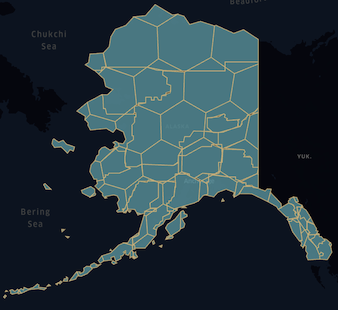

In [0]:
displayHTML("""<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAVIAAAE2CAYAAAAzsBqjAAABeWlDQ1BrQ0dDb2xvclNwYWNlSVRVUl8yMDIwAAAokXWQv0tCURTHv9oPqYQIhJaGO0mFT0ojHP0RSNAgplBtz6c9BX1eni/CJWhuEfoPKpp0aWqoaK+moCkiKKg9cCm7nfteoRady+F8+HLu9557AHdA5bw8CKBiWGY6GWdr6xvM84JhjNBZhF/VajyWSq1QC35qf7Tv4JL1VpFerH5zPjOxczIePVbaexelv/19MZov1DSqH5RLGjctwBUlTm1bXHKD2GfSUMRHknWHTyXnHL62ezLpBPEjMdOKah5wS/9ArkfXe7hS3tK+Z5DTewtGdpXqNOUU0ihAQxAMy8ggC4UUhjhxECHM2alg/h+PBdsjgSo46jBRgo4iLHKIkcJRJnfpbNhvBIgdz7Dc/e+ddrUm7TJZFULsdrVZ0ppPgKfV1dgAMNYCrj65aqq2RArckWfglf4+SX2SfWe1zXDImd4bB4YehHjzk9c+0GkI8X4gROeQLt8Dl8YXM3lsJwPHewUAAACWZVhJZk1NACoAAAAIAAUBEgADAAAAAQABAAABGgAFAAAAAQAAAEoBGwAFAAAAAQAAAFIBKAADAAAAAQACAACHaQAEAAAAAQAAAFoAAAAAAAAASAAAAAEAAABIAAAAAQADkoYABwAAABIAAACEoAIABAAAAAEAAAFSoAMABAAAAAEAAAE2AAAAAEFTQ0lJAAAAU2NyZWVuc2hvdO283W8AAAAJcEhZcwAACxMAAAsTAQCanBgAAAI9aVRYdFhNTDpjb20uYWRvYmUueG1wAAAAAAA8eDp4bXBtZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJYTVAgQ29yZSA2LjAuMCI+CiAgIDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3ludGF4LW5zIyI+CiAgICAgIDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiCiAgICAgICAgICAgIHhtbG5zOmV4aWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20vZXhpZi8xLjAvIgogICAgICAgICAgICB4bWxuczp0aWZmPSJodHRwOi8vbnMuYWRvYmUuY29tL3RpZmYvMS4wLyI+CiAgICAgICAgIDxleGlmOlBpeGVsWURpbWVuc2lvbj42MjA8L2V4aWY6UGl4ZWxZRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICAgICA8ZXhpZjpQaXhlbFhEaW1lbnNpb24+Njc2PC9leGlmOlBpeGVsWERpbWVuc2lvbj4KICAgICAgICAgPHRpZmY6T3JpZW50YXRpb24+MTwvdGlmZjpPcmllbnRhdGlvbj4KICAgICAgPC9yZGY6RGVzY3JpcHRpb24+CiAgIDwvcmRmOlJERj4KPC94OnhtcG1ldGE+CqkPDFEAAEAASURBVHgB7L0HmJzHeef5TsfJOWGQASKSBMEcRJEiqaxVokQlS06SnLTa9don2+vz7tG7e/vcc949ny2vz0GPsyhLsmSZokxRVGISJVLMIAmCyMBgco49Heb+v/r6G/QMema6Jw/QBfT011+or+qtqn+9qd4qKq/bOmmFVKBAgQJrggJFRUU2MZGwPTs3WCo1af2DI9ZYX2VHT3ZYMpm0vTtbbGh4zMrLSqyrd1DXR62+tsKKVHq+Xz5y1hr0XVVVZq8da7PLd2+yto4+6+kftst3bXLPnGvvsyv2bLKY3nP46Dm7/uBOa+3otfHxuO3a1myHj5+zRCJlk/rX3FBl0XDIzuqZyckCVMzWSULmmmDSaEASxJpMpdyxOxcIuGNd8L4LfwsUWCAF6GKFbpQj8USo8tKohUJBjUeNSf2ORsMWiYStKDCuT5GV6Hd7LK4MJ62kJKoxHHD3TMSTFgoGLaZrKY3lYt2X0DmAMRIJ6T6zPgH0hsZaB9iMc0B1Ip6w7r6hNBZMWkDn2zr63bspRyHNToFQYnxYDZW0QCji7kolRPwkjSNq638wFHXXAuFwYRTMTsfClXkoEAp6/Ulj2RLJwqQ8F7kcdQRigNrREx1207W7rLa61Hr6Rh2ojYlz7OkbFvAlrbK8WBxolR0/02nFmyJWWhyxweFxi4RCdtm2JnGTYXGyYoxEfjjdoPINCmR7+kYcYJYVR+1Ua5eNjU1YQOB8TtxrQMyTz1iFQjBSRe69c5X5Ur8WSk6MOxokExPuu8gBqKhOj6fTT4xaUTxmkWD1FHEvdaIV6p87BQCFsEC0v1f9S+KiFQetsTZq4xMpSxXY06yEZPRBm/raSgFliRPxh0ZiErcTNjwy7kT42ESJgHbQhod1XiI/IjicK2A4Hpuw9q4+q6oolSg/oPuGrUQAi3jOoIa7FJ5aR/egmKaU+81zJIAzs1m8Ywft7nrhT3YKFIUjFTlSSQ0QLdenuDA7Zadl4ewMCtCxSqMB6zo3aJ/52Wvtin0t9ndf/ak9+WyrRWsqrVzXYnFPjTTj0Uv6J+BVXBx23CWEGBJ4wk0CdlyrqSp1TM3g0JjFE0knzpfofkCW66gB4ELRscJZelyldx7uEhAled8FbtOjxuL+5g6kahzE/3BpxeLeWHj6kqAAA7pM3GfnuRH7wNu22N333GGHhsptW7DXWo8es7/7xit28vSw1TWXWlIDviDuT+8WDgxFF6TCoDh6X9TmLkBSpy3oRHAPIAHNQFAieTobHyTJgLYopOWlgNQl0XtzeoVaBl1qKik9Szia0yOFmy5NCjBwS+BEO8btpoN19omP3W7f6ai2H7cXWU+yVLq7ZrvzumarjIzbU8922XiyyGoq0eU53Lg0iTaj1gAnAMrHKTgzrrvzaVGc09wLt+qDaMathcMVokDuHKlfIDhTAanjTAtTnU+VwneaAjA/0XDAevsm7MrtFfbrv3qnPTPaZIe6zaqjcu0RaPbKlrm/xuyWxlFL9JyzL339GXvsp+espKbCqQIK4n6hO603CuQPpK6GkxaMlLhPpsix3ipfKO/SUwBuKRaftFRi0v7yv7zNjhdtsgdPmTVJiNEpxz3BZI0ldJ++37Rh0raGe+3Ua8fsr77+irW2StzfIHFflv24PgUua+nbqJDj0lMgd9F+2ruLNFDkLhEKSy8jV9RCKlBAFEAvh4g53D1i//1/u82Ga7bbN08WWaNANNPjCdVfWPcV6/5X+ousdaLU9u1otnfe2GwloZg9/WyHxH2zWon7Bd1poWutBwosmCOVR7BFyyWfFVKBAmkKFEcC1t02bL/7mZusfv/V9uXjIWsIyYI8B4XgThOTAeuXuH95rdmNDaMW6zxj9339OXvyuTYrq6uwYqkKCuL+HEQsXFp1CiwASNGCiaMoqUw78Xu/V70mhQKsGgVQlVeUBq397ID91qevt303Xmt/e6TYSos816b5eggrcgDUUcn+MQnzd7VM2s7iXjt86Kj9yX0v2qD0rXXNJdOs+7rdccDOKCPuFr/LAve6al3gkn9xjqK9t0TN6UPV6cMlFbLcsxJqviFyydP3oicAPcAH0V/68BX2hjuvt68elxO5QBFwzKWH0K+4T4ynxP1JifsBOzteYldc1mzvf2OLE/ef8sX9KpZIKmP9n9A7RqQDGOuLmRb7yL9Sq++4QGb6KqQCBVaKAkWhcPlkNoMRfmwkrqEHLQp6+lD0ooV0aVAAnSfJW+0m/ad+u/4gwAvqB10kpO+2syP2zts22Ic/doc91FFj7UNa+y2RHl3ovEkv8R13WAtOpgDwhPQBg6kiu67e7GDdmI23n7Yv/vPzEvdblaX08lrmWF5dYtuay+z6vXXW0TNi//rDI7pWZsHKiFUUB7TeXF4CGL7SfXneshRuKFBggRQoKi5vmGSZKMDJuKHvF8nRlzX2fOOEz7fPNRS8exdI6XXwGG0PMKLrxEmeDxb4US3ndNYiViFhereEPsRj8AJZXHtlo/3ap++yp4eb7OWeSasK61lumych0vtpcnL6Cif6IkEzRuQupf/21k2TtinYY+dOnbVEUchC8hrZt7lcSyij1jkRtfjoqJ0+edZeP9pmT73UYa8eHVFnjltUa9Rxx6Iu5FlIBQosBwWKKuq3TSbjcUsmFFGGrlYUlFsT4Kn1uHqjz5kux8sLea4dCoB7cJljEpXjQ8P6heQRtJbmkDVXR9ySxfracoVvCyusW5nWe5dZKhCWiidsmzbU2vNjTfaTdrO6iHSVOYEoves8tM0EUl30uF/YYuWH7+k2LarbWTVpA8Lxm5rj1lCctMdPh+yHHSFrlAvAnlqtT5fVv3xyxEb6euyowsg9+MQZO9U5qgUCQbdkknwLqUCBpaZAkYtH6stwfu4FUcinxCXzDYiOxpJ24LIa+9jb9zpOL54KWjxcYiWKfZkS96g1bRK5g3JxColLDFq3HEFxU+oalXg/rHBtYlBzEuehaoZIz8/sQOpxrCFhKcxwd7zIdpfH7b07JqxrrMi+czZsbaMBa5C6XoyzjcK6qh4NcrfaVpGyK+pTNnjmuP2Hex+2WhmrJgrr+iF1IS0DBTwgXYaMC1muLwqUCwXbW/vsc790k9102/V2biRg++vidmowYE+eC9vR4YANihOsELbFhZYJfSLCLcxE0gS4Tw6M6HSi+BP4LBO3MFH60oC1CrB3liftzZsmrKE0aQ+eiNihfulIBdxaieo5+itnspNGX+VLOYDvTgXss3tjduzpp+wPvvCsNbZUaLKYrkKYXqDCrwIFFkaBYKS0+t6FPVp46mKgABhWUQKIDtlnP3HQbrztavvr16L2/XNFdqy3yOojKbuyfsKuqU/IjJOyVnGfRMOrkR60LDjpQuTlap3Ph17kOSbg7pae4INb4nb75gnr1rvvk1tVdyxgVemQ5JmwCJBPOjB10fqsXEjcPRGyG3eWW09Hp716ZlQRlSTi54j4ALMfXi6fshfuvfQoUOBIL702n6oxIFop/8+2s/32Sx++0t7yzpud65IM4CZVqOPq+rWUs0IW+GvrEnawScimZ84MBu3prpCdllhdITAVDjsjZa4ANVWALAdwoeTTLZ3ogaqUvXEjRi2zx1rDdmggYLVhBfLQTdyTTR3gZ4lxNKRPu8LtvnPrpDWOHrNf+90H5Y9aNqdzP+AZUhQlYqjGNGMMjCp4siqIwYpFAdgMoFshFSiQSYECR5pJjUvoGDAgzF1H64i9584t9pZ33WIPtFZah1yXAFEMRnCF5XgaiS6vDwXt2e6Qon8V2VbpH69rTtiO8pQNTSiq+rhAR65KJRKzAaKF4Iwec+8TbrnnPyQ96HUb4nayP2R/ezRiY9KP1kiXgO3dzx+w1M+sCY8AuFWtMrUXtAz14KYy278hZd999KRV1xS7dfw8yONwnWEFNA5LGTsmZetw97iNyOAWEwhfvaPUTrWN2Wj/iMUmgwqQ7IFqAUyhXiH5FChwpD4lLqFvH0Q7z43aO+T/+cEP327f766zc0MC11Aqq+sSnCIINiQgHRbY7RaI3iyg2yGuEZH71d6QPdkt45SuV4qDRW/quMYc6IoxCQ+rQXG/V1Yn7W3bJ+RyVWTfPhW2l8X9bi6WL6h7vTKdJXneJT7EAugU2PNQJe/GMrM3N/TaF77wsD1xuN/qnfO+JgwVsp8KKQI9bl1bNlbaG6/ZYHt2NVlpVbXVNtTaUF+fnT3dZj955rQ9+lyvXMHEmUeiVlmtPZQ027CiCveqArjO0jiXwOkCkF4CjZxZRaCmVCjX1RGz6y6vsl/51F32+FCTHe+bVHxQ3EUFQDN8OjOfB1CBM6z1g/oQkOTymoQdaEw4IHlNgPpyT9DOiEutEisrBs6BIKA6M4F1cLttMiY1laTs3Vvj1liasm/LmPScjElVabWB706V6Xc6My9QfpqrnjL3Hf3hrDuFk2/dnLI9gVb7+K8/4FUiyfY6Qbv+QI1dtbfRtu/YYNUN9Vak5c+9iWI7KS5cnlMqk9yuKuJWHVDYvyEFpj7Tbk8/d9q+92yPaYc5eYpFrUysL/637BuZIPCy6uvrVwm6XEgXNwUKQHpxt++02rHSpyQinag40Wv2V9uvfvpOe2Gs2V7owokeTlTQI5F4Lt2jn6Gwya10wvAElxrQ0s43NCbFoSatWqDYISv/421hOybrP1GeqsSlIkf7mAIXOpIG47s3C4ib4nZc4Hn/yYi4O0+lgFP/TAiaCaYOPCnMPOwg+tI+lfMD4nb7Xn3OHnvqtN18/RZrbq63iro660+WaFlq1M4OSVUxBhhOWmlAxjTNHBMq9JhUF5VSLWyRL+u2soTVhkYtPtBjba0d9uLL5+yxF7oVE0APatVVeV3EBbbuHVIgdJWrviIkfau4ar/yPhEL3xcNBQpAetE0ZfaKYJgJCbXAmV42oNNmhjccaLZf/uQd9tzYBnu2c9Jq5USfy0qk7G/wABXEG5BoPiYQvExi/60S+5v03SuD1EmJ5090Bh1QY5yCQ2yX6H5QoHvbprgDy5/IxepFGZMq0clmAG72dwL4PnbOhNpsTwD0WiGlWyMC9Ht2jDo3qD5F6z85HLJW6YV7J1QuXS/Ry1nzD4QDguQOTsOJg4PjAlRAtVxGry3lcKoJqwmNWXhiQOJ/u73yWpt98/FWGxscsyv31Gola9Cef6XLAtqIrr4irPgAqUJwFch7kaUCkF5kDUp1ABkszwz+ngFZvbXVLsDwrttb7A037bbNmxvtSLzRvnNGsUJzXImUC5l4X6bYv0G6zX01SbuiIeHA6KXOkL3SF3Jg+/bNcdtalbAjPWH7mlYnletBDFuLAfS5ywj4MmFg9ceBv8gGBZ4l4jq1LF/gLZQU4aaMWbNwuKqiE9kn9fy4CjsiUK0QqG6UDna36lMf1grB0T4b1b7xVlFj5bL4nzx81L7+0Gv28hFtExAqtRpxrOQDqBbSxUGBApBeHO3oaoHoHpH1eYiISL2e8eTWa5vt5qtbbMPWjRaprrcBq7AXu4uk+5PoKhZsOaRNBzb6w0IixH5A6paGpO2ulS+qgBsn+mFxpA/JmHQow5i0HGWZ2byUjfc40NcPjvV/QYm8PFcsvBY8VQVuU1fXTNrb5HXwVy9Lgazcb5LbWHWyzzrPttqPnjpuD/zwnM7LC6GpxAFqPK1TXVAhCg+tCQoUgHRNNMPiCgEQuL3j4T5jo9L7VdntAtDrDm61xi2bFUWpxF7tj+qjy9LVlQVSTnxdKIDkU1oAC6RiVVS3RP+7xYnuE6D+1xeLbYtckzBG+cakfPJdM/eKi6WKJGGoYqoi8iftTZti9g9HSiwgzlWrZ62xRACrJavNkRGb6G23J548Yl964LieKrLSOsVulf6VsIAL0aM69y1erv88H1/XBHWkXHd/JEytzYR4Oot0dUGBc713tvtmO3/Bi9bgCcAwIh1oX1/c3nJ9g91+8w7bsLHRxiN1dnosbI+d0Zp4+UNGhWal0g+WakUSdF0JEIVcPpeJt1FUYnSn1sjvELBsEbOmvfDWN4hSwbQelUPUEgkBZ2VUvqiJgNOl1miE1WiyGJMa4cHTiqwVqhCgltmd75aa5ebd9uOnjti/PnJGOwuMK/xfidWW5WaYos869Y24+77hhKWGkEBUAMVBaFBcgZh8vgrhA2mVZUhZAGPVgZQyMYvyYWbF/8+blfmtXjJPwmrLRmlBFF/zpIR0UjPv896dkkEGR5z1l9yOne1j9v63b7MPfeBWOzpWaY8PFNnRAQGmaFouv9BatbKwawrUVqOWACpA47cSTJOw9aJK9GXiEFRrWa0i+OpYJwRu1B3OvF7uZfTXn3YUaXFDqVaL7bSb3rbJbrlNfqrHT9u/PHxEetReK6oosTopjPFeiM/Qo6JKiEgnOzyuxRDdeAkkbO+OKnvXh/dL991gjzxxxP75O0espLbKubkVtmhZ+i6WSsS96Hg0eDqtOpACbiUlES3BC9no+ITF4wmrKNcOpQLRfinsAT44qGyJThmNhq2sJGp9A1LuZySvCzuGwRlfsNrW1lUqz1EBb9KBdFI9taw0ahVlUevoHnL3ZWSx5g9pRwZKZU3E3v+Oq+yJnip7pM0kPsonNKhRKE7VB7C1UhmMObTN+S64Vkq2+HJQJzGezgtiTFqWpJxK6aN+JFSHidIXyxvKpacFqD/uLNZKsRa7en+D/ea+HXb8tRP2zYcP2wuH5fivqQY9Kgkgpi37+mU41JKrpqYKe++7ttnBA1usekOLxcTpdsYidveHWuzg/mb7X18+ZJ1tI9bQUupiynrMicuq8CcfCjDIZgBQYmzYxWkOl5S59iW7VQNSygeIbtlYZ3Xaz5yG7ukbsmMnO2zbpgYLC1h7tSyP+0j+t/fLndEzAkKBcHNDtbuX2R8u1nGp9DqlkIwvAGZQHOeGxhobGYvpvUnXybkOFxxahzuhUrsyxdjsaB3QZnM3W3+0ybTwxraXepGZUkCVRwKquSYSYDAmIxNLUEtk6ErKEHVhu66Joi6oEHRVOH81i9ypPJ2pyyhzIKpNuIdUITULfgJdCv/6Nbl+ba1osGv21NivXLbThjrb7fkXT9l93zyuO8mZxpy0t9wi3fc1W23XZZukvqmW+qbYftKlhQNjnlT3Umm5vWn3NfYHv9NiDzz0vH31X4/LyFisHQOCc8YYUOaFlEkBdcxJMVyTKTFd7Aqi305aTrDwRGqTREzXNMmlO/CqASnAWVIcsYa6Kjvd2uWAMBwOOhHbA8ioXbFnkwPB10+2u0rs2NJoZ871uCDDtdXl9vrxdte90AUBlru1pW//0Kh1dPZbbU25Ag7XucnkVGu3JvEJZ2HdtqlewBm0cx2yonYPOI6X9663hHGpoydmNx1str1XXGb/Ij/MSoETSx7XGH5eQFpg4WJM0B098KSMef2xoEkCn7Mt0nO9M/zVqwv2jabsGyek4yyutz01dXbHv9lut9y8xx597FVrbqywy3ZtsmhNvXUkyu1RhTc8PihQlr6kLKRFEBrJ0HVCAP6PRwN2bX2Lvefuarv68hb7/D88Z21to1a/oXTBBq2Lsb2y1knAiOienIiJtiKmmDW3zRI7hYjAXCMBpoCs9mrix+pwpBQoISVZuURqALCnD7FcICBOkd4A8k9IxD9+plP6nxarks4IkRzgZeOzsLjLUh3DedJ5qAhR2osjYet3In6RtYj7jMXidra9173DbZimW9s6BLIC4YbaSjvX3udUCuVlxV5eFGydpCBWWu349vEPXG2n4rUmKU6RkfCTXNsV8IuHrlStfVElgJFIWFFNaIPivEMS49U1503cQrtJeLI6qWQm5OHw47Yie7qz1K5r2GG3vXuD7gja4cGIHTkjlzLpD1h1VcH8rw/v9UGZLtwk1c4hrV49Plhmb952wO79XJP94HvP2T9+65iFq0qsShG/xglAUEgXUkANlpDnSyoxIRxSg4igk6m4zglUlcAmcCcYLhbAavZKN/CqcaSZNfDwKw1i6Y4HkPZJtB9Xr/L1pG6liQruGYh0ox7kXEQAukGLvju6+rVVRtyKpTdlRUmbONORkXHH5UakKkBnNTg8pvuD2nGy3IEyz683/REGph5xGB99904rbtpsDx+V/lcT41oGUZoVDo1tQkjEE23TMZb7dJN7F9bxX+oBR1ouo1JMblCoMvJJPE8b8lilJkUG6VPtAtQgW1FLDaXfMupLB+uNXweFPDQjYcgj6lVKXNNXjwVtf02L3fmeatu/t8X+8kvPSaorcKczSOYIyt50CXGikxiTtAPE+Z4psR7Dt+hPYr+wULECMGQkGIMVT5QnII5qZDTmXDjgOAEzwI+igvoYh/jtB35gFuAcLh/oPTnvn4tNxK1VnGeNOM1oJCRLp8frwPE644aeI7l89TyGLI55GV/py+6etf6HshLlvaYuam+76yp7vkeGOdVj7Qv0HmV9PshrkbVO7dzLR30AwTJGlFygCC9IPIGFJsdl6mH0qOXibAngohWmLnFN/+dMPofaKA+CM4OTdt/xMgtsPWD/6XNvt4+8a7vcrYYV8CrpAq3MmdHFflEDChyJjfQLRLUJqMR1byxNp/AkIr72sQsroE1IRqaZaVWAlELgxjGqpYu9MjBt3dQofehma6yV0UlTL6CKyA9owEWSMEyNjI7b9i1N1lxfYwMS9ZkhXHX151zngLu3sb7SEvGk1AWDVl9Taft3bXSWebcrJtO67nX5Qxjl7/Sr9LpFdHpXwBX6Azc6JlXIr37kgPVGmuypLq37ln8o9Vgvaf2UND+KOk5QYrUJ+EbU1dC+LLaudE1GgPssIDPAHVVDWVHKvnVKMQ+G4U7vsP/ym2+0bfL26JZOiKhVjMcFZJ8fgdbY3TBT6DwnhvscliTGR6QbHRMuZMCiG1fSgYoLjZRVWUCbPYI7jhEDQNLjblUDO8NVYpkHIEdlTe+VfpNzY9JtIoLDgQ4rTuSYDEWUuW9g1MZ13DswbF29Q7LsK/6lQHNI4jsGKgxNE1IFUMmh4XF3PibdBpZ6wJM80cPGdA/PgJ4Ten5Qz3F9PSR0veNywH7PO6+w46kGG5C11q0TXweFV9Fd0I99CrvXMRa0HoXa8wKErIPCz1NEVc3FVCUMYK0c8gmCvZbUFvRutobpVbd/sT9i28W8vO+2TbZBu7I+8uQZi4vbIjLYOpqP52mR+S/DiQKe4t5mEUsFmNKDhovLLRj13NAAIp5jC/tkPGZJ6VMD4cjqGJsyq4iYDlhOTo47EAUE8SUlcQwQAnhuBtARRied1r3erAHHmpCIwvWEnuNJjplhUR0Mq9K+Ez7GJ3efuFsAleOUjmPpYz26phP1xkhQV19sVdLxDinkW1CcxnpKDGg+8D/rY+rKjbq0zYQc8JtKkA6YMCSWZ6rZcstmWe/yuVPQ8sHTQQVZabTb77jF/mjPRvuz+56x4x2jFk37Hi9rQZYicwiueuSVuF/Poe9MxuWzPiq3BxJ5zUy6F2t9pKzy/HXdhzU/ERuRCsAbd2AIvTmDh52Z08r8pm5woQCqVyjKfR44vePzZQEUfRD1z2Z7DhK7fHW/n87f573DnRcd/PP+fWv1m3KOST+6Y4P0osUlNqA5Bj1cnt1pVatHt4MzvdgSVUK0L5dOc1K7lyYEqmuxmow3+kud4s9qv0P789fEaW3YY7/8sestJmd/5w2y1htHlfDdkHIpKuPGifAjUv+Jk0zEJJnCiUKM2ZKeCUZkmde3xFVLifuMjwxaYkxE03Ocd9f0PBb+8ygzW4YrdH6uOi2mCHOQajHZrsqzDoAU2Wljc4UCYURsSCN3PYESwILXTZLQc9IleoGkV4WUS/5S6oaJE4PQkFwN1xgzekF94U6L5WpVLlj9aYcmgbSVelL6QdRHPlD43zpxQR6reSIuQEvJYd6lOcqW0rYwfAIS0QFGADSulUkYlWarE9e4N6TtZBDj4+PDCuM76AAz2zMJXV8T7k+5NEh6YshWj1wevyjucdxCMq6VX9UyPmhDOAEpq4QYFOsh0YZwbVJLuwlgnRQ7J9JSl5BcnwJyxh+Oa2GJ6rrW64cKQrydfF+1RUoMpZgs1+PeSkCfsaHNABMHRNIFcgy4TgBGAigMMMuRWFXkXI4oQLbkiKs/up4UhxkU6OnHtDsdCE5xkOmdH3S/JytQeZ4XL+k/lt5iJ6CtYwJywCfByaakBphmgJr2Fn5Ior7g3Bo9gdUe45KnmnBUdCX16ew3PCf9cxxnnuf3ek4Y3+B76hQzYDgp1zD6wjqrEFXgwyD2++86q0LW4tLPiLNKexDhKqLGWQ99T7Do4YmrFY7nslxrrM3UYAOeKW3HgiM6DRgMCbhY1bNMaTYQ5Xx8fFRl1jJviekkHOgBP/rV9HR+dEzbPgfAFIDixhSQHpQHqR/6T+5za+jVQQFirPi5pHUBpHRIlodWVZbJSJSwk2e7nCGJ8761HW4NnSiRoHxXIAiLz+jFkthHiEAW0dJSbS4XWDeDNZP+zgNNfpY4lq8XTjqz/LMdY3og0j4h9OJyxr9wUM/25Fo6T7kR7VWmLLMAnJ8PXkG5A4XllA7YLEtKE9BxwOkX8KakArZgKaecrHdHP+klrk5HUo/zTF/2v1ReuM1QSbmztVB8XuVqwbfwJSGgRrRHxEctkEtjrmkgpYJworXVZW4l0uHj5xTAWIp8nQNAK+XIz1JQVnCcbet14IpTfnO9/L0Eqh1aS9/bP+ys9svV3n77LPc3tBhXpKeGhqgWHlTYS7LYh9aZxV5VcPE6TTrSMhllEPM5dzEkOGzivRKPdCi+OGf81aWHKjLbYEmDG+WDc8VB3dcjLkeZ4RLjYyMOMKfAzInffq/RdxoYneit+/0rrowSyWfWBcAkCElAZU8JKLk/KfBkggCUuQ6AhuTulJRYD4c6t1jPm5Sn97U2/3qzhVyg5PfJzNQsZ/thuTThV4rlfrOCkgzJBxVfUo7hRBPSrbT3DMi6PWEtTTUijCe6rM0a5l4quggR1DfK9SmwTi32fm0xkDkQzez1/sV1+E01qA/uTmHfGV/nGJQXawJcMLLgRjQFcktcWUR4uE6XAAM+06CSn5q0JKIj8qPL5Bms8gAw5Zue1FICRpeNLgCeMTnjx8fOG5IA73BphQeuce2/5djz6blk+7WmgZQCI7LjrH/8TIeVlhTbgb1brLy82PmJRrXGvkTr6vl2blGqtAQTq2epqFYgQBT8Sdd7ouFLpIBLyof24N46G1O8+4E4jvjrq2YMAzrcmIxNiptxUYn2qClKtRxzXJLgmMIDXgTdLqfOhS8musWlBlMAGq43l8T742PaHluGJZ7Byn6BbtMBsQJuR0sdF800F5Re1UsaSMIKP2HVj48OuDB6/rn5vtc8kFJ/1tyzAuqpZ193UaEaFL8ULhUOdFgrlI6f6bJjpzsd17qxudZxqF09ONvi9r2+E/UvUyzJjtYRe+ftm+0Nd91oT3ZJP8XMug6rBviPCkiJkoRe8Xz3XYeVSReZMYhIXyX9aEwgypbUlwqQAkBwfr6D+hS7t5DmVF7oJOESyTNXbhBjUyLmcZ88456bAkaNEh2jF0WvG9IqJYmzTmwHcLOlyRQeDEpTeXg/5/q7pnWkFJyln0TM36Nweugr2BKEpaCI+oPDo4pnWumuw7WeHFHcUQUwKdf9BIZGd+posR4RR3UHREvFiXZ2jNt1V9ba3Xe/wZ7or1cQiqTzV0Qvt94SdcI1aD2WfTZaMxlIQNAWIzJkaGpgi5H1P4XPVtss59WoRI0nsVwSQ02+gIr0CBh7Szaxquc+xfLs7FOyRPXiCgGpD3UsmEiJ48Sxfrb35P5uV2n98XP3f6+5b3ShBDfpVhAS4o22dvRqbfy4QuGFZL3vVlxRIj6F3dp5QuWdaeuxegU/QW8a7/X2U1+HeOP6IeJ8V2fMDuypsl/+5J32/FiTHe1LGRvJrUeLN+0AiI7IGFPBvkbE61xzPW5hBXKivUbTqOpGpS6WeuVEDQEZQZBhbmB2PJEZMMqdCug2k9JJuo6fB4jOVT7KgygflJqPY9bGw716SWVboveQ35oHUgoJEdoVWxRLvRdCz9NI0FTtivrknfdC7nFMwGZmKT5Y79dimiqVDrwZ1ZtT/bYtVjSPdkXAv3JPtf32r91uPxWIPtOppX1uRdBarFFuZUK0H3EeJdJRrXnFUm51cm2pP3gidCkQy3rTXedWy/nu8sYbTvroKhGhnS+oxm4uKaWFJhrISwpugLIbWxL3J5X/1LJQf5DlUrAc71kXQEpdvO1AsMBPb5hs5xHr/dlwxu05kmXpbqO0IY2siIsl4E24LqRfWrZlD/KxCcVA5EZMv3LtckkzfL22l/idX73Njiab7SftgGhqXXKiXoW8v1STuY36rnbbZJZrMcfUKSwH/Lgq1DUaXFNRnxZTrwU9K5DCej6R6BeYlokb1AohgGvOxpb4XVLhhbNb0EtnPuR6mXNzYmUSAJrwHeuXAUR5+7oBUq8dIND0lO38TLCd/sTK/aK0eA0MEF1EjsTnzSuSzeXHpt5lNQp3vrMlanCg5QqtXiGPhJLikDb1C9udb9xnJyeb7f5TAdtwEYAolId7Yw5hmyy3jPLCJuW2dZUQ63F9whkfH9LgOlnVtGxEdmCF3nRI4nTYE6/luzn7uPQ4R0LWEZ3eAe+iCucBM3rR2JC2GpILVa6Gq4W+NuSLlbNXcqFZF56DEx1QBIs339hiNx7YoK2jtd2JgkOUavtodi4lQER1RbEVa8+osWRAodc8i+NYIigLcECh8sy++1zAmhWpZz3qRGf2ACY9YqcSPR6wUTzhPLRoM3NbO7+pF8GT2T10XEB6kWgsFk9gASrAGE/KT1MGKKzmTKTppVPp/DkjAureQEDjw7zN5dIXF/iFld6TSpcbQP0ChuLj3lpSFv37oOpfLHwvjgIRWK6xMbvj5p3WsGe/nR4gTqXAVdI7RomEgHNCXlpjfXKb0Tk+uHThZ1kswPnsFWO2uSRpraOBqXXciyvR2nkarlT/130CBtjLvj4t27En1Xy7h677SudTgbQo7ZaXythDCkVkAIpqCSbbHau/Y1DGSAXnuGhulPymLPTiTBVUZULbiMytWsinQtnvDSXlwEolcAUIa09sx5kyxRbSoingbR0Vci4hj54N2EvdKauWQYKEnrCoSHtmu2PcZrwByLVS/RgW0vRrcm5WxPUTw0GFPMMiytX1nTz+A/cg1X99V2Va6YvVroQIvJhWbE2r4GJ/AKiuA0vkF+ZgXHIGJs6lwXbJOrifH2UG21YgIUu6NbO4Brh1rSz5KqRFU4C2ZG18rTapq5OLFsvim4q1kZnUowTsKBEwFjvxVp4Iupf7wUmHlToeSBCUIWA7KxWWTc9eLOIiE8i4RHtHB9FgZbr5opszawbUBQt9n6SLEq2zH1a9ziqYDByp/hdSVgp4lCFQ8hRwAqZLxSVoIGHs8pz6tfUQUfCXKu+s9fFOZoxPb6Zg3emEIknnGvVkjrwv6UuoScYUhHn3Ju33UlLquEuctX2R1gdN/zuTWIBLsfrbySGJ9DIyeZvbZd6xfo/lvOBWARFBfogti1WV9eYuBBQw+WnrLOuU1HBLY8LesDFutZoo39qcsHbxIrQhQFtIs1AAzmG5kuNK0iHwHIg69mS53ubyzQBSuCJ+4lyLy4C3S+eyvv0iztx1E8l5FYq8PBgPuUGX68Ci7RHl2xXXksFZ46IKrW8uB3oAmGflZ1kZTdmG8pTd1JAwLdLSJOMBaq70Wc1uQx3QZZ8T97mvKmW/ti9mN7fE7ZEzYbv/WMRu3TRhn9qj4BlqQ/xlAdxCWiUKAKj6sPfScnOlWd2fAFRCSaEvLRigFtYJXLAU+YdubqmUuB42Mad5xeBEPOyQkQlZHz3p6wPa5RGPqXWYAEjcY7XQzD6xPW6bqhL2TFvI9tcn7Spxc891hBU/gB0si5wOGf4Bzn0tJQAUz4kucZt7pW75+c1xq5C706vdQXv4HAPVK/OfHSq2D+6YsM9cOW7fELAeHgxaA3pxPZ+tTjq9ahw57yZalRcwfC1Re+nK4uooH1WCq3hr6Dmz8KQuym7bF6SsQOru4gEO0mzyBU8WTsxJAW8TsaS1bKjWfjha959tFM2SA+0EJ9MtTm1Qn73ifJ7rk2+pONP15gblRGC8EDQnfOKyCWsoS9kDxyP2XH9QG7BN2g0C04NNcfcBUB/t1IShuperZ0KHPMg2CzUXd5pJgDJ0iAOtUXk/uH3CNlYk7exA2P7+SMhx0/VpoGSosB/VXx6O2m1NCXuXAPVy1fMbpxWlTNfKNBFijPKTTjnutk8qjtVIyJ9Dmtyq1cdWm87LUn8YQfmvssLKOfxLZen1qvzf5pot3UzZwHR2IFUhWA3gfL9UkOVmjfOv2tp8AoKHxb5E3Ybt2t62pMT6ZDSSO7IDhlxLzaDEVWosFrDaUkkH2abBXDNbhfvoc3Bx52JFdkVV0j6wS0FlxFX/wQvFVqnutF3bFhMt/0edIceN3tIgQG2M2x7tef90e9ieEQCVyxgHoDLIM/BnRWoDgFKHAYEMO4PevUWgqDKeGgjY149G7fhI0Jq1XLcxY8kuKhmea9Rinic7w06KeI+A99fFnX5Lk8cr4k43iIv1J0NUBDsrUna18vUT71zJxCq7SsU0HJBXCWml37/cdS2S3zY+IgQwWmgvAjjnS7MDqZ70fb/YpyVERJcCoM5JTwYSANo/Erf+ziG75x1X2KZNjfZ9ubHhrM31XBO3lqoBjw8G7Ppm7dOklvIHYK55rNZ9ACiuQO0yxPyMuLIt1Qn73qmI/aQ7ZI1p7k0ODS5V8Vv/H08D6s0S9d8m8LlVHODjrWF7oV8rvkQ71BrUH7osZ2LMUH78QYG3GxvidktLwsYEqN+SqP6SgLRMmLNRgAh3ObNNKB/n4F7HxGn+xatRe++WuN2zJ2bPt4XtG60h53OqyIjWozx3aJLZIA73edUfy38+fWRRdFAdgc6Ewv4lJTb42/MsKs819jCsC1H86TULXWefDUSz8TRzAqkv1rNHCpFZwlo76++ut8ZotiaKE5Fis7d73PbvrrFP3n2rNW3fYj9oL7dORRjTQqW8QMCBsjiyNhmcysX1NBVrH/J14JjvQEgAiqvXh3dpn3QN2PvFwb0+JF2h6uFE2ww09EVK51+r849LvH+hJ2Rv2hC3dwqErx4psu+fjYgDDDijG3RcLg6VshIrdUDgckNN0m5ojstQMekmgad6g1oGOmm1Uofy/kwRPVvnA0xRazSIO/3n0xF7TRz2OzRBfFKqjQcl6vdpouA66bSufV4gvU80w0i1nIlXAi0xvadDkwV2kHu2CNARgcS5uddzuMzl0BuWPTlOVIbzuAwUGNA9Y3rur50JotkA1M9tbiD170obn9jDhN36Vm7a9Auw9r9ZDtovf5ibrm603/jkrdYVabI/fEV6NYEhywd9wMilJvRjRESWUA5JtAdUmzUATwlM4FLTzFwuWa3sPSpnr0B0n4wx770spripQfuzIxFrUi+r90F0lhL59AFQOf6awKeubdJukzvR+5VXtyaRx2TUOSEaVItzW0pABUABvp502e/Y5BmSXukK2YPnQlLLmBPJdcsFHOgs1XGn/ftRAZxRuf/fF4vtnm1x+/Tl4/bI2bB9RR/uQVrZKQ53OSN70Z942bAmCgJPbxZof1S0rS1NWKXiOnScoMgYnvKrI0+t2aTJwduqRJDqPJIWVtK5ANTPMTcgTU9PHpsscrNplGOZ/WwK3+iaSoR8ZzpH7LGnjtuBq4P2/q219t2zGiXicHBnSuYotyEWx6QfZXCfkI6xXSCyWZb7+yUKRtSqE5oqfeBhIK52grMC3IdUqF+UQWmrxNUHjkXtVakltmne5Rp1ySX59WoS+PDMP4t72yzL+B3y0/zQ7pidk2/t4xKRlwJQfQDFkAQ4Y0jaUpm0471h+74MSTjaY3Gn6LmWP1sd4V5RTZRoYvxH6Upv1gTzth0x21LuLQf286bu/nG2fPI9B5OpVyrQtFzMpGZgi+irqlN2jYx7zvSsfvTj1ojFFPdhf1rX4tM/33et3fuZQRaecgFRci8KRyroJ/MngYAn1otjUMzBiNawuniDF516en5SzHYHHZeweOPaufTA7lr79M/caMXNW6T/K7Uj0pPWhrztQeYiOKDTJONSk4wxteJShjWYb5GYGxMn8aC4NAY/IduwgnNMXnPlN1tZl+o83ZTYALKG2c3icOgO//C6DCvDAdskEIJzhMuhrHzrv1dmFTqXcvMcE0uvgGCHuPJbRYuNMtC0LgJQ/XJ0pi3xd2xI2H75tJ6Q/vM78gft0Ook1BC8eymBDZoz6bD0t1L5v2tr3K7Qe1/QxPD/iHO/slSTh+5ZLJj5/YIFA3CfTepHcPYN5eQubxAZyh6T+1m76o8N5qr6Its9ccQ+9/tfshItE/f2tXe3XrJ/EOtzBVGIlDuQcrfPUYEYfABXObuGSyvTIySXoUFGF3cqlazWOaDRMjJhH/s3O+z2uw5aV7DJHhZ3GlDwWpaIZhssDIBudf5fEOdVLyBlYB9sTDrrNkFO6sSVFotz6hKHelLcXkzgwsAMi9tNN0dO4LQU1NdrXXcA5LaLy0E8HdHAjOgC4uOIOOkODdjDg1rBNKFdDlRWfGknxGmjsohqMqC+fEj0HL97uRPpcxxzC/dh5cZVyAfUFgEqHOpjGRwqEwzgl60n+gCKo/yYbnivfEH3yf1qUGV9QoatQ6I3hi3KN58OlHItNFEXynhcixM+K+d9wPQJqRAeFIhDv5luUrm8h/ZXsae4Tybbq+Q2d430vFH1GYxKP5U3BMY72gAOnHqOqqI7agIFIJ2HyAArKRu4OtDNmSP18snyV2vFXTRsgYR8ti4YDVmeuBRO4UeK3rSnbVRO+aX26Y9ebc2799hPOkvspV659WjA0vkBVAY97cQA6xBgfmbfuP24I2Tawt6tlPmi/BJ7pCu9XCLzHhlBWsRZCFMEtEF7tS9oT+ozrIFSj/goUGVAwXvMBCadWpIEeA/pfUXqVR/ZNmE7BaRfPxqx0wL47eIar1AZt6isVdLDsSSU+nWPBRwXGROIdcqAdlYgOyxQxDqOIz6WcERPP1EH6JOZ+Mm7AdR+Pbe9bNJxqC0Sx8/JmPW4wMgT+T0w9HPjOY4xJMGhXVOTsus3TGhQFHmuVn2eJX62CS6zDEt1TFujOniL9LEbNEH2aen5ZumWHzyBZ4DnJuX3jbneST4kuM9R1c3nPpvlCcAOBK1SIzytxQ4npaNFteD3O4CcR5EmLqspcKSOiHP88YGUW2aC6RIBKVl7XTYYZpe+Uk4UUpoCxZr2BzSC4wNj9uF37bR3vPVq65Mh6sVu6UAVRqxU3KkPeHBMdOxbJGoi+pVqXvqyRL5WgU6ZABKwHNPoQuzcL/ACVJvLE47j69BAeU7GkVMCs3Hd53McFIPW8VooXagFfjHwGLht4uD2CyjxDT0ui/MDcm1ilwjEeELKDQggA+ptGwSk+6qlphC4Io5PqoITCh2I/2h9JCm1hQBRoIpB7aRUAWdVh0lxS4xwwJK8AFSS47j1DTdFYuXXuO7p1LsuK0nZndKhAkTnBBxPtGvvrlHFPNV90JT7oMAVuo76AS+IpzRRfUXAW6brvmuZu41bVyAxIRwVHX9dOuV6id6/83LEfvuyuB2Q/vKw3MT+6VTY+dvC6c9UL/jcJ6vF0H0G0tzn9eI+I+I04zr3vPrCIbXNoI594xx9IFMSUhEKQJrR1g4QZxkoKwSklAbxMmiR8uqMohUOoQD7RhGbtFvc6UYFMfnFuy+3Gw5ut2h5mYDIE7Ece6BGZAfKq+Sgjfj+5y9HXdxSfw94QAFgwUVmVGCJCL1JILJfYHWZPvXibBD3z4ij+akMNKfFBcLtVQqEWR9AHwG0+c43AaDoaVE9fHxnXBxnwp6UoeLH4nYqNRlwnUHK4KScvIOBTjkT+oVFeoe4pGbNs8U6LpO+GG6VcqGaqBOYsFwxJtRgUzzeNa66kJP2ghXA8o0Xg1cHwAW6xkSMuIJiA8qoPvbXJa1fOs7jfRGBLmVS0JdI0Gqkf9wtMR71wuGusLbCkAFQoEM5+fCmlU5aQSwf26S1i5v+a+mVoeFlkjZYEcUKKbj8s2pDPB4cbXWdcvrcJ+dv16S7WZMaxqwjctF6Vu0O9xkR2laofrQFz1LHmYm8ChzpearMBZbn77rwyAHw4kX78xnjYoARquC4f54mmUc4648IIcb7RmybLPr/6bO3W3fpJrvvaJE1CoxaBQa/LN/LbeKc/tehqDhWhWfLwpGQpw+qgMWI7hsVQu4UkBwQkOzQ4MS5G1B9RT6ZL0v0Py3Oj4hSiHaAF6DEAMslMcB7pP/coUH+ZjmXMwC/J33ekbRv6FwDFe6J+wHVMYED5jbCB8bV+ygDCX/Gzyn4h/DOXhQwt2hy0BRgYdXBbWwooCWyPp4P8tRxoMpyWbje8VhcwByw+IQCoIwqWIh0fuGAdlqVnN7VPWSlxVGraGxQJK2ItQlgqAu0cRxujvX3Srl8f49r4jsmXS+qBfS3hE38kNykAMinZRRisQKqD+inNW52jaSRa8W51ohOcPOHeqTiEffZpgmEZbfoPqnafO1LuxSAdHq75gum/v35GZumvzPrL9yi2PQqIJcKx/7QYwtpigIEiGCv+vaucWupL7H//G/fYP0V2+xLJ0L2CzvH5S8qq/drEbcqZjYQncpMB1AXEmvsOHEYsTokoNqsQXadOLCN0h+WanChozwqQH2pN2RtAkXWfsOx+JxkNkzxuRn0mNfVJu0tcg86pjz+WpxSg5qX1Tkzxc7MsmUe++XkmwHON8mBtPL/hNQEr6ps35NYXqG8MfbwfurGPXzgVBGJSQS/5hDuFtczVCTa6srFI4BucLaN4aTtb0zZ377mLQgAjADvXMvMe1YilWuCQC1CG7g667tdYj9La98qHXSfABK/012aIHdpCW21nPzhPg8LPF+RgSwoItGW0Ga2SS1bPaBfAUizUUZtIeKou82ZfBDlpiUHUh884U6JvM++0qFoiY7nKdWcRb64LkIJuNMhyZnx/lH7b791l+29ard1DU/a370m3ZgAAbF3Po5iJlUYGAxESI1+sVfGDHSrW6WjPChOlaWIcGM9Y0E7IkB8XoNxUCAGp4r6wAdOysegxDij//Z+DeZtGsTflG/oCxq8+HgCSEvRpKqmuGmzjwlIWWNPDFYAOrPu/nsoFx+SD4bcR70pD8fuo2PiFGyR5wNLM/9WyzSxYwHKazFRZv2flqD/iIjPCqT3y03qBonwr/cG7LDazec+0X0yafAseeSbIMfFAKQ+oM0HfPnSZ777/fdyn4bsEqd0bwVE/VB8vOF8SD6abwGtvsTFXM3soEBMDtDlYkNidWX2e//3o/Y//2PSQpv3iXv0JqCFlA+q+gCDMYYAGYBQm/StBMwAVLGqHxSnSvg6LNdYuxENj2s7kwFxqlUanAAZcUPxEvjY3pgGcND++IUSN1h9R/mFlC/bM5QZMK1SjNIKbfLXOhG07TJScX4ucPA50ynWlsxVZ2jLp0QPOx2hckItQCBpzq+XBEfO5CYFsz0nvWej2u3PxFlrZzUX6Ju2hT5+e6+Xei1nOXPhIjPfD0Z5YUIX1jMAbh9Mg8Fg9N7MzJfuWFZTdg5kX2s1PhtQTSYSbmMqz5F/6d60HnOi6bB0h8QGFivE0f0PvWrXbAvb2w/U26sDIRmZvKWDAMpCE8/yAXTgcvFR7BVY/kR601cFjr3ag71OXNvldQkXgWibdKxx6Vu7dM+7NyXEBcXtle6w/bMsyIjSWJDnAreFlBMQhXsWz2i36J2bVZ5nVTbo4+v68snXpxdW/0YZmBq1uOEZ1YGJZb0leBI8Na7XxIdh7EW1W72GE23g13MxdYIkAHat9Dx1yR57+JFDFtZ4xbC3rlK6bfPlSJGWEVPcSs2FTrPpdy8jkMqoUaJtNtzafO0QqKAnk1oRxd5QbLtaWGLqdVU4RmbFyqoSe+j7J217g9k7DtZa63hUek2PO1yKbk0efADVKoEqzE6n9HDPCbRekW6SbYSbFbX+asXRvFYO4rhfPXgyovigIYny6bJ6X0v6lzIB8K+KYyZ4x3V6/80SYztlGDonA5kvuubzUvo2ng31CvSC2xUAtB6BFFULOu+btSgjJY76OdUDZ31othQJOl0sQJoviMLcRcsUdF3cTCohn+K0JJ0vXaEhGAxDsDxJCMFmevHxEcU1HfdaH/QXO51S8JOFFnx5Cru6uWKZZqO8hpYy+x9feMoeefhpe2tTn22tlpVfoh0DaqkSg5DBwzcO2sTOjCr/Q9K93fd61P5MLlcwJI8o3NtrAjeCWyA+cv9yJfSbtTKI9QjY/1DeCkcFGB/U6q43yecTV5/F1H8JSbdc1Z8z36CUu1GpPFjEsBAOfc7ML6KLvoide5Xk1aJAz0nFXMaes9i0+BxmK4Fjmdn7aVhxTbX/U3ooUmgisqSQawtpigJwpmOSR5s3Vtuf3veSffm+H9htVZ22rUpLKwUmywEIgKMPkgRQJkjxiDigPulH2SuK5ZaA7kokygFQtAjY//JE2A4LTHfIDYyQdgvppNBLTk7LOgEsN12Y0FDJ4HXB/l1RsV30k0KaTgG40fw5UvUPMXSLJagP4Avpo9NrMeevdPiqGWxzStGj3HasM87PmdUlchFL/qYtlfbgo8ftledesYNydxmWWLcYriwX0jFomdpYEFCk1UfVAlUsxssB4LOVB4ygDBvlK8rqJ1ZooYLIO6nQik825UuLvnS56Zd3Ged5ALqjnmDjQ9QbA3KBwpOjkJaQAkuEP4D4qjXNdCv+EhJnnWfFABrCJ0Ubdr16rFcAELMyKREBuuVOvAIdKvFWKgVmDGTKs5KJ943rvVV6P2I9QJpv1ckDeuHAz1hZr1wcixiqZJ2nOxCsBT1vvrRYyba7lN+1KkDqnPblW5qMTzhFr+vtl3IrzKg7k0xIcu6xMwNWnBiVpVbLLDWCAIjlTAxSBmufdJXsEYUD/EoPXN7HiqWgQBAwXCgnCa1WYvJZrvZgAiDubJM8KYj8hb/vQmmRTxkRVX1xNZ/nLtV74UZJqwOk6iXJiZjbRyU+NrR+WQaPhkv+FwCokjx35MSQ9ff0yvLM2nOgYfkTb0FfGdVaeLfaJt1Rlv/N598AmLMUslOBR0gASL5SGMV2z7kc1t8fau5cuOQOFosT6MWjxYrURK8qgGl+lF4VIMXlID4+5PZRYWO9vEdJfnVcl3d7e42nrLurT6HRkl4kJH/6W6YaIQKzvJSgHyzJZE3+KuCo05OiD9wiYxNbj3RoL/kxcWS5JiAHtUS1xGLc8Dleb8nBpv7QHl0y/uEitpzVmJZ3+kcmd5p5vN5oma28Sz1RrAqQUjHPj1TdXDuTuk6TrbaX8Lk41paiiJ042aMlnDG5wAAJy08puDh2zCzV+0rT4vVKNgPceIUUo+yqiS/rJ7W/0ScUam6XVllNG+zzFIp7oVZKnHxKo2b5KTdPgfK8jFTAKrMy0aBDnDmBsFdL1wvoMIcv8zyeJ4UWdvtyTQirBqRer1i9zrGwZli5p5x+T+GAjp7q1YCa0CKGgNt5kgZbLpEV8JGNRy5H1HNScSxX3uBEGZyDvvxav6CA1oSSI+QdO3A2S19ItKu8QDGvm6n36ieKDJBWiP7EGh1QhKeVtNj7oJn5vfpUWdslWD0gnY0uTLsZH3/NvjuXr6Jstnesg/Ms06vWYutnXxux3vZOu2fruF3fJD9PTal9EnWx6CJ+LzVOANLEEB2VKF0W0Yo0kG2FE68sEYjUCdV7pGb4C21V3EUYQHHIuZYHupBCWMotAABAAElEQVTP2uvguRET42KVHPFp4yFNJHyvSFOsyEtyo8FS3wU36qel5q7VXVc3ncdGjztl3Wt8dFCFUq2puGtY/dGN7A9FBP4LVyJM3bi6lVnCt1PtpFCjvCZs//3Pn7C33/C63XzjHtu3o8VOjpXY0X4FcFa0KOKLeoA6cwRInBVZ8o26BSXZUBLNQoXEyqR6H1uKrLRY6ThylQV3LIKYECbPaTtypDGAi/8lrkOA6Uzq5JjN6tymOuPPW6tQiOwnRRjDGuq/ApWg/S/WtNTgmUmnVQVSNFcsF51UcBNQk4FfpDimwYhco7R0a1rvZyTrBv65GzNGNmv4CSbtOoHLREcZ1zMrvJ6O3bjRn9FYwr54/0l9TtjPvGen7d/bYm/b3GK9jbX2bGfQFM/Yucp463gcFaaqyVJcwWDO9IB8WItjCc/g5MowldvKHwCoTBR+wBTKN1/iFlXBAWmvaMPz6ykB/GyP0iyL/aSi/49JQqiVvnQ50zoj0XKSYkF5ryqQAogEDABMA0SJSoNfuETRjZXc0tL0yIELJVpLXMtNiW/qc6WI/hNjcLBe4jzbRocA51xGnf/gGv5mE73aJsV0VRm/eP9xs/tfs8u2V9vdb91jH7xht/2wq9qFwiPs2oXDTWcuPDlrbRlQCbhQfWpk9V4Np3y/cKgZSEwFACo2+HwSYMoTeVQ/n+yX7V7KjLcTzvgD4kjhytdbHZaNOGs049UFUhEFbikljpJwe1OdJQ2oXHMcaPo+x13p3onhfs/qr/v45wMwNJ5MKcKU1AOA7cWSIMeElKLQp3lTqfUp4nJrX9Ia6yvspf5SF+yX3UNTjm6s5jmvGcxXtOcd+HEOanUTq4tWYiHAzHai9IixBJYmjNwm7VDHktWk6gfI5JyozDpMTBp4TITEhbbJ6EbMAyaFQlq7FFh1IM1GGvo/7lE+iLp7NIgSBD9xYOEBpsdvzMjBcaFaCRQbW7dgOsVI+0AAR6LjYjl2tktWrSwO2+f/813WU7rZvnssaFUadB7EeA/4E1C+IAolyQEgZXVTTXFSgUTcVDWDyMv3ExBly+Qy1XVHhYKYlMSt0oZtIhnWklFP3TDf26kDq6MC0EWuXHmB73yZr8B1JpFKSRe4f/XKh5RNAV3DrMC7F/MK35iznLrIxZRvOZ9ddSCFywyEwtP7iVCDc+g9feCECIDj+fB7cw0PQHfExT8Nl2o0rqOEGE9iE7eQZDpAFRCNyP+lS+b6Cu3+9vnfu9M6ijfZPx0JuIhNU9yKfzMP6JicdJRX4n6KMMbabgHRSq1uoqy8l7CBV2h/qCsreq1P3grxriELRM1Oh/db90TAyjVKp+o7R82YDJgC+uU65B3PcfMaugQdCHTdqB0DSL3rrfz5djhXy/X/Z9WBNFxS6YEmg99PDgQyfqfPnwdR/8bZvxFvU8l0mCwAZo2noFDEgWWnYrdKnK2qDdlAdzqOq5N1U7Z5Y7n9t9+8QyC62b4mTpSAy87lM103B52q6xQnSrUvJOPclND9bM0xpCj5rGwitF0uwDV3pnNfpZh4Cozo3Wz3fI92ySwf67Yu7ahQs2WHDRdV2CFtoYzyJ5/qcC9i8tpv/Qz6qLDssEoYQyz2g2rgihVog4wSLOjQ50YX9PBF8NCqA+n5bp4x6t0S0mGBAEN4McNAxhIFliZS/1pNU3veE3JpdMzuvHmj/cz7rrZoaZm19Y662jOBJBJJa5JO9Kw12APHg9Yghj0TRDPrd37C8WmXAT9ukvLOY6jLljDysKd8tTjBCnGl+DHOZfAgt2xzFXOj/2bfcMT7Ms/z21tTnrLdVYrHqij9W7U0tLd4u52ZiNhT3UWKxSk3L6kYFhLYmPf6ZeBdaz0xZyqSolt8kMCfl0lVbcCEsJZTNnE+E1yzXV/L9cm3bKsOpHFZ3APxiNuSxInzgg62I0kpMlTW0ZlXDclLXJ2GUlhh6dZSAnxK5NPTJ1l2sGvUbjrYaB95z61W1bLZhifLrKI8YYcHm6ccygOST1/qk4irGC91arXsEHhhDQFVj9lnJMKz8mYvTTdKnc+RTgEnxIBma4t+YTxAOltitVFMZmbvDd5dHLOs0YGffmA0Qvfn6i1g8PMjZN47tk7YVdrehGvDiaAN6d5nOorsx+3awE/bhdRr0vCs9rOV4MLzADv1JqbpegNTLPZ4TKCnBlhVjXWXMkF03RV+AQVedSClzAR55oM+M6A9noIR74NONNMFagH1ExYrco7yJq0FMGWAsxVzTDrQznMDtn9Xnb37Ywds6+4d1hust4dOmZ0RB/abV8jQk4rbM4oUz26Y2u9QywQDLk5ovtzJTDDNTkcVjCEreiHa48g+LAAtYXWTtm+eLQG/m8rlQSCfxykkJRtlR7CNs9qdtESBR/ZoYvC3WT6pnUsHpToA4IoFtjvEiT5wNGpnWb2k3yyHHFbEo2aJt6R8HdGhD7rdqOiGrjdIwbysXH5r/Y8z8KkNOsa0NbXqcX6KW+sl98rngyhcKGSnZ5E4f7FypmsCSBm8k5OKmp9MCkThIj1uNKxVTLgzLZY7XQtg6gPouBwzu9uGLVpebP/uZw/a3oN7rT9cZ9/pjFjbsABJnEiZAHM8rm2JqybtuT4FD1ErEfGdDpkPiHq6UnVlXp5OiPOZnKh/3vv27uNNcbFzLEMtFwjOtroJbgkL+5s2xZ0+FQ4KThPgo8zXqy7/30uqR0XS7twSt5MDQen+UrZfu5b+w5Fiw0EN0OQ9HdrRlD2bHIjoefKh2AzEhSRqwgfr/ULzWMh7F/sMtGAVU40mkR4B6Xqx2M+stw+YtAHJB9eLFUxzAFJIsdxd0c9f79JhXPs8BYKeuF8UwKIfS8OIa5MF/VlNMC2WfOsDaHF51P79z11l11xzmQC0wR5TlCPE9fJg0hqkk8SNCWoMai7xo9R7FfbO51N5B0R+D854cCaYelDjtQHgCweLSJzUqpoydLF+82TkwSGneQfg/tDpiEA/qD2GJm1UYLBd6yHu0QZ25wSOe5XX6cGA/bGCkNQLmH9l37hdVZuwr5wN23VOfV0kQNYyUDG+5EfGs7yS186b4HRZTgoosZ+9c4RI5zvvw6t4A0WUEOA8MahDn7wU1pPHgU86H0T935nfc13LvG+9HZ8HUm/UnS+/BhSrjViu6a19P39puY6K1HuSWunEevtgSdTbvnmJdvmjzOfBVJyP1Ajo0BY3ZHk+e2JQ4L4EMngcKAB6wK6+ZpeNFwtAZYV+pU/gIY6sOq0DBLDcoKdc3qOLAhQyccBEESkQIJ02MPnfnJ2ZANZJAXBMYnG9OCPccdzjM2/M+F0mvWeTQBIwlL3IOZQ3aK34xxW1aZuMR+hRm3VdW6jbi10hu2Vj3MULrdHkgQiOpZrktUlGxnkckgMANCTLP2oE9rWvlGqiU9z9ZqkMuJYPR5/Hq5fkVto+rkmnKKA4tFJzEBWfkIKzTWRL8tIVzuQi50jVycT5BVkNpJ4MRwhnEowoQIgjdHpkLyPREScR4R23xIDHcu+2cdYInEKDxRcAMGVZKltFY9xiOelSgynFxRrf1yPdrNiiz/7slXbttbsdgD7RHbGXTgMok6Z4JA44Mgc3lGZAEciYnT0Rn5cyUf+5QJR3UQZC2VH85vQCMQfwMwpC2fyZmDow4KVadag7KBA+rMmiTuL9uDirowMed8Wa+Zf6Qm7V1IYy3mT2XFvIuT8tJngx5WMVFiuyLpf71NsF4EPywby5JWG852FxvyNyzq8WaNOpM2nuCrGKf1zZ1c27VL6oJqQ3tsTdzqH9IiZbZWOwWw9gmitI5nrfKjZJ3q8OuZGsxkpqi+Sg1qezVBNDd4DgISF18PEx3eKJe3nnns8DQh8AzoGmjhOKoO/SEoJoZnESE3ItkkEjWl4jDkDgwsXFsEM8rk9Yo4KljAN9cfvgW3fYTTfssJKmrfZkX7G9IACFA3VWaN0722CGkR3WoGoqS0r3SK46sYg0TVeaYx0Z3BhqAlI5MLjZiI5dRTXeHZkoFceD+uPXg3NkD8DCgf7N8bC7BggQpJhIVRwDvt85F3YqAB1KJyw1hq7zfL4JylBWPAsA6Q/umJBuOWU/FHA+3hW0rTKCvXlz3D5zYNyeOBuyJ8UN6zYX65OyLOSd+ZYx2/2UGw4Z9QMA2qQJ5z0b4rZf3gs9owHpR4vsP141bl97XUY4/a5zS2Sz5bS+zq2UaJ8WcOY1bvn3ZVJxIWUMYSUnuQhKcII6jpRWuXOA2jLhmJf/zL/TXkZXW75UVMRwEvc9NjzFiTN5LLTCAEhUrAM7gMYHhuzef3eb3XjTfrv/VIm9eEw0Few0iOUCfIjY7uFZ9mHMWQYZiWMPYhZDj/R7cgRR7qYpCOXG6ibW8N8ug5LiTLtyAVyUD8MQxqKWykl7oi2tlqDQSpR2gwa/n7x6+79kTJGYX5v+yV0L4biYcNwOm+LcbmtMOqPXCXG+n3+xWHtcoUpQkGp5B/zVa1G7pT5hN4rTO9CYsEfOePpcyoB1fyHvPl+T/I6gC7TDd3ZAANosAH2vAHRTVcItgvjW8Yi92O9N7Pdsjzs980806fxIk4LWaDjC+hNXfm9embvn4zbnu74UpcwGjrPl64NmPs9kyys0zVmd0aNBA4fGSMJ6jusQ4uDFl7xBTv28OkpvWlbtwvh58JV7jcGnMvmpdPZM2Mb6Yvvt33inxet3iEtK2bmBlFamyOAhEiYYAWkaz5U7g41bWVkEWDj8cy3OlfPJ5+FQi8yWPG50tquznNe78QHFalyqQuypCdj+evmEaiCXBFMGk6zIflq+KD2qxPYnxf1lW8qIqD1bWgx4QUKmwTNyr7q8Mmk/tzVu5VpS+a0TUXtZIERkeYUjcKI+xppGAfqzvUF7Rp+bxPG9S1zr1cMB+77KfVZ1rFsBcZ8WcgAqgB/SBLVD0sZdWgrbovJD52+fjNgxlQmJpQFtk9JXTkRsrzwePrArJj1z0P5eAa4rdR3972Lo5+W+PH99YJqZu38ewPJByz83897F/Pbz9vOgC0L7+ZJfFr98/u/5nvOvM8edT27Eej95uR/izgHr+bsuoiNxVArN50R76WTd2n7HA+ZXxXJFEO5oHbarr6izz/3K7dYWbLY/fy1gv3P5mEAoaU92hjUA0qiSQeNsb+Gyv0QzqGecQ7tunBLPszw0jWOl4TzkFWa7H1memP0UTzDg+8Ut7VSE9srJUbtu8oxVTDbYE61l9poiFhIjc0Rif5/AFKf9Yj1QKc7VvW72rJfkChPLiN7JgoEPb4vb7rq4nRoI2d+K60RMxnBH9X2ggeocA66kJzrCdmQwaHfJ2PWxveP2em/IvnlaniEaQehPuZ/PUiWfnnDIwyrf1rKUvaMp4dQ2nSNBe1AAenJEMQTSAMoE6pe9WRPAaV37i5eL7V2aLH5D6okHxLG+Lj9cJoe5JqqlKn8++eQCPtzjgx3fuTyTSxn8PC+4lwbIo0H98vj5+b8vyHfGielA6l/UiHDcqIw9Fy+I4qCvdf7SCU/Reh6Q88njfwMcONd3tA7au+/cZu977032ykSj/eCcWa2u9ceCWuonY4sGUFpZ4j86/7ee90W4qfLN+VS6t0x1GoFCnvUBQHlnl/SN798yYTc3j9mhI53OdWtSqpAt4p5GJoL2Iy3bxD2qSYO5UcCFTni5B7VftlZxwQe1Ed5tUjWQvnUsas/LP5WyRNWbfZrNJJV/vlb3jWuS+HstANimPaDuUD6/dsW4PS+AfULiMwYvX5c7RcqZmeXwmzajzNMAVGqFJi1e6NAihW8ejzoAZR09W6pQPh9A/eyhKQbHpGj9hdci9iGB6fsui9mTrRF7XAG9eY4+6NfNfy7vb+WxmLrm/b70A7mCVD75+3n6QJjPs5n3+vlknpvrODuQ6gkXuX5O5+25sl3711jl5GKgCgQW0olclCZ1wO62Efvcp661a24+YP/aWmnHBmRM0mDtU75tI0W2r04rlMSt5ZMYHAwehBKwcLGdIpd3O+OSuCYCOX9Mou+VDUl7ob3E2kov01LFoD35yqTtrk7YtdLnXdMct25xU092BO2YvlmPzwqcJRnUMwrrqKA/Wknr9LEf3zlhW6VPPNITtq+d1k6jEnM3Ss8I6OQCKIAVdYXb6xco/93rEXuj9KtXN8Xd5+FT0p/2E8vAkwZmgtuM4l3wk/L6ADqkCXQbHOgMAD2V5kD9pa9zvYM6kd8mmTK+IV/d3fLVvVui/u6aoCs7Vn1czubK44JCZpxQszm6edJLGlCphN67XAmQWmif9p+bD+gy3+E/49dnvmf9+/L5DkbKau7N9gBbfkxqpZGWG3kjJNtNa/0cIxsk4jud4NIQ5wn8nC/HRhZkBxc6IrP0SM+I/d6/vcmuuvFq+/pJgc6QNqyTfgtdqBtMEn+v0iA6I45pRMDIAJ4vcQuDB3/Lg3r2sAYOPpZ0+OVKiMuDGD7EoX1qf8y5IsVU3r/WDp5nB7VnkNygGKhHJVI+1x3SJFtkmytSdnVzwnbIaRQOr1NGHQJslKig1H0pEvkIi5xf6F65NCGKo/P8psTbH3SEBKACRb0vFwCdWR7ypT2IJXBM9fqxrPm1Or5JIv9u1a1DlvJz2ngP7tR1o5kZzPhNlaEj3grswtoiWr5N3gLXCKBH5B3yg7MR+5EWXzBBut1BdS9lyDVxL891Cfxf7AlpUkvZ7Sprp0AZqz6caz758V7qj7vY1soiawn02be+d8jCEcXYWghBc61I+j7otaDkP6hv/3AaUHLS/8zyAv+5WS4v6HQwFCm7tyio3jIjsf0vqOFC0U0VecZNa/mnyo4VPhAuTnskUFhIKGNJKKrPrMz4rLUCRFml1KveVxoO2n/9jVutYueV9hUZAdg3qdSJud7jDKo+Ac7lNQlZjhWQWQYFjEfzJUqo17h7b96QtAPiDDfJMPGidHnkudSJwdQhENwlsf3DWol0RO/5rqzaV8soc0KcWUgoElL3oOhsJofoe0rLOVmR1SUA2iDVBZbwa/TBRnJCA7tPwIpuN5f6ZqsP1aRccKGA2PvkE3qDQPsRgdGXT4YdGNUxYUGoRSaywHiDkQdO9JQmPRYQvEEgtVGLEVitxaTir7qa+UrAng962x619xZxoG8VgB4Q/frV5o/L4v64dOQLBdDM6gGUbu8qGasek2jfpP72JqlginThkFaOMSlQlpllzMzDP+Y+1A4s2f34PpW1u88e+P5LFo3Kv2Sh7K2f+TJ+q9jZcZILOaY8bp3K0YF1+uV8+b/dsX4HNZ3fy+6cgWxgii+pgAgf07Wc4Cx90WSqnBqBOJ5HSivdaJx0PqpcFcDKCT8YUi/MM0XFDvV2jNrB3dX2f/3WXTZYud2+eiIsP0hFl1InzpzIAYIeAcqBGq2dlxHjeTmhwzXk2slxPWIFEGB2rYwTZ4cC1i/AWyowZSDRCdCH3iOjzQ0S2f9VVu9va+Bvl+/lblmU4T6TKoefKDsfgIc97wmv91MB78v6BHXfQZXzoFQZcKl9KutpcUo8jYtRLlwd76F+uAb1CkSvVBk+unvCxeX8+yNR7ZoacBZtyp4v90XesyW/XnB8gOaPRPdO6TGvUEyAmzYkLKpaHBb93USqunM/9aKs+Nf2ig5XiUN877YJ2yXjYp8mmu9oMnpadIF+lcp3qcrMu8mrSnniidAumrxVutO98p19qlvhWXTDfIFO6JsY5oqkkvmly2OaBMTVtg/Y9x99UavxtKIwsyPPRrS1dJ7GyCPlefv5nP0H/W+ucKxPMBiM3IsPKWvbLwAj7tEISLLCaM7kdS0P0Lgx801zPrjgi4BkuLjMi+gEaLKTaJbE+ZCWuQYlzrNaiiAo6Ea9kH1ZHpjlVFC9t18s0lsUL/RTP3e7vTjebN8+LXFYujZqz2daEgnYRI69yVskKj6vTg/Xc8F90x6a/gN95ZFRcbUyruB7iggKV5hPHtNz9H4xkAik3COS/exlDP6UfVWO3yeUf43qA/e1RyD2AmK82nJma/J+gIx8AB/d7izJz+v+QXFh1PdGAdBl+p4UkLTKuZz9lxjgPJMtcRpgwqVpu4D4Z3ZN2F6tx39Q4P5Ie8jjGvWi5WSWqJcPUvifPi6uu1i1Pyjx/CbpUXFTOiKOm3ZkcQIc6AEB2Aelt728PulUOA+diTqAg3OHNrp1SUHfpx30B6B7VM5nVc69AvA3pUX94yojQDuzn/g0htOPSVH472Vko773n4pac6rHHn7kJQvLr3ytASncH2WfLblrc90w48E8bp16cr53CEij94pybo17SNynYx38xwVQGJ0IcZc9eVwfXCvGm4D2WWJGdHpVHoANWaZE1rwKtQT6Ts84ptHqTnLR60ZsrJcSR404z31BdRT0v3M3zYWFDuiFMZnf33zDRtu+o9nGJ8NuGwvt/uEGebaWZhDBkRyUmHdUHGm+O3ICLON6fqeARe6pzg+SwUOi/vl+KCN5MpCqBJif3KelsiLT37xa7FZSuSApGqEA6b76lP1UwKiuMSv4UQ6Pyp7Yj/6ySwP7aT0Hp9QkznavONTrxaniG3FGHCorkLgP0Z/y8LxXTz2rcn1oa8LeuHnCOnXvFxUhiohQAJJuXRZAUrYXJECKMvFe9MJPi0Nl5dENWm66W2L/OQHVRtXtw5qELpfqBanhn+Q98IzaGOMPz1EvnzYXvEAnqA+Tit+Ps90z3znKCR3J61F5HOBBcadiu1ar/Z7qOy/qkw/vYjLDbWxr+aR9VGVHZfNHL0WtXJlsLOq1h34oHamYjLUGpK6C0IqKzJK45q7zJwvh/WuLMTT57/DzyiyKB6Tpks7cwthxowJRgBS+5DzvJVHalTflgAkQxU0KcRmggrsFyAg+4hK9ZcmT8lT+ONMHAtIfpkFSBXHnEd9ZtcX3pCYDAqJIIex6bjbOe77igculYgef+EmrPfP8Cbtha8Bu3S33KalFjiuYP6M8oo6Z2YYMxn5xLVdKROwVN4OhwHGUmTfN8WL/NvLdLos5BpGUgJUgygAs3/l8yA91w0bp8T6+Z8LOyJ/yf74aFYdF+3guTYMSbQn2cWNDTMsSJ6w3HnIrbmbjJP3i+2UFJAGSIb3n6Z6QHRInjr/7VeLo0KMi9vfKiHNC9OCtiP1nRJdd4l4/osFdIYD/riznD2v9PQE7AIrVkjSpE+2FAe0nqgv02qZy3r454fyDj2cAKPrJ+QCU+vp0RH2BDp26wan79PPpmes3z5EvHOhPRetugfxNWsG1X5zyYZUP4xfvoF33ySfvzRtidtfmmPVKb/+UOP3bpXu+aVPKYlqN98D3X9TqPOlI00xIrmVY9vtUwVwBEFpk+1BGzi9ZmpFZUThSIcSTJbu4XOKv2J4ZREQcdvFBVQI3e6pRvG+a0LOAX1C49DQLl5jUmvblNlhFyqoEaIQNSBcO53rKoA/1Jc4pabE+sdSYnTwH3TLQEXvfW3bYW+643KL1G+2Rtoi91i/lvbgC35IMkBJG7hflroLO889lBWdlSql0qgAIyyvJczagcGXXDSzT/JR0Wc/LwEBAZPLPOaVJQl7oLbcqgMetig36UlfAXhY4VMrNR9Tyku6lPPhonnzliLY7KbHXIrvs6XZxharXbOX0H8/85n3gM03CZELMgB0CcDwRNghMMcQc6gnayzLuvFn62a3VSTutgf8VOcdXQSMBw3KK8ZllzeWYtkSv+Kra83cvH7dXRLtvCex3iTOlnrOVlWv6754F1MYkp4ZEi+2y6l8nTr1VnDvW/EoB8VQ75FKgLPdQRoxeqB1+TqqRahmSviz3LnZkvalxwlJ957QQQBsmNtc6D4sx6Ua79P7+VNhCXcfsN+/9kpWUlks69bb+zvKKFT+FWE/KFUi9u5f/r18u/00C0vJJYn5GymSUmSXNxsEx6GYC77QsADMldKwJ7Z20LEnvQLXgIjk5kX1Z3jItUyI7RdVruzqkOxZo/4efv9IOXr/P2lM19ui5kNxdMDB5g4uO/fPi/poEIn3S/3WJYzisZYytEl07FZ0IXRoh6LBwQy3AytE1/UYwk/iet8p3k72MJpRfmqzTyjTbDwYyMTnRieKKFROneEqcFYOatfIzBy/3TwoVeiQHXt5o9nxX1L6jpZQ4ss8GFrO92z/v8lSlWJjAliNbBCI3SN2xUfUpFZAPii7fOxO2FwSqW2QpZ9qbMZ/7Wa3qN20hTY59ZNe4/bgtbCdFR6QF2oy28xPtw2/oxcovyUNWVyxOX9tb7yqfsG3SSRO4+TUZo1rUL16XZ8C/aAJhEl4ojf13+7RmE8Gf3z1uV9abtXYM2quHjlhAO09ceWC3dcSi9np/yA5rRdhx7XB+Xb10vckj9lu/v3aBlEGRSWO/vqvxPRNEKYPYOHEOWLBp/Vl670L8LV0F0/m5UHVF5/ekX9LK6x1EigoVy8Fe9VhwWfMoVEojZ0xBOmsaZIoQ2f7wb16w7T84aZ+654B9dO9l9nhHiRzzBVai7c/vGXdc5FeOFjuL9katbHnDxoQ4LjmEI+KKCwNYcUGCay1PO7e7AaEyMUgRLR/VwB0/5xkvci0q4Nwr4GzWOvQP7ohr9U7IhZNrF1eFwSTboNXrnH7wCXGMf1Qck/7XA7Zc35ntPupAQoQtVX7sUPqPWhpZp1ihn7kyZl+XfhGjCZGaAPy1migaXF+FNES4M6Wr5YoLLblOl0fdMqYDwiTuEqe9uXjCagMj2v1gwuprSuz1wVL7trw9vikr+29rkiV4NobJ6TkunAqA90G9FyMi7lyl0ajtPnCFvTpaaV8/XWQnh8V86G1M4Jul+y1VpYqYvdZgghN1wAWKZhJ8FcvqysT7KVM6pVcXe+eWtZxpUPVfvDTf6gAgmTjq2bjmpXlP9lziyHpKDRvK7Wz/hP3v/+MH9ot3t9sd77zVXhqotF/YPeb2HvqylgOyjvtHArKx9qDTZ20VV7ZbllZW6RxonHSxMrvEpR4VsGJ1xUFeTMwUt4qRCZkh1zZCF9cpwLxOA+qePTE7qXzvk78rG+dtRIXtSp79DyT9/Q0TtlPPPit1gvBvSRLvBHAoG5GhcFXGl7FaXCmGkDQ5l+RdS52Jiuz8VgkHCPHwDR7VtzZ3dXpcXMII9ML+VE0KaA2ANpUmtEAjYd09Q9ahxRtjJU324NkKLSbQTgKq+3Uy+myRR8a3BKpMIPn4xVIekoowldw5nRgR8lzb5HkR/B+HonbvgSJ7RdznQ+eC1iLgRJ/KkwxJAHxZhuZUqRZ/MAWmi89qyXLwae1nyFzk6Rf9M8vwDcjBlTrrP6N0KZJaH50uYj2uUJ7HQGa3WoqX5JbHmOTkClklemNl1t4zJot1kb1/m/zzZKH+kritOg0uSoY+kjX3cGgEqnhZomGReskGde598kPcqkF1h6yut4mj6Ze4e1YW49cVFq5NgBhQhy8RB4FuFSDyucmZNYaThcKtcrR4j9xh9kuc/46iCD0pSzrr0Xn3bAOW55gaCOJ2UHpLRM8XZcBwm+/NfJHuW2giK59LJQ/HzXGSAqzhRDnxaKCgwZBWgYnLJ7AMa/xpGwxTxB3oEjcfl174VL8CpCQjkgrKbVRWs1OtUu3IFYydAmgDshrQvW+RzrpR5omXJeJPIWO6HSGJTxZIBOjx7dpR33DIXKfdMQ0Mqp98eOuoW1n1py+X2g1l9LuU9ssqsk1SJ9B3fNrz3HpJgOlaTi4eKYE7lnVaEniyLHMCp/ilSsozOeGFwKMHYSwLCVhXQrTPVgXXKcdjtqGlzq5sLrITA5P2JYnztYCoer8bBDyocjOxMPC8QYk7UpE9Im51XMaLeonhRAjaI2BFp3ndBlQARXZORoETEtMI+4ZjPtGWZhqsGCSIdSxRxD90pzje+7RPEv6ngOhsAOrXx/VV/YFTHBXH9Zh0o0R4opxL3Y8Z+GMSj4laz1Yj+Kuu9QQNwiorMVDdpKgJ8LFWoajAC5Dlgx6cpaXoxh3g8oxQANAEaImBSjtQW77/+kjE9ktX/GaBKctJ/+RQsZNEuMamg7inoVumbTHY0eaobFCT1KgsLIoAGOFo2dr6Q9vG7fLyAftpZ5W1jStsYG3ccf1Y7aVBmAJRHRbSElLAi0fKNLfMCX9OB9YCkaVLKne66OS/AtWYteg47Gto2LamcksURewvXtPySXECpGnUpZCiAQ5kKZw0lRgkiLcaGxpcReJCg3LqDrkVUU3iIli+uUWD7fL6CRvXwGF99Wtpg1WHDFa4HAGs/SLxJqkMPilOiR09//h57belVxBEZT4QdQVJ/6G8AQ3+Sj1H7MzlSh5dWBXmiZnL9Z4lyVdkoG3K1E7D4gcw1vXJ1ojTfrlre1rUs8gTEg/XLVqZOnr19Lo/YEvii/bGwPSylne+QzToULuy7LNeqgEmlxJ9qtUGbIrozNYCUjw2AFJ07cQD+KLCB7Iai3L9klQ4paGEvdRbI9VSRL67k9YsL41BAfuApKNGdLt+YZRlIS0dBZy2ZOmymz2nyWRczUpno/ssZWtmdtelzHf2umS7EgOxysrtRy+22aYtjfaRHRvsG8dlrZVZ3jEnGQ9l2zMJrsKDVY9zYVkpmAsg/qBda7XbJpWX2Q6B6g75Mr5BzuFYvDFYnZT4/6p0oBs1aN4vVytibP6DtvlocCJn/oOHFiIx6NzktHxY6t7j5hZ3tHb/QALaCCMhvrxwi7ivoW8sEcDpkpLXZq4dvRPu7Gx/uIU80X/jk3qlVkd9TDusjmlCpDuxmg1xPTipnRc0gQ4lFLNBK93Y/rpPkslX5U7HdjAsrvi5fTGpgorsobNl1q3JtUrAnNJkSCCafv32eOAcCjVbYQvn56TAygCp2g8daZFbIbWUjamOq57Gks9pkf7nrPLyXCTiU61CBT34/ZP25PPt9vn//BZ79/ZN9o0T+XMCUMjnHOA2EQcZyHCVhwSST3YxgCddiDYMVpsFrtfIsRrn9YfS+lD0rg6c8yQ33DEiN+/jOM/H8yIu70BA4Xs535NXoWa5mTIiZrNgAH012z1TZkATOi+0/DxH3vfL/elpjJHKEKs/HC/tjeM+v+kHiPOoDHCZQ+3TB0Dq+J7LxrXRX5H9ieIRbBVHW5uehAHoYvWdU4ofi+8y5Syk5aEAU9UKJIkkDuxm81XNt4WZ+aVV06oiADSklVWrnRgMMY20xpYytyb///zTJ2zzZLvd1ZISJ+GJcQspI5RhAACsvAOOCMsrgwqD1Te0CuhPtMTzUflhKp6KPSknd647bjLPF2K4wF1qn4xeDGIc+BnAlGGpE3UBLFhCWy5wgsNbUq3PUhdY+UFTVjD5E81SvQJaAHrsSjChSQx9KhsCVumgSVLIVql3mBjRt2O4JFAK6hB0rtCQVW6vaIKtk4oBLpn+gusd9wL83eJeUQcU0vJRYMXIi8ElEMbxX/si+VsC6xzLSAMhWd8VWCQnQ5FGWyiqYCUyLrE3fahYW4U4tobuuLqJYozI2tNUH7XDR7rt+z98yTaXxeXE7XF4S1E6xGBATv8dmDZooGzUB31Zo7ZOxqEd40Q2akD32fbfQs03IDERfSxr3QlwzL7qDMzlSNCKeiDC8m7qMzOpd8w8Netv7pzv7vmuz5q5LkBPFdWKBXjEKlhqsgB+TGRIAaT/n733ALDzKO+9n21ne9/VVq206r3bkm3JNi64YAwYDBhigrkhIaTe3CR8Cdz7JbkpH0nIvQnkhiSXFpIYMMam2rj3KsnqXau+Rdu0ve9+v/+cM6tXR2ebtCutjUY6+7Z5p70z/3nmaaO89BN4q538xKhvJA2PLkD3NLzaGQBsAfq3GVCiiuOD443Da21nMpRZ8FRNiD6/X/TjZPeH0dsTFHBORvDaJDAUCMpOX0ftDxXpQ2OmMdDbFXY8AjD0tJ+xntZGG+jpGv29S/RUADHg1lCDVj4zH5tmSAquIbgmPWjcaJAJiETNdDLA8xhYWoKeDZGMVbBIiAZTPZE+5yz8nt6B78+XTyazN1NC2FnwOWn5FCbnqHz10+RwtnThtGU9lsTE60OiPGz4wAs4iUAFSU5ywgVMSkq0UEj6xIARz3TUO/KrqzgJSGmSgmn4tMZ5VC7OEgznn2dQLZuQme4E8hitudVGUreSMGoAQN0Df3wprB0JBU+icpcS4dWqP3RBpc6Cl95JvxD4eoAeZ1GuRJtgC1xaIFXh6NRSt0oCPL2neqdnyjLd9f7IwBitHhoYDgyUFu8lAMoTdYs3WvoX+yxchXjrki4SA+9iO7EGkH4jBX3EdrKS67ds7KtlEqo2DVOgkWN0CgFgVfnkU/Pa4gE7BYA+Vcd+QAzOIIUzUt4Xc1+god95FCk3pRecAAg6B+PECYNjpBUou4AxgTiqp84TAU/5VFDbu2us3PSuNCPCcUgvArAXUmalq+WxytqKx3s/cPzxQtIc7zvKU99Iy/gOfVuW9elYhb0Lpf9lbDP9+qkk57BEZsmaw9VKzKmWzaTaAu+U22NS6+Mty5V4sVvgUvSD83OmVwoM/U8RElPT3bLfeWtSrx0xAKJ4e/I7fzqqNiU1TKGO+M6lfdAHAsVnpdjjzxy0vP5G/HOK93U+GKrD+58Gix8wGjT6MHqmEaBlmqx+9DxW0H1tRjeAVFeu8EAO4o4QOUYCam0tK7XthHRGnd/U0T5BjDQmekulk0msDcZbToSKHi4xlRdF6ilJNYK6hO8vYXANxxZoDgCg/f34mcXXgkBTcQWaMuWVSzgfX+9fqOGGltlqF/Ec9T1EkeqbeB3PidZ/tPiqme8L+gyS2Gsrl1wmyfdjZJEVj+OX5E52Fe1gsouzn6DvWxhY2msClDAyjbIewyG1tAoEsFfC1LWAJqvpEejkWvYnwfe0rjasoGAAxQQDDZQB6+1gX2B6nDzgT7c+ogGcD9Nq18EG271tv111db79uD2RfZjOCoHUsbUs11EdXwNVAxQsg/JBSR1A02AVjzIXBpfi1eC9RF6CpLMqBXYBg0BG74oHVovVTEk6fj8ZdNqQTu/rPcU6L7h3z97V4NUtDWAw/5IEVy7+uLwjOapOiRFAFEB6SlRdIYml+4ADTNle8SL/PWDqdcURkCr00X8S2U5mAA9HYSANT9xh4A3HcRHH+UdtIwGPowxZLktgXoS7QXm0qsKbvgRB+p4XGlQitb2OYs1IrUkS/EIMNFYj/FsF5VnOUX2rGgOLra2ZbgeC03jjl2BKfUDBv19AeSSYlJWVtDmuhKltgekDpKpnZHCLb9o3BJgOyBJKXSMqEG9oSIsXOl1X+2VXfYoqnbvshumYWZhlX/vBPvuXdfOwWy+3txrhYUIlaDBK4TqHDp4CJSF9UAkxclG8zkpgaQ5YJCYMoIPNLgCwBpIG8GTOKKseyrfnsZduA3GzeUdLdwElkOp4sPkIm8rTOu3X5pltbwpBjaBUD/DKQ5FMF31bhgE4VqlHAN3YUSflrp8r/VcWEGo53ss6dhDVNgGHQl8fuzgIaajtALpHeqYQBslw11Gc8H0mF94bHMTvEq8MItDsB+WUktgF0cEDWDin6Kfha4GbAEuUvyTiDUxa29nCWXq7TxwNe8Ufj/WYT93VhD86qopKv10ATSmldbGaZfvMzAGbC3gqkowwpNomK7UGJkrtPCCerUBSaQSDJmTxUWVlJWc4suv3QBuMd+V88lpgegFppF4aTOJ5ymlz2IcovUxBo4JB5j099bQ3O/v9IYRXnhIJR7z8f1XiFNbLbe099tqbh+zdNxXYgjQGI04sRE+mA5QhBnpTSwee93v5IcHAOquxp8dO1bZaa1uvNbfi9KQN233cyktQ8ssfXGn3L1pobzWlYgLIIKI5MiFF67ENvKYYVZeuGvvzf37VbtlUabctmmMNhbn2JpY3J3A8ncmgE0UVwaXL30CREgjf3WcNlMh7aHegGgFMqbsNQLpHf2cPqJp8/DMPvpow3PwRSVuA4+P77HRPDmK0RBdVr0ku0tscQOk8kZWEdDlnoBEh0175V5UnfPlOvQ6Au3NujxUyIz6BC0VZDwm0gvn6vHR0cwFHsQXE7pHjE5l9FgN8G3HGXIHWRA7ncnu9G+9QP2WrlRPk0chSJZWGkjcuAaP4pPqWvqw+D6UvQdNMuRnmKFWtnGn43X153ynHaQmkGgAJ+E5024QApqIl5JxEvVNOouUsOj4hy0n8FTcshY7uUpf/E3VDVWXkp9m3HjuMEwu2Le7qNlGqTWe6rAWQbEIh8Nhp/AVoDefEA6KyGSWyiobadOQG6/NkRlo/Wg1f+NsX7d47q+3GjQttyfxyNmkDUOtxMJJntiar2f7XP75iW3c22uvb623xvP32wTsW2e0LK61xRhhQq9sZhFDC06GlVAbHl6XK0qHUshgMGDV4oIwVabRnseLrnlpa9unXYuNeiAqR3Ps51aZIQQSGAiZRoRLkzcQsU9TezDRU9ihtOc9qMRN98WSi3Y6zGZl0fge1sQKAS5ODkvFH1VcsHAHbEMAsYd5cpOraZroUynMGFkhy2t2IGttTuBjUFifajVWu7gS00ifVl1OZ1FtG+4hyy5wDS6AGABbL3MXXO1fClLXAtATScG1Rf4FfOtjHZlz0HlGovVCgfvsSDRy8UoejqndN48AC3P71wV2UkBGhkaX1GMzPJJAkLYMdTbFTEN9TP1VFlJe2e9C5aqb6J0ORhjIy7KHHjtlDPztsn7lviV27fin7m8+wYvxdvvL0W4BovRWXZ+LabcgOnO62P//yqwDuPrvn9kV256JKO5qTay/VkA4DeTq0mIBGdVSTXOogylNAtQEH09cgwDmJo+MM+J0CueggPrXYJ1l0N3nuv5VdOzPFjoFlopaUcFHshneVD1g+gLyV/ZOkTtYHf1ZUpwAUMZhlAG7aqqQUQC7EnDeTJbwspGoQCD13HA9drB7kL0G2+lK2nwHYeqpTaYwnKJ78oEqqf5L0REGrjccK44gyVhK/0M+nMZDyXegBzjOVPhHnSQiWpG/q9oTS6BtPD5kmnze/OD0yKOjYDB7XcSm/QFL+XHC5MmpJFa9bzqTxtyY231cf3GNlzx23z3xsle2Csv0nrgvwi9ou10SEdKRVySWZdqCuB0B9xdYs3me/+9lbbX9aCV76w7y1WDleSkzT5xPFp+OlDKqjVIkKkYJfzf5GP2AH1ddwFyiBkQP1QHl0KisyAdxd2LiXImD6Ojbus+Bnh+BnJwJUAlj5RhAPdTY8zfezq6g+p+omu3xR23Le3AD3RtuMyHqpDpv5w+S5BdCV/1lw0+35VOwoT97jnfGCp2871Uu8VtVD5HADPFKxK66EqW+B6Q2kqn9glIkqdV7wo+5PfTNdXA6qgnNqcnHJuLeDzqRP4w35v3/pJUZsouXMSAdozy7ixCeUF/801oVZFTm2dW+jnThx2haXFbFFhrQCRqZUtOSe6kCTuKW93OhlQj2JD6l7UxFUnWDaokabAMYPzOnFZyg7FKA7uwQKcSSpO/jolvfZ4rigbjQIEHaDci2omylhKcNr+tKyfxBXiOWArLxn6b1egLQSvudK2AffxlOTPNPLfl5fSvEFvvIApXAh4Bl+M/KXeskTVBGGFfKHql0HJGxUXlMRvJFJDCJ+KrKb1mlOfyANNh+IFBwQwUe/aOdyJp0KiyALKlSg2TcCCuhZh0auJdvuPSft+soFFkpEvB+YoNR2uhQ1JiFIDSAjntxUBwGaeJJyESdVrakIZOEAyqetPOtQUr+RPbCyEB79xyHpYEqY5GOcf1S7iNKTGWYbQh8p5uueayKOcs6twKkL8q0AbeuuOwC2fCYLtasMJcTVkT6q4sYJ5HhVv8kIakItSOYitGpDP0v8WO/Rf6z0fdnHijfVz9+u4Ky2vxLepi0gkOwBUEcCUV+tfhhxqbkhe25LnSX1nLEylqcCjuDgERUqX6ezcvvt11majoIrPtmLPgo/tPx1YZLAJJLacJLSy02A+tYSXD9RjvMR7qwr6bcnEepI8+GchnBvnv9Hqkbx8Zhc0kZqKxXX/zwYaimun55rSS3AFT86gZ+yUV11VFD7Kq7SmMwQRzlT8YPbxGShuk12+tFljcwh0bd/4a7fXhTpOD9PCtO+tGZ6RQZcCY7aTIfRV13D3kE1p21RyQw74pb3DDRGmga0pPlvom6jJhPIvMQSdQjywPEMp7ANPbBM9oBXuqIiP4hqUjETh7geuidLoFyEPm/hsm4vS3oJdEYg5l2tRcGqfVp5X2WsgbepJbl4mhxihuG6cDJ8Tkyd+1/MFy/ypsqZx4iW9sAJBFhSlYpaeFxkDue+Ptkg6qnRc3MZ+UrxfRn8u/565Lem5sk7DkgT6PkNNShO0tULSlIdbzJWZwpTQlL+Dnb1qWnk6ZCqpMOSHe/afdJuYHmfkBBWJ/NlU3uIX6l9mpbiYFjXIwGFf+dijmp1UWri6Ukqrp1SJ+tLUHQHjtp1QNZHj7FvFvI4pyOqZwJVmVzKzdxIIOoBVPG0ceEDUOllSNwz8EDfwrL5SEecFYi3qXaarIKT3IUGfS8BvHRdtYeUnDuLjXApinYxIObfvdB6X+z7F5pv9Hs09TsnCERbmvvsvz6wyj5xzzwAFesoelIyayyPl1IxCnHdzQiSAMipHL1DmkCWPyNRkG55n5dsT2+utbiOJnQYJUA5u9TUe2GFdJawQpspDspCS2BJljXY6wE6fSvdu+jsSUAK9tozvhELpK14jpc1UDV5neLXwIQhSXwskFHeAlEJakTRfqCi135zZbcDpW/uSbZT7J310UXdds/sPrc3lvihiq/3LkfQt1L+4o0eom4SbDVR5yP8pH96KcOFgNpkU5AXUobJaKN3DEUqncxmdCd/44E1tmD9Ohj6vbZwToF9/u/fxKs4jnFLU1A7GbLGZlRTuvuscma69SPtPlHfZTkZiU4X8HINhov9kImMJE0IjXgdycIFkAQ30iUNBk0kKUwgdbVd1oP1lMxSfRSBl4BHfiuX45ZNfDZtczFV6KD8NPAFnnfj6b0CSu/js/rt5dpEq4a3J/UdgYCA9dxaBGt07rm+nZ8ABCySls9ln6tOPDXFcZ4cqK/ejE5X7+s9Ua5Y1tp70S1dhUCqBVd1P2Ub651s5yIJ+6PH462sPtFuQhXqN5Z12+vVIXsJFSZRt+KJ+jZVHlMVfF2Vl3MGzcddxx72H0UzIA89VumObmJV8SZOvuUQWvGi63uhZfNAFQTA4PmFpOvfj5X2aOnpPddNI5Xz74/2zlQ9e0cAqagpt3SFpFq6sMyerQnhrCHRPjBvhX3ji4X2nUc2289fPEIbhmzT2kK75qpKW7i00hIx0fzC3z5pNS29loF2dTT4TFWjT2a6GlRnmlFQ7Ouzq1YU2pv7ceZCxypixzSpQ6mPOYV+RnlDTad97K5KS84vtv1VWM2wpbC8RJ0CvOahJH7vvD6nUP4T9lnX4BMfUO9PZhCIanvpxVBO98/sc8tRWfIsye+3+xb222kcgLyOIvkhdCu1S+Z4AFVtoCW6HFHrXHnUU4EUbUMMH9Slwf1YdVF8AbCAXaaf65hINpX3Oi9Pr+Ke7hnAXVJ2qSgJ2PNpFLmm+7eD9CUmgZuwaFpSANgeTcJUN975UlA+ijvZQeVUeaXs3yKJPOB9PWC/lLaTnuohtnN+6gTbbrO8v5XtwCsgEL57LMlKUC/Qu1NRpvHWMQhyHjj9u66pVDGFCbZbMC0PrC4v0vFJhhOe2r/vDCCljToRQy8sT7WUNFzqYQqpDTy/g2rL+qKZdu9HM+3qlaWWnZ1uMypm2eGOVHucfd6vLhq0z316g/3m/3jM4tOy2WRMgDzBLzm132fU1LWUl8T+2lUz7APvXmzls8us4XSjPfjwm/bK1mpIUDY1J046vvHOoHNaUpJm19+0xl4+za4CSONwj22tDMp7sdRZkN9nxwGd7x9KdiAq8JnMlvAD+TRi9Duh9lYW9TuF9O8x0FMA8xdOJwDmg3YNgq4PLejBw1E8Aq8keJG42RsFUDVYtASXcv09ZSAppVa5db8USvf5k6Gww+MYlREFKr6ifLEuZCL5BMAuf65765PsaYRtUh+SMEqvamJR0FGUZwGA+vJpPHzBU74DML2PHTy3IcB6gZ/4vXJHSNLnDGaVST+FGMUJP4jxV22n96Qq1g51vQCtgxtxarIcqywRETuYeF7EgUoDAC/K2Nnm9yTb3fB1fw1Qfbgq5AgNthQbkSccI9tRbwUpwdEiBgHUxzvvXd8oRAic+ujjPp6TFwmpjT24BgF33AlOIGJCKC3nTyYQf1pGFaB0ARQr5mbZ/JWLbdsZHEfTcnJ0e7glzk72pNqiymLrTp1hPz2ZYvvOoEDNgN7WFGezi7PtqjnJ9uSzhywuJeQoU/VOUXHTOWg534JS44dunWe//cnrrCG13L55KM2K83Lsjg2ltnR2FhQ3Emu2uezq6rPWhg77/Gc3WH/+HHuhGtNUBpVsve9BKV0+Np/GRPEZwEN7EgkoJrP2AqywvihSdDzwr4CSewTAfordUctQXpfLQA1y2bO/zgQnN3Fa7l/DTqmVgKtcwZ2E2pPwRGULBg08qXKVwQ8VsGxn2S1hkDaG2wfI1WC7LiAKBpVHQbxS1f0Ds3uh4HrtNHF/UJVsr1IGtzsoZdK8GqstdE9tJbB8mTzbKeMGrKSuLgxvk3wU6b4mI+2npF0LygHqzaQr4NM70WXi1jlBRVQ5lY883GOM5gD0w4DjteSTRN7bAfKHKe8OzFtFNctngYL6/Rna8lVAfVX+gN3MBHGMLZ+rKWMGz5S/gvIQJZ+XCgAPNNqTz+9iVwI2cR6FmNA7w2jHhbvWvRjhHGCLfh58N5BI4DT6jfFdRyegfNSIUxzeEUCahNi3q6Xb3r2pwnIr5tgbDWxHS4dRJxG/qJeTrY3aLx4hAw2bxjOZWarz7WQP+ZuWFNi6yiR7bUuNNTe2W3cHS15En+ks92XTPx1BVX1DQrMj1a3YVbPkzE1DWhuy52sTGHSpdteafCuaO8euWjfX3rV+jr335gWWWVxuj50IS+u1rfNdDMojWPZ8S9v6Aio5LA+V7mT1O09JhTfUG7T72WpYPMev70txHpcKKLe+kc9TS/JMvk07wPEGoHMqBqCeEKASLyiRhqgOm1dmDNkjsAmqOxLsJL8G4kojwAdec+AkXrAQ4N0A9Z2VOI0B7H4IID0BvxP2sLNVF9iM1Q56ruTV1ySc2s3SuhgKcNPMfiuCLNWmc8m4QZyJ1VQ5/Noa6iP1JJVdAKvyRAe1mX6aHJqpmMr/LnaIfQ9U71Uc23vj7Sd4hPo5bIfjsEFkk682822o9HSuCUd9/RntdsDzTfB05Q1qH4CqCcCHiQKp3lO59fMn7lzXgRANogKzc95T3OEbgRf9vchRh3GHESL7265MkXSH8+baPx93PjEiviOAVPXqAfCk/Lx2WYn1xqXji5HORIcRYSnhiygeedIRT9B1Ov2hBVk12lGcLq9dUGB33lBp18BnLKbnnULiX487u27ZpaexaR8981KqSolyEdWZjDNRCZJisRzUAbTwfOGlfTY7By9Gq8qsqiURO+4h+GN9CBvSWDKzq+lQpp2Oy4IiSnKsALmEWxjxc/n3bOG7AGxVG41CiKiJJxSCAqVPzu91Nu1SgH+yOsl9C4GJXy4HE9ZnESUWC1A3AHxzoVAboTaroB6FB2HHIXxr3lkPW6AKMNN9AYwHUbWT0nTgBEDdRrwP40e0CCr2RZb+D+OxSY6UNZEorqfYOB0ebyMtUDQ4/XL/AfaWF2UcGuqxlK4G6gwPc3Y8zkkGHXW6GOpwXt6ArWVLl1rUp8RTFeD58qnucoHXCkuhAm9Q74XlcgsbEZaxlK/HgfPjtN+PKW8PZVX7+Lrrveige/rlEm8LNv3NgPp7WH0UswLQ3Id9zQAAQABJREFUtdpL7SPWxkQo0mA+KrdvIHceeDj8LHIv+Py8ZxQ0+t5wUjwIvjt8P8bJaGmMlsh404+R5fAtmvntHwQyM7LxnrP1lK1fvts2bLjGvtYSYrkiPUHZQYfBUyZ6snRJAXBlN60BoM7UCZPt2wgPZmbMsPmlhXbjnPl2+7tbrfpkne3Yc8q+9/Rxa+/owzooxYHbSINqslpSGgjdlKntDBoG/cwI6H/K6YmEYUFA1UBJcraV6bZkeSUu9VKZQNh+l3pqC48Vub12ojVkO5oBEuLKV6YGH1wQN8gELhUsbUXRTRaIqlMq3ZPw65ZB9f4KakLd8Pa+sTvF6lDPkdBG7T5afqqX4miwy1lys4Q7sALmAlLXlvTZe6Aib0Yav4Wl69ZmUX1x7FkV1gkVwBxhH8Qc6ilepSYkqXk1Az6r4CvehDqTNovbAltBgqQ+QEsmogJP5emDp6a1j7xuyymJ6hYrSMNBvl71zstMFOVQoL1tOJ+uO2ElRbl2Kq7AHj+VjCtE6cwO2cfhp2ar3UlY36WHYwfPMijHgqw+W1vYZ/Pz+f7UW4YDW5sT7SQTh/yKlvCe2m609guWURRnMayF46ht/dPOFLuXVcivAvgPoYkQttIiwog1C6YU+1yUpqP0Yj8ecVmt96LDWGkF4yvPkdIIxtP5aOWLjnuh13EZ+bNiVOlCk7t876kSkrzXnWq1v/nCLTZYssRehRdYhLwllQ4qqk7WO3lJbPAGNfBcDQMosrTUANFPitptDJx0RnBpGkCQP2i5Cfg+7W5le+VT9s0f7mZDuz7YAlruT35dPRXaXNdt+ax7NywrsLUryqyxqcP+8d+3UcF0K4QR1iXSipAKc7G+uss++/FFtur6a+1BBsdMHFYswKnv/Lx+52gjnYEn7+pHYGFsRh1G0mlZLK3m+TXw2r7FMhsW2TlU2IXWTEAiy6gz5PH+8n6bjbnpUVgHD+MA2S9pg2A13nz0bZS2qi0vTEUAwyaWuQuh8KQzuRVBy2sA6r3wORegBlRHffdAde3mp3dmAcC3wicsB9gPAkqPn0iyUwCTBElq8yAo+bycGhQgux6J+FWAt9hBehYrqCto8tB+Wf+wHbYF783N4pcJj9rO2Mw82n0o2V6uSbGHaxPsC6hNVbcl2kMI2jLpk2U4cp4L1bm2UPzqAQAu0bacDuFvNtG54RPvUxO+A1Dyiu574+mKaj9Rn+rfH2JyW0C9Hsbr1eameLuuCK2NngP2B3/6oKWmZeCNLKztEauuk33Pg5wHRX8dzMc/C97z8WI9C8bTuY+rc8UPXutedBhPmue9804BUlVMS+EzCGA2LMmz337gekdptrR2QglAFeGFfggJU3NTm129br4dGiixHx1FsstSR7O2ggaKBlYcPbWP1sYxvWMPXFWcYKuSa+y//tlPndcfEYHRndklcBF/lK8o0abaTvudX1lnq1dUWldiBoKGFCtI6bOu2mP21W+/YbsPtlgus0MSdW2GtOw702S3bZpvn/ilGy2BTQBL0voddfMf+5LtMFSIJOFr0Cks5igQk4L6q1Bj16BzGGKAfuNAyOS6jTHm6jSeQRmrmgKSNkBOlNZtFThKZmn6Y6d/mWAz4Rsq7wtN2+en7+PBugEKTvsSrQIQZImlbYq3I73ewdL+TvLnE9nXyf9+hFsrZ/QB6In2PHxFmYVKC0CsBf/dffpiR4h6hUVuy3H8sRHtAk3Cz7O5nJbGyn+0IF3cTkBUfUPpaPWTD6OyKKXfrivWEl3bJgPg6Hrugwf8AsKi2wH4ioweZzRSzQQgTYU9sGcaWIyIqlaempxEnSvoKM9SulSfUT1dn+Wob6A2Dk4MXA4H9w5XDRTsWoRi16HmtRew3tEWsqsHLy+QDheSEw92owGaB8PR4vg0Y8XVPf+uf+7j+/v+ejzHdwxFqsqqEyUy0lohuwq1xmPztNPqNezZE+7WihVnixbMsD/67PV2LK7UfnyUjg6YekpJHbOTpbEGRTb+JtsQTNxSwcCr3WWf/+IzVliaA0Wo9CY3JDNCGgHRL/zG1TZn1Sr7OXvLN7BMb2eJrz2XbpsJ3zOp2bZv2W9f+r9byRxKafkMW7+mwlavrLTyGRk2A4/AJzsS7X/twF0bvUNLW9VDy1pthidQXQjwVCL4mMlvM0vb5wCXWpbcWuJmADBe53KkwRhdawGbGl6U4mLA573Yth+D+v02IKYtMaQdEA1Y0WlcyLVAQ9+slbppubweMF3N5CAzV0GeJOUsrt1E+Ap1/Dl1zaUs4p2qbuorPigt3atFYDQHiv4GeLGzqMtuFO1fYNKRxoETbgVf8i8HjmoLgbGCDgI4gaCoYnFbRElrAltdNACfE13X+maL72m35DS2Ew+FrBk+QnJ6OvViXyi9h2PoPlg0A/wkudd9aTaoT6q8cpUnfrf2kFJbtKic5CN5wGhFVRnrSUfOW+5A33QgPsmqDx+xz/3Zf1oaztT7x6BIPfBcCOC4xgn88WkFbg0DnL+nulDk84LenYwynJfwBdx4RwGpr7+W8TL/jOMYotfoWj8FLZFqsIDKzgzZP3z+FqtLLkeFJN5RN4qhDnsdHV0sgZ2NSbajxey+WZ2245nn7FuPVFleUeqkO0ORCWtjbYf9/qfX2Nrr1tq/IwBqh3EmVRUNRlE4TQBqRWa83VLWa931x62zrRPF+lIbysxGub3HBnt7cRCcajmwJN6AT/dqQ4JjZTAeHR9OR1n7vA7L9R9XdOPh3RzfbD4K6OKV7SH+QQDwKEte7UckwZwEIerEI4GqBqT4rXLocT+8t1kIsH6MXfterIByKLt6/0jv8nRSgvusFFLK9KJK5fH+jso+V+fnWMI/G+GD5kJZavoLriQonhug9QCT7PJvAUDLs/uctsCTCHXkQV9Ur/IIvjdawdVe0cGXUWC3H77n7y3shq0yYDtrB6waRd4MZi+6I6CAUAoJqeK7H3+kniUBqb6fNEjEj/V5qPyS/stRtOZ2Ae0R2v4FqFpppOidkYL/dp18oE8vxYNY3VH7tT8SkIoXz9LeZzJCAkEAvFgwGy2t0Z6paHqu/P1xhOJO+W1193dckEBGAKq+IFdz2rrDB3WQgnyovZY++62/eNq+/Pmb8BA00x45jFoIX6QCG/TFaY22f+dhW15aZBsXlVk8e0S99FadhRBoTbb1k5bzjQD7B26rtLUbVtiDh1KcoElA54odKXo+pEYj0ngtxW8omWtpbLu8GZB/f24bu4z22kuN6fY9dGTXAWbvmdNjWclQGYCi3L/5QSFQXsjokqL6YST4XzqQZJugTBewb5A8u0u/U+pJRwHUPfAca5COC1TFx9PAFiiqOJy6ZeQJKNnlvPdrgGg9eX0NgZIoJm11ESy7b/upOKpMCjIrFeV4kuVxMu7utqNU/3V4kMtZRg/RBkGqWHVRHTQJaPn9fpbXSwBgCXd+zo6gUhGSUEyCLtXD56F8LiT49zUxldCWUkMaoCX3tKWhgxrmk4oq5jHlDAuTfDtrVaEgsFCPVtlTBO7uJoQB9xxFzdM5fMulBf1uw0OpdOl7jxTUHo46J94z7Dm1xnWSsNDNfeSRXozcv1jwDCbvgTB4L9Z5NKj66+AxWK5LCa7vSCDVR/CdN/qDqHNJWJOPZEC26b/558/YV75wE97Sy+0HR+Ltl8s67Wc/3GoP/ng7r6bbpz600EIpKXaYXc6yQbeg1Dw67Qu5TnR6Rz22fGGhHetMY8OysJQ1OPCVrga0lpdp6CU+czIep86D9tkFbWy7a/Z0dRYWNUk2j6XjUXhwogpvBBzm5IAsgSAKRUv3PHiWezmfD0tD1jsvIhl+CsptNnzN+QDjUkBlbcmQE9pIz3QbfEc2NXVUjoQuElrIQukjCC1mk8dhFN8fxTRRPD1R0Q5EA/leilPlSVXsHniip+Fnamk8CyDk9nB5hCsCIi9IuhpVpPVQ+EO8qK2O30A4Jf6phJAuPb08yUG8d20/ogHfTpumQIWCi+JCue0PVUYBow9d53zC8IMWKGUfVET9RGE+xariT1D8fxfqXd9DpctPBD5u9FFjRONB37RfqgOEsylHx74010Hw8wAZK+eRno10P1Yak3nvHQukozWSOo/s0D2Y/re/etr+6g9vsc+tLbNtrx8ARA9YWUWxMzv9+vcPkBT7yBey5KHnTX5HUweGikpLcw4oUqCmBHixgkBAPMESpNCfmNvmKM1vHcywKgQo0kgQr0xAJmueryNsEmiGh0eY2mlnsK5mKT8jrdcO449UerdqC9lsi8IRNfkcy8KXANaZgOpaBBKrMeVcgz23JP+7EJAcAKi1A+ZH0Q1N4/gzzA93QMF6gdJIE1is+kzWPQGPtiu+m8kjATCXL1VZbcENGQ4CmliCpFfYQlnWVLzm9pOfKgBVQVQc8TDFMpD7QIGk2t8VkyP/zwsq93kh6p7SEC92NXUWtXqE/pABFT6eb6G8RYxGJXlellN9I0iVqkzB8oilEQwykHHsDh2xrNEW2/HsujvIpOSvffwgMPt74zkGATlI5Y707i8kkKox9G08mDY09dgX//lFe+B9y+wr391mydmp1tbZ7zpiXjF26cR3PNeRWvGi7it1+LkJydYoSxwoTrfKikpTA0pOOSoQGH14bpfbofLfDqe7pbiA0FOBGjyiXCE2h0FUSQlsxEuTxFihDrB1PFAudUfgrTxyAUfdEFX3H1UJblkvJfjFAPANANVGnuVC+Z7EFv7/ANY55CUQjaaglcelCGo9UZ8zKJP2Rfr+gRTU1zRBhLUU1Jb8d45ZJEi6O0qQ1A6oiX+qOJeqDspLP23zrPLH+t7cdkHxxgpKA1arfXRBr9MueAwh2QrpstIueqY/o+UxVvqX6nkQsDyQSXDY2wPpTh3imSUHcc4Tn5Rk/X39loSArreri2MycSLHrg6uU+CZupq7ovu0gmCtB8H8dO3j6XyiQYTIL2zwYJqTE7ITDV32+S+9ALgORKyYws3Syzp2sjaui25oqWvVozN68/pSKyvKRMAkwDt/6AjgJGWthOK4f1EXy/F4+8bBdPZiCkvaPYj69JWCgFHH4E/31L20tNVeQgLXYG7uPf4onkC2FHCS0OIIVOh3sar5yu5kq+G8ARWqL+8PWQl8RNnJXyoAoljnBX1D6UbegglkLSaT++FvSgVLQXWQAEp84o9gJXTPvB5HlX5lR4r9AN8CqnxWZBIaD/V2XuYXcEMl08pC+elc3+Nig9KSkopMUnPRSb1zxoAhAnDpS2NABhGTkc/FlnOs94NApmEgqrO3p9uWLV1g8+fNttycLFu9ZoUVFxXYypVLWH3E29q1K7H+S7LVq1dYIpLk9Ruutkz0rQflDo5KKx0/pILpj1WWiT7/haVIfUNpIEqAJMl5JhvJCTQvxewdltR3ou+62q7ZuJxteVOsCXWnEKNMA8wHB6IMiuvgW96GEOkQCuUPYRfO+HcgFg2i/r1YRwGedg/VxmjS+cz3QqEYkVUGD5BygizVKDnC0DbC+WkIYnhXcS4VAMUoogMHSavl2GQ5bIhe2B5/vLobfWIGD6PnN5b2MBjlnxO2xRQJkmKVa6R7AjMBWyFAL1aC/Buo/11sUBICix9i+PCHq/oRtEqhHj4637oQYNVkd5jlvgRX+mbTMcQEuUhh+/r7bd7cSvYn67OmpmbLzsq00rISqzp63EpLS+zgoSNWxnUeDntkxt3U3GLJKcnuXGuNkZo4Ok+1YfQ9tZXu6dlo4RceSH3jSLqvfeMvRdBMK13XObMybPXahfbjU9morbBnPb7/giAuEJWv0NuxQJIk/kUUwx85noyVkHhDEwMxdSZVLw9CrMUJY3RnfPVVLPHgRC1rgzxtnSxq9nKCqP9OFAuAGMJDVJw9gqXOGdrrVhTyZWX0aFWS5UNVa4lbxXNR11MpSPJlGu0ogA/x/TS8pcqkr3CxQWCMCqrdiy29BIlLsfi6mTaQOTC3XV476gbxKUB7MOLH99UvtlQTfz8arMQLTUlNs/379tisWTMtKyvLnnn6KVu1ai3ud/usrbXV8UcHkNSJN1pSUmKvv7GZCvbivDzMChA7IJbTIZ+XB05/raMHTv9MNfH3RqrVFSAdqWWm8L62ROnDdOX6W2ZaMw5FqlBjkoRVA94HAZUk4/dgGy7nwc+yFP0hepEzIEUFYBMFMQ0et5sloNMOZektZXx+4zlqwHZj454E1azyTYegeqlcag8Jcaqpm4RKErRp6w24a45/rP2V1LwToeAnu34qq/SYUwDSVgrWxQ0Jn3T/YoImX00S+9GuOIiWBaeosIUpcfGL+4iwBLUosTh+AIsmE4ANdLWLyXrS3vVAFp1gGARhJzU0WR7mvwqtbe02e3aF3XzTDcNAql0ftm3fYUsWL7Rjx07Y4kULrLruNEYPTVgMAqaRhD1QRi7dYaS8o+OOBqZXgDTYopfo3PkZgVZYvnQ2e6yHnKs16Q/6IJCqYaB9GNvxddiU/xBK63nMH2eMshT374521AALmxeeyz4Y7Z3gM1HIkvwLCKQmpG0uBMhnSx6MfQnOyVsAmkovFqWndpPrOPEg9RO4SA8WLsZlBVDfEgJxubDLhGpUuSnapAS1v77NXoBU5/rJWY+bbGkXHUtqh+xTS7ptCY4Q9gO2arPL9+HIe5xBkvi4xBQ7WV1jp+vqLSEx3Y4ePcHb+M3Iy3XLeumJHzp8xI4fP2mdHV2Wnp5hHR2YhsMK0OpP7aHgAdMfg/dchMCfIDXq4+uev+/v+VeuAKlviUt0lMOTVjTBF83PtpTcAttcJwqi3y3pNRj00asB0ftZpi3Esci/4LHnOL41xVfzPMsLLarmc28ZM9FBrHIJnLSE1MCU6Wcj5bwQyvZCyx/9nuqg+sgzk8rmqU0dHYjwXOXW73IHUc2aK+UgRvxm7Tuv7zkZFKnqpjq6CSVyLvhQ+yhogjkJa+M4mhbSuJAuaxrPp0O7hEs4yl8KmZiA7wEoSzmcTkyUc+w4qzp8jN8hgDXVLesPcy2n1FVVx7mH20B4qQnETWDJ72gUtT+/aAAcJWf3KBhf5x5Io98TkXIlXKIWUMfNQHLT29JiH3/PUptTmmFrcrvx2ITOI89qWJaKEn1gHl6MUBb/xt5Uq4WfWTAJIOqrmIgAQlTRhYCyOovMTPEoGObzXeaRKKBQESRM8efumoI6hzMaPL7il/koHrP3C4B7W+f/VICvck9WEGBoAvFHpe9/YnUIUGUOrEmHR2+fQIUS2agyCbUnBS33Q8noSadkOpUogVtSMsx/ahXiKH6pnuuooDYWCAZB0T0Y4c9IcT2IxkrnCkU6QmNO9m117kzIuOoTrbi9W2sLVi6yLTXsU4Rl0FVYokiCK2m6lqg57Bv0z7tSnHMKqbVcCOjFKr8bPPxJhSIScKuDTTSIqhV1pTSUngalp/58Wi4ffzFFR5Vdw0T6kwII8R51lBK+jBL6mJDCHLUpKsAEk5X0vALAz8DJs1SyVH6VVW051aim7yPd4hCTqFShHAPgUnykCbaRoo9ENQ4yLoIAJjAdFiLRhjp3TamBpnQiR3dxEX88eI6VxBUgHauFJuG5vmkaJEHtyXZ7300VdvXGVaiqZMDTGsQ8L8FtVVHCQFsEFbowb9At52UHLspRFMVkBXU0hdy0AayTpLDu74Tvj/VXrAd5LeoG9KVGJQcvEmCpiB4QBGYC1/DNMNj5dN39yEUw52AVzzsP3ogk6wATlKxlNngfHuRvRkdUOpTK1Dn2iJFH5NYlP6j4qvf78UcgSj4XS4k2Vh4HcS6iZf4kjfdR6+XamoIIUPXNxQ5xqBTVtqMmMgUPfTGUtO+KQbD0Wfpn/nqkYzC9keKM5/548wumdQVIg60xRefSGa2v6bL33TzT7r5nkz1xOhevP7iyw04+3LmRsqLo/saZePudlAGrYKm/F8XyaErvYoqnMSPhSxXmnDdXsKMoVG8d21c493BjJOyBUbqnYD9qNXFWjnHAMtBeXt21TYe8vyteF8/FR9WqSg6kde3Hq6ghH8Qi8PcFgQJHgYrA2p1zT+mJelI8Tt217knIVczE8+uwQGbh9f4QwpM0yuHTUNxpEyh8fIQCfXB/Ci762KmUVagMAuYidAqasU5VmfkEzjhB+eZAEafC2Na3udztFA2a0ddjtYcDPN+Jxoo8xc+vAOkUN7Dc9zXJ2fTqfLvrfRvtuaZ8vKOzxIPdI+cfPoj6BD9hqKMPh+OJrUhg06D6JotiUTpSrN+Ng5HrSnsBHfntDIOTno3WH9sASS2trkaFRrb3s3FQ3IRqUWpSrxug2lM9ZgKMVFFhPn35PPX5xFFP3XfgC/CKAheIassNvSNQlAmlQFqaBvJmpL2KlMYy2CHvRhjXxzv/vjfZOtkQ7l62cFZ9fBCFrPSnQ1Ax9FP75yDskT9RPCJeUtaD2kaOo0W9y4hB20iLBcJXcFT85W6n0UBUzwSaDjijCsrtcONG3Q/GHS1t9zqJjBbH5a+Io8S7AqRRH2CyL7VpnnV22s3XrbTm+DyAzKxclEgARJWnLgUWssCZwWZ0Up5X54+KpqgXFRwo0SPEd20iP7kOVD7ReamDavDruK6gz6lhpcEX3Yyj4wS0DBrRJPgKu4/OAhgkuRdvVxS0JgRZ0Og8kfjJ/JSQgC0TqlFHpSlAEYgqniyP8qGWdJ4Jy8H3agGhe5/4Eijp50F5Mz5XteeS/AfMw8GK0tT7SVB/8Tjk7oTa9loQPLqsQWXTT5SpbI5qnXtDynsJS0XT2dfYl+yzi3rc5OfZMjIVFrDSdNMmCAQdeKnRCDoPXofvhu/58+ij4isEATV8J/ZfHy86L5+OK8oojXQFSGO366TdDTO92U8cs7bTUHFZ9OhYfE+BgJwpV6GishbnG/LmpHuTFZSUgEUDSF6etItmCxrhUg/ppRdJqixP88GgK4Gd1GqO4GJOrvq2sd/V/8SzehpWWNmUV3qabnkKKAstZOPdpBc5H2JSUB04dQNV/Dmfg96JRHPt4UHFLe0ph6dWJW1WEFhLoVxpaTsPUa7yQSotBP+u4qm8al/5JhVVe7mDJg6pG8kiTPvNZzBhyOerrMOGG+MSFNJNZPQ9ta8EX8thiWhiFM+7DPI4ka3KL3fwYKZyBM99uVyTBYqpOB7ofJzo41jPY+WjNHxe48lD8a8AqVphioI6byfG1bn5qc4OeDdLK1FMYTgQjJwbJHk+I3UnKFI5RxYYTCZVpRylt/gjfG+ux3a/JLUP6hfxNmZ0r9SG7Dj22ALT4JJYZZXTEvnAlPXVTMrV2x9vWakDrmwCSmGd75Aqr34u+KO/DPTqqEcOIBUtulU8EAss+wFQBYF3KmXRM/2ig2IJUGM8io465ddqG233gkUw3xX+JGAmj1OXGuTVFhrsp/iWc/HkVZje676bJtAC1vhhYV2Yz+2a+TI0XqB7DPen4L3J/Fi+vwbTDOYV67m/F4zn378CpL4lpuAoCXIn66alc9ItEX+jrc0SiMTuoborkKuDWmzGTjgfocAZzDGHQWkSyidg18DWRm5/x3Ymc1JDdldFj13PtheV7LCpbTmsn5GuMob/O4CTzbZ23FQZObUGKM0MBGUeDHTfh+C5v+ePQYD298Zz9Gmq/Aq6FtUZuXT3pusflVVtriCBGN4Z3f5WorB9vcJPp/avJhzt5fQirJnn+PkydcDjWZofb+tc9pO7CrqYGrkuqDbi588vJr2Jvjtanr5MwTSvAGmwNSb5XFSRSJHyYkzWBkPOnygOvqCi9OD8oPjIpdApjXe7cGrHy8kQOCld5Sj3eZ1QIPLd+Tvz+mwelIkEH4/hnHkrWzXL8+oQS+XooDsCLqUjlm8TROxiloXpnItSnG5B5VV9XftPg8KJLy0gS2dybGWi1D5LI7F4prK4ahdR82obnat9+rgq0aToPeTr4TQJHsxGGC5jLusnWg2fj883+v3g/WgwvQKk0a01iddyToInWisvz7XWvmQncY4bY60uPqLcwc3OGLLHQak8yhMEK/VzT5mNVlQ3UIggoZKW5bLlX43TB/FfpfAvSfcTOLDYjZqVKEVRK2Olq3ji7cnpifx4ZgC64rleaupqpHqruUVpqZzaJUDLVp3rPgd3ruOFBLV7dBgrLbWnBpg25pNApxRnyz18ixNQ9MvSzgrbotOdymvXDpEMVCdtXDiX1UhcAwUkOEp1rIq5mG/vP0FQjK6JB1R/34PmSPcV7wqQ+taagqNUjDTnz8hjaQ8p16eNeUZpcfVf6XoeR6CzAGpR/iSDfVqpCRhl5qfz4DMuzwkaENqfvRTQ1M6aUvYvYPDuh/J8CYm39FQlXc+OlCeWAOycBCMXAqUWLLCkYSCe7uUMKosoZB0V5Pw6H42IcjaBuw7NAvn+bGXCaKK9kPGgfhTWNdVnGW99lbQoN+nGCpR1rmrr6PPVtZ+EFN8HeaGqh+G4GsHOPLZ3lo19I+X5DPqvP8F3qCagCzXX9Xlc7DGbMmXQR5oj/OfR+tTF5jXR96OBK/p9D3DR98d7PRqYRqcxVllGGdbRSV25nmgL9IokSkq3V948ZvctmI+vyEzcfimV2N1VA1WS6dN4er8Ws1E5XsZhv1Oa11sChjyWh9qbR0tFP3j1LBg0mKVeVcS2IgvxTSmdz70A6KNHEq2Gc7/Bm0oxXkBR+oov8JDKTDvgJGX801BXAoRLHdRWp6HuRFEpf1HyN+ApaxW6rgcbE1G1YjcBdEvPIOmpaU+0Kn6noFIbAVsx3gQgqs9oQYsH6be2RsBQpp2iLCWB72WXgnbyVvuJXeLV2dQUYt1IzWkhDqfvr+jHqm3QfUM5DfkOGxO+B1+hn1nWbU+xQd12jAkkxFO7TuRbjFbusZ4pL5WzifZLxQm0VNFqYPsojNUm4ViX5u9EgO5CS+Tz0DEYBJzRz3TPh+j4V4DUt8wUHOV5v6AgZI+9cMzefeMJ21iyxH58NM55coo1aPQtZWl0msEu9aAZDMAjSPq1V5Mk1viIsk8shkFJkAPjMbgECIbi7Akk9FuxmMJnjqOIShg0AuFY+buEx/gj6kvWSpJCZ5FWP8YFAnQB26UKyisZEL+X7UVSIQ2laTAXim8B3rK24W6wFYBoQ7MgCYBanDdk87I6bSnM5x5csHUgTNuPMro2vFPnj1VsUZvK4ziTzgq2qn4An7ApAI60KJwKEyCsNhTIykJIIKqdLTr4btJrlVFFCCAvQU2sEP7jCQD0JJ/tNTYWFDX/IPq317L19e3seLoGKfpPAFTxxqWpoRXHVARhgOqlcjfSPppGVrJj7CZ2UR0cSmCCUIyJZz4kN3duRtf7kx88mMVKORrMYsUZz71Y6fh7/qh0dO4BNjrdK0Aa3SKTfN0nxEJi/50f7bAHHphhMzMLrIX96eUcOVa3FbUgz0XaY1377/Ty9W4q63eS9iQGsBb1/3sXW41Qzljv++Krb8sMU7tJyqmxBs7FAKhPV4NRoCGqTNs6aInv7O3VyXykKTwqf4H4fKy/5uX3Q6ED5pRHCvrehrxUe9lThg6U8rd0JVLGFNqyz21JEsd21yuxznoVIPXA4stN0o4y1MQllsHHK+FvZ/djzhtvT55Kcd7m5e9UhgUhlP7FRtgEmLd1J+ChP96Wz+izYszT9A37aJfjbXH2cm281bUl2AkmxBaW9dJ7FZvgQZx0v0kZ7sUG/9egTp8GTF9n1SDtiNEmyIkCrfqBJj85DdcEI1+y7ynrs/m0nSbt7bhxbOpLsLw01T5iNqpT3yicxgx8+/gkPCwlhmygr9uG+um0DlBjxr6omx7ALiqRSXo5CKzBJK8AabA1puBcTmcLspPs9W31tmn3Ibt6Rbb96GgSqk4M9hE6aw+DsItBNxvhxDEoFm2/LCVueTt/8RTLVjo6qn/nCKFiFz0MKBdKfUanqfElkDgApRYaimcZPWhvNLK8h9qSyaOzPCKOAHsqgoBPbXYKQLiWyUH5iQJ9me2X98AOEcjpOZgBJIQBREXRLz0p0W6AClxRiMMWJqhi+IJ70IooEChSdsUXT1PWXqswQb0DalHeuB6Dot9JvFItv4kj0Jb6VwL/drWa03zYBQAuhrpTeIOyyKw1G5DN4p3lOKFZipDPlZ3nMobo5tdK2icB1ydOJNoSqN472EpmQU6iPcp2IKIYZU6qdlRdfFAaKq/KOlZQXFVcdeqgThU4qtlUHN5eW+/uoN1eqEu0E+zBdVVhnC2PdBL37dRgYwVAc7C/1xJT0PWIT0NAesbD8FhvXtDz6QSmwQr45X5cRv6s8TRb8N0r5xNsAU3U6v7d7b32tS/ebS+1l1vVGSlnh6nE4AfQABDlsB7qZh5CitfR+fvYwh770rYUq2HwFTGQRqNYJli0cUdXuQQijVBr90NFzWYpLem9dCOPQrG9gdXTUYRkYieI/6g6a1AG6zbuzKIikpRLT0trUYrvZlvoFYBiLUvmv9uTbMVMKrKAGi0vPRN/VHs43QxFVkHbnqLcL7HcPg7lKsCahw+BG0t6nOrZzvpE++HJRMsBPeXE2lOCmkhUrwa+kTxoPbC4x/IA5mrA9mn21DrAxKeC6B19J6mviQoUP1lbYecwAeQB4gmwCpKII+0HHBkwQw1ZKZoaKtNJHMv0c0/Uq89P7S8/A08ykUrBn1zOC0QZbnfxsQdAH21BLQCdB9tDXqe2852eBUBlGSZQ7qMylbnxNq/ngP3hnz5oqWkZNsCHVnuNGZi14jDmiE9kozko0qGBqaNKPWAFyzQSdejj+HfGiufjX8jR53GFIr2Q1pvgO6KSUtG2b+/us61bD9naawvtldPsv8QAYzqHsgpTGRoICgJYbS18C4KKeTk9thuKR1TTTCgcdfAgleJemOI/AgR5fsok/09CqWUCBt85EAI4420hgq81gJq2OhawHsTZyuuAUCdAIzNXlVvldZTOBZRTACJiqZ0xKsrtzsoeawL43qiBmgSYcgEj5TGaFyXvm1L2/GJLfAcqcxb2+ZsQ6H1kYa+dAAQbEUStym2zEEYK/3Yw07Y0QkkSR0EgqnKo8eV5Skv7DyAwWopgS5vN/efeFHsZE9pC6lsQGVEqM/8dYMmSqa6LrUDOwEPlpn7JsFwksc/klw0g0w0sl/YtIL0NeIgKkcer1YAmKxMBsQB1JZPrq7UJTg9V136l4cpGXhKESS9U1nPXEXchfUdeuroGEh3r4FV9FwBUprXp5KVvoi1J1D9VvQkHZsuhwQEb6Om0UEaO9bO3/GAf1iSaRSc5TFeK1FczIZSW8yf+4spx6lpggF6bnBayV3ectg/eWGEVhZnOA1QhWxt3AVIa4BqwksxraV/F8vlaeHlboEj/k4Ev5Xceu9/UlfL8lDVga1jKLkCl6BNQX02wGL66D94YAzAL0NAy9y1A5CjSZ3Hi5dl/CUtZ8SmbANaTxNcg8B7aNYNrnEX/BAax7okfqmfvZ/+q9SV99sKpJPs32iOLm3OgKncioSfnEYNAVJ7VE/n1S/2MFkyPD1PTbzQmOUpyZnqfrSnqsY7WHtvy1hFblD9oiwtSYauErcsEel1QePKAtRYHLu9jMpFj62ehQMUn3eq2iwnXUd/QTRoRMFH76ec2vaOg0teVypkoVpVbgiqtQKSoL93XnbTj1nr2VALaZtPmu2jbf2e5fww+61rU2PZQ34PwY4XXos7VJ9RG8pdQjHrbhoJuu72821bk9wC08fZKTYo9dCTZDvO+8pawTNOD3qNYrs/l4Rg1f6DRnnx+l9uuQ1t6jD+EBVfx8UlQp/Cj+3v4jkp58oNSdSn75Dn601i5DccdI16sd8dzT33ZB32PK+EStIBm/RCkXVtnv/3k59ts7cpGy0UCMLsiH+FDCV6h4mwWS74cUSVQQrNY5mk5WA+gFjBoBSYT6t8XWSefXz2U4L24XqvMpdyHku1FqOMSyijA6IO6UTwJtOooZz0AIEcYMyj/BqTB64rj7HBzou1Da0CClEEmiExR3ww0AZzrh5FB56lG3ZVrN1FKXcRZCli+h/zlB+Cvt6Y6IU4BgKCJR206npCSyr4+LEH7enEfyGBPCoWQ9sdbWncXFGaC/fh0PvXqw70gyumLk6ym6jiU1mn7+Mo1+DodtM318BAz+20dxgwDSLifr8uBP5poKQNdeHTqt8yMdGvDAUz8YL8lk/YA+7D39kKZUZfhInLiaqxKBwrugVb1UFNk0n5a1otq3gjFez3CrBUcf34i5LacvhvK/1qA9CjL/x1Q/+KlVsJmmZPabUvzepmwUHfrS7HHjqfbm2gnyLhDKwPx10XBeipW+U1WiIOcHujtgqrWDg/uq05W0mOm4ybm4UYeOXowXhAAo98YDxsg1vtvSx6p64vRLfA2uNb4CaH02FzPIBuUGlO7/fXnP2gVi+ax7GfJzBq1nTVqP6o7UpPJQ0DQikT4u0eSRlSZmopqaykv1R4tQbVX+iwG6hPHEwGXsGd8qcqIqhGwa2BKA6Gb3nV1fp/NQt3oEDqb2mu+Mr0fj/BhnVfx/qrOJEIZYeXDyyEQROCp9/U9wQPnDFp5S0AigLh6xoDNBsBfgFepnS9l8y84kollMVLmtSxfv7knRDliOyn21Kj27xGi9cHHS4jHMQvU6aAUeslfmxEK7jpp/4HkNPZ978GhS68VWKcNxhfYmeqttnjxLBfnyRNp9ujJBCY8KMbUFCzG+u3TlY32VHUOHq+SLRFVoAHSTWTXg052sexjvxMBi4DGFUA1Jc8wg0Z1iR3UHgLYFq1UOH8/E0kF1kdb4G2eEjuF77EGUE+jL9W349+0oc7ycCvVG8q2rQ3Jto12llaFLM800Y0EnspH1Oy8XFYSvQfsDybKI40uvjr4JQLSc8As0ofOK44qeAHBg6nLI5K2znX/nHwDab+tKFI5SZbZpfQz4/hol5JCC7TZBZ+qj/UClHk4HE1PTrcTLNkkrGH8sQRLhseIJ33wVUBSzfk9CEWWFQzAIwtTaQIvvuWUBg1gWQhVol50H0KuY1A+/++WFPsM5/ks1zUoRTWHgajf8ePa27tNv4LsQttdz4AGTDopZQs+S7VHqniY4q8ugLJaDjgagFbfDF8NSXpaKiDHd01k7duP/mUXk0gZS1oJRprZ+bIG4c1i2AVr4cNqaZ4AtMSRfvOZdosbyOdVBB1qmBiDxgEpFKKAU8vVOPLph1oUwOmYksICmnttbW08H7Cc9FSra+62n/Rk2JzMFNuQXW/ZhYU4+si0uend+GXttOz4kD3bnGmVqV22DMFULquIAYCyp7PLktJSUANCZQ1mpcBSAHoWV8IF9INztI+obyyKX/t16YN/D+p0GVoBt8zqtVJ458KrOtqGT4QXp0E2R8yx15rS7SVYDdIvljqaXDIqjASi7uFk/zlb2clOefT01LTh6g7HGwnwhiOMcTL8Pmn7pIfvxXj3bQOk9HcGJuvMTn6hJEtF/0dUjXiPb6cQBlNRaZSbDe6feeWQXZ8323a1pCE4YQ8n6inv+TkAbEMnSuMsHaUD2DgAj4slmmzdRUGp2pNZc7WvEmSF65TFr0HgsRc9x28ziOW8uRD+27fwRu+kvYBigvQouV8MjzApLsQv1XYzkH8OT1eSbpWPcT5MuUoYhHaPlUJlr8oN2epCTASgWut74QkiST4ExVpGWmuLBgDjRHsO6bQk4OInChTEk5QQTnzAHCTecYNJtgJ9J1G8NVBpsbY11i6S2r63pxs9R9A2mSW+OrxAVM90r5+CZmZmuaW4QEfsFwnTtjYY7JUcVgL99gMo0ZmhZFua3m7rZnTZgvwmyjQAxR5v2xsznSAuOZQYThdqVEt7TTSxlrmO/nVtTWZjBN+1i2nv47TF37E19+8v73YbJX73YAosILb1hlG9grZcm9Np6/Di1DmUaM2wWd6kTQ9EqHh1NR8Cp/7W2+IoEDuHUowqtQc5HyfqccxLH9e/q0j+no7B+zETCNx8WwCpBnk3I3Fhabr96n3rcPzQb3/8/z1ncfj5FJiKQp3uQQDqO7SOIUBUjL62jl6UuPuwiWfJCoiJuNJCUEt8SXDLMTP8lQXddrgFM0cEBrUMEkmwxffS8ldto9orzQttBVGhooLP8PsEduCV8CUfxs3ea/DgVrCkvBk+nax2JBSRLwAJkYbgFVaj7rSZTBOg0kR1JlCIMiTjvhwke04QMBxtS7R2PA3NRCD1GjqXldRvOcKdSlSPsgBFCa0eQVk9i/RmAGh6R3qZknxrCjmI7qYcFaUDbLMKu6Q15NrsnIwiF2pzLbH7oYAVtOxWmXRUgw30DwB4AxaCahXw9ff1cUSw1IWIHb5G6gCaCLBW0ntaMYCIs1dhS7xQm2K3lQzYxrJBfHsm2g/q0m1mIpQyH6Kjo8MBt/ISNRyb4eAe8se3DhUYI4g6FVsjj1c0qT57Ksm1SRMU/w/RBNjRFG8bi5icBxOsBv7pGiajCtpV1lszmKw0PHz/kDmt7zNjZDutHk8U2CYaX5X1IOorPpE0pj2QqrtpOd/b0Gu//Qc3Wn/hPPhZA/bXfzxkf/iXz6OhnIb6kEzz1HGnX9Bg1uZ3snCK56KPpV8KqHO6ut3WL8+zD997nT3P0rGVgStgFKjJo1JFZGm9BR+hZ7TUxsJmFXwx7VNUB3WyW5JyKDF5dpIiuvQVBWYaln7QjKc1xJNsBmdmIiD6L3P6nC/U/8tW0MeRIH8Yfc3FSIoPISl+Bf6cyqegwajGTqanZbg7kTy5N9qcptek6uV0JynkNgRQL5HubOr6S2yB8RTeqJ7gegEsBNiDw2mpTfRT7eQYWeAqKlUu4WSSKWCIFdQO/eg2xsMXVRBwhoNaSWVWLvBseyQYikAb32hggOU/1Kbq24yzg37s6ntBs0zHYkF9Cn5xMywY8SkzelsBt0S+qwx44cP2hkE7FjXqMlE+jmcavnIlOfvHRznnqOoJQHNZpWi1IgFSCvWHqDaZ/Eq5/3tHUf8gna0s+f8mvcf1BenzarM7Tc5qP/Gy5es2vAusi35OPu+EiyDlek59aBvfTaIpzWgADb7nwdQfg8+C59MeSNXHXD/jeLz6DBLSPnsQc7pPzl1sX/yjOPvcXz1r/Tmp7BcOnwoqTsA1HUIiPVe/NrSn2xra0X9hBACiecWp1sh+HHfdPMvuvOsae7OjwPaxN4cslQQI0lOcBbC8H+nsm5g9PoqgJZ0Hz9QyaKD25gOoM0Ulwi+TdPcMFOpJKFVt73uS8xAN4ECVtNQWAh3ffsF2UTMpP9n1L4X/pvyqkLB/u0r6rfDnGLSL4WkehSr9GsKupVhZRQO0rica9I7KpCBhiNS6pPYjXqhUjMpZxooCCyYdPNe7UhnS/kcy04wnjbABdDjN6L/xcWEQ1f2z4CaKWvCiVgjed5e643i/RvrdsFScF69AW4rVIb1TDNbY8wo9TbQBEiWxVnrhJH1CYx7DS33VYfSodB3LJl+pysnZiCYztYVqIdWqLEa6HN7cxeyi6WJdcR/sE2kZEINGb23rxpSz107H5dujx1Oc/wY3cRNX/WC6h1jgF31v1DqojpE2HgsUo9NRfIXR3pv2QKoKyMwyNS9kf/Ovb9i3vlRq1+WX2ncZ8B+Zs8j+9gtx9oW/f9XOIGbORUmum6n7coGp8g3Rq9XuTY2QLCgnl7BvyEcfWGmLl1Ta/oOn7Ev/sllVgipNsOTkRGs6o4EAADLe61mzLsDRxe2YC754ItleOJ1gM1neS3ShfiDLnlcw7euBasvDKcYslm8LUVJfiSBmXcmQs8c/Dq/xIKpCUkcSPzOaBaDBp4Ej9aE6iKf7kcrPQTL+KKpNuxEsSbVJVGUGcTRwtT/SLORByl+DdjKD0lNeoqRDAKKEJAJRubwbKaiNu4kzF1ZAMkA3PDpivBCk/GI8HvWWKHW1kTxnOUqfPH1QrqIQpeqVSxt1wMsO8601kaulxhe89N69wZ+RJiYlKd1i2fHLbFX7Ys2QcUGkTPqmOv04xgXyxyDF/AbtC0W7DkFZu4cQGgMJqbaYdpuZ023b6Vu7pZPaDp9ZrBpXZFTDeGnA6ZadWwexLpLppEGZRD/oHrw+941JvlIBI007FrB5gI0GPt0PvjvREvp0Y733tgBSdTBRnF1NA7Z5iyyDCuxlLIP+41AS6jmL7Sv/I8N+438+aY1NSFERZGgZFmnzWHWe9HvqZEmMvE5GV2MtXjEId2wqsXdtXGhJuYWWlJln21pCVrm82L7yF4X23Ue32vcf2+b0Gt93zw32bGOevVw/ZO9jyw/pXz5elWwHoTIFohLS+KDBnQ2lqLrJbdxBgG8ruoIa0PI7uhgfphVQl3LKIXPCWCwACayk8iJw+NSCXuf040EU7E9AYfntRGTFtA73e1Jzkg6oFNI1WKciqC4CJTk/kd6s6qUdSUcCFYrt/KzOwx6+vVdLbABjkj+28hbFJ3AXKHmY8fVXGUQ9y1RTOrOH2wB12siPdMcfHRFQI3WjjkpH+hi9NK70ZsUHDQOyz4lCuP+Ug+QL1R/IV20URkcmYU6rkdTfD2+7FYD9t90pzk2iNtwT4PuYUt6X68NroVI34ATnKqy6rubXhK199xBeqU6o/D3W2gqLKS3VsQHEhhJQClw7EfJ2d8OgdilycAHeeHJoxG/lY03KURUheCAMX43818fT0TVXJKrO/bOR3z73SfD9c5+cvXrbWDbpg8oy6DUsg+65ocIWFGdZAfyfemboWZx/aGOJbd1bbfVncHlGrxlpIJ6t+uSdtbX3W+eZTpbyCfbbv7TMPnrPGlt+1XJrTZ9przZn2Wun8YMJvu5DiTs1K9duvarU5pVm2jcf3mPxvS1286oZtqowZItye+2xo8l2CBAVP0zUWTgIXBgJDE4NUn9bg0MqMpJYSxizpzXJ3oLKkMBGA07eo2TGuAJQXAg7IAcqRpTKDO4/sLTbmhBMyEpJivJiLYjCUdoagB+e32s7kJ6/gcBCS1jdu9igsaA8VOaFqDRtJ231cjmgXs61dGdPIEARoPg6RucpfBKAXYUa1XHa82XKmDdC+UaiDs+2YHTq4WvlLapdKlcyKBAfOgjWjkIkzmra9kwXbBW+l3PCzQP9U+lHyltP42EHqM21YkCN3YqQ4BWlh4V4snCSiae+rTQLFPSOdHqvojzyaVqDiawctuiBhITzMAPdgKrcwwcjuzC4N8Lv6V39NBFqcpCjlAMIp/bBstFGeIm0v1Tw0lMTbc2iEiuik2zbewIthi6EdOx+mx5Cta3D1i0uts/ev9GWzS+29Stm2tpls/AXgMVVdYtjYZHFlAZfj/My4YGAcfh55PqceHoYCFGXgSfnnjoAHWdkevLbIwgYhy2Dntxua5bVWy6dsQDpd21HyPIyQ/bLdy+3P/vX1x3YqP68MqXB57FxZaFtXAe4zy+z3tQC29kcsoMnMf1D8zw7EXtseKUUFdpjyF6vgYLIzrf3rl9mV71eZY88ddTpT/7ur1xnj1fn2pbmOJuLio+otOEwwsdU/fzyLok88sUvJA/ZU0ezABbBAliB4OgqeGeSgj+PpczLLO+KACH1QqUj8NC2GB+Y2QVLoNf2NCc7u2wNwukSVBaZOmq/e+0dlUWdg03lyzkSkLnnfpYVIvrzyItqauUhoZjAqof2ULtEB3eLPz5vpzPKyIsJ0vApJWhUQws8O1hulyAhXFxoOBWhEu318M977erZM+xoVxrWVPF2BD+v0pDQpKPmz4flIlbLKfRIRf2q2CoXHhntNsxnDzApVSNoYj4OTMBnS+3Ky6XA9AxUPIs3zE7j7CWAWGKyyvQ8m1+Sb++at9A23bDaThw5ZS+8uMte2VNtyyqL7Vc/fad1pJZYBa4FxWorx9FJaclOe+2t/ZaSnGtd3RLcXfoQTV1GX8cqkQPIyIPR4utZMG6stPy9tw2QqsA9SBlyUWZ/6LEqe+gnu7gjFCDEUw16f8XsLJSq4SESz/Xb8NMp+SuLmHbWyItnptvv/Zcb7EBvnj0PCB46CfVCx5RUWU4yZHVDX3WjQUc5jKiFBKtHwyYHa5T4rAz78TMnsGB60T724WvsltIie7WOZVyEV+kKz6gZ64OKUh2EatVRAyyaBbANykpUzd2oMslK5nFUj+Z41kFkUIoHuxovQVfhab4KdSupO4HPbiC7ckzRH30r/jtw0HG0IJCTkET8v3qWpaLcBCrDgcTCVOHwnRFPXDzihwVPZ6OJnSIzVKXbykfTIAlmQZaOKu4SpRoBNf+2q0eg8wlaJRxrI50UUGxJPhRkVq/lxndZU12NbXvzhD323FGrxhLjY++dY8sWl9otZSXWX5pnVfC6tzaIJ4rqHywEpS1ftQJDfZdaqNcPInRUeaQyhg/xmCDqy6aj6qH3lVgKSCGg1mUneP5y9ZBtTkyzWZmVtnBpmX1yxTL7SH2NpdFHt/eW2HNH5b0K6yrq/Wnrhud/jDdlX++nEy6nYfBgOdYYilX08YLp2wpI1T+dZRACnKTEVMe/UcfQsl+doRarlCQo1EA/jtU2k3JP+oY5rId37220/cdO2+G0fNvTAK+SDi/+lAbhOQM8kqtKqsGv7qv+N4h6TXF5mj3/yklrbXnK/ttnbrK8WUV4TZfvycAAjpVYrJqo8sQV4PgglSHxRpHHOW/t8iRfDk9V5fRBZ+2QzQvQId2OmeH3kdTLKYnAf6qDyioeqSaAQLHPy1ZlFN3jPCbRNuLhuqY8L+bINzTR+OAAlPYSNRkNpr4srh3PNpN/1fU3PZMppovr0lXEszCu+52AYC5WFjfN4BsMtVhvc4NVbztlD79VbS9tZsakBil58DULU+w/f1Rl9qM9tnxRkd11Y6VVVhTb/NnFUJopeNBno0FYH62oYmUC3lrSz0W7YzUqWD87HDKIVffdz+Y+XFRXVl2pdPrkvm/Iu79vcZVVrB9V41jLICa5qLslZWMum4WLvEHbclou+Wh/Xi7EyUlJcpd97fWjFD8FNtLZNiXBaRNUPQ+iKtR4QfFCKvC2AlLXGDSO9kLqDawk1B3US6SvGRgnF9IeE3vH9Z8Ee+utKrvl/fPscGvI6R26WZ7y+A7rE1VnFXWiopfgnTknE3E4Wvg9fShOY2zw1v5W+4uvPGP/z2c22T2VJfbkCZZxvBOrm3LbBeFmeEE5fIf4576hK/V1UTHafjmFkwwQSJ7gxfvTc5VVeznlQKW+gD25UnXWVy6Xqfuj8subvLxJae8gUYO+JrFyVTlTkNZLCNQBD09tek5QB1CiMUK4XXgeDMR3eBK4pzy0lUkn7SO7fn0DlyZxlZ/AW7ck9JFWg7Qu1IoCY68poFsdfGx955sKmq3+2DF77LUq++kLp8Jv464vj226FSTUkVFJbhFCnoQ021vdaTu/+gYfB+X/DYX2rk0L7ea1lbbzdIjyxOMPgBUNDSWXhoda8C8KK6kUEJQ2Q6ygby+/o6pXInVg/nflV70dCaI2I+i5gnjUYCX1kSNx6stEo9WVJn7tupCHAUJZNsYaS8rs8LN7LDU5yzrQyxqh2cOJXuK//pvqGATTCyqG2oV0RgtvOyCNVRn3/SOdINbzqbrXh5pIWl6yPfNWPd6c9tsnKmfb9pZ0FM1ZziMpEkWnD6AOKhCTsw6FX5qLoKc3ZDe8e73tO3rGDrGsS2HgFhQm297DrfY/vvSMffHzt6OEPwPdTjo16aivh0EznJ4EUdoYT8CDyrkDRPHUxNcTfzAaBInmytAKBdXDyBJoyRO7gFR9RDzZcqhpmWLWIoQSa0LvXKrg6zZWnmrLVNpKKkDt1F/L1LHeGa5DBDCGr/1J8D7paRGtdpDATu0SlqbTbmQkybhy1JJe5roSDKn9pGsapnYFtsQFdbKYJ983q9OefXyrffU7ACP881zAUyDbzwfs1awaCAJUjPYsDTWjlLXIPbEAAEAASURBVNIcp3D/85eO2IKFFejL4ocBVSys+e0QLI17Zg/gRhCjhupu+xR7SsUPowWJq0CRoFPpGw8AwEk01onOZNsMu0DL8Syoek0KNOM5Qe3pmyQbAFXwE7E2Arwd7ZAzAyG78a53WV1dM3zU05aVmeYMZfQdL1fw4Dla/mqmYLwg0AbvDzcnialKY/WxdwSQjtZwU/lMnU2Wnh0w2j/3V8/YLdeW2vvuXG1L55ba3pYU24K9Np7VnFd0Lau1gdonF/XaEXhfu1qS7VaYWmJLKB2Bn3i7yZALWUhTOgeS7DTS2STcokmtTwNaQKyPLScm4Lezf89PQRABhdDKQJGn+hNoB8j6Sa7tzh2m4UEj8BEvNJulfT/liAMwFWQIcA3S3ybUoLQzaFBPcSrb0KftB+5o41CDVKXVFh7iTzo1LiaOcA3CKY0sZArG8rmef1T+Ag2plDlKjnOpt6GYQXvH2S0F8nQ/AKUZVtav6cZZMkCFrjtCIKhX+oPMTbm0j0Exbnl5GyC6y8pnlcFTl8OU6K9yfhk0CXYxS2rSKJqRa8uWzsQcF/NPTHJlg/WhOQiHklrsez/Zb69tPW6Z8G7Uj1ygAsHlve7KMCSL1U9WRrKtWjXH5sEuONiejp+AeEx/0eYABdSPVd/o4JN1qbr2F6uCbVrq421HS6F98tN3WedXfmjbDjeRR+pFg6nKKh1rqTBKn1VFEhttPCEaJINgONr7QQAdLd5oz64A6WitM45nAgB9/ELUmZ56E5dqrzxu9901x667ZqEtnluMylOavYRVUmlqv/36CgYSgIe3DLs1q9oef3ynHTjeZbmsm/roOAIKDdrjmMNabwd7IuXZUwivilDzqkiXmgxmgkjTQ/F4UO/vsvYzrdbR3GHH6s9YYWG2XVtcaIP5mXa0M81ew9lwWhSYihLSUnUQPhsyueGBo/uFgMN8KI3DqE5pu5Apo0fJS/kpaHjoVEdR7LrvAZVb5wVazk4A8rfBflAZtazOBfBEQQbB47wXuTFausH4Ko+ofIG18tCyVia0N5axS2lSvZ06WccuAK1Wm51pabm5dkNBlq3JTWUiS3Iu7upwe6Utrz+KdPvgWzvsr/91ixWUZNkZOUiYQFA/aEOVb9OGYktMT3cOVnJSk+xTMzqt/eQR+z8/3WWvbq3BtIptSgH5s0GtGRV0S0sY/ArYQwfsjuuL7YaNi+2js2ZaTW+626CvHr6AdjGVEE+4FZ2K+qaW9WX0Re1M8NKpBDvJXtg700rts7/5Pvvyl39kO6saLwhMlXYiSC5T8DYssLq6uimw2Esih1k1sSeL4ownjBc8R0yLio8zq3OSuAKk5zTHhV1okHZBLubQE+PwhPTgT47wq3KAuvHahUhiy6BgGKDt7bZ5b53t33vMvogeVCOi+9wZbBzGyFVHUTrJUJvNiGb/8esv2q9+6mbbNDPfVmR0W1tjo5063mT7a5vtZE2r7T/SbIeOIfp3tI8gBlZCfoatn59hH73veqvJKrETLeGlvh8UOrqyQs1p902GlaNONyKlvwnpbxPqM281htyeS+MFHpIYd1AdwXanl+nOeVODVh1X1Lb2MxIlF+7I/HX/w1cqeDeR70HrYDlqXG+x19Iw/1iFHXOkqfaBQHylHBQ++aeKKQpNup61APcdpUM2O77Ovvwvz9obO5gV3SCHDZKeYivnZdnyxUVWwXdaiBep5fnZFkpLt4aqw/aX//iq5RRluJWGT9sfBZTKeyRiSxRmFgq8T2yptztvrbely8uto6EaNsEe+/Yj+1iWhOCrZ8NiD0vzfbojHdU8ylP5PfZKPVuEn7Tbriu3225azG6pM1G7yrA3TsfZaRxUw/50lnaKK8aFqHy9L770fHyhak6Qn4ciVkNb6phyi0rtd3/rbvu7//1D232sCTPuVMYD7g4jn26kMum+UwsjXmenHC/22a3r59stm5bA4qqzI0fQC0dP60h9NzzksSn50fIJPgtSruMF3uA7wbT8+dtGId8XeDof1fG0DMnIwgM7vtje3HrafvbsEXvX8kzbg5Lz73/5VXviyb2280CrxaWwhM9OZpCFQdTXS/0lm+X94ap2a0fCe8eG2ZbOkimO/XC+9v0d9rOnD9nBmh7nui0L5MnISrU0dGjTWLrJt+bufaetsijZ1gDer7P8kmBBwKCgji0BSV6EqtA2FrBM7TbAScDxrf3JqMHAb+XcvxN+8+L/ihcr9kYLvw9qqw74nK/h6k0aDKKSK1HJEn9Xjkwy4eW5ARyBVFGrjioE8K+mrD9C8XwrZRePT20uxB15SR8u+zmDmgv9izVZKC85jbmW3Ubl5aoLj0o35zfY17/5rL22rdlKZmYBoCHX7oM0WlVtj219q86efaXKnnjhiJ2qOm7dTfX2/acPuyW/tEjCZTzbhlKda4W/oqMosVjlUGy928mKI4PNnXp6+uy3//QJ27GnAQo3HY9V8i3B0pf6j+enMgic1T/TWI6o3+w82GY/f3Y/eTQ6M+FlRajE5aagS4zSP5OqnJzIu5oCp3yDOLsBLQFZdb3ZSBp8rzT61wEm7ILsDLtnY5nt3HXCahpaLR3jGb/KcgnE+ON4yfChxP764E3z7Ffu22Trbthg8+aVWWllhRUtXGJ33bTEWpqa7EBVLfqq8tI1ST0zXK1ID4tRuBi33CuR96IfXwHS6BaZhGt1WP0coIJkj/ysyl7cfJQlSjxUa6olp4MAQIVzUB31YTTgJWHNQRdlz36W7Dg57uvqtC27q3HT1oOzDLa24H31b3mDUxr+py6WnJFib+xssLs3lVl/YpbVMtGH1a14yDta4cmPaDnA9TJ2+3cATkuh8L61L8VZOoHvkwqiGoD6yYxxIXX5BF6edP1zHM/IZFGDVTteap+nVCr1VlNY7Ur0h+qDG2PqGqbc3o2n+Fdx5PIagzgfsEXN3QHoWCBKMoQw2DrqSiDqUj9/UKr9e5hs1uBQe4CLq/K67amfvWw/e/6U06xoR+9I7S2VH6I6T17pTJyZAFMiUqkTzf22g/bvY4JIhdcndSHF8wFstFYY1b/10RW4+OuyYzWdOJgOO2v2cfxRfSgZ0K6qbrOfvnKMHT6xMqNfCEB5dMFB76oOaWwclZmdYjsA1KdfOOCU8Ofk9tm6imSbDRO+CV+xtSx6JNBzkyvfYRN+ag+hk1wLL10TH8k4oeo2tsrJR9/0no2l9ta2Y1bX1D4qmHoQnVeebf/9995jC69eY62pZfb9YymOz5oHG+vvD6azSwT+AbB6e+qlXfimQOVRGUYHvlOcPHxpQOgDjidEoo0z9nCKLn6Ml64s7YebaPJPpKalkIvkJjEhTH3KqcpYQd9Jdvs5M1Ltn/9jN1cRnlFasmUymHy60ek4aoPe3YrH94P7jtrKVUUs1fGnGRGcCDsEwGcwE03TCf9nAajyZHRESzXwXUA7WUFUaAcUaCdV/rjbwrnf9jck4Sg5vM2x3B96gJPvpGgIh1ZDMo9TY0B4PUvKEPXY00w5Zazg5M0XVtJonVGfigBeRZLwSMYLa9jK5JGfbbf//PFhQDTTOrVc9ZFVWuJoeS5beceS4GEm0qYEBr8GvIAwGF/gISHSbNScbrhmAaCIytuOpy0RcFQasYLykNAlK+LDUCA6WcFPwDmsbEJJubarusd2sGpaMn+f3XP7Irt9YaU1IuzazISLMolV4EhaFmWH8DTmTGIjRVafKUb4+aOjGAjMLbE//YM77VO//5C1sf14OpN+D305Gt+c9St1lt+ZXIiNQz0p9nBVHHtPDeHfIcmuLe22d6Pv/BYOej4BdXrtspn2yq4GJp2ks4I13xAAaEJKGlvD4FC7j7ESnZmPN0lHzw4ICqmuUKST1LijJaPBIAom0u9Gizr8TANQYysdHaqsbHyuQploqae0Rg10om4sp+69e4UdG8x31j/ee7wf1EpiA5ToAUB2AQKmRrQDdqGAre2Bx0p+1LwjD5WPAMlTob/ENiWSZv8Ub/vPYhtfxqALm5GHjSekWC//q8wRtg0nLF4Pt4M2W583aHeV99tadhA9iZ35NqjRNBD6XIgaT6lUN2oXo4ICUAdyCOGk3rMsl10CSgfsVaigv/7nN1hKZwCA4wMwJa8JLUY26FsyybHs/czHVlvGrDk2qyzPivDg9fzLSN5h8wh4RwyUccxvP+LLoz9QtlqGSw9b7KaTOFt9/sUjdgA75zk5fXb1rBDbv6RYCa4U1fIvAG6S9DNHDge1jnwyvNUI4KLEf99NZfY4bAPxSlOod3BJLpxjPsHkNd6+8LkPWG1iEfb/+CvgQ6jfaKsb7ZawhFXB3x5JZJuVEFtdt8NaOei2h4mmStXaoki1weEAprbjWqGQj0LkEL6Y4N/hdzmhe18JU90CowyPMbNWBxclJJ3DaN3Q6Jc1EJrrOuzj751taUVl9ia7X0of1EOAyiEqUTzA0yzZilFjkf12FQCVLgn/xRQ0Uhh1LmFOE3wvUaF34RKwCnD8hz3JTj91JvmJggmCggaPVLLiIE+S2CpZ9eyHyjgIn64Sb1aFuBaUA5XX4almsMYMW+Qow/EX2FGhLtMwBCtPdX6w2umGNtImc3NwK4gXpVtya2zn1n32p19+k9VEekxhkXKfSFC7SDAEg9XS2XW09cQx2755j+073mLx6XI2Mnpdgu01kXwnEldgpwkjHeArRDp6oK7b/hwK9Ut//5i17d9ia7Ja2KMKEMVPgExV1X6ahHxQFQrgA3z/MCp0KRX2T395D5+oF1U11g8BKlFAN4RsYF5ZmiVmZdtTtfjoZZWkb+LSYMXxFCwc9c1/Xd5ppckd7LZbQjbpDpADSbmsxe+W826BqTeI8GWKdQxSkrGeT+Seqi8K9QpFOpFWm8Zx1VE7EH3PKU2zj3x4o73SnIt+qxTHzy20OqvsvlfCd7oWd2rV6JK+iUvC4IA4943xX6lTSXWoGO9S9y3ocRTmT6vCVGi5qFAieFD3qeqdAVCihGVjVmjQsSKyoIyL0wdsKTzVhXiu2gsV+g2o2RwocqVxFnL09njCWfBUbJlXSqEf2QmqPGyul4/1UQl+WRNqbdeb2+3Pv/qaPfbsMbQgwjuUThaISZCYiaBn+54ae+jR3fbCawet6lQXe0ZNohBlPM0xRhzVV8t+T6GeQNL34ktV9vruGjakYNvqSvj8bBx4FH/lakuZIPugbyMh1OYG/NjOyLIbl+TYMy/tce72BNTSHEhGnakH71KpON3+wB2rmNRDTmVMEzyfw/FeNbF2YRK7qhivYCeP29e+/QIm4E1QzrCqUAPTZOu/S1JaFtQoe2Z1d3CPEqhbRH7RPSQaRKOf+3pM9HgFSCfaYtM0vmb5bki98pwEu3rDEtvJZnrSV43mF6njiP93A0vXZnijf7dXABXudxdbNVG7NfAz763shyds/3977wEY11lmDR9JU6VRGfViSbbl3nscO7GTOJUkJHQSIGwgdNhlA7vfv8v+LHzssrvALrBsQkgCBFhCGiG9x4lr3HuVZVm9d4000sxI+s55R2OPZdmWS2wnuq+tKffeuXPnue8996nnwfd2uZgJyCDESXyvOhYFwg6wUmcRTfjxZKg6SO31CLPOP0nNcBIDUCJWLiNNHWh2qxRTF+pIhvYt0NWftBwxy6sYIYZ3lrFJ9Llm92NhWi8mOlvhbK9C6b6D+Of/Xo91m2tgV1Se/gVp6JGLdSTfebptpEkJoBSwSqJfNCk5ATYGpKLN3tPt40Ku12+PAKqCUg3tvXh7TQnJVhpxxSQX5o0R5wWb7NF/qrQ2/hRzfvjS8CFsYML/sklpKKL7aO3WQ8jwJqK9I0AQ7cCKhePw+c9dTyUzhUQu7BLLgOc4sp6pxU09AVRzppzzYi2tkPQ0L65fUogZY72orWpCLVMB+wioDgKyAWeHi5F/slIRnGMGqQclp4gvM1pmmhfRf9HrzuW1BaTnIr1L6LOavElUDY6UtWPJ7HQSYZCSjVRsKm/UOg1NIGmMmfQ/fYApSIeo6RWTHJpu2OP8XWbjs3gQUPjoY5zFC0d9hcR5ycYGwwawpBnrWBqoGd7F5PWxJEtpZ2nqUvJqTqDfMJMX1Ro2efvhIea1Uo0QTaCYtE41tFbAqSH3gegEu/mZJDqJi9i7fQH5Q+ew22Z2qB69dWXYvmEPnnpuO/5E7XDDjnq46B9M5p8uTgWAI3IL7/H8PEpGKuDQ/o3f/N34kvNzqEf3EgFUETyneMkFUN6Fl18rZr+uDszKjSOg8lWIPLjUUE37EllB/J3yZaawvjk1hlkB6/azk0APpoxJwTfvWcHy6CtwMJSJ59iSvJTzROa5CkIWk5RcFkkZuVLdvDM7KTB1mG3o82DCuFzccEURphamo6mlE3WNXbAzDaxf/bLYZ+uo0jA4B/QDol4e/T3vxgsrav9uSPUi7TOcs2zHzt0VuPymidjC1hJKEopAgsBL/X6uIjN6Le/2DrYrURM1bXE+hjBBjfjU5iSPbTEidegRcIt8h64ztX3OIaDfQQJpN31iL9F038aqqpnMIriMF5OXy25g8z1N0K0MRPQRoBXg0JUhTVFDF4mASc9G66TGKW1bJbTJdBPM8pDlyk0eA3Qj2NmOw7tq8eaeaqza1YKQqZ5hNgUDGWn0B2ofioiPJKuCm57TOJ9a7jkdyBl+WDeYLmrTKbzzxjDSHyk8ufdzs3DN/KmYQc1xXW0s26GEzX07T46fJ0YmvMY3P7MUk+bMRJMtA4+WxbE8lcn/PKfiaH2LBRbPsgX3p8cGsXxMN+rJy7qf0XudYLmimsk5sbqJXWcTMvCt5enIz0rE177/OOeOXFicTOYMmq85owfdm4fTXM9oJ9z4XdFIzeTmw4iiZ2d6xNb2J5WA/EMx7APV3tKFZQsLeBdnyg7BQQCqP4GFHpYSSA8QnLxMNTnYamcAStAW9iNqm8ifNj+TofMuTTCLPtJ0Aul6+l7FaK2Ee5UXirZPEXpFxhfRnPsI/ahN1ELvZyAqyIuJdQSGA3Ul023U4FOpWWkMiC0gM7ydv62EteZdvGZctCPlRlB7DiWHizNUqVTjkmMwhykz87xdWJ7txxRS1zkGerFu9S784OdvkoSY1TLNfQz2MJDBholOpgmY/fBilwlrjZFJQDcygaqHNyEXZfnWmnLsO1CFSamM8JNrrz7gYoApbHEEeI5mJvlx63VzkDl5Fta2JOOdOrLy8/wpZ1k3cc0bprSSVQp4k2A5jVWA45ju9jzB9Xq2ll7B+TqfEfzl7IqQw2KSsUlBpKbEo6yyDcVHmpkNQU7UyN1V+9PP4IN51utTDW000m1PsZ93BUiV9xZi61s9C0yHAqoEd6qhk6RfF71d9OvIZ4dbFlk3Wp8TmFJSU9OFK+ZmICMzA3t5J1dakaqKaqmNLiUojSHhxjucpDKjNtYzh5HrQgQqmdomok7haYILfE8cgzNvyAot1fYypxn0ZYuTPoJfuKSwkN+XT3M9h+A6hn9XM8g1i8fxwmGnic5mEG8VFNN3y2cqTUaN/TQLfrbfhWS+Vx+qBfSjyQ0hdqoaJm6mUGudTJfAFdzXrGQfkruq0F3HVCKCZzp9ekxgoMkZi7kTM1BIk/JQbafx3erQxbSkeabvsMbZSUDgJRkmp7jQxOjQm6v2Ylqe27Qs+XNNnAkW3kJmqnHZ8Vjdko7nSQspchcxSg3wnIZv3eHv1nnQn8z6KnYBmM/z3Ujf+PwMzhlmbhyktaKkB/nNE2ltyM3ja23Fxt0lDGS56dIhwxVvhnwKDz5HXg4uGf5pcKMRbTv8HsxSTsvzO2S2pHo9iGctsEZrRzfraFnNQvtOB2uEz41UGqdhomzm2bw12xXkpaOto4uJ5d0GhLVPnTBbVAhan1MXQ9PXhjuOTq8I72l0PioqKhjcs6cCy8YWkQiCKSbsEXTjmIAxd8mfgb2NDtT1xJlmcyvGkMmHflK3clT5Scm1l2U5otprYxaANDYtjwzdFA38DC7Ut+krlfLUTi0yn9H2hSwjlGl/E800NbILN7QTuTQnN99vJjv//+xi0jr3oRYaRhkc3J8AXN+odiiJXJfDz2xgS5SNTQyiUYudnhbCbAJqDzXRVFefmUeNtU341e/WY7WIkpletJg+4gElaZOkQ8AcYH2UOmBqvqhme+iN3Xyl9XDWElDKlNoAuXMy8ePf78FD08bj76dnIdvVyxtrLP500EFmMhL78FwS/8LnW7PKoJ5mUPjk663mkVxCWqI1pWyHEss79FMVbNDH+fVtsqdta2S/KRaQXL5gFr7DirJ//eVqs494FqwoTTACpvoujZGY7tr2ZNuNZD/nFUh13H2cwDmshhBQBgJBZKQmkWCjlh0IA8a3lUiiBwcndWt7t7lo7WxdIKG5HFLP+wm6iuoFj0541dcKhF1OO8E1/JkBgqqD75NYDumnf0S0ZXqOCFDCG41DAcv6ah+uWpyHG66fg8oAa9kpCBerURQRn8C/9bUOPMbyzNnU5GTRp3YdwSzdyQlMQkQuYikiSYdJprmjMwVr6uIMmYgBu0EB65aoqa7zJi1BlUtKebqWWkQONckaahT37eKkJhiGGMZKVzoUo/Ai4y6nlvFHpkSplYc0V7Pf6JPFneoYBJRyB9TRRPTyuBhPwNNVNjzEvwcW+I1vt4catirGyut9BNFy5JFRPkhLaMOGMu6BvKBkTernezMxOEdk0lsgGi3s8/da2qA4WfX82F+24NvsQbayIRl/OBKHaXQhqWutuUlq0kSGNCR+JjzrOJ907olmH6LffCej9ZuohSbTlF/GYo0ZtGqEL7l096yucZqml76+TFwzOxUP/ygX/3HfazhU0QY3o6ty0wgUhwPHyLIIOEYORc+RddHL9DoaYE+2zXk17fVDld+VSWqxhuYOHCprQHZmCrrp2O/w9SAnIwW5WV643U4SMbjQ2NxJX4cH+blpdGAn8GIJme3GjskwYNrR6WekLhupTBNJ9sQjmeSx2m882cUnjM3iRcTmbdxnqI98nD6/oeEaKoTR8l7toNtJEP2PX1+Ma29cjOfqM7CavkYHZ0GAk9VBMBLJx69YU7+QrYzln+xsaYePgYFYprCk0P5/c/UB/OzBdXiROYN+Em+sWDyW2qqLqS0Rk0lnWH+a/9qn2k70M5WKrD2sg9dU395oZ/M2ATjbZ3NCq67/owRRVU9tYVK9/LLF9Muqxp57NfuKftASXWuqxrqawaYsGjb59JNOZ96rsgE+XsA0F25wxxY3FnltyOpvxqadldhS0mmYsxrre3H90jzc+8UrsHRuLs3Nw8gi/2AcU2Ws8e5KQACWxEm2Z08jiUuYPTIzC16nCyT8N7mmOq/DDc2l8M2Zc4qcvXPpFvKSL7eTLpwuVjktyg6yoaQd82mRyMJ4lcn62ZxXfroJ3mHRidebitsuy8Kzr25jUQcDYYPT6sTZxW/XQv4JHM36wdfhN4PLhjvIyLLI5yPvB5/fHSBNS4KHVFrZ5MiUqVhN6jcB7Ngx6QYgm1t9yCLdWEu7jyaXDenMLyum1iowlKmelZ7MVAn22OZ7abetbT5Sx7UYEG5s6eBdxwEv2WbKa5oNyDa2dhp2nNGsbcik72Gi5LLFY5CQPcZwkS5me+cpKb3s7UPqOQZh6rqpCXICrmCe50AwyKqVt3HZnDykFBSgj8Qoz7+xlz5FAi7ro3ftbWGaiRuTx2VQsyC7OieM8jgFgPxvrIsgIe9jrF6awgnexty/GN6uxzGJfoo3xCqhEG4dHzRtl6VZ9vKvgOsamCeoaKyIMMwwsz7y5tgiuQNSaNLxUDCLmq56Osl3GqKmWuJz4BME72DNIfzbQ+/g1ZUlyKUfrp6+4e9+YzFuuYWdB4JZGJOdgkKScLy1toppOwponexSHjwW6+mcJKBTKeZ/yXrPvha0N9TgxoWM+Nk9bOQXdu0YrfSEbxGqcV4RJAM8v2IAE2nM5SwL3kMAnZocMsSF6bR2DjFIWsObsjRcfV8SFYgdLcAU8hfMZirW6k0HqWi5jVY69GukTUZG5GX0s16bbfSCf5F1kc+Y58GFQ9e9K0CaQSCVf/NIVSNN+0QjIJnyOVkprGwI11f7aerLVE+gX8PhsKO2odWAqPQRuQOUc+bjXyZBtZvb9pBGTL7XFoImLXv2O4o3n9X3NFGzjRv0uR73o0fRG96nYGcS35urKxitpu/QV4cSJpmXHTyCQ7uLsWVHGRZPSyco0fwnmG3cwk6sz21FVYMP03JdeJitMLbvbDK11vJjx9Du3r67Hp+6rhCX5TiRQD9rM5PtqwiY6iufQCRMYmBrMkFzbZUDTxxhjXanzWgLrUytEi2evuc5mvGvMx9UhNHbqJEWs6bfTnXgVJDGa8SM10lOvZM5hsuokTxR4sDvKpjETj/5LHcTDmzehh/8Yj0JWBjIyvWgqqKTRBsT8Mnb5uHZChdZhFg3TrfRwgIbnn2l2FR9uSifU33vKJou79pPFbjphiUw3V/cidrqWtx8WSZiHB6TuK9g4fBgqkOSlUNfO7VQBS2X5LKwg1aP0qNm0DfeQd/985wDiTQuIvvQ+VTKXQOZqi4vSkJjRTUOV3UYn7hw4rgRAcGhy6M2MptEtotaro9E1kWb+pFNzquPVDvVFyrwY2dpi5tMLQ5OZmmZiuAH6CQT4NXUtxmfZzjKpjsRFXupOZHP6z33IXDQvkwgiasFwgYwuG/5VhU40P4FxgpoRfZhdjTKHiQXySw53YmfPMT+QOZMKOBHwckeoq+wtOYNJpy7kZXixOZ9jew3lUJW8zZ85buvwc1IUFKG2/Qa0plIYiJ1Q00HNm04gGtuWIg+thG+vLCfSfOc6OzxYY/pQYyvlelFqdQwXWCxECpoit3EUsvZWWynQsB8lJ1IUznplaSt/vAaPMSTDq3SNJDftY0+0SJqIOJKtdPHq+ULGShbke3D7367Cq+sq2T31VT6x/m91d1YMCsdN9+y0ATRFBkex1rDvPhepCa68I9fnY+3N5VjVxnD+EcvwZMehrXiHCWgc9zNfNMM3qC37G1H/0Mr8bUvXI3Ugky8UhFjmKJONA7CUGWCnTynk5n+VNFhI3u/DcuYApXJIOb6GpuhXkykVRUBSX2KIRewDgUV7Fhw+wcXkSXqKc4ZF6c8J1HUGA4Ao1af8FLaqT6j79BlZI7QvDlh03cnj1TA5olni1lqjdIqZdor+CTNMiUpniZ/iinvam3vojZqM+Da3sHyLh6sHhLoQ9Xnegm8Ytvu9vfSdA8Z32hzW5cBTm1TQdNeGq8AW75Tm+oSR/kQoCYxHSWB0UwX/Z4uFj476YCPJ1DWkm28gilAB0va0EdRyR2gahUXK6J0M5P7RadAQ1U3Lvb42bCrHssWjEXQRvKOtmYEGqtwcM9B/OW5LQh0diC7aDzWkBpPrTk+QYKSqelBPMu0pjeZXiWWJxkKZgJyxwLDkw2tk+9TBQPp9I9dTwC9jqkzatL3JoNjm2nS3ZDPjILaw7jvf3diTEEqSy0ZZCTqimTju399Nbb3ZlFbCTE3NQ4t1JzbWRjQwJzGTPaJv3phIWJ7OrBtRyNlc2nVtp9MJu/l5bqWjWaaTGuElVAV5bX4EDuippKzdAubQ6q4Iny9H/uVUgT0R/2I553nlflzPySJ94008/MIrNIH9nEeCEQ1XyLTSfOLPOrY3cab7dhk5h+zFcrWEmLQ8Cb+sW88yavIjrVar4e8j34b2cN5Ne3N91IQMtkb6GxuJLg10xQ3AuIvV25pA83wFvo8W+kflaYqsNT2RqiDxyyADZAxRhqo1imKrztVC0FUz9JQk8kaLzCVEJvb5CMNM45HfthofpbTX3/hPD8CGYUkzc3BmSgSYTGka2i5/iKvw6+OPaqU0cecE5eNXU8rK/Dz323BUy/vx8adLXTFNOHOj1yGiePTMSE+gKX0WbYSvH5zwGlMs0h9/eDuj+10mFe8PkwdvCK0NzOYdBWDTJqsynV9sZxReZYLptN+uzLDh6f+sgGl9eybSt+YSDXa6Zr4zleXIJRZhBfKY6C2KZVks5IbQpNDBMQPVtuwiI0GvQMteHvDEVLWneUFNsyxW4tOLgFd0xEwLSWYHmT7kNsWpSHPm4BNrMNXG25CovG7CyM09CQ/vLI25qoQg+dRvvk8Widq/leQOMDAk/qR0crhnBagHh0837RfsGS8C39h59bgAAsuuMFI5uDRfehF9D4HVxhtlstPptWedyA1x6EvpET0F8fIemSE34dN9ojgIttHtgm/P/ZLBuVrVuu1PieQFdgG2bu2iUzcCkyNdh9ptPxO9joCnALVkQwmQzBoaMPWPc3YTlLdGJr76aQut1PTTWIWxS3Xz8CfK1NNZoCHmuP9B9xsRhf2JEi7HMnQhUD6VCxj9crNrP8f4MUlDfQl+lWb6SoQR6p6NS3LpXei7jB++ccdSGefK90U6qvbce/n5qNo7iz8qYRaMctdZzDwpY6b8s/S2QMPvRufoUtigqeL7V6qsXlnA7Vzh7nRjOT4rG3OTQK6ZgWmydRMy9gN4B2mqd22KBXzWZ+f4+zj+aG7iO1tdDPVkFtHGmkF85ybGFS6ltkgBZ6wpfQS/aNTmL2xmXnQyinN53L5UsMmDxUF7kQZApnk710wLgFrNxYzTfLMrI9IQCoCnDqmCHjym046zruPdOg3SYOMHkPeRq8a8WuZodpvu6L8PFN6b43zLwFdBGqL601jPyj+C3KGK/m6vZPN8uZ4EXIkmt4+yXQPFJDLM42+TJ2JiP9qREfE6aEZMolZBe8QPJ9naksm95NCAFXLlUZqJMo7LorvwCNP7FdEzbTwqCz34YYrCzBz4XS8UEFXEr84pLnAZ5WhZnhiMZOZA+Pju9BSXYUHH9uHlVua2HUg4YLU04/ot4+SjTSP1BwyjYxXci99/741uG5RLhbPzWeu73g8UQ2M5Y1YdHzpBFalPl1F8jInuWmTY0lvmBKD/WxvYuOOqENhWlKIEX1WuXG7ChaTPFMWbk+juSfQO0RqyM8sm4ZXmIWy81DD8Kz6UbKPgGdk0VHg1NzkTqPXR9ZFto08v+tAGvmi6GcJVuNcQVWmvzXeXQnoXEmjCMMd7/q67ff4sYDkEz7EM5LK6jIz27SFkqq17ZDBneiUh1eduF6+L5WpNpDcVyBKtzlJS+hHY6dhlRNOJCBWH65kq+tqFI5LQTk7qM6dloHPfvJyrGvzMqWK+YuDmrCL7ojpbFzn8jej8tARPLSpjP6yBh04UkhFJd/v4PQbcpDW23dTAppHIoRJJZjWtPjx8OP7sfiyKWT1GsB32ccrgaCo2vtkEukEaAq51IOEphPT/OnztuEtZoaIq2E8faXprgAOMEXqzUoHPs586CmsKz1Md45yj5MIyLcU9qKk08GW05MJpJWMnbD7gCbYGY5oAI18VMuGA9OLAqQq1dMFJ3M82sSPHKz1fGlKQAAUZnK3IX8MafoY1HHrAqF5JcATKW+kkOjoLzAgqk/KLWMeB8F2UHvlIjFBSYu1cYbaOCM/VuSHo9dHmrQO9LZ2YxM1yfVsKBfDIo7yI234/Mem44rls7CvNwM7SSDs5XdLe7VLt+X/Nr8dhWRm/49fblbJHNnePea4TcWLDsEaF0UCOv8KaAa7Q7jthiJMzCf/AdMzWMmLdprxAYKgco1FpPNqqd2UCXt4Y7y9qNfcaDsZiFxfZScZjs10eKWbHC+WOnHz+AAr6VymQ+0XJwcYwY8lk5QLH58+EdPyt2NfVTcb552c9zUaGI1OEJ6uw8ooetvoDS44kEorUT6oIsaqdpKfM2yq6wbEQFKUmS6w1fbRy6IP3np9YSWg9LIOXgQzpyTDneLFkfpY9ldSg7pwuad8lA18TVwTnoWHTuAggEYWRW6eAj+mouI6BojEP6oA0bWs/a87sB/f+ekGIiunZ0CN/1QOwDLUnHh89cuLMHHGZLxSFc+LcIB8p2pLwpX8GkGzEjd2stollxVx9949C//1210EcPlEtZE1LrYElPKYzBzTZ1eWY8qEfUiYOBsrGQxUldwnioJ4uYx5oozWf6AwhNdosq9qYQsSzqgPEkx/Sx/8iwRSL9dn8Lxr7KdpP5Om/PUMUDLjygRVf8/c5XgiXlNsGm4hA/++B99kdkoSg9bc4DRDQBnRRCOgeTItNHpX70qwKfoLIq91N1Iu6bj8DJNkn+B2GQ1FZaAa0k6dTMwP0gkSudCUI6oaey3TCGs05qX1cBEkoFSpbpplt187DskFE7GpKdzbXNl6U+njPMzc0Q5ql9IUThzhiS9QpR1iNFA3Qfjuab3sAdSPjfSNDrC8b5q9Hj+4f73p5JnFVh9qL+0neF+9OAvf/tJVCKSPw+NMzldpq0pelZkQGfL0iNCkhGZfTW8cFhY6sWpDKXx0P5jGgZENreeLKgFzfVPTXPVOFf7mtkKsKHJiQrJKjJnqxoDSFp4/tSu5biyr5kh+00pNdIZSoFhevINdZLUuEsxU6fM+FnvczG3nshBFLb5zqNk2EVaKfWQ4y2ehSPERVDUFmHsezkM/7Y/nHI2AqLYddjoP2ckFA1JzQPzRhSwTraprZi5jLc0tmfikxWKu6Pj8TKRRU1VOqNKcnARQsUClM0/Uy1r7Vi6zxsWVgCLl3awku/2mGWhx5aJaDPxUGv2MtE9jhVMtGXmkVcrnefzQVJSfVMQW4ah+A5Pmb+fkV2Dov/a6UcxI+8cK/Xj95Q3YtK2BVXAu9uhh47RO8gd8ZSGuv2kxVrWmk8uSzOnaR9TFFPmuGGo1c3jBHWm34QB9ZgVetcMA3lpdjvhLrC9S5JhH47OMlERmgHSxuiOXrcpDKfnM+HDgkAkohUtJpWmqn9h0ZmHkkLSksdPO/k0hhFj1tJPrIhVSSpVqINBOoEWjdt0qRZ7Kz8wjqDp4k/XHJZC+kXSR2w+QkW5kaW8jAc6h5+2CAWlEIxVQ5rJ+PoEMQ6qlD1DdHkcQFaNTVZ3q6dO4vNuUhPp7AyYZP92bZJ5VVmqZ+UNP4YV5r/PX1TuA3FQXbv7APGxt99DCCOfxiZV+Ntt4iKRZXKGqNIke6uwoVh/FrJp4ITRRax1HTeMKthV5kgnXXf2xuGcKTaqmcvzogc1MoCc5MEH0sile/PDvr0UoYwLLPuNBZZiuBMGx/p04qDDzOPpIWs2qN+6zqtuG5ZMT2QK5DvuP+EiWE2dcRSd+0lpyoSUgQ6J3gH24yA52+fxCdmwgOY68L5xnelKqcxsBcgPLivfyfK6hlrqAZaICyZK2WFoZ4dbNAr0O9vNawgBjK7vO/nivk9gRXjedc3JsCvuYpXuwe189qupPUjp6Hn78CbrDedjnsLvQXUjm+2EyQh2pbDBsT2J5kmmm5bH8k+bp6/Ybh7SbDE+FuemG8Uk0eRFz/2zuFsMekLXwjCSg5PxAWwBXzMvGgDMRTXRdCrgEsOKQVAmokxqBCHePO0fcQNAn/5XSWj5NkpMvs8/9xyf1YD9dA4lUab88hb7yir34zeNbEEvNsaO7D5Ny3fjy3cuxK5iH58rY04eo7T5JWxR9n0ip1bZCQzmG7DNJMB1AB10Ahvt2OOQNb249XgQJ6LpPY27pms21qK+sIiN+uN+X5pOGTHf5z1XYkcwbcyb9orXMDW4ngF4/hkU8nHOybjRMLIXPsoR0DxcJ9O/Z6+shWjpvce4MeNLxlc8s4RoGMd8lFrALCqTSJmWqm+omVjbJ/6koniqepJGWsUNgJVmexEmalpJgtE8tM7ep465OLrLGBZWAgJSQiaLxmWgOkNuAWiVPpwFNAal6KjFP/6jvKnxwzOvkFroo4nkh3EkAdfNZlUfraslLy0l9Y2oNdq/ZgL/719ex7XA7spke08NquE/cNAXNDBa8VsmAEi8mfZfmiulPf5JfHobw8ETRMbFtOtzBDmwkE5FKZBXMtMalI4Hw6WDBx44yFCWIz5HnLuoU6aWoGcWmr1bNymY+wHJk+cI/ygq4SpYAR27mmmOxvNEKJ8XtQI8BxFf7Vp0dv9hJApucMbhmwQR2MfXzxhqeI+dTEhcMSHWn0UQWM9T8meOMRlrX0Ea/RhzTXNpMnfysKfnIz0k1r1tYuSQtdBKjr4rs67PaR5Scz1oOAnTzxx1qn/qzxsklIPkoMR/kLc3IymDCM4liOGEjuKRnTaQEaqTa7Jg4FUfvN6b8BwpFZBKHH+51obSLxNLJdN+U7sHf/uBl/M8fdpLgIhnpjB7V1PmxZG42CidPIGEFiUdYr6+LhP9HMMJbBWnW15IpaEIqXQmNzexh5WOeomXWj0CAF3QTZVK4U50k5a6DJ9iCImql6u91bP4Mapu8gSoZX/538ds+w0aJhSQmn8kWJOxwYiqa4ph3ynsnPxtu92iAlTvK5PwhYyT2dCbixhvmcYse4sv5h71BY+jCye9wOdve0k8qJqgAAVJVK76uXuwvqTbtSQLUTnXhSisVR6mS7rWdQNW0FTkPh9rlJ78lTVDd2WQOCAhcfDGyi/U8HMB7bBeSvaqZrpiVCjcZdmoqw+lOkpdJmeb54mrTSoRPRy8E3fib6RO9jb5Qxhbov3LhuqwBXJFUhz/8bg3eeKcOTmbdZ+QmsfJFbUP4Adron/roAlSGvKjrovlHzUIXxWmHJs3gGcwlFdUymn8pwWa8sLGcJ1lMQLrMrHEpSUDuPg/VxzqyjB0sqcL4idkk/WYwkZpl9DnX6Xfw3DZSA81ODGEvb8RlrLdXK5v7OKdkzmuYG7qZB+G5oM+p5JQeBN6UgTvHT8DX7liK+/60DkmJKWbOmQ+eh4fzD82nOSj5M7oInDLn5buSMCMBJB9r5qV9amiZEvdFWKKhz52PIVCYyuqYBeNIWsyua2qpUUgGdfnTJH5rnCgB9eOB34+liwrR3q9qJhHHhM1snRfdjbtoRilqHqflfC9ZahJnkkF/IYFU9f3zSdA7nWlSe3aXEkTVGiTJEI8IRDX/zSkmmIqfQReFbnYjHSKK7qYmSiZALPfUoGbbBvzqwdfx0poqeFnRZDTqke7M2u6CSSAg5zZZ9LduK2dVWycShrlxal6ooK6ZBSDKG57DQOXj5UyL5Jz6CMF0MzVV3UTDAU1dx5qBxwaVXJPbvL3FhUWLZyGHyoDaShvMPbbZOb264BqpjjYCnEOxMbI88ovCP3TkF1Pkc8M9ay/SeFrZjuPzX5uLzPxsxPDq7mhqxmMv7UFZXTccvDtG5yUOt5/RuCx8nli+mZXK2nq2b+Y8jb6xSZFkqicnJn1Ug7dmTWWdv37O4kfJCDWTZBMfnhBkr6Ze/O/mGtgSk+Ajr2nEb6nvMF2hubPfP7EJX/h8MktD01DvY1oLVY6hcyVyHnRe9f1ljOjfUdSPzdtL8Pf/9jaXEuDJ8uRl2ZMu1vN50US+23o+dwnoevPSL/76+jrc8oEmdoVNxm5W9MZTizSqzeCJV9VbG60bDZWRJjBP+HVyLHx6qh+/ZBPEDOaYuqjJjovvM/SJLGQ66noSrkoX6GB6SYCZAk2sllNmuoO57OfLUrngGqmRxEV40IVtfCMDfnSS67Q1liz+5LN8c+0BvL2WLXzZWNsC0RNPjADIR8KJmZNTkOBNw+F2douUP0oC5dCTNAHlgyqPT/XOEdDTtJfWoPzSX5Od6R22fm5u68be0vZBBvPBnWhHHCrhzKAtv35bPfZt34clmeySwInPmH14g+hHHpgo0qjMop7a8KcmAAWxTfjF/26hs9aJrLxExFONMbX1w3w8elfW64srAcWYNMpLqzExkSmPfK1GemG7JjzHBIQi+5arKMXFbAzeoGeR+7aaFItjWVb6ONPoDjTb8GnW3stnF509ol2pQeMspk95bEF8+bPLMGtKDo0s0jFGvlwHcA5j1ACpZBQGyliUVrTC212L3/z6VTz50mGk5yRYpt8wk0gwl8RQfG9rFyaQ3sken2DMemmARwc30iRS+2TiqYmiRsOjNpV2kE2ETWBIta6pA35mbAjkIoB7dF/aD8PtmfSZ/vjhLfDXlOIDBQOo6VGw4dhWmvt620CTLj85Bn/F5nrO+n341W9XobIlCC9LX2S6RbTdY5+0Xl2KEgjQhWcnGfmTLxfD3deB8YlqB66MD43widdjgHdv1u8wzQ74FOvrpYXet9+Nnay9V47pj9j2WcB6+1j2eyPQKqYiV57mmRL4t9TFYZ0vF8uumY+5U7K4x+B5i+CPKiAN8oTZWEW140A9/v2B1di0u4Ug6jEUX+HTpRNnDUlAd2oxz1fzpjNlUho+euN0Tkg7S/DkizpeRnR1o5daoYtoZ+reuVrAF1Yq9CKsIcgP7R+sd44G2+P3pgwBXi1spfzkszuQ2d+Iaakx7EhK3ykvDGkqitSqCOBDReQpTW7AgfXr8e1/eQPrmebkZTqB8bsN3an1/pKVgIDOw6TRytogyvaXYGlmL9pU7GGOODxTNJcErt3kKb2eQKkMkT8Ws/sBAfI1MkONZ2XdB5iAX8aqp3lZQVyb3cucU85V7kPWk27+1UzY13eF2lvwu2e2ck2IzGaca+dhXLDKpvNwrOdlF6q3rW3qRmN7L5Lpm9FFF0cpU87m5mcu/vPyTe/dnTiYHtJNzbCjsRt/e9dMXHfzEowvSENtWwy2sZ5e5CSR6SfA7OKkZ3YRm+QFCYKxOMJyT9VHO4mwzkHU1XzNSKA20d3Irp6lcCeS2iw6NBslLi1OZd7nwZJmTMy2YfbkXGxhdUs8g1ktRNDpaTH40FimT1UdwsOPbsAzr5fQlE82bVMsUz5KkO+hlwpGJjK8/upbxVgxNxVTCjKwncxeAkwDpZxnIQYfRW7jpWn/64Mu5pXKJ6+yUJJ8UxP9yKQAZpBrQRR7ariohH7loBoXEHeST5b920geTucoblg6gTd7ztWatvNiuRDPR9fQHcnNahoBp3g2leTt6wyytp/EsUQFsVJJw9KdSmbBaBr6uQLRZpLvjs1w4q67r0TW5Kns5GnHxICPhhBlw8mriS3JCCNraV7PYE6fqM7qfHH0W/WZFhF6vZWVS4c6RUDBTA2CrRL2ZeZrnFKy/AIBYmZeCn76yDr8ODcVN+XPxB9Kgb+e1o/CuFb88c9b8PiLBxDjSSCIprB/E6Owp9uv+Wbr4VKVgFxvsYmJ+OMzu3Dvl9PYoTaLvAmDYMo5oYBTK12gzUyDkqYpLVN5y/GcX3tZl38l59rMzBAj//34FH2lIsVRQr+GHlMJwOpg28Z9TCzKxU3MHHr6tQOw080kQp4AHfpne8mPOiCVUCO+Mz3HM8FxdpHXtHDtYX5ph+oLKfY0duMUEe3ZClbf814aymgQeDUze2E+y0DvuXMJYlIy0M1A022F3WzdYccb7KGUxsokDWmNjcxM+yTv8EqOXlPtwCq2T1a75Gl8r972Atc21t4XM+dPbEwTXW14ekMJ0VrR0vB+hspIS5Vu1cLjSGXfkq98+gqkZ6UjwI6gP7+c+YUdrfjC995AXVUbsgmgan4XAdGh+7Lev7ckoPknS0RtbZ74y0bccecKPNbrYQokfeRETlk/bST/5j3etLRRpojAVPa6WoT30S9a7YvBHlY/yV/fQatIGms1S0tvJi1fGX3tzzJtSpbNWC/zVdk/jk4jZoUksl1RkFjA/HbmG4eh98xkNyqBVCISQEr77CJQ3HDFBMyalocmaqZEWezcU4FHXjgQ9gVyO2mx79eh3+ZkEmaLMuoZAv+7r1yGa6+YhO4YJ/uFM9+XTec21zmwneZSgAElaZWiyvMQUO+mwz+NDv9nD7twmBpoLpvXCR/3kMVnM7fPowYwhaA6KyuEGxMC7Dy6C8+/WUqi5WQTVBpOpg5eGa38grs+PBlLls5gy2gvWc/pE+VNrYwdJF39ZEW/fgLuf2qv2Ye0mLOZ+MN9t7Xs4kpA51HBxozcBM6TCkbW92L5tLn4s9p6E/yUK6wus9JCvaxwUt29tFRewpiQQEId5in7GNV/lW2bE3iBC0RVWsq6DtwcE8Qq3uxbCcQd/IxSlG8Zn4/f/OJr6PP78Hfff5qkJyG276YCRdpOuZ1krY50jDofabRg1O9pgMD5+tvlLE2Nx9Tphaav+9ur9+NgRQddAGLVjv7E++u1pokB0ZYAFk/34l/+7josnlPIVBEb6jpIP0cn/ots57CfpZ1Ka1INczVN+UlMN7mLPKIt1DZ/dcBFTZYM+cz7iyTQK+9T5ry6RL5N8JuS2I9D23bhJw9vNVVM8r/qohk6dHNjM1hDFv35u69CiGQTrtg+1ubH4flyF/Z32TEvx4b68kqs21AFD9sqWylrQ6X43n6veSEQ8yQ78dpbh3Hb5enIJyPcNvpLNcfUKHEqc5I72DCvmr54me+NBNSbxqhcVGDLKjwulytJs2wWb+SfnsiUKs7RLQ0OUzWlXGfNswp/PHZ2JCA7PRnXsQfZy29tZ+DZz6IgKQS8aXMiR6zX00l1VAOpgESRYBcjvW+tLkHA34mVa4qxZlM1q2FGxl14OgFfyuvlD21t6sWtV+XjjjuuQmlfBs2mEB7Z58Tr9XYGnBgw4qQTgbKCRXXURO8cF8QiBpXWVDnxCu/w6VQT5MxXZDR66CbFTCTcNZEztvog/uk/V8ObnWj8UNHbRb8W32knaaU+eetkXHP5ROTEh9BJ32cbE/cXp3VjUlwT9u0+jJ88uJVN7OIHe0lF78F6/X6RgPzvPfTI11U14+r5WfDFJDDRXvmjamrIikcCY6mPxO+8aZPyCFezem41ycGzGYzy0IIp6bThNvLdLmaTPPGcPs/k/XCO87GJquyPAYL2jha2ec5Kwa0LsjCtKA+F2R742DK+qb3btHw/mRsqWtaj1rSPCMGo75RtOs3Np185YiIiqVmJTOd5//tHNVmp0uGma6ZhX48Xu+r6sTyHviguzqLpLv8TcZQReNKZsTTv67yzi73pOZryJZzE6VwmU95En/gUGfJlNdChf0PhANL9Vbj7R+uQkJbA3jw0qY7N48jm5lnaaA9dC+l5Hkwen4W9e0pxqLINRypaEOjuRl0LE/krqC1w9idlnNzHetxOrTfvWQmopDeDKui2vc145eXN+MjHr8YjxW7EUdOUXZ5Jt5HySn3MurmcXKQycfaS0DuPJcLXkiB8SVYAu5np8bOdLmqnjHlQGehXEmrUkKtAPr40gvHrVApW5E7BLbNCKG4BVtzYgVeeW4WnV+5BSrIXfuUln2zycjejHkgjclVgyZvpNqq88hh1Yb9fhrDLSe1TZrzmgt5LG1VL4ztvHQ9bajY2lgyAXRnM3d1FsJQvSnfwOmqlYtn5CKOgRxg0un+/07RKTrP3mXSUwcSxo6IS+JK2FHMzWGmEOvzyDxvxq+9fg6de288ywCqmnDHtaaj6yk9H5mgMJ/tP/7gFDVWsE9T0jONBKdJAbdXDYEAi+Uplelnj/S0BXX8KdGawWOapV8owcfxefHIBS7vdfYzSh+i3dxozndS1KKL5fpCgyZnCgCer2fqd7PnUjRTOd+Ubi1IvFJlg0WLjd/B/mE+XN/kjHbG4LLef1XtOMpRl4eOfvgl52Sn4xaNr4SAHbzi5X1fPiWNUm/ZDxSF/yHDyHrrde+W9JolyZOOZc9TUwHLL9namevnR1dnD7IRO5GR4cPddy7GuNYWTlndszt7pTF+qZ5SzksGjJk7SO0gKceWYINay6djTFTSdeGcXWArKxHwfPaTh0l8PWka4KqMVzz/7Dj52+yJ4CwrQ6+vEhs2lSEohQYxRY6M/GX6tiaqbWK80U7Kau2mjOWi7qQOkU44t3gJOlnt64t6sJe91CWj+6qYbx/O/ZX8jJmfGItnZh+JuLzsm2OHhlJApP4fBzLU1TrqfYoxv/gB96oFQnHFBOTlHdzL3OYGBp+jbr/aQ0GxzAAAlM0lEQVRNj5HxnaZTu1XjvXncz2ZmpuxioLSdxOXl3Q5cNzcHY9OcWLuzkfdy7mF4HLU00vf6ZDvZ8dtpX0vxa2c6V3tvG+64ZRaWzhtDIOpjZJQmEduGZGYlowbpbB4WQ95PppBwe+qsxpz3MgL/BbLZJ9J8/9+DvEMTWLP5WhFTM4ao7JqY8qOq8edtNK1Wv74Df3m9Erd/cDFeKo/D8ukFmDA2FRX0E4iyMNpMUuqVbmC6aORbjeE+RGhiDUsCmheaHw5qlz/4+Ru48coi3H5nJoOQDpB/CDcVaD7H4SAT8vM5Z2WspNOiWt3AFCjOpdsm9KCTVtXrjOSrKR49AWZ5H3c8g0xkPvLW5rEnVAIB+me73Mb3mswAlocKA71JeKQkHl+8ajGeXTQRf/vvL7G8vNnknA8NQlmm/ftwrgqomhhEUmHyrVdmY8lllyNzTDbsiemmVnmiJ8Q+9GrdMICSCvYSZwuQCqaFiL1JprpMpSUMKDUzKv8gmZvUbC5rEETDRQqCzeOHlvikwY7rxe4tu/DLR/dxST+OlNXihrmZ6Khn0IpmeaiZs18bc0IruCQ8VgGARlKiOiZwFf+sYUkgIgHNByXLZ+Rm4O3tTbjjo60oSopnkIhJ9jT1dzfaTbWdwFFDN/sMgumbdTaa/05aVAEcppbaxBLRBFs/3VaxWETLazlbODfS+sqgVqtWOcpKMZorP695KCPIQ4IedWXocmdg+eVFKGXGiMPupT+fplfUsIA0Shjvh5fxDLM31Phw+3XjcN2KWYhNSkNLiP3AG2JwpDRsmWQ4bMZZP8NLrlB2W7wyN8QcOvbTamfvLAphOUmRN9bF4UH2vcnlnVnAp/K8MIieKCWZ+tIOPjw+hO7KQ/jhfRtZlcSWMkyq37SzGilMPv09q1W27WuDl2aSEq+lfbbUsQ0pwfaapYV0K8TRfKqHm8dvAemJMh7tS6SVNtb78eFrCxC0J6CcTYWXsrY+nfmjB4/EMb6vwYkY/m98orm8+T9Ll5SDZv1np/bgf3a7SPcYJo5ekB12V62st2E8c6FFPC4wNBorn+Wm6iS4LlCGALXcP5U58LHFU/Dk05tJiBMymSoRKknlpFpAKvm/T4baadRXt+Mbd83FkuXzsLLOg0NlypkbQCJnmtp28JxzkhFsyd/5LM11F3vJ59BHNInJzFO8fUilebSZd/IUPi8g0JYzOu/U5NQHhxkC0Xr6k24o6EdWoBqf//k7cHlpIjF452Fgad2uOrz0Rgnrch1HQVRmUXKCHXfeOAcTirIxdUI280IPks6wlH3sk01F2TBfZS0axRKQy4d+KSxZOA5x8Yn0k/LGPZYcpKFufDA3iJUNSWjoCrcCDxcxh0FxDM35Jysc8Dh68cVpPbhvdzzGs+ZerqWtLXbkMBDVzqwUplIbDTQyzaWRysRfS6CdwGDrnXRz1ZH01keieafLxZs9N4gaUkCs8R6UgKqyIiddh++JgOhn5uJK0oQ9U5GA/c309dBcJ0G8CXwrxhP2cfabu3S6CHK5XrXLz1ba8Qr/5Jp8knffNibec5eo5jp2RjYTTZMt+k/R+TJqBrPT6R6IqcdPfrXWdD5QcEtMTxrqcpDG6FMyzfYAD0CsUgo2pTCQNG96HmayCCIY48DOfTWDLUGOn6BmJ9bDqJeAgpCeNDfbhGxH1e5d+P6MLhQmhfDgE9tQvncfFmX0o5WTWx2bokFO812a6aOlDlMF9RG6ng7QEGKrKFNmKg1U6XrKl46+niRwYTeVWTZgZGWVI4h1a3ZxaYgN9k60miyN9D04RXWCO1loHE+k02tponVV1EQFoivm48lSNxoJcCS3GjbPUz85OtgjIodsqp1xrOYQPMtPJB/mZAKkN55ckXw/tBBTk04TVq20c2Ja8fDDb2N3cQfr4p1hWkJtwKHjU06uec0HaaMuAu3hmk587Z9exkc/MAELZ+djPyvJHOw7P1xqlPmw9TCqJSAFUHOpvsWP//8/X8JP/4kFIy4nHn12Db537+3ooBmuqiaz0ZB8USFkAoHysUNu3DKuB5+frIR+aqycllylqT7skC6QQIQ8zEqp/Q0kNomVX9TGa+r4T/DysUz7YSV4CS/UXJHjfc7EVJSyaZgIPuqqWmnOzzeaqEC0qZtpIPRtSgPVkG/TvOQE0MTRiJ4KA0wRkY/JlNuzciQnkSlTbFDobqpAbXkz2XE4m4ZMHn1ei+JI1vzm/lqsZxAgM9czol44AlM3y+88rE566qXD5i8pXe2ZT7zT61itYUlAEtB80024252GNzaWodL42Ek47nCwPFTMZINDF4mZ4ObBBI7YAIOaKKP4XMX7Nf6DifqpvHbU3WHI1I7sxTxLBYjlBt1wYfr0sVRPd/OaSzCWVvSGlkYaLY1L/LXMYnVAHU/A+j9fWoanX92Nx5/ZhL//wlWYv2QWnjoSbzTRaBA1d+jB+64c6CzQMPmiYsCJVLxruQggxjANZKAvhJloRE1JD1atL8YLb+ygVEgkyq2HH5qsbqRmJ4wIRCP7kEbcz2NJZeNBzfuI1hpZbz1bEhhOAvK9p9BN9OKqSiTwmbkfTJdz0ucfS3fVsRY4RnmIQkjNUm1dwsT9vCROPIZV5d+Xdsmn4xSLsFYbBmHtQtH8SionRQmJ3FI5quErJ7wFF3FYQBqWw3vi0c4z3+frxS3LZiOVie3LFxVh5vhUjJ85FX887CaQ0Y8UpYlG/yiZ4S28a09MZjvknF68zWhmEycfb/DGLzqbOXVX5fnRXFOHL/3zW0Q2spZweuQV5IcnjmbbMEOLxeuqCS5APNOhSWkNSwIjlYDmmOabmhoKLLsIiG5OYicDQ/LLy68vkBw6ZJ2lcJtVdXZ8iW1J5jEaf4Bcp/KPap00VvlTzYg8D74V4HYwOJuVmYK0BDea6RdwiLQ4CqityqZBYV3KT5o8qlBS++pYpx0HylrwwG+34boluQZEf8NcT3WtVgpHxJyP/J5I9ZHO+02FQUxzNCC+348jvYnoYFK+5oxySpfk9WIjqzpmFiQil73Dq9lF4N57LkdNow8llZ3GFyqXgibx0D/5Nc8GRCPHaD1bEjgTCWiuiZWNfEPoYXTUy/bMK1iBtJelnZrQWh+FcUd3LUBsouWVy3SnQmqlStovohWWysh+CRs0urk/WWdDJ7PAtoP1+uNTWAnVUMXc6zY4xAwVBbiWRnpUzJfWC00GmfKqiZfZ295GpAz0EEidmD/Oi7/+5GykFIzFr/fZ0Udwc0pbjTqx+jW6Y2teyKmew6RjtWZIJ9+iCCFCnIkOzsR2ltXdTA3VTgf9E/UuJuMHccPyycieMhn5GfF4az1TlzQ5Ly3xWEdjScDc0FMzXXjs+WJMn5SNFWNn4BWWjrpVyjnMEPAl0qW1lyWgt5JLN4lZK9cVBuAlsM5gB9K32Z4kwOuBeGoUjOhdaI9x9KfGxErl1YWmK+LYBWcBKcVxqY2j5Z2D4ElvOm68LBOzZ43BmPwcxCWl8s7qxuNHYgmi4X5JJ3ptFGAKA6nImA8w2d7jdqK/pZJ3a6Y2OTKwp3EAN+f1YYythWlMiSigZtpCH2w98/Reak/Aba4WBHuY42TB6KU2RazjGZSAUuli2dDyj8/uxg//cSy2uLyGq1SgZ2Du2IN5r0BTMclJmrvj8P/N86OYAPr4IRs+ylr7T0zuxW/2sxdUlDorLVYpfzcW8Lo4dBAvrStGPH2lQ4lzLCC9xKak/KCtKhNiadpNBM9Zs/IxpoDgmZiK5hDL4pggX1ZJk4ZqphKGnbz76i5qNFg+yBcqTTRyx+zluirmgs5Kpfme0ox/++lGfOimGVgyxYeCeDfy2MJj+/YyxE+YyRsso5Os/OgOhlBHZtz+WBeuZveAdTs2IS6Fmm+0LXOJyc06nNEpAVU89fuCbK+cy5YiLtOiW1pnZKqaoFPkauD8Fq4qTWpbow2p8X14jsTlB5nIP7+jD4WJ5KBgHEFUkbLudBUpOFuYFINCWyu++/vVXEKGuKGmH5daQEohXApDJ9hDp3k9yzu/fc98TJlaiB5HElr747G9MxZlFTyp1D5ltsihTkY5MtcQ9DhjsliZxMQh01veVIAM/iBpqdPYOymfZXR5HrZaeG0H9hxoQmv3DhRl7cc1BMndzHmqq2nBgik2NHISqRd4Cvc3np95odKFz8+djg/d0Ii/vHqEkfn4UxIzXwpytI5h9EhA+oLKjRUxvfKK6SjuctF5yve8PnQ9hR2lssoEiWaJWe1i94ZK+kRF+PwJJujH8b0YoFaTrNwlZWRQhPKX+mjTf4jtoXdt3otyckIkehzDVt5ZQDootIv5JEvClHcSRG9cMQ43XTuTPbjduH+vDR76LtWXJgKe2lYnWhHGSd4YTKVPM9vRzTuxC4+XucgVGk5r0tShf5zru9F0YB+eKW3DE6+Uw5vlQWtnAKtZt7x68wZu1YmvfnoxHfY2fINMORMSupDGgNYXJnawoiMeG1vi8bEPzsPaXY1sMhc0VR3RyfwXU27Wd1sSkGmfmkiaPLqtfMwTVWBI14jAM6x/6moJvw/jqRxe4eunKCWEErbRqaaV185KvvqeOCRKG6UVJ9eAKvcuzyY2N5fjP3+7FYneFPSQDnJoMEr7l1/VGhdZAuLabGjuxeypqfjIrQvwRGkCqcF66bMkvRdvdewebcBTE8TcJak5XpEdwmWuCpRu2oCHH3oVcT2tyI1nJ1A5yzlTxP5dx5QNH90BDew/+8Tz25GT5TCBJmUAJLN/SF4BiUMRz4oiN5L62lC9fTM6O7rJ/8hOi9R4PzqxB0u97di6swLt7LIYprsLT8yLLDLr6y0JGMD0sLazpamL7qlDmJsegJ/TkwqpAUs99jOoqrQoEY/o2pCprqomEZe3kCPiILXSN5gSVcHqJV1kWqcR4DPJyjA/pROvv8nS0BgX+ntZ4G/cZuFtoh+t9KdoaVyE16qZVzvheKZT/Mu3rkY58vCnihhcn0NyY6ZlbGPzOA/PsSwWWTFi+m7lJCggq21nVSl+9MAqlFYHsISU9J7UTJTxrqxtW+kGmJMGTGfOXENtAzZsa4GTUaeIn1OgrAqjHj/7xOcl4I21JXjihX2GIT8vM5HZAS7s2VeFP/15I8vw9hmSZd3J+TFrWBK4ZCRg5rPDjrradiyck4/6/iR08kLp53WlXmJK+0ugouIl4JInB5kJMaTeY+scckPOYBeHJHbJjSWJTxZrTpzcPp7biuDcx2U3j+1Hzb5dePDxbfCmsKKKFlk4/nDiz7dM+xNlcsGWCJh0gwsxsPPtb16GBscYvFY6gKk80dsbbJiXHUAghjXFjLLbCKZJ/NMduEhBJpZbTJuSj6S0dHQ0N2Pv/iosLpiE+j43lrFGXndnV08TNqw8iPufKKZJ7zqhekhpUCkszXz8BaY40XeQxT7xz72yD0fYMz6TXRzfXFfO5S6SjiSZz1ogesGmhvVFI5SAFIIkhuIPl7ejvb4eH5qazC6iAaORqtKJ7lP0BQMYYABVKmwnW0Goc7CCshUHQkYxmE4GNPFMJJJIJ4YxghimGNrtVDp8HfiPP+9HLMG1q7vnpCCqQ43xpBVa18cIT9r52kwmsokm8mS20YH9weX5+PgdV+FXxR4k8dSq5Ww8zYqvsBFXTSsZwEN9pi2xoz/ANiHdJJUlwAZoxnT1slzOifqGVvz68T34v9+9jX3gMxHTUYcdNHUeeOogerWN6bg5vFXCQzDs43pWor34QNvZYC5IGyedFDnyQenPGpYELlUJSBlRZV0By43nTvCijd0/ZW11+HoMkbnmc31HyBS1tCqXSUNTeoC52RpUVoS8KcxMsTNvOzeJ2ilpH0llgeoGH9Ohuo5acuEPnPhoAemJMnnXlghA9WfY65m+lJHrNn6eJrbc/N43lyBh3DQ8djgO82iSL8vqQmN5JbbvLkdbJ3vItzKgRKdOKbft0/kPteO6Kyfhrs/eyMg9J0J7DYLdrFiqaMR//nobN2DeaLrbtPVQY78zGYaiT5qyBaBnIjZr24soAVrlJiUwQMAME4tygSJPHDY+i9xH4Kkc7fDS8GspEJrnwlUpEgpF+f3q2MA27QxOxPX3ore7k4rPqcNJFpBK0hdg6AS2qtF7sBsfuGocUpJcePS5AzSd3UzwJbkyHaHf+eYN8LnS4e6qx2srd+PJlw7yyAiSZFgSoajNEUtNVbXFsaiv6sbPvrcC3RmT8M97YvDJnBi2Uu5Bd20luy7uxaZ9jUy6j7XA8AKcW+srLg0JCEwVSFX5qIbA0Qyi5dHXWjD4JrLMAGsEXbn6mB+UzRj93Qj1dkUtM3s84cEKNp0gkvOzQFqdaeTGO5xObhtNiusWpuMbdy8mU9Nc5E0Yh2uoevZ0+VFyqB2t7U0or+siB2gMgzs78NrqCmSPSYaD4XPTSZOgSFeNmQMkCscAgbmxqRNXz0jBsjEecuCE4OhtR1N9M3YcbERjaw+/16KlOz9n09rLe0ECAkaBqLTM4/7O8OCPfnbwc/2hQXfAKfZjaaSnEM7ZrNJdMVbAKXJPnlA7vd3BNj++9lfzsGjpLPaaScA7JIn105y4OpdBoeR27Nldik425JpalMkoehCPv7wb69miQ3X2kSj70GORi6CtiXmfhR585VPzUVnLPNFn9qCGzeViE9hagQAsP5E1LAmMWgkIERU8ogAUXDqjoe3lfOXoI5AGuztOad5bQHpG0j35xjpNDoKbn70Lelp7sXiO1/hl2jp6mVYxgC999Ra83JxBB7bSmmJNKdoEsiwtyKbPk87uccn9OHSgAo88sxPbttczyu42PpuTfaPOs1rUdpL9JiSOL/p0nOyVpKi+ovFnPHFO9kXWcksC70UJEARDPcz7ZEGLiEbiHKx6OjoIkGGMDKuuR5cfe9FPs09VfmGSEvpRe/3GxD+2xfGvrPSn4+Vx1u+IoWjtCCKWtsV3vr4Ik2ZOZs9sViQRRGV2Z7ARnKO5D32xNuaocbmDTu9YO7a3xmFBsg8rV+7Dj3/1NmyeFFOKeTp+T90s5RxXfyRHTqLJHQ2S29MiSD7rU2h98P0kAQJoX1BR+3CGfX8oaJQL+T/tbg/6QyGjacbZXbQgBYNShY6NWJuNJOdUUnqi/aNC3+O3i3zC0kgjkjiHZ/lCe4N9mD8lHfd8YhEa7ZlYWUPiWe5TeWzEO1yf20utM4S9zA9120OsmWfgiY5sn68Lb7y1Gy+vqkZGToKpHVb9sD5rDUsClgTOTgLKFQ10tfPDYeCLDjeZCDyBVmqpw+M9aSAp6PehL0BrT1qLtj5F5N7SSI2IRv5gZMpzE7kvmfeUcy/Z6T91+1zsZ2XSaibVe+195gSp5Eza6n3FTnxrZhzy+o7gsef2EkB7sLu0A61t4XQNL3Pg/INpShaIjvx8WFtaEjidBNR3PmLLm5fyi/G/zRVvzPeTucEGjFuAEKkP6TOnGBaQnkI4Q1cJNE2KBYNA5pkPapWhCD2RFM1NbUguYGdNbshNTEmnIu1tLOlcnM73vEP+8cX9ePXtcpYoxZtUppR00S2HzfSh32e9tyRgSeDsJBATR7+onQUl1CiPZY5G7YvaZSzXnwxEtaVcAHIFhHr8x2mmUXs5+tIC0qOiOPULo3lyk3bxavnJdkC/J+GP6mYCxpL8o4lwGGS/jxQby89i4gw4KgdYhRSzWNM73VGHx//wFlZtaWEi/mDJJe9yfYPJwKf+dmutJQFLAmckAV5bCjD1BZVcP1SbpOuMAahj+aLD71mmvLaJdgsMvyW125OtsJYfk4BAVH7Q9kY/fvKda5jS5EALWZLUI2nz7hr8+cVtWDq7ABOmjMfz9azZZY2v6iAaSc21ICsWc9x1eOjXK7FxV5upZuomSUkEmI99i/XKkoAlgfMpgTBQDgVRfgMXxdpYg62L8JQmO7VRsrD1C4xPc8FaQDqCMyeau6babvztFxdhzuyxTF2Kw55yO67MA64j0eu0onTkji/Aod4UtjAYMAzcdZT90uxYTHfW4YGHV2LL3naCqIsMMmfXbXMEh2ltYknAkkC0BAh+AkyTUC/AHATDYaA1+lPHXhNnhbrGVxoJNA0LviJWt8ZJJSDZq9WrQPTOW8dj7qIZ+O3+8IlR98KNlSF483LhKJqHV5sy8XpVLI39GOQkxeLDRQOY567B/Q+/hS37qIlmOS0QPamkrRWWBN4dCcjP6YhPJscuKdUGh8HHyJtTPcs9wPQo/QlMBcR2t3rbaw/hXG1j/jON0dJIBwUpUgO1WI+uBpIm2tjYg3kz03DDTYvwerUbW5uByWR8vWpMH3550MmmcuyhxAyJPLYqmJcRh9mpTMD3N2HnznL89q3DKK7wIZ2dDrvJLDt4QzzVqbPWWRKwJHC+JcALr59UepERCTApCHV6/yctTDaDjAs6TXWT9iNwDvo7yX3hMpF/Je+PeiANgxvZsut7YCdrvFp+KNFd9fF+MjQlETS/cfcS7PSlopy0WvkETEXpJ6X24TNF/TjMfkpXc1mqzYfe1iYUb6wk/+d+tiTohSPZBa/XDr8FopE5bD1bErjgEjAcowwuDfQpd1T+Ubv562ey/ukCTuYD0kwd7MDbF2+i90qbsscnmUT+oL8LNmq7ozohX4DYyRYal83IxDULC/E7tnStavAjOdlh6twbSUj4/W8tR/z4GXjhiPrGx+CqPLLT95Zg/dZKMst74PJ4TDXT+o2H8OzKasq9Hwlp8YZ5SYAcreGak2I9WBKwJHCBJUDNk6Z5wNca/l5qT0YbJUA6EpKOloGO6KDk7xs0LbXPICn29H50a6R0dfST9LWl2Y+FCyehaGIu/vvhVThS54NA9Fufm4f8qZPxmwOksCMBSArbE4xztuKh32/Bhh0CTYlP/hL+sfRTSfVKKVVuqUo8rWFJwJLApSABpjuZS5REPmJyIhbKpBcQqnTU5mQ5qAByJIP19yo77SfZOlVcAnGyqekfdUAqRiV1wRRr9uzxyfjc15eR/zWEMh/9KHFeTM73YMfuWty0fCymzJuBx0vdNOXZzjgxFlfl96N0awlBtA75hRmGSDbSUVO9rlXrbg1LApYELkUJMFBEczxEUzxc9hmOswtARwih4R/F7RVgimNMhQa/0UblOhg1QKo7kkz5lvpuJGaQmb6rB9cvnYNQxngUt7HZVUs/OwZ2obS8BS5vEj7z8SU4EuPF4rQgcty9sPV2oHJ3Pf70SjFcKR60dYkE4VKcMNYxWRKwJDCcBAgBNOOpUfKfea2Ee/pOz+pCJqBE/um73vdAKgB1MfruZ9F7G+va7/rwZKzdVkMtNAlLLpuEg/5Y9NBsz/DYWR8fQjX5PP/9b5aRwd4N5+ESNFfVYt3eWmw72IaWli4Doorw8yPWsCRgSeA9JAFpnyoLjaV5P9CnysSwdmnAVYzQZzEGaN5rv5dcsEk+RhuZ3YOMsI1E41PF0XDquXBOAKr9dDSSl5Dj2/cswHxqoZ0dndi++SBbrMbDzQ6E8m862dK1mUD56trDmDEhA9v21mDfQTqnlT/mcLAdsQ2JjOj3sOG1BaJGnNaDJYH3ngSEF0xXCnS1GU00Rh1ECa7H85WO9GdxX/0hwzJ1yWikAk0RFfcE2P2vqRvJmUyg5TI1ppJWOXQIKO1MURL/poOAqW2j2eTtRORmBo3gtOMLn5qDm5ZOQK87GYe7HBjHX72ruAHrNh3iXpz8G6xLsDlhc8dix846xLI1awqPQe6AkKLvPMBuUTlZw5KAJYH3rgSkPZLQxO5OYsRdNHthc//sfhD3RdeAqqcuCY1UIKpGbc3Nvchgn/WbL8/DI8+XEN9ikJzkOA4g9YO1vZLlWzoDyGPL4GqmLMU54uBh8bvAVODX3h3CPR+cgquvmII0bwL27ClDam42bAMh/Pi+N7D7QBvGkGyklyApjVZDoC0NXzmk2s+A/swa68GSgCWB95MElD+qfvdqI6LE+tg4O3Hg7Mx7yeVd1UilScohG4lsn+xEeGhe19f2YMakJNx7zxVsMJ2JWXOK8MRz27CF5rXWG2AjqgnYDOjW+1E0Pgn/+LVrUFHTil/8YRMj8UEDpuZ7uGFbRw/vFjaUlDXi2z/8M5ZdNh1dTI7ffagDadnxaPWFhtV2+wmu1rAkYEng/SuBsL+UmiRNe2mmsbJGo8pIz/SXvytdRGWJ608aXohanaqF+GQ0SR2g1klrlFapv/rqDlw2Ox3f+vLVqInLxi8P2XFFYSJ6muuwfUctnAniDZTpz3bErH2Xn7KoIAnf/5trEJ+RhTFZSbhsSirWMLczpPwufoG227ajCvsP1aKypgVVbbEoJ3tTXYsfKSkOugSGdxno+KxhScCSwOiQgPoyCTBCZMNXPf6IKp2GEc0ZaaQCQIHUoCVsdmdAkaawQJPYSJ8BdVA+i2czNZkRMjp2K6vYgc/jRioDNmYdUbVVXTa7xRUYxFfvmI2FV87FxvZUbG0YwFgnc776/bD1BTF9QiLauvvR1BFCp4/8n1DNbBxu/NBMNLZ04/D2TThc3koznylKMQNcq+BTmCg5LTsZxTVd2FfeieREqu78pI5XFUc6DmtYErAkMLolIM1UwaZ+RxCBzpZw6aedFHvRIDcCEQ3rIxXGCJkjJrlAJ5zIzkogfkEEjATmhqezPYD0NCe6yLPpF0Ay6o7eNnzrS1dj8YIiaoYleOH1g9hdzEgZFLCxYcncDMyflYuCgixkjMnDn6s8KG4fwBg3fxg/vyyrF/ExATjo04wjy3UwGEQXe8D3kFRZ2mxdUxfuf2RLeH9xDBgxJSk+3sbWAccjpLbV8Vt9kCgqa1gSsCQwvAQIEuoUKlISlY2e6RheIyXwhBh1cdpF4BEud+xsUstfrhAvHwNDWWyR0UEqOT+DOjcsGcP2GRUE0AH8w1cvR0FeKh747RokJcdje3caEicn495pRaipbEBTiw+FBemMyqej3xaPFnJ7FncN4PL0EFZkEIRj+sjnyW6bVB/9A074yUDfaUtFZ18Mgon9mFRAlqVUP15h1804j4vdOe3GTFdNe3TUPiKIyLLj4TWy1nq2JGBJwJIAJUAF0eZwG9yTlnqmJv6wGqlMXwdBtLPJx7hPApLiSWI8NwfzZhcan+ajT28laUcdvz0W//D1y7F00US8w1Si8WMz0ejMQUOvDbM9bUiIC+HJinTs7YhBOtOKrmGJ5ZSUAFz9AbYu9qOitgMD1DRj+nvR6/ejtr4THTTRFSTqo0tgwthU5Oenw062FZeHVFYJHgywV/Wrr2zGi2+WI5ERftnrMtmtYUnAkoAlgYslgeOAVIGf5rp2fPOLS7Fk/jg89cI2PPH8fvzoH1Zg4ozJeKnchlwSd0xyt2DVyq0oKMxEwtjp2NYUh7+awgg5zfD/2ZOAyq44jE0cQKEnhA2NNkxPicF0bwCBjhaUl1Rg/aZS1Df6WEVEGn9D7iHfp3RGe1jj5XEYh2tPxCdqR2aaHTMneqkF92PzzkZG3Zm6xBxSa1gSsCRgSeBiS+AokMqX6POHMGNcCv7+C1eylMqG2tpW/P7ZXXRrhvDlu5djTUc2iYyBmakxWJbjR7UvDg+UunBjegA3FPbARXKPum4bfn7AhUxHDMYnx2Ah17l6GrFj+yE8+eJBVDcSHF02uJjz6WQCvnysNgarNBSgkg+W/81QPqeOS4GsHoKmv6uPxxUDL4NWFoiGZWQ9WhKwJHDxJXAUSAVlAqx0pgZ5E+zYfZhmN/k3szOdqKvsxP3/fgu2DYzDproB4mAsEhjYyqNlnRrfj6uy/Gilv/T52gTcMzmA2i4burvpU+1oQEVpNf77sf3M1eqFmzydbn5WfstIICsCmqcThQJGAl2NiN/zdJ+x1lsSsCRgSeBCSOAokArQ7Ix8dzB41E9291SaztIQe2h6pyTYcO9nFyGpgI3fyBLtiiH7O+jH9HWgpbUdcfRnjp08Dq091DCZ3Nrf00Uf5l68uEqcnTEkOnbDzQCVtMiRAueF+PHWd1gSsCRgSeB8SOAokMq8busMYkpBIqaN8+LpV0qQnJFggE/EH/5WH+68bSrmTMvBocMN2H2Qf0d86OpgQCo3A9fMzkRTQwvWsltmfw+j76Tz96Y7TBW7iI4tAD0fp8vahyUBSwKXogQMkCr3MkBtsccXwAP/cjOy8zLw9tu78LNHdiAlLVzrrqqi5roehsiVRM+gULwDCYzEm0ojknl0tnI5maaT6L80jeSozcpVYA1LApYELAm83yVAY57GNx96mEj/X/9wFbpTxjBgxL5DTkbOabJHgj1qneGlv9Qep1yrMEgq30o8n/JdekmWrFxO+T7F4GQNSwKWBCwJjBYJMM4eTjySDd7Q6sfYBLbd2LsP/3r/WvpJ44+Ljiu/VFRy0l4FmhFzXeCpxH0FgSLLRosArd9pScCSgCUBQ1oiMHVQA125qhwprh68+HYx2llxxAC7lexuzRFLApYELAmcRgJHg03aTkTJrQ3dcKa4DLu8lWZ0GulZqy0JWBKwJEAJHFdrL2KPtOyEo2a6JSFLApYELAlYEji9BI4DUm1uVQydXmjWFpYELAlYEoiWAL2g1rAkYEnAkoAlgXORgAWk5yI967OWBCwJWBKgBCwgtaaBJQFLApYEzlECFpCeowCtj1sSsCRgScACUmsOWBKwJGBJ4BwlYAHpOQrQ+rglAUsClgQsILXmgCUBSwKWBM5RAhaQnqMArY9bErAkYEng/wGkjhjQikq15wAAAABJRU5ErkJggg==" width="25%">""")

_Uncomment the following within databricks for actual results. Hint: Zoom out to see the entirety of the H3 cells; also, there is data on either side of the [Anti-Meridian](https://en.wikipedia.org/wiki/180th_meridian), so wiggle the mouse along the left side where the data stops to switch rendering between the Western and the Eastern Hemispheres._

In [0]:
# %%mosaic_kepler
# "kepler_cell_view" wkb geometry 100_000

## H3 Cells as GeoJSON

> STAC catalogs support easy download for area of interest provided as geojsons. We convert all our H3 cells of interest into geojsons and prepare stac requests. The geojson is used in `library.get_assets_for_cells` called below.

In [0]:
cell_json_df = (
  cell_df
    .withColumn("area_id", F.xxhash64("geom_0"))
    .withColumn("h3", F.col("grid.index_id"))
    .groupBy("h3")
      .agg(
        mos.st_union_agg("grid.wkb").alias("geom_1")
      )
    .withColumn(
      "geojson", 
      mos.st_asgeojson(mos.grid_boundaryaswkb("h3"))
    )
    .drop("count", "geom_1")
)
print(f"count? {cell_json_df.count():,}")
cell_json_df.limit(1).display() # <- limiting for ipynb only

count? 49


h3,geojson
585680157302325247,"{""type"":""Polygon"",""coordinates"":[[[-155.5617808,63.80299994],[-158.59550464,62.83567067],[-158.31174268,61.2832582],[-155.36073869,60.70120287],[-152.50207582,61.58333493],[-152.41830979,63.1275422],[-155.5617808,63.80299994],[-155.5617808,63.80299994]]],""crs"":{""type"":""name"",""properties"":{""name"":""EPSG:0""}}}"



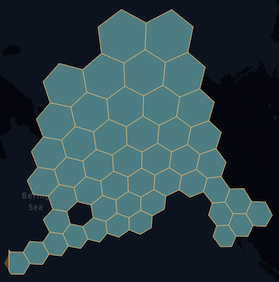

In [0]:
displayHTML("""<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARcAAAEaCAYAAAA7TRMKAAABeWlDQ1BrQ0dDb2xvclNwYWNlSVRVUl8yMDIwAAAokXWQv0tCURTHv9oPqYQIhJaGO0mFT0ojHP0RSNAgplBtz6c9BX1eni/CJWhuEfoPKpp0aWqoaK+moCkiKKg9cCm7nfteoRady+F8+HLu9557AHdA5bw8CKBiWGY6GWdr6xvM84JhjNBZhF/VajyWSq1QC35qf7Tv4JL1VpFerH5zPjOxczIePVbaexelv/19MZov1DSqH5RLGjctwBUlTm1bXHKD2GfSUMRHknWHTyXnHL62ezLpBPEjMdOKah5wS/9ArkfXe7hS3tK+Z5DTewtGdpXqNOUU0ihAQxAMy8ggC4UUhjhxECHM2alg/h+PBdsjgSo46jBRgo4iLHKIkcJRJnfpbNhvBIgdz7Dc/e+ddrUm7TJZFULsdrVZ0ppPgKfV1dgAMNYCrj65aqq2RArckWfglf4+SX2SfWe1zXDImd4bB4YehHjzk9c+0GkI8X4gROeQLt8Dl8YXM3lsJwPHewUAAACWZVhJZk1NACoAAAAIAAUBEgADAAAAAQABAAABGgAFAAAAAQAAAEoBGwAFAAAAAQAAAFIBKAADAAAAAQACAACHaQAEAAAAAQAAAFoAAAAAAAAASAAAAAEAAABIAAAAAQADkoYABwAAABIAAACEoAIABAAAAAEAAAEXoAMABAAAAAEAAAEaAAAAAEFTQ0lJAAAAU2NyZWVuc2hvdEwgYEUAAAAJcEhZcwAACxMAAAsTAQCanBgAAAI9aVRYdFhNTDpjb20uYWRvYmUueG1wAAAAAAA8eDp4bXBtZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJYTVAgQ29yZSA2LjAuMCI+CiAgIDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3ludGF4LW5zIyI+CiAgICAgIDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiCiAgICAgICAgICAgIHhtbG5zOmV4aWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20vZXhpZi8xLjAvIgogICAgICAgICAgICB4bWxuczp0aWZmPSJodHRwOi8vbnMuYWRvYmUuY29tL3RpZmYvMS4wLyI+CiAgICAgICAgIDxleGlmOlBpeGVsWURpbWVuc2lvbj41NjM8L2V4aWY6UGl4ZWxZRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICAgICA8ZXhpZjpQaXhlbFhEaW1lbnNpb24+NTU4PC9leGlmOlBpeGVsWERpbWVuc2lvbj4KICAgICAgICAgPHRpZmY6T3JpZW50YXRpb24+MTwvdGlmZjpPcmllbnRhdGlvbj4KICAgICAgPC9yZGY6RGVzY3JpcHRpb24+CiAgIDwvcmRmOlJERj4KPC94OnhtcG1ldGE+CoHKqzMAAEAASURBVHgB7L0HnOTXVed7uit0DtPd0z05aYJGYWak0Yw0ysmKlmVjG0dgYQ02YMAL7PJYPvvWxsvnA7y3C/g91sBbFrxeGxtwAGNbsmRZOUuTNTlP55y7K/X7fW/1v6em1aG6u1IPdaWaqq76/+899/zv/d1zzj33nILy2rVjli95DuQ5kOfAQjlQUGCRkSGLjA5ZgT4XLrS+/P15DuQ5kOcAHCjgJVAxi8sreXCBK/mS50CeAwvmAJBS4PMLYOKwkgeXBbM0X0GeA3kOOA6MjVlhoU8fkV4srxY5LuT/yXMgz4HUcABbi08AA9CkpsZ8LXkO5DmQ50Dc5lIYKHasyINLfkTkOZDnQMo4MCaJxecPCGUKzZ+yWvMV5SQHAv4C8/sKLRYbs9FwLCdpTIYov6/AAv5CC0diFonmvSeS4VnWrpFqFCgpz4NL1h5AmhvGpMZk7GofMYvppUdd3VDu9OCQJuhiKb7CAgsGCqy9I2QWGjYrKrG6mqCNhBZPHxYLr1NJZ2EgmAeXVDI0F+piTQ9olcfdoKt10D708AbbdeN6O3++3f78q/v1q89qlpVgb3NSQC7QPBUNheoAoNLRFzEbHLAHbl9ru3esslf3NdrTL56zpSuqHMDQj3zJQQ7owRTkPXRz8MHMkyTmWWmw0Nr7NSEHhux3f3mPXbPzOnuzt8zWFYfM133enn/pqP3jD8/oSp8maEnOqRmACqpc33DUwr1Dtuv6Ovvo49utfvVqa41WWNVYrx1846B96W/3WlX9uCQmNSm++TlPxuVvSwsH8uCSFrZmvlImV3GRgKVp0G64psZ+8eO7rL96nT3fGrRBqRCoF1cvKbAdVYM20t5kz70okHnipFMzltYW2aiuiWVZDCgp8lnPYESgMmLXbKqyR+/bbBuu3mi9gVp7udUMDW91WYHd3TBqrUcP2Rf+9CWzsmKrq/Tb8GjMSWuZ53y+xak4MDam55GXXKZizeL5DmklrgYVWHfrkP3UA2vsPQ/ttjZ/gz3TbFah/UDZc51H9mBUjk36fEOt2cbSIes4f9aeePqQPfd6s/mrymxJqU9G37GMg0yxpK2RyJgNtPfb5g1L7P3v2WJrN2+wLoHKvi6ftQ6NWbU2IAKifUR9CElOeWhV2Eq6z9pffPV1O3S02xpWltkgP+ZLTnAgPDyQB5eceBLzJMJTgzoGIjbWP2j/x2dutet3XWdPtpTaqV6zpUGzxOnmqQ5oTUGpHjtqxuzq0n47ffio/d0/H7aT5/osWFVqFSU+w+ibbkEGUBkWmA12DFpFRdA++fjVdt0NV1uXv8729/itbXjMKuSPBah4G0T0gX7Th1uXma0ba7V/+qdX7PvPnpeaVykJLCpwnCdD87eljAN5cEkZK7NTUcm4GrRjXA0alBr0rNSgqKSAEjkZeBNyMnXSkBxw9IbNqooKbHdd1OrHuuzssVP2je8ftdPn+q2srtSKZBhOx84SoBISjX3tg1ZWFrCffXyLXSNQGSlbage6A3a2b8yk6VwGKu/qg77oFv2bq83ure+311/cb3/6N29Z+dIKd19IoIVRO18yywEOLkZGhy08kpdcMsv5FLQ2oQYJIbpbhuwD71ltDzx8s7UHGuzHTZfUoGRWb0Amph3dbkkBq8sLbFdd2JZEe2z/W0ft//36QQ0S085Sccp2lhJBxYJB+7Wf3mxbtm+xodKldrg3aOcEKiWSUmR6mRYYE1ko7DOZaKyyyOy+ZdhhDtsXvvSajE8+q6sK5O0wiczK4OfwUJ/FouG8WpRBni+4KYClRKt+50BUatCA/c5n9ti2XddPqwYl2yCTVNqE9eu1rgJ1SfaMwVZ77id77Zs/OKtq2L4udo5483FguxxUAvYrH95iu27abNHypfZqR5Ed7x2zMoGKuuZUnrloNQBkWHTjyfPYmqhV9l+wP/qLF+34qT7ZYUrzdphkB0GqrpMuPTrQo9ryW9GpYmlG6vHUoO1bl9gvfXy3DS5JTg1KhjjNUWOijo6DzDXaWdpeqcA/HY1u+/pbT56VSBGwWjmwhaXS4PE7U6E+n1CLXarOlkGMPBOgEhGo7OsKSgXS1rkuLJYKhH1n5hqnb422uBeXmFsbzNZbq333uy/bD567IDtMxfhO2PT3539JEQekEo1FIxYalMFPJb9blCK+pqsaJg27QYWapF1Sg95//2p78JH5qUHJ0MhEBWSGNFHDGiy768Zsc/mQ9Tc32ne/v9eefb3VfJUlVlOunaXQ1DtLuOrjeNLTKa/aSNg+87Fr7ebdW8wDlYMClaB+LxeogFHzBZXJ/ZHgYz2yw2ysMrt76YC99fI+Z4epkB1GzsqWt8NM5liK/9Z4CQ/1WywsfVqf8+CSYv6msjomXaIa9B8+vce2777efqTdoJPju0E4wadqcibSrrkPPjhpICiw2FEbs6tKBu3C0eP2tW/vs9MXBixYXWqV2lnizBKSB6DiQLBNSopQ44MPrrGbb95ilSvW2OG+YtvfNZYWUEmkG1wbEMBU6GDuA8tD1nJE/jB/9qoY6belssMM5f1hEtmVus8Ck5gWkjBSiz5T8uCSOvamvCZPDdp29RL79Cd22dCS9W43CLWkTKu+3tJekGIADm/7ek9dzFYUdNrpIyftGz84amfP91lJTZkDmVZAJRwWqKx3oFJcv9JODpfZgS5ONo2lXFKZrvPQjB1G66c9vCpqVQMX7I//8kU7of35+hVlAhj9mC8p50BItpaxmHibB5eU8zYlFYIXiWrQ++5bbQ9JDeotbrCnGrUAa+Ig4s9i8kgJLYmVeCDTK3WpQUTsqQ9bVaTLjh8+bX/znXestbXb7tm92u6/9zqrXLXOjg+V2RHZ9cZEKOoPYlAmaVZzrrBdffty2WHGWux733vNvvfMBatbXuZUpGx7JI+TeMW8RUYGLYpKNF7ykovHiRx4B1hQg7rkShvrG7B//0t7bOceOcU1l9lRTdR6OcVxDa9sFdQODiS7nSVtX99UF7FAX4v1dfVaxeo1djFcbm+1F1hUTjaASi7Q2y3TD3aYe+oH7M0X99qf/u3b8uMpN9S9vB0mdSOpQO7f4eFBuTAMSngpzKtFqWPtwmvy1KDrtyyxz3wSNWidvdCmcz9yCCvNkBqUTC+QCpBk2L5uChfYB1ZH7eqamP33IwELCFSglWuwB+VCudwOMyo7zGH74l+9JUlqzJYukR1mJH8uKRXPifNEpBbxDLq+YGn151NRcb6O+XMAIyixVzqbh+yxe1fbxz52h/VXrLUnm3zm09IfTNKpbP4UzP1OJBLc8n2CkfqiiBUIVA52+612/MhBNqWryb2BFhzzQlLpDvb67doNDfbh25ba0aNNduH8gFVWBS0inQ1AzJf5cSA83O+AZSwmJo/bXPLgMj9epuwugIXdloGOfvvtX9xtD713j73QU2Mv6hRwDRKARnwuTdTEjkNbf0T+MDVRpwLt1Xkg7VDnjMSSSCs8RIJRiBjtWhVYeWW1PbCrwfyRftt3pFfHEHwZtQkl0rboP0sCxN4SL2LweNHwzZdscYDYJSEBS311sf3mb9xh0foN9vUzQacGLZNLeyZ2gxbSd28Y4V/Cup+rIOj10aMP6erlFrOrqpbZT3/sPgsUPW/fevKcLVla5BwEvevz70lyQOO4QClFnNSSIP8xLvIlSxwg/MGITjRv31BptWvWyHAr8VyIgsdqrgMLLGOy6nC1Ka6TdWiTQGcgc1Jqmfx4OdBZJ4A5JCN5y2iRNdSUiPCopEQPLiffkf97Ng4ALpNXlzy4zMa1NP7utmZlDGhp6bG+wZAV62lkY5t5vl1kKgKC+NwwLz3JYL71ZfI+2chtqdAwqPjC+99R4JuSonzg73k+AEB5KmDOg8s8GZqK20jDwA7R2faQFUWGFBBJapK2WBbL+gmdTNLKwJipG+4k82KhnRjl8LswNGinFb2vWMjO88iXOXJAwBKVZ67zb5kk+eXBZY68TPXlBG3q6ApZb/+wU4cy6Wi20L4wFdmSDscKnGqEwXQxTE8AEImrumjMhvr6rbl11PkX5bFl7iNiLKpYxzpPNNWTz4PL3PmZsjsYzO6Qn2JfjIyMKi5JLKk4JikjIAUVYXOxAoWo1K6RtO6pxlgKWkltFSywTi0qjllXpwwvFo4/h9Q2c8XXhioUi4Qk8cnoNoW8nQeXLA8BnxMloxYNjZpC2MZVCybsIikFAha/nHEcsEDzYqBdoD4mvpcXhKyxsVNE5+0t8xluqJEuKNQ0Dz0PLvPhagrvwXlLbnLW3Nxl1YXSXTXoF8P89FgArbEx+epEZb/QH4tBtcBzuFwBv8sKR+3kGZ2qLA1YdDHpox7zs/ou1wOFMeQktLPmT0FLHlymYEomv3JBlwp81tk9LFCJOq/XxTBB4RF0xsGFqPwCl0VhcZF0KHSpkD4XHR6y84qRQ0qWvDF3rqMex7kBRsG0N+bBZVrWZOYHByTaju7oHJT3aMS5+k//uDJDU7KtOJlLI6jEjyygsghELkhkR66hVHainh5rVDqWMrdT5HqQ/ydZDmjgxmTMnemh58ElWWam6ToHJFpFe/qGZXOJOl+XxSahYzZaLNIWtGLMrQnGrK+XXY6Y1LlFgIppGn8LqXY2tuXBZSHcTcG9iONlEstPNo/asLZFq+R7wTbpYhnu0AkYhqQWLQqaQXMZh0rHQnbxIsZceUXjspsvc+IA4xabCyehpyt5cJmOM5n6XuOa3Mj9isI0NCh/Cz9xaTPV+MLaYVjhVYyHro5ITWfXW1gjKb4b3laI3nL/qJ3IG3MXxF1fUYn5i0r13DUIphBd8+CyIPYu/GZwxM8hIyUpDYVGrDwoQ9kiARdseUgr+LosBqkFGlGJ6nQo1C/P3FNNQ1aS98wVV+ZeCAwVKC7Tq9wCpRXu4GIcYC6NhDy4zJ2vKb8jrrvKwNg3qJAFklzUwmz6bMqJmGeF0EliMgBxMQwm6KxU8O729l69hqzU7RTNs/P/ym9zqhEJ533+CYCJO9TFGbMYxsMV/wjjPhZB6+xUGlXtGOl8bs5LAqxP7BWUFI7J8a/AhoSIDCbN3ZwtAKGC/9vKkqgNDeSNuSl7UFKJ4gBTKTWpbEKKyYNLyjg8/4qcr4vPZ21KyB4oCLuoaVOosPNvIE13Yr8gSyIHFwGYnJe2RC9J2opkzD1/Xs5zeWNu6kYGAONUpVILllVZoT+wKCTZ1DEgR2tyQKKYkd29Q7K/xFzYhVyWADw2AibQzmYLkkyuF9RNjM9FAvATZ7VTpGC/ec/c1D41zxkxUFqZHLhMFathgqScX64mKM3ZDzwQv3T/1o5hC0ZHrFITYDEYdZFciE07JP1IMa6TG0xZegqAHztadbK3xAZ67eCZAStTQjdvMmSJrCu6WQ3jGQrAob3sSDjkInq7hEeTLvfLYlwYGM95kdMa9yTCc+hPpBR8XY5dGLb+Htld/PXWK+OAX/znt1wt0BaQAZp3pIJcL3jm1ivoXE9bvw30Dit/UaWN8GW+pIUD04IL0ko0ErGIonrHCAFI805K8YY734wplkOf9Kug+Yu1302ou3yZMwdQLZyXqA69hMMRKy/RjtGA4/ic68r0DU6ly3Sj82jPxZ0Rn5cGo4r6hzGX4bw4eDyP7ubELVMadONxGiICjl554Y3HFp14EDwQ76Ho3YHQqIVd9G/v+5zo26IiwsV1UVyR0OiIgkZhIF0c5Bdqt2g0UpjzXsWAIJks/bFRe+eYUisUEow7L7Wkc5S9G1wcWGiQC1hcmQCV6cnAQ2/Mhbobya8G07MpiV8KbGRwSClFpIpqMiTB+iTqTM8lSAIRRaArkloEEA7J/Z/4v7laoBHP3KpA2JrbdJpXznOLxRM6V3k6G12XDweN5pjsK6g6cy66lyPYpHPMl7lzIH6+pcjOXejSVmlYKqa2djUhcq0gmxLOUhlnleh9zDZWxmxDVcTWlkataZSwC6h4uUU15ADW1fLMHenvs0NnZNfKG3PT/pAugQvAIukjPDwPYJkgU3aa0LAs8Hlxc4IlSX5wuxaatQODYU3OqPMfyTUuAipM0tZQgV1dGbX/cN2wk1peagraB9eP2k+tCtmgiHYhL3MIYAA7JBd2ijrbe3SOS27/SmO5WOxFSQ6hnLvskkFXnHZZ01gt5zkwmCA+GXfdQaac62puE+REdO3rtrb3SdVQ6AXZxgs0UXkc2S4MB4ClRaCyriRmj69VSE45zr2sPEt7u30Kzl1g5wcK7b6VYfulLSP2rMDmYK/PqmQ74r5sqR9OghID2SpvVE7r9wTDivTfrt5IhRN/ARetqfmSJg7EwQWpRerQWPRSntfk29NWJA9JN/jklcchpnyZOwcA5jIF0T3bPGyBCLarKuvWKbtqhWP0Vt6517rwOwAHXObbNTkfaAjb1bVh6xry2d+eLdJzVxxa2VzK9GobKbQvHy+2B+ojdu+qUdtc5bOnBDKke60cP+mdKaD0QKVbNPtlcN5aEbUPLInahuqoFW1aqVSuJ62lO2x1cigaVufyALPwcTJVDZdyRcsoG40obd5lheEwDu0egugrPBvct3oqBYV+8wWLtBVdJkcwORHky7w4UCw/+t62Qdtz43K7fec621QrsV0rbsdoofVogpLNMJMGU54vOnO32l5WPGaPrR61NbKvvCDA+J5edQI9HOgYIbw4GY3B9Gi/zw52+W2rJvItAqNRTfBTAiN+J3E916ajQC9ASP29opnTz/c0ROyuFSFbrqhzrcOF9tRF0b20xh7fU29HDl2wxuYRq1kSVEpdjWcqyJeUcqCgvHZt/HkLPEYHlWYBe4m+AUAKfZJEdKSaMwMu8dHokPusH/S/3/3uDI/sFkEWAJQvc+IAieiLNOvam/rtlz9+nd113057rr1CKkXUtmiClkn9OKcJ+1Kb31oFNBWSEmSLdM9ITyotxZNWhtXAg8vDtrE6Ymf6/PbDxoCi/BcIRKYPC8G92De6BCo7l0TsNt1PfN0nLgTtgiZ4nfqDmpSqkQImIKkgXQ2qHWi7Qe3uWBpx7extC9gbUt1C2tlCwuqTcH5rvdm6WJN97WvP28v7OqxhZbkNjgjJ8yWlHLgELqo25MBFD0vqDQ5xhYGiOJg4qUVPUN66QDx+MG5w5MFk3g8D1pEQLaSZONjZa7/2b262XXfstKebi+0icY/FY4yniPS7JQFUKs5Lo0DmnR6fpAPF0tDjKMcuo3cmcyoKwECbPQKGtWVR+ykZaTul7vxYK36j3msFDIisydhQqAuVCLXkzvqwbdKEP9oVsCdaAlau78pEO23Nt6h613cwoV+gsr40ZjvrpOrIJjSodk90+22veEVmgmoBDnTDc4BIOejs2hqz3eUd9vSTb9rX/vmE1a+skIoUza+P830gU9x3Gbh45ywKJam4554HjylYtvCvYCvSSpcCoeicov3hr99s/tVb7AkBC0ih83SO/0wgtnw5t3OVRPvN2vK9StIMksBbkmQO9/m0YscnD2rHfEGGdgCDDoEK9pEHV4ZsrXaDXpT683aXzwEZBua51s9Epq/Uu6k8andLRaEd6j0goFwqsOKaZMDK4zr3cz1GZFkJbb28mfcIfJer/jMyIr/VEbCLIzQcl2K4b3L9DviUEWOVzIOPLB+0F5972/6fr7xltcurLCLEyx9m9Li9sPfLwGVhVeXvToYDTLYyzdS2rlFbqb3RL/7GXTZYtdq+c9ZnpZoTPtklEieDvnITkBV6QEDCDsxtEvlXSaLhu07ZM17rVPYAqUwAA3YNkEl4lFRhonG8plOr/YOapJtrItYrKeUFSRgtqrNKqoSqc6+kKpziItoYFq0hVXSv7CDb6iJ2UlLFM2oDoIRugIt2piseqGADKpbkc01V1K4RrWW6t22o0N5oD9g5qV2VolfHtGaVsKiPIFcVQfV7xbCdenuf/fFfvm6ltWVWhESZt8NM9yiS/j4PLkmzauEXMnnKZAVtU+LzjWvL7Td/9T5rLV5pP24ssBoZSCnTTTAPZJiEGHiDmmBXV0gVWCqVSWlgT/X4bV+n35oEDAF535WPSz+JQBVvIf4v9aFStWt7eY1UibuXh2yJDLcvNQfsNakUteNANd39iXUl89m1pwuRYhpE7wPyiSFX84tNAXtLtNeMt5coHXl9BvwGBEKlAo7dtdhTwjYkHhyUlHK4T4bwcKHbtQJUoHc6Hk6mE6kpJNAb04eHV45apPGE/dZ/fVloPmZ1FQEbVsPwKF/mx4E8uMyPb/O6q0Q7Qu3Ng/aRh9fZex7abftG6+2AworU6FB54qSarXJWXSQgpzJJ/Mcuc51sGvWyOxCF/3UZMQ/0Fmq3Jy4VcH1i/W5SacJiBL1VUsQ12l7uGfHZN84FFT4prk5wfbKTdDZ6E3+HFkIfIIHsluRxq0AN6etHUpU6BXQ1UpVolzmNtIM9Za36tUVq2trKiPP/OSBQeV3Smqa+AxXqnAuoJNIDL0iSNqDXB9fHLNh11n73vz5rXT0hW7q0yIakk/6rARg66h56ap58HlwSR1qaPrsdIYClUYbbn73B7rj7RvtxW7kd0+YcfiyJE38uJDABmRxMQlb2Whl9bxZYbBHQ9GuinpINYr/Uj+5QXGUiahygxFYtoR4fl8EWMHpBznBv67qVkiQYVqmSVqbri0f3gNQS1MD3yvlutYBjn1Sbp1v92naXWiJCrhKo3LosbA0yLmNPOSSJ6riM2exYoUqBQKmgFXooXbLD3L9yzJaFmuxvvvq8vba/WztJpf9qdpLIV16giIj4q3n21zhn5vfvvxpwIX0HA5HQBgzokAx3Lrzk/PiW1F1MZNoNq+HBjh777M/dbNfccpP9uLVEksKYSfKeN7AkEuBNVkAKiWCJVv/NMnBukWRQI1XnlIBjr1OZ4tPoUU3mrfoNleQN+aRgDGbnaSG7N4n0JPsZYOSZdEpVulaSyW2SYnDM29futw36G1BBonpWqtpF2VPYSmYbXrekBFQm04kE1KmdpBvqzLYVtdnff/MF+9FLzYr7Unblx33RYB0d6HYsCZZWWYEfvRpOz79c8eACf4Lat+1ul4Og8+FxQ1MhDkusQvuhGO/YYefgYGyBzEx8DFTl7Qgxa//oc7dYQDtCP2gqtoB+1NGWtE0QQAZJBrC4TpN0h+wU5cow2KEJurwsZr2Sap7W9nKrJBoMtqmSABL7P5fPTGp3EFKkPL4K4AvbG60B2yvga8OoLCllrvaUubSfeC209EiC2VRldnddnz339Jv2V988rJ2kcsXaUeJ10XhFFo3JCT83DYhAicJUSoKJQ/n8enzJQ3d+9+f0XYwDUkd0tgzbx9+3yX75F26z225aaZvWlOrkccTONg4oX/CQDeu0XVjiTJH0hmJttzjVcwGDCGBhR6hDo3S1DCp/8rv3mS3fZN+7EHA7QpxrSdcg9chm61inCTQ5tW2tSXpQKsXdyyLWrcn616eKnfct0opwNa5mZ/FJQjPgEdVuGOJ4kWb4184VCfhIXiZpU79DZyYKtMA3pZC2i6PFdvv1y2xdbcyeffGMFZcXS+rV4VwRwxi5oorcT1hlY1GdyFfnYhG5Dcjzns/zLVcsuDDBAZZ2uXg/fOdy++hH7rC9o8tsqKTONm1cZTt2rLdH7lxn27bU2PoVOosvffP8xSEbUs5mF/dKokWJ7kfqoSQLBgxOt9XMjtCKEu0I3W+NRWvs++fZRo4PSq5Jd6ENXpBfpQWoTdLK5vKY7C8Fdlo+JtAyX1tPOmhnDBMTZrvsRdUycB+TjQVHu2zQCN8A536pSEf6g7Z7a4PdsrHEnnzmnFuE2PFD0l3AvEsHC2evcxaCnfNsgQzlAhinEsnzvjCA9DK/ckWqRQwOp5J0h2zLyhL7rV9/0N4aqbd3lE2iWKviqC7Av6FBmLJG27mVBSErjg3ZaH+PterU7IlTrbb3cJudFthoeOvgTLGVaoYi1WAnCGtgRacY9cBQidtq7rcPP7TeHnx4l9pt0FkbHfef447Q/B7n1HdBM163D8mJDbKfkgG3WnaZZAFz6lpT+y3qCLaXR0UjdpW/Px9USMq4/0tqW0q+NvhGsDpO3L13lXaqtJP0n770vLVrJ6m6KtdzTMdTvTAX4rYT8VKHk33yup+yCHg4uIxRNxoecZcQ3YA0IXNDUVpkJujfibNF7s/F/w9dw62+V+fs68sD9p8+d58dKVhthzTB2ZlhQgHg2FnYkWA7dkxf1Ijn9XKQXS2bRHXhsBWGFSy7o9062rrt6IkWe/7tduvtZZjpJomLFQIb7DVISCGNQAzFGG87mmW4/Zmddue9O+2ZtjI7JhsZ7WbaWJr4JJkkXZJYHpXnbaVo+erZoDVkeeIm0sdnwIU4MZ9cF9KxAbPvyyZUIxqzDYDxaSL+iabH18h/qP+i/dn/fMFOtwwZh03TvSkwmU/J/a1xGdPZKsXA9nZ/OBsYksEWW4q/qNipn4l1EeQtptP4jGdPFUJF5WzhVNcn3stngMjFg1LAuKDSijDJJBxfWYU4qYNCjJiQ4w9+8x47E1htB5ov9yWBgYArJ40RfwGMsCTBM8KOoz2KplZYpoFdZmuq6mzVSvlXbBu2Bx/ts972Lrt4sc3OnOuyJ15t0STQiNPGaLC62AFWb3u//eanbrGNO2+wfzhXonM5Y04lySaw0DsmCF1mAvvkIDbefX7KqeKX8x/0YRdyJ8AhNMvFI2EpoHy6wP7tplX20w9tsd//s5escnmFdpG8K7JMaGLz2rgIKZqkF/866pPYzCBQmW6LGTCieMDiPuufmCIljGkxnbFoQkUFTJFRBYpTzG2vXFHggvSA2B/qjdiXv3if9ZavtmfPTq+SMCwc0OhdtzqgKXEzccxGBDY4uL3RUWgl/nJbXlJuS+uX29Z1W2zbnmF77LFea7rYap3aYv7JaxetuTti/+U/3mfB1ZvtWxeLLKiKU7XV7D2s+b7TTwlV8mSVHUofMJDm2pTgOeCHQ8DvPu1iATS5RCMS1FLN0XAopFCkGhhaVJB+c65oILtg+SKuQPYTnjShVKQkSWqpcGrRuwBG93BQOR7PKaFH+h5phFc8fdAMT4TICAIWIim4yaRqrihwwfja0dxrX/jcnRarX2/fOc1J3uSNgrDOAxtUCbLzVeidLWrlLHenld8Qy4r9lbZa4uUyGYa3bg3btbv7ZFMJW2dgqX1bZ4TKNDHIspJtkT5hmLiFKyIfEp+i3DFxc62w3mHArZIqNCpfHQAwlwqLVoXGV+nYkB06pmh25bK55MoDBgRkT4kQEsWpJ7JE6zuAhZCzhZJcXH4x+a7Ev+Wn8TGg67CzxMIS2909l3MdiI/JFuNTbrLpRg0hWcbUvgtvm1DHFQMu7Oy0N/XJUW2nVW++1r511m9L1LvpGHI5C6f+i3s9uy0HAnnBO5D/ouKQn1b6GzmMW3lRnX1E3q77G7Xy6qZcAxavdwwsQNONMO/LHHiHJPhMVDvOEWFzQdJayLNLZbegD9ucNv8spADfb5/os8oqIvFln0LUGPKLhZVfDMDQ+nEZSJAYniBuDgAkzZDgEM4CFgARthgC608FLHEeUuEMz0LtAz6R0UENK4zIuj4+SXJugYj3Zw7/8njdlrOCLf3KJ3fYtlt32Q/lqMYJY0qqHj/18GKx4h2/jEqBV51zTtOEGI4bg8Pu6eqCHCrMAZ43Z3qgf5w1OURh3OCNTwsAPix/FweCOUIhvMO0skwHPNta2m0sNOJ2I7OOLSKMiR3P1jH+kL2nK+JIVhgoKXNcxB4SGux1AfgdmOjyS/dOz2jGysTW9FSXqZ3IiMR6jxmiyRtfi1pyoT+lyj/T1jRkn3x8i9117006fCeU1gzSEYm0qiVq2oEMqkaJJkSbYog0KLYI4r3H3KmeRba+80kVGtTp4aAvMuHtmi1apmoXfhbJE7df29HErykTT/WWG0XEsSJX+5BOte1oRc6RLpvEsbszFguPS09wL3HU6W+pKgGFno1ppwKpxhladQnSCiVu8IXDk+91P1/6R/0mJxkA4geoPBDRFfAkoiR+zqYzXi/q2aheTg27VMvi+kQfnSrUMmr33FwvA+vN9oPmMhvQEpMu1/qpOAQdAelCbcM++cHE5KOBnjvVldn/TmPBSQSJwzD7VMWnBSBdLv6FZW8hABa05kpBZZNbixVFh+ztgy1WUBG00WF8oFJbnIojqSg8JBVnKgZoYAEKRIx028bszGBVnhhw4wNPb6hDqEJhqSsxdoLc5L/E1PjuENdf+m7a3ogWUgbFZJt5N12X1+GBGA55svCo8gnipq0+p36gOzjJdchJbuPqEvvYR++wZzur7YKeCX4cnp0kU0S7nRj5aGAAxmWdU8q5JNbDB4ZQSBMX13X4l1NFxLFdXy1jLmEiCK6dxJDPSBegA3vLcuwtfT128FSXlVVgb0kRjQkggkE0oklM5eHhAbez43ZfEp6Y29Fxjcc5xAFD0vmwm4NUgvpDfGtsKlFJLWPOnR9pZfJTnyOHRWdYtpkA4W/docaYalQd+j6xJloJFJW67wtBI2eYSuhkRp7aAhoJymGjdzii1BBB+9wv32uHIsvsiJzVsgEsjpniLt6lGCOXK/MggzGR4QvoaspuhR5AF5tGLhlL6SC0MV/Yiu7TdjlHFuBrLhSmBfaW5dhbmlokKXSZLzYs5zTFmU7BnIlKrYgISMgZFh6SYRVGqMTkJevqhzlMYNoa/8zf8aKgYdpe9jOZdZvnXRtDotE1UTmCppaRAj38Z2TnceqVpKaxaLwtR49od0AnsKMfckTtd2KWE8XGSc7lNw6OjWiZiw7F7A9/+x5rL11lCuC+oLgoC+0vUgrnYkYkGdQWS7SXiD/x/BdaearuF42M2zJJdjr54I3hVNW+4HqYUqWyufQJpCX8pXZOLIQ6EUaGi+rCUbt4oU01Bdy5IoyjGETn+6ABC2dQlTQQlSoUlcTBYcGJghqja1Az4qChrWZnONXKFYdj/awHKdUnovvxvnWGWia86omMUJ+QOqUDUe3JEhYa7HO7TKhdHG5MLHzntTmuFsmjVQQhlnkGn8QbcuWz45P6N9w1ZH/++w/YQOVq+8lZ4pdkXhWazBMmLiENFLzMrXQ8hlwqeuRO9Ria/3xIW3fgHQntC/UiHIRzoANtcqA4e4tEKewtb7x9WhTJmOv07vgkC5YpNIHUkLlsS08AixZ2BxBT9VNMYcFnTo5hVxHcOgWESaDvKP6SUnf/BCg5uwp+KXHHN2+Su4tT9k8cYJBgIjjeOdrGKxdtnEtyoKuvGHMq8akQFiJhLELfy8WCnaW3rd/+z1+/xQqWXSVfFp/SRoCl2S1s77I13aEdo6A/ps+5ZdRlnvKgJey5/D0EuJYwO/7Us8s7Wuf5adNPBl0ZLCUB5oq9ilnB9n2tAm6N9umMmU66F+m8CI5lce7FAQY7x1xKRKYIVn8PJKa71xldBTIAkFv0x999wWILlle7rWYA6JIDnIfIohwQSluJ1+3sP++SMePnmqB9HFziVMRRUmKY0CfXACaIAbe5z37lZ26wuq3bJpzk0sa/OVbMjlGHdowKtOXrxUmZYxVpvZzh4HL4yGjKmapsA3JiZwFnAI9xOoBalM55kdjwLJ+ZnySGu0qhKjpbUIl0el6GISSteIFQjK/9TnVxKoH301TvqhAby4Rfyqzw/m5GBHQoEGmJQ4mj/d1urqYXSKbqyPh30wIYdE/pZR1HSdAw9TrbDITO8BOnjbsU8Okzn9huO27fZT9oLDZ3Bkj3TDznGe5P90/QgB2jVRMDfi9TLNpcM+pClzQi2YXGuZELjBMpDEOkKAAZiUVxu3LG5uJOSYiosgLZW3RgVYqItsrfDcucy8FDdcIgO82ko69O6uHDrMDCNYkl/sBQgcKyp9BeXPJxlSVemDOfL5NcJlMV5byBK9nrgE/LWLdO3N11yzK7854b7Sdt2hOUzksc3ByZH45DTAzsGVGJ9TUKfo3fRi4VqGE3Cwc1/IByiXeYMEhbSw4jDOO5ohaxJV4vG1qJYv28/Ppp4UHxlHF8vOeMLwiGXgy0rkwCGewyntv9nJ4AqpF2p4itQt3hYalUlEn1x7/MnX+nBxcRDkqGBuSwQ2SqOSNtajrpRFBZoEMjI9YtowFic0CTA1E61wq7RKORQmtAR9ckzpVJksgnVI4Ajn6JX2b5M+pasXaKhp0DXW7wDTDG3rJEMX6wt5xowd5CJtIZOKc543xVZLN0u0nE8QAAxl+oTXMx/E48FhlqOdGMYxr2FmfYnfgxdz9MDy7jNGO0QUfE0Bs3QsUNTJnqEsF4ahWT8ZV97TbS2Wobq8achMDDz6XCkCsWUS0y6lZrO5ocyblYAOtcAmYAGMmlTjxjCzqaIxIfeICUt07Bw5qb4vaWIq1qbrGb7cECMm7e6CyPfFdwiXfbyTLkOqkmqUoSG+GhiZjxMiPAeRflwPus4OKJXlh/kWA41k24vMyXQjt5qlnZAQV2ajznwEXPH0DpUsZDVuFsxX+d7rnAL7xgR6V2sO3r+JdlJiJFQVOjHiiHFnsUTLxHqmUuSHyevaVc9pamcXtLdAp7y3T89qQVnOFw2Xf+ZEPyjVFsFW9OTXvvFD+EdK/zL5FalMvuIomkzw4uE1djrJS1G4cdddQFpJn4Lb0fSOngqyyxF149Z77RXq1yOiquQZlLBXLYjm6SrwtMrZMNIVfc2MEQJjJexEzcEoFfs/xJkPD5PtOFNlm8SSVbLlo+e9WoEslHbEN1xN6/ImzNAhlKNkHGs7cUx5So/rXTAoRi5zw3Z15pzsS3knlnZMyf4WyyoHYtljIHcBnvkmOW4mXS0QRRLZ0dRoyvlihw6GSPDSmu7dpy6ed4Haez0XnUjVg/ILow7FYqFMNcFrp5NJfULUxkgLhJE/mnV4VstZKlXac8Rh9dLUcr1QDgUDIBMoAF7XQBcpLyPrhm1D65WeELxLi/OVFsT10osqsV/f/nBTZINCSKzwRdjgEJ/8ARAkHVaUuyr6PDTrb2WGnp3BzlEqpL3UfNvcVU5g4uCb0bG4tmTESLA7bfjh67YCuLpcOKz7nGap49Ox6DIZ/OGMWUZYDVKoFhGf7oTWTi0v7G1mFJB1H7X8dK7EeKrM8xhU9sHLEHl+twm+hKJ8jAAoClTwZbUqbeomyPH94w6g56/v3JYvvK6SIliiuws4OF9v8d146MUO/nBDrr8C8REHn3Z4J9EwCIYb4oat0dhFhgd1J2lEwQcAW14fP5ij4/3/5gqEJ6IcL4rA5E821k/D7E6LCyiUUHh233jWutNVKec7ljAJKwwgXUalAuKx2z/UpEhu0l04OSyciLiPW31kbt3pUhaxr02XfPFzmbC9u9ryu9a5/sQxurora7PqwE8GbnhuQBLQDAWxZgWijd0EA9I+IJ/iu7lkSV7D1kFUUxe0GJ559SVkWkKs/LmoOLGMVf6vDrBE+B3SO6l8pn6JjyLCEFonYulKbx4XTZm0cntACASE2bK2PKuz1iz//4DTtyttPKlaFzVHv52VwsLiN6EfyxIHChf+4cg1QkjoYDMukqDKpyJbQ5e67X7rppufkUmb9RfkQMyFwqqBplWuVWKbH6sV4mSXomxHR9ZjJjLxjW60HZL7bXhe21lqA90RKwGhlNORHN6owBlXQjrykb46iCSKEq7V4acSEjFgoyTFba4TRxvybretlTPiRQWa/Usgc6AvbDxqCChcsfSMzh8cEzCs+YFwnbTgsMj3b7bPs4XZzbuiAwBKxTVeADYIHbQI/oXCLvZZKyvXdtyNZIymse9tvm1Uus5WyTnW7qsqoKAYzsf3mASe4JLBhcMFJhZMJohYNQOotPbQwrqfCq+oBtVIqHY/0Klp2m1Ww+/WBSUZgw10liOCrJhcmSCimAemcqtM2E7takrdQk+YUtsmVIHfoLqUHtSubuEozpGuih8M71hOok5etrkhZGde81NZJkJoEMkfaYiN69roJp/qGvrPxtqqtedDwkO8/VkliOCcS+I8np1IDPKgQQLArTGeUBG1K+RCTxvNapoENSmR7ShF8qI/le8ZSwEbySoWcymSJv4nkgpQCAqF/3LwvbnQJjykktCk8LAN8QzaUVlfa+PatsTFvK+49fsMrysim9dN2N+X8u48CCwYXaABYAxu3hAzIugfVl7aTkjwnVaEiq0Q1rrDVaJtUovvqkpIEUVMKkuSCJYFedIqZrUhxCpNc7E5lcPGLPvCbFTKQx8T2j7QMNYXtYE/HttriEwEqPwXSmiUz8FK5jpwt1KTQZZGQLGdBEJBPidPR7UgCZHSsEAh9YE7I9suc0S9V6QobaY+OgQh5mwGM2YOB36oSuk7r3gtK77hTo3SS+HtXnHklb/DZbPR7fqIsXUkq3+oKX8k4B6XsEfusqZFsRwL7SGrRn9WokqqCeFQHezyoAWTRYYe+9ZbVORo/aG4fOSkUq1bijF/kyEwdSAi4TDQhgCKkXTwc5LsnM2WFoorZ3fWAgXa4aLc0p1YhVm+3Vexsitkm2jCrZFm6UWE++my4NXoyTw7J3cA4pVUBDm0z8Mm3pvn91yBltn1HepDe0wldqAunnpCYgvAWEmPyNk0Dm5vqIo/nEgDylJU0gVXggQ/3QgBRAeMo7G0KSAOQHJUAFVF7vCrgYwwBBMqCi6i4r0MW9qFcvS7paJu9n6ieKyMG+OAjAy6lAxqONCvvFdyXhtFUK+nS/JJRbBMJEvjsjKeVHklIO9vjdsyGvtmfbgV5tEtk5BQnojBTbw7tWSdKL2mv7T1pFmRa2XNgOpHM5WlILLow4ioy8Lm6nFITCFNthJqtGx3NENWKCkez9YQ382zR4//5Usb0s6WFMg3qdjIPYDrYCOBqs2BvalfgLQycDGalmrsWbOKhB62QfeFTSCt997XSx9ahulwt6jpUyQacCmbDaQF26SX3A0HpGkgxAwuoOWLL9fovUwPes0g6QJudzTUXOxoOnAmqXV+8cyZm4nPvhESDztkBzUBkZd8oIva06qvQul6QYT5bwpBRUHvjDsLxJ9D+wKmybdA87eq/LmPxjvc7JtoNEhg2KZzgZAGkbgOlS9szjA8V2346VAriIvbz3pLanFQBbW9Zcky/v5kBBIFiRNt6wk+Qn12yxDhumSIIhq+KgrPZbG4L22c8+Yk91L1V2RAUaYmZlqTAokVhI9L5Zg/c7Z4qsQ5IKUsCABjJu5Ku09btJSe/XV0WsVGrDkMT6MxLvD+mF3wchBzzbBn49Mz0U2mPR7NBq/l61uUPqwlMXgvaSVJqVWo1BGepYaIGn+t/lEdLGk92gvu1A3ZP76kHZQvbK4LpJKsUdUn9wzHupOeDsFEhmAAGqWArIuKwbgAxSjIkGDNZrZTh/tbnIXu7yWb34Cr194rmzpUhKuUkG7SrxnvtOSjrBZoMhu0xeyjwf6EuGV06lEohyQv+BhiG7sPcN++P/8bQVl1SpTTlMqrO0vViKBEtYmNaSVnBxlAsMisqqpfBqmaOkAGSIqUFslz/6vQeso3arvaWjHxVaXbyVK95QZv5l0CGxPLQ8ZBskmXxLkoNszhOTy5ugHIIbHB/0azToN2rnBCDiyECvVuKDAobTkghQL0gOBtAwWmFX4hhgkqBeLZGT3ifkbDaoWf+k1I821VGtCc5OUaqL1wcmdUTU3Ci6t0mK4ZgDzR3XhH2x3a9JKnvL+KHINJAx0S3ooeEW8eEm0XK/7CbHe3z2jHbEAN3dkqLWCHTI3jiia16RhHJWth+krSrR7CQU3T9XGmk3rGcb1Yf3rhyxvhMH7Pf+25Ma2wGluMFWtTh2kgAWyuIHFzqhHaUCF5G8yJ3sdD1bwD8EjupqGbJf+NBm23bPXfZd2RiqNKgzCS48H15dSA/yx1hSHLV/PFvsDt+h6kw2oLrr9Q/vhD5AoiGc4xo5212n3ZRlesdrtUli/inZEo7LvsEp6xJ952wcuo8VFmMkTmjbloatVSL9k00BtzuFaD+5Td2S0uKBDGodjnm/es2wfVvq33GB4rIUSkzJEg3Q4pdTqmf/+NpRF8mOU/PVsnUdGZes2qQilorW0nGwTkZKmal9VCzUPYIqfGi9QmtcPGaf/fx39WCVxreEHbfFAzDpBpfU2lymfSrxuJ4sFb6ATHE8IV7zLKzmETnUhQaG7dada6w5UqbwiAuqck6UeJSz3fpR2TpqFPH/m5JYiPDGFul0A5iVkhcrJ2DA9eyuHJJR8ZBUjAH5cSxVYrWtAg8MwTWasJwSbpWKhW0D8HxAKsgNsje8oV2NH0oN8XxXMgGsHv2AJ/mZrpHUcEqqBt8DPLxnstBn+Ai/UQlvlXqI6vP1s0XOliJh1km0gJBHeyroo6/ssL3SXmjXrKm1x/assKeeOSIpKWalIiiCiqTfc7V4kgsrXTrJzBC40IUxlwKBbWpCaLrDXJ6qNMenwEBh1+jcuT67Y+cyK6qus/Oy6GfC54WBhYQwoJH9K1tGza+YuV+VCzuR8eYywbzBzsDHPsFgbZF6BdAc1gQhx9BSqU/YODZLhUKcf1C7QUgx/0Mu8q3aLp3suzJHNs77csCd54eR+rhoxcZBP7JR4CMzhG3jLTr4iArEgQEMtB6P00EX3eW5vd5ZYMtqa+wDty23F547bAOjUSuXVTssZ5+cBZiEZ5XwMeVsyhC4jCPkOJhECdswfnScADjzKZz1GNY2xZoGOdRtXG1HM7BrBHhgO4lKnvzFzQqyrCXgfwlYyEs9F2CZ3F9vEniGUI1Ztx0M0JyTijQqoLlzZdjahnz211JDkFZm8l2ZXH+q/4beoFSNVYp1ckIGaY48ZGsiMTlQM+sk5a0VCO/vBlwyI0XBB2x9R3u0o1RdYx+9Z42dP3HOLrT1yNmuJGdtMPDHMenSG9+kvKCJZqZo9HmxLWiQlc9ll0OBnUeJaGXwVcqPYn+zlUT6rEbaFg8blcMxbx51znQL4OFUL02qz1w9ooh4hfbnx4qtXBxcCLAktgn9SEW8syrWavcDL9UnZCw9LQlhSCqUxvKEQTLx3kx9hrfQh7MgoUYxIKeD33PpD06K2FnYYu6TgTtzgzr+vJbIj+kNbSoc862xz/27n7JHb9tkPYpex8ZDrhbsLem2uWS496xwlw9FBup8lr2YZPNq7SUeOtFrfW3tUh3G7OSwMjFqcCFdUJj0gA3vCynUIWlXaUPGtEMz4ib6V04FbbkmPyX+70JaePe9dAGggV3LJdz1q1+k3uD7dLT3bgqm/0ascPaiSsBPE3vSI53+xjT8QtsAHJHsOCOVDSmK51QjgNnbbrY/vNx+5t88Yh988EYbGBwxPwj8r7RkveeAzdT5T2Z+Iuj9QafoR+yCMuHdtXzYfm5dyO6QjQJbBRMQB6oOvdhCdRNV33lgkyzecD1by2y7ftQBS8C+QcgCTfhMTHT6Aa144fIB20y2CyRAF8WR4/0R/yqj/9I+z5ZtZ6UOd883G+R4APNyq/xpRqtt57Y1omxUfjFZn2IZfR6JjSFlZ68IIQhkzLkk5wuT5MRh8BRJ5GzuCNm2LUtt+84t9mprkbaBo4pmFrWN2tolf1C/tiF7tAPTqd2WJvk5dMhgOiw1g8eN0xq7Hkg1NEudAFbiwAS7kBgIuP2AAhsd1IneF+R1u1JhABhMmSjQhNMaKpGXcG263ahM0EMbdB2eOfsTn/kjS8UtMtq5KhL4d8j+ExSv+C4bhedSKcNZUWzE9h85LxL8yhbAEnQlFXXSDYDZH3p2wUU8d1LLHHeN/BInBkaiimJfYJ/++TvsSHSZvaAVo0T5Y2LKFc7OyjKJyfUChYayqF5j8mLVbpX40aZzM50yjBJIu1mf8ZPgFC+Ag9cmkgGTBaMqUs9aSUGPbxhR2IKAzrYE3Elfrs9kAQAHJfJDfy4shExeMjBwVoeDgMRgyTBLJtiPisYZKjyEcUbMJn9YcCol0VaODdibe8+KsiK3LT1B7KL/oB2wQp1KVyaCaEQB28idFJddp+xZ1sGFmezsMBqgE2XyUpiwFPETr1BPyL70hfusq2yNvX7RJE2gpsRdsHnI5yWpnBiQOiRjKAGpKzT41siHpE5gsUxncdYriwCrXUySTKtABgnn7KDO/Ohdx0icN+0tkoDu1nmZlwUsr2UJWJi0gAqGSvqNsyBevHzHb9kotEt6ElTGbBaaZ6doqRYRaMKhkcUhG3yBFsB22xI59rW22NHGLitXytVRdgGumKJxV1Qmh+SASztEmpTJNtTErmYfXERgoU/WMIIXj4MIqSoT8+iS6NvNLFGOBb69qc9+71f3mG/ZBnv6bDzo0GRpAp8XHL146FQb0U7C4b4CC0t0phDrZIWAZrkGZr28YzcpSNBGDQyu75f6hKfn9bLf/ORiwF4XsOBTMrkNV1EG/gFIONWL2M15mG6FHeG7rJbxGZxtMjAoVynyH2ojKmyV+JMNRQTpkqOjqxSC9cy5Jj0afZENlEvnoNBE4kByYVRHPZQ6RWLBjK1lH1xEnksUNQ4sgAiZ63i5QFR6Qv5giTsAWSYPstbGPvvUR6631dcrX/T5gFWCSVN0ke+8KvmZVZ+Uod7+G78hsZyTtBLt5AoNTO1+rJQ6xa7M3XLpP6wj/k/LxrJeAJSOMzvxVmf/l0fImRle5TpTFJUDXTYLvGMyjUhSQHLAsW+qZ5BuGp0Eq/brtUiMSQLl7FCBpNFsEINppVprZLVvxPYeOKeuky1AX15JZXxuxuSj5rIQ8ABmKNkHFxFIZkcbK40jgIgt9AdddgEOOxa4GDEx7dbEBCy99qEHrrI7799t37lYoqDO6IDJjyX3qBNmAW4IEzl81K6nTl2QARgdfq0ilBE1LdtDhGfIxAlFFSBJwMeRAAzWieA5wzNO208cVISdbowl8DVtDU6qmKEtYcWFpxwU0OlxZqVAB6ewlys740hPl712sE3qg8Zwth9QOrihPsUdImYGFprO1vOY1G2RKzHLjVIR7/LpEgdGwKIvpUdHraO1za5eUWiPvne3jtdXWJ8siRgVFzKmuRdVA1DhRQFwVmk3qFO2lxJJCQRhyvbuDHRBH6szp6jHSeXrjBeGlI7mKWyEckkBcBmn4FKDzF12/fxSfy/q8CSfs/GsAFfsLeu1GDVeaBTgjViZXKivRGyJc392YOG63AAX0NAByfjA0dMq9BfpOwGNnJCI30L5zK88ZgfCy+xIlwy0stylYyBRJ0bBCzII4zzcIFsLzSfHznH60/AmHHXhFYiUhu0na/SoYSYNxlwmlT5mrWAqxf2emME97BRliSnwo0iNLykctv37T4uqYrn+X0mG3Pk94uyDi55MYaBYYmRCQCl9h6pUKLXIiZaRUfvvX/ygdZWvt9flZo27tSdpzK/bM9/FxMHTl9Snq7SzRMQ4J/rPfFvafmUCQ1OfDLlOkkpbS0lUPI4mvEXFlzGpRtkotArIsnsGbzDmAi7j5GWUJGxhtRz2H+mzfYfkC6ENiCvN3DIfhmYfXDRrx1wOaiJkqOjvWETZAPVdCQF49MD+4DcfsMLlG+0nzTopnGZgiRPB6qwEXjL4rtROEvp0dqZQnBpWRgyohF3wS01jp4vvslJEh+aSo4Ft/HSC/Gz9o21sUP0CXU5mAzKZLjSJr88KmQwHOjussbdPJ/ZzIDtjihnBGjLXdST74CImoBKFh/ssMjLkWFIgZ7iKijLr7e22z378DluyWTtDZ3zx5FkZmFSoRmxjn1PU+SLZFghGlLXJPD5ICCyFxzHv2IUywIYphyeTCYmhQuoZtAA0WZjTTpLEyL1SJ7PDMnQT5Q8AznS5bAv61IUscSO9vU4ElcTPs7WaAnBJzTBn25msAWOa2UW+mHV3FdrHHt1l2+/YYz9oYmfICTUZmVT0iPAHzTLqckTA2V1ofzZRqzbnAABAAElEQVRupvF32ibGC8GRsgkudBH1AzsUht1sbTd6z6JUklyf/JKEc1kpqEScyC+KDthrb54WDaUur9FcJmFWCJ9Do/Pjrcwdc2jj0qUJyzhSRsqKAMavcxldSjZ/244qe+x9t9vznRUyjsktX81kcvwwgXokbmN3cXmftUpmq9Bv6OmTjRD3duwM2Qh1gNqBVNcsvtRqR61YdFzUZ2jJpEriJBS12St+4GXdIvU1E4HCJj9/RgR9r9UWdKivx/ad7ragnH6c35Z+u1IAJql+gAkJL44JzA1cdDNhKjHAjsWi+qyYsYESp9ZMZvx8/mZrs7enXydcg/YzH7/dXumttosDin+q5ZFBncmCAdflOJYqsl5R+4e0QmVD7Pb6zOQdFMARkBuntUzzA3Dz0nR8Wknka+W4ViaV8XcUjY80JhwKZTClk0de3cTwlWeUvU+ZD7bIs7pKLgPdAhrGtneNx7d0vjNGhtXuOtnlOltkyBVVxcq2Bh2LqQAek1/T0T+VFEOeeLJ8BEqrLKhg/EEdewiUVs4BXMQx/itQTuhgWYU7vOR2eKajYo7f86DCbsaE7fd/73G7GFxr+xVCkK3XbBgNIYWgzqf7FeA5GM0Juwt8wN5RpskkdmVkB4vJymRpFXjsUBjJD+sQZ608lv9SgbL+54liF+fmAwIb0qoQ+pOYwNwDfakqHmAAKprLdocSrxH+YnnpmP1YKWLJQf0L60fdAqDzrJmTosQXwn4s8Q3b3v2nRFmRhceDCXmTMKlVP1WMSkM9ifR7fUpsBnspQgbpgzhz5PLFSwNhpzfpMJc+bRUHSsrj0fs12rzwlJERTkaKywscTkHpPaMjA/aFz73XitZfa9+/UKDQhdkBFpjnTV7OJG3VAcazfdq50uQBBLNRsLOQwuT6KklRsr28rlQanAYmIHi6CtISE5odmYeVvoP8SG+3E8+myGolTfI7+ZQvKmMBqUZuW6Z0IyKG9KuUhdqGPFBxBzXVz1uU8eAu5SrifBUByp9VvNyLUokOKrXJjToHtkv0XVTbpFkhkp8eV9oKwyCqedCg4Mmb/J32lb97ReAGsF4aIO4T/+h16dv5kcQkX2gdU7WcCB6X/U5j4w0CKtO17S6TaQSvemAgPDyojZkBZztNElzkJatj1pdlTxQTo6FRZ4Sd6WTkZQTP8AfOcuHwsD32wE47V1Bv3cOyL8TH6Ax3pfcnpwoIXK6R6D2gid0qAy8TJtMFOshVtFqqCAG7SUOyVrMYe9B5TS4mOSDDuAbmF1qY1ExMshvcpUwD9ysw+IDUw28ow8EFhavAwI0EQcGJjS3yN5TKQ8GFbbsm+DaBcYd4BW3YQrATzYWuRFAhkNtkUPmxgIUAYGRzxMBN/1/R4VKCpJMnWw7dtl+Ax9EN6ppL2/FeTf+vyJmos0XHRDYrJZe1nrbvPbNv6hzSap8y/hb/Y47/TgCAKllIPVM16+qbpdIZf9agI2yKD3DRqIm4MAziuVxJkgQXPUB5zF62bAu1wyP9KetsHFzCtlKnv7ZsXm+HFXAbtSSVA2Mq5s70HQOTeC/XKB0rdh8CZntR5We6L1W/8VCZOKgk9yq38WPrRu0lhX84pPzLa5Xp8CZN/Kvkcs4p7hat1oANu1vcM5/itdcnUOHM1ac2jygfU8yeVV6o53SAk8k6OTA4z4f2kBTOyav5NR32BHDulISxUbaq88q/1KlYNDzL2cCPeqgP4JBUPS2oVKl+ABcA9MYHh1LfUTDzbgHazcvCdrWe2UGdgMeZbaESlMcX6Cd1LZJUhaQ5pMh7FTj93PEz9vybp6xS+aNHJ3nmci+vBZXECrwK9Z74dcrqT6hoJokl4TL3YPFNi4ZHL30tZiUJLqhBQZfYbOJuOC3DBAh1GehMXDC3D+j10THl7ukdtIfv2mSdsTJNmvlPlLm1PvXVdBEvVGLFLpc/xQHlFvJSgE59R+q+9aQHAlY9omyOmyUNPK1J7hKmy6hLonkSqBHekfzHtzZErEzOdSSRx/DKRGVS0QdvAk5HnS5x15N2lpgo92lyknv6qNr4odrskNRSIx4kTubJddEGhmb4c1R0ndbExgflFtG1RPce03cksUfSmFygFRsX0pnsoXazUrDePa7+vCkp5elxSSURVCbXQfuAWpukibc6/XYDua1Vz0UljpuvmsQzgH+ow70CbnaGSGl7l57HrvqIjh3ElFpFkQmX1yojQ8hekd2lsrzMbUVPpm++f09ILVNUwHNLSZmuIvqfdAM8gctLcuCi+1B9OFCYWLC7gFhSsPR18mQk1uF9hrTykoA1d3bZ5rW1VrtipYypyqGswfZusr270v/O4IppYG2WMfOM7C4YVRfW09lpZrIREJyB9W83aTdG0gMpTAhkVamtVwY9E2lIdB0WTSe1Ypsm7lZNqKtF52oFxRqOKJyErsfTGGlmOpChLfoEqGyUFPQBgUqVIuk/oxSxr0pCQiKZLK1M1wOeEy/uAUjeEji1yAayXarc7bLHQONx/a2fHfB5ANouUCF64HuU8O12TVye+ZttApWWoJMSZgKVRFoYhQAqUs2LkqDIzICahLq2XzxCuqFNaJyu8DsveIKEQuCwVVJDbxOY7JbNB5BvHvDby7L3vCL707E+Zf+MlNi9N6yw6oJRe+3AaalHZakLbylapisz/DTdLVN/P1NF/KbXTJdMXakWLJ+v6PPT/TjxvUYmehUPxTPk8ptna4mF9QCJfTC5II5QHGXJkKeATHqglQElPN+x0Y4NFhlwNl6LqyrT/zBQWbWwdRBGkZWRg43pKrRHYvo6+ZF8QGoQB/K+pQyCsmi4VZ9BT+ENYGAi63/lQvbZm1qxoXG1JIbdUqM2CSyk3VijQAYgmqwy0Ra7Ozpl4ZK636DJc0IpTH7YGFSyduWelsRBO+NN6lNyheuZoKiQhEJ4W0ZfTnRvqw3bdgEg9hhHk76D/kckpdwnuw79ebE5aM9IUkE1SxZUEqnyaMUe846kpQ6B2S0CrK1Sk46RA0oIBB+867hXzbq2+UyaXUCFbJfXS0p5VHRtVA7wYX0Hb55oCtphSWVsCqEqA/IDEm3OjRTbrdevUi6nqL2y75SVlpZK6k1shdrnXqBtutdcanMS0KSK+JPi3r0/4l+9+1/9Ptslk2+aWyJ6gUw8kLbXjM4BCXTCQ8oKlcBHhmShtqzZXSKqXDQ0pBPG5ND17ptMRvxvt7oKpMIjw/Yn/+WTtr9ggzUPKnj3pMEw9d3p+ZYBj7j+UU30TsXdfUarKSoCW8IJXV5w43CGCdku+8ntArI7FazqeeWBfka2juUa6JSZ2uNe6mArlnM2xP7doi3a9ZJkkDwOC3j2apIDJoT8BFjoF4ncdy9TPFRN9G+eKXJggBTBs0jB3JiYGC6Snnpwpwy+O2QruiiJa0jCzDXaZeoW2GBLOuikizEHOLQ9U38dQ2b5hz5iI0Gi+cT6kAuh8S8C6ia1V60+Uj8vpMQB9Z+83NvFj3VKYr9E2+0ko7sgcNor3vFc+B21D14n0sffIaF+gSzX71sxbMdfedn+21eetdKyKkkwUidTwchZ+prMz5NVrMlby/zufTfbtcm0l5zkQk2SQtjPLgzKsDupjAEcssDhlcd7IUF8S7VtrdOhBX6/7ity3xMizzlNzAAyJZJrR0ODdvPWBlu/drkd6IlvKy50oE0iOek/IZXEZEzI1eVj9pzEbVQNfe0kGDep9cdC6KMuJgD2lQe0yt4kqeOZC0F7XWoJCd75bbbiTRQmFBIDkspRTYxDUk0KRf/VEuevrxXYaGXtkVTCDs9DMkbuVFv7JN5/XdvL1Zo4TB7aW0h/JtNKXag6BPI+IZqOyHZ1q+w6q2Tw/dbpIvuRpBW215e480rx9ifXMZ+/6YenJr2gWMqoSex8iT1OTeK5joo4wp3eIbXnNqlla0VTq6TA50TTyySjE73sxCGhwFuPz4n08J1fA0F+peJ5wPZsXWY3ra+wp1865hZZAsrnAr4wzi4TP/gi8ZXw82Vf6w/+nmtJWnLBWYbgvIHiUk0u2DlDcSLIpGvcUqitqvEQltORW6iHNDoSse3ryu2Xf+uT9oOOJZJ+4ivpDC2m7ScGFLs1D2rSswtxXqJ2lwbfCTnXsTuCFy/XVEj/QMpxg0//TOr9tPRxDwZDVoqPyxmNpYPc00gSAJqnBk1bwTQ/qDq3wvKo+jXow2pgjSbRzZIaVkhtwnUf9eQbklZCAhqkFaSxdBcmaqMkwPcJ2KDxHxSjeINsRKgZ6WyeZ+Rt5z+ydtTtKjUrwNS1khIpLXqWZ7UbeEA2FCL98Tw9H6JkgYEhzu6UcNI+vF5q9IlD9lt/+G3zBStkqJZErh/pczYL42y24kkvs1032+9JSy6oNP6iUonLWoLmW8almsu2rCbVxWQoKQ7YhfYuu2fXeiuoWCrVKL4CTbo07X8yIHFcu09qAyv/9yVSk8a1QQa+a2Q7uEEi/Vp9rtaq1i5bB0ZRl/FPlDEwnVSjz9NNGoAFJzUSrn3kqlF3uvd/nypy2QzZVZkvsHiMoV1e3i4O9o/nJXn5NcLqRPeXjpa4gNapaMtrc7Z3xjaAjIGU6G3s5iBdTMej2epL9nekGOw7BF5/VWrOewRuq7Wdz27US3q9ru+cyqhr4IdIcjTNlS6eOXauVzoKbedVS+3+7Uvthz85rOh0PivWoMAOAw+yVWh7utcEYbogFTQmDS4wA6klFYUk9DOVuM9LyJYvKbJN8nk5Jut8pg+mecCCf8l1dVH7tsT3xhEFCNequ0+qxjF5yJI+tFY7Oetk8NtWE1FK2ZgL8s3wYfuTMADEmQVoABIn0KnjPDjqRw26RQD1frmuvyXbyrekCi0RUDkhbyYGzfE3JggvnNnwN2HyNJTGvY5REZh4mSpMPuLjXCvHxEZJDq3iKSfQM1HgAUDGObF1Ug9fF8+fEdiyizST2jNX2nh+8PnNzkLbsX6pPbizwX74zCEtHlpItNeebYCZrj88Bvcoxj+4z9NdnMT3SYELahDniJyLbxKVzniJOM+hR5cMjacwRUF6icY0eQfk83LHRmuKlMlaH5cEprg85V95wHKPgGWbxOZ/lDQRN4RqcIrkMs1IjR27oNzUByRK75OhtF2qEgC4Sqsh29b4WTRoS5dYMN2ycbADhGritoV1bzMSkeq/TTslP7kYlBt9wHm+pnui46uBMxyrNvYYQC+TheYAl+skCTYO+q2L3TeYmaGC6ocKuFv+N2TQBFwBvFTznX4yHl7rkGf1sjp7/OYGe+InB510WiKAiWAAzjDvk2UxZKWCtNnBRRwIjNtakiVuputQr9g5IozldLtHev5WVhqwpo5O275F/gMNy+1Mf/xh8Vs6y+XAErZ/OFUcP1+jCYmaQvseDagbiNpFehJsnWJAPawJi9/JiKQa3PSvFshcL+mEbWFWsy6ByohABv8VThZ//USJkrH5nKPZQtWg2fjCgKENwPEaTe4j2lplUqViIM3Wtvc7vMP79iaB9im1784NZYgAmgHYVsjGg4czie4AlnQWxsehHgW1aqiz9+5qsB8/e1ASr2IWaQsvWVtOOulLZ90zg4tEiKCOUfsUAmFWI26SVAIoY9HojODiVRXRMlMjTWz79RvsSH/QTWJvYnvXpPJ9KmBBYmGATDXxocV7ca8DGl3LbhIH6g5o8hyUVEO4TLaD8aRlUt8pwzDpWb8uYypSGrs7U9Wfyr5RF/NIZg4nueBwB20M8EyuoPSXowXXqf0jAmJyd2dKegJI8GNBqkRaek12FlQinmG6CnUD5oflrbGkrs5++o7VdubURWvpHLGAiIAfV1rR8HdFLJ6iqMdud6i4zG0lpwpYaIm6fNrO9inRmeMs3PVeCaREJd0EdYz7288cs9HuduUQIulV+oxhcwWWBFLdR8YIAOGtRuz01MkfpkQcJpPAj5oD9tcKUfCUdkfYHXpCqhBWeWwAmQAWj14PYPCHyXShbfZm2BKmEJ8GtQTeZaLQPmphjexkPVLHUrUrMhvtPF9O+L+gkC/9NRvsEx+6WZ0eVAhVIdsVVjxgYSWbBC7igpYxvHDZdibMgpv4aWAADnZ+wEu+MIU6VhC351waZuAN6RoYjp2NjfLPCLsj7elYZScDyz9KFZpJYkmGHYAMg4oeYWfB8Q6wOSUViC3g9RURbf1KiuOCDBWaYjizS4Ofi8vzk6G2vWbgi3ecgLNM6VZLvHZ5h9fYwNidu5DhPEfwnnHglzd7S3OH/sLYz7dXbonLZXTSdVT2FYVWCMqz0M/OUDo7r7oBL9oialWwrFLSzOVthglQqgghz794xFYGh3UsIL7aADmpKh6w3O2Mt2EZb4vdwb/pVKH5tMsQclKN3plMxIjhVC3GxXSA5Uw00h6gVi3nPAyOCDCp5OdMbfMbvCA0JSe48W3JVNu0A7+XqO1qHa3gmAS7Z5kqDOVq7QZUF/Tb09qaFsxNBJbKFA2ZaAdp0HsVBsYnN++EqMNt36lB6QQWr5deG3qnTQDNF1SgkvHvQfbikiJ74UCTjXS12Ipy+UXIz8w5nakOJir6Oq/5rICJwLJdJ2jTASxeV3lnYjGeu2XUZXIDOAz6jJbxNqGFV6bbx0GtVKl5mWyoKJkEV4y5nNka0FnbFj0Ddv7gQboLPB7Rw15fWWC9bS12rLnbyst16Hd8nKe7/WzVL099WcydWqIQdS7YdibYPU13HcCUObUMgIH3Qbe8hO2Fl4/Y7UtH7S75nHAwz6dzHuw04HWJvwifmawUD3R4ZzJPNYEyDSzQRX9ol2j1rN4B9YHvMlngCS7vnOsBlDPZPkCCtFKjCV4okOHkdKYKbdMeoTN65VvjcktnqHnHc43EVcWjdubkeXU5Qw1nirnTtMNBmWl+yt7Xfqlm4cFekRZVbAwEd5/tuWmT8xPZJB+SUqkUnsTSrp2YLtkwhgQw5/SZiUuwIU/cZ3UKahK7k8z6zGMFcHDpRxXKhMSSyEly/XRrcBf7Is6ZLRvcB4R5OXBJJC4Tn8efAWoRzyJThbaQlGrle9SjZ5/JviOlkSW0YmzAXnnjjCgpSWnMl0zxcK7t6GSh2J5jAMPhR+wwxYU6idzZa1/49QetdPVG+/IxRUMTUGAQrNfqt1xW/xJJADXyF9lULZd8DR4dn3SnXHsBGVzy9Y63LLFQnBguDuGh+aC2g7dlQBVKfCAiz4Fcl8RygiLVinYkL4CP3zJZWE0Daj99+2/v7g0THFBja3bQk5zefVlavmGIk+iuRAvTUXlXBwXymRj29JkMAddWazy2tdq+U81Wpuj4oRDL35Vd/GMKiYAeQVKyXCkkRitV4Kj2ppD9zAd22/JrlHHxnN+WI7GITHYc2rWVeH44HrwJulE3qpTqola2DPTqCkUJW6Y8z1v1N74UWOo5Wk8A54AG1hqFI/i2YsIStS2VxtvZeAidhM5E718iOonDmukdSQZ8tgqgViSbS/uogjpnkAgntejUdVAA08aRAzWeCUCnv6RBWVMastP7LuiTlr9MNJxB3k7XlD802CObi4IRSRXJDLunI+XS98V68u2tI/bYPSvt/od22/dbytySh2enZ1dhtQ9q5fUmCs+LI/QXhwq03Ru3v/AbQEKYypXyyqyTpMM2JC79T10IuJCQdQIfdhEyVTzdnxSkpAghtKc2pDMy0OkjPGGijQjgHO8y2HeaQi3EqItk6SS2DLRPP9kEaCiOuhPgnQJ2fG30VdoLp6QrpZsXKyPjy6+eUHvF7nR02hvOYAN6nBMlETidWkSoSpzmpnPHn7gzAx98gvp+eXhVSJx4/+M325u9VdY+PPau/EWMycliLX1EQilWD/nsxq3+4cDYUR2lj+l1RirSr+ua9YrN8mpn9uAU2xCg54TjCWLTz2DAzQNTkpoptV3GwE1sdxKmX6otz4QkeJkoDtA1AzjNPixJFR8fQiqkG9F5rPjyXFWpRbG/2/ae6tbhX7yyM9PvTPB2pjacnwspQ7BzZLs484+eSKgnZP/5391tx2LL7IAAYC6J0XhsngMb76xO1IvzVJV0/U2SXi7Kgapchr2iLOzWQB+cHpA2SihF5+uivzNZGPSI65ny86A91EEcE4kjw0lyDizioYthNd3FG9mVUou6tLhkysbFuGNnbk1pxM6dPq9ujkpyvvJc/hPXiEQpRgqgPAUVwT86qkRBWS4lstT2tfXZH/z2HiteuUFBkBWdTFZ2TxVaCHlMaiYyA+uM7C7o3isUyhDfhwyM7wnSWbTYgu6S3u+X7QHQy+RCxkQjDARxZ9iORl1ggqeLB9RNG+zOXSM71wcUqAmj++MKM3GDQlXwPSUdIENfqZe4uSExuUILyhkF+8Kwmwme6wSLEsrJp8kGbP+Bc6ImrhIlTkD6PlXhmsTXVNfk2neATCLQjIN6gZIZDak3+jULhWbLdMS4rbHPPv2x7Va78Wr753M6KSxJIxXAktglDqy1y8KGeLxGBl9EZFaYTBa3imvlrtBKSjR/T01JNw1MNIzJgFuDdth2KOwlO25McGjg91SxAsmIQqgJ2vqMciDdvWpUqTj89ifvFNsBnUi+VSlgPyaQQTXEsM5gTEX7tE1fBlUxPlBsP39EWQBI+1qv/vaIB1yTirbo41SFugE1BVRUkvoue/qNs1YklSgVQbunai/b3yWCikcL58biJdMzbLxZgKVUhpLWxiH78ENX2a1332TfbipVtDTZTTTaUg131IcpkxCHOOO90J7eQTbezYk32sf3plMDnN3IGgHMeUkQxJdNdV+9RhnovJjAWxVq4DZNaoJi9+vvj28acelYSZWBnxCBq9lJQaWcDz1MWp6pSwOruh5RWwQJP6e4N8+3KgC4wBwX/JcUpOmAtoQfUZrYT24csf2K4/tGVzxwFKEs5rOoACjQPSDeApbXCkyI1RvwxexEd8D+RafQCUaOrelJAq2LDujlnlQXptOwwIUFrPtYq6pXqlutbEOIcUmUxMmajKSTRJUZv+QSuGS86XiDQYmNHf0KF7mqxB55ZKe90Vsp/xSJsJp06XjoDHyiuCMer6sKuck0n4G8EHZp3DnfhxEmmnYwTg+ps/OayrNTwYRjohEF/y45De5UDN03FGn/KUVhA+TWaJLfqu8/rAneKJ54IENAJYzjyYIMfaItHBjHNDPuVJ03KlVJs06Ef1MxgckIWSsDNpIa/OYgJ+//WxN+l0JRAHhXK5rfj3Ra/Lzu4ZAniJjMGKBd6uqQBMaZreuqIsrhFHEG3FMK6/BSW5HzJ4JbZ7SokLLlFytG7GuKLohRLtWuCPACKaxEY7t8bNheeOuk/lKsYnnTicw5FQ9YeE8EnDlVkqWLL8VzEdT6OdeTQQmGYNxhjfywwOWL//4+O+tfZW9KklBG16QG1Xx5hlrSrUmwXUGc+rSCpzsX0WQ6WS1ZwUn9gVrWRBQ7rdbJrWmTa5v+b8+nBt+gT1w14gypBP8+pVS5S2VMJtwlqzzJ5Jtlh1qjgFYEIScucKf4QgoO1EheMxX6A4DhEIhd5aHVoy4T5CuKoP+EXoAYYSSZWN7k8t75/qIi+r0ukAN87lZKFZwLjwjoOCoAjd61iTSoSgdm8AzVh6wFeFzfohdBus6oj/+ijAbE1KF9HPeoC0B/U22tKxtTArawAnX77KL6SVyXhfIfPvAC6Fp0Bm5lWYGtizXbl//mRYmrGtTqyURf6IBevM1U3O/eRbzr5f0503258Nvl4EKIhQyWoEZtX/uI/d//8U4brd9kP27U6pYiA+5M3WCl4yzSZk2mAi0HJzQQpxvEM9Uz398YgKMyqOLs1yCj8pMdPqVijRuboQ18nxiE82iE+imNWsnvlqRCjF5Ss/6TJptOkLlkXkwA2qC9ck08D2TIkLhUdJHeZL3URpKyNeuFxAcAJtJGO0xIeIkP0UeUG2iLYuMeVsjOf1LGRtzsSRdCO7ymKnyPxzVq4RHlMiK7wg3yQ9qjDI0jAo1jClHB6W12trgWnKNdfHVYIJA67hcgPqiUISQpI1PjU5LMGsfDjtI37vNe9BeJ7CUFiqrSvfetUc4mSXWHFD2Q8J9zLR498IFAVEhutfBPfLh79Zi1njljT750yOqqym1YXpxq/nJ00Bfuuxka5vfL7vO+GH93v81wfzZ+QtK6BC6O/TJ0TUrZmi7CcJTrbO6xX/u5HbZm2w77rjxw2Spe6OqRDL1MEA6x4WdylXYs9mvipdPmkUgTA4GJTZrQPYqAv0H2iE2l8aBSLVpB2a7ldyYAE2GuBWmFAa7u2c9fFbJlCkT9nPI9v9YZcFkK6PtkHjPxPJDh3n1a7c9rsi2X4yFZGK+V2oLT31mpK4RrYLJDGsZh2rtfEsAugVGzgOB7ApVTAgi22ZF4klFraJ8X0gcT9FXRGlQ7ABzhQYm90qHIfQAJRzfIgLlSRuJ71e5NAk/6BKh8VyoVznlIQ/DPq1dVX1b4vlrXkNP6ol53qp6r1A42IIALurlmuqKf3XVcQ2wc+ECbSG1kaCR9bY0Wjb3tfltRW25FIz325hG5/ZcWxWPn6j7456GK+8zfsxSu817uUu9GvXsfZ6kiIz8DLJTL8hZ5uYnSHcsloBHZ3TFqH3pwnT343tvtey0VSuN6aXWKk5a+f+m7cwfXBHhYW6Pf0jEAjgZ4K366WmYCI+qrKfs5GVKZeNgYyBqwRoZW2u9WdoETMn4eVV4kEpuRXJ6J4kBB10836OkTv5He5HrVdbMMlyPKF/0vyihAwrEqASmgNVuhHicZiE4yNxJR70atwtgwSGlK5kYyI1Ju0SQibSzSzXfPBt0ZLlLA0s9kQMVVMukfr312mSpleH1YKUBWauK/LmnkpU6fbdVnkpdhpD0jPr0jQCB/VEAMglYkrMngOamJiT+hk3M/bBywa4UU+23ZgHoFZPQDVc8rHl30C0AhPQrXbJTBdq1AZanAjgOKTQLYA6iZ2g3slyfwvSuUkC52zj7121+1AqlGQTE3VzIwen1L9fuU4EIjEwCTJhWJSYJLdECj4M/+86P28sgKO92jFJ5pMuBOxzhWnz4Nkp+VIZNtUXTzMvwfprthgd8zkHGc4xzRh9eP2KDO1nxbRxDwu+HsE/QwUDdqoK7Ti4FNRoF9msxkGUBiKBd9EyuyfvdopW62PSm3ayW/TpP+Te3+/FATklSwgMV8Jjv1AkioPcS93SWA4egERwdoD6mFbI1vKXdytX5nxU8GwOKUzvyv1zZJ6reLHySoL5F0AACQvOylNr9yShVOHGSFF/PpI7yBZsDsIbVxg6TJeLbLuF0KKgEsJCbsZBikrxZ484wIsM6ixHM6IpAjbnJIz6lSvGDHjWfaJreH96xQypmOI/a5L/6DlVVUWoibrvACwCSoRfHexgNoh13QpnQdB8DW0tMxbHfdstYiJTUyaMZF0Uzym0GFnWHV+Jmj/QIXTz9PNR1MQgbvehkRf0pZFY9LDfuOJJY6ASoTEnsP9gyCSB1EahEtw5o4GCa3yei8TQGl2TZlUmP/IEUJk497eXchOTXxPiqjLeL43ypWL0bbBgELmMPEm0/x7oM+Ve9CdL6gXabrpUqSpfGvZBwmLgoqBsW7Pv7Xwv716qJutsjbJRFcJ158RX3DAE3GBZ6XA84FtE07gAB1HZTNJ6RnwM5Vhb48rOMiSChAwRZJTLcrHck9+g1Q6dNzeFUA/qrA9R3dx3EG1DpUN5Hm+A7v+e601Lob1lRYRXTQ3j581srLFHJBojMLLYWJOKHvTPo8fom7blH9I8LfBS7AdKF2jVxEuDT1hty5w1rGV9YU2HVbV+mhBjJm87isS2KAX094o+we72hCI0V4g/qy6xbwB8BCEvM9Cu/wmIAFieJZvZbJ6MegpT3vxbVuwui7ZqlHAN4JvWIauKuVw5gUJduVPYCtdCY1K3ePfrtDdpEPqO7DmnR/d6Z4IvFZqqQIjydMHA6HVgm02HVp04pdqUmZqnamYjNtiy0K0B4/dPqWJLl6pFx959E11X1z/Y66MOieFoidkdrHTtI1Ulc52Hq3AIXMDaiFe9uDLtj60XFAwf4EXwA56phME7QDXieUo+mxm5ZbTGeMDhxvnbC/6Kd4B92Hd//D/RQPgLy/49/m8L8i9N3g4uBUAKNwl+kKw4CXYpHC/L12oN3uu2W1DfmrFeRJYS4zzDlWffINXSdxny1JDHN8l4pCNfSHcIp3SlXBNvHEuWKXSrReAzZRn09szxucqD+sevx9RgMeoDkp9YMVe70kB3ZUOL5wq4BlhSbeTxqLXN1Emad49cT/Ss2/DA3sMHuWxsV6DKJIXOloy6OYSduvNrfL7sN28tsCUI8v3jWpevckDYDzxQ6/3aVdqCXaBXtDi8GPmoK2V20jXWK8hYbpAGUyPbgC9Es9CsrUcOOaEvvBM/ttrFBB6XUhvFMXJwAGXxb+9l785Iq7aOIy79sp3z0gopLx26a8Lp1f0i79e1chr1B4WFnI0lhcZP9wxPrbW+1GrciDerKemJjGZi+rmsmPAXRUhs/VsnfgBs+A8V7zfTDefWRVfJ/8Nq4ReH1DKsQ7WhFnApZE4hjonkSAMRYfkJikhhckhn9FdX1XhkcOAS5VWta/kzPYOwKeWq3o3JOuyU6/oIvIfnzGFuH1VX+mpVA/QMwZMySHdBf4x7hgmxoP5n8Sn9+SGlui7/ANcv4wumYufMYWxOHbF1oUhbByvf1fv/M+C4/0urxFyfbHgY7qccChm3h3r0kVeL9P+jorf04JLszyMZ26SufR8BAjRrrnP//oHfNrq65COgkHvTJZ3FAVGU0DhcpdHLXrpHowaHCT54X7NmUuYMO1DKYB3ftp7Qitk7foN5UOFgkJr9fpJJZ4S1P/S33QBfhiUARoGmWHeEkGW1QTQkZO3t2YuqbUfEvSN8e71FQ3ay1Ik4UCtDapikhuYkXaCv3CWL1MEgtGbIzteAszFHgG40Nizu1zLza2l1oLbclVW+3j8kYfGBhwuaPpjwceM1XsAYf37q6d5UFcdu1MlafwN9rkNeX5b3aMCNydLoMu/WA7rlYK+5uHuy3c02HbluDjAEGZKTwTtoXLNFlXje/OPKJt6Q9pS/ITG0aMBPRXyYmMWYTBdDLYuAFPJQmF7zg6oh1I+3kBC45ff3u8RCBNqIH44Ey4fF4fPaDhZC82IqQXdrnYWk93cZNAjfAOSAJ26W6W/tK/Ym1L4zWc7qDm9AkjLufO+mXT4rnzXcqKxseTzSX26GO3285N9dY/MDIehH72FgCgyWXyd8mA1OQ60vW3H8NtVImaXLAotVKg2C6FBSRFUw4hN3qm6FGKqBGGqfjt8KGzdtN71thrhTp+kIHCWKFXQ/rnUzqt2y4/iS+fLXIr1HLtBKzQLg07NRskdSCJDGqAISE06Tq2Gxlw3E8cVk/3BhSx2SBZvG/diJ2TCvR96elIGfzGJElVoSphlXMmA8Aq9Ue7EA039xQ2MyW59AV/DiQxmR7SXuAbWSuxQaEW8TzSWagei1K9xkGbnjX9TRVPqQdv5E4FP9s/XGMf/dg99tbv/+OEVIqaOVsBPJAKJoPK5PsSf0/m+sn3L+Rvr21fcVX9531+GZeU+XAsJkcufQ4qOHZq4XpqUicMu/vbnGF3MAOGXQYPrzZNxl/aLMcp/cfhuaUSWRm4uKyfkgv8IRlQj+nVIUDBwsBg48j+DtmHdkiFYheBnRK2mPFq5VzNDdpR4ADgIe1o/EinbtkKpiQxZtx1c/kH3CcWzXUydF4c8DvpKt0GcfjDqr5DNiQ8YS8KcJks6egfvOA5IQXCa/xK9spzl+/SWegLO0AcuiSXNu4KqeQr9bMgHewtsBvX1titG3RcQccDysvKks4IMGcecINec75vgYx2qUWIQuf3aftZsXQx5iLFZKpg2O13ht02u3HzCvu27B9uwKZpxDJBOjRiP72JoEVmXz5eZEvGJwhN4vyErs2DYNVs0upFClZ+I3LdaoHMMvnGrMLhTVvYOzTZ+LFd9oBr5Y/yinJC/0S7CwDLfOwraiapAu2odeR8JpZwnOKkbl3QRYValgrEB/iRidGKw2WZpD9Sx+D0WKmOp2t08swB7Aa5CaDKtujZe06LC2LapJsZFw1azJ5uLLRHr77ePvJgi33zyYNWWpo8wEyqcto/kVqyVSYkW894W+DXV8nIZymi2DPsfk+G3Z9du16G3Zq4e3QamMIKdFFu2Z+6atQqFUDoS++UOGChKTdZxt8Tu++BDd3l+zjYyPisrUrUItQo0pzcJTf1t+U1+j2By3ptEafbBoLkQhv4nZDBkEDfl3oBtekpjjdq1z0ej2npacoJzxG1VCF7C5OdvhYI+CceVorbhaeoXuTxRhUmqBRqLcbYVBeiyg5pkXv1/2/vLcDsvM5733eYGTUjZrIsy7Zs2ZYZE1Md223cNtSeJKfNSfuUbiG9t6e3eW560rQpJIU05DhxYsfMtsySZRIzz2g00jAz3v9v7fmkra2BjbLk7PXMnr33t79v8fqvd73YmmN33rXWtu46bvtquyxNO2s0zAM+SlDx+ooN8PTkv7JO/yUm3zzG7ge7WmywtTFmjF2Yreic3DN90PnP/f6+dOcBnkUy2dzhNygYXnwGbJDMMOkQS7aJ6feyxMMfykhNqjtOEStWO2vgALDYsFDMFOXiSZMC74n2dyg/3GR6/I9YThfGBuqsSGDdpcUey7LoJ8qDqiAiJMH2WByMeSwS8wmFyQOdo9Y0mmNXXDJThSEEoBaRpUBggQfi8UEiyzm4pymf15ngEtzzUb3rJGNXqtGzMnulYBTV7N2ZGS3ZOysGFa9o0B6WaJid0DPjD6U0JhsTwxNLAlqVChHSpmNRTtpwzKUZ/nUFxLA54gxPnc5Woix88PrY2rEtFeYq1utI4Zx8IYbFMaboFJVKd6hWKvuxduAOcJbIHD99pMc2b6tWy+RjN8oDeTZBJXBooryMA7MP7vugxA85Jen2w6cOKuB8k83IlAEYkym4xye9i6MQFMstUueelQewSDomvRAokGiMI7spmw1e5TmfI7mJBRkd2EiwBFG0AiU42ySAJhr9FViO/3fa6sTfopRILPZYJspLh7+jFVIP/0PlxYp6oSkcM6FIaR0ROmMpfWPO4ON3kUwM2mprbNuRRssU6Utwenb9UBL3+z/jAYr3Hkpe0bjXK/ecABcGE8buiBi7XU1i7Eoi0ywLYirHIAS+gu17gAWKBdubmbnSkhWwDAEsUdzpqTuTEO1elK8qJcLGV0uwdYxkMNUMZ/6fAh/iLCRKYSySPIZujMsEMFG1z9cxpVvHz1jGOQIoUUaEUd+hsup1DIOyjVlijqjMioxB27P3qIqBEvQlb3GGWrY/wAQ+O9lvgfdG4zttiGX3hVTHAW0bCTmZ9svndllKX6styxPnXnsIYl6U2BD5ol/Cd8hJUiDo8N0bIIAFn6rY3uBQ6JnqNDd5kERFg2Lx1cD3n0mCu8oB+QEp0NHIMR69ivjfGM3PY5MTsARcYq1cRtW9/oUyg4IA3GKVOG7C/6AsrMEZS6jNWCWGixhDlXLc1S6mv/AzpmlAk3CaKPTU7iZ7Zt0e+XrJcj52KTSSov2pGA9QAt9j2jC/zE9Ki/yufSQfWaD4OqnvGLK8xAG7Te4Hu0UK4FynU1RMu44daEzCxSccZ7O+o4MAUHhHAkKFQjpzPGEyXiZLZDykPSVnUNiJwJuI5ZGF+iCmPhuxkJiA7ORdsotKThpyCy+SSTnVoLPY8WfSJ1TBnSTfG9XeSonc+RytfvXyQm+IqIgYfcIDmS6Peh/KxqdUxxZALuobhDoAbe3s1GHb2ZrqNJ+jXYbXx9QfR2CrdSSqqzphzV2dlpNXYL19muhhJKgED0ACH5/oeuB9sfh+ToCL+lpKfNr5G3vtz/7wVttn5fbubpGoOmIUaPJi0k5Aq9k62kCqQpYzmVGpAnjwhNY1BjwtAp6jOp9fLmDBY9mjOgrVwWxVS6O1AAIHgkmI4hUavMuLBt3EjBVvwL9s+g0/ImzoTNhYJG8h4wR7iY4MgDWTea3cEEwTWr8jSRkUJf5mIBvDXZCACs+yKWQrr5tlkUxIknoxVtfL4hsXCPOkSPdCbarjmXlRBPRI2Iku89pXK2plgeZbuubJMY0jWsGR5D1ppZQxbkeKk3ts3eZ9ujVN/l3GyPFJH5z4R8bkXEsfObjQJwREq69ts//9h2stpXyuvXYkwWnMwsSrUWB5Rx7rPnRlYSgCNgUCG/y0YoafI2nNSeBRLyNhmC7bkGfl26RGecCkI49YJo4liC+hjmDqUh6TN5aJBYlTM5w5YbULeHqLJRrlcrQEvAH0m+U288KSIdsukftDUhKcq4V4uby2EXPogCiKN6TjgyIfi54ULMhQX4DY58Ffbkcl0VtU4AtJ8rqA5JCUKhF975bjplsV4wj3oO8oosAmeX7DoJA6hrpp6BHXT7irhBojzMknBF6LpO2cIZ2hcuku7ZP5BprBsZg3CCvKNWBJ3S324ttVlphGsLTIwMV1egz/jUcBTQVoHym4MKmytOXX13ba5++9wKYtWWJP1Mh1gGrFFMXTGopqJCaE+6R/DAPAc2wc4GFxE4v4Jrk6wIoW15CxmCDUyUvUC6YuCwRgq9DkPKBFEcvdj2MkfNwqtZF+KlOb38ftgha3jvKuw+hf6hZq8hZ8g6iIRaJWrhaVAq/qB9INaheFyGJEe/UncvWwSC4fV4uv9dkFQ7ZD7kI3tRLY3gcylD0RyFAGlcOFZorG+FZRKstEbcJfWS+brA9lepEtwM7TXEDkDW/pR6JCrxHAXV3ZbwvkE+E1gYyjmlQfAGaqtnrUEdbugMoKUUJoWVdoI+K3t46nuM3qTsU1ekfKkG+JKitR3uQ7Vd7B9jFDQ/kL5JOn7kCthAB9UujMsJ7+8I5EwZYbyX3jAQv5cX0ygElKzcz/m0gKjuTZNHHompoH7ObLy+yOu6+05+tzZV/BsefUYHoD6/9OmexYTHisjaFkeIfhx6Q9LLJ2aZ7iMGuh7ZW7RwAnWpNjovYyOdHoxHsZO1OV7JOoUyzKpSyoaBiQn1Y4jwwtgFla5PPlRhOluloBDosHwAtV4uGjVsTL0rN3SOHwKlESexQq5CEZdgKW9CULmftQAmsRAH2oaIbJegD/uoSITVDdDmkMYGxDVenWk/3AZ+qPJz2kapdJMvhrskTPEZUARfKkIhXATytQmxzIjT3LZ2y5DqpfDwhEl+SP2FpRG8PKZ4+uUTfaqixPS155qpILRUJl5su5FlQQ/nLbFbObQHDrBCatKrdG9lLVcoK1Vu2eLdDZIgoJatl/Tp5WQIhfqM+QdoaL83rsnVffsX3VnXInIa1cv3M095xTabIK6beJfv7IwCVJs6VfJMXI4LD9+f+6wXYNlsqbuybvGNUSTOcykQJf7OiQ57gsnKvdYbt20rMRNoTJz4Im1k+hAvlt1aREgzdwsgfTrsnuYVFjfQ1f4lPaYUk/FwVxQsaL+VqgK0RFrJBhYY4qhOXycS0YBh8mt69v3CNn/KP+3FcjsLhCIHGPFjxHrl/KqBOXjjhKIrFIvcQVBzJqZ7UWJS4oM7WVrVbMIYwbR9UfgAzrho2AMti1AWEiCtykBV4sBjiuPx8XqDSNgcpEOkiU7QM3n6e4QVFRa2V2sVh+ePbrGAMVxO8kyvIvD2bttQKTWxSwDcq2QZ4Hn1NkhA9lnAjfiuM1YAwY0m87NG8ul8e9C2UvtkdUFFEC+M2//b6Sgv9P/7LxTMuUS4eRevvOD94SeY7rQHUQnckNJL17H30XPrr/E1Etp9Vogvp+JOBCxyVpK+iUk+6///PrrCVntr1Zp7Ov+nkiMvq0xkzyxZvwhIfAofNx7WqIiZlosU6AGou+QrYp+ORlslKfaCSqL3xwgc6u0PHh7rkDtlsUxSMSsQNiAM427ehYcieJYpgpkh/XmjOkOp+gGXJM1AwSCkAGQPASH/nOwtSf/e78fqsUFfSuqIgX9JJFgwP8ycaFNkKlsbAx8tyqBcvRbJUWMyDTq8V6ROBDrCh85NwiUKnUcWuXjlEv6ihyQtQDRy0PVCbrM36jzvkCAyI1bpKN10K1FYYvx8T9Oo46ykhtBewXqLybBEAX6TiVrBso8yUduw6KoqVtMPqZG+TrvThmQvNzLKoQEF2nI3aTwKhGinXOE51+DidRDj6LLi4WL+vIHnvtvd2Wm5V50hqadnmvifJ3i927aeydt1CSl8dUz7n7gs1YmQXmd9bBhV0sW1tAkwKife33L7PixcsVCRDmnMjtYBsyxX2Qx1g+r5ALBM138T9ENusDkydWyXUsHawRWard7qAWObtcYIeHUz6Lhb5h179LC2W+2vWGdvr3tYg9D/8AhFsouo8Fjq/ZNvFFCI0LNXOhFnmWSJcmSUWaBbz0C4sZrVQ0mK8UtUIM5XpRGs9rRycP+A2kYPqNe3gBMlqvLuAY8XuIJLlKC3uuFvli1XuJAJ9jx/Oq/3GBSq5uBvAAr2DKUdYu0bdQQ/TNe6KYWtXWywSmeBQkdtBFau8VEmMDcK0q500B5XqBRb0AAqqWepLGK5NrAAHHvs0aR+KQ3qhgZwzobtUdgJks6VE37uQBtcjLfVbGSarwxbkd9vpLG+1ATdcZR6LJ8nW/kXlg4trYa7yfvds9UPG+T3Rv4H3e/VO9B+aXkF00a7z+nSqfsH4HWDI1kxpP9Nh9t82xm++6xh6vzdZOe+p8HVbGAQ8xkCjd3SIm4TTtkD846PPXEqpUISDbKb9qjTg+yAOSoLwhScc2kerlWqDshHQy7Q+1s1k8KA7COSPGEiD5E7Wna5zAXV4F3UTWF0h5nFtjaLlSC5vAawUZWnzatTcpwBiuMstF2VxHTCDds0VhQzYKEGAKA9CR9Bd1oL1QRChDfnVRv3RyfIHnEzV70WFhQUxGEXntmeqdPkLyAwAT2vUCAWWnAHOzwOSAgss16riFFAsQo/9DKRPQRucGVxu3ywlYnY6fTxxLcaFHvHHVLSfHlbx50Xd9aid94G0y/bq4XBEvVowcsT/4q4csNV3O0XQD9wST3KKf4sZABmuozwRz/0RVCCybTeasJUK4NjYN2HWrS+z2O9fImjhbYTPGyOEo1oLBQkq0R8cEfNgSioIdmkkQq0TeTCKYlFAE14uULk9PsSrpaXAkgczGTgZ9GG/hcf9kiUWDBGqVeEfXTu/XMShZLhJT5TxaUhSBwURSMG/xsJhwh8n3DTo+vKnXMgHMUvE7qF+yeiRd+RxRPz1dkyxFQ4GNeCssDF6RJK8ORcqP6IOI6dE3IkwKukuu7hGW4dWPugK68DM+1LEHECV2kwvZK1CBX+QteO+ZYN+pJ6oMjWrDT5Tnb+o4+nkdHZ8QgxvQURefBA+AyLkd1f245iwV1YivnVxpbUMpIfmcWZBo2z5o1lMDlpuRbW1dvnC0Xn3GW9zeouV9st+9PEJ9Hy/PUPPgfvLx6sr3swYuiVpRvYg4ZKT4wP1rbE9fgdV0jTo+S6QTmYb4J+Ys/I46TQhcMs6UdudOBRuLVURFwAKnRvJeaF8QdTGg3ZoYQgsk5lxeLI1dLahj4gVwHEDBD/cBAA08CgCE+gKIvJM88EEUfI1I+5U61hDe4m0tHOcsWjcG02fk590H9aKirFpgt7czTXyWUfsdOczaIcB5WnyPWaJgkNBMBFjUK5xE+egApUh/ZHBEkhetRq9O4eQ30TP0H+CyVECMOwh9dHwc2hNpeeQBeA2LZ/RdiePvEs/ofvlZ3inPeOhYpQtA+D1TgIIjcd3uJEyEKOkWtUZ0iU7NRSRrW1vlyW/mXLv9qkX27PojLkBa/5gC3USL3Fu0E/0+UZ9w3Vvs4Tw7Wb5T/UZ5ZwVcnJRCo9/T3Gf/+LXrrD610t6uJVRD5AM/YSPVOEShNeK34J6Ss3OOrkU60QLLAwiYG2Lx2G8LWFp1pn9MPAt4L++IF1CiybdE4unp2k1n5g5opxPfQwBzWEphR7TQW0QtKAsHfCw8dkLMCLAE/pL8+8KEfFihRFolGQFYwq2/R0lAzcB0RlxNPVgK8LsYo3DzDuwT/+8sek+U26224skuFolxwAUnhqOMO8xrd/SKUmH0H2UQGuYnR1PtywpCt1b6NsTOHhZ41Im5jHY4wgNMVTiSEi4HBUCAjn7IFPC0C2wKFGX0lltWC1wO6jdpBSlffp8ssVjpOt69FKOu9LKP+P2sgAti57bGfvvq5y603Fnz7bkjPu3KWExmr0cYLPxxHBW1cI2OAAQpj3Z5UB3OzaR2rXtm9UkcLEalJBEFKstbRJDmb4s6ML1Y1DM1+ecJaC4Xb+AyVZaJyHPwBjg+sDCW6nfU61sEVC9J9Z0EVRGN+jOHyYcJDQmfp5WPNXeOKyX6/ygP0MR1qCs3+kW4HFlzLOIM9XGT+o0jCmVHM5EfZZSojGSN+StH0+w1jav0+dwGgV0bAARVyLunAOjVgTkJ0/3146P263Pm2t/9wa32tX9+znJzZFckJbpgwMIfYDzA8fI/l96pZ8zBhU7GAHHujHS78OLF9sLxNEt1+2Vsu4KJAH/jiKQfV+vzAi3YXdI94SjCb5EmJm+ndicA4zfkNnO/8gZYAnkWus0BA+Wx+x3W8WiHeByEZEVJCzMFeARLZZOEdio7IL54t0nN/inlV6GdkhQNYHEZ6R91crnqQzT6wst3vHcWI0dU+r1Px0FALRaJ/mEDgYd0rCXRHTunogbCqQfHbHhGJWKMv6O4UTP02YnQlZlXntenHrXoXw7XcAb/2olk+8TCZXb39TX25Gv7LCtLPKKx45H//ZF+9qd0Is0r1OehwmOa6ExEz4ePdlt7S5vNzvadjWNa6FjmABvnXigDYg0T4IprkSaABUbrbFEhv7u4TxqsSU53Ypom2nggQB94Ew3Ag8HIYqsR8L0mXsqDUoJ7VJbb+3V0Ix40qucAy0wcRauyvKKZyI9ugEqKdt6B9aTdUJA9Og70aWGq2TFJ8EXyBS7wd9pEAXIUi3YiS9owQ+OOsSyMeuYCZdNO/QXVnwBsvyQMG1pz7b57r5aP4GTr1jkKCj/UFBPwUEOCoaKmqmvMwYUK+ApJsL1yY7kop8+plofejVM15czfGXAYp0dFLUwTUxeGLuVynGEcw6kDkwkpwcWSuNwrqQHe/l+tT3WAwSSbKnELAMQ7/A+OO0gjYAg/pt3siBjPqJo7j3ZTZRbm765s2iEFX451tIlr0U70L+JhFOoyRCN74B7tsijHgYtAm3c0gGPRJuZMjwB5gXh4HGfh64RDidF++uO4mDJ7B4rtr//4VqGT+GtB2mqw8INd/MHepyqdTPRnNJJv3Ucjp0nygBueV5ph//XIXuttrrdF+ZIcadZFqxETFe0GUVtllZSqmBizdAQ5qt0GYzc0Wj3xtAc2dMZkdToJLFLQunlmv70qxt6r0g1B2Ww8imWiennXqR8AyLNM0nKRy0iWpklyww45WV28PMJ9Z9FDzhODOZb+ZxzvSxQFpgRef4db54meo+8GtYUXylK+T0xj3EeGQQRMlP3J67QFiVCutHbxsQuDlvELJ/EcNnEbG5KsbOFi+51PXaLwrm0y5HXRfoLK0gOOWFAv0cjzrIALPYX/CvbHnTsOywm3+Avq3FhMAP9RoUQaSLwbjrO3CRB+f1Gf3SSlscsEEMU6dmD8ByWC0h2q2SwAngkEHIAFl5mXFg6KGTtgjxzIsPckbuYoFAzF4l+v8T4zcTkyiO8toPFRWOPdF41rbiTG+h+mrromZkDGImJDRvyOhnEsJhztYXyLNJ7EN8L5erQTOQLC01QGR66DEhQgftalsBN5wn98Sozhq25YY7etWWhtHd2GQe9HnTzgmqge/D7VPTFneQ9cnQAAQABJREFU6HqVG9QKTMhJt03bj9vaqzvlz6JQDp58/jgiGSAv//HeAa96iQd/Z96AowhelIh4oYzcsgUIc+R4aoV6Z0RkLgugRkenetm/oIvQoDM7Yk0Sik/wSQCgq6VvskighAMqIg5iDxMNYKEc+gBA65NYMz1lUBM3eM1Nng8n0UKPCRnO88E8g6gVHykk+tkdI2Ix4GoM43pMFEUsjkTUG/2ZebIbwxk73hCLRGmGQ7F6/UY34M9ZJnZ2YKDQbrvtMnth4yHXSZQX67Hx6uH/7g8Y/p/DweuzBi7EJyrOltr5zgY7sr/aVszNs3XHEp24LhZzjQlGALTPSx8hT+Tyf+5Nd7vmUQEIUx0fIrlqPUHNponMzdWOdJHAI1WLGitZ9BVgDNbpSHVcR6m1slGZmT9ovxSw4C4AK9pIJpb/gHqfEV/jiBrRbSwWiFcO/Q2QoY6fqYLYJ2MxBiwQAAXXFyhowECORUmMA+r9udIpapJoOFXHlWgvTGqu7rJiMXObpR+EdpKP3a6LESTqXqSj6avHR6X9O9f+5vdvtL/5zktWUlhkPbi9VMH4x/FPDqB1gXmcoC8eEPE+JC8Dg8rU/wlAIhxwOK1Mvzz8QWeyvM8auFBRF10xM9NeeHW3PTB7juxZ8jX5VOsoJxYm0hziFGFL86DUtiFloTahCOh4SmVgEQ3vkg0Q3xEPcw7GE1m5ACdfvI8VskC+Vp+hgn6wX+JCAQuq3DwbzUR21JHjGQZ5MHn5zLUoF+UyBFD63WJX26LZkIC8qDuSMbRbY5HIFeoRxjhMUmJ9M/7RTox3ngCsWHNhi2yWXMiTKA0M9Uc8/UZdkt22bIXdfV2tPfn6TjVBFx2EBBbkowTHb2OGZWSkyNJa89yvHzxAmApkvN+9+/3LGO+ad7//fd7nswouBJ4vypNx3LYmu1/RFZfn59umRnRForeAmFjwRvChO0/uEh8RpQElwoJlF/VP9D1HHph0JH5noAGc3Q5wYNTK0beOQov1atdiL1RduScWCWoC3RnEtjlaLKj/Ay5RT2N58oYGMCrr0U7kTd3b1BakYi3uqOmjmKIFzJRBn7XpiIIBZpN0hBh7lNeiOUaUg2EkjsAIP1KtcrLVpsmWeKj9iYSwo0/hXdty7d57r7P87DRnzoB4Ojcnw1Eo7IqJQoyigmzF68akQEqQYjXk56brOM0RK8GefWGTvfzOQcWdzjjpysG/Lh5ATAYK3M/v3r3+z5/xmalDB40l/+fOKrhQvo9QSbK9u6vsoutn2PtNaScpCa+C4b4DLOz2q6WQhi8TeCMcYWC8BQKLVwZ94z/Z6Sd/wBlShY/qaHSJ8kOhDSkT5UR/OfrGCMYkx4dskfjD0s+JSUljE8JjqFNKNBP50g6M/VbK1me6RLeI2pdIebBKR4p8AVokVteMEWUgRkcyVJGVYDfOlJ5IgvztavF1CVmieWylrH6tmtlqB4qO+IlxpgVRnATMzxwRKns7Ru3K0jxbe+etUhWQRFNlMTOgQtjocPeZoApBfw8LUFr0LksSmYeYzctPtNtvGRG47NaGkTnpkHrAARj4J++6/7XJPvN4YDd4ecYUXDgPuqQF6lUALcQciaX/89G99q0VixT0e6bM2H1ajt49kzVmot9Y8DBdL5AV9BVyHIRzbkjkcCYZ9fAAh4XXqkEc0CQu03m7UZq4qH7HItFdHFUQp+YJyNh9uRbtkyOLRX/O4xptbdCCwYocKoBJzrVwEvlSVyi8Uh0f7pF/mEwFkd8oTVbG4Y45fVYjr3brpTiIl38Y4rRvIuAPrAN1pgxABQpvrozFPilfMQXDrbZdu3Vaeqp9YdlCe78tx7Y1Y4jp679g8x+vPMoEGHuUSbbackCKjpGIoAPL8L5TDtTRcgkcMIb8ngwkMcvguhsPv3Hxvjuh0tjawj36vjZpi8+cYffddKE9+sqeCakXr0zePTDxAMH/t2A+T/ZczMAFBu7wsHpLCQc5iSLjvJSGFzr9fmD3IVt0eYWM+Hz+Zr0F7d0X7DuLolMAMF++Wz45e8CekWtG1P6jYY/D5EdZqmdABpAaeMTPqPyHW9fJ2sSkASQ71BaYzQ5cJnsgjN/IH/8wI5qMRLaskOnBZ2cN2PuNyXKJIKfiAhn4TtQl2EWpLB0w4buFJ68RlYc5Q4Movhdq0q1ZTGryw/ziFjm7+syiXjuoiAEvSwERwz6YsYCS1tK4iVwd8PqDiny25AtU9m4/ZN96eo9V1chHqnK4+8Yau+OTl9i0GdPsjRNiu+oZXKcGO15eWdTH8xGTJ6OhO0pHrDJXx44an+P1cSsawUVAs0PzbLmcXR3VekCgcJr+FBVTGntzn6mjS+6iogmore+2ZNmdd11lb79XJVeeIz6/wt59Y7eP9+aBzHi/TXaN5yYCmJh4ohtVq3Oy062kOEfnQR951o9hFjNEaQCOtkjY0YFBu2XNDLkPzFCwM/QhIPZ80gtu5W7fE6feXQZ+/xgUJgE6Dr+1sN/ekpOmTZq4Tus1iE71y2rcj5RPrbIlTq2QCcEu+VZ1MYvHvTuyi5RFYPliSbdKRSXtcjZIvoUeWc6+HZ/88ZELD+leSdHqBMA4xUZidrGkYQsEnqNa4VW6zmKETzU2ZBMWD7CjK+TTARqy+2VnRfjVJ0U5rpeLCPguUC0cTTHixGtcu0Bsvo5LV5QNOQfb+wVCLBTPO5xXGPUlfxQKu/Xs9OwEu7ly2JalNVv1rl32z99/R9EKD1l3QrIVF2VaTm6GfbitxTZsOWpr5iTbxbNzrXs0VcdaH1PZUVZe5gHvlMXv2A5BFeEiZH6ePPRJgrg4pcXq9+2xjpYWWzq7yPnXhY8Uhel1shbkRfvxpve+FDMRe3v15bdgXmwcjeLbFChy6ZIys/Xvy41mdpZMDaQQQANjlFzW4+QfdXABQAYGJLatKLKCvBzpkUjyUpJvnd3yc6LrwERJYbaVFGTarj0nbMXCAquYXu7CgIyKumEioWIN6QtZiI8OdlA6l/rTSdBAvDPx+J2Je68m9Q5N3FdFchNvJtidSllNnShYi36RVP4PSz1fVTsJelM/HNod5I0bRVw04A83Gn546Sc0onvUV7+taAFz5Wdmk0wWXtKLKJbb1CZ2S/HaxVsasgu0e3K2J+YTOyh1gEfCGHiJPEkcRWfIyfYn5ONktgBjSwMe/KUapv7yWQX7KBKeZbHAvIeXsFG+UBKVN7ysVTLUxOfJYemoQOpTFgmt3i7NhZkClatKBqxioNZq9+yx/3zoPXvy5YMOVIoEKlRlQKiAvU5uXqoU6UbspXX7xNvptivmZdk0zbdDnfArfIDptYPnqBOJ/oF/U6x4QquKRm1NQbfldtbYrg932KOPfWBPvbLfXt1QZXdfNc1y8gvkiCx6ggiqwAYJuJdrU3lL4ILJhFdPV8Eg/nE/YH5M43b5HK29tibbcbDRMnRcRJgSy+S6cawvvXJiAi7DOqQWaUD7+wftQFWDFRfmWE9PnwCm32ZNLxKHO9PS0+WwKCPdDlU12vUXFChUxJBNS+q1C/S+KG9UE1WhUeUlneBR2VL8gBM+qg4f0FRyYSk0MdGoBczuk+MeXCu8IGM//G1EFVjGBoxFtFR165ACFYzKWEhxGBsmO4p9y0RdbNMRjDjZ3oIDUENJY2vUWrQLzlYMZHgg5P+kvKjtU39hQMlC5hgEVYF/2D2i+gC3JSr/oiK5xdSRpUGUBpQJu7W38MmTnfJGuYa4WiL/E6I+npWS4mG9O16HKiosOyMxxXmOY1+VdI52qrx8fQZk5mlx4cwKt5SKtuEolSuK5DB86Ljt+WCL/duPP7DXNlRZ56jiM42ByqBAxVs29A+LKFmNzMvPsI0f1ktps9oum51kqwKoGMCRzQtdn2RVaJ6OPFfKMdfi1GZrO7zPXl+32f71h5tt885Ga9PEKynOtJGUFHtzY7XdvrrYUrJyZRvkk0J65Z/R2CAvMCYwiXFc3iiqcReOzdQn4eTrpE5i7uZnZ9iFM9Ltxde3W4oiDMCmiHVSM3ybLh/4HG0fuiz2fh13FswudyDSL2olUS3ed+i4DWnrWL5ohrV39jjv/1kZafbB1sO2ZH6l065sb2m2ebPybUZlqeXnpWunEeCUFVlaZrqlZcgBU3KaKBppYKqz+kUK98qzWWm6HDBLNPiYdstoqeL7uubUfyYiYuHP6CjRKmB5TkevaFNH3sDgLJvQHrfN6neRC45rsW0RRYZXPRS3YLyiZMdU4Sgx0ZShzuyGpNXirayW/5idUjB7QnUvEyMVkAgEYZ7hGhIxlAzRZr5Yx4ICMWcPiYp6T88T/gOTgcuV53KJ+4musEHUYp2uowfi5eErefL/LCra0KryMCq9QYx43E9UycdvslTWktrrbPeOI/azFw5aV/uAZRWni0Gc6CiUqfSj6JcMoXKnSOH+1i777bsW29prL7SG5DJ7S5EmsJafJyc2c1RecWKPDbY12K5d1fa6wONAlcgSzbX8ojQfdSwAIyAiblqb63rtxivK7Iu/e5OcguXJgDFyYQS8NTwF3q1wLo/KQt47Ek3eexP/CngflxnJb80dttpNG+wb31tnebkFPqW8iR+L6i8iXGMELqJYFs0rd2i5a1+tXbxirqiWHjtS02Srls/W517r7ukX72XI2tp7dG+FtXT02NHjrYLwQSucWSYRnM6+tQetdM5CBdwatG65a7hs1VzrEKk3f06Rzth5li2Z8dLlc+3x+mK50PRNbCZVtBOLAAqCoOgzxTT+sSaAi1YQpcLIn40FSuxmxfyplGnC26LCYBxDwWRp4vVoAeLrdr+oC8heqJks8ajGAxoWOB7PMIC8AUdZolAeOeSLC8QkpqzJqk59uIFjFJbMS7QA14iywJ0jAclQMizRUQiL8A0CPlwdUJ9AsAp2HDxAoo+JD37fnB577aX37d9+ulVZpFuWVFjT1FBHpUxW8XEKRC8EUGg43m2V0zLtK5+52HJnLxRTO8mmJbTZ/r1V9ua7h239Fvm1lQAiRRRPns7ZQ2oML//Et0zl1Xii1778wDJbeuVquQiV0hr9FWairzGkvUngD58N9xunMXLDyJfqwC4ok4j+prw6++If/NB6tDXRh2eDgvGqHLNjEUehLFEcWZlpTgmotb3bOjp7HYM3NTnZ+kTdMIHhxZQV5cpxs3yf6uiUqoGdU5FnJbmp1tKpsJ0zixzZ2tY3aFm5Ofb+3kbbfrTPmjpF3j9/3C5bWWBZhYV2RGdqGGKnTwevmZG/u/UmOJ6no9Ehka3RSiwseAsY9eHdn3g+v5B+Tp3CYdTL7GCLYhPVCFBSRLWgZ7FCFMMyRZNEiQupDxQDTGB2Kw9omnWdSIZ3aSckxMlP5CuGGiM1CYY6pg95OWas+pRwJJtVD44wN1UMOV2Pf9hzKrQrfaPqh528MUOTt0tHkIqUXnvs8fesYRBGrY+kHw5Y6MEWRt4DejZPMVZaxVh5+dW9VpIuCvRotX33wffthdcP2dGWYcsrUPynHFHHuh9QGa+fvN8KFPXuzXcO2BWLc+ziBaX2QZPiGYV5jAFc4CutFa/rkICb0CfROHKTB0awOYqLdN2yHHt1/Q5LT0uPOe/Ff1yiDi5kztEIiRGSHzQMm0WWNrZ26uynqHhdfbL6VCwYHXN6+wYEMkiRtEvq8wAcNz0zqpHt1vdeAQpkc3fvgA2KykGgOTDQb7PLc6woV3FvurpsSUWmzZ1d6hxwxzKyIiBAmI6VWrTEA0JPI9JJACDgewTr7Pt15GpQvj+TlAX/uyw0GKkwq9EK3afjxzYt7mMCGngfc8Q8xbEUQENsIPzuuuiKeubTApXZuv6UQOVDPcMRTpfDAl4PZFg8J9TmRZKYoT+EYmE0DTepH4p3hRLFLUrrsFff3uckiKiLMQciSeQNYKToeJ6TJ17M+3W2ZXeTDaemWH6BTEOEyvBqgmV6AnSpWrTr3q21O8V/yc3Lt306SYXKJ6FeCDAWqE+XikIl9jVzIhqJLoOaJPrElfPzLKGzxbbvrz8rzF2v/jEDF4Chpa3LWtq7rEfgQIRFEmQZVEyLAAfqJUWH/y4dkQZ1DoKEBZh4lhfOc3gWvg0A1NHV634HkFLlvausKMv2HGi0S5aXWXdSniQfvqOR17hovvuOGpr4OiJobtkRLXYAgEEMZz4wibB/WilK6D5RLHvFvH1K/nIxL2A3gxIgb5e/vsN0BWjgFewdAxooGqgRgAaKBvV0ji+E8XhckRihbGCcUt9oJI5IhGGlDgdUdjQpRfoQcCkREz+/v9Eefn6vqF5Uw6KXyAuQyRZVnCEqhd7le6jgRT4wjfv07FvvVtmnriy3hIwcMbVPl0YF1pw28mIl8A7fiyPRDToKY2m9WRsBzPRotZlyUP7sl2OHi6ZLOviGmLuiXtjwWY9s9qkC1mR9RhcN8OUzOmn8zjXnHU+VDbWPVHTsfOiiJ5CUpJnt0qkBBCQABhLUDZWmQf6V51k6n2s0zutswIZrUDFHjjVZhhQxWuvbraW+3qbPKFf4Dp9kxbvfFRKlf+SpcZdXuyTFoB615+rFXtVqUPWc3gtHEirttWOiOtAuXsd11LhKjFt8w7xSna5gZOIBiMKAuTde8gCC8tDhIcGHeUXarylibhML+QHF1MH94kMCltmihpjF3nPj5RnqNZo4KIBBA9cb2VDzmOx+WqX5bp2dUtboV1ylJNnX4GAnygmxdaQJy+OinGRrPC7+kCRL996fK7cdOQ6soBi8WjMf+MwxC7qc8aBJXBvV+LFpFWUO22sSSERb85dWZku9YKu0lRfPmWN/9eUb7Ov/8bKuMpO97Usfz0iMNMmbrTLUVAyuITWCK8GmWMyRk2UDHuOlwOvj3eY96b2Tj3cf1E2Kox/V1MR027Gzxq6dt1g2FwTe9H9ivNLDu0anEioiXeUWJ3bYFxSkrDspU7uV/MCIN9Kg9TCkWcNuhG2SVz2vztQKYGCS4bzqszoGMal+Lv5KswCBsKwTAUtgjT3AID+OJkwVjkSHpKviPKXpAiDu3Rf4fLjfKS9JUh3fpAs3l/Gfo76OchETenRQzAKkRRR4jiZq1qMzTWlFlj364hErLs6VFOkye/wYZie+HqL6LmaT5gOaz1B6AAjUpNeXCAjwPojiIsfbyGHv9A5jvuWpvHcaku3e1RfYt6ZVCuSg8BWCRWwI555CorD6pi7VDyVKGYDqVMEy6u2V0EWni31H2+3DnXUCGOl4kWGQKabgMlEdmEjeopvonqmu8/yQ9GkyxIhbv6nOrr6hxSoyp1tzj2+BT/V8KL9rzKXnYXb/7GHLaD9mf/LPb9sSeRpfOK/Upk8rssVFhTZSmGmtIxnimyQpsLqOPHo5nQu1FR4JL5S0xMaW345++R4ZtZ8pHlG/di8kOMECS2C93VirDABtWJ2C2wHy0qWoJ/zNeEG/op65MkR8SYTtdh2b2V0jnSOxqKN/nszjHnHjSyty7N8f+tD+vjJfpg1LrElzsFQgSQIsuI++Yw4AoCSUExmnUVGChRL1sylgsAol43vSd1+k/ykbvbBLsgetJ0H8psT5LlonoMf5AImkbrGRXK0bKGJ1eoXqirY8vCUkTLcMN9of/eVPrVmarRydAomDier4kYDLkMjSJKz/1BAmEB3Ay0vepHLX6Gn95l3z7uGda1niejYo9nS7jkbzZk6TZEWLVVmHALD+WZ72mSppPkhqIWCZIz/AXUftT/7xNWvuHLSDNVoAr1W7O6aVZNhlF5aIsVxiM6SZvLCgCFrX2kbSrV78DyibYz1mC7VLEUYVhb8fHEwVf0WDp7pGg8KgrkzYUe1IUE10W7STy1P/KCvaiTzxWpedOCyzBCgXwCUWrYh2zX2biLYP23Wg3u5YstDqhpOtVps/UjYU9WDIY5/GRoKImMicjDltRhnx0zMH7C7Zdz0kdQEcs0ez1XQheknEz96gyJr10nfo1ncsrCnJ29T4NuCuwff01Q3qCh2k35pTYp//9Uvsm99/1dIzfDGWgunFsw4uMHRZgAV52aI8hqy6tknk14BDSdep+ud5QQeEaCmkmnctsFEw5CxBQd93HLMb5i/WOV22TFGYlHQ2L9xk/rqAJb3lsP3u//emQEvaxxJrOqokiXeYciOKPXNcq6NKTyTZ9LJ0u+SCElswr8wWziwREzjPkkuybEaezr9SRHseRTZRLgBgNECQ5rLj4Q4gXTZQhPKIQheoLacn+oNEnU8Cv+9SxP+pLy4fR6TTVF3bxiQIiQSPuAIRZOD6Qse42VKb2NWeZj+pTjTxTx3IszlBtTA+3MeClTWDm1y85Wqhvyp9oS8u7nURJTa1pjhlxGhsOA4cYBiLyc/c2CzDUbzeYSwqVoxLvrqPfR67pqFwifplJY5I1J5s1yxfYrMKPlBIYglTAEDvprF7x3s7q+CCViWMoZLCXDtc0+CspjEVAHBKdWYt1vUenfNqTrQ4QJlZWSw5fboTWQNC4yUWeWZhqr25uc5uuKlV4TwzpUKtgWVUw0x0Kp3Xrrx/c56YtvWH7Mt/vc6Sc1OsQBKMPm0/DIoDNt0LMze9WOYMSegRIAUS2LwqsFlXpV+TJapMsa/cv9j6Vqy2xwQsM0PgryiDoBJOvZlA1D3apDUVYC6RNzueC8uqK0HMLx4NKpEXjNB0US5dXaJcxpj3QT38Ed7EPOjX9p8s1YrSaaW2SQz/xfJ+mKKVDQh7ye+jj68ydoE+Zao+JRWE31igqJ3Sb2oWpevPFPbyCPWdOYzHvCWSJBILC9UJivWvy1QgkaQG1uuY15hfbPfec5l96/uvWEZmgQIdTh0hMoIlGGpTQW05v8EiWoyk8pI8R61AtaSnpVhZcb41Nrfrs3b1Irjuig0jM4G6pnYF68bbVqbuP9O6k85Ba7K5udea6urHgp/5FljoNfQtIPKUixl7YL6Obw2H7Pf++lXLkOJUjmTB41mYcj9AA+igRQrY5JdKi3eaAFNaoVI+tmffqhaDctDKFZ01GrtSYNuYpDgW4p1XtBN5qpn+/6JaBH2CaD9D4NLaAbiIYnUFRrWYqGfGnO5sH7QbVpVYYna+HdeZhwVJe6i+95qoYH5HxeCojs9b5fbiRh2bOTZBdUSSeB4XDhfmSzlV1MtWUS3oKvkDXjD5a690JidQL3OWL7NLFlZYu8bHSXFVhjtJTZDRWQUX6gBA7DssOyOBx2Kp/ecJNJLFf+GVLY1e/woV5GZZvowcSYinJ5psjoOdkGLbdx6z6dK+HNLgcqIiL3ZxOpqX/iZdePxO58sZu909Q7Ga9+20//l/v25pssRL02THB7CynjI5sNG9gA1glJ4j5cHuAUsd6JGkQADLiEU50T5EnIgeYQ5GG8BoEztfqvhEjhUYRD8E20Sygr+CLk9/d7dVNcjJlLif0aWNgq1NaPehJ2IDvXbJypli6GfKLii4OeJfCmOF1O85mXwgvblTPm9wLg/vLOykPPEMvVy8lm0y0cAuLdwEkHRpLp9IKLQ7PnGpsulx+mlefhMBjP9a9u6N6Tu8ExR0du8/roU3JOPGjDFNXIXh1BZ/8GiDxGId7nqugOeYjkjDEpUhfvbtA2dWD2fEBaXp9tibOoq019s1pdjcKHyrOhi3l7wwxkPFnoH0QMcDHnJmcTpg0e93CViad2+3v/g/r1p2YYocicuuRQ+GNTzKj+erjvVZm7SU8TBHHcLK68ymuyvKzk1EtH3JG6agz7nFBA+EcZkyINWTNPlJKiIooHU3T/KPficRqqNACnR90sxul8/GNM61vqJ8N5yD/5mSbB6JsvAv1pEIxUrsjCbaBCdrAnMPC/QnZLFeqfAla6SsiPMtr38mezbwN7oUyeRiGZ7Sh5vlg4g42qFSLV6+PKf9UQa0sv1atNBuVXylLpnyoADrpfEA5qzyXNidEmVLP7uyxJJnKcSHat3c2i15u5xfKxhURXmBk73XNbZbp7RxkbHPrCyS3ZG42u5INDYTvRbpnfnHRGyRBKdSfI9s2TIty5XpvLRWsbnhqCCDWp1jk1yoEAc2Ul9HssLkYHcgNhEdMaSRvHuG1PB3bbP/91/fscJpBXJmRNlhAstY/XwB4fqtv6/X8gqVn/iV0U4MM5KJblwIsC7pmDO7K6xi3QRXfvXqN/oLyqtRgF0hoAGgAbRQE3lSxw6BSqZIoltnjNjMpGZpvFafRK0wsg21GhHdz4bXIXullfKdkpqbb02yfYSQCafePAN4H5dt0T7ZcV1WLit2SRXVTSEn+rZPcx8JUbV0n2DghlerU0XjSLJdGvDVAzl2+60X24sb92ueZfjE6RNU8qyCC4MBzwVmbnqagm/3ICWS6FRHoiM1jc7IEefDfb2acUoHq+udHdIAOsxKUDyBu0KKZne3SDa8w/3F7621vSNl9vruBKuUwk+etFRL5NUtX9TCfPnWxUOabtXiELNN7zgtapJeiotPJKdJ1xf3WvWmzfYP39uk8LO5UooTszmcmeJqe+qfT6SapB25w0rlSHpQ/kiYAOEsylO5jv+JfIm9FD4cnsqXOQN4YEYgKy/7ohxyZYt8v1ITv0IWvJtlsoCNFe5EgwUZ8iQBKpDbFxeP2tz0Djtx4KB967kdtvtwl+WVKGID59pzPLlNo0vRO1fOs4GkLKnwc7wJf1yZD+Waq0+L+fp7MjP5Nfl3+ZFcts6Wzkywisr0L46vFkvtAV+8TyvkMK4wIp3HPJ+vtr3XID2t2TPtjquX2DNvHZrUT+9ZBRfmCtQC6vs4kgIs4KWQMAHAjojk1P91IyLoHgGQd4/70e8f12l0v6ifb37tJmvNnWtv1kqDVuI2DPmw29gv5GZgUBpCA5IAXWVSWqqQ86Q0LUJAB4U2eCpvv7VdwPKOSNxikbvSY9Rz0UhOqpSYKj+vrVZxgWymZBYRbR0OepHJCaWWonbBaUsSRSbCK6wEWEAJ1asP18io7gqFwG2Uc6eHFQOqUCB9mdxPcJ4/IJJ7g+L4YCcFWT8RyFA/hpqwKWykl5aYjC57rau+1h55ZLO9IWNC+dCwAukM4cSdeXKuJ18dh22e/BEd65PRoQA40kXMeJULrF+SOcA9cmh+lSQ9u2WFj7JbMPOR/m/SHMBd5nFRPrixiJYDNdorkz870J1lt96wUuCyR2s4UxvB+CN11sGFakDBYBTln1gD44HIeNd4jobyam/otb/7s+stYdpCW1fDBPctMiYyVtL+QdAYeOxx9glwtrYJmJQPojqomTtn6Bg1BMWkUCd6LpiBpB7BJJeXtOXqGzoFaPKLkpQR1fxVXbdwsVrGvSRUxXqR6ARnx7kUxyTaTh9PlciLxKSsEAjfqfja+IPZJgB5Ve4XizTJ+W1nR7pdIBcQhHD5XEGfD2T0O5QMGsccnwA7r26ey8rF+aN2YZ4s4ztO2EtP7bWfPXOYc60APVuTVDu0KBb6/1xPbu7JG9eCWTmWV1wsx9g+qU8wfTxZ23ieo9VxSY92NKbaWnn6w0Ogz+uifpykAOqEe9jFonoKRO28fCzZAX60KGTmkLQx7MOmBLt3xky7fe0Se/btiamXjwRcJuvcYH/LkCZPw/FO+7s/utLKFi62Bw/KvaJaA2B4iXEIBAlAB9Efhn5e6hLyVvUk2/yZ5e6Skz55P0bhHf2eNBmWVMlsNlmShbzkPLnL1C6vSRRpoj1MHngtd8mTG/GO5EXAvpTeZw2iNDY1JzmfL4CM59WfPjnV+lM1AO8hqTmEElRujfLDQdXT0hxFhRzDSsriPiRSBxU8boc/yCzqk1f/JHsHSgaQUR8zHk0iSOcoDMh1+VI76Kqzd57f4QMVQU9BmdxHqkJI1s6nBDOzs6nbrrl5kfUmZyvGuGx4NK+i0Qr6GGrjZdkDzRJQfGWp1CwENsmiRMcbN6/fABco12I58zoiagd7s0gdT3l5e+8qwm0CWzuy7ZprLxK47NEO4pPoevd47+cduLAwsoUO9bXt9qVPX2DTly61X1TJGxriiyATA+SP5tjlYC5/QVGBrVycb9tqtVtLFDqVK8Ugi3MrGV2cGpkpdLZ3WmlWmbM9YkgmmyxT5Q914MJ5aNI94LzujzhDSKizRaIqLtBxZq6OfZ2aZNvFH9nZrjZpQWM8B8BSNrsRAMUXjpHEzcZ7XYF4VT+X7VONDOrgqQT6bqH/MtRvuKf0QGbFWJmfntfnGInoRkB53ixmbdZAs239YI/95Jn94j31WdG0LAf8HIHOx+T6TDC8cGGlNQ/pHM7EHOvHaLSHXmFeMj67JUo+0ilPcmNjNlH+buHrQRjDmJlME0WIewyuRyupOs5vzV4JJWaXzbJP33aRPfzCLsvMUIRH8U/903kFLqeApdMeuH2hXXrNpfaUrFAJh6FIJWEvVHZiItb1JmbbhYrJsHXvAUuWpq+Lbe3fW2F+ZkB8x8ABuRPotgy5bGDAPaoj1Gx5ll2KY9Al8gdzo0TnB6Uk9dChTBfvGtDZKt8gmwQo5QKJVeKNXC3yenWpPNfJinuvdrVDci6NAhjq54ARlrJrxUfhmLNbzz0oa22iCnq+gv3B2Ksv7fIHmQOiZLZI/R1mIvF37lCkgeyRPtu5/YB955ndtv9wh1xWZlhxedZ5R6l4bfbeaTtoMiyF0CJRivD1GJdoJPKBglykfizOGrFnFPupT0IIbxOYrAz4bNgDLZUo+0qFi/lpdarNEI8sXN7beGUx95xb2ZRUmy5prlovP9naKiF5/VJMnEX55R+1jwBLlo4WDfKfccvaSrv1rrW2rjnf5NhO9jThAwsVpLOkzayBTLKytF55mD9kWXlpTgQdrQbAZ+qTpm6lIo6Xz5xlH3QoCqEoCICASUMdgkncy27m/O3KNeIKOdDepnAeL8mvC170+Z2Jj3k/L0TuOwUmOwUYBIPHT+tKRSlcKlG9js9SN09USIthRVCQ4pqef0a+YLboXpizrqxgKqV7KBMlO7k4cZEc14lqmSe9laqtW+3vvvOK9UmakisnTVCDntlEkFmfm7epwUOSch4+3GhXXVBkiRm5VivAps/pi0gSmx0GjTdOk9dDUZ1b5KrUudbQdfgxk73gr0Hx1MhT4Ooy7ZgK2VKrI9VUVE+w9VXWTodmaYF89PYeta998ylLSs+W9FU7fEDDNRXO/USd8eQOsFx3eak98Olr7I22AmuRzQMaqePtqqG0CuCClGyUTcdS+em11FTnpIgFz2/RSGicto72SVEs1VYKFBI1g46K1D2igYd0xdgQ9XfAhiIpN7BofpPdmI4acmUpMCjWEQa3DQAEZ3T/3QkAIjFRmZjkt0PUzbtj1MxFoixwrXi5xMrsktvFJ3lD6ud4QsvT/d7zvlyC+0+RjAWuBaYpj3RZaJ/ohUle6Ew0euHqfkwSfLlcnS0P1fTYf//oLfuzP/qkbK7yRRn6Nrtw+s/rGp6FKV4sG6VXjqW5TYh+pX+nSoyzYwhrThyQEeRlckYGXyyoh6fKXL9TB6jwVbld9uRPN+gbwDWmvR7wPEB0zid0WZpkv7Fc/JD/8dtrbUdvoR1sjw6w0Hg6DGTHi0JafqGtVRylDnF5oTYiTWSBinjt0Va764a5tvTylba9Sab1YrzeoOPMZ+b32wPyeXuRbEDY+VFUg48CmQ3l4P/Cex3KgV9Z5mPw/dMu1M0VZC4AWALrzGSljYAX1tjo+bymcCDf2JuuAGKJdkKapb+Q6rmIKleHSBYGZVMWvJ1RnVd7nPsEMYIj3QHI+BxLHJtLZQG/ZU+brX9ji0LC9Jn2p4g2JMYbbXKiYsLBqO4RNaRVSp8Gm+hqxvnFOumSKa/LdSzGzoi8I0k836HN7eIi+VE+dsSeXb/fsrNhH5zOa/HKOOcpFxYn7vWQrPzxF9favuEye6denScDQP+d2mtQuO90XLdWdLd8sCxfXGZvb2q0FFkz90ew0pwnNeXbUtdjf/6l1bZw1Qp7sT5H7hAxT9COJJ4GsYHmI9IVBXHx6KALukbs7BOiaI4pHhNaxmk6R3Ogv1NMutli0L4nIFgvKRD+YJh0wa5b715lJdN7nk2wE5q8zI1KfYeu4J5IE7sn5DnC/nZFcIAhFjXmeKSVi+Lz9CPOokrkje47P91mfy43IvetvMgeOyJLeAH5+Etu8gqQJ+MwXfNiu8LhOu1axj/EgWFO5GoM3tcmcreo3H2S+uHxLhKA4eSD/6TZqR32/cfWq5bEFpu4lec8uDAUNCpbtDam7XWaq5DuwS4ong8mOXJSN54YkEuEWYikd7gFHcyzgfeQV5rOWdS3u7Hbvv6nV9v0JUvtqaMpMlUfdZbRLG3agATnA4lvAZpyHXMWycn2QjFpV0hzFR4J8ZwPamJcLGZrkXQXHhajlQiIHqM1sOxgvwPMTGQU5ThuRYCh4xbJJB7VwHV0iCkmyo0++bimPmmQZysu+rd/stX+dU6ppHSzbLv0jNBoDWWeMh7oqczPGrZcMeIPdPhiV4UzNnQ31PhBUaV75Z/5Wm1evxA/LRR3qv7jxXgSC+sTFYN2ePsOe2/vCcWDzxNjXhWm4kooR4KDXhK2ndvJLVRNzvaWQXvm+c22PKfHRtTSsfZEtfLwXTgzl5UX2ewZ2dJGFMMVpkUIifpmCAhb2hTIranH/vZPr7OkWcvtRwcUXFz8NZjPLGxv0qF7Ar8EsS7RDF+U6vdDCoz1mNS+t4kpylHpPh2dcIH4D7syBFhoIPuAKYRqnXErraIekNxQMcI8Z9B5xo1hXFBWDrBS5ZPVLYzQujCMEj/aRxhzFw1Ajf3Gd9+ylekNtlCOwdA9CoVSgEonTjpRIOHHEUIY4A830fe5om5fEaVbofAll0qCxJErlDpRNlWAXTZDukolw0327z8WryVZAe5F8gIo/sn/+zkPLlQcrc0CnW2fe/O49dYfk9r4qI+xGdAw/0aG+pkFASMMha8+KUXNKMsROCgsioy1iGtDpAFfGAYGZ/yCySNTq7Wprk/BsnLtv795u41MX2LPSVMSq1LyD9yFeAag4Z2JBHDgUBm+yC5RLN8W0ByUWJlwIWgck4cHTHokSmn89oSbOYuNeqbJMt2ZdGg2076Pc8JqvjQv1Q4dabONb2+zK0v6TKcQR3WP17tc83+pu9wkAAwWiv92uCPZMfkD50uofcjeSEiYPWLkXyo1A5yKhToY1JM8VhcO2HvvbLN2GeBmyVnzREddD2Bcm0Kt8Edxv2uI4k68+sZOm5feJcfBMAyjWxMQXdFkxbRKtd/45BJJpqbZkvIUa61TUDeFmoV30iZVzD6BXZo0hDn6EIUA3gp4gzOpRoUNvX5Nuf3x791gNWmzFOjqFG8kmOoCHEwoBhQG7ByoCh1dSqSrAJM3monsfDgZ3YzJDaBMEEO3u0cdCsMsukVEsxuikhfj1e34L9n2vUf22aYNm+zumXKKrXazyHhxjzdnGWfGkxdhc3kdFzN/rqgWNpb9olwyo9BtlFMsydNzoojRZ7pexyOczePrhfrw0jQ7WUfWgFdX95v+4b7hwiLxPVuq7T9+/o6lZWUr8osuTpIAmPOC50IbkDYQ2vOlt4/aVVdU2UXTltm7CiiOXoXGJSqJRZ2hnWOWYjW3pi22239znqUP9VhvZ4cNdHdazbFmOyKpz96qNhkh4jeB7pd2ppQbclSRumNt9slr59jdn1prb3cUSbcEzdbw60d9GGgcfM8WWcvARyspawcAkO5Z2t4oh2vRSGwEqQKUNsUfapa/CzzI+1jP0cj93M2D4enTTpAvk4Z/+eFm+4+F5VJcnGfr5GZI/sZcf2NUCsCwcXAMZ0yxWuZZQOUiSXa2i1kfLiN3vN4BYPJVLszdOySZ3NWuDXMQB+hsZDK9EE4AMBjTMuegdqiP76VrquTK3G579MH3dDXF3Ts5tPhqcd6AC9WF9LT0THtl3S779c/NVIDxPOfrxfWCrz1h/6dDG7RzfEacdew4/vNwiiQoKVIsy5K+QbFNzx+xeTOG7OKrB22gq9M6WtuttaXNqqub7Fhdh23Y3Wl/+ruX2pJLVsgmJFcWxAqaJdyhyuEmHmXywWdJEf8iqo63lTmAgo4NE4yJFI1EPoihcYGBq4uTmqXRyPw8yMMNt/4l5abb17+7wf6fP8q2pUsLxb+Ty1R1OOCCgIVQvfDfoJS5zlh0iMdSJiVHeG1o2kYrkRNgtkca1JdJue6u8maraRc/J0muP/TCSr9b80CRolQZGUlqw+mX8h0bQpdckcwW/6ilpspe2HDAsnJy5dFg2M0X7/gzUT3PK3CBeimRM+63Np2w226ssqtnXmDPHU2IeBEDLNjVXCvN1TJx6v97b4bN1TGEhYKlrmJC2b5WHX0S5ZVOrhPy0rJ1vi63omKJkJfJf6r12ZdHei1J3PNfHs2Q1vCo5YQoKZhogJhkXdJFQbQLczdqU47GKfFGoDNALBrJHbPYElXvPrnVaNNMzcges72JRgHnQR4o2KVqwIYHBmxUGo9QIu2S8PWPACE+KSDhRhhLmOoyrnbHU/zmoPJ/j+zEDnXJEZNAiLkZjTEfUJ0qdWzv72y3b37n5+4IV1iQKYlPhpzjy2e1CsmVV0i8PyYKbFLk1C0jXer9+n1UZ7Z//uFbqqREz6qUN1XAv8kA5rwCF+aVM3TLyLTnXtljX/7SLGmp5jsA8PEOuCO0REdBFlbKknSV1KUflQUwg8pi5rhFvoj02GUYZdC8U6KVFjnaHRiVy07pqyQq2NRVYgDPVliMBqn440+GwYpGYnJ1aXdj8WPZjDp/VIBA9fP6DNeVke6U9CP14piFF7T5BXLidaLXhqT+m5wrpcBodUg0OjXGeTiLafHnfvO+hdadnGuv1SZZqY4+vinh488BMyTGAIkdKVOUXpUs2Ykbfoc8Ij4siWGu5h1YHUkieyiT5QKug7v22IcyWUgQ1T9aKz8RTqvGO+Ro8M5ImvykhDRLkyEkGzxj7SWPwBoPZLw2evee8+/sCiUFUiLbfMJqj1TLaZG0BdUnLMJwEo+J0LCbFJ51nwa1Rp7psBgGWLzE2HIW5RqfKYt70GNAWSpdv7wn/g9atyvE6Xe+N7yHI3inLBij7exy+sJEY42G2dTTasKkJk8UFAFTdBhoXDjARX+QR5NAcKFA5bNzei2xZpf9/OltliQSLtouLE5ryDn4xdeHQ3IiVWEn+tMsX+BNrB94LLwYU+7hpT83p9T1bmzZQF5R8LIibXbMJaiZcMbEv1uYuxk6h81KabfXX9uqn7KcDVSadsyMjHTLysqSF8gsUTH5cphfIP5hvvucre8ZmdnuBbDglpb6jpc8kPH/7bwDFyrvUS9Pv7zHpid3mLwiOt6GN1j+DZzsM4OMB7VfU8Q7/GC8eEJREMVZD4ZPwmRg0LgXKqdzWE7HBU6zxe0nul6kE8KrN4OJRAFQyVDd/EHPuyfUd+oGs1/VtFwxo0uzUBEX2S7EIc4xoANgUPZkiXyYQPgyyRGT5XZ5rV80ctQ2vPiWfe0br9iuqnbLEtnHpPxVSYB2u84582bmWGF5mR1WBFCMGekCemGqnvAW5DNy1H2zHHXhphVXN1ONxUT9yxh1aqwvLBC1XX3YtlU1CTgUVF6MH8aFd9YTKvwoxPX0Dek4O+w+IxHiGMQrmDEMBBivLRPV7Zy8zk5YKuplg6iX41VH7fKyUTusYwoGeCxEBoLFwctbAFzj5SV+Q6HoQmnDlovP8nQNoTR9nHzvnmDfmTho2B6Rx7BFMgjEgxtuSvzLCzavwPuoP0ehfvFd8jXRUKZjAoebaDdHF3ayT2nyFndV24vPbbQ53Xvt1yo67bpKKQ5KuoO+DyJwJgh18E985YUf3G61/YbKEbujvNUat35gX/3LZ+yHTxyUSnyOykDq4f/kx/8zR6LB9n67ZvV0OZHKkTa1j1IJtuVsHlDFHI/2yI/LTfKjS9SKcMec/scB+szkdnvhpQ/J/Qy/K8HWLZj7ABgPZM4blwuBDYNiGE1JsSNC4msvKpc0J0thMn2jgJYjYTZcfF59xj7HO02yuKBYoATgoN8n5tmbioJYq+MQ3xnccBLk7jEx7ebpXEsZhwgzofxUTESJhY3RGVbMLPQ9sjvC/CHUfMkHiqRVHbFM5vK3lnfYzne32F//wxu2eWe9vfLmAUvobbHKrEGbJ+nAcgV1G5AjcYwl0c5EukG7yIedFI3ei4rkXa601zoO7bYfPLTBnni5SmrwMAVTnb+WUOsYUUedIw+j99SjyBX337XSmtKmOSdkzI1QEv2GxvZmuVpYI5caKGDu1rh7ngSDzcvNHY03/ooHa/bYj598X0zbHB/lH2wmY/c5norGnl2Ft6kS95x3DF2vUVQeCgYn3tk6O5YnD9ucbF8cW87/+JIlvGm7jj2Ilnv0jrWxi2Gkz21aMF+VW0aOMpukAYtlcTDHIa/8wHcmBNKc/dKqXVE0bBslTgwZAQIz1XfyRayLIeP0bJG4GtpUkWc+DVj9qN8ADe6bKAGmiBclZZRi17Bldh23//ivd+1NOcUuECMaEwfE0U+/VWdPv1Ztcyuz7O5bF9sly+bZhYpz3TCUYVtb5NZR2sr6s2nS7rpCGqh5PSfszRf32Y+fkKtDWccWlctCViRb368auTLW8SePRDN8R6LN8tOMD+fJxmaiMeMZKOkXa1LtLummHBS4EK0CoAo2v5NUS2q7PfSyj2oZkHOrSBNA41Enk+V13oJLslbMsCxuv/CVK+zAYKE9fhgfrz5/JDBWy8UQg3LAs/8CHX1wMg148BqUDB83jkQIeL5WsasjBBY6mIHkaLRPjpmukBbkElk6H9AxiR0o2Mkw3kAxiCK+dPYesoLRLvv89HQTJ0Pq4bKalmRqSCQY0gZ8qAQCDZNdvETFwoHKMLkE6Lbdm3bZPz64RTGhJNWSU2xfCFpfyfkS8ycnpcn1xIj94/e3WnL6DvvEFeV27VVL7LaSaVYzmG2FalDhUKNtfm+P/duPN+tBAXNFngMVAoT9KiefX90eu+amBSePRLhfDadXmDOMabWOR/u1AV4rT4JIjwi6Rn5sKJMlqBZ5KbE15aPWVHXY1m+vEdVSYL14RTtL6bwEl3TBd5Oc3n7unoVWMGe+vVSVaPMzfNqFkOt12uUZFA9MCCvCQBFaBL4FUQ+Xi8EVTcYr48WxAcfUUENzZDK/TWQtgBMuRQTFUS8r8LtmDdtwQ5Xd+zfr7NdummHLFlfaZbMq7NL8PIWRyHT+Vf2Bht2NusBb0eN2/1w5ouqps+cf32Q/f/6Qs+CVBrcMKU/pLFB/PMTxQuyeK1eUA/r89Ov1omZqbfEcwkkstsz8DPv2Mzts+752R/UwiT9OTqDoh3CTc7Ehl4/zFWoEKVGSEGAKDJi0KOYNqvtP6Nj+FVHZuNz4N6lKzJEOFr+p68f+6Z3vusA1XpRM6B54LQ+N8VqiQbUo66B3y4TsolmRtN+VdTb/MYAdUkxZJJ7An/zBbfZGR4nJ+Pg0ctF1MP+UfB3tQ3oIQrQjMcIiZtFvz++z52SGjmYkizHSRBYwQWdIyxI164f2yxmTqCMWYKiJ+iCF4by8YLTG/urvX5afXwEoGldDvZaakWafuLLCli+ttMoZFTaSeQpo6kWpNAtlVxWaXVLYZyf277WHHt+uGN0dVlaZ7XyQTLXzefXlyIST7TYZmIxInV896DsCZSe7UKbefb/q74xxt8ZnfnGy/ckf3m7r2kqcPlSk84qpA38QbedPiAF/vDdV8yDR+WaBWj4Z/0o34qJjSPw5gKVXG8uSYh13q7fZX37jUfHBRLVIEhROCvYYFJj3eUe5cBwa1XHoszoOHbNimabLiWKAmj1oOd7i0YbuVK05B6PX0SAKZ5WCTj2tnYEdgt0gksTjHMX2iZm7Wo6wcQL1rtxH4jYylLyZqEhilggc5toJ+8fvvmbNApUC2S+N6gyUkpwqqmPUnnzthD257ogDmk8KaJYtqbQ1s6fZYJ7MIpIzLbmr3t55cbv94PG9UmTLshJ53O+SSC0UyYPzd6vK408nWfoQ1A2FuF/1I1DgPAGAh2WkuWBWiaVIybNNDs2wYg/nSOSfN3MKXl6d3HEQrTStdruNSF8gTZq/CXLClZWZIc1x3aBBZc4ztnnZir0l8jVRa+OXGw8rhzQ9G2lN/GsV3OfzClx8x6Ee+6yOQ4U6Dv1cxyHCXoSycBks7mfAdknUdxe+aBUfJlIRr9fd5M9x5oAYu8vlqnBdnRSVhGowYCGjPNDjvvES84RdZ3q2Ih3mttiPfvi27a/qkcf8dB0/dIzR756D63ypAqckpzmgeUJA88S6KplepdkNq8tt0bwie21jjW3d3WDllflyHSH3BxyD9Hw4CYbvAHL+eBq3BxAuZCpi2PrtTXbHbc22IC9Thqs+RctQ5mdg5gxXjzJYmCcfzMeP2x99/fGAW7gjQy/5fvagTLxHR7L3Y1xLzCyBi0j2MIc+KOatCjojfSSiaCa484kSQms5DrVp9140PdM+/Rtr7a2WXE12H2/hjFYFcQG+RLUol2XySVsuD28fSGIkwkBDEVniefg7DbJkvrJCfmik69ExJNsSAQY8EI5l4AwAFLjQ6Q5IXciDO6b32Nvr3rMnXqnSUSZLyk1nAgP3ekCTqWNKTl66DcsmZNf+dtu46ZjTsSguzrRuPUsKobvd/fF/ofUAYmhsqY4cPm73iJLsTcyUpFJHdlGz4c4rNpsuHXWuklP3mt077d2tVbIFKpb9D+r46YqznmqZefmWlZvhbLjSZceVqgLRqE1VLCHWzdBQdPxBh9YbH4Eoms5igQ1rJ0zVYHDMSdIqw6M96O8WmH5np/QSH3HUNNrYY5/7/SusdoLjkHd/MO8sTJitGxWS4wbZcZQI7YedMD+Ypye+h/YRD3mW7GmOn2ix9JZWu76kyHqTsq1bhgL1/clWLx4RylWo3kNBIe3xzuadavt9s/pt28Yt9v1Hd1tpRW5QRxlAhhf950l9cCDtUTsT1zj+S7R6wDmMKkyzXftabJOcKl163VW2V5730/3mcihlMZZoUs8SFZs72GJPvrxPG0+mtXcNnNSY5WiUKH2kYR2ZvMRzrJ6ERKJXS+nS++EsvHtLCCnnWT0WsVOjg5KiFQgfoq6l30acaIyO4SVjHZcE9Ql6scXr3pSsZGtv7JB0aLEVzp0X1nFoLOOTb3Q+Skm7JC5eJeW3FVJSW69Yx+GG1SBjBpH2oRF5XUmnPfzT9+zZ1w9bUWG2Xbmy1GbPKrLKylJbUFhgQwWATZr0V5KtVmCD2n2nwOC35smXzP7d9k/f/0BRCXMd8zWQwqGsyZIHNJPdE/8t+j3A+OMwig3huw/vsr8ozLN7L1hpT1bLYbdWGhtaKIlxh+icIQ3yvbuP2BFNlJwcKSj2iWQXqBANMDFFDEdu9AMwr5iRYUkZByUvDHUChVLJgHs9/RdA5qyCC/FOOlv77f/81Q2WX5BvndJkhGQbHR7US4uqrVsoPGINzT3uM3YPvYp709wmt3pzy+yKay4SAKRrSUYm4vP6g8GG6bZDouOVxUMRK74pK0UPMPuUjCDfe3uLgOWYVcwoslaRMiio2VC17pB4UN7iVy2Vn97ZJTZ7uhw6FxVax0iG5eek22Bdtf31t9ZbTkmOmHDeNPFqHH8/13uAOdArciOrOMv+/r8/sO99vUwa0TPC4r+AF+mi7Gel9djDW6r0JcupSicMdgpXxiiVSYCD0DiJOjYND/YJX9ipScwpahn7dNbABafVjQoc/9XPXGjZ0+fas0hoJK9PFfCiV0Fg8+xyKb5JJ6VIavyjApY0ad3miMJp7x6wBdJLOTaQa3tqheQKKxKNdUc3czRCpf4Sede/QNKdHWLEol4vjAgpaQ44nZR75sj+58RB+xcpmBWL8ugQsPCbd1SBuVcvY5EnXw19lwEAABKdSURBVD8hYq1aZSTawllZtmJJsS1dUG7/JW3XRHH7OSZxbIqn868HAAVibXUnJ9u3/ust++Ov3iK3HsVW0+Gb68EMK1BAALzVsvrvazphb7zXKL0ifLyIlZCWaYO9EgWRNE/05yDDfQ/4l5IhhSYlACZRxySPyiGmVLjJO/rwvEepjJfXWQEXT09iyYICW3HJUntVfA4Ur05Iv4TFRmeDwyLy3PdkdQKAzKKEJwGf+5Duv6Gyz6bLxJT4K5MA9njtnPia8kc/4Ig0awnfsUmKb4nqMSaI/oJKAIGc/TudlJzuE/ZX391oqbJ18nyYkJf/UQUGX4bc1KENyzHqsGwR9r94zOzFQ5ZZmON88XJ+V7bxdJ72gM9hd4rt3t9sm9/ZbquvuVL8FzFhNRcY18nmFr8zv4f0ryKt3955VbwW95TEzQrXkiBnTh5IjAyJ6k/RJJpkQQAwiclyT5miXVmTEWAa1ZHJl6feIkj+QBOYjUcrBV6P6ndEyIPtnXb/J5fZiYRixdQdtSyhBq4KMEcnRrGkeM4/Co6W8kRN5IqCydAix5FwmqDn/RYpz0l5aK2CaxNHlwUdjQSw5ciRzwcSS2MqcKH859bCbGX09aKDYNK6AR+nQH7zRMcrM1vs37//hjXJxh29EBjU4yUPbFC9x5w9Q31RoChvqNHj8tBjbI/3bPza+dEDzBeP//Kdn+206p077b7Zwyf95jh0GZtj/p+ZG2y4XSLNRdBaUk+zPftmrY5ZPi9wtP4kjujDqMBloEck0RQpKVV+SXT/kHgww0Ni8IWZJgOTwCxjDi5oeDY09tsNV8y0igXz7L2GRMfcogNJXv+yDh0Fw7uu8xq7Re8JLsj6BlE88wuG5OlNi9L7kUwiTAAVTnm2KFbyjbNH7GJpNpbKiCNBP+CoCaoEwz9hgaNo6DSeAViYDAMatGtLe2zjW1tsq0J7lhQpUmMIFSQPqBwkO3yOp49HDwAwbCCZhVn2bw9tsWwZjK7S3OrTfEmALGcS6Z3P7rveU7XR5MpSlcgSl2kjrT541Lq6+t0GdGpqSJEyA70W/3TqV/+rJz8zsfRKFsikZhVIlK1dPIzJNtkx6GRZYx9ifixy8ZbF4PrUnRfbvr48WSf7/MtOsKkH1s99p9twh7BdvJErJdm5rnzIHjma6qLHeSA17oMhXIRCStfAnjh8xErFdJ4xo9gGkhSETHRTn6RYrdJVqZfWbYdAAO1ZFMpwQ9CrAfqNuYozs2OX/dcvtktSUOB2LCZWPMV7AJUKwuC0StHp29/fYF/9YqotKM+QKBm9JZ81Oir8zBfWBC5VsYVLFgk70t1lv3jpgKXlZQQoMIqi1zFHWnuKStHmPidIuhosHyVRvKBhjM7CnKSBADMRNTOlbRFKOHSQ/kJOnoHhZ+9ZYJfffK09IjueSGLoQjmUytr5FgVwf0LBwqLhTxbqA7BYVWy2eLjK/sf/9ZTr9aLCdJtZmm6L5hdbeVmeFRTkWl5RvlA/W4pqOqiJX3JEntTL5cWtsOOwfekvXrA8ka547Aqnr0Lu3PgD500PsHSIyEhc6dklGVYsiQFrCnDplxPzPoXidJuw7mOzhA/H9xNSenIKGqJwxp1Tumd4QMec/h5ZsMs0A8AJIiFpGuiS9q4DlzARJohyJqVc0KJtl3fobDFF9HH8Bk5QCExc3P0tmp9nV159kb3dJBEyjNIJ7p/qMs/BnzmsBV2v+MmrSyTePSaJUwTuEuhWdI/KMhNsaXqzfftf10t8lGnlCjJD3bccG7Ate6t1l++MmpEli1RFflw8r9DmzC6ygrxcZo19S0aBiLzIb9xJoOvx9KvbA8wL+GhE7axq7LUDEhT6JoveBRxs4N68YZ35gnqI4tFvmI14v53Rg/qBY86IeCjDgwOOYRsM9ZIgLW54MLwP9UuFGMkRBUc5TQguNBhguf6Sabb9YItQd0hxgnyBlLw6nLTI9C6MvQMEmbq3o7HdHvj8RdaeWixfonKsrWNeJMcYyEYc6Hwo3sgnpMValpbiPPerqmElHkMj9taSftu6caft2NeqY02O04iF2Zwr1dmkrHQNvphhSsSO3ts0ZLurjouGPeKuMUtSpHqdJ/V7+CYxGKOxcuJv53sPQNXi+lMG7aeS5vSZW+6pCT0hsIzlAJggDYKCGRFFkoCq+1QP6dnkdETUsrKXfhl5oGcW7TQhuLgA7L19tnR+iV11yWz723962XrkpIgKnUw05FQ/nPqs82K7EPH6NT4m7gti4haopEiAhTIpGSTHJeVxWR5fPW3AHhfvJZy84aU16dx56wxVu6na/vXBbdKI9bkjcGWNDfqIAEOnJpcAjiwxWpIk0kKMTKJOgIoLueDfF+7X+L94D5zeA86sxW8Jnf5rmN80MeGjwH9JEWg4rd0pAcZXCacHo3v79WwwoDRZDT3ei8eTmRBcPNAgCPyaS+fZH3zucmtu7ZYtkIg2Fp7+tXf0uneqiVtJ98NY6W0tXWLiXmK7evOtTaJdgoRBeUSayAPR8dt1qfbr8scyS75TcJ0AIyzY/MEA6bbZonwp5CU02Ld/LheAolAAiMmSN17+OiuT3R//Ld4DZ6UHNDHdUSdFc1jHo2B5L6fVzZvcp10M/st4K2dicHH5Jkr5a8QZDa5au9rquh2LwQEKPzvmpd7hbitG/Nh1n0c4+COz8hPtld3SaZGILdiF74qd4p+ys2Yp4FVJ8e3KskH7wcE0kxdHdySBIgE8PHD077PTOkBnqTVF3fbME+/bll0t0qbNPMMz2xTViP8c74FzqgdSFOoYKVTISZQPWr+O/+J/MgkhI9act76gM6BeJgYXd6dsJCRG65Hy2oOHUl2gbCLz+QRnvsVM+fA8hCUucwrh+NAhRumnJcRdI1n943IyXCHVRJ0eopIgMPJFvWwU7+ULC4fsE9PFC5HaPuryuDXgRWWgrgAiAIcXnwHCRrmivGPmsB3ds9d++eJhKa/lOo1h/RxP8R44b3vAibRZfGEkGLxD/aIeWKNh5uFfLAAzIbj4mKQJ8qyfYNWdClStBVtJ3Bx3sDoTJfyv0DwW84Z6PJf32Yq8JKuWjgiuBfzv869MqJ8Bs06p7beK2T2tS35hk9ItT7Fve0bUJMVz7pMZ+lBCsqyNxZjWq1dKclgdN8mD+nJ5eMvvq7NvSrEpvSDL+pFxx1O8B36Ve0AbcUp6jrR3xRjW0SocgIFacfAw1o8Tgovv90TLFMXB0QKwIbZ9MMsQAIEHUi2RcY2OLtfLsfC/7MlwxolTsDWCGl6Aq1ntv1HBuLqOV9kf/u/npIeSY+WKr5ovh0nzZxVYtiyMCwUc6bKnqJS9TlKqYjpLqtMzkqLIAEP205+9b03KpEii5bjLxqC6PX7Tx7kHRK3AqxmSgWMkyWPmTki5ACTdEpEUiOLIkVDEZ+uiiyHQHRyBSqWD8qZ8pHxBKvur9SKwU8ShNlQL6SJZhZTXpic22zcffNeScvNsWEyf/c3yX1HfZRu3tuou3eRCoanecgWZI12WeeKrFBdmyFJZtkpS0y+Qk2/Us6NABaqseIr3wPncAwk22NflE0kHKc6erLUT8lygPACYVbPk5UrvLNNwE36B19Wk2TWVCvTeia/PyBIQR+B4dFO2vbfb9h7pco6nCZORKTFxggwGk+SvknqjyMc5FAtVlOW2HR+w0Sohs+i1/PxUxceN66VENhrxpz8+PSD+pBjCCQnZjrE7JK1fT2s43DaKC3J6YlHKP5NCJCRaSa7sG0CaMBOP4u1tu5itAwpEdvO0QWuUlAfGajiJuhHoabXCbSQ0HbV/+dFWBfvOclIe8uP4hgQL8TlHHdw6QJmMCFxgROcIePLkEixPGseeS8hw6hF/Jt4DH8cecA6lIOOlVBfmEj2tW84AFwCB/OeViGo549fTng3qC+CEVu1rx1OsTOFWCdJObJ9QK8/9+BMt03FoQWqL/eRRdFPSHJhMVRHa5IBH/zji8YqneA/Ee2CcHtAaQWs3Guk0+PColsUClkI5BZ5KqSyYCrCM0Xk5II3a6g65NFBYyh6BC2WFkrid49Ca4n7b8eEu+2B7g5XkiQEVDQ5xKBWJ3xvvgY9zD4iyQOfFURjsyBGk08CFDV0RCWxZpQIuKdPIsj5VK9Z/kdxVbhBzd1rWiC3PHXGWyIiTqQAvJEAAjveifO/FbxyHLtFxKLm1xv75R1ukqp/j/J/otniK90C8ByLtAY4remExjflAitw5OI93QgH4luGkk6JoFrUiFtjlYuLmyFESgEB50UrkT9jUDwQwq0oGbV+3RMC6BsOXsngHbGiIAxz9xjP6c9dQ5rsgu8seeWanbkwN6jgUrbrH84n3wMe9B9BtwXRgRHouiUkpiriRa2nZ+bo2OGZ1jQOY0EDmJLiwiNEczpHSHItaWv9RTVBFBWjVNiXbkoJB+/ysNjsh9wmJYuyMyjN5st57R+QaUk5v0GkjSHyfFN94rkUOotZWDNuBbbtdqI7SSjlkUrxo6hxP8R6I90CEPSAqAl+8wwOSEMkNg3OD2d3h8xGTkqJjkiI2yn4PUfWpKAJTl3kSXFjEmXKJsK12xPFbciQ1DpMaGrdUgKBLDNkl+QnWeOyE/fcP37QShV/ITE+xbEWJKy5QgQKYIim+4WUrS06IJRiz9PRUW5iRau2He+17T+y1DCnLIQWKA8u43Ry/GO+B0HtACx0xNK4XRuRjFwAZGR6QlfWgqBipdSg8CeAjRY+Q8j4JLhA8GB/WdYzagboRu2gOh5ToJapF6JSLCnrs5Sf32K7DQsHGYRsVBeLORE6bhlqIueIORjzBd1URd/kSFaVJ+xaXgQBhPMV7IN4D0e0B3C8MON8uWoPwX5T9sGKKOUpG313A+xDW3klwoZocheSu0z48NmJl+cQ5PuUhK5JmcMwiouDl5aJeTtTYI88ftmI5ZRqE0SKVXXg7hHQlOa9ceof3Qjs4qiE6xr/MkJTenD8MboyneA/EeyCqPYDSHPwWIgRwPHKECutybG06XPEtU7fvex854vBboNLdaeBCTd3xSFe363i0skzKZ6I2RFuEnaiAz5WkFPNSWux7j20WoChejxTd/PVN5A9rwjJoGw6x4yneA/EeiF0POGGKjkCJssdznungi4wByxmlsrBZkroH6ZLj1QycbpeEYOa0RH4pApc6uaXcWqVjS4Rr2kmJhE5ryoateu9Be397nZUWpoaknxJpHU5rYPxLvAfiPTBhD+DRLlVi6LTsAvE+xYSdzD+MAAaaxUmXFOoEJ+E+wAB5fMyNMwrieAR/tUY8EYVpdtIjH+Fzxq2TXqAIWCrzcsSY7W6wHz+5Wy4OfAzZSR+M/xjvgXgPfDQ94O3kEq7gZzc5LWvckK3O+nmM8HB6MOLVENExQcKY0VEteuVzBuXitYjwBmDPMQU084DFh0feHVO/O3CR7fUlhb321uubreZYtzT2fW4yp346fke8B+I98JH1gMABHoozZiR8rCgYb/17bhWoG5Kl4YFepw/D5+TUDPfiaDUhuOB0Or0gzZ5bX2Pp/c22XCJk/M46TVplynFnshf3EUj70mLBW2utPfzsERkZZsZ9p3xksyVecLwHwugBgQzRHV2caTFk/YHlZG66By92iLLxCYP5AJKnMxi63gOQOjkyCqqtbbedm/faqqsKbVubeCUCDKghH2Xj3X3qnd8cAOn5YaHPouwee/7FXYI4wpKM0VGnbo9/ivdAvAfO8R4gXAlRBQaG20TASMcMnRL/JAoHBvBgT6fT7HVMYK31KSMuZsqlXMPxdvvGX9xkefMWW3XbiAvWlEpgH49O8iuIS/1yP0l85YV5o1a/c5v97bfflAPsXOf+wO/W+Md4D8R74DzqAYgDF+FxkEBq4xEK4rPIMRtUDhTMlOCC3kmnzkMXzsu3NReWOyfYOGEqK1L4SCEJZTj5thNZ+QrEVogTWoI4ww8+vdtOtPbJ3WRkvmHOozGIVzXeAx/fHoBKEf9lsKfDJ652696vuWOgg9HjlOACXBDntktin+FOIdZJcgWfDz4w8cva7yO/SUqkGMupOifFtWr9uib+Md4D53MPCFAwBxjs7TzVijMomSCORd7TUCspAgkfZPg0ab3fTuKNd0E3eff1SW0/Dixex8Tf4z3wceoBVrnWuhb4QE+77xjj17wJGbp+97iPuI/sj6NEYLfEv8d74Fe4B8aYrryJckFa5M/sDWD7/gr3U7zp8R6I90BYPQDPFedSSSnSvCWNHZGCplx8T8X/x3sg3gPxHjizB5AO8RodzpBCXZ9e/RPruZz5ePxKvAfiPRDvgQl6wJMSQcVgNiBN3fixaIK+il+O90C8B0LrAUTU/d1tTooEq/f/B0GPgQW1AX7oAAAAAElFTkSuQmCC" width="25%">""")

_Uncomment the following within databricks for actual results._

In [0]:
# %%mosaic_kepler
# cell_json_df h3 h3

## Download `cell_json_df` Asset Metadata

> Our framework allows for easy preparation of STAC requests with only one line of code. This data is delta ready as this point and can easily be stored for lineage purposes. __Note: this is not the actual GeoTIFFs (yet).__

In [0]:
spark.catalog.clearCache() # <- uncomment to clear cache (we are done with census)

_We are writing out the cell assets to Delta Lake, for easy re-use._

> To make this notebook execute without interruption, will not re-download cell assets if an existing run already exists. __You can alter this easily to suit your needs.__

In [0]:
# Set EO_DIR to data/alaska subfolder of ETL_DIR
EO_DIR = f"{ETL_DIR}/data/alaska"
EO_DIR_FUSE = f"/dbfs{EO_DIR}"

os.environ['EO_DIR'] = EO_DIR
os.environ['EO_DIR_FUSE'] = EO_DIR_FUSE

# dbutils.fs.rm(EO_DIR, True) # <- uncomment to clean out
dbutils.fs.mkdirs(EO_DIR)
print(f"...EO_DIR: '{EO_DIR}', EO_DIR_FUSE: '{EO_DIR_FUSE}' (create)")

...EO_DIR: '/home/mjohns@databricks.com/stac/eo-series/data/alaska', EO_DIR_FUSE: '/dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska' (create)


In [0]:
CELL_ASSET_DIR_FUSE = None
CELL_ASSET_DIR = None
LAST_UPDATED = None

# - previous write?
for r in os.listdir(EO_DIR_FUSE):
  if r.startswith("cell_assets_"):
    LAST_UPDATED = r.split('_')[-1]
    CELL_ASSET_DIR_FUSE = f"{EO_DIR_FUSE}/{r}"
    CELL_ASSET_DIR = CELL_ASSET_DIR_FUSE.replace('/dbfs','')
    break

# - if no previous write...
if LAST_UPDATED is None:
    LAST_UPDATED = get_now_formatted()
    CELL_ASSET_DIR_FUSE = f"{EO_DIR}/cell_assets_{LAST_UPDATED}.delta"
    CELL_ASSET_DIR = CELL_ASSET_DIR_FUSE.replace('/dbfs','')
    (
      library
        .get_assets_for_cells(
          cell_json_df, 
          time_range,
          "sentinel-2-l2a",
          spark
        )
      .withColumn(
        "last_update", F.lit(LAST_UPDATED)
      )
      .write
        .save(CELL_ASSET_DIR)
    )

os.environ['CELL_ASSET_DIR'] = CELL_ASSET_DIR
os.environ['CELL_ASSET_DIR_FUSE'] = CELL_ASSET_DIR_FUSE

print(f"LAST_UPDATED: '{LAST_UPDATED}' [from working location] ->")
print(f"\tCELL_ASSET_DIR: '{CELL_ASSET_DIR}'")
print(f"\tCELL_ASSET_DIR_FUSE: '{CELL_ASSET_DIR_FUSE}'")

LAST_UPDATED: '20231215-193947.delta' [from working location] ->
	CELL_ASSET_DIR: '/home/mjohns@databricks.com/stac/eo-series/data/alaska/cell_assets_20231215-193947.delta'
	CELL_ASSET_DIR_FUSE: '/dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/cell_assets_20231215-193947.delta'


In [0]:
ls -lh $EO_DIR_FUSE

total 20K
drwxrwxrwx 2 root root 4.0K Jan 17 23:24 B02/
drwxrwxrwx 2 root root 4.0K Jan 17 23:24 B03/
drwxrwxrwx 2 root root 4.0K Jan 17 23:24 B04/
drwxrwxrwx 2 root root 4.0K Jan 17 23:24 B08/
drwxrwxrwx 2 root root 4.0K Jan 17 23:24 cell_assets_20231215-193947.delta/


In [0]:
eod_item_df = spark.read.load(CELL_ASSET_DIR)
print(f"count? {eod_item_df.count():,}")
eod_item_df.limit(1).display() # <- limiting for ipynb only

count? 394,800


h3,geojson,asset,item_properties,item_collection,timestamp,date,item_bbox,item_id,stac_version,last_update
585682906081394687,"{""type"":""Polygon"",""coordinates"":[[[-163.87296846,68.21921735],[-167.1913301,67.03819408],[-166.24629185,65.42493371],[-162.48230615,64.96224411],[-159.28593738,66.02866715],[-159.71166693,67.66543404],[-163.87296846,68.21921735],[-163.87296846,68.21921735]]],""crs"":{""type"":""name"",""properties"":{""name"":""EPSG:0""}}}","Map(name -> B05, proj:shape -> [5490,5490], eo:bands -> [{""name"":""B05"",""common_name"":""rededge"",""description"":""Band 5 - Vegetation red edge 1"",""center_wavelength"":0.704,""full_width_half_max"":0.019}], roles -> [""data""], proj:bbox -> [600000.0,7390200.0,709800.0,7500000.0], gsd -> 20.0, title -> Band 5 - Vegetation red edge 1 - 20m, type -> image/tiff; application=geotiff; profile=cloud-optimized, href -> https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/03/W/XQ/2021/06/22/S2B_MSIL2A_20210622T224529_N0300_R101_T03WXQ_20210625T085430.SAFE/GRANULE/L2A_T03WXQ_A022435_20210622T224531/IMG_DATA/R20m/T03WXQ_20210622T224529_B05_20m.tif?st=2023-12-14T19%3A40%3A12Z&se=2023-12-15T20%3A25%3A12Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-12-15T19%3A35%3A29Z&ske=2023-12-22T19%3A35%3A29Z&sks=b&skv=2021-06-08&sig=eJEfiCFOmeUV2Z/3zB9tpxz7RuoR40JWkQrfJFUdpsQ%3D, proj:transform -> [20.0,0.0,600000.0,0.0,-20.0,7500000.0])","Map(s2:mgrs_tile -> 03WXQ, s2:datatake_type -> INS-NOBS, s2:nodata_pixel_percentage -> 0.342593, s2:snow_ice_percentage -> 4.086285, sat:orbit_state -> descending, s2:product_uri -> S2B_MSIL2A_20210622T224529_N0300_R101_T03WXQ_20210625T085430.SAFE, s2:generation_time -> 2021-06-25T08:54:30.991316Z, datetime -> 2021-06-22T22:45:29.024000Z, s2:datatake_id -> GS2B_20210622T224529_022435_N03.00, s2:vegetation_percentage -> 22.404529, sat:relative_orbit -> 101, s2:product_type -> S2MSI2A, s2:degraded_msi_data_percentage -> 0.0, s2:high_proba_clouds_percentage -> 13.63716, s2:cloud_shadow_percentage -> 3.214582, s2:datastrip_id -> S2B_OPER_MSI_L2A_DS_ESRI_20210625T085431_S20210622T224531_N03.00, s2:mean_solar_azimuth -> 179.732006922688, eo:cloud_cover -> 50.753186, proj:epsg -> 32603, s2:granule_id -> S2B_OPER_MSI_L2A_TL_ESRI_20210625T085431_A022435_T03WXQ_N03.00, s2:water_percentage -> 12.009968, s2:mean_solar_zenith -> 43.6587838661595, constellation -> Sentinel 2, s2:saturated_defective_pixel_percentage -> 0.0, s2:thin_cirrus_percentage -> 7.084613, s2:processing_baseline -> 03.00, s2:not_vegetated_percentage -> 2.682629, s2:unclassified_percentage -> 3.015643, platform -> Sentinel-2B, s2:reflectance_conversion_factor -> 0.968502492054755, instruments -> [""msi""], s2:dark_features_percentage -> 1.833179, s2:medium_proba_clouds_percentage -> 30.031413)",sentinel-2-l2a,2021-06-22T22:45:29.024+0000,2021-06-22,"[-162.74187,66.56220968711617,-160.07452,67.59850386488829]",S2B_MSIL2A_20210622T224529_R101_T03WXQ_20210625T085430,1.0.0,20231215-193947


In [0]:
to_display = eod_item_df.where("date == '2021-06-01'").groupBy("h3").count()


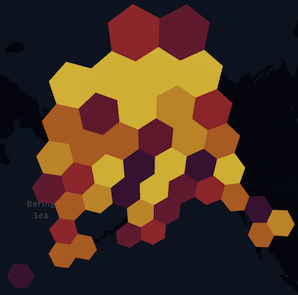

In [0]:
displayHTML("""<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAASoAAAEnCAYAAAAepA7xAAABeWlDQ1BrQ0dDb2xvclNwYWNlSVRVUl8yMDIwAAAokXWQv0tCURTHv9oPqYQIhJaGO0mFT0ojHP0RSNAgplBtz6c9BX1eni/CJWhuEfoPKpp0aWqoaK+moCkiKKg9cCm7nfteoRady+F8+HLu9557AHdA5bw8CKBiWGY6GWdr6xvM84JhjNBZhF/VajyWSq1QC35qf7Tv4JL1VpFerH5zPjOxczIePVbaexelv/19MZov1DSqH5RLGjctwBUlTm1bXHKD2GfSUMRHknWHTyXnHL62ezLpBPEjMdOKah5wS/9ArkfXe7hS3tK+Z5DTewtGdpXqNOUU0ihAQxAMy8ggC4UUhjhxECHM2alg/h+PBdsjgSo46jBRgo4iLHKIkcJRJnfpbNhvBIgdz7Dc/e+ddrUm7TJZFULsdrVZ0ppPgKfV1dgAMNYCrj65aqq2RArckWfglf4+SX2SfWe1zXDImd4bB4YehHjzk9c+0GkI8X4gROeQLt8Dl8YXM3lsJwPHewUAAACWZVhJZk1NACoAAAAIAAUBEgADAAAAAQABAAABGgAFAAAAAQAAAEoBGwAFAAAAAQAAAFIBKAADAAAAAQACAACHaQAEAAAAAQAAAFoAAAAAAAAASAAAAAEAAABIAAAAAQADkoYABwAAABIAAACEoAIABAAAAAEAAAEqoAMABAAAAAEAAAEnAAAAAEFTQ0lJAAAAU2NyZWVuc2hvdIluy0IAAAAJcEhZcwAACxMAAAsTAQCanBgAAAI9aVRYdFhNTDpjb20uYWRvYmUueG1wAAAAAAA8eDp4bXBtZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJYTVAgQ29yZSA2LjAuMCI+CiAgIDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3ludGF4LW5zIyI+CiAgICAgIDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiCiAgICAgICAgICAgIHhtbG5zOmV4aWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20vZXhpZi8xLjAvIgogICAgICAgICAgICB4bWxuczp0aWZmPSJodHRwOi8vbnMuYWRvYmUuY29tL3RpZmYvMS4wLyI+CiAgICAgICAgIDxleGlmOlBpeGVsWURpbWVuc2lvbj41OTA8L2V4aWY6UGl4ZWxZRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICAgICA8ZXhpZjpQaXhlbFhEaW1lbnNpb24+NTk2PC9leGlmOlBpeGVsWERpbWVuc2lvbj4KICAgICAgICAgPHRpZmY6T3JpZW50YXRpb24+MTwvdGlmZjpPcmllbnRhdGlvbj4KICAgICAgPC9yZGY6RGVzY3JpcHRpb24+CiAgIDwvcmRmOlJERj4KPC94OnhtcG1ldGE+CnQcTnAAAEAASURBVHgB7L0HlKRJVt9705c37X33eN87hrWzjl3QLmhBLCDB6glYHkcPOLAII9ATEogjeDzhxIJ4B44wQtJ5woiHFcv6nXUz7Mzu7HhvunvaVpvq8pX+/f7xZWR/lZWZlb6yujO6s/LL74sv4saNiH/cuHHjRmRs++GiDcKAAwMODDjQxxyI9jFtA9IGHBhwYMABx4H4gA8DDngOaNTSp8AnwifP52oIKos+mjoMpg9bs0YHQLU1663jVMdIcZVenKYrRyJ062LRJvkWWG3Vzu0BKkcZsioX3yn+btXyQP41GwZAdc1W/ZWCJ7icBZh2R6P2rWNDlopG7FNLaXsym7chwGqY5+rsW6mDSzIUzQLeKeTEN8SHbIUyfim3ahOUSWXZSuWB3Gs6RAbK9Gu3/tWZJUkJpO5IxOz940O2Mx5Diipajl78zGrW/m4pY+fyBRsGvIaI2++A5aeuy5RhWyRqt0ZTtj+WsJGISmr2IkD1YH4F8I24smuaOwj9z4EBUPV/HXWFQonSaT4rhaJ921jK3jiSdB3X66UciCF5LABSz6az9tmVrJ3OFWwMwJIElu0KVa0nGgaoIUDorljKDseSNgZAFfmncmnqp3jnCzl7MLdsS8UC4BtMb1vPefBmLzgwAKpecLnP8vBTvT1M9b4FkLppKC6VVFmJ7snV1EhySDQEWH+NhLVE5KnS9MkDm3+n199hgJKUdDvgdASQGq8AKE+XypQg3nwxbw9ml+ws36P8HkhWnkP9+T0Aqv6sl65Q5aQkUtZU73amet9amuql+S1po1pQx1YQYMUAp4u5vD2ynLGPMi1U2CzAahagHLGlPx6AM0hazzEV/Go+bWNwQPd9ecPxB9ebz4EBUG1+HfSEgnpTvVogFSbMd+A4kXV9MpO3L69k7PPpYF1wGhDTVbclk0YASnRvVCaVQWlF+DfQW4lj/R0GQNXf9dMR6hqd6jWSmTq4QCAOMOWQxE6zMvgIgPWF1ZwluDfOQ8laHtgaSbOROJ0CqHBevixK2+utFtBbjVDCzZ7ShukcXNPmBqt+V28zUAf0q3qNTvUa5Ybv5B6wXknn7NNMCZ8HuDq5QuglI5kZSLdUTQclmn28RukPx1NZlPYC+qovZ5ft1WLOJgZgFWbRpl8PgGrTq6A7BLQ71WuUKg9YSaSp+ULBmTT4FcIRVghTJNTKCqEHHgFUFNA4HI3bndhCTUZQ/PPPSzw+XqP01oqncsTIJ8vk9Vn0Vl/JpZEOg9T1bBA2lwMDoNpc/ncl905O9RolMOjowQrhPCYNz2PS8LHlrF3kegLAknQnG6yNgqBBHwGUrq4HoK5nFW8735IOOw1QJFkOylF0Kv9jKNi/kFtxkpZAv9u6N7IYhDocGABVHeZstUfdnOo1ygsPWH6F8DHsr7RCmN3ApEHgIPpXAag0iQigbkeC2sZ3HOiQEWovgnIRLZKuzhey9kXsrQZ6q15wvn4eA6Cqz58t87RXU71GGOIhRTTJBusseqvPLaftwdIKofYQKo6klDBAZfh9GPunW2JDtgtrcumNBFAePHjcs6A8B3qrnrF7w4wGQLUhi/o/wmZM9RrhShmwQCMM4O2UXyEEsDSNG+O+JKgwQO0GoLwEtRkAFS6X8h/orcIc2bzrAVBtHu/bzrkfpnqNFMIDjlYI80wBTwJYn2TT81N8H4kGElQ/AVS4TKJ9oLcKc2RzrgdAtTl8bzvXfprqNVqYMGBlsVd6dhl9VC7hzBlkk+WfN5per+J5ugZ6q15xvCIfBjgNFoOwxTigqd5lOrZ0PT8wOWxvGU26itSKmHQ+/Ro8bRlol3S1O65JHquB/Fbwz92PPvrj6coBpbuiCfu6xJgdxExiDro1hR2E7nIgn0mjDhiELcMBdRhVWK29er5D9XuBNDpKZyXPDdrCIroDqOpvykWnHPCNovB/c3LUdmJr9eX8qvPAsFV4398cXk9dEck7t7o4AKr1rOnPO+oIWiWbrXDLUm9DcX+W5ApVMuTcakEUayXSWcnHh20YyfARDEQHoTsccMMYPB5IVN3hb0dTDTqHOcd138VUz7tl6fepXkeZ0EeJ+UFDcuAN2HpJGvwixqHaIzgwDO1ORQ10VN3ha8dTVWfQpt+DSbQi/PA2SB3PqEcJqjxZ/mw9mSpgkKdb6jVJV7K69/d6xMJrKpsBUG2B6lanTvI5x7TvLF422ZFyVQSVaysHVUOBUWOWzcxSqm/18vRlXTA4KwyAqi9rZz1RHptkhxSon9fH2XJ3roKeLcn2QiGPVDUAqs63P+zuWPGT+9kBUHWeu11J0S2DU2GrbPL1oNWVjHqUqDBKB0ioMFsVr1QP2sOovYBbcWGgR1XdWjZIUoVcxq34KYEBULXGxp6/5ZW0i/Rqf91zIjqc4VYFKLFBtAuc5MNqiV+DqV+nGwcnIaVXyokOgKrMiv6+cODEEH4SHZVG8atBqtrqZRD9y0hTMhEZdKTO9h/ZTxU5LYjTcF3CA/52lr9dSy0YwXWacf9uNWmm8BSDfX9bd6VM3Uf2VDrNJsYP1c8gdIYDEc5jLGQ5ekONpBQGQOU50effqjKZJ8wgUUmhvpVDMEaqo/urrVkaSbnnB4r0zlYebTwPSOXSywhTV9rHAKg6y+aupibrXO0vW8RMQSYKWxuutq40pUpWFxoo0sWJzgbxtZBnoxJTv3AYAFWYG318LVASUC1wIaC6akwU+pjntUhTXQwU6bW40/79QJK6Ik0pxQFQtc/XnqUQVBYmCg6oepZtVzKSVTrF2LKTP3WjgSK9K02jpJvScHAlDIDqCi/6/sqNMdRfhtNe1o43fU/6OgLXNsN1j/v6hng/UKR3p4qkftW078qMIWgpg03J3eF3V1L1s/aLLJfJN9JWBqutTLsqd6BI70oTJ1F8lSWHWTkachlkV7FSQ2c1kKi6xe8upOvGFnr4RSQqLe1v1aDFHNG/VYsgkM0w6s/zkdfPrVqOfm0/kSgawBicxbFiYmSc6/gAqPq1sqrRpQ4hn5iXUe5oRN+KUonv1IXi1uzgol+K9MvYTy1QC25rU7XKGtxrnwPMA2VTlRiZGABV+9zsXQrqJDIuXEQcCRvD9Y6C9nPaiuBaWWqVQaYJA9culZzpxm+B1cBnejc429U05e7lLJ3kEpuTt6ItlZeotCF5K676CaSkH7zA9g4peH15ulrpg8QHEtVWagPqFFIqZrhY5XNlZWQrlWLr06p6uIR+agBUvavL5lf9vFk7Ct11Qc/00RrjIHSFA271A/6uXCXuXrrCpC4mKokqDUgt8ZGuahB6w4GmgUqbBeUnJs9nTaDzRHXK7dCo09gPwGoNdzr2w3cNHTHlrzuWeI8S2qp0a/jVKt8civQ5FOm0dLeo0SO2XdPZNGieEDSt7MqCZZfn8brHqRuSmsIf2CgAyyxdxtnVMr8GUlU3WpaTY6mOU1vc3Yt0VFu1hSywEVnmFVsVcLvRLrud5sYSFVO5Yj5v2ZVFZ3jlpna1qCpNC3UOl0AsMTzK11ZtjrUKubn3xU11kHn4ulVNFDwHt1rLEN8Di/QCniy2LtB6/m+l77oSlZYFC9msk5KKhWygf2qgdJFoDFcNq85dQ9hVQwOvDqJswAF1bmdLJRMFrrfaqO7GMrU67CzQFGyp4IHqPFM/1cFWA9otxewKYmsDFS0qD0hlV+ZKrzTfJTRVlG+ZrdedKrjURz8dUFEVsk7vxuZkScDdkoKx3cNrI8v7l1kMOFewxRO0DMCKg4e3RFAPWIE/ixRi4Hq4t1VWHagkSeU8SDUPUOEiCKycS9HwzcF1WxzQfH0OxJoHrDpuS6WpusCKtN1Hv9sNNKEIROeXSBqn7zd+Z9Te/ysJe8v3YLx6HNfK3I+l2s2ku++LC1GYvcLkbwVZqnrH6S4N13Lq1XVUNM4cmwE7N7doD+yu5QqqLLs6jCpNblJWnLsX8VZ32w9VJSmBFh/tv2olSGIqojXInjObvKtgRz8wZBP7kg5g37uvaLcdTdun/jhnJx6J2cQRckDikqvsvgqwWNPUAmtIs5m8RTVl7Tca+4phnSdmfetDmsqxqicve3UV5xvRQuNWB0oMa1PhFpHtNypTnzx3sB8tGn4QXafpxNTJgZSrs+qFrApi1aO6u5rmRTCjz5zk53LebvmeiL3lR8ZsYm8SvSe0Y7Wa40z6624bsu/88SF71w9gm3SsYCvnAQXec7qsOun34pH4KklPLfnyMSSqoYIVtuUtc6FoQ9BYh129IO+ayiOWHJn6uXCJnQKdaZ+Aap0inJrRP9dRqrUk91yNDJtpdjwLpGKJQY2G+dvutTrHCCxdXDA7ko7YngsxyxUiFh8rde5WhasNep1rC9RrGNDWtY9S4aLQl1+NWPalgh3536J29LuGbM8dKddyWNl3IKTmo4/Gw+RwzI7cnLDr3gBQISWefAQvH2NRB1jSafU6OICiDKuXwNhzgNJQ0d74gYj9ww8m7W1vG7LnjmfsxRcLtmN7xNI6KKXXBF6D+UXGth9e07TV+HSelvzAaOdyMJ5o9ECBGE8xgmtElMFnmgrSykewaZC5gUXjiPSs+OnbTRXUEjfoANcgz1susipqciRip18r2Ou/JmE/813jlsA38enHcjbzCXr0UNTi03Qc5oZFTU3W1GztbIvadFcnsgcp1WVYsqqcDrrmQpNZfaloE3cX7aZ/lLT9d9LjmTbmkaLUHKoF30SSScAtW7AnH161B/5rwRbOxWzsEFMu1mO6DljQ5ma3oh+ASsPXG99pdu87o7bnQNR27k1YngFBm8Jn5/P2K3942f7q42nbuz9qC0wJB6G7HFgHVBofpPzOLLHap4ZJ/mqo0XgimMbRGgVaaw4HlL8Ynqslqi2GG3N3yb+2Uh/Fl9i5U4DUvQn7xR+etgN74+604UKmYBdezdixL2Tt0qNMt9AHJfZTZ1JQI8HU6+QbgZSr0xLCSLkeDmWgotIFUlKWsxRpB745Ztffn7SJ3QnLaFMioRZIuYelPwIsxUsAWBfOZOyBv8zY438TtZEdUUuOFTE0Dsfu0DX5Sf/EuGuZy/BqpWAH3xaxN743ZjfcGrchpD3MCC3njnXmOdkm4xFbJN6f/N2C/fp/WbI9gNUytFWwp0MEDpIRB6oAFXdpMQKqCOATSEgJGmKFnqnU8hwwKSU/LOp6EDrKAa3sDdGZZs4U7EPfPWIf+MYJm2BqlEHPo2rQJ4YFYoHOtHghZ2eeythrn8nb8otMCXciBYwE5GD+Uw7hKVz5ZtWLUgbqopV1TMZROq3SzV0s2uTrCnbrNyVsx3VDhrspgEXbqrggqIPXmiq6CKE/yiZOefLZvL3wdM4e+CMkxqcjNnYYNET6C5cj9FpTlwJWSZ4yD1w4ZSj4i3bD6/N29C1xO3BDyoZHokh3GNWKZ54FpRwcfXSHCBXzF59ctJ/58Lxt381ZdDzPtKnabaoQ11Dk6kAlBqg25GnPXaqZDUKvOaAqSAJQCTqVQOrnf3TC3v91Y0hIKKPpQAIwHxRXgCXgiESKtnQha6ceT9vZr3JI5lPE4mF8h2LT0ZuYFvr0K7/dNI/OmpsHrKBHJgfX3z+EaiCY5im+6FkTuNEMWOn9ZCpi87M5+8rn0vbZ34EX01FLMb3NIwE59FuTwcY/pH/SJ8OEIT1btJFtRbv3W6N2DwA1tT1msRj0Y0wr6Wgd/aHkPb9jAPEnH1qyH/vFeYuNR2x6lNVYpKt674aSGVw2yIHaQNVgAoNo3eGAOsIw6p15tk1m5gv2f/34hP2jd425KYjvJNVylqQkIIuVACuXxnfVa1k79rmMzXyKDpiJWOJAMC1sFbCkLM8xzcufLdr2+wt2+z8etql9CaQPKduhSgDlLtZSWNZ1rb1d95cAQ9KVtKHHX8SUAenq2CNRm9DUtiQR1U2g9FBxBVBaVcxiy3XwjejQ7inaHa9P2fY9cchFgkMircfbynx83AS8fhLa/tVvztnxk3nbvUtTwwFYVfKrnd8DoGqHe116Vx1A+qgZlsEP7I3aL31o0o7eMuRGet85amVd1jmRhsMMpDGBVh491sXjWbt4LG+nP5uzpReQsHYzLcSPviI2Mp1y0yUkvJXnmSrdXbCbvyVpu1mtiyVjbtoZLKCUKIPQSl1lWadVi/ga91VmBUlXC5dz9tQjWfvCHxdt+XzERg9AOxJiVT2cJEzo1fsr6O1y6Muuf7vZG98Ts+tujluSxQeJPjkZpRFalYIYF2xkKGInzuTsJ3991h5/Mmv7DsRsbrn2AoLLcPCnYQ4MgKphVvUu4jjgceZk0e4+Grdf/tFpO4zSfJlOtmFHosNUnjArqj24SY8lyWTpUt5OPpa2U1/EdukZIgwjZWlaqPelaAn6LRelQIeXNJJfplMjMRz5IMryt6Is35WwLBKbS595aLVpXVgB34pE5UnQt2jT1DaBdDRzOmuf/au0PYmyfXiX/GqHlO3QKwW5TB8WT5ml4gW76euRnu5P2I23xS2Fglzg5JXfG/I1TESNa6U1BJCeQUf4q384Z3/3mTRgFbV5JKtrPajeKwetZnkyAKpmOdbl+KOs1J07XVrZ+9C07d8VtxXAANVJ3dCIctxLJn5amGHl6iKrha89nLPznwSd0C9F0f9oauenhQIoAUT2DCYHR81u+IbEFZMDKfNDdFVKTDVpouFWA7W6BSw99GWIA1gFnAc+gSnD5/6oaLOvRm38SCAV5bDhWoLekcmCveED6M5uidjeQ4k1ANUJcKqkV2CVYsVyYblgf/yRBfvwHy4584Ul9GmSuq7JQIXls2mk7uD4q1Z5MAAqOCeVimxo1Jh8R2iVoa2+p/xlyHkW84Mf+95R+8fvGbeJUVb20JuElebV0q8JCNUi657KyZfyjGq1kGnhzCsZe+XhjC09xX62Y2DWHk0LsWtiU2EUplz/rRE78qYhG5qMOylKyVTt7P7mBoysBDWlJ+aLrjKI6Xc4HdL2z3RbWXGiki3M5e3BT2TtoT9kfyK1ue1Qwe58T9Re9yZWIHfj54CIWsHz77i8uvRHbSgBuIu4P/nogv3C/7Ng00h8ChmmqKL5WgqSqNOLl5wNpo6+ajVc80DlQWpuCYkBY0rphtSgtKqmhh3uJ60yud57Sl8re2rKF/EoEF7Z0xaTjRp20yBVQYzvvA6wcMaXRnGv1cLjn8jbIrqoHfdH7K7vSNkk+/MkMcgEIixFVSTX3M/KwjXKbN7TP/3XK5KuJPYdezFrC/NF238oajv2oNxHQd6u/qm5AgWxRZMGF60IfpwVwR9nRTA1GbFxzERWkK4qi91KHlviHQqaz6TRDS66ipIheGKELRSquCbDNQ9UcUa/y/Dx3pti9ugLIAPTITEyMUHDQleUZMQWcAk01AD537Gg9LSyN6sVNCyhf/2nJ+zr3jzakNJcRLQLUuGCiBZ1INk9yWRufgbjUYwu9988zH63kmW5Xmi+jYWz6ei1k64g2tOekA4OxM+rvgBUhc0CBdEkXg0xFfz8oyv2f/zSPA2pYLvYdrOEJftm0eWY0sM/kqjk9dcFmBKAVfOS1TULVGpIk4xwp08W7Gd+aNzZJ716Kmtnz+fskafT9vnHsvbyS6BTMBmx1FTEJgEuTZdWUdI66SLoCy1Vu/IXEJ6dKdphVoh+6Ucm7a6bUpalg+nZmoasGwr+Jr/XTImCp535S1bKTXosAZYkEumofNadyaTzqQi0NO0rVVff0Kuqk97qlZNZ+z9/87I99UzO9uyL2mLJYr/znOi/FOWTLp9eLg2seEfVgaJN7gG+JoFKjcftmWMF60c/OGrf922Tjokx5HU5ekijJJ5bKNhpQOsY4PX4C1n7zKMZOwuouZ7AUvQo08QxponSSWiaiF7XAUyjzWQC/c9p8n/d0YT9Cit7h0ore9X0UeGVs0bTbzse5eJ/33T4hsoDWHkdVkPxexRJg9owbebkuZz9m/80aw8/mrXdgJWU7Fs+qDNp9NZ3taA64X4uvcpHrqNKUtXoRO13qqRzzQGV+OkkGZTW3/C1Kft3PziNXgplK2Ajhnq+a5UtzjRI7M8gVcyiuznOkviJM1n72N+n7fGXc2xX0VM+vD+JVfIIK3Z+mlhLMS/JZBidlCzN3/+elP3wByZt7864rbKyp/quDGW7qMoHg98bcEC1qaA6CoVSx+k1AgusJFldYkPzb//JvP2Pv1pFyR60uxB1/X2pxqsOUuJhoTStSwyNuSndOl5TGjngzGVwNaj5uA+k0axUdU0BlXjsDCmZbh1lw+mv/+S07dketzRAVCnJKK6auJq76kfAJQtknT6yjB7r/GzeXsPA78UTWfsiNkkPPQnSpSVxEZltFNOjEUsBSGHgUhq6N3O6aP/2h8bs279+zIFhrZW9TuqgfBsZfJc4oM6miq0VaACq/zWSwkbv1EqrdF9tSjpRDWJ/zIbm//t3l2x6B2AV6sMbJLF5jyFejgicnR58iGNuUMjlcFU+b/HUiMWHUZKrgKUg3jovLBwKoz2RQU8qPSSezBUq3/Hvrv3Wu4Uam5LXxrwqfomHknjOny/a7Vgl/wYgJRulWpJMZaH1vj5q25J8tKIj4KGubBUl6Wtnc06/9aWn0vbY8zl7/FkeCNUAriQrPtKHCbTmzhfsF36MPXvvZjvMBnvKNmXKV1nwq/y3AytVqg9Usuo5GKb8zYpv4tcFuYro4Z9SEYyhNvjSE6v23T91yXleWOxzNzEqa3ZlCeBZduUWhAcuoNQn5BxzLLCTChhXLq5TpC8HXljKN/0FaSZHJgExOlGdUNTRZKwcsqZ1bQSZAMyyx2v7zig6oSk7gH3NCgrNDfhUZo7asj4Kqg/Z5cjriO4lWW265UjSbr8haW++Z9itOB07lbOXXsvYE+i3vvA4RpX4BtcZSx/+N5P27jeNVleau9RLfyoqPfxocN05DpSlVlVkozwnnhuCfINoghwJF5KgpFxXcJjYxPu9iyp+0GYpo1OGc6qUBxWndYIH8qiiI/Gci6cK3gncNDWsxVMBkM4BjaeGHdjVKpfykBPOa2LqJzBiO5pdYBPt//i1abvv9mHnT0gSUaeC6kkf5aX2q2migvRbC0sFewWl/PR41G4+nEQCKzX0OpkPpKk6zOmTR+uksQboUtuQqcuP/vJF+/xXszaFtK3ffRUEMqzU6SzPsuJ2DYFM3RLDDmQEXmWw9WCl93U4jKQpl8Cal90PTSHjqVFLDI3UBSpFziwxvVyfxNV1Rw3D+XJiW8qv//Skve7WIVtCx9RJkBLHlI8+CqovrRwq6N4UAPWGO5nTM8BoO4yL655W/zMAqep86be7XhprFLDULtTu5hbzdvxsnk3RdOhyL++T0tE4gwOH8XUtCJJjsYqQGJ4AqDAAJEhqKrBFRhKS9E6SftTQNzocxklcbMZ0PKxI3/9UnCynrhfwmHjVA5W2pZxDeS29kIwpNWVrdLrnGdbKt8DIB42YWfRRuhW+75+Hv+tVXDje4Lp/OFAGrA0aloBKRqkvswBzAi8W8gzaV/opCJSkoyPuHEhVSkM8j+schGQK8Mg53ZEOGhYwBUp2XGEzVQtOVWd+W7exCxCJI6ZUi8e9PFJZnhVD6cOuWqBS+adYeTv1Wp4VNgw6UV5XNabsQXtXPYRwq36OInwQtiQHZEoSrHBVJ1/tQMr0s3hYUHBDlxpGF+tcIOokPpdjjT8QJgkoz+lTDjQcPRUtVung8VcgpVOqcpoWKp5r3FpcwGUzoOKAq2ELYRxAkq+U8esCaUt57/PQjs2uMmodAT24If55kPrh7xqx73jv+KaBVA+KO8iibziARBKey6lvhYIU6Uv4qProQyzD4AtrZRWpBAO+WELO7Ts/QLlVN1yKazOwpmrrVAp0lGwJDKTYdkGdRx+FMv385lo6JT1zICV6y8+D6O6ve3dtuUNPKy6lqA+WPHVi1ToeKK1SHnEpvWIg5dUy5VDZZNApSUoGnf/sfYEFbKjMFcwa/BxwoEsccJ02SFuX2vg9cyFtX3lumZ0NCSQT+SxmlUf9mudtBzq1T0pSlCQSHdSSx/5JNk9xpCHf8X1e0i95qcXf0348gWdErimgS/ZQcZTeUaa2gS1VA1KaT2yDb03rREMeB2KxFFs9PM+gP8q9HNNDlSWeXZ634tAoYBUox1xBeFB+YYOM+umxyihbqbOcxXb0zoT9yw9O2jiuUqoZdPYT3Z6Wq2Ww8OUZfF/hgHBIW7ReO5u21bnLNjWBeUyOsy9HMbDznfNK9Oav6LMSOvRRx1Zbkv2RlvclLUV0SoWAwAffx/UdCnGszB2gcU+Kckk8Ajv+gFnanK5j8jocoCGXlmEoZzlK8oN26a8c3SX6nI5Kbhhy2nYONxU5DnBFpb3fQkF1PSyDzkt4crwlbr/2E9O2d0fjBp1bqKgDUrcgB9Tf5NHhhVcDl5+aIaojSlAIpj3tFApgAlSc0CH9UCl4o0z99MfZSfHtAh1G+iH3OwRWbnaltNBBudPSBRp8HOjF8oECPBQ/SKwTf2VUKiV+ME3V6mEMGyvnIgZoLKHRFQnKoTI2FP6EY40EHUH8TpSlThpyx7KA7s2S+Bj/keYNOusk3btHjtm9y26QU+84IP2UdjA8/KQaKUdxyQ0NHV4SikIAVpJVmm0EwTteuS2l9ro0lA+gWFxeCMBHGSqElN5atdMBw1oSl3mCTALcnJR3JaE5XRIr5m7G5V7uzh+BVSGnKWqgnHc0kNU6sUkSlU5BNgf8wTwxmsCsWyJLnwZIdvxL443yP//CpF1/INGU1Xn/FKt/edw/PNp6lKjryLnfzNmMPcSZizpg1Qs2knpk+W3FBZb+R2nHNOZGAwAi+6Uc21sERAKUdSDl04IIp49ycfxN4os4zaISI87KXNKT83JQdYKn9LsftPqIHLeGF+uAypEBsVLABZFxImfN+4/pfnGCHMR3b9D5HzHofNu9ww3v3+sVjY3ks25FppGXBnG2BAeEBV4/VWD/zAT6qaWQPyoBjCSYzGLWeRVodHEr7D0zAKkN2LEGpIK4UvM4f+YOoGRegPGm7JuqxN0g9c49Ju9gWeBKkrXhW5GdGBnMHSUO9lsQL9kbjDeCYKPv12PQKYvwzeRxKzzSKDYIVy8HJCRV6qfWl5aG7MACS2ykpEaAR3ZLTiJqo8E7kOJ96aQ07ZKE1o8dqDZQOU4GHcgp06Tt1xyrj4Kc6F/GJ9S/+1Bg0KkTbrdan3cgtdWI7qM2sBVIWaufAhRKbpLX0Q5gFNlWklm87LaOuLZRA4QEZFFMCNoZ4rQimGOLSgZbK7fCplNa+zQ0hDxiirM61XJnDcb1unzaMyVvCK+7M2b/8O34GWcZRf29T8hrjB0ieABSjfFqi8ZS9col0MxFTslx+inshq4szFUpFZIVQTZQ8jWu6Z0Laxq2lDKEK3+COE38lfI+OTrpppxaQAs6jkuwiVR6F7UhoPLkSDR0+3jE6U3uYFre3TYW4VTavMnXuffG6Wnt12+Nku4DD92I2a+EDujqCAccUJXsp6SfkjfZsPF6rUycQMDLOfpcBhOGQrYEJgIs5pJ6vga7aiVU7T4vylxBivtYQrZV/QtQnvymZT1p5N0qBYWLJYeDlQLH+d4W1jUArcRCxxPPp+2OG7Gk9aXaxO+a4COCB6HzHBBb+6Hia5SsMf1UjZd1G1ApIvFkc3Nuque8E6gtcT9sEFknhfWPeF+biq8o7fuYgSXqm5Ko3DsOxtU6ZAS26iQsMax1eF/Px0bvyGOm/JV/5stp9lAVeuIVoR5tDqTUiKp96r04eNY8B9QECRGtpuh/8y05SKDLf9fqp0r2U83mqT4nYEJPLANIneiib+mzXOGbTY/4WWyq0ujCAu8EVyNQlZmiwgU7nGUR6+bSDsTKEbp+oYXI7Rxj9eAjnBbDwQvytNmIWN11wgYZdJ0DDqDIZeVSxi4fW+HgVFbKhAp9FDReOf3UpZJ+Su2zrn5qA+LpX87Oyn+3JUqigtDWmC0S2h6HPOOckVhbtdA8xzSoBg7wgumfXGj0V1NtvkyDN+pwgArXWKjPyiwHpL60bPMnVi0zl7PLbE1ZOBMonvWcMXTTgwMqwPPYyVWkoZzzld5fA+nW6S1tA1Vla+j1qmC/Tf8q+TH43RkOOIBimpddLdgc4DR/YgVFM1IUFt/uQ0teYsOvACvHaUBe4upM7i2kIlDlNR3g8TL0KvR4HHd5Xi1/OgdUDB8ZVigCRTtV5Ia17rNpMP3rPo83LQdJRWpKtFKBzzySySxS1CrSlIDITfUUpyQ9yY1KZjFnsy+v2PIF6U2D9/3zXpTDqyfZzudcDa+u5u3TX8HJHDd0LNogtMaBzgEV+bvVCfRV0lk524zWaGrqLVV930z/1EoHoX0OlNgoSanARthF9shdenHZVgQ+BN2vCj68JwArIsUsAGpz6K7ykq5qxW+f0nIKvupjgKVzG84G5OOPrdoT/33JbrmAg7Q4xMnou/zG4KIZDsRisdTPNfNC3bhOPsegjX1LEaxc/R6iuu904KHaNQOXyTL9XW/AZILG0vPgW2oTGftXeiR8NkHZ5kZ10zb0jauXc7ZwKm3py0hQ6Hoans5R/Yqb4xCP9JwOHWC/6rCzZQkArkPNw9efNmwIoLTau4ib4ZceWLUX/zZtx/9nwVYuRu3w1JBNEenxZRzQUdnKvoTFm8voLZR7JJEc7wrPInjnk08rGZZVdYPaQSap4nVu30WOw/qTD2+zozen3GkvPV8EoqHWtKOqKK8auXbRi3YdOOEb/TULWvBDUzzxYRXl+PL5jOWWGX0EUJL7W2mlYq6zTS7ayM6kje5K0h7lxkSZVVRIEz9Fo+op6iQ1rXwX7OzzWTvzSMZmn41Y+jUEqN1IVt4nHsUQQD29uGS/f/4i+1M5fJP8WjcuaILYqyRq0wafjZZbNh45vANG8XEjN6hR3JpWO6iw0fTqxVMbDk//Ns3406OMR50aRIteeXl99XncWXAc0eEbEnhV1NI1HzqR831GR/DJ1UhmS9xWGeqyQ51eQAQgZVGOL55OW2ZBu/f576dsYlgrQe85PkZseQbvBAt5G9uXstR4LKBJpgI8byT4MnjpqZAr2MJMzk48zLT0mbzNfRVAxZtsfBJHmtdTZoqgjw85Erh9bNT+BWe6/97MRVtCuTpCmXWqWoMk+KSuye/OTv0qWOi8L9DrCs6dqRxzMY50aWOz2uSmT/+gwW99qGBF8BMidUxaCjY8/Wja/uin8/b0Jwt2YSlnS3zGJyJ4i2W0TdFz6eHqHA60XLpVU+z7m9qDKbmxGujqnqZ0OVbyFs9lHEh5nVKnV481FSygzF6dzcFTjiEf0cAJARuAlepAdGpqp6abR/d0+umMvfC3K/biX+btwueRqPJRS+xAgkIV5QISVLWgrHYkk3YHrmhfXFm1y9jTDJGo7g9CfQ50bepXNVtqXHuLdIxzpwNtqT+mf6WCla3Uy79LDR5VyVcfXLGP/BqAtStKZyna8ll1gKKN7zO7/o1mN94Vs4PXxWx8ig6QwKE+I7P0bwrVOnwpi777Eq3LSElJvK66vZhBERydulSnX7mQdat4mo41rINqs6QCrOQY/N0/BGAhXVUYN4WlJ4GZU86je1orPeEeF+kpIp+SkpxCZatHnrJKAc4XqdQ/ODtjp7GvGWE6kPWZ1nu5z59pEI40yIdmi9JViWo9MUxrmBLG2SPYDckqRaNZWijaTUdidid7/2S3slkdO9g0KlmCNkzliQ6kfvvSp5btr/9jhCkIz7ivRp7kpKAUFvb5TMROPxaxJx8o2LOPMFpj0ZxjijDEvtGRMTaQakVL75Qaw2aVbX291r6TBGjXSEdqzHwunV61JaZ5OU4NbkpRXjurhp8IEAWSkq50nQSsRJOvJ7dyR11J93SOfaQvfXrVnvvjnF34ouyiUMw3ID3VIkb5CNfGYjG7dWTYjiNZXQC0hpGsaghitZLqv/uq2y5R1VuJqlQIHcUjx+2B21UVrdTz2iyk9FTznJt2x+GY/f7P7bChVNCx20y2rdfLjT9SsIcAqY/+ZsQmDqPQRYLygFPOAFbgIojOQ2PGJ1p61iyTLdj+O81u+BokrTvjtu9Qwk0P1fnljM0bEaoD9H2ARk3t5l5jYzt7M12rps46VP3NFb/U7CQtpSbjNrY35aQr7cFaOJ+zs0zvzn21YJcfgUym4/HtfDcpPdUjSC1eCnbpqv585oI9BmAJvNLrGkW9VPrrWTclqk0BKj90yXGXO/GGlcH1vbb5SlDbG0L/c/5M0f7fX522e28f2lTf6Q6k6IixaNEe+sSyfew3OWPjECAVWuWrWUoK40ALpXuGwzlWLiJ5JYu2666i3fqmmB2+MWq798cdaEkcyIXS7EvQomdKelmdy9oc1uO9mubV5K9/AJ9lq5UYRvJLxuwE+0bPf4lB4hRAopU7ztwUkDpdYWfGU5+zw2eB1SqjzecuzdnH5udRsDPVD7Isx9sqFwIqhW5M/3o89QsK4uRsXVJB0lmVPYd2oIfpNBo//bvrJqZ/6iAlBpZy78mXQErKV0l5n/irJfvkb0dtiilpQcs8DTZ4dQ5NDbH0sOFpvocjKJ0j9tznzZ75VMFefCFnWTaWRqMFNzVMIkGqsP06KGuKl0WSSs8z5eK6X4KbetK7jj+YtxN/hl4QgIpv18Em8F/zsQbrq9nyiANSpCeosxtGh20EEfPJlRVLqg6bTWyT43uQEhndqNnNASrPVHpyEk+DBU69kUM+rRKWQcvHafJbwJSFU3MLBXvv/cPOo0KTSbQd3YEUjVwt/NN/vWqf/72oTV8PSJWcNTadAWVyHYYXY0iMI9v4Hg1A6/nPmj0FaJ2n87uVw0l0KKwadqOxNE13xQsCBO3PS2Mn1U9AJTJVZxdfpu0UYl0HqDBbVE8CK4Xrhodsgj4hw1CB11YKjlpPMt/+slNl2FygKpWiwHFBsmbX2WHSWzl7q1ZLSIObGInYq68U7J1vTNrBPQmcjvVOqpIUlECyWUFJ/Jd/wPHdfxKxqetQ3pY9ymqpnmpsVezxoMW3QCs1zciPpHXmyYg9j6T1xCezduhowbbtTrBS2LtyN1JdfQtUqg7q7ezj1NMKP6Q362FQp6Y63ecQKydb1Ypd5RBCdWPq1+MqUUnWhiwOwAJPhVp5oaHoQMZWOzFJq8KDwahoT74AANIAHQPXZtuVXx6kZjEu/IvfTduzH4nY5HVSIK/Prl3JUQVVfgW2v0naGtllNnVT1BYWUdAuAV4qtJjRd6FXtdF4wdVedJRldhNAylPpuZKn7b9pcsK+b9cOp1iXcn3TO6knsoHvboCUst10Hnh/ViWIofO170t8lb0Jycmo/eknWfplr5cOf3TYp87dpc4rQJQkdQnDxT/9tYy98rmoTVwHSAUePqpXcYCo1Z81eVc+0KQUlnllOsu8k5bfpaI2SVkoumhibt5PdKk9qBpW5wuWZ9HCnRC3yQSWrdj37rIDbGHIQCQkXtNh04FqHfepkcDupvXWItDYzmrNq69g+f0M23hcawSVtbOdj9uyUcrYAVfrWblUlJ8U2QKp//nrGTt/jOXugyWQqtPC6jxax5ZGbkiyitOkL53JIpniNaDPalfldcaVbfK7EV40E0d8yiBN5TltvV94lgPQrx8etjex7UY80+rgtRy6ttevHaZmV5dY7cK1MMf5lOZxDSenPqAdKGeWzO7EXinx/LI9dyFtqW0xG5pmOZ99XkPT7K0jklZ1nBGlplDSwut/qRO5ZtFA2xBIadvLRVyROJB6Jc4GWPzJS5La6H01Pp9hwyWsExHaYwDm/Lmcs2QPAL9O/MEjxwFNoTNMl4P5cn8wRU1jhcb1wioNiXm8poRXfaCMbk5QZbToP6CCWOdwXijSQpC3DRbAbCfW3D94HyYBKJpX57BCvpi3y0W5n0HqGAHAxqM2vB3gmorb8FTMUhyzHcXOx0lc5CsACrbBBFhCsuuAR3GGAKkzr2Xsz3+DzaknSiAlnZR7QS9tEDoIVmrLYhu+/x397jzJa6B9b8Dhuo/Ffm0EX+Eg2wgg39GBo27OtR+qyuRhYRGL9VcyWXd9LVSjDlSVxxWdaVgZ+g+ooNDprVqoGSmQtSVOwtFPYxS5h3P/0oCWOqzbiV9qh3l0OXmsj5fP8JDeHRtiLxrglZqOOfDSPrChiZglRmNspA7AS6NuWb+ia+hM0bBPHc/aH/37DKt8AN4O0m0GpFxZpT9robCVNanfJBNNFG1+FlMIDFsE9R1KuVpuTd9TMb2ZRdMvd+sFtQmagXYBaN9lp6qiXXIFVCexVl9k6XYUi3Xpqa7aQNm0UyUxxDSX65w/qj5U4L4EKnUvWa2vmfZ5ycNXmH77e6UC4SkFTwRmP/GmqB3CnmhVIMU99VZXzaW61msYqrDnUC8CFABPdqnAIQG463iJ06AlWWnbBNbKI7sAoO1sW2GvnbZaxNi7po2qiVjRnv7Kqv3lL2K0qunktuZBSrm7UFEOf7uVb6dvyWL9Tpn6Krh60Hly1K2u+ySIFIF6Loeo3Sd0iYwcFfgCQKVwtU/7guUVSk3jLRZYCauCyX0JVMIi5xLGd2C+ZWulcwSLhbxD3QijTCI1Cqiw+53KBFMcSGm698YDUUujWHYg5aq6yh9e8pinp1rt8QDl+CTwWizY7GzaLqFwku7HS14Te+N2YTFmf/nhwI5J9kwyE2i1oTtdUqmsLu8wYUqWZ41IXXotmkI6uICvJLxj7tyXdFtrlHRfBNHBR2XsC5IgRPWexjg4v4SRLANUtU7Sa97RlJGkCvZMOk0bpu33moAe56f2LROl3Oqy+6Y3QcHaFtKXQKWOVdDhiuEOy3UeY5dgIzOPeB4o3iKIxmYzi0X7p7dH7GuvYxd6KzXrEGJtlmrEMm0Q00SKXLHkVnKWwTXJ2bMA5dQIUy1oRXKr4GtrVU3BXfWIAb7sulbyfMt0o26ARk1zM6eLtsQ5d7v2143d2YcBmdBdL9lS+epF6eEzkSoJdGWeuuUTx+J/s6emoknTvkvopi7l8JzBNWPuVR7UttkOtrpA+6chldp8uNAC7z4MEM6R0+WOSaeNJuRGVnM13xPkEXLRYpklm5ldtjftytp7bgg6s96LuLmPj9tiEXldyfikxD+ZOERYMdx5ACluBPAET7sVGpGiKvNWx8P5JO6Nq9Z3ZfT2fwugPEhtkJrK46Z+G8Tr9eN8Tu2mwUL0gDi12pNa7UPZKonq2gj0KzXeGuXtU6ACHEAHWam7aZHAiQLEcGtcxilqL4GIOLewbAeGV+177mbFDRCRNFUuq5dKOlnTJfCK4bZlYjTH6poY3MkMSmn5REtlaBS0VNesbeI14oqPpY5Tp/L6TzOJwzsBlXuXr80OYrGc6K1cgpjwGLiJhKlDypvCE8vXkFlCA/zuW6ASumqpMmjPARK4bSfBpdM/4fsMtIrZv3zHlO0cw4K3mqK2C2ClJOUVYXKKKUM3JRd6UqMAFa5r8UwO3tagejhCq9dKssT/dpJo9d1uvIfK01YvICkDVF1oKk2RrHqTBDXPSt8JTBNk5Bm0/6aSuSoj9ydQ0WLk/iWWlAR1paqkcNNP9RWpjuSD6afvH7MDrMalGRmrK8+vvN/JGpSkNzkmFyvdW9JWHn5PYKP4IB1LAg5dPivrdK2edqDUyrxRAjaKS5lcaDS9DpBfKwmRoilfRor0TvCpVkZN3BdQnV/lIArAitY/AKoS7/qkeipqksrStE86KB+02hdMBZHSoXpptWg/8MYxuwe/1zqBtjpIld4OgZ1Pr51vNXBNMSfHcc4/esXLZkNpihY+TlJqhi4yDabBQS4CsPCnPP8kea1Qzp2DX5IwGyKqRiS93GoCNd51R1Upu+6MHzUKUuW28qcdpVnZzWHS0g97/MQymSU8j5sXhatfiU4zoNDu40pc+09/ApWjV+elLVuGU5cVAm+gYzbMnGsRkPpndw/bu24aQXHciF1OAA4uoQ79EcboLMGxkXzDeiqBk/+UwaoZeoSQNYJ/IrrC1uktA43yUWfuYBBtgY7KU9vBxJtMSkXT4JbGx34BoNr87fkBCUsyS8hcG2YJa6psgybRx0AFOCGPa/VPIY8d1TD6qHkbt7cdTtj77hhjUUQGCo0GYqqndCgoJbkYnp4urfzVY7TolGlBO/n7NEr019RdQVjYOr0eWQ2zolNs8+n474YJ6FJEmJPNcFwVh2rUGQO6lPnaZMWSsFlC2MunJI6rMTRTrvaBqp3O1wD3BVYCKRm7XFpctRumsJe6d9wpHdX3m6tDmkOn6CWpKEPy9ATeKqvBZQlYBFA1QaWZ3lGa+rnpn97zwKXv0sezU/qWTKes0z2o+G+fSaPfAalu2qpDV+NY9EviazW5RrPdKJ5Y6Ff8Ijq9bbMJKpFwapU9WNeIWUJjvqvUvgvtC7xRlN4K6pDaVOhsIdydzvwRkcX0IjvJcd2SzNqPvTHuVvhy1Vb4GsqSFkmabbdMNXSSGUNHJRa4JH3+FcDhb7f9rd5VAiyflgNB8vNBl2HrdG20Dj320Zr/JutWgvKOYzZSgFlffWjVvvL3bBDHb3qiZGrcEdpaIYx3VGeZy0z90hSu/SG7RSqC15R9Gh59eYkNuQyA8kml0IzU4V7ooz9O9wRr/XclaRuXDbUOBwbEh8ZwX9RicMDE6THJkTEkniSjE+f1sbEwk7vcYorVX1P/kOmNjub4ifvHbR9eDlZYzaqrPK+e1Nq7agiu87k/a5818EtvafPzyBAHh47jmeEyJ+rATde+ShLPRsk0nTOJO2BS+rUCNDnrdE7i6bl1eogm8QF9v+PJzOmM/d1/y9ixL2LblUjYs/sKdvdb83bzrQGIsRLv+FavWKGkO3apLTMH3ggvIzmbe4EN6BMkDd29lq6UpUwRTqUzdhxL3RTXGkoVJHX4jt6YBBK8t9l/q4GQ7lUrQ7V7ol9tPY6Rd3xopBWg0pK3NucOOWtxJSYf5zEsxzVqqoF2Mmj71Qozvx9/27jdtCNpq50AKU+gIxaCXQ+p0/l9/CrfMk+YYPXvwnkdECogQd9RJV61W+JdeCWvWpzwPQdSurEBkzX1Y/dF2Ve8vD64fWzhxLp07UmTFCXnfV96YNU+/TuQzOmrY4dEO/W5HLPP/n9RO3lfzu64u2i79wBqVHSvfbxLohrmNOqbvq5oJ3fk7ewXsN0bL50+45GiS3yqluxZ9vapbqWrCmcfBiu9V6tjV0uz1r1aoFErfqfu+3z9d710A1vKhJutNS1ROZRjiieUcwriUE7yI+XkadfxQw9avJTUxNY6u346anfvSwW7yBtFgYbyVGKtI6s6pU4/nppgo3QOaUGpcbOZFB0P6/DLFVfPPQJsUC5F1UfW6ctMa0SMnATKLEBT1SC9DRKpfOxeqry5/rfST+DCIgKtJ18GoP48b8dwyTwsIKKluY3bvBbDncoIB3q++kTCXuWQz+vvzdt9b+ZAiu2caQfAygizDkvWZ9zGHZcXDe3gvREb352345+JWmYetz+cXt2rfX8qax70OSGgIoRBqo2i1XxVIKHQCFgEMTv71+e/Yaq0I7l8SYyMIwTEUj+34QtrIkgZqn13IYyD0/Ju4BxedbiFpQCCGWxd3nAwabuwPl+zRWYNXU3+EJ3+07AMVJGHkgAJBAKnz2KrUGoAFbHa/9kESAkstMn2vjdkbLulbYlj4WX4Gcfnlg7ZdGUWkurTKL0bxPPkDXP6z+xM1j7/sbR99FcLNo+UObw7yGuNDk+3BKAoseM4Npx5lYM/X4GTcbYlMf1SOiqH4nS4OZHz2uDTV36j2/Bzf6ho6ZWirZ7FTk0Wl90K4ikflTHKXsNLjMh/dPEyK9tIlqqbiuCqgD+dkKbW1LvSrMirEz89vdXSUhkaypPKcav+NJ6WgErTvJhON/aBBOXt4MrePP+g/e84fUvHXe3HI+dNO5lekmRDhaybNSn4Flo3Xv2HAin9R+1iZy5gHY9SVtOuzQjSB6EmxC1y0e69O22H97MaSRnl2XTh1bQtnNGRZAAW0pVASz61BB4NgUEdhnspKkrre/bxjP3t72XtiY9FbWw/ezO1sYC6qxnUIfkkR0R7xF55NGYnT0VsaLxoU6zuJtRpVeHE6UB11SRDD5S+pKsEwLn9em4M5W3+GeoTCVHSoGjoRHDtg7SKbHFyh8sCzuP78jZyIGuX01l7lfoaI09smNeFOtWwLm6tG1WlGSVc+nQiD+VdNR9PFJk0nA8VI7BqCaiiaOKdv6hQ7emepjECrGb0Lp72Wt+qrzzFusRK0TuuG2Kq1XARayVZavVtpOPEgystKUInvYhXzbl5FOpIgL0OAqllfH5PThbsTfet2O7tWFuXvAEIkKJYqsvz6OJrHKd+LG0rs1Q8gJWUB1PAQNXoAEuE12JLxX0PcEN07NnzWfvCxwCpXyNfTsAZR4py07wrLKrLEidVUIYU0tQqx3298KWozaeLNjSMhIXbfPm1FyD2Aqxc1ZLRxB7A9lDeFs+yGjeL/rEdEwbxTmymDDqEVnZuqcm8TR7M2fShHI4Z8zbFQHzn7hR+zrL20sVcTbCqy8gNHtYFD5HYYH1tkI177JpLRZsJv1fnUThacE19NA1UAiEhnCzFtWk4HCRpFdGIartLp1qVeDdMNheY/t2xO277JjlYs91G247Yo14VCvqppfYs4vvpUwBVD3fhq+OqKFINXnd9zu6+fRVL+YAWPSsHaFS8mFygcp1m1J5Hylq+mHW2RH5aqANCVR591rwfTotE9Vx+ugr4k3n+qWxZipq+DlAkrpw0thLUkfGDaEkA68KJmL3wSNTwIWBT0wUb5WToqrS1klGdd3y5RcsIU8HxA0X4W7CV00ihmgpW8KJmUorHR+lIcpK+KzVRsEmAaepAzib35IxVd2dTJvFDurlhvMfeuSdlS+y2f3YmZ6MMItUkq5p5bvRgA9o3eLwudQd8pXKqrOveX3cjlES990LR/GXTQOVf1DHssnGQh00fHIhRM3nmIOvtqdT66S1qCet6gk+h+rcav6Z/cVbY7tlfT3HQKGfqxatOg6M5JEGGY8nwM4se6NQZ8SP8pHvXYqOkDPnBv/POtN15cyaYKtUbI6gCBfmP1ypg5vKVaWEOp4CiPTEc+IlfAwoldume6kKz/vMcyfW/fn/VHvgD6iaDFIXCHEeo1K3Loq0/6tzy6JPA5/2pZ6J2/GVAKkEnnyiW9VdtZdDAy46/8NJNBa8DQAGZuecpPA9qTgXFJ30IfmqXHAVkdyExHcza5P68DSP1anyH2w7EgthBt1B9pqibew8M2VAMm6qTGQdW1XRW/r1mvj15tb6bScvFLZW1/B6/w7fcdfhGOeLaiwaiNC9RXcki8A9VCVQCKQdiVyJSKSy50vISIxNIHFhHUtlll8JqERsEh2v0kHNLRbv/UMrGmLbIhmndmx4Iq/UW5eM/G+TXzGNPvvQpp2dQ9iNZ+XvNpNNMXKePArgTrJ4dvStt1zOFkN/vZqdHAixtYNa0cImTdDQtXJ1jWijFOx/5h5chpIBDLHVSFL3mYUwO/vwXcNN8BpODfXRcAK5VKapmuclP+aZYfcvB05cfidm5ixFL0fGlcO+keqEWDa4eVXYuxnfjSRagWTqPBKupIM243MzUEPlIaioiTeqQiBQrwVNMHacP52xkOu/0cMpH/svKIXSpe8rPtWu+b9mVtHHA+ksnsjYk6bX8Uv9cOPIry1BJXul5WYFeGb/Bga1liUo1k8BEYU0Qp0vSkmyrNDV0H+ZDieExKkISFRUpZbyzYgewZDxTemdNWhU/GOjdZuSjexJ2YCrhRGXXkNbEE3qRgf+4Z+KM7umH++PuNv3HpVn7LdlTzVyIYU8VGH4KTPTpdBALV5epKWPTAABAAElEQVTRRzHCv/lrVmzPDiTYUuNfz48GchfLSNNNCxkM/LRwjtE8zxxbJ/IkBVrw//zprP3576zao3/GQRc7qH8OeXUA1WBja4CadVEEVirXML6/li5H7dkvYEpwG9MnTFZ6YndVajIaBEbIc+owq4LoS5dPMhWUDysoLrIQoIsk9nRTh5CcGDgm9uCmZUzMVYSS9MT1RnWk556dt+xK2TZ0Yw8dz9gQA6FArN+CiremW+lG+KOfIborHq15VUnVCi0ClUwUMPqUdFQRpLuSHym5Dfbug/VdGTQiesBy0tUGei2VVS52MxgR3ncQpbrjUGWqpd++NejbfxpmSY003W2fnn6sJQA5yoaHUQDLPTHAsYJyO70q6SqQsEIz5HoZ1Hzmi4H3G9vPit49d67aODoOSRt61nYoNSY/LcyzRL94ImMLpwRYRfvql3P21zI5OFvb5KBtGuokIMBC0wBomt18lOkU08JmJcg6yW/4SDxWE40jgW47Ai1M4RbQW8WTBRvD/mr6cGlqxwCiI9Zc+4DmcmiijhRV1aHx+0aMnD1YaVqoZleqqnLSm33hiibSRJj7UUGRnlXc0s9q96pEc7fWasNrxaq47yyqpZ+i9srW0uE44rCC56j/Du5e+Uvri0opj/TlDm6oQ7rm6cMogx9mVD/LCaNHtiWcH6qOdNIrFDV45TlfYjXlVRF3bivYjuk00h6O6xairATG7eIlPDYuxGx5QboNjuBixUeSlugWmzyr6mXs40ofddfRtN1Ep5COQ1tPOl7+Ul1FaBma+uVxqXP6oSV75BMM7WMcG5bCcLRFZXm9Mm74DH4JKMQ7mYNsRnD1AA1i+t47ZUaRs5VzOtFb9RhITQUGjnIzLjWPVmjVq6oKuTF6902ctkSev/P3izYEUGrhu1N6q1Zoq/aOl5r8dziOlO76VHsWjlfvuiWgkvQgyanUpuulv8EzKlddjrmHKmKj4CwTyPTJM2k7xLHs5Qax0Yvdfl6iXRul1YjVmQRaOwGt/GFsmXAjcoG9gDNMC2fRb6wsR90qoQTNKNtu5Na4FmhpWsYiq5K1e+9N25H96ADVKYKsulcyVa4+5J9k6XzqBgxvz3FLHXWzAhKKTC2SfLpe/lplVDOFL6oTbZlyR6XJ7bN4pWf6dCiUskJCF1iN2BRT8P/wwLylGLAlXLF+08nsOkT1+mQEUO2CVdNTP0lQkoDW6afW09fwHXmqlLHoRkFtQf0kx5rtmw8z/aMTrQ/UYAOgt/69Nu8gHSpbNS4FTUsEKLonCWAbytU9O3O2f2/OdjFVGGMFS1MqGTquoHOSklUAJ8W0T0e/0yvY9KD7eMvr0UftDJz0Kf3eFrFoZ8/hCwzJsN0prGhvJai88k8/jo3Y7Xf3uvwVFKuSaYzLmBDoqDRXF77iK6K2+7OUldNPHUQ3e8O2mD3wctoK6BO1a8ONje1m0oP3VQ5XFv7ou9nQHFABUlKCJ9l70+mQz2ptu34QUI0wlJyaK9hd2FTtnahmUyVOtMKK+nnXfSoFSkUQCWEynMKbG9p5JNcwO6cBLRSu+3bnbDsKca0UrQJKAia/cijs3kOc+452WB9VQeuGP2H8mZmELXLo6qYCFZLLGLqhm27T9LnHdRxmElk7X1YXGDbVKLtMipLXR8p02RHesy9hD6M7XMQoNiVj2DBtfX7dKqsanvpJktLZ8Doj3sndnWQIooP2DxYEVprruNqvnoHahcJjuA65c+/QGjAInvTnXw9amrJIt6Smp04/znaRyYmsHdiT5YirqF1iZWsOyeUMEszhm3J24xFtL+6SPqoJVonuTQ20cNGQQMcnXm4mOco/D0i4aXCrPa9FZkq9cCumC//+XZP2s5+es3l0iEP0YklWV3OoOnmqLLBAyu3vS3YBpEqZSVILQv3xgUU/Vloi9vFXM2xWxuaHkfVKHdFqPCJUFqKbvx24Nt5iRaLrbBCuKaKs2qWMlW+rQ/twfXJT2t755hVASlrrYL/bZhTLs0x5J5J0zCuM9o969i0atC1nHNfPmhKHKr1nNLiMxAOIyQFU5TMKe0iB+CB/bJoG/vy7p9BbYbhLG+L2VR3qA1WpZcoUISF7/261DvKJoshJjE46Jb3rEaoRx/61vUO/5ARgdbVgr13OuhUQR6bAwr2zSfXVRkvxZEu0F2hJtyVpS+XSxz8vl6xJYCy/18KF+K38pfh3M9w2ytlC9mte0apfir2FAirRtSlB5aeiJFE1sgDUDRpVH1Kwa9/rtQBS4qGW2/jSaClJplT9pR4iO6nk6BQfdoau6y16vYOBPJ2SfmQS1x/jWCCT79gU2zrQRIueUHD7nyD7C+xXW+VH1A2xRAiXIRS/J5drSWw5S8/miiKX0qPQPoL7Vt11N5Rz6FD5WqVW2CxwGMXRnZzs+abaanrtvKdmlmOgrDKOtpNs4+9SF9qX+dw59muyD1HG0JtcPY3T3mLMqIAoPjSOIdsoDUAGKoxYAJTAIi5r8l5qT+mdGqXcwaN8azUwCR0yhQhXhebjQ0z/vog3gLMLOQ5LLk3/eihprON3uUeve9LmDRJ20qKXGLuWUV06HXBuTtaOLuUv/XkCk4BNDdCgKV9BeyM3iR/KV7qqZ84xFyZc7foplRFXzQEwiOfOeNO1CDqFgmudwWVP//p8S7QIMLPLc2US1FQ1qEoEf/zkqh1g9c8NKapB3ddHoadtupS3pz2goL2/rif4wrSXVKtvqzjCSR1a7SzBSainbA0RLpuzeFSS/+bxxIEEUowzSyh1kxCJXb8U72VDdQkavnSak7rZWnMtAFXAalqjAymxWTWh1tnJDtdO9UGHmxIOM/0MdREZkCk8N5d3fq7j2usswYtQQNmoz7qZoN4pvecidvwPideUfvQs/BzWl+OWWrx/Lrp0XZXYUt24+ukNZGhmrcNWHT87zrPGElTe8qiQSnXeL39jFBBL7KZeZOzpbAVURT0Oqnb553r1IuYJgBUuxUK9osfE9DC7hs0TekjT+qyonZjbNzHJMe9ztJXAMlkRv/s9k7bjcIo9gNQgjVlud3Ms2crORds/pEuQEtYtJUtb7cCAF0u4sQYL1BA7FpSBEmuwNQu0ykHv1HjP0dhRQsu51rpQ53C4WCtCt+/DCgGVNkHLTfGm0eLooE0BEMFA0u2Cr09f098sItQTmOcoyAD6WghrgCoAgN52gkaZHJhISIc2aSN8XcDY7me+M2F3YKEuX1XOAJDRRV4AkmxYVWtW49ZH0pUALI9ewX3SeBygngVmzqkZcVV2bRfR16aHekTo2SaAVT2SesEvFVk0lIvfi0yr5KEBL7dMe9G40uOuouz8tO8B3PLIO6s26l8LIZ5dWXQuWORGOJ+j8FU8IvQLIwpIRBOg1FnOrPvhbx62rz2adErFcieiJt1o64dcNWwaVBxbEx0i4IQUgZfilQAsB2jJJiYAsNCUsV8KXY2Ocm/tXU9JxPLuCPve5bi24BpQklPYmo1xog51V67ztdG6+4sm5NUKtQTebhKgdivPDJr2rTBbGKdda/HxWgjxAvs00tpE5TovwwUtwIGV7+x9wgV1kBFsec5eLNi77ovZe+7B7TH33Dl6NKA1oeK3K4qLTKzSsysAFii21PgVsvgamjsGPyrSCJ720V8HVipUD8Mm8UTZSpE/zIELOkRiUyqHbNVmNKA5oJRE1eNwLU77vC46sKMq9WQ39ZM3sj4M2oB5fgFfRAej9gP/YMjGUJ437TitoqOp2BLlnf5KZea5jpSKMVL1GU7XqJGKAtWI1bHbPcbFMN2yUClZz4Rv9/xaOk8d6NrrgUys10r3ZfRj19q0T5W8ZlxgrJCyhzrocQfYoLlpJEkj+g8zffu33zJkuyc5JJLfHRH/VVRfXE0p6BCJkeDAzvL9Dei7Zh57PvWwwJJi5Elz+TyZr3AeESPIpuAl2UuS0kKNjC17TYQGTr/ap2nfCO10U/jQw7pXVt6H1Rqgkl+oPN7Z8hwm2hkU6EypJE0tXSrav/6GpB3ZFevsse6VJNIGpc9yyvXKZ/32G1p7EbSlJ8VmYL+tpxd5Kg+dC5jHDc7icbMj9xfs7d/DoQf4IXOmJ+qlPSq/k7xL2WkluVf5igc+lKd9nM+o4G2n/NTIx6v2rTjhT7U4/X5vzaqfiNVWmgJKde2964egFb6Zc0X70fcn7a23xXFCh11VtxqoKpRRU9M/ebi8JoasBipZp/8ExsCBCA6Luhrc8e9kMnvcbBfeTN/141G7+/5h9hty5Durt0k8ay6xfSTPQohO03HA0QXxQgAlqd3ZkNEYLl7ANIHNddpj1/aRbU1wUEXzq32fwT20W+3jZiMgpWy847omsuyrqKJ/HVC5aV9H5lTtlVWVMwJ1MzSO9781bu/7GtzA6CYNp6uBPGTioJXCLKfeaOrRt0H86FLwnVRbVmbmo/ax50ZtoRi1XWi1R2g5qoZOA5am3QKp5RltPi7aO/53jo66f8i27eR0H3SJWW0Epj6GcUOdGo9xIkyGKaE8THBfgNUhfqjs3sh1FTB85aTZC8cT9pkH43bz3oS9+/ZlpyOVWUwvuoro0bTv+GyWzfitrfb5KZSXrPzvLjWfjie7Dqg6VNdtE+qU50u4370pZt/9jpRrEE0rz31vW0ONpAPfwKqjnjpDYhQ9GG5k3BSwX5iyphzd+6EBIfCeWrRHXk3ZJ57CvQ9BU79XOQl5IlKwbQDYKJJWJwBLnV0S7OpFrboW7eZ35O3rPpCy3fuZ5uH5VGcmujilQaPIvEeHUIzvSwFYcVuayVgaP/rySd+qdKU2oXclrSdFC5L7M69E7dGnE/bo4+SRjtoOjpl/9FjSLgDc77tnyfbgxC8jN8TBq+67G3/ctI9KeeJ04AXXT/vayUuAtZXAKpJI4rktFCTix/E7FR92HutDT3p3KR/iUpar4f3u9w7ZPo4pakV5HniEEN3SOTHgutZ4pRyBHipoaFfuEpv80wuYKRzXQarhJ3107cqypuraJs6lxp8h9FEXFqP2wLPD9vhrCWcWIoHFSbTkonVhsaUaYCmNhllGRPkcz3FazyrT+0NvLdqb3hOzG26N0wZjzuU0ydWtA3e6M4QtXwikqwIOywRijUpXvknI86pGsAwC2kuvUfZH4vaVJ2I2gn/2CdxGCyzk8FBtcwUf+Fjf2Tffs2pHOVhUJjJdmwqKR2Q+u5y3f/2xWZtFokpIkQ6j10z9+E3UDcOad4i9VcBqnUTlapjeqUKr0fU6KF+1s7m5ov3S96ZsHz6itT2mPcAIpKjKsgi4qinNvZ5KU0Dtkm+oBVQm3rHfqoWgCQpAXcdyiNHZ2lG66oRquc+eSdrnnkvZsYtx28bxX7Jh8iClYrk+zfccU0EEmTJgjSBh0YcamhI6PRSIN3ccZ3gTOXvvjzHNe2ugh8qyY0B+8Rupc0lXYs/obqSribgtcvCHpCvddHs/a7DJ8VFloTAYo9jFy2ZPvWT26DNJe+Z5AIqp/75dgW5Okryf5gqQBOSFYtz+7JFRm19Zta+5btWdu5clngCt7UAaKruzgme6KxpfQol+aZHDV1noYfFzfVB87m4EPHoeBqvwtX+2URrrM+/+nXVAJYgqYgBaKX10n5QgB7lVPc/o+lP/JGlvuJEjsdoGKaWrmnf/g44eguBA6pLERYRQkN2OVv/SjGCbplinxRTdHomgFcqKPsYp0aLHNWS1zBodMVSUDS/VaaWLWkpHmOqN2Mef0im9nF/nzihc/7rPUo1H1x6whqF3O+mM4+FAgKVnPi6XLlTqod72fRG7580p274r0ENlSnqoiurwr6//LlVbEWATb6aODNsqQLV0NsOePMwZJAoqTokQlVVpOwU5P87Pmj3ydNw+i/5pkbMYkwxOu3cKnAWW67PTHYG2wG2a83c/8sSwnbwUt/ceXbbtnOKcxvFhw7SHkxeZfESfW9VkgIxz+s84OrGdNwzZHedZAn1wHsAM0nfl8GVS+ZoIlUDkwSr8XRmnieS7EnXd1M/lAhd0gGiiC4c41CuFQOoCIPXPvzFh//RtKXcasuqiyXoIZVH97QCES7Ucih3OSc7ZVmbztvAaeirfI9fE7e4PSU/5dN7ZdO17s3xymS0wqi5ygnHmMqfRaPWT45Oc1CBSqhVnAxL1ioSoGJKQpnp/89VRe/5c3HajDZDkoM7QSFD9KKqkDn1L2T5JmpMAFtvR3D2XFyu4tfRQjUpQJL9h0HSwAMBLd+WV7RJ1VFYtZssO6fT5or1wImGfeCDuzmDcse2K+YUkyEZDHERe4ECOqZG8fdO9K3ZkRxbeCcbCralGavDGg5OA1tUpQDnE4sHkkZSN4ht9iEUDga1o/4tPXLKf/U9nbBrJcUEDaChZgUynwKWTaYVIbOuyOlApyR6DlaYd85zt8JbrovavvmXYrarkEHFbGp0aYEltsApedkd4MbrPvhzYrTSQZJNR1JQVws2tdAde5LGATuHN8uDbJ2xoEqQstfw8y+PLl7Q8n7F5jvrO4OZGzyIggqRABy4+6SC5qn8VTzwvcPHV4yjMnxx2vB6iI7ez0VWl0cxEfT0FYdsArKl4AFjLnAt48C3ood6LHuqWxvVQVQtQ76bKT9nUdjILebc6mEfHI2dzL5yI2oOPRu3xJ+MowqO2HR/smlrVkp7qZeOfiY/Soar9vv++FbvvSJqSA5YwYV37FaDwEf8dOGm3FvU2tCNu4weSNrYnYUP4Q9e5AM7rB+Kb4moVkpj2s795wv76MwvozVDwA1butifkKv6uDVQqNBzqlWTl7KXOFu0Xvjtlb78jicKSvNXquxoCHYTPYp1ynQYyyyESzhq5U7So1TnUKee6pjVLcsot5Wm4sQCkWNXKS19TekvPnacIbmTpfKuXc3bp5VVbPZ9zkpYUyXKmpsa/LiuloewJ0rPMcJrzRx4btZfPx22UwxvE77AuKojZ2l/RK7DSR5LyKNLpt/9gwV7/jiFLMEXTSp50ges6cmvZ1X4LQmT39NLTK/YHv2v2zLG4DTOtHR+DpzyT/snzpHYiGz/xbXUBsLqHQzkCE4ai84GvfBw4kYz0TpraqR5T6F/H9gXgJJOLOHxR05AHUdEkHgZ/Ahrj1O25C1n7iV86YU+8mHEub3KyzrgGQv1z/eCuJA9tUq7U4XScN9TKKqPS5GjE7rs+7uun49msTdDrptRo1Sxc0yhHcaABYOaWSoaF5SetXlSCVCgd15pppOhVpm9N2YE3T3B+Ysw1Wk+a++YVdXCN1jL8SyFtTR5M2cQhlMmMypqmit7cCnnRKQRcKoeCGr+mKlGmZM+dSdlfPTpiZy4zknP6jToI/zsaxE2ZOaxwFP3Qoah9N4sjCY6Jz8BTV9y17O5o3j4x8SnFyuLjL0btw38TsdcdcsJWsEDAs04F8U6fYfJ69ULcXmMhYv90nvaMATVTQfl7F2q7U6dvGrJdd4/azjtGbHJ/YGKhpicJyiE7177OPX36rQNrdwJoe5ka/vWnZ22U9iEFfjg4PZP4WuOj21sx1AUqgVScc/zi7iirTjfjtexS6gk63qtslXn37XHcuXRxyXdt1lVBSq1OHVygkJ4HqDpRw0KKasGljV6IDae7vmbE9t0z7kT9qlMHvU98T4/oU4ghJYzuSNgEDX/iCFLLhPRXnFKCPiuP+Y2AOInUNMdx8g++NGJ/+SiDDxOHIe4pn64FaC0w6k9sM3vHO9jwDU897V3LM5yweAvfH300a8e+GrVRTMKch85wnA5eq4rl5ePycsweO6FFCep0EsC6PmW7jo7Y7teN2cQBgRMjBrQ5CQv+i0zHF13UCKpDLS7tZ4VzH4sPH/3cgo2xL1UqknKo877i+Mce0Pzv8vt9elEaa6tTJ8bkMyvst9r4uPXqKTR+11fwAkrOLzzTB/IsNSiaEqz8aSm94+KGZ43yoaFqD9nu19OQ7xgNRH813iZakV/KFs1JjFV33jqCXdKEHf76SQd+SYDrOFO8P3141D72VMp2cPpZnBW6roKULyPfhZJhZOhWTy41JdM089VXsagHuDXV63bQQsRwiorg/8eeGbbd75yyQ0jIEweGnG2gdFNy5OjaFPQ1U8+iPYLW/H1fO21vu2/E5tHB6aATUnOhUqGu3+FPKVpTXwK18qepNzsXuS5QuWxo+dnVxc7lWCclZ9Q5zhL5KwUsg70Csc4L3X5EJcvoNM7ePy+5dDJLJ7HRYKUoPfCOcdt1ewBSLo8mQMq3Ut/gHfCpIxDGWDnac+eoHeRk3Y8fG7GTM3Hbi4W1RmGBWreDiiG911DZl1S3c1yfPhNNW1jAz1q8BwUuZa+csitmN96ENIUuyp1cA0C1Ck6+VKpjga30bj/9/fs4YTthC/hQkxFoZagErfBz/8xJVjwoA9FG7W6j5+FMOni9MVCJM7RoeQDtdpDt3nZsUx5+Nm9Pn8i5yuhFZ6pVLuWt6dMQbmWkPJBk5fQ9pcpqhzalIydsmqJJ6plmuibXyJ0KHrSkiNcnzmre/r3YFdHINeL3LMAr6WiGUuTtEbVHmYubGgSW6MiXLsTcSTrt1FkzZGsFdo7B9uZbGOigQd3H10kz6VSLq3SyWOBfzxTyZ39wj0tcFvQ+eAnK/97o24PVRvH882bj+/fa+VYPDIColshAzUY4KVnL9b0IbtUJQPj8czm3nNypym2adoGU6p7yX3iF44leSdr8WazkES41zVKn0wi9DrhqYs2VB3pHyu7kZMwOvxMf8ChI3VTgSltrmtxaL3j+Kekk0xEtw/t7td7pxn1tM7nCgW7kUJFmiZeyqVpmFXXxouqLOD0iQjzG2s2OHAGoWEDoNEBq5XcJneabXjduP/V9u7Csz9kYaopmiuelqjDnat2rdj/8XrevOYA0OJk4nkSUgbvOUttzVdzmo71/vWrdDBQ2yuEMn30xb+dRYmuVypPTbWaU01dtU3Rh8+nH83bmC9isXErYpRcSdu6ZITv7JBtTX04AXLidmQ+ASz3AAVdYBFc6vuX4QpCuDgcYPZAApCbcplqBlFjdUFC8RuOGEhQ4jtCQwdjG8wq93+5lw+VrNyP/fon30lHNXi7aJbzDal+hrwYfrRvfKmsGte6BKbO9u2vYU3UqY/L65ndts/vuGLbZOWzvWJBqJngA0re/rvW+j6PvXktVUZ1CrJOJtQlZpyYnhsaY4uCPHFk1xmpfamI7v5k39KKG4ZCycasmM5ukVFcDp64FUqcAqdOfi1tiO40c6SnKLgaFXCaKEWEAXOcBrjNPpOzCi0mbA7hWLgP2mlpRkAjKan00bfShwDL1znuG7QiSVHK0ZCPVTNtScgp6x3/cjdp/xFOZBew/lLA5kLNszV77lY4+EZk90Byso1nlFlAtrcbsIszq1aHfGhRW2Y5z+JaCbd8ec2YF3QBqpal9kVOsIP78jxyg/Gzulv0h+TcTNgKoWmn1EqyCIqlG1bEoucwREiPY8CBpBUe81yKze/c3ValO5YdBKs6oqKmeWOSlIzWQKAaTUfy2yzRYXihX2O81i8R1/tmUnXkyZedfALhOAVyXpIuiCfGO9u3tvHfE9hxlyU0sRymn+22HDdIQ7TILGGfvGPaIncmzCaKluB/FwFKg0csg3mrP3jxSr7PMUx32IDj9FAPSbbdh5yYL8y7mK56mkciPYJbyaz+1h7ZYsOEmpaoesKTtLNZhr99aEk0knWQV9NC282kqgc1Uqq8DqSvC0NoyqPGVGqA6RASJK1Y6rTmPG5BVDClnX4nbzDMpOwd4nXoIi+jDo7bnrlGn3Hbv9rDjSkcUi+RsBOnOge7a0nTtl3gju6VRNjhL0uh13hk67skTWZtC2uiFaYIY6QDS6ackiXdnxThcYQIrOfj7B2+dtn/xXdvZu5i1Ubw/dCNIiuqlJOXLsA6o/IM1IkT5Zu8uNkOprpHw9BN5O8V0Lz5NhdQCqWpsALR8J3TAFWOVEGPKCLPmAjvqV2ZYRmaLkPOXpDbUnXZUjTKXlzA1hTJdLvCaKlf1FJu+25BU0WG+qB5y2G+9diKCXVNvyq08ZXa4BzObvbujHV3t25jpRfumr91mu7anbI7dCc1OAeulXw2gWp0y1sun1rPaQFXrjR7d77VSXfqL8y8W7NTnAanSdK+dogZ6KlIoSV5xducvnWQdyGmz20m5lKaSKKXtJbtaqarzKOoQnZUlk0BfJFDodRARvQyUUQC5sBRHPxXsn+t29uI156PYwZvYkL1Nrms6NL1vgHC1uSTTvq6DMjztJUip6H0LVJJOeqFUVz4aeWZeKtixT7CwMA5XuNd2CAGB8tC0Z2VeitUOCVNN0uj4yarfKOoxgWWIvLaL2kgCfiN1I3E7EUfllWfMy3iauIwk24NdYI5snT14EY+ldx0tuoGhl4sI8qv+xUfn7fjpjE1hnycVSqvTtHUSVKm9CaB63XbE2L4FKhFXTale4pcetx00ArHAaZdP5+3Y37EPDe/LLnQyEyWoykV/lTlesMsn0uj+ZAYSZNX1v2pVfHRo5ugYniu3oavp4Q4lB9AwYMeOaGDAu1GBO8gXSTdzuMGZm8XgVaYJG+XdiefkmUU/dehgDPcxnbefqkWiW2nEBdBXnkaco8LVd1oN1cBNzWgzQ18DVVmp/gyW6jiwS5Q6uDp5+NMKA/W+Gu/CDJLUp6IWxXbLhQ60ZrcgUYFEMgnIXmBasEpe4noH8mmo3OSjUVAj+wi77UfQnTig6mHLU1Eb0pd0kCdiv4BqGX7jZdj56uo2z5VfhmXVw6gODu4PnA/qXreDypqkbxzn8Ic/+/gC7l9wo6PO04HgQavyW0mvk7o6kF+tJPoaqES04zdLvJ95mqOCWNlI4IgtwQpbEpCRwzPplsKNQZUW/lQruJ5LRF84X7AXcf2Rxy5KivSONWRlUBkAishY1BaQ3rplhV6Z5brfiJDjoznngTLMs3XxOnxDVhy9DJ79UdrK7Byn2DBx6AFeUMEMRgDVrgMFm57usX6KJvfUCxzbhDTnB/RO8dyDlE+vlwDl89Smgr4O0qfEscE5/nLUPvm/Ija9A6Uw0s/4WMHGuJ9CQTyMtwApS2UrJMBxrmgBhkrA8r8lSa1cKthLfysvioCUpgXE70QIzDuqpET6WkmcfRZXte/GxQojYMeAsUp2lbdUdvFnelvBenIQNvlpb6R0Qy9CjJTKDi346hZqeICKo1COIkaefS1rzz2Stz0pvHky3RVYKftuBW3RWViO2K23aSCV8r4n8Oik1RU8wv7t5zAYo5SZNveMSgIX6foOhx4VJ5xl+bqvgUri3ipNayfzprtiOHl7CVclT8NEKiJSiOI0js4noMLH9wRnrGFEb8MbgJj0QwsXAKmPRTh1F4DrIEiVuVrlQp1I079VVqCkUE/A+Yp2UOWtDt+i8WnXfUOmAm1mrR1Zi1jpv3I+bz/7waK98+2JrnXcMkBRt5Kizp/N2uN/n7Ov/LncqUTsjm15O4fUvEBP0/gg+Ogk75We+9BgX0OiueNoHKCK2Qr7ORua8rbBa9XlELsOnn91yb70+KqNMGhXOtNrJflKkFIa1e61knYr7/QtUKni6c/OovjNiREbRluYx2hwVApvPeSPpC3pXhYuRWxuhhW1p/i9AYhNjRds4TFOl5kDpDAq6pQkJYoUZN3vOoHvPcFt1zOcQv1Y3inUd982zFac3i1diwytvE1NM+JCoZSv3QiSKgTIT58ye+tdOfuJ74ja6+5MkF/gfrjTU07Vv5egLnFq8qMP5uzRP+NgB+p3bG+EXRbob5DmDifydgnpeYaP9Mxq+O2ClQcorU3IgecYCb8vmbfkDNP7fNxJ92pfnS5zuN5Eg8rx1Iua9uXZ68fJTW1KVOH0u31dS0qrBMW+BSoxSC7y3xUftSn86+bUuah0/q8J6nByo2EyrtwAxJy7E86iu/Mgho/DvXMa5wmuqlB3oOtjdO9brl1GMU/YsTNm7M/t+Eivzii93xwLBlm2Cn3og2bvekfMdu9OOMlCysZOdlgnoZLnMGUSQD3z5bQ9+ndmZ1+O2eS+qE0ibWvRwG1/KrF1B0a4Ot15Jsd5hPQQNRt9mgUs/w7jjAO9Pagd9iRwuzKct3Hs5U78F9QQ+SW79etGmP4ywGrw7FI9S2Jbxn31Rz6raR9SHA4Yr4YgAAuDVV8ClfTaizSfN7An5QBzMwdStbhPvbiq8d+heJUgpsaSgwPLvAFOufe60X5qSlUaXb1C/XUQ0I3MQ+X3l+rUw2ypOMvJNU88WbS96HA66Y5XUpTcx1w4a/b6N3OIw7dF7JabNdWL2jKeIhqf/qh1eqr5rpRKS7dUrzp/L00HffqrOfv8n2Xt5GNRG9kVtenDTPewDNf+ysogCX2I1n8I6WoWi/WZPD7HudeIdCWy9NFASZHc9R4WdW4DnPYgRTH7cu1JUn7sYMRe/u9FWzixaHe8nxOVAGt3QIgQroMhmPZFmPat2FeeSbNNqTPTvg6SWDepWtKUfykMVn0HVB6kboom7Jb4EMIso5GnvNnvEhipBfE/aGhczHG1jUbWcroN0OHAqrKj0cq9Qj33LtzSavOoCOtS8NlrhfQY+91+6zfy9vzzcduzG2BRR26TAQIMgdQ8G68lMf3wj+btnZzHmEgGBziocA2DFKOIeLYm8Ns7bFRZrgBUwZ55KmMPfzxvL38eEJ7igItD2p4UgNSaNEI/lLpn9zakoNFozs7lYhygWlu60jv6iF2SoBDg7HV4K92bLNg2pKgkElqe9/1sS3ElZiUPAYRfxGfUyWW75/uHbdvBJFtrSm3ORVLE9oJLBh49/aJsp6AFN5+a9un+RiDQXs7tv90ofYonyaqvgEoDjryz72COdDTOOXNcawRzFcJ3u0GNVBs4l/E4SZsuH47Zbrq13vfOBr1dle9s6eW4ExZULtHUjaC8ZKkc48SZT3wqbb/9YWyoRgApHEJqL1olJjRLA3vWsQmL2IULRSdFfe8HcSOzd8i5OPanzDScJsSsA6nyy3CJlhpIUGsBKsUBIFOHaSN0zmoSVDmJKheSrhDK7CDS1VgV6UptUW1PMyl97wXYDuGldD+HNUwwyCmAzbQjaOdan3AogmzJvbx/MWYP/9Kq3fyBrB15E1vCSawTeivVrxZGLlzK2p98VJZiMVuWoqwU/LRpI0AIP/fv+DSa+fbpNJKGj9tM+n0DVKpoNQiF+9GAjgFWdad8QdSm/6oBah/hIhuFt+kEFuq2spE1nWgTL0RYpcycxeMk0zDnfhjEbBc0KrNXZ1DHXljI2cc/lbf/+gcx24VluFbEcu2AFLySyYF0UWdOo+9Ce/yhHyva29+KPzOW05wJAMxstDwOnCoie/MOD1w6sTqHxXVYgroCUJriBUBRhnxVZqm/+jR8mmE+haKZl67OIl1Jd6Vnmt7JBvg6pKZDQwXbF5rehaUnxa0ViswrtduhWIjZk7/MGYzfv2S3dEhvpSLKhvC1s2mmfhkbY7WvmjV6I8Dh6a8GII28H35P17XeCcfzeTbyrff6BqgEIAu0sHfER2wa5XmW63qNoJEC1ouzAFBN41Oqm3n4/NVhAqmKSqSTZ9HlrHCE+g46ofymd4oIjbIKI0gap05l7Ld+K28PPp6wm/YCUOTj9FItFtiN4NC+xCEJs7jA/fZvzdo3vpeDIjhcQP6mmnZxLICqBCmNGiWUEb+cu935nP3V79MZH8DvOmc+BhIUACXRmxBOogx8lWX0jAleWffXS1ded3WRlcFbAKcb0T+NIUlJChdpYYBal0iNG1Lmq+embonaS+it5lvRW5XqtfTlyiyaxPePfk7SlNpxqY3VoKPV25XAE/5dC3jCcXy+teL65xt99wVQSS81T2N6AzqpIxhGdUOS8oxQZbvpH5Us0V3XvQzqWEWGwvlz5MqPqI4PYS6gvXiuj7ZIj/qipnpK65GvZO0P/wCDxxNxu5mtHJx41naQk9fZGQ4rOJqzn/wnUbvr9hT6KXQiJYkwDBhNZwbxlVKPyiOd1NJ83k48BEBxgKnQwgNUOY9Sxl56Kt9v4kIsJzs3Xkwidd42krXdTPE4zbEMUIrTYtW4xCVd1dJbVZJa5iUZ6tqXTfxQ0CqiqnqGad9HHlqi3qOW9igaRCn/dQAhXnKnGoCUI1ZcSCqqFb8R0GkkTkWWdX9uOlCJ90s0k+uYU9wYT3GlJtPdoEpLw8kVdFXj6BsEWLrXtaBeR1BDky4lNs3v5RXsqVCAjiUtPqTDQnlO6ysDll5pkChnS8TUq8DFpx9I28/8ZtRu4+CIqR2AVLBH1eXf6h8pxFdwrXvL67L2Ix+K2X6OIV/GmNEdTd4gjWvypvf5zidlXSVI+bjqpKucIBNRHECqKAOoiiBlu9cFVjwq//SSViDVBnVRfhi6cE/IcwQpSgpyqSJUvFaKGEq2fFlLb+XQSPmQkZqKO42Ib5VZknBmGfdAAFEWXuh7dZahnOnwhZmc7aQNX+JFVIbS4a8JZbBQuqUnuuenZuXna9668tzHCz/292q9G47byetNBSo1AC0PS3n+evRSSZqEk5Q7WcIqaSlfNYh5pn8CKv3uZlAHEUjpxOAIEs9134gv7etitngmg1Fgzq3+xVlOSo7F3WEPUfRL2gakUAYu/ahCqMqhqd5pXHv8598t2KNfits9KHE16ubE3CrvKKlmgmhPI5Xt3Fm07fhYEkipU7USPGg08q7y0CEJ2vLDQmK5szXy7po4JWKVt+uwYlqVoLuSVGRqoNBiEYOXa/z1eqsCphFP/kreVv75kh28l+kzivAsU2od/Z6exf8CqJPF+Z1UA0WkVrmt1sAgRbzzvgFxYxyR9UNvn7Af+ZtZwzTM0etLVg9IFKdW2TwQ1SC/fFvx6uVRjtihi00DKjFKDJMu6vWs8El53ppeqh7bq3NJbwgH0DUbtoldnf6pT3hJKo5i9sb3FW0co0vpiwLzhKABptVAOfJoCckoMRrDojr4xPmWQlkhkAh0EfBO/S8O0D75dM7+2x8W7PmnUZoDUp0+2FqdQ6t8l9gBoKmeFPU1+rqjs+YfEVwCjXIc/a6WmPhGpCx80uBVs2fxqBGpSklUzcc9CP6oXSTogWK3rrsVpLfSwkbi+pid+gSgdEGWfUhwgJLaitsH6lilAQsqdI0pSxy+u1Cqf6rC9o7H7QffMGq//feLzv0wgpYLHnAcmBBPb5aBhR8qX6/BJqCstb+bBlQiVwP+21Ce78BmqjWQUiriumqiVIm61UBQ7FWWpZf5TKBU79b0T6tkuWX2JY5n7cb3YoezjS0ckqxEgFqLAteucXKpoqRRIKfnhGRB40xOsneME2s0RRS4SdrSBmNNTmR68B9+I2b7eL5zD6NyScns0u3UH+gTXW57jOjuQXCsIa88ezrR4LmOtmG2NdqBt8US071Et2YaqPu8q9dhcUvW6hvSVhFBeRUZnMZuBBgxxtUhrbHSIaJ6Vg7+WvH9demhqiLP9PBt1w/bg8dX7fEz+MQnLa1q++ABS7/D1+HnZQDzNxv4buWdBpKtGWVTgEoMphuyuhd1luc0kcYaYq1iNAlSSkY0qD6Z/gNUutN6WNPolcz/396bBkl6nPed2fc13dM9NwYYDG6QAEiRIkBQpCzRa0lLyabW0nq1IWtjP5ghR6wjNsKWIzbCsR/WsWesv6wjLEteb0i7sla0QpJly6LFQyvSIkFCBEEchHCfgwHmPvvururq/f3yrex+q7qquqqrqmd6UDlTXW+9b755PJn5z+d58sknywNCvdMabj9G2TB93+dYtZpmOwXTYM3i5jqhuqoYuKeOonBuNSwOFAAKOjPHy2vguATAfuXrpfDFLw6E+27DQRtIq+lBe4TMsq33V8GpXLJ6URrejyBRHaN69FU8p+7INAhADesV061KJ4rbidC2h+mm3/GSO7nfPvadETgdbzP+26qr6W0X7B/DYx62QYbkV1WF7V6Pzy2nW8h++fGp8D/+2bVwAbF8hHS9v5NgUWoBWj6t3QYp85ax3PUgDcWGi/DAF9iQpbegHdJ1x2U3P8U/9VQ76ZQJnNJ3RUHocXbCIgroETZB3/c5tuzgn8hDHmoO1oqX+WHhygRx0EQuiu+oSEU8XMRB2ovfWQi/+kXOjrsd8APM2jE9qM5+y2/KoqiyvDJAsShIy4F61zFRrzc4rbegfv18ARsa+keOS9iSvZHTx4cmmks4cVFb3svdME4/H3VhuxGsz+AooIKrooZ126YwVlsO6vapwfB3H8PPNLpJucJWwnbA1EpajeKaz07zarFKjYrR2jPHoezcK7AcOxf7WsuzOraVX4blxh9f63oqBkJNkCJNQWqVbSX7bl8L9/80IJXjpDKgam6w90UFBQlKLAOvqUh1epnCU+cjuLVZxXQ6Pc4idf6v6QvqEah2Mp3Wq24Ekzql5x2flOAU4+t1olnbDdHOHwSj1gPGGKHGH9/Rx/qY9GX01ytybIQa77d0y7rBEQ/vW6OcDSrWZKK2zRKg/tHjo+EXPzoWrqOUR7XZUr/IA8h2TZyP22QR2452Q4FqhO7wPlzVNZY4Brhuv8lao4edUUXtHNbNLn1vTMI8cKZq0FvrckaCVOEKPsI/sRbu+0nFPnfPl9MrF68prmojcwuyGWKZKfQhwG9yirxYEauMsRm3k1dx8O+0h24QNleiBPS5W/lL6yQHeR1X0focq9k5BBQbKjZW9nZUrOd+59NsdG39VKRnHFU5zXLagt7mp8wdRq13Zd6xJZrNGzZ+dBpjUgGlQx3fEfTj942HE6gGrsNlu5W0lbDT5m0lj+1AsF5aNwyoUoFsowuu29+AYF/TsVqR8+7GDwGWbKkxaO+ytoJIiKi20YlSn0yNT4eMs3auY0aQuhzC0R9ZD/d+xlOnMy8FuSi5WqaEcrfKl87nCczSd3WsPnrVJJbTKmFrp1/9xo37XasO241N67RG3ebgTDMlcx4suCZCTDd9U71qzqqVGtvOgpTciWVL6dcqu+lavo04G0BWv00rykIGnvk4Ms6We0auabUbTGPVCYwV41/5K8xgXHdrgWgnZU0gmL4bpVErzg1RpqdCqnZw6/ELWEHeybSpiUJb3hJSwk18x4aFk9o/WQwPf2QZX00oo9kHouVzAZAqLLHXEGPJ1QXKBJgJXiU7FTNgKCtcZWViR7Zn08mLV0O446+ycfVjA9nmU+7X64S+twGC5fLG/lrzBZ+YSRZ8T53RNEp6l+89VLTbwWKZbyqz3zWLWlWQuiLYZnWq3sj/xHRDIBY9qkOtzLlXD1iqX8//NnX74ohAVb7OP2/lerNda1cwuskGRIbYosNGjLb0U9Xlkkx6TzgxPRT+3qf2hV+rMlmojl/rtyCxU66nVnq17lUDUT6/9Ky6HDcUqKyEHUMrklMgxMOYKuxGsI8XNfZkU+0nP74c9pGtJ+qmDbcjuDbGyi4DG8TSIit3CbxW8ToniMltlaIpAIMDvUZpdj3c/uPFDKToiOJKrbGUr1+zgyrr/Jsd3yt3zh/itJMVmFH11Fqndy2QoX7mZy+sh2vXCuH4bcOANrqjpCDnOurrqgrQuH6b9al6bfMnLO/y6lCs3+bN+leN86v/XnqSVvwiCKebO/jOgNWJqLKOlk8ufp1+M4rv+n5s4NYB4k6G2LdhpX60bLLw3DlMFuDs8yYLncivGkjaSbOZtG44UNmU6qrOAggPMrplWCqbtx0SbH03AynyxL3HYx8DpNjdvrGhloztW7F/lVFGDmqYxZRa4LW65Ipbf1i6jCeGHwaofoil9DJIyW11NphgRhnLxzY7rMRxTAdAlYva2eyqUyOTtDrlQOwrD7BaCwobgNGgYBsgZ602iJ5l6k8x0O0zhXnqRy+NbVJdpg79lqpOmJ5wlFG4Mwlv0CGXnPXoY4vO6CSKdGlqhh3uK8lk4QufnAr/3deuRUX7CBNbLZOFRjXermiJ+8lzRLmqVlwaJ8WveFD+0eiZUWyfGxokhqYKKtW7barguJHzGMbA8/FHl+GociCVp0K+41BAB6hbGkpwXfaqBF6TR0ph+nY2sD68Go48QKezx23Xuvl8WrjOj3lLoRg6OVYIk/ib6io3ZRnJ3BXIOPAsSLkw1QATq5Oel+PEew3+1EzDLEEqVzSLc1C1y9OpTabpWtymww/p261gXxrQ4R7+/2O7dSEzSe+Oi+OYLPw3j06wUIQPdySEVT4FVo2KjDW/C3xrTJv/WO/+MvK4wOWz7cJ2IJPebwbQUtzq7y53gersav+WFIKVpgpHcHbUFfSk8cxHy+3HPrUSDqDfWUX31OR4quy9JORMmM2G2axYwNCOnUDdCxa+KgwN0uG7zG2YJVSirop6XDuwNipfXSjp2eTII40IUlV1irnBsY1gDLTKEVBFziwYQMRtYrxsSWm7G5bevgYEA1SYkZQ7nvebrMV2WVQ+tw9qlrAfycEOX02+ytht/bIZVhEBH79zJPzCw4fD//faQDiI3RbrjEgtGAjzzzoOxAMtN7MaikrYrL2HeHalMBdOrVzk9B7fqR8SWMU4DYiXwCrFr59i5ZObBqjypgqH2VLTaVcv0s5TbB/9xHI4erDYGkhV0mzzl4n6oXXc2T46gzzWoJE2X2z9qoJFJw8PaziIicIMtlRLbBjWiVoEztaT3vYNAUX7rZXZUljSo9y6Hkrp6Lm6bnBb26ZGhBogZdlNQzfGrt698L2l8O1/jxzN70jiOAKaSXz7OCZlmhqS2s8us+r8JjrSwjLHso0ORfs+GOiuNKVHvY3iPUN6RrOVhsN/+7o0iqFyfZ6FobnZ/eFeNrwPIXJuFf8qCWs75MPh4elwuTgfFkrLEdDzz2pdxy5RTiOBklWM92u90OS9XQeq2LkpeBU9YnG9p6mCQNXJYJ7u/n/kkZVw4hisrytJ7VIuFdBCMxPrvL9mpVK8Nr6rOQ+Lbocah+sYQVE6jx5HoOpW0CjRap6hjitYx8ZN0gy4eDPRcccEzTjSQVwWuJJ5+UIhPPtEIXzzN7XmZ2P2BHkDyp0I1sHiJoA6T197C4B6G7ne1eZX5grhM7jJ/KsTI+EQSsCCgFp+p538UxqKUgOYwoxilhBXkCPt+BPRwVidCyY5CDC9e3kkvHgeN9FTiHqRjqnBsrwqf1Xmb+0H4KSODx8Iry2/T+kzTqwyVv1fck2CVaM86r9d+WRXgcoBF0/MpQz96CDyfdtm6oapguKKjuMeeXgl3H+SU4oFqUoatP3Leuiew315QwBH7Hdtp7qZgOnXSrOP88MOzxTC+fPDABbdqrN9PRZAh3mLmGmsw8L9vb+1Gg5CvavvL2OsiIgu92OmreZLheSefNX2GcErwDxbg557ciX8+W/AubH1aPpu9CNYW3cCpCyebZ4A6j3A6RQgdQqAUgcjN6+LIV0Pf3ulGF5kRP/NieHwCNyV0qDrI77fSkgk8f1B6ioQXkVX9NxyIfwUI/g2UqS7ZGOA5zF0sAFN0oNI37owGKZYsY32Wq1UgLiOFFd39w9NhGPFmXCmcAU/83DTLTR4qyJevogJ6Ly3a0BlGwwPD4WxEQ6jhIjzC7DaHBns/ip/uwucCSAs07LJVMHmSw1uxzZeiXjebya4crQ43xceegiQuisDqWbe20kcB9Qa3MbQKKyNM1ezhWwqszSwN1mLOMhpyVHscXTy1nBJpak8KiNJO7m0M+fZqvNgIfztz7NocABRCUCee3+Flc4CniCGEGOGMJQlsr0qzdjb1D2NRw8OLUAz/aF/+4+K4b2n+sL47einDkvLyvLs5Jd9x6IkgHofez31oO+iRJZnF6CMYTw/Fn+aTrZKAf+fueXwabirv1bmrlbKhd6majGdmGeMmKX1OuD0AnYkr4AcV0Cn177fH37lkwNhBp2m7oTt17GkXsR8LM3Og2/rXWOewfT6ucEwxuLRVpGvhfRJ8OjINEeMzUclvAC2WyEB3cDw+PQ/7namgkyBRjp5x6Fw7PBMGB8bDkcOToXrc0twWFpXw02pG+Cc8wIWjI67EyrVuS+7PIiwjVTAb/Uim0TavCoDGjfSYwfa8mJfeOCB1fDQfauR1e5aPS0IZZPDGOHcvq6ENLrLifvTY+GvzA6Fp/9yMExPUoQIFO3nzmG77OvDGR9W4b/0+ZXwN/+TYpiZ4sy48lYgvTtohrGKQ69lnLwlv+8DcEZprMXOnG+gXLk9CGKQsl84Uwj/9l+uhG/+33ixXMArxFFAgzqAI20FB6pZC1CS5Cwb35/BevcZDN+WgJJx+xQf41UH49uCE1TkdZbOXl5ZC8ep70FcFMRm5ll1tVI6vif35O+rcKBPLa6GP1tYDV9dWg2n+W0Kh6DROxgGjzIrP8I5hOldXslC7MBb7qanjb/ju5SO1wcYMC+cHg4/4DPOFqSq7tM4naqnlmYII0POfkZfNYc42EU9Q1Xe6ecuclSsioEe167Ph1feOhce++g9GFqOhHMLy+H2o9PYBGH2T7h8ZS68f/5qePkIg29sNAzCiq9emMWL5UgYhSMrXFsM+/geZUVCsUMuTBe8cmaCWRwp0HEBceXY8UIEKXmw+Cjm0IU/5XyLKNTb6RCNSmYW+SArP8TgOYoy3WD9s0BMr6sKkgC+Wt+VvZO967YcfU6dgov6yH3F8Hd+oRA+fLc5b4JUjF/OglEZs1m6tBo5rJGpgTB2aBjfWUwv6Jyid1JHfrk4ink0XbiCHur73y6GZ/8dAMWsP303baj5R4d2UuU5qFfhoE6BfLrqnaIgFsdPo2CNLcoMdJyHjv/s+lL4aSbSz+xj9wR9WI4rBSkHGQiV3NOLTMzXWXUbIg25NN8wX1zAc3pPCH/w2no4MlEKn70b/2QbXJXpECTUTmRey8W75qbY9+J7Q2GE9myLm7I4fEqU58DQZLhQuB4V6zIQm1Sw0N0NuwZUDh7l3anJ8fBDHz6BqFeKHNUADX8Y7mpufjkCzpFD+8PpM5dDYXQwXKF0L5y+iKK6EE4cGA6HELaffe9MePDOw2F6fCicfutCeOjOI2H52kIYWi6GAwcnY9wxGPtjty+HT3wY5ZT50kP46mowfTkLN9J2/2BRdCqITVqlv3RmKSxy3txyaTgqPjOFJ/0c/VW0Ht+odSJAvntlIqVRBCjd/l65uh5+4XOr4TMfK4ZDM32Rs/J5TfqVk4pO/7jW2d/KHKAAUI1OozfD4V8UC2n3Icq7ipj33FPL4dt/UApnXx0IU3cg5iH+dELMs4wGi6SIVwugWmXUBCtFxFEq/+UlVgbhsH4GsLpzmJmQjAT/Nep2hfsv0EdfZbPdK6IOYR/PZpAE/OUKYgq2AlYX4QC7IX7t+yWU3H3hw4fx309mrtJtBn+UCbx5c/NKMDNUAZpY5Xkhpy8PhjNXcW2N2Oe9TgS55LtHj4aXFt9tVLJOZLUljd0DqnLWi4vL4Z33L6MzOhYOHdgX3kO+0JhwFN3VCjoBOS5P1XAaWAa8BhYLzAo8h9iKfjKda3QCICicg6U/jE7oNCfeXiksho9OHgj9nG/25pWV8F+MzaNgZuWmLK5sqXmnb9Cv5Ar0ez1KR479p6LjtZehncT+5uw4hoh5Dgf/v/l1xIpn18LkjLoXDEDhG6YYWhN8qwbOZj3VxZsFkdZyVYnDgpRRFyVAHdi/Fn75F1fDow/buaEx5hyK0NuG8kCIDv9IUF/fq+h4Bi5yzPpBZnV287/18mp48k9K4a1v4kDw8GCYgVMToMqvbpvFdhFMR07q9eJS+BafMeqZOKhWASqfl1yQH0HnHQDpn8LR//z4cPgY6ouzdK7nmS3qcU8CXb1gOw4hkv3WC2vh76OvOoTf+wrOyoaJxKlDIdHHODWCt09fGQqziO9H2fzsAm0ngkr0MfbkHhncH94vXEaxPsSdDiW+TQF3D6ggrOe0udw5g3yCrgAAM+xJREFUjJWiH7mpIjqqVRpcDuv8pevoLhxIDhBYWJVUvOOs5bfve6kVsXor1PIQq4+BCdcESzCOOLhKOrfhlvfJS0Phx+5aC6PM5L7T9WC/ovcVMfwM+7uQm30S8JhgVfG9K2vhf/o3K+Glt0vhCLMxWB7DVc6ZvhKWI0hNCVp9w2GMwy/VLfQLUOVulUBKEJLbvHAphE/9cCF8/rOr4TDbcjSENTQFUjFm9ifqpQRF0lWNoQ/wxfMr4dwbK+H3/wn5jw2EybuoBiOnk1yUuVtiAcV9o4pbinrtABSvVwRJjJffMEpOf4ju6T/CQV0RbQj1uKf4sM4fFjTDJOzaa9dD+OdPl8I//NRAmOC39nEb+JMuanZg87bWfrJy+Ffd1DVcX//g3SFUJ9BZonQwOMkdQbF+bW2Bk5wK5G7+3Q/NzJcdKAWcEFzSPPqofr5PHj8YZucWw7mL1+GkhsN75y7zfCDcc/Io21owUqDu83Bei8uc0gIgubdsmZlrjvcFsqXytfY8prmMQD6ATqSIhvfshes00FC4PjoVTrPkPcS75f7UgXo0SIJeYjm1p+o0N5X6qfv7nn+nGP7h/7scXjq3zqkwfWEhN23LUchJ2WGvAFrvcKTrG+tXw7ula1ytlo1o7Vr8g8ac2MWx7Ovhv/r5xfBf/2eFaEDa6mnHmxQhwTSwvGkh6F22keLw2Ak4KfRp6qGqpJXNJNq8knecJXE7dYfHZyyZafpR56TZ3H6+vXao2gyt5Ok7SMLhCB4UXmSz9zfeotwCvA8qQhVd88/sGPn4/BSozl4bDKeuwBDAhtgMnQyedjjaPxzuGDlUVi3kC9DJnCrT2hWOSnoKVGcBpvfPe7IrBOTmIOAkEC0yQ73y5pnIYXlfbuvMhWuxDaIYSPwrsNyXry7EZ5evzscG8Nm7Z2AHCALdMqNMfdcqwHXm4lx4HXb6wSOKOTFK1/+YTxEFRPRKyQDtRLbSToCSTl9+ZjX877+3gijFJmh0HHJS+TzynVLQMpQox3U61yx/OTIUcWiYAYZoWBwK992zFv7WT2Gpr9kBoiOSzY5plbi0CiKXC1TALqkwD0et/B5DvtQVb+z4hykKFEsAVedTryyWOqeogqi83fIvy6nP/oMo13/7lVKYBLR+/CQb3be0AzFjJ4Z+dogUYkXTM/sCHD2N+AYmCaNxoSMXN73T5re9eg0aTw9OhENDU6wCzrJ5QBfVlm0TGCtyLv+ouNdiOXYFqFKZXJnygAIrJOEFJYODcCD+9nakPqJK9h0j8Mef6Znf6Wm6p5nDW6cuoJcaYmsCHBaD48lz/eEn7mWlyZmlHSqlQmz3TaHkGPrg64dwblSEkzDfcnU3yrxdMum5nKBln0Wc/MozK+HXv1oIB45kHCKr5g3Ty1dX0PI3RhrhYt9iOF1YCh/Ch/sXfn4UuzZFvQzMq0ieitHGd1aKVY1h0UcNu9fMQUh7dyM4WLR32uwd3cglSzNP33Zz8YirafRVv/ZMKZxAuf7goVrKdXOhHW2klDnfESBiATTj0XZqILx6DnvFDirRa9evLxwfORAu4PdoKZ3RFYtI+fjv5BpbmT/pnEQ5RubNOCYc8wVWRbfrxynvXQUqM90AjI2LrChVP1P5mv6O4AURVuGqvN6PvcrruAR+k89HjrHitEtKdRvitXfXwjFEnSmUGsMAsw1UpFHUB22IocTjf91gvDHqcAZ91P/2RxyFxIx7CDsjrDViP230bnWiqV/7jvoqmCcOtWClEIDSXKDdoIJ+axCks5wdWxGcIEQr5d6aZv07prtEfstQR24n1bn+GzfPk1TWYRRr/wrl+n/7GMp1DqRNHO4GzbiQ0lFELNfQZxl2ccX/186P4DMdkw9Ot+m0fipPsXVMWYZYaf7IwUNhZOoabY1EA+osKc9SkNPXMyNTgbSgnLwR8tcY+FLPZsbmrgPVRnmrLiR4pDhfqYNXRWnqZ+KwUuTnz5fCQ0dY/4oZpLud/U6kd9X62TOl8L98pxhu24+hKSfEfOKugXAbCuoTh1Ak0ygjKPcjiy5o8dkA6KyfbQwwQert8xlIvUKax25DH4eX0XaD3cjl64vYmc2yqjeDP6680jkrXcol1Sz93vyOXEtDokrw8vsAWZxINu9sJtSBK3OxPMuwaxq0w5yknDuQ+u4koXKdfcPhZYxsf+PZUvgVlOtySHHFjmdOXFJ0iYlqntlqAVDw3jKSwyqIZj86w17F188cClMsuHQTpKSIHNOZy+vhH/yd8fDwvSOs2NuBKYT/+VxZ0M0yEfnMKt9Sesu5Uube0dqE772yEH7/SXzCMS7krBqFmwao3EKjK2BbYwgqJMDJvp2dN6uRnjUCNNoPsSaEv0Dp/NcfwNiPa5ia2NibKbV/ZbHsQHaqZwCU//W76BqwDboOCPzZS6XwZ0/TArBZx4+F8GHO3/v4yYFw77GBcNTDGWgg7aHywKVU5OcbbCv5H/5thkwHEQfmuDSftgMFlhV3I/MC+rS+aGWcJ675pJwoWeptuYxrc1C5CFWXKbWq2x39aR5uItYbgitzuRp1NJ9uJWb5laBm0FN9HwD4nR+sBbYbBixtIscxS/svsYo6Bzt84fpcWFvigZzsRvuYQgnVx4XwMNt+2NgEDfJUSK2Qv7ez2sjRzbM17TFs7R48Sf9mNTrjzLM8/HsHBrIp9GPGEAMPfGaRlTTuPDwMUJ2Lm6UjV9igaDcFULl/b2rfaNDY0+tzF/FKyIqfgLQKX2glBoVwglboRaYLdVjpXnxQ9cc6e2TQOQbk21dL4YePZ6fBbIzBqvg7+WkeEt7Z4RvvlKKOYYqOZnmVP6bhVoYBGWe+y/hV2gAuAOrYDCYB9wyEBwGvk3B8x8rAZSN+5bnV8E9+fzVMoaswbWxZO1nsLC0GhRxdnPL8KocE/rEOxPQ7joUUIXuQfm35rgVsWjVnBy9kbbjlpQ7dwHl0xnlI/z0a5Kz2M67/5BQX/I+NRX0EB/7HCXFkeBR6ahrgpIZqodwmJdzvLGIycAkB+HjfvvIkUyYEkeOUWNGY5WctfrkH9Arufh7/SJFVezhZQDSvdrTYa5EVrEzY+ymo1zqCfd3f/9mp8E///TV2qfRHtUZ6Xv19UwCVq3cn7zjMtpfl6F3B3wLWCPb/x9leoyHoJbbWGPZj2T49NR5NFC5yr1GfFCBs3e+f5cwzOJptxlhMv9k/qQ/JSX397VL4dRShM6zEycHKuRlsK/UMBrcyYDURgcvtDVcRvf7d0yAQnBfWiTQax9vfPwBbH8JXn1sLM5gemI5xG9UxJt7CH4sm+KF1Dot8pIn3KvNIHKxPUhC0KmOlJ+m7Fkj5ysoKCwsYH3p4gsr0TgdLZbILJO6AyZe603ntRnq2u8r12DZcW59UJ2ncNzRM35rAuJhZuKJNWEmnJc+X5uMWswPwlppsxOCXhEqJZndb/uvrS8so/E8Uwz13rME0KNZvTabmvVw0lzzEzE8/NBG++K2FcGEW0IPLSmMnFzVe2mVvaJDwzggaf2o39drbZ+N2GgfFydsPwVIOhoMzk2xm3o+VOdszWAZbg6M6CvflxuYi9+oNIIGCnTbh6Yv4OWIGcICWm62tOqc2z4OU5gLmF8GxRureF7Q0KfBb4JqB2zqCon+G5Wn1Rf/mu8Xw1R+4ATiLUy+tGsm3dCvNfgX1BU2+WY/Gvp4BVOOE7JTNxGucSv2nDshl+1L9KHvqiX1J9YXfDl77gh/+8009MWv3E0d7rmaRxhz2eA7T1+WcQeZGO5tAG0Fu6iqK8h//lP0UYNnhRCqQucB0iP2hX/hrDACuHU8GJMn4yX5lf294u8ZlSsBGo89jHKvyKJuVR5Bvh9D4jqNkUgRcY2RPjMPuQmQNPxX9tGTXZYycV73gE4yhw2UmHlch4gCtH71eMhX3fd1GrwYpWfZmkzaexZZbSsClIn5mPwaEOEWygzabVkXhWvwhDbfPR06qfjfJwEcOjEI3TI2cbMAuBNvD3K9SBkWE7uTShYK3meTQ2D52ANBx8nQFAdaLGPei2D615mqclMnRRGLtMAguK3DG95xYCx+93zHYRmKUwfTUTX/2o/vCjzwwEuZ1553ragJWCrnb6dbufkvjAZTN5y7Ohu98//UIPMfhnjTatAGsyPnL1/GLdBUHa4PhxPFDABXO6X3eRIisJG353HkUrbSZxIntam9usUcbXdq1A1K1imy6CbgsY7cDPChZzIWzVxahZUaTWnnKRTXkpCIBmyOi5gmNAK9W/s3eS+2SnQmZ693NJrBX49E+g6NwI3bqXIhjCt5yAbc2F1avRYklPaYVuKyMn55t9x11U2Vuaj9uhSI3tbOkNrJyddKV8J//DAnSn5yw8yGB1U0AVHA6WLZ+6N7jOGi7PVqwL+K/pwgQuVVGfdR+ttUoAsoBSJexUSyry8r17WguUE2yevIdtilcxDp6kJmmH98wnuHngldVG2fgVWPspcHQaZDKN8quXFPhwoqL+Cvh2nxma1OrrzXVoWvQaWsdMrBzr+F2bbX13cZ3Uvb6gFqBc4g6Kl5J9xu/fQs8BZEGcME6MMQKTpx9aUm++3XLCk3Y4RlOr14MS3iTSAr3ndbacaKPsk5xU6kcSjkafj5y11j49IPYgC1gn1WFSoJV1a30+u59O2NrVT43v0g/hrO6cDVcuIxZPtD69ukL7EdbieAlF2UPdMsM5Q4Xr8yypWY+bsNppPsQoOdovMPr+MJ6dThceH0oXMNPz9wFDrdkNw9cctbGJK7P7loAZh+QUBL1K2+gOMfORcV5K+Le7lG0cU6FRXb9Lbkw0Y99S+YKptYbzQz2RtyWaUa6wS3riSEZL9t27QbL5idNvmcYiN8pLGB5fxN06HYr1+L79v31DU+DWaslMTzR+nRgy5lIsxGaad2NyPFCbuo6h+x+Ft1Up7iplINc1Rirhz/36TJX5ZxGEf0Y/FakvynCWfb2RXfEoEEyO1BRfuq9yzQEnBAclBuS9Vt17Tqg5oxBXD/1gpWDiQp38+7f3j8aJvAkMH+JG1G2LoMSWw0GOLF2EJe+uIYOgyPoOTh3zaOvImhBJRsJcoUvYR3+2y9gIQ49NcAt07Fe9jfXfehVXF7geHo3hluhUlz1E0zsw9V1qejXLdeEBKGbroZnL+B37Ad94cTRdRzJwc2Rkdb7An91nttlk+Jbeie1Wc6me5W9OS+XVuNqF3xEy2lul+dN/5wGLGF/2K/JAm6P1pnQ1znexnZ1Rh9mc/4yA+FyaSEc6huP9FEET7rFZupnXyiwCHTkwHp4+L72dVPVeTqEC6wayFX9CFzVk6+ucnBJpqtNYHXTAJXKc9222NUikaUzFHKVz5DNHHRwajWgl7dcvBih6o+d2ZOd9hP/lzBuOsDg1CAwO+Cm3OX5Wudo9gJuTVYXeeOiiWwFsFGA6TvXC+G3X1wLRybZRL0LeqSq6rT/E7F5jUMNYyeN3ZUZEr9R3A4wm/GO1I8QEC+yX9tnnLVZHBXlhvMoKCf5sz9YD2e+iwACMp2cBBixxrjMydL414PD0v6necCyxRJAzZH4O/iJeQlOaoWS61rY5+VW3b7It1IMx8jEfmw/8cKKuYJAZSghKgwAXgZB/T24qhHoPjU4Hk0WpH2i13Ytrdvo84yNn/uZYnR53Q0fb4mr+s/RVT356mXGuZWIxY9/bhqgyvp4It1mATPk3/ztVa17+RjWkTaJLmJ/ef8Y/q4zkIoNUp0FN50xdMO7wV9yuQlgGKJd4uQVBnUYT0cO5XO7ya+pnPXW6HKjZ0oD7l/CR8wgh5g6SbgxWRGtEYdaq6aZ+Kd4R5Lq/hgBC5dL4dS3+D47EAbgTC2AiwSc7hXuYA/aEa6vsuXiMhPEMoDViMOKRSUJnQAuAFBvlwEq+T4XpEjuAx0EKdtzQxSnMUpwVQPYW2kgXcJcwTinVi+F+/uOweyyWh4bLOsb6nGdsBwHtUIf3FTAY+wj9zKq6kWq9WIL9wRO+6Bc1ecfGw9//L3FDa7KZG4aoGqhTg2jSms/CzTE350aC8cchFzXaYPNtBwR+cALqU0GEQ/vVvN+lUGxbUL5RG7gtYWn3sVlnE4BUiXEApFKEI8roQDU8ZXp8Pz3B8Ltd3DKCPZcg+wvdBXQgxsMqf7Zrzp/oZukG2TBYgmd34VX1sOlFzTYJT1E6bg6TgTJZjzHBxJhOIonhRm8T9YDLOP6jgaMrua9he/zFxDzNEHQUR0L8xGgPuggBYk2Qj+NoGhvkKOS1yzBRRfQSQ5wWArOvnHLcjV89JCHnmWUc7V5jHYYpY97R5rng31ghSRPfBLbRfyJxV1u1ZHyL7Rxbd9wBfAnPj4RgSrf//r2HTxpn7hlgnqKq9T4F/Ft/RgHQhS5bpeuvi/Y/Qbm5KcZ5ej94qC7WYnmzLpWxN5seRHQYTaVAvz3KO8VuqM+DH50/GC4e2wS7gcwgGj3PlYKd9y1Ho4fBwgQb33BWdaPId9psjsZ6EQ9Hr398inEvO/hnuRsfxjEyj6GBj3LR4Km6aporwYsAcp9e+cBWI+4eh9uyrP3bN8yjsYsen9yFLDdQZXicmaxPoJr7jW4qcLSLPaE6HfZ2/mFRyfCTz24Lx73bisblCbkaOoFJ5tBdEZTdw6jCyNig3atl0Yr9+2/f/jEtfDrX5kNk2ytcQvZLcVRWZmrDJr/sgxSujBuQP+maWe76N72NkTINxk4HpR6Uw4WRz11LgBQa566av1RnApU0mGZwX6YWfev7DsSprFqtg77jmWA8+azg+Hlb+JmFkO+EyhMTwBaR45QbzomyUTA8tssYkflO+Oi8Cj5IqYff4GP9v39YQiFK9lsG1IyzujVHNYlRML3Adr8AQ1JD9VE0tvmfctGoIEGhpmcV9mfZfA34t96cZSV9WxN9H42AmtiI1edwEmRv1HAegg/+Oh8L+Gf/3YOIOXdbgUnxgm2lJ086pTE5BoLycJMtzLc7XSRPMIVKPizbDl/nI8gJT0bN0FzpTQdfbPfj8nEE/jKVqdyMw4YFalxZQ8RSYASVaKoByWKTIuPjs2EB8b3s+duIOM0ee6BFIaRSdh/fL3PX+sPz319ILyIaLb/WCk8+JG1cPd9qOdcEXUvlhUn0XV6+qU3My5q8cxAGObQUO81A1Ixw/KfPGCRfLidfFc4rOOrS4tugdw4oKHM2OVf7V3XogBtOjDIJFQWAeVORkawT7q6Gv76w9PhJIfGclhOnLriNB5l81oJbd4TmFyEWrm2xqGzrL7DXXUDrBxn8ALhIqstv/ctTWjg0O1T9IM9D1RWjh1P0dH+j3LE1o/h4sJZ2vsOgk4FYe8QVPRQiahbJGHzuCmCgMP6sSy+PSiCFAVTAa0h5AiK1M+MH46inq5BogU37+SD/dWPC6oTh6gtlZu91B++8yWAa2Y93A6ndc/9rHrivE8CnP4uhwi8jLKcfYnD6C6wFGgrWBrpqUmvq7O2nmtW0roXWqNAH43Yv87UTbvHhaeVjMP6yDGOz4KdWkJpnXFTrfVg+8cch8ZO30Xald2ntQLWiW2za9LyF69wWOxbq2E/x64tuNmRsOeBSgZRTurjcDuf0+k0wdm3k3Q0LYA9npZ7P7L+GyxhOdu31syWrEuB+kd235YGgCyvAl8m6o2EH0PUm1LRak8TCqpAKl8qk0hckaKdRs9rmHC8+cxAeO1JzmC8az3cxQrQGiedDAlQJJni59PZ6bVlz4BK6vqrF1qiAA2ouBet07mWgrMM9pOHR8M9OHAsYAcQjTk2Oq8xNn40zMr1pCK7GTy7cRRX1p4m1Kkmst/po+rclSIut+cALAC1DFIWSslgzwZJ7BrHA3A6n2eFb4JpotMglYhjuop/DwKIDiTa7OYIlEmF6To6nbyotwyLo6j3E1PHwiTackU/QytD387jCqBSJHaDYRx/7QuIhm5GjSt6ioHN9fGYd7N/Wiljs2l+0OKlyYijLbGT2x8+d99EOMjsqr1SBX3jpFVxpz6pbGv0HosX1sIaivlOo4f97cvfm8Wouxi9nigZGbQc2tNAZeF1x/zTKM8PwungALGyEWI1O/dHcDqqEN1ku3Yu5ywlO1/6CEox0LouRRvkpRT1xpj6fhIt+SMTM4ArwEIcY8fOm96LbzT5B7rGFUCASV1FTCLDvSYTaD6a5XQwCYA3iMzNF3YPxIy0RJySm1J9UXNmaaFPOGkVOWRXxXoLrzWklICkWcKr762E3/rGQphipU+Xy6n997yOKqvIengXx3onsWBPFWtIlTYeaupwGBnf89zSvjKbvuvBHkHexRXPh/YSHQN6CFl8e0ufNgIYHqh7ug1F6qcnWdUbGAa4MzGv3Q2pMdP0J/X1LhFbjJqnfoZdoW3M6db842rqVfaf/427cPvLEWs6HHEyy0KZunLaoo+fMt0bUp7X3HnQScW6+jIV/H/ytAr0TM3id779ZUr2bFDy0PjvS0ucWoulog2Tr1wnK2bzOoj2w7ndixGpWzd2g3hyQSXEutWFWcwO5uOqXnFlIbteXUaBztnAcek5K99jgNR+jPsEqXjatCDXoRBpAIHdr9eNkNF4HfckWQZdyqYbRb8p03QV1dWIRxDZddQYyWp/8H4+CFaGFvqKr6hY38C2LIWW//r+EAX99osL4UtYo++bAARJO1pM5Mq5G2Ot5cI3+4IdWWV6gRZ4DrCS3Lm6NZtM0/HMT5ci9wNUqoTsCG4LGeajyYJ5dzp/baIKi7OAUfn4bPNRq0kLa9hXXJmPQCagDWDAueZKD9dRzGu6ZjdPRDuuZ/N1nJA3TxV3pSRyKXj3Dfcc4hOV6PabctbStzps3KvxrDouv6NiHZcsy5gsyIzthEMwS/fHX0E5/6tf5mx7BpScVa2wp4HKCrl8PU2ryFW9Qy0Fj+ZIXYscTdwj8eMo1O+Blb4OUS9hBIz/uTBLQbSwFrDGoKo+dewsqW80kXJlFHqVu+LlnmIQiIbHYLs1xrCGmQlBspcaHpsKpaEhuJ3M8nyzV2av75W/Tjaz9GDp1tV23CsE2WE5nTzVFPzEiX6U6Jneb6MvbiBWPvGsT8U7NZ/n43JNdAFq6SK2e/jelwOKekzuy7kJQulT9ebGT6JwdFt/eOpVTkG/VuQcTLZeebNG2PPmCdbJurnk+ixgdQJuZ6NBalS4nVu2XwGN/cMfWgufYHn2HP55LuBH5gxg9SoHnZ5hhnlfNZJ+6aCsNkkeaCDXJWgpMmnm0GzQunxDp0DmQ2MTUU+1hl3MwMg4eir8TTAlueF0ACPOEkt0BTYG79VguzmhztNbbcW9W5Mb2wLSMXImmJY8wElGFYM/iXm1iijBI3vkwyaoT78usvq3dKkYDp7c9N8e3+RPyld34RWplZ9pjvDe5UL49a/NsUjjVpmKWBUlvCWAys6tgvsJPIJ+ZGUwPIjP9aY2IleQYpsftD5uj8LU7YUweRC1NUv0J+Gq7p7JTrT9aVgBcDJcAKyu4fv5zWvr4XU26b4LkF0RvGDD++k4k1B8O/MTuSRdsrhPL3JGTE1yU4Y+AGkQEW9whI081LmEqbjxVbAP8HuOjrgbInAsTJf+1O+uXcrwFkzWPjaNXkTdlJzNRqCPVN7YeNL6BemqWF/mOLonrgI2snHc86zKEYBnH6IFDBOH3LLLlG/ZCYPXbo3Ro8YX/+O1MDtXDBMT7ENl/GQxSCZdxDfivF++2uNftoV1ewI3xnfROpoS5NunreqRsEaNwxOlMHXcE2qzLQTaGJmH3JIi3ySTyjS2Kq6y/fDt2ax2HfsJgeoSAPY0x3Y9yYk4dqCak0e5ExV0cOdevdRsAJG+heJqn8Z8rvaRsa48VLLr5N97/fTIxQhUHav5FrIJgkVAWpcuFQNgS8zWb8RS80c7NduyF3ZGAekoZlyDs/+tH2SnLttHs17BhcSt2XjGiA+bytgk5Ipev7Qa/vsvX829Yxr0Efr5EAPjOP7cBK0RCmU5BK4j09gjIl78h+8vhxGecfhzRZtrO5UHq1uCo5JCclXTDPQX4HnfptYf6iRXBdH0s37wfp2RQUAyE1MM5a/YCWR1wY4N8EKVFY5yqsxtNJTczoOH18PL30I8Y7Q7wRC9Iug3qIhYl7lkiU1Nf8LbKA78o88he0aug8ldDU9MRS4rghipqYg23VSuigxu0h+JDiPQaJ76uuon8Kf7N2mxb+piORHO0Fef5lCTb79bCp+9C6t0+l3WL/jrRa4vbVTGe3ZuP7RFFAVjvK2tYRTB5uuvM6nSYIcAHCeZOA541fxKPH8HDx0oXDeyyC6y9EbQi7h/1OJUhzxYRYasOsJe/S1Yyc18G67KAduRykHBKPLdUQgj+3RIRia1qFq+beM5axhsX9lbZwvFwkPjfeGTWncj0blnUBASYEzQ7zXMDdbJwFW9wRG4JLgoQUoxLyYWU638I1il4LaZWdPkX50ipqg7/k7d1WKn6x0nxoum4QKIwPQyG75/9/oSbnqy1dxOpN9O2fb6u4IVttDhn+M++xwqCOkcu1tLFSMRO3VVMB25pXeuFMKfvrESxkn8Ovpbj3/TLYv9Po4FBiGn2sUTlUfZzOxnjM8EoOZHBfzW1DczE6z2vGX6ZnWyK+qMripscFWaElDPnQfSKuGJcuK2tTB1DJEPn9812qxh+jZCAi7da3zyODeYZUrsbi8sXA+r81ejY7NiPHBB8XIaUW6SPXZjfCYAKk6RaCJYT4GZfhL1c0280lKURMek5I7gQgreT89aSdB3pI3pXKVXf2NuJfyL2aXwElaJsvk7SbOV/D8IcaWh9JWY/woRUOBKfXEDHuzQUYFuxKrgszoN4aPITb2hioJQ9bqvxcmMi8hh8a2VvB9BTGV/VPjHl7f/0xGmY/tsdi/GFq5KAlYRsanS8I4i3tAEx6ufcPjvJJHNnGxYG+jBg33hkcm5cH1unhSzXqAXxrXo43okruL1Y2aQcVq838IUaGNi/hnFJ7mrLPXNMuz0ynTk2wSpU7gC/mNODHpqcTWuzrn/UV9dhmbyS3F8x+vvkc7/jEPCL8EFH+DeRPl+TLD3p20KJBHwe2URUOX2Rpey3dIPr7cE7qX76Zs4vlLBTeFJUjGvm+GW0VElIkmvyFUxM78FD/ogG3J1yupKQ6S17VHdJmn0pETSN4nN3IX/KWR9Rb5cW6UYLX3rv3qEKe7jxwfDX55fwSKXJVnytjgDdY7obiUD01Hwa+b842bSTWQRVOYhwBv4uXqeQy2dIZ9l29IdyLM/wsLFCbYv3YZZiDomtxk5WRjyZE5pOcPDUIbXEPOeAKReYEeBuwvMA4m4F7pAASfIJAJ+CHOFY57GHfszjZFvJNqgfjAuH9pXj6BbuKnUwPUTqPkkKcwV7xqFgeHx6X/cKMJefCZ7u4yY1s+xV4+e4JQOjsLaoAMuS0owSHJLmhjEwMN45R8+csLqpWbuWQ37DvPuDkS+rXQjE/67LDszPhj+/MwAVuR4W2S1jkbI9FBbX2rpjhwVlhHhbnYOz2DEldSX5Vq2lBbJRC5Kzsxz854qLoXXINwknVUuapzPHJGeh39/EiXcChpRNz+PMiNM8Il9mjRMx48zoqL4JcW8hZXw+3wugXialfg8gRuXvdAFCjhBCFjvYgD+iWOswNEgTuobdnoxz/IAaJC/2k8Xid7C/ulfPrUQxuWmbMCdhtQ5y1mnn9XJ3XIclRWMcjhA8/lHWHU7wj65OGK19Kaxlpj1cXXr4QPFRYi8oNdKnzFg0EdF61qeTxzFUvZoZi8leLUdaEwHb5HBeXDfYPjMnePha+9ywAG2VZFtlp9uM5iCdb8GCh8nPbdpW/SMy8oS364qqRR5LuoZuKhRUhJUEqDYye08B8jQe98ErL4JB3sHXOKPsuJ6HyNhGjlDJbki4xWUE89zmOxX4MKWKdsMaZlGAlMue6GLFFAE1CzmBUTAb50qhc/d72xMhtt1iKoy2Yc7xU1VJd3w5y0HVFqCX2ZLyy9+uC986DCuXxhFEtegI7jBkYx1dZ539VWuysFZAWIA19gUD30xjdyYQht/YiHIi/TcXvP4bSF87W28G8j7digP+52+xT3v7iwVOglndRDPCvv5ZGcmNgYti5GtIeqzfDU8z6EKZxH5BCjTTiCVqGD8JK4ZR1CSS/pduKUxxLpHmXofHRuOK7Bf4d5bIPIkwDZKXLV+vbC7FNCF1AHWZn7zL0vhfnSlD/BxhS52zXJRykOlZsEU+VVdvH6hvNK3C7qpVJBbCqgcKBi5hjvx/f2T9zLkqgAgMi00VnabyLZK+WsriGWgkgjVqW87hSz4A4f6w8eOrIcXWIufoBXsBJ0KVusSXNUZxLEhQPcgsqygdbgKtHQLk89WMJvnPXVRtbioRuUTxPwwaeMPKwOib8FlPcFM4cKAact9CWw9Lgoi3KBgG7m164svlsI/eHwg7Md8wZU4+6V9MN8fNopYvun4UiL4+hvlwyPsaDVf2HizYxe3FFAph69ijfvLNgAilbOFolBFqP5dfpgHMeXw/CxT8f62P1LL1cmI97OZKYQfOtwXnjvHIGZ0s6+zo0FggIGM/ciz8M4Ul9EtYcuFjVYetBQP1W0pHl5AB/U0uqhGXNR2hbQaaY1UA1zGAG2QfSfua7s0es+7RwEXMmbKIuDX31wLnz6pe2LzWw9jsPqoTysmTceBPdl2VDf15pUQ/vTMaBgb4Rgub7YRFCa2U6Kn5G+Zc/2iyIejAUW+n3sINyzOEqmWN9l3FP9o9Itsq/lHWKpbVsGiw1i1UWvpkIFRxs0sUYAEWnepeIfTuoKo+BSinmfnCXCx726k0Lu4lShgP3Nh4/rCfOjH3GSI2Vwd1oGxkTA9PgaHhUqCBREn7DGAa5S9e06uMgJnFtbC+bnV0F/EEKZbHbYGsW8JjkquSZHvnhncWtQQ+WrUu0O3aKnYWhRANGgSGp2lBKcDWKo/jqX6106x/w8O0M7SjWCyCXhs8KRzktM6C6cl/QQy9VuGFDf+6P255ShgKxcBo1GWtl2pdQuL7X9pfilcnOcUAjroIIbH9lMByuPfs2vMfBavs4iCOB+NRHePNJZvzwdPLlbk+6WH+uOAlyXNhlyXq7YxpSTAah5p7AAq1T91O3+4Vv7fjWAJBSK/Ba0peuAE1PJQVe/56YVbnwJ2N4YJAOQm+ohNiHb9cNr43OccwHFWb9nhEvWnU4iKLFSH/XBWYxNuXFUTubthz3NU7hK/iBX/f3p3X3joSLbKJ+F3JTjNbICVmTafsa+qLzjLHiynM4Frt4NZ9rin3ab6TZIfol0/K0hF9pcmb7BxNwQdsw8gEsRiqOqXnhmYTWc+aL6/Z4nt/C9DZO8GAWkRkW+GJdeffTDzfVNF1+5WLg9SIk+TQVDyGKOn3iuF/+vZUphh5aUto7km8+1F61EgT4F+dkNs6bWIdB4csjkB596gj+v/bF1jw61v5iJ2/nJPA5XKvWWWkr7wcH90p8JujO6QLxpcVUFgBCmbmU8LIOVrgtRpvIP+C3a1T+gmtvPt2kuxR4HGFKAjekipThhbC46DqrHQWgI7ir1ngUqQuoLe72fu6QufOJ4tsbaAFy0Qq9woYpJBpPFjZumTPdn2rym5KfQ6+rT/E05qHpB1yfdGiH3bFrYX4danAP14cHgkDI1zumwzgfgDgNvQGIaKBseBgXGQxMfsxs7/pr1/1SnsWR1VJBGDfpZB77WIWyZbdR3b+E2KEZRyeN4GGqYy/sFLa+Hly2ylgZvSWjhhYBsF7b3ao8COKKBeKvo0s1/b1+N/V/norQmIcikbf0DDvzAZnTwOjkywp3YIX2or+E/3XL6d9+YEUuk7ZautVW4Eptt74zsZrj3xPu59T5cip1KDrm1UJoHUJuG5E7mfcnu2lLbvoL8M33ynFL78zjo2Kxh59kCqJRr2IneHArGH27ljwDPC4hwb8esrJAQrxcbhif0RtDx3MvOntjlWUmqd+Ba49ixQSQBJOYJ14h++UYp+yXVMt0HvdikkskTuKSO+6WpCMMZkgkeTeJ2aRdGtEXhF5Tm86xtwUb+GyKfNVLtWve1Wr/d+jwIbFIB7ynuR1cus3mez/r8Rq+ZF5Mh4Pzt8JI2ImlHburmngUoAcJ/c+7MhPHPW48uhhYjSiSDrW2ZjBSFB8Ao+VL6D/+m3OWFGkVOuzpXHUcqAS6aa4GUZ1UN5Os2vPruGjUpWxE4VsxNV7aXxQacA4hzurl0FFKAU+6I4aMdvImjFPjSeucyOANfEO7WiKOLV21LD8NrbQc5kAq7qd14rhR86ioN5joTu5PYZm0owcuPm77GR8xtvoIBE93iUPI+T14cO6IgMEwlOnznCbzycRDHUrQeClEEf6b/DCp/n/x2Am/Kg0l7oUeCmogCg5GlGigYe09Yqb6TJgiJgJ5Tq1WCl6LfngUosGIVjucw+v784vR5+lr1+katqldL1eg0ZeH7CnyJefgP/UccPckAmtluXAZ/34bC+x6biTAYN4QT2XAdxXH/PdAj3c97fGJa8R/Cm+F3spZ6gbIdZCV7slglFvfL37vco0AIFXAEsLM6GVT7qoFoJkZtyQDqzN8mNNZN+5LT2HTxp0ns6iEl+dOv7f3yWM8PgbDJXq+1VK+mWXke39I/+fC3jhsgjYaDtod4KHIsGm0uAkIab+raKvkzgrnDHhPdLtqowJfgsvdteyXpv9yjQXQoUOGyk4pi27bJD71Iq4DeDDh6V68ucCZA7IWm717d7vmd0VCrt6gWfuG9uFaT67nvZBsp6cZu9n9LkcJTou0djXZX3Bp/5UUelGLfEx2s9OLgnaoYVPbknLc4FsWZORyZaL/QocJNQgE3JHNNW5CDcpjkjxmf/IAf/si1Hy/YIcnG7TWeqtGOgSoM1fXemOFtTUVFXXFmK7OjWp5t3XOrfN4p3SUS08+yfc2WuAbZtvljnSs5H2firr6+FFy7gOhfuSDCqF3yk6kkuTL2Z4JU4qEbv1Uuvd79HgRtHAW2rgAa4pNX5ay0NJMU/TReGxjjqjbMAOhV2BFQOYh2z6XTNjz6xDf5Nn/Q7G8DZySi5IxZ83ETAH/fKcjQs85SW7RR1I5h9s8eyba5KgHOlzr14v/vyOgr6zDCziQJviWL9e6FHgT1HAQaB50q6CXmN49y2G3vV9VMCKqEDaWcVMKW5Y2X6vWE/ztUGEX9AXlLD6iJ+MrjKkneApmesB2Cw1R8WcER7lpPn0iGWqSD1v8kBhFapJzuZxL/MdiOfW5aCYtgkYte/hqt6/I5sFS4dchhjl1/Z+uZmCQSpQUDKk2V/k1U+9+JxAGwv9CjwgaTA0Dg6DAZFGntNE4F3ZC7WWQksrbXvIb85jsrRy/KjgHQYz0Wc4RtByKOU/DcECHH4eBjJfdLvcZ5O8mSC70O4ZtvHd7Fsq9FMpTVEk5XMh3roLp7o9oVDiKO1evwN6GikqZ2TeiyV3wJVAqtYNSL67UdbLE0R/ujVUuBczLiBOJkZ5MvQu+5R4ANBAQfFDkM/ynRdxmhA2k5w1a+5c/0YvbJfQ/BCdwA7zaCbCLxeNoiwqox93mPJfn0gnF84H11F9A1QEZGhg0F9kLZMz+PbeQHzgav4qrqEseVVwEvdUYmKuDHYMvkt9yS4KZIbBkGyJ94phn/9EqCMaYG6r17oUaBHgZ1QgFHG8O7D1XW7YAWfsX0QSlxxvw2+Se6pdV1Tloei4mjfIMaSB8I5BMEhLGAFjE4HsQVzpvDHb5N6cvQEeI1jKqBS/DDGmZ6+cQdA5LerdAMA1PFJDshcKIV/9gLeDDFxWG5vIuh0tXrp9Siw5yigNKRifm0VjqGN0BRQxYEPNzWNCCfYNBOqOaU833R0ZAZNVT8nr6xtiGDNpNlKHMsczQOwBI9AW8YsDTXPYsYQfX/JfiWOCc5KwFLM04BUjpf/vdCjQI8C7VCAgRZXDttJg3e3BaqMmyrBTaltGtgxN5XKKS6MrPeHY2i63gqzkUPrFiDITCWGyvytC8biUV/ldV5fJUDJQSmJekJLwi/f64UeBXoU2CEFGEuDIxwbwmKYRqSRA9hBUtsClWKeivBpxL5mualG5RAgVMrvgzubZO1wgVPg1F3tRkiAmPSD1fZNApehB1IZHXp/exRonwKYMLEg1vKqYVXGZRVy1d3yzwQqR+M6n7qpzgXB6bZ4/snugFQzJRfIEpg1E78Xp0eBHgW2p0BcWGtTl9IQqDLOZyhyP3JWnYQUuTOFyUNwaubTybS3J10vRo8CPQrsJgXUWUdr9yjOtD7aGwKVFZHrSZbn3ajYAYBK7qrHyXSDur00exS4OSigjyuNR9VVrbOI1qrsUhOoxDu5HO3P5Xp2ao6wHYnkqjQSVVHf46q2o1bveY8Ce5MC+qoqLC/CjvSFYdzI6GddQ1AV681usampTJe7MdHDAIjcTreASrILVgfRgeEBJ8zvomJ9bzZ5r9Q9CuwdCqibWl1wU7OYtIb7l5UIVDro0wBUdzCltSI2VlhjG6lBqMlRZfHXA+dKNHi1M48snmDo1ppO68E6U8JeKj0K9CiwUwrok0qQ6uvjG1DSIZ/uY+SkBjiqqz9yVtsv09XkqCyUHNUZzDInEP+G0VLJ+XQjCFL4RwgXwxJCYHcs1btR7l6aPQr0KNCYAirQFfUKS/ORm9JIcR2PCoVlXBavDkSQ8nczoS5H5YMCmqPLgFU3gwB4njxwCAFk9UKPAj0K3FoU0AkffpLS6Naimi01jvs1RMGSW0Rwlete4kahLlDJP7mv7zz8ziyf5l2zNMqu8pnc1CJweA0hU79W3eHZKvPs/epRoEeB3aQADEg0TVAEBJTyg1zQ4n+6JVhVA1Y0FEXXVReorIoJsO0t+pBagbsSWDoZXOk7i226IRW2k+n30upRoEeBm4ECGVcV9VEWJ9pS1S9XHqzcfuPG5oZAZVIZ11MMlzosApruVfRSrvR1006rPjl6T3oU6FFgdygAR4TSXAeYwxPTmQI9egXYPveBYTy2oOfaFqjkdHDX3lERUL5M/dcFgAqVWo+b2r69ejF6FNjjFMhkpn580OnieHBorO5hoxXn+ikuIiJuC1RSZ6sI2C7N8PsESGXiZLtp9d7vUaBHgb1CAXVOOtIb5GTleJwWnFVeoVQJUuvxvARFxaaASiLkRUBNF3YaTEff6XJTPXOEnVKx916PAnuZArA+gM8QR3L1c7yWnJAAVQFSVg9OyoMlili1Nw1UclWKgBdZAZwHaAQclxi93+hjfgbjGDTqlJvy987hLibV+9OjQI8Ce5gCfZwDqJ1VDHUU7O4RXOMQhKaBysQS2JyBJ8IAHo5oICrCVYbX+whofnwuBzWLwHcVoOuZI2Tt0/vbo8AHlgJlcBoaY7OyB7jE3wllKqlS1zK9MtrmL0FnCfNMfZ6PATfbbXtRWZ6CRTjH6qEmD7WLk2L2vnsU6FHgg0KB/iF2vwBU8Sj4FbbXxFNrxI1NlGgZqCSeYKUI2MxmZfVZScQzWzmrzTum1gs9CvQo8IGmQJmz8hxA9VKFxeswV56nAHJoFErYEVBlL5pAgiDvNBc2MbK5+L1YPQr0KPDBoICW6/E4+PH9oVTgFBY4Kr0ryGHtGKh6gPPB6Dy9WvYosKsUgLuKlugesyV3tbSAicLCzoFqVwvfy6xHgR4FPjgUKIuCMkPxtGVW/nbMUX1wqNaraY8CPQrcEArIXaloH2DbzQ0pQC/THgV6FOhRoEkKeChED6iaJFYvWo8CPQrcOAr8/78FUmspyv2LAAAAAElFTkSuQmCC" width="25%">""")

_Uncomment the following within databricks for actual results._

In [0]:
# %%mosaic_kepler
# to_display h3 h3 